In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# /content/drive/MyDrive/crop_and_weed.zip
!unzip -q "/content/drive/MyDrive/crop_and_weed.zip" -d "/content/drive/MyDrive/"

In [2]:
# 2. Unzip the dataset (only once)
!unzip -q "/content/drive/MyDrive/crop_and_weed.zip" -d "/content/"

In [4]:
# 3. Define paths
from pathlib import Path

dataset_path = Path("/content/crop_and_weed")
images_path = dataset_path / "images"
annotations_path = dataset_path / "annotations"
bboxes_path = annotations_path / "bboxes"
params_path = annotations_path / "params"
labelids_path = annotations_path / "labelIds" / "CropAndWeed"


In [5]:
# 4. Load bounding boxes and metadata
import pandas as pd
import os

records = []

for bbox_file in os.listdir(bboxes_path):
    if not bbox_file.endswith(".csv"):
        continue

    image_id = bbox_file.replace(".csv", "")
    image_path = images_path / f"{image_id}.jpg"
    param_path = params_path / f"{image_id}.csv"
    bbox_path = bboxes_path / bbox_file

    if not (image_path.exists() and param_path.exists()):
        continue

    try:
        params = pd.read_csv(param_path)
        moisture, soil, lighting, separability = params.iloc[0]
    except Exception:
        continue

    try:
        bboxes = pd.read_csv(bbox_path, header=None)
        for idx, row in bboxes.iterrows():
            left, top, right, bottom, label_id, stem_x, stem_y = row
            records.append({
                "image_id": image_id,
                "label_id": int(label_id),
                "left": int(left),
                "top": int(top),
                "right": int(right),
                "bottom": int(bottom),
                "width": int(right) - int(left),
                "height": int(bottom) - int(top),
                "stem_x": int(stem_x),
                "stem_y": int(stem_y),
                "moisture": int(moisture),
                "soil": int(soil),
                "lighting": int(lighting),
                "separability": int(separability),
                "image_path": str(image_path)
            })
    except Exception:
        continue

df = pd.DataFrame(records)
df.head()


image_id  label_id  left  top  right  bottom  width  height  stem_x  \
0  ave-0262-0005        69   124  195    165     248     41      53     144   
1  ave-0262-0005        69   195  156    246     243     51      87     220   
2  ave-0262-0005        89   237  194    314     230     77      36     275   
3  ave-0262-0005        69   566  177    653     222     87      45     610   
4  ave-0262-0005        69   717   81    741     119     24      38     729   

   stem_y  moisture  soil  lighting  separability  \
0     221         0     0         1             0   
1     199         0     0         1             0   
2     212         0     0         1             0   
3     199         0     0         1             0   
4     100         0     0         1             0   

                                        image_path  
0  /content/crop_and_weed/images/ave-0262-0005.jpg  
1  /content/crop_and_weed/images/ave-0262-0005.jpg  
2  /content/crop_and_weed/images/ave-0262-0005.jpg  
3  /content/crop_and_weed/images/ave-0262-0005.jpg  
4  /content/crop_and_weed/images/ave-0262-0005.jpg

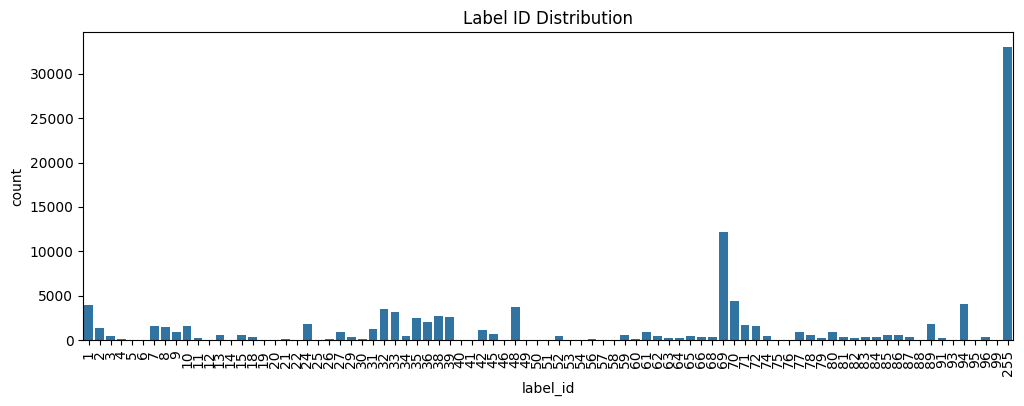

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Label ID Distribution
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='label_id')
plt.title("Label ID Distribution")
plt.xticks(rotation=90)
plt.show()


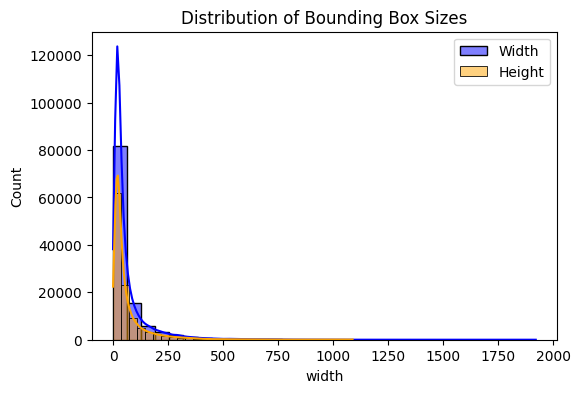

In [7]:
# 2. Box Dimensions
plt.figure(figsize=(6, 4))
sns.histplot(df['width'], bins=30, color="blue", label="Width", kde=True)
sns.histplot(df['height'], bins=30, color="orange", label="Height", kde=True)
plt.legend()
plt.title("Distribution of Bounding Box Sizes")
plt.show()


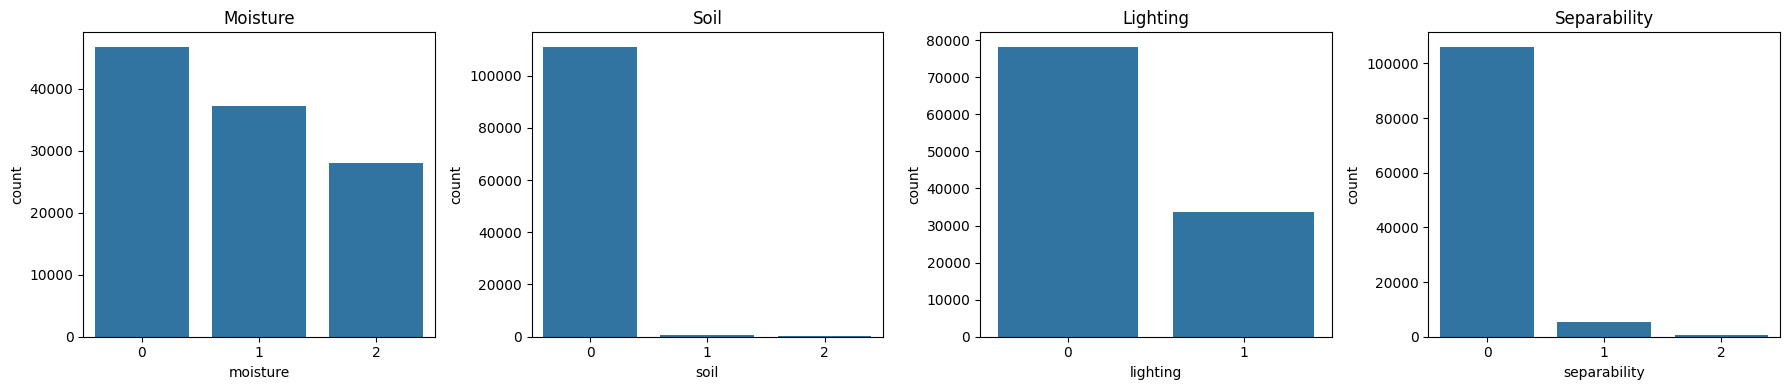

In [8]:
# 3. Environmental Metadata Distributions
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
sns.countplot(data=df, x='moisture', ax=axs[0])
sns.countplot(data=df, x='soil', ax=axs[1])
sns.countplot(data=df, x='lighting', ax=axs[2])
sns.countplot(data=df, x='separability', ax=axs[3])
axs[0].set_title("Moisture"); axs[1].set_title("Soil")
axs[2].set_title("Lighting"); axs[3].set_title("Separability")
plt.tight_layout()
plt.show()


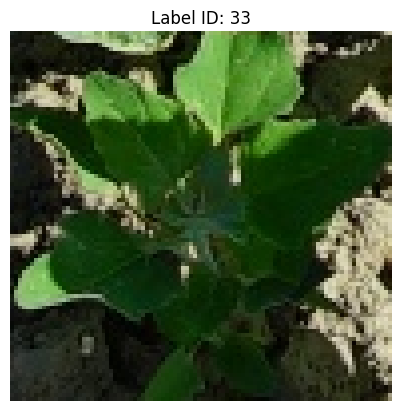

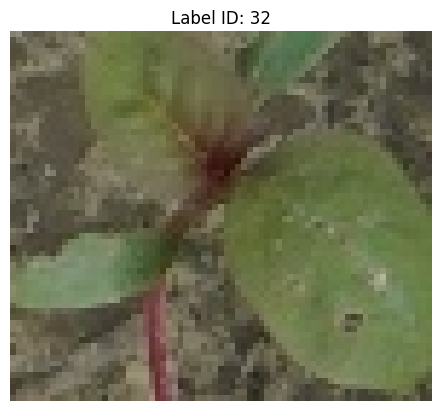

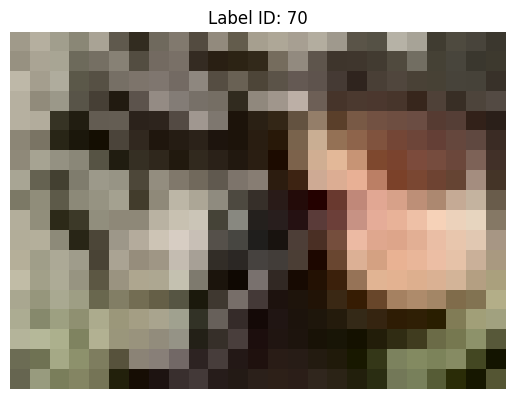

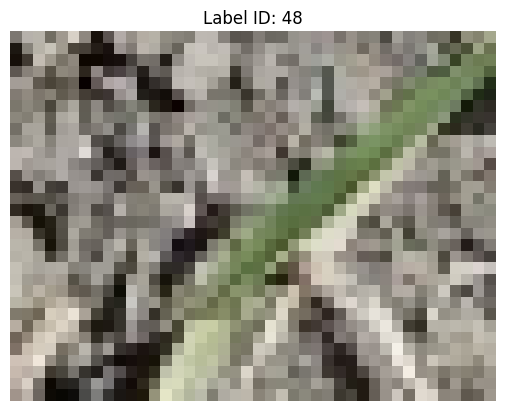

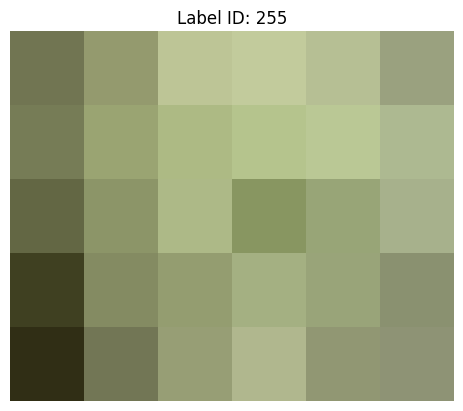

In [9]:
# 4. Visualize sample ROIs
from PIL import Image

sample = df.sample(5)
for _, row in sample.iterrows():
    img = Image.open(row['image_path'])
    roi = img.crop((row['left'], row['top'], row['right'], row['bottom']))
    plt.imshow(roi)
    plt.title(f"Label ID: {row['label_id']}")
    plt.axis('off')
    plt.show()


In [48]:
from collections import Counter

# For each image, collect its label_ids and decide image-level tag
image_tags = []

for image_id, group in df.groupby("image_id"):
    label_ids = group['label_id'].tolist()
    mapped_ids = [CropOrWeed2.get_mapped_id(lbl) for lbl in label_ids]

    label_counts = Counter(mapped_ids)
    if len(label_counts) == 1:
        image_class = CropOrWeed2.get_label_name(mapped_ids[0])
    else:
        image_class = "Mixed"

    image_tags.append({
        "image_id": image_id,
        "image_path": group['image_path'].iloc[0],
        "crop_count": label_counts.get(0, 0),
        "weed_count": label_counts.get(1, 0),
        "tag": image_class
    })

image_df = pd.DataFrame(image_tags)
image_df.head()


image_id                                       image_path  crop_count  \
0  ave-0000-0001  /content/crop_and_weed/images/ave-0000-0001.jpg           0   
1  ave-0007-0000  /content/crop_and_weed/images/ave-0007-0000.jpg           9   
2  ave-0007-0007  /content/crop_and_weed/images/ave-0007-0007.jpg           0   
3  ave-0032-0006  /content/crop_and_weed/images/ave-0032-0006.jpg           2   
4  ave-0035-0001  /content/crop_and_weed/images/ave-0035-0001.jpg           0   

   weed_count    tag  
0           1   Weed  
1          49  Mixed  
2           6  Mixed  
3           0  Mixed  
4           0   None

In [11]:
class Dataset:
    def __init__(self, labels):
        self.labels = {}
        self.mapping = {}
        for label_id, label in labels.items():
            if type(label) is tuple:
                self.labels[label_id] = (label[0], label[1], label_id) if len(label) > 1 else (label[0], (0, 0, 0))
            else:
                self.labels[label_id] = (label, (0, 0, 0))
            if len(label) > 2:
                for source_id in label[2]:
                    self.mapping[source_id] = label_id
        if len(self.mapping) == 0:
            self.mapping = {label: label for label in labels}

    def get_label_name(self, label_id):
        return self.labels[label_id][0] if label_id in self.labels else None

    def get_mapped_id(self, source_id):
        return self.mapping[source_id] if source_id in self.mapping else None


In [12]:
CropOrWeed2 = Dataset({
    0: ('Crop', (0, 255, 0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 94, 24, 18, 13, 26, 27, 15]),
    1: ('Weed', (128, 255, 192),
        [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87, 89, 91, 61, 79, 34, 41, 52, 35,
         36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51, 54, 58, 60, 80, 83, 96, 22, 63, 85, 56, 57, 64, 77, 50, 59, 67,
         76])})

In [13]:
from collections import Counter

# For each image, collect its label_ids and decide image-level tag
image_tags = []

for image_id, group in df.groupby("image_id"):
    label_ids = group['label_id'].tolist()
    mapped_ids = [CropOrWeed2.get_mapped_id(lbl) for lbl in label_ids]

    label_counts = Counter(mapped_ids)
    if len(label_counts) == 1:
        image_class = CropOrWeed2.get_label_name(mapped_ids[0])
    else:
        image_class = "Mixed"

    image_tags.append({
        "image_id": image_id,
        "image_path": group['image_path'].iloc[0],
        "crop_count": label_counts.get(0, 0),
        "weed_count": label_counts.get(1, 0),
        "tag": image_class
    })

image_df = pd.DataFrame(image_tags)
image_df.head()


image_id                                       image_path  crop_count  \
0  ave-0000-0001  /content/crop_and_weed/images/ave-0000-0001.jpg           0   
1  ave-0007-0000  /content/crop_and_weed/images/ave-0007-0000.jpg           9   
2  ave-0007-0007  /content/crop_and_weed/images/ave-0007-0007.jpg           0   
3  ave-0032-0006  /content/crop_and_weed/images/ave-0032-0006.jpg           2   
4  ave-0035-0001  /content/crop_and_weed/images/ave-0035-0001.jpg           0   

   weed_count    tag  
0           1   Weed  
1          49  Mixed  
2           6  Mixed  
3           0  Mixed  
4           0   None

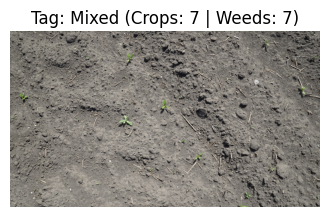

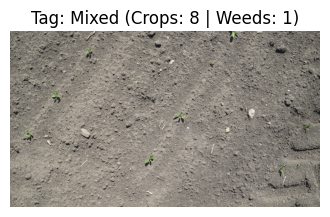

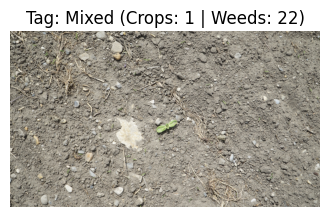

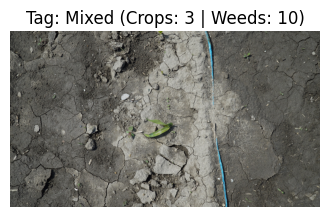

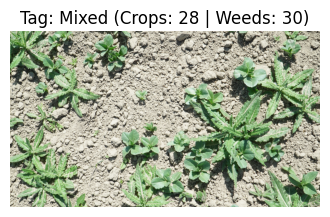

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

# Pick 5 random images
sample_images = image_df.sample(5, random_state=42)

# Show them with title as tag
for _, row in sample_images.iterrows():
    try:
        img = Image.open(row['image_path'])
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Tag: {row['tag']} (Crops: {row['crop_count']} | Weeds: {row['weed_count']})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to load {row['image_path']}: {e}")


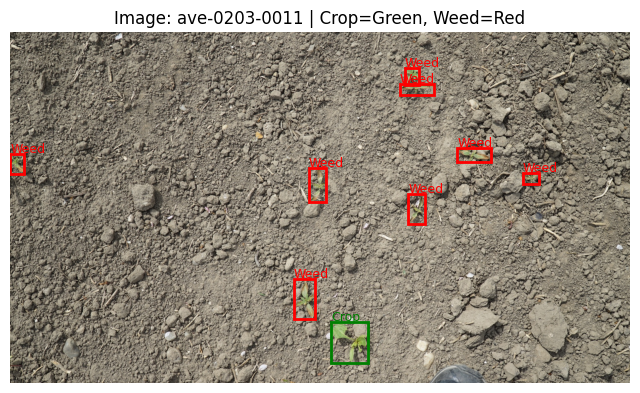

In [23]:
import matplotlib.patches as patches

# Pick a mixed image
mixed_row = image_df[image_df['tag'] == 'Mixed'].sample(1).iloc[0]
img = Image.open(mixed_row['image_path'])

# Get bounding boxes for this image
mixed_boxes = df[df['image_id'] == mixed_row['image_id']]

# Plot image with colored boxes: green = crop, red = weed
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
for _, row in mixed_boxes.iterrows():
    cls = CropOrWeed2.get_mapped_id(row['label_id'])
    color = 'green' if cls == 0 else 'red'
    rect = patches.Rectangle(
        (row['left'], row['top']),
        row['right'] - row['left'],
        row['bottom'] - row['top'],
        linewidth=2, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(row['left'], row['top']-5, f"{CropOrWeed2.get_label_name(cls)}", color=color, fontsize=9)
plt.title(f"Image: {mixed_row['image_id']} | Crop=Green, Weed=Red")
plt.axis('off')
plt.show()


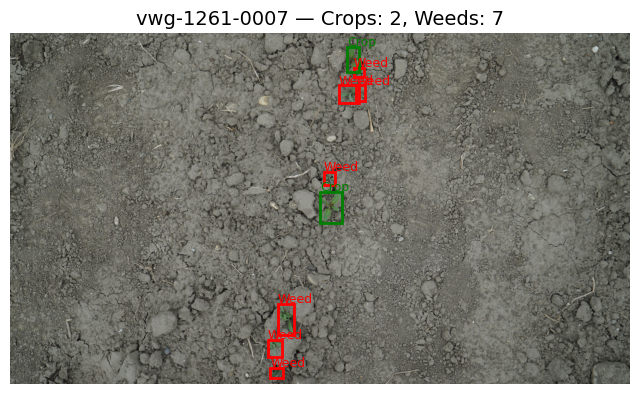

In [52]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

# Pick a mixed image
mixed_row = image_df[image_df['tag'] == 'Mixed'].sample(1).iloc[0]
img = Image.open(mixed_row['image_path'])

# Get bounding boxes for this image
mixed_boxes = df[df['image_id'] == mixed_row['image_id']].copy()

# Add mapped class: 0 = Crop, 1 = Weed
mixed_boxes['mapped_class'] = mixed_boxes['label_id'].apply(lambda x: CropOrWeed2.get_mapped_id(x))

# Count crops and weeds
crop_count = (mixed_boxes['mapped_class'] == 0).sum()
weed_count = (mixed_boxes['mapped_class'] == 1).sum()

# Plot image with bounding boxes
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)

for _, row in mixed_boxes.iterrows():
    cls = row['mapped_class']
    color = 'green' if cls == 0 else 'red'
    rect = patches.Rectangle(
        (row['left'], row['top']),
        row['right'] - row['left'],
        row['bottom'] - row['top'],
        linewidth=2, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(row['left'], row['top']-5, f"{CropOrWeed2.get_label_name(cls)}", color=color, fontsize=9)

# Title with counts
plt.title(f"{mixed_row['image_id']} — Crops: {crop_count}, Weeds: {weed_count}", fontsize=14)
plt.axis('off')
plt.show()



🟩 Crops (3):

🟥 Weeds (1):


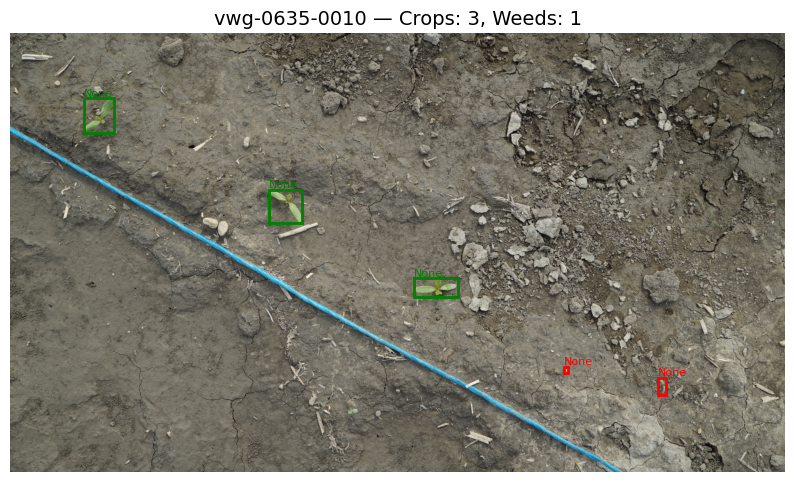

In [51]:
# Initialize the DATASETS dictionary
DATASETS = {}

# Add CropOrWeed2 configuration to it
DATASETS['CropOrWeed2'] = CropOrWeed2

# (Optional) Set reference variable for easier access later
CropOrWeed2 = DATASETS['CropOrWeed2']



import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Pick a mixed image
mixed_row = image_df[image_df['tag'] == 'Mixed'].sample(1).iloc[0]
img = Image.open(mixed_row['image_path'])

# Get bounding boxes for this image
mixed_boxes = df[df['image_id'] == mixed_row['image_id']].copy()

# Add mapped class and class name
mixed_boxes['mapped_class'] = mixed_boxes['label_id'].apply(lambda x: CropOrWeed2.get_mapped_id(x))
mixed_boxes['class_name'] = mixed_boxes['mapped_class'].apply(lambda x: CropOrWeed2.get_label_name(x))
mixed_boxes['original_label_name'] = mixed_boxes['label_id'].apply(lambda x: DATASETS['CropOrWeed2'].get_label_name(x))

# Count crops and weeds
crop_count = (mixed_boxes['mapped_class'] == 0).sum()
weed_count = (mixed_boxes['mapped_class'] == 1).sum()

# List unique crop and weed types
crop_types = mixed_boxes[mixed_boxes['mapped_class'] == 0]['original_label_name'].value_counts().to_dict()
weed_types = mixed_boxes[mixed_boxes['mapped_class'] == 1]['original_label_name'].value_counts().to_dict()

# Print summary
print(f"\n🟩 Crops ({crop_count}):")
for k, v in crop_types.items():
    print(f"  - {k} (x{v})")

print(f"\n🟥 Weeds ({weed_count}):")
for k, v in weed_types.items():
    print(f"  - {k} (x{v})")

# Plot image with bounding boxes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

for _, row in mixed_boxes.iterrows():
    color = 'green' if row['mapped_class'] == 0 else 'red'
    rect = patches.Rectangle(
        (row['left'], row['top']),
        row['right'] - row['left'],
        row['bottom'] - row['top'],
        linewidth=2, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(row['left'], row['top'] - 5, f"{row['original_label_name']}", color=color, fontsize=8)

plt.title(f"{mixed_row['image_id']} — Crops: {crop_count}, Weeds: {weed_count}", fontsize=14)
plt.axis('off')
plt.show()



/content/crop_and_weed/annotations/bboxes

  0%|          | 6/8034 [00:00<05:42, 23.44it/s]

[Skip] Error processing ave-0000-0002: No columns to parse from file
[Skip] Error processing ave-0000-0005: No columns to parse from file


  0%|          | 9/8034 [00:00<05:37, 23.80it/s]

[Skip] No valid boxes for: ave-0035-0001
[Skip] No valid boxes for: ave-0035-0003


  0%|          | 27/8034 [00:01<05:33, 23.98it/s]

[Skip] No valid boxes for: ave-0035-0019
[Skip] No valid boxes for: ave-0035-0020


  1%|          | 83/8034 [00:04<05:55, 22.39it/s]

[Skip] Invalid box size for ave-0042-0004: 1454,670,1454,670


  1%|▏         | 104/8034 [00:05<06:09, 21.48it/s]

[Skip] Invalid box size for ave-0048-0002: 4,73,6,73


  1%|▏         | 113/8034 [00:05<05:35, 23.64it/s]

[Skip] No valid boxes for: ave-0049-0001
[Skip] No valid boxes for: ave-0049-0002
[Skip] No valid boxes for: ave-0049-0004
[Skip] No valid boxes for: ave-0049-0007
[Skip] No valid boxes for: ave-0049-0009


  1%|▏         | 119/8034 [00:05<06:05, 21.63it/s]

[Skip] No valid boxes for: ave-0049-0011
[Skip] No valid boxes for: ave-0049-0013
[Skip] No valid boxes for: ave-0049-0015
[Skip] No valid boxes for: ave-0049-0016
[Skip] No valid boxes for: ave-0049-0017


  2%|▏         | 128/8034 [00:06<05:23, 24.44it/s]

[Skip] No valid boxes for: ave-0049-0019
[Skip] No valid boxes for: ave-0050-0002
[Skip] No valid boxes for: ave-0050-0006
[Skip] No valid boxes for: ave-0050-0007


  2%|▏         | 134/8034 [00:06<05:12, 25.32it/s]

[Skip] No valid boxes for: ave-0050-0008
[Skip] No valid boxes for: ave-0050-0014


  7%|▋         | 585/8034 [00:30<07:00, 17.70it/s]

[Skip] Invalid box size for ave-0146-0021: 1339,1054,1339,1055
[Skip] Invalid box size for ave-0146-0021: 1508,486,1512,486
[Skip] Invalid box size for ave-0146-0021: 1142,84,1143,84


 10%|▉         | 777/8034 [00:42<06:04, 19.92it/s]

[Skip] No valid boxes for: ave-0192-0007


 11%|█▏        | 922/8034 [00:49<05:51, 20.22it/s]

[Skip] No valid boxes for: ave-0212-0010


 12%|█▏        | 942/8034 [00:50<06:00, 19.70it/s]

[Skip] Error processing ave-0217-0001: No columns to parse from file


 12%|█▏        | 971/8034 [00:52<07:44, 15.19it/s]

[Skip] Error processing ave-0223-0014: No columns to parse from file
[Skip] Error processing ave-0223-0015: No columns to parse from file
[Skip] Error processing ave-0223-0016: No columns to parse from file
[Skip] Error processing ave-0223-0020: No columns to parse from file


 13%|█▎        | 1056/8034 [00:58<05:50, 19.92it/s]

[Skip] Error processing ave-0238-0016: No columns to parse from file


 18%|█▊        | 1485/8034 [01:22<06:44, 16.19it/s]

[Skip] No valid boxes for: ave-0291-0003
[Skip] No valid boxes for: ave-0291-0004
[Skip] No valid boxes for: ave-0291-0005


 19%|█▊        | 1487/8034 [01:22<08:53, 12.27it/s]

[Skip] No valid boxes for: ave-0291-0009
[Skip] No valid boxes for: ave-0291-0010
[Skip] No valid boxes for: ave-0291-0011


 19%|█▊        | 1491/8034 [01:23<08:48, 12.37it/s]

[Skip] No valid boxes for: ave-0291-0012
[Skip] No valid boxes for: ave-0291-0013
[Skip] No valid boxes for: ave-0291-0014


 19%|█▊        | 1493/8034 [01:23<08:40, 12.57it/s]

[Skip] No valid boxes for: ave-0291-0015
[Skip] No valid boxes for: ave-0291-0016
[Skip] No valid boxes for: ave-0291-0017


 19%|█▊        | 1497/8034 [01:23<08:15, 13.20it/s]

[Skip] No valid boxes for: ave-0291-0018
[Skip] No valid boxes for: ave-0291-0019
[Skip] No valid boxes for: ave-0291-0020


 19%|█▊        | 1499/8034 [01:23<09:03, 12.02it/s]

[Skip] No valid boxes for: ave-0291-0021
[Skip] No valid boxes for: ave-0291-0022


 19%|█▊        | 1505/8034 [01:24<08:34, 12.68it/s]

[Skip] No valid boxes for: ave-0292-0005
[Skip] No valid boxes for: ave-0292-0006
[Skip] No valid boxes for: ave-0292-0007


 19%|█▉        | 1509/8034 [01:24<07:35, 14.34it/s]

[Skip] No valid boxes for: ave-0292-0009
[Skip] No valid boxes for: ave-0292-0010
[Skip] No valid boxes for: ave-0292-0011


 19%|█▉        | 1513/8034 [01:24<07:21, 14.78it/s]

[Skip] No valid boxes for: ave-0293-0004
[Skip] No valid boxes for: ave-0293-0005
[Skip] Error processing ave-0293-0007: No columns to parse from file
[Skip] Error processing ave-0293-0008: No columns to parse from file


 19%|█▉        | 1519/8034 [01:25<05:45, 18.84it/s]

[Skip] Error processing ave-0293-0010: No columns to parse from file
[Skip] No valid boxes for: ave-0294-0003
[Skip] No valid boxes for: ave-0294-0004


 19%|█▉        | 1525/8034 [01:25<05:14, 20.72it/s]

[Skip] No valid boxes for: ave-0294-0005
[Skip] No valid boxes for: ave-0294-0006
[Skip] No valid boxes for: ave-0294-0008
[Skip] No valid boxes for: ave-0294-0009


 19%|█▉        | 1528/8034 [01:25<04:59, 21.75it/s]

[Skip] No valid boxes for: ave-0294-0010
[Skip] No valid boxes for: ave-0294-0011
[Skip] No valid boxes for: ave-0294-0012


 19%|█▉        | 1554/8034 [01:26<06:17, 17.19it/s]

[Skip] No valid boxes for: ave-0296-0012
[Skip] Error processing ave-0297-0002: No columns to parse from file
[Skip] Error processing ave-0297-0003: No columns to parse from file


 19%|█▉        | 1559/8034 [01:27<06:43, 16.06it/s]

[Skip] Error processing ave-0297-0004: No columns to parse from file
[Skip] Error processing ave-0297-0005: No columns to parse from file
[Skip] Error processing ave-0297-0006: No columns to parse from file
[Skip] Error processing ave-0297-0007: No columns to parse from file


 19%|█▉        | 1565/8034 [01:27<05:44, 18.77it/s]

[Skip] Error processing ave-0297-0008: No columns to parse from file
[Skip] Error processing ave-0297-0009: No columns to parse from file
[Skip] Error processing ave-0297-0010: No columns to parse from file
[Skip] Error processing ave-0297-0011: No columns to parse from file
[Skip] Error processing ave-0298-0002: No columns to parse from file


 20%|█▉        | 1570/8034 [01:27<05:21, 20.11it/s]

[Skip] Error processing ave-0298-0005: No columns to parse from file
[Skip] Error processing ave-0298-0006: No columns to parse from file
[Skip] Error processing ave-0298-0008: No columns to parse from file
[Skip] Error processing ave-0298-0009: No columns to parse from file
[Skip] Error processing ave-0298-0010: No columns to parse from file


 20%|█▉        | 1576/8034 [01:27<05:08, 20.97it/s]

[Skip] Error processing ave-0298-0011: No columns to parse from file
[Skip] Error processing ave-0299-0002: No columns to parse from file
[Skip] Error processing ave-0299-0003: No columns to parse from file
[Skip] Error processing ave-0299-0004: No columns to parse from file


 20%|█▉        | 1579/8034 [01:28<05:59, 17.98it/s]

[Skip] Error processing ave-0299-0005: No columns to parse from file
[Skip] Error processing ave-0299-0006: No columns to parse from file
[Skip] Error processing ave-0299-0007: No columns to parse from file
[Skip] Error processing ave-0299-0008: No columns to parse from file
[Skip] Error processing ave-0299-0009: No columns to parse from file


 20%|█▉        | 1585/8034 [01:28<05:25, 19.79it/s]

[Skip] Error processing ave-0299-0010: No columns to parse from file
[Skip] Error processing ave-0299-0011: No columns to parse from file


 20%|█▉        | 1599/8034 [01:29<06:01, 17.78it/s]

[Skip] Invalid box size for ave-0301-0005: 648,771,648,772
[Skip] Invalid box size for ave-0301-0005: 648,769,648,770
[Skip] Invalid box size for ave-0301-0005: 648,768,648,769


 20%|██        | 1613/8034 [01:29<05:21, 19.98it/s]

[Skip] Error processing ave-0302-0003: No columns to parse from file
[Skip] Error processing ave-0302-0007: No columns to parse from file


 20%|██        | 1632/8034 [01:30<05:21, 19.91it/s]

[Skip] Error processing ave-0303-0003: No columns to parse from file
[Skip] Error processing ave-0303-0004: No columns to parse from file
[Skip] Error processing ave-0303-0006: No columns to parse from file
[Skip] Error processing ave-0303-0007: No columns to parse from file


 20%|██        | 1638/8034 [01:31<05:45, 18.51it/s]

[Skip] Error processing ave-0303-0009: No columns to parse from file
[Skip] Error processing ave-0303-0010: No columns to parse from file
[Skip] Error processing ave-0303-0011: No columns to parse from file
[Skip] Error processing ave-0304-0002: No columns to parse from file
[Skip] Error processing ave-0304-0003: No columns to parse from file


 21%|██        | 1647/8034 [01:31<05:23, 19.77it/s]

[Skip] Error processing ave-0304-0008: No columns to parse from file
[Skip] Error processing ave-0304-0009: No columns to parse from file
[Skip] Error processing ave-0304-0010: No columns to parse from file
[Skip] Error processing ave-0305-0002: No columns to parse from file


 21%|██        | 1650/8034 [01:31<05:13, 20.35it/s]

[Skip] Error processing ave-0305-0004: No columns to parse from file
[Skip] Error processing ave-0305-0005: No columns to parse from file
[Skip] Error processing ave-0305-0006: No columns to parse from file
[Skip] Error processing ave-0305-0007: No columns to parse from file


 21%|██        | 1656/8034 [01:32<05:43, 18.59it/s]

[Skip] Error processing ave-0305-0008: No columns to parse from file
[Skip] Error processing ave-0305-0009: No columns to parse from file
[Skip] Error processing ave-0305-0010: No columns to parse from file
[Skip] Error processing ave-0305-0011: No columns to parse from file
[Skip] Error processing ave-0306-0002: No columns to parse from file


 21%|██        | 1661/8034 [01:32<05:28, 19.38it/s]

[Skip] Error processing ave-0306-0003: No columns to parse from file
[Skip] Error processing ave-0306-0004: No columns to parse from file
[Skip] Error processing ave-0306-0005: No columns to parse from file
[Skip] Error processing ave-0306-0006: No columns to parse from file
[Skip] Error processing ave-0306-0007: No columns to parse from file


 21%|██        | 1667/8034 [01:32<05:16, 20.13it/s]

[Skip] Error processing ave-0306-0008: No columns to parse from file
[Skip] Error processing ave-0306-0009: No columns to parse from file
[Skip] Error processing ave-0306-0010: No columns to parse from file
[Skip] Error processing ave-0306-0011: No columns to parse from file


 21%|██        | 1670/8034 [01:32<05:14, 20.22it/s]

[Skip] No valid boxes for: ave-0307-0004
[Skip] No valid boxes for: ave-0307-0005
[Skip] No valid boxes for: ave-0307-0006
[Skip] No valid boxes for: ave-0307-0007
[Skip] Error processing ave-0307-0008: No columns to parse from file


 21%|██        | 1679/8034 [01:33<05:00, 21.13it/s]

[Skip] Error processing ave-0307-0011: No columns to parse from file
[Skip] Error processing ave-0308-0004: No columns to parse from file


 21%|██        | 1691/8034 [01:34<05:30, 19.21it/s]

[Skip] Error processing ave-0308-0014: No columns to parse from file
[Skip] No valid boxes for: ave-0309-0002
[Skip] Error processing ave-0309-0003: No columns to parse from file
[Skip] Error processing ave-0309-0005: No columns to parse from file


 21%|██        | 1696/8034 [01:34<05:13, 20.21it/s]

[Skip] Error processing ave-0309-0006: No columns to parse from file
[Skip] Error processing ave-0309-0007: No columns to parse from file
[Skip] Error processing ave-0309-0008: No columns to parse from file
[Skip] Error processing ave-0309-0009: No columns to parse from file
[Skip] Error processing ave-0309-0010: No columns to parse from file


 21%|██        | 1699/8034 [01:34<05:09, 20.46it/s]

[Skip] Error processing ave-0309-0011: No columns to parse from file
[Skip] Error processing ave-0310-0002: No columns to parse from file
[Skip] Error processing ave-0310-0003: No columns to parse from file
[Skip] Error processing ave-0310-0004: No columns to parse from file


 21%|██        | 1702/8034 [01:34<05:05, 20.70it/s]

[Skip] Error processing ave-0310-0006: No columns to parse from file
[Skip] Error processing ave-0310-0007: No columns to parse from file
[Skip] Error processing ave-0310-0008: No columns to parse from file


 21%|██        | 1707/8034 [01:34<06:02, 17.45it/s]

[Skip] Error processing ave-0310-0009: No columns to parse from file
[Skip] Error processing ave-0310-0010: No columns to parse from file
[Skip] Error processing ave-0310-0011: No columns to parse from file
[Skip] Error processing ave-0311-0002: No columns to parse from file


 21%|██▏       | 1711/8034 [01:35<06:32, 16.10it/s]

[Skip] Error processing ave-0311-0003: No columns to parse from file
[Skip] No valid boxes for: ave-0311-0004
[Skip] No valid boxes for: ave-0311-0005


 21%|██▏       | 1715/8034 [01:35<06:29, 16.24it/s]

[Skip] Error processing ave-0311-0006: No columns to parse from file
[Skip] Error processing ave-0311-0007: No columns to parse from file
[Skip] Error processing ave-0311-0008: No columns to parse from file
[Skip] Error processing ave-0311-0009: No columns to parse from file


 21%|██▏       | 1717/8034 [01:35<06:32, 16.09it/s]

[Skip] Error processing ave-0311-0010: No columns to parse from file
[Skip] Error processing ave-0311-0011: No columns to parse from file


 21%|██▏       | 1723/8034 [01:36<07:54, 13.30it/s]

[Skip] Error processing ave-0312-0005: No columns to parse from file


 21%|██▏       | 1727/8034 [01:36<07:18, 14.39it/s]

[Skip] No valid boxes for: ave-0312-0009
[Skip] No valid boxes for: ave-0312-0010


 22%|██▏       | 1731/8034 [01:36<06:57, 15.11it/s]

[Skip] No valid boxes for: ave-0313-0003


 22%|██▏       | 1743/8034 [01:37<07:12, 14.56it/s]

[Skip] No valid boxes for: ave-0314-0005
[Skip] Error processing ave-0314-0006: No columns to parse from file
[Skip] Error processing ave-0314-0007: No columns to parse from file
[Skip] Error processing ave-0314-0008: No columns to parse from file


 22%|██▏       | 1747/8034 [01:37<06:50, 15.32it/s]

[Skip] Error processing ave-0314-0009: No columns to parse from file
[Skip] Error processing ave-0314-0010: No columns to parse from file
[Skip] No valid boxes for: ave-0314-0011


 22%|██▏       | 1753/8034 [01:38<06:41, 15.65it/s]

[Skip] No valid boxes for: ave-0315-0005


 22%|██▏       | 1763/8034 [01:38<08:54, 11.73it/s]

[Skip] No valid boxes for: ave-0316-0002
[Skip] Error processing ave-0316-0004: No columns to parse from file
[Skip] Error processing ave-0316-0005: No columns to parse from file


 22%|██▏       | 1768/8034 [01:39<06:52, 15.20it/s]

[Skip] Error processing ave-0316-0006: No columns to parse from file
[Skip] Error processing ave-0316-0007: No columns to parse from file
[Skip] Error processing ave-0316-0008: No columns to parse from file
[Skip] Error processing ave-0316-0009: No columns to parse from file
[Skip] Error processing ave-0316-0010: No columns to parse from file


 22%|██▏       | 1772/8034 [01:39<06:18, 16.54it/s]

[Skip] Error processing ave-0316-0011: No columns to parse from file


 22%|██▏       | 1791/8034 [01:40<05:26, 19.12it/s]

[Skip] Error processing ave-0318-0003: No columns to parse from file
[Skip] Error processing ave-0318-0004: No columns to parse from file
[Skip] Error processing ave-0318-0005: No columns to parse from file
[Skip] Error processing ave-0318-0006: No columns to parse from file
[Skip] No valid boxes for: ave-0318-0007


 22%|██▏       | 1796/8034 [01:40<05:16, 19.70it/s]

[Skip] Error processing ave-0318-0008: No columns to parse from file
[Skip] Error processing ave-0318-0009: No columns to parse from file
[Skip] Error processing ave-0318-0010: No columns to parse from file


 23%|██▎       | 1820/8034 [01:41<05:31, 18.77it/s]

[Skip] Error processing ave-0320-0002: No columns to parse from file
[Skip] Error processing ave-0320-0003: No columns to parse from file
[Skip] Error processing ave-0320-0004: No columns to parse from file
[Skip] Error processing ave-0320-0005: No columns to parse from file
[Skip] Error processing ave-0320-0006: No columns to parse from file


 23%|██▎       | 1826/8034 [01:42<04:59, 20.72it/s]

[Skip] Error processing ave-0320-0007: No columns to parse from file
[Skip] Error processing ave-0320-0008: No columns to parse from file
[Skip] Error processing ave-0320-0010: No columns to parse from file
[Skip] Error processing ave-0321-0002: No columns to parse from file
[Skip] Error processing ave-0321-0003: No columns to parse from file


 23%|██▎       | 1829/8034 [01:42<04:52, 21.22it/s]

[Skip] Error processing ave-0321-0004: No columns to parse from file
[Skip] Error processing ave-0321-0005: No columns to parse from file
[Skip] Error processing ave-0321-0006: No columns to parse from file
[Skip] Error processing ave-0321-0007: No columns to parse from file
[Skip] Error processing ave-0321-0008: No columns to parse from file


 23%|██▎       | 1832/8034 [01:42<04:48, 21.47it/s]

[Skip] Error processing ave-0321-0009: No columns to parse from file
[Skip] No valid boxes for: ave-0321-0010
[Skip] Error processing ave-0321-0011: No columns to parse from file


 23%|██▎       | 1850/8034 [01:43<05:02, 20.43it/s]

[Skip] No valid boxes for: ave-0323-0006


 23%|██▎       | 1866/8034 [01:44<08:13, 12.50it/s]

[Skip] Invalid box size for ave-0325-0006: 207,534,208,534
[Skip] Invalid box size for ave-0325-0007: 21,539,22,539


 23%|██▎       | 1872/8034 [01:45<06:43, 15.26it/s]

[Skip] Invalid box size for ave-0325-0011: 1042,528,1042,529
[Skip] Invalid box size for ave-0325-0012: 1019,753,1020,753


 24%|██▍       | 1924/8034 [01:48<05:32, 18.35it/s]

[Skip] Error processing ave-0328-0002: No columns to parse from file
[Skip] Error processing ave-0328-0003: No columns to parse from file
[Skip] Error processing ave-0328-0004: No columns to parse from file
[Skip] Error processing ave-0328-0006: No columns to parse from file
[Skip] Error processing ave-0328-0007: No columns to parse from file


 24%|██▍       | 1927/8034 [01:48<05:17, 19.23it/s]

[Skip] Error processing ave-0328-0008: No columns to parse from file
[Skip] Error processing ave-0328-0009: No columns to parse from file
[Skip] Error processing ave-0328-0010: No columns to parse from file
[Skip] No valid boxes for: ave-0328-0011
[Skip] Error processing ave-0329-0002: No columns to parse from file


 24%|██▍       | 1933/8034 [01:48<04:57, 20.47it/s]

[Skip] Error processing ave-0329-0003: No columns to parse from file
[Skip] Error processing ave-0329-0004: No columns to parse from file
[Skip] Error processing ave-0329-0005: No columns to parse from file
[Skip] Error processing ave-0329-0006: No columns to parse from file
[Skip] Error processing ave-0329-0007: No columns to parse from file


 24%|██▍       | 1936/8034 [01:48<04:57, 20.52it/s]

[Skip] Error processing ave-0329-0008: No columns to parse from file
[Skip] Error processing ave-0329-0009: No columns to parse from file
[Skip] Error processing ave-0329-0010: No columns to parse from file


 24%|██▍       | 1941/8034 [01:48<05:54, 17.17it/s]

[Skip] Error processing ave-0329-0011: No columns to parse from file
[Skip] Error processing ave-0331-0002: No columns to parse from file
[Skip] Error processing ave-0331-0003: No columns to parse from file
[Skip] Error processing ave-0331-0004: No columns to parse from file


 24%|██▍       | 1944/8034 [01:49<05:34, 18.21it/s]

[Skip] Error processing ave-0331-0005: No columns to parse from file
[Skip] Error processing ave-0331-0006: No columns to parse from file
[Skip] Error processing ave-0331-0007: No columns to parse from file
[Skip] Error processing ave-0331-0008: No columns to parse from file


 24%|██▍       | 1948/8034 [01:49<05:42, 17.78it/s]

[Skip] Error processing ave-0331-0009: No columns to parse from file
[Skip] Error processing ave-0331-0011: No columns to parse from file


 24%|██▍       | 1952/8034 [01:49<07:04, 14.31it/s]

[Skip] Error processing ave-0332-0005: No columns to parse from file
[Skip] Error processing ave-0332-0006: No columns to parse from file


 24%|██▍       | 1954/8034 [01:49<08:00, 12.64it/s]

[Skip] Error processing ave-0332-0007: No columns to parse from file
[Skip] Error processing ave-0332-0008: No columns to parse from file
[Skip] Error processing ave-0332-0009: No columns to parse from file


 24%|██▍       | 1958/8034 [01:50<07:33, 13.39it/s]

[Skip] No valid boxes for: ave-0332-0010
[Skip] Error processing ave-0332-0011: No columns to parse from file
[Skip] Error processing ave-0333-0002: No columns to parse from file
[Skip] Error processing ave-0333-0003: No columns to parse from file


 24%|██▍       | 1962/8034 [01:50<07:03, 14.33it/s]

[Skip] Error processing ave-0333-0004: No columns to parse from file
[Skip] Error processing ave-0333-0005: No columns to parse from file
[Skip] Error processing ave-0333-0006: No columns to parse from file
[Skip] Error processing ave-0333-0007: No columns to parse from file


 24%|██▍       | 1964/8034 [01:50<07:03, 14.33it/s]

[Skip] Error processing ave-0333-0008: No columns to parse from file
[Skip] Error processing ave-0333-0009: No columns to parse from file


 24%|██▍       | 1968/8034 [01:50<09:10, 11.03it/s]

[Skip] Error processing ave-0333-0011: No columns to parse from file
[Skip] Error processing ave-0334-0002: No columns to parse from file


 25%|██▍       | 1972/8034 [01:51<08:21, 12.10it/s]

[Skip] No valid boxes for: ave-0334-0004
[Skip] Error processing ave-0334-0005: No columns to parse from file
[Skip] No valid boxes for: ave-0334-0006


 25%|██▍       | 1974/8034 [01:51<07:39, 13.18it/s]

[Skip] Error processing ave-0334-0007: No columns to parse from file
[Skip] Error processing ave-0334-0009: No columns to parse from file


 25%|██▍       | 1978/8034 [01:51<07:22, 13.70it/s]

[Skip] No valid boxes for: ave-0334-0010


 25%|██▍       | 2000/8034 [01:53<07:02, 14.27it/s]

[Skip] Invalid box size for ave-0337-0003: 948,403,948,404


 25%|██▌       | 2009/8034 [01:53<06:50, 14.67it/s]

[Skip] Error processing ave-0338-0002: No columns to parse from file
[Skip] Error processing ave-0338-0003: No columns to parse from file
[Skip] Error processing ave-0338-0004: No columns to parse from file
[Skip] Error processing ave-0338-0005: No columns to parse from file
[Skip] Error processing ave-0338-0006: No columns to parse from file


 25%|██▌       | 2015/8034 [01:54<05:28, 18.34it/s]

[Skip] Error processing ave-0338-0007: No columns to parse from file
[Skip] Error processing ave-0338-0009: No columns to parse from file
[Skip] Error processing ave-0338-0010: No columns to parse from file


 25%|██▌       | 2022/8034 [01:54<05:07, 19.56it/s]

[Skip] No valid boxes for: ave-0339-0004
[Skip] No valid boxes for: ave-0339-0006
[Skip] No valid boxes for: ave-0339-0007
[Skip] No valid boxes for: ave-0339-0008


 25%|██▌       | 2027/8034 [01:54<05:37, 17.78it/s]

[Skip] No valid boxes for: ave-0339-0010


 26%|██▌       | 2073/8034 [01:57<06:53, 14.41it/s]

[Skip] No valid boxes for: ave-0343-0002


 26%|██▌       | 2077/8034 [01:58<07:46, 12.78it/s]

[Skip] No valid boxes for: ave-0343-0004
[Skip] No valid boxes for: ave-0343-0005
[Skip] Error processing ave-0343-0006: No columns to parse from file


 26%|██▌       | 2081/8034 [01:58<07:13, 13.74it/s]

[Skip] No valid boxes for: ave-0343-0007
[Skip] Error processing ave-0343-0008: No columns to parse from file
[Skip] Error processing ave-0343-0009: No columns to parse from file
[Skip] Error processing ave-0343-0010: No columns to parse from file


 26%|██▌       | 2083/8034 [01:58<07:09, 13.86it/s]

[Skip] Error processing ave-0343-0011: No columns to parse from file
[Skip] Error processing ave-0344-0002: No columns to parse from file
[Skip] Error processing ave-0344-0003: No columns to parse from file


 26%|██▌       | 2085/8034 [01:58<07:19, 13.53it/s]

[Skip] Error processing ave-0344-0004: No columns to parse from file
[Skip] Error processing ave-0344-0005: No columns to parse from file


 26%|██▌       | 2089/8034 [01:58<08:28, 11.69it/s]

[Skip] Error processing ave-0344-0006: No columns to parse from file
[Skip] Error processing ave-0344-0007: No columns to parse from file
[Skip] Error processing ave-0344-0008: No columns to parse from file


 26%|██▌       | 2091/8034 [01:59<07:53, 12.55it/s]

[Skip] Error processing ave-0344-0009: No columns to parse from file


 27%|██▋       | 2135/8034 [02:02<05:12, 18.90it/s]

[Skip] No valid boxes for: ave-0349-0002
[Skip] Error processing ave-0349-0003: No columns to parse from file
[Skip] Error processing ave-0349-0004: No columns to parse from file
[Skip] Error processing ave-0349-0005: No columns to parse from file
[Skip] Error processing ave-0349-0006: No columns to parse from file


 27%|██▋       | 2141/8034 [02:02<04:45, 20.63it/s]

[Skip] Error processing ave-0349-0007: No columns to parse from file
[Skip] Error processing ave-0349-0008: No columns to parse from file
[Skip] Error processing ave-0349-0009: No columns to parse from file


 27%|██▋       | 2154/8034 [02:03<05:02, 19.45it/s]

[Skip] Error processing ave-0353-0003: No columns to parse from file
[Skip] Error processing ave-0353-0004: No columns to parse from file
[Skip] Error processing ave-0353-0005: No columns to parse from file
[Skip] Error processing ave-0353-0006: No columns to parse from file
[Skip] Error processing ave-0353-0007: No columns to parse from file


 27%|██▋       | 2157/8034 [02:03<04:39, 21.02it/s]

[Skip] Error processing ave-0353-0008: No columns to parse from file
[Skip] Error processing ave-0353-0009: No columns to parse from file
[Skip] Error processing ave-0353-0010: No columns to parse from file


 27%|██▋       | 2162/8034 [02:03<05:28, 17.86it/s]

[Skip] Error processing ave-0353-0011: No columns to parse from file


 27%|██▋       | 2176/8034 [02:05<09:09, 10.66it/s]

[Skip] Invalid box size for ave-0355-0017: 574,368,574,368


 27%|██▋       | 2192/8034 [02:06<07:02, 13.83it/s]

[Skip] No valid boxes for: ave-0357-0002
[Skip] Error processing ave-0357-0003: No columns to parse from file
[Skip] Error processing ave-0357-0004: No columns to parse from file
[Skip] Error processing ave-0357-0005: No columns to parse from file


 27%|██▋       | 2196/8034 [02:06<06:29, 14.97it/s]

[Skip] Error processing ave-0357-0006: No columns to parse from file
[Skip] No valid boxes for: ave-0357-0008
[Skip] Error processing ave-0357-0009: No columns to parse from file


 27%|██▋       | 2198/8034 [02:06<06:42, 14.50it/s]

[Skip] Error processing ave-0357-0010: No columns to parse from file


 28%|██▊       | 2261/8034 [02:10<04:41, 20.48it/s]

[Skip] Error processing ave-0359-0003: No columns to parse from file
[Skip] Error processing ave-0359-0004: No columns to parse from file
[Skip] Error processing ave-0359-0005: No columns to parse from file
[Skip] Error processing ave-0359-0006: No columns to parse from file
[Skip] Error processing ave-0359-0007: No columns to parse from file


 28%|██▊       | 2264/8034 [02:10<04:40, 20.54it/s]

[Skip] Error processing ave-0359-0008: No columns to parse from file
[Skip] Error processing ave-0359-0009: No columns to parse from file


 29%|██▉       | 2338/8034 [02:14<04:42, 20.14it/s]

[Skip] Invalid box size for ave-0364-0009: 866,1024,866,1024
[Skip] Invalid box size for ave-0364-0009: 859,1010,860,1010


 29%|██▉       | 2349/8034 [02:15<05:06, 18.57it/s]

[Skip] Invalid box size for ave-0364-0027: 117,1010,119,1010
[Skip] Invalid box size for ave-0364-0027: 115,1010,117,1010
[Skip] Invalid box size for ave-0364-0027: 202,797,203,797


 30%|██▉       | 2372/8034 [02:16<04:57, 19.02it/s]

[Skip] Invalid box size for ave-0375-0002: 743,435,743,435


 30%|██▉       | 2384/8034 [02:17<04:54, 19.21it/s]

[Skip] Invalid box size for ave-0432-0005: 488,527,489,527


 30%|██▉       | 2401/8034 [02:18<05:43, 16.42it/s]

[Skip] Invalid box size for ave-0463-0002: 96,985,96,986


 30%|██▉       | 2405/8034 [02:18<05:32, 16.93it/s]

[Skip] Invalid box size for ave-0464-0005: 718,789,718,790
[Skip] Invalid box size for ave-0464-0005: 717,787,717,788


 30%|███       | 2425/8034 [02:20<09:09, 10.20it/s]

[Skip] Invalid box size for ave-0466-0004: 1645,962,1645,962
[Skip] Invalid box size for ave-0466-0004: 1758,131,1758,131


 31%|███       | 2477/8034 [02:24<06:31, 14.18it/s]

[Skip] Invalid box size for ave-0501-0004: 979,243,979,244
[Skip] Invalid box size for ave-0501-0005: 1229,268,1229,269
[Skip] Invalid box size for ave-0501-0005: 1226,262,1228,262


 31%|███       | 2483/8034 [02:24<06:41, 13.84it/s]

[Skip] Invalid box size for ave-0501-0009: 1671,1004,1671,1004
[Skip] Invalid box size for ave-0501-0010: 372,158,372,158
[Skip] Invalid box size for ave-0501-0012: 1459,907,1460,907
[Skip] Invalid box size for ave-0501-0012: 1459,906,1459,907
[Skip] Invalid box size for ave-0501-0012: 710,179,711,179
[Skip] Invalid box size for ave-0501-0012: 709,179,710,179


 32%|███▏      | 2542/8034 [02:27<04:12, 21.78it/s]

[Skip] Invalid box size for ave-0507-0006: 418,637,418,637
[Skip] Invalid box size for ave-0507-0006: 442,539,442,539
[Skip] Invalid box size for ave-0507-0007: 309,688,309,689


 32%|███▏      | 2557/8034 [02:28<04:33, 20.02it/s]

[Skip] Invalid box size for ave-0511-0003: 1234,504,1235,504
[Skip] Invalid box size for ave-0511-0004: 1884,497,1884,500
[Skip] Invalid box size for ave-0511-0004: 1795,463,1797,463
[Skip] Invalid box size for ave-0511-0004: 1046,437,1046,437
[Skip] Invalid box size for ave-0511-0004: 1884,424,1884,425
[Skip] Invalid box size for ave-0511-0005: 1359,473,1360,473


 32%|███▏      | 2560/8034 [02:28<04:38, 19.62it/s]

[Skip] Invalid box size for ave-0511-0007: 764,527,765,527


 32%|███▏      | 2565/8034 [02:28<04:46, 19.07it/s]

[Skip] Invalid box size for ave-0511-0011: 778,549,779,549


 32%|███▏      | 2571/8034 [02:29<06:23, 14.25it/s]

[Skip] Invalid box size for ave-0511-0018: 77,526,77,527
[Skip] Invalid box size for ave-0511-0019: 1383,461,1384,461
[Skip] Invalid box size for ave-0511-0019: 1413,429,1414,429
[Skip] Invalid box size for ave-0511-0020: 863,507,863,507


 32%|███▏      | 2573/8034 [02:29<06:35, 13.82it/s]

[Skip] Invalid box size for ave-0511-0021: 782,607,782,610
[Skip] Invalid box size for ave-0512-0002: 1244,454,1244,455


 32%|███▏      | 2577/8034 [02:29<06:46, 13.42it/s]

[Skip] Invalid box size for ave-0512-0006: 1580,672,1580,673


 32%|███▏      | 2581/8034 [02:30<06:51, 13.27it/s]

[Skip] Invalid box size for ave-0512-0009: 65,511,65,511
[Skip] Invalid box size for ave-0512-0009: 253,466,254,466
[Skip] Invalid box size for ave-0512-0009: 206,447,207,447
[Skip] Invalid box size for ave-0512-0009: 967,288,968,288
[Skip] Invalid box size for ave-0512-0009: 964,287,965,287
[Skip] Invalid box size for ave-0512-0011: 488,557,489,557
[Skip] Invalid box size for ave-0512-0011: 971,512,971,513
[Skip] Invalid box size for ave-0512-0011: 992,470,992,471


 32%|███▏      | 2583/8034 [02:30<06:57, 13.06it/s]

[Skip] Invalid box size for ave-0512-0013: 178,575,178,576
[Skip] Invalid box size for ave-0512-0014: 973,408,973,408
[Skip] Invalid box size for ave-0512-0014: 1776,405,1776,405


 32%|███▏      | 2589/8034 [02:31<09:14,  9.82it/s]

[Skip] Invalid box size for ave-0512-0017: 917,427,917,427
[Skip] Invalid box size for ave-0512-0017: 902,406,902,407
[Skip] Invalid box size for ave-0512-0018: 1746,364,1747,364
[Skip] Invalid box size for ave-0512-0019: 912,458,912,459


 32%|███▏      | 2593/8034 [02:31<08:39, 10.47it/s]

[Skip] Invalid box size for ave-0512-0021: 725,512,725,513
[Skip] Invalid box size for ave-0512-0021: 1891,378,1891,380


 32%|███▏      | 2597/8034 [02:31<07:30, 12.07it/s]

[Skip] Invalid box size for ave-0514-0006: 360,593,363,593
[Skip] Invalid box size for ave-0514-0006: 418,578,418,578
[Skip] Invalid box size for ave-0514-0006: 425,567,425,568


 32%|███▏      | 2605/8034 [02:32<06:02, 14.99it/s]

[Skip] Invalid box size for ave-0516-0008: 1882,438,1882,439


 33%|███▎      | 2631/8034 [02:33<06:05, 14.78it/s]

[Skip] Invalid box size for ave-0519-0016: 1322,859,1322,860
[Skip] Invalid box size for ave-0519-0016: 1722,466,1722,466
[Skip] Invalid box size for ave-0519-0016: 1542,353,1543,353


 33%|███▎      | 2650/8034 [02:35<07:00, 12.81it/s]

[Skip] Invalid box size for ave-0523-0017: 596,170,597,170
[Skip] Invalid box size for ave-0523-0017: 600,166,600,167
[Skip] Invalid box size for ave-0523-0020: 1715,170,1715,171


 33%|███▎      | 2656/8034 [02:35<06:17, 14.25it/s]

[Skip] Invalid box size for ave-0525-0003: 1804,900,1805,900
[Skip] Invalid box size for ave-0525-0005: 1674,284,1674,284


 33%|███▎      | 2684/8034 [02:37<06:14, 14.28it/s]

[Skip] Invalid box size for ave-0526-0010: 948,481,949,481
[Skip] Invalid box size for ave-0526-0010: 1505,451,1506,451
[Skip] Invalid box size for ave-0526-0010: 1783,413,1784,413


 33%|███▎      | 2686/8034 [02:37<06:51, 12.98it/s]

[Skip] Invalid box size for ave-0526-0013: 584,453,585,453
[Skip] Invalid box size for ave-0526-0013: 585,452,585,452
[Skip] Invalid box size for ave-0526-0013: 585,451,586,451


 33%|███▎      | 2690/8034 [02:38<07:38, 11.65it/s]

[Skip] Invalid box size for ave-0526-0017: 1515,489,1515,490
[Skip] Invalid box size for ave-0526-0018: 494,579,495,579


 34%|███▎      | 2694/8034 [02:38<07:13, 12.32it/s]

[Skip] Invalid box size for ave-0527-0005: 133,485,133,486


 34%|███▎      | 2698/8034 [02:38<06:32, 13.60it/s]

[Skip] Invalid box size for ave-0527-0008: 1891,469,1892,469


 34%|███▎      | 2700/8034 [02:38<06:26, 13.81it/s]

[Skip] Invalid box size for ave-0527-0012: 1850,417,1850,418
[Skip] Invalid box size for ave-0527-0012: 1849,413,1849,413


 34%|███▎      | 2707/8034 [02:39<05:43, 15.52it/s]

[Skip] Invalid box size for ave-0527-0016: 1426,510,1426,510


 34%|███▍      | 2727/8034 [02:40<04:05, 21.59it/s]

[Skip] Invalid box size for ave-0540-0014: 1877,366,1879,366


 34%|███▍      | 2744/8034 [02:41<04:27, 19.77it/s]

[Skip] Invalid box size for ave-0540-0031: 931,569,931,572


 34%|███▍      | 2753/8034 [02:41<04:16, 20.55it/s]

[Skip] Invalid box size for ave-0540-0042: 601,440,601,441


 34%|███▍      | 2759/8034 [02:41<04:49, 18.21it/s]

[Skip] Invalid box size for ave-0540-0045: 1414,127,1414,127


 34%|███▍      | 2768/8034 [02:42<04:28, 19.64it/s]

[Skip] Invalid box size for ave-0540-0055: 11,624,11,624
[Skip] Invalid box size for ave-0540-0058: 1150,1061,1150,1062


 35%|███▍      | 2789/8034 [02:43<05:52, 14.86it/s]

[Skip] Invalid box size for ave-0540-0077: 1787,1014,1787,1014
[Skip] Invalid box size for ave-0540-0077: 1787,1013,1788,1013


 36%|███▌      | 2891/8034 [02:49<05:04, 16.92it/s]

[Skip] Invalid box size for ave-0546-0002: 54,931,54,931
[Skip] Invalid box size for ave-0546-0002: 163,817,163,818


 36%|███▌      | 2893/8034 [02:49<05:24, 15.84it/s]

[Skip] Invalid box size for ave-0546-0006: 88,829,88,830


 36%|███▌      | 2895/8034 [02:49<06:58, 12.28it/s]

[Skip] Invalid box size for ave-0553-0002: 203,29,203,30
[Skip] Invalid box size for ave-0553-0002: 202,28,202,29


 37%|███▋      | 2954/8034 [02:53<04:28, 18.96it/s]

[Skip] Invalid box size for ave-0571-0017: 415,477,415,478


 37%|███▋      | 2959/8034 [02:54<04:27, 18.97it/s]

[Skip] Invalid box size for ave-0586-0003: 1012,400,1013,400
[Skip] Invalid box size for ave-0586-0004: 427,471,428,471
[Skip] Invalid box size for ave-0586-0004: 930,338,931,338
[Skip] Invalid box size for ave-0586-0006: 1064,342,1064,343
[Skip] Invalid box size for ave-0586-0006: 1854,177,1854,178


 37%|███▋      | 2969/8034 [02:54<04:16, 19.76it/s]

[Skip] Invalid box size for ave-0586-0014: 1052,335,1053,335
[Skip] Invalid box size for ave-0586-0014: 1041,326,1041,327
[Skip] Invalid box size for ave-0586-0016: 763,657,763,658


 37%|███▋      | 3000/8034 [02:56<04:20, 19.34it/s]

[Skip] Invalid box size for ave-0592-0003: 942,455,942,455
[Skip] Invalid box size for ave-0592-0003: 941,454,942,454
[Skip] Invalid box size for ave-0592-0003: 998,406,998,409
[Skip] Invalid box size for ave-0592-0003: 622,390,622,392
[Skip] Invalid box size for ave-0592-0003: 906,331,906,333
[Skip] Invalid box size for ave-0593-0002: 459,274,459,274


 38%|███▊      | 3024/8034 [02:57<04:23, 19.04it/s]

[Skip] Invalid box size for ave-0596-0005: 756,516,756,517


 38%|███▊      | 3034/8034 [02:58<04:41, 17.79it/s]

[Skip] Invalid box size for ave-0596-0015: 1189,485,1189,486


 38%|███▊      | 3041/8034 [02:58<04:24, 18.85it/s]

[Skip] Invalid box size for ave-0605-0003: 842,733,843,733
[Skip] Invalid box size for ave-0605-0003: 1221,730,1222,730
[Skip] Invalid box size for ave-0605-0003: 53,111,54,111


 39%|███▉      | 3133/8034 [03:02<04:19, 18.87it/s]

[Skip] Invalid box size for vwg-0017-0014: 1087,814,1087,814
[Skip] Invalid box size for vwg-0017-0014: 998,266,998,267
[Skip] Invalid box size for vwg-0017-0014: 1675,238,1675,238
[Skip] Invalid box size for vwg-0017-0014: 782,230,782,231


 54%|█████▍    | 4365/8034 [04:08<02:58, 20.61it/s]

[Skip] Invalid box size for vwg-0422-0010: 811,162,811,164


 54%|█████▍    | 4377/8034 [04:08<02:56, 20.77it/s]

[Skip] Invalid box size for vwg-0425-0001: 782,204,782,204


 55%|█████▍    | 4386/8034 [04:09<03:11, 19.00it/s]

[Skip] Invalid box size for vwg-0425-0020: 1572,345,1573,345


 57%|█████▋    | 4547/8034 [04:18<04:49, 12.06it/s]

[Skip] Invalid box size for vwg-0497-0007: 1843,640,1843,641


 57%|█████▋    | 4585/8034 [04:21<03:39, 15.70it/s]

[Skip] Invalid box size for vwg-0509-0016: 1018,200,1018,201


 58%|█████▊    | 4640/8034 [04:23<03:05, 18.26it/s]

[Skip] Invalid box size for vwg-0520-0015: 1906,199,1906,200


 58%|█████▊    | 4651/8034 [04:24<02:49, 19.92it/s]

[Skip] Invalid box size for vwg-0531-0003: 1017,968,1018,968


 75%|███████▌  | 6041/8034 [05:39<01:59, 16.71it/s]

[Skip] Invalid box size for vwg-0799-0005: 1397,727,1397,728


 76%|███████▌  | 6123/8034 [05:45<02:40, 11.90it/s]

[Skip] Invalid box size for vwg-0815-0012: 68,480,68,481


 76%|███████▋  | 6146/8034 [05:46<01:51, 16.91it/s]

[Skip] Invalid box size for vwg-0827-0002: 1094,641,1094,641
[Skip] Invalid box size for vwg-0827-0002: 1093,640,1093,641
[Skip] Invalid box size for vwg-0827-0002: 1092,640,1092,640


 77%|███████▋  | 6180/8034 [05:48<01:53, 16.34it/s]

[Skip] Invalid box size for vwg-0834-0004: 135,286,135,286


 79%|███████▉  | 6372/8034 [05:59<01:44, 15.94it/s]

[Skip] Invalid box size for vwg-0860-0002: 1245,769,1246,769


 84%|████████▎ | 6726/8034 [06:18<01:15, 17.26it/s]

[Skip] Invalid box size for vwg-1128-0021: 1600,173,1601,173


 84%|████████▍ | 6731/8034 [06:18<01:09, 18.83it/s]

[Skip] No valid boxes for: vwg-1132-0009


 86%|████████▌ | 6878/8034 [06:28<01:57,  9.84it/s]

[Skip] No valid boxes for: vwg-1225-0005


 86%|████████▌ | 6902/8034 [06:30<01:28, 12.80it/s]

[Skip] No valid boxes for: vwg-1226-0018


 89%|████████▉ | 7166/8034 [06:45<00:50, 17.33it/s]

[Skip] No valid boxes for: vwg-1248-0008


 96%|█████████▌| 7694/8034 [07:14<00:23, 14.76it/s]

[Skip] Invalid box size for vwg-1302-0002: 931,429,934,429


 99%|█████████▊| 7918/8034 [07:27<00:12,  9.66it/s]

[Skip] Invalid box size for vwg-1333-0003: 1056,314,1061,314


100%|██████████| 8034/8034 [07:34<00:00, 17.67it/s]



✅ Loaded 78288 image patches
   → Crop count : 20765
   → Weed count : 57523
   → Metadata shape: (78288, 4)


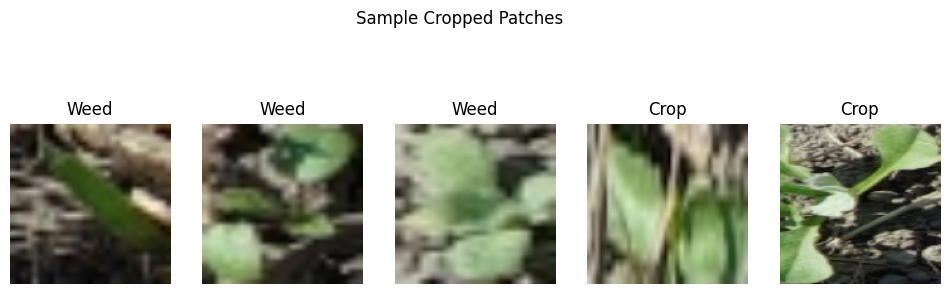

In [59]:
# === STEP 0: INSTALL DEPENDENCIES ===
# Uncomment this if you're running on a fresh Colab instance
# !pip install opencv-python-headless tqdm

# === STEP 1: IMPORTS ===
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# === STEP 2: DEFINE PATHS ===
# Unzip first if needed (adjust if your path differs)
# !unzip /content/drive/MyDrive/crop_and_weed.zip -d /content/

dataset_path = Path("/content/crop_and_weed")
images_path = dataset_path / "images"
annotations_path = dataset_path / "annotations"
bboxes_path = annotations_path / "bboxes"
params_path = annotations_path / "params"

# === STEP 3: DATASET CLASS FOR MAPPING ===
class Dataset:
    def __init__(self, labels):
        self.labels = {}
        self.mapping = {}
        for label_id, label in labels.items():
            if isinstance(label, tuple):
                self.labels[label_id] = (label[0], label[1], label_id) if len(label) > 1 else (label[0], (0, 0, 0))
            else:
                self.labels[label_id] = (label, (0, 0, 0))
            if len(label) > 2:
                for source_id in label[2]:
                    self.mapping[source_id] = label_id
        if len(self.mapping) == 0:
            self.mapping = {label: label for label in labels}

    def get_label_color(self, label_id, bgr=False):
        if bgr:
            return self.labels[label_id][1][::-1] if label_id in self.labels else None
        else:
            return self.labels[label_id][1] if label_id in self.labels else None

    def get_label_ids(self):
        return self.labels.keys()

    def get_label_name(self, label_id):
        return self.labels[label_id][0] if label_id in self.labels else None

    def get_mapped_id(self, source_id):
        return self.mapping[source_id] if source_id in self.mapping else None

# === STEP 4: CROP OR WEED MAPPING ===
CropOrWeed2 = Dataset({
    0: ('Crop', (0, 255, 0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 94, 24, 18, 13, 26, 27, 15]),
    1: ('Weed', (128, 255, 192), [
        31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87, 89, 91,
        61, 79, 34, 41, 52, 35, 36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51, 54, 58, 60, 80,
        83, 96, 22, 63, 85, 56, 57, 64, 77, 50, 59, 67, 76
    ])
})

# === STEP 5: METADATA LOADER ===
def load_metadata(image_id):
    param_file = params_path / f"{image_id}.csv"
    if not param_file.exists():
        return None
    df = pd.read_csv(param_file)
    return df.iloc[0].tolist()

# === STEP 6: PATCH EXTRACTION + DEBUG LOGGING ===
patches = []
labels = []
metadata = []
image_ids = []

for bbox_file in tqdm(sorted(bboxes_path.glob("*.csv"))):
    image_id = bbox_file.stem
    image_file = images_path / f"{image_id}.jpg"
    if not image_file.exists():
        print(f"[Skip] Image missing: {image_file}")
        continue

    meta = load_metadata(image_id)
    if meta is None:
        print(f"[Skip] Metadata missing for: {image_id}")
        continue

    try:
        img = Image.open(image_file)
        img_np = np.array(img)
        bboxes = pd.read_csv(bbox_file, header=None)
        bboxes.columns = ["left", "top", "right", "bottom", "label_id", "stem_x", "stem_y"]

        valid_patch_count = 0
        for _, row in bboxes.iterrows():
            left, top, right, bottom = int(row.left), int(row.top), int(row.right), int(row.bottom)

            if left >= right or top >= bottom:
                print(f"[Skip] Invalid box size for {image_id}: {left},{top},{right},{bottom}")
                continue

            crop_img = img_np[top:bottom, left:right]
            if crop_img.size == 0:
                #print(f"[Skip] Empty crop for {image_id} at box {left},{top},{right},{bottom}")
                continue

            try:
                resized_img = cv2.resize(crop_img, (128, 128))
            except Exception as e:
                #print(f"[Skip] Resize failed for {image_id}: {e}")
                continue

            label = CropOrWeed2.get_mapped_id(int(row.label_id))
            if label is None:
                #print(f"[Skip] Unmapped label ID {row.label_id} in {image_id}")
                continue

            patches.append(resized_img)
            metadata.append(meta)
            labels.append(label)
            image_ids.append(image_id)
            valid_patch_count += 1

        if valid_patch_count == 0:
            print(f"[Skip] No valid boxes for: {image_id}")
    except Exception as e:
        print(f"[Skip] Error processing {image_id}: {e}")

# === STEP 7: CONVERT TO NUMPY ===
X_img = np.array(patches)
X_meta = np.array(metadata)
y = np.array(labels)

print(f"\n✅ Loaded {len(X_img)} image patches")
print(f"   → Crop count : {(y == 0).sum()}")
print(f"   → Weed count : {(y == 1).sum()}")
print(f"   → Metadata shape: {X_meta.shape}")

# === STEP 8: VISUALIZE PATCHES ===
plt.figure(figsize=(12, 4))
for i in range(min(5, len(X_img))):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_img[i])
    plt.title(f"{'Crop' if y[i]==0 else 'Weed'}")
    plt.axis('off')
plt.suptitle("Sample Cropped Patches")
plt.show()


In [2]:
!pip install tensorflow opencv-python-headless tqdm --quiet

⏳ Scanning masks for classification filtering...



  0%|          | 2/8034 [00:00<08:04, 16.56it/s]

[ADD - Weed] ave-0000-0001
[SKIP - Unknown] ave-0000-0002 - Labels: {np.uint8(0)}


  0%|          | 5/8034 [00:00<05:52, 22.80it/s]

[SKIP - Unknown] ave-0000-0005 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0007-0000 - Labels: {np.uint8(0), np.uint8(33), np.uint8(89), np.uint8(35), np.uint8(38), np.uint8(7), np.uint8(39), np.uint8(42), np.uint8(48), np.uint8(83), np.uint8(24), np.uint8(57), np.uint8(255)}
[ADD - Weed] ave-0007-0007
[ADD - Crop] ave-0032-0006


  0%|          | 8/8034 [00:00<05:11, 25.79it/s]

[SKIP - Unknown] ave-0035-0001 - Labels: {np.uint8(0), np.uint8(21)}
[ADD - Weed] ave-0035-0002


  0%|          | 11/8034 [00:00<04:56, 27.08it/s]

[SKIP - Unknown] ave-0035-0003 - Labels: {np.uint8(0), np.uint8(21), np.uint8(255)}
[ADD - Weed] ave-0035-0004
[ADD - Weed] ave-0035-0005
[ADD - Weed] ave-0035-0006


  0%|          | 15/8034 [00:00<04:40, 28.57it/s]

[ADD - Weed] ave-0035-0007
[ADD - Weed] ave-0035-0008
[ADD - Weed] ave-0035-0009


  0%|          | 18/8034 [00:00<04:40, 28.60it/s]

[ADD - Weed] ave-0035-0010
[ADD - Weed] ave-0035-0011
[ADD - Weed] ave-0035-0012
[ADD - Weed] ave-0035-0013


  0%|          | 22/8034 [00:00<04:32, 29.35it/s]

[ADD - Weed] ave-0035-0014
[ADD - Weed] ave-0035-0015
[ADD - Weed] ave-0035-0017
[ADD - Weed] ave-0035-0018
[SKIP - Unknown] ave-0035-0019 - Labels: {np.uint8(0), np.uint8(21), np.uint8(255)}


  0%|          | 25/8034 [00:00<05:03, 26.38it/s]

[SKIP - Unknown] ave-0035-0020 - Labels: {np.uint8(0), np.uint8(21), np.uint8(255)}
[SKIP - Mixed] ave-0037-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(8), np.uint8(9), np.uint8(48), np.uint8(91), np.uint8(255)}
[ADD - Weed] ave-0037-0002
[SKIP - Mixed] ave-0037-0007 - Labels: {np.uint8(0), np.uint8(10), np.uint8(30), np.uint8(255)}


  0%|          | 29/8034 [00:01<04:44, 28.10it/s]

[SKIP - Mixed] ave-0037-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(10), np.uint8(255)}
[SKIP - Mixed] ave-0037-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0037-0010 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(38)}


  0%|          | 33/8034 [00:01<04:35, 29.04it/s]

[SKIP - Mixed] ave-0037-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0037-0012 - Labels: {np.uint8(0), np.uint8(48), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0037-0013 - Labels: {np.uint8(0), np.uint8(255), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0037-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(7)}


  0%|          | 37/8034 [00:01<04:28, 29.79it/s]

[SKIP - Mixed] ave-0037-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(7), np.uint8(255)}
[SKIP - Mixed] ave-0037-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(7), np.uint8(255)}
[SKIP - Mixed] ave-0037-0017 - Labels: {np.uint8(0), np.uint8(10), np.uint8(38), np.uint8(7)}


  1%|          | 41/8034 [00:01<04:25, 30.10it/s]

[SKIP - Mixed] ave-0037-0018 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0037-0019 - Labels: {np.uint8(0), np.uint8(255), np.uint8(91), np.uint8(7)}
[SKIP - Mixed] ave-0037-0020 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] ave-0037-0021


  1%|          | 45/8034 [00:01<04:21, 30.52it/s]

[ADD - Crop] ave-0037-0022
[SKIP - Mixed] ave-0037-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0037-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7)}


  1%|          | 49/8034 [00:01<04:19, 30.78it/s]

[SKIP - Mixed] ave-0040-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0040-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0040-0003
[ADD - Crop] ave-0040-0004
[ADD - Crop] ave-0040-0005
[ADD - Crop] ave-0040-0006
[ADD - Crop] ave-0040-0007


  1%|          | 53/8034 [00:01<04:20, 30.60it/s]

[ADD - Crop] ave-0040-0008
[ADD - Crop] ave-0040-0009
[ADD - Crop] ave-0040-0010


  1%|          | 57/8034 [00:01<04:27, 29.81it/s]

[ADD - Crop] ave-0040-0011
[ADD - Crop] ave-0040-0012
[ADD - Crop] ave-0040-0013


  1%|          | 61/8034 [00:02<04:22, 30.34it/s]

[ADD - Crop] ave-0040-0014
[ADD - Crop] ave-0040-0015
[ADD - Crop] ave-0040-0016
[ADD - Crop] ave-0040-0017


  1%|          | 65/8034 [00:02<04:21, 30.49it/s]

[SKIP - Mixed] ave-0040-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0040-0019
[ADD - Weed] ave-0041-0002


  1%|          | 69/8034 [00:02<04:18, 30.81it/s]

[ADD - Weed] ave-0041-0003
[ADD - Crop] ave-0041-0012
[ADD - Crop] ave-0041-0013
[SKIP - Mixed] ave-0041-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[ADD - Crop] ave-0041-0015
[ADD - Crop] ave-0041-0016
[ADD - Crop] ave-0041-0017


  1%|          | 73/8034 [00:02<04:17, 30.88it/s]

[ADD - Crop] ave-0041-0019
[ADD - Crop] ave-0041-0020
[ADD - Crop] ave-0041-0022
[SKIP - Mixed] ave-0042-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(52)}


  1%|          | 77/8034 [00:02<04:19, 30.72it/s]

[SKIP - Mixed] ave-0042-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(52)}
[SKIP - Mixed] ave-0042-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0042-0007 - Labels: {np.uint8(0), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


  1%|          | 81/8034 [00:02<04:22, 30.32it/s]

[ADD - Crop] ave-0042-0008
[SKIP - Mixed] ave-0042-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0042-0016


  1%|          | 85/8034 [00:02<04:22, 30.28it/s]

[SKIP - Mixed] ave-0042-0017 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0042-0018
[SKIP - Mixed] ave-0042-0019 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] ave-0045-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(56), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0045-0007 - Labels: {np.uint8(0), np.uint8(27), np.uint8(38)}
[ADD - Weed] ave-0045-0009


  1%|          | 89/8034 [00:03<04:25, 29.92it/s]

[SKIP - Mixed] ave-0045-0011 - Labels: {np.uint8(0), np.uint8(27), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0045-0012 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0045-0013 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}
[ADD - Weed] ave-0047-0002


  1%|          | 93/8034 [00:03<04:21, 30.36it/s]

[ADD - Weed] ave-0047-0003
[ADD - Weed] ave-0047-0004
[ADD - Weed] ave-0047-0005


  1%|          | 97/8034 [00:03<04:20, 30.42it/s]

[ADD - Weed] ave-0047-0006
[ADD - Weed] ave-0047-0008
[ADD - Weed] ave-0047-0009
[ADD - Weed] ave-0047-0010
[ADD - Weed] ave-0047-0011


  1%|▏         | 101/8034 [00:03<04:50, 27.35it/s]

[ADD - Weed] ave-0047-0017
[SKIP - Mixed] ave-0048-0002 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0048-0004 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(54), np.uint8(27), np.uint8(255)}


  1%|▏         | 104/8034 [00:03<05:34, 23.73it/s]

[SKIP - Mixed] ave-0048-0006 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(38)}


  1%|▏         | 107/8034 [00:03<05:59, 22.07it/s]

[SKIP - Mixed] ave-0048-0017 - Labels: {np.uint8(0), np.uint8(27), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0048-0019 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0048-0022 - Labels: {np.uint8(0), np.uint8(255), np.uint8(38), np.uint8(42), np.uint8(27), np.uint8(31)}
[SKIP - Mixed] ave-0048-0027 - Labels: {np.uint8(0), np.uint8(38), np.uint8(27), np.uint8(31), np.uint8(255)}


  1%|▏         | 110/8034 [00:03<06:36, 19.96it/s]

[SKIP - Mixed] ave-0048-0036 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Unknown] ave-0049-0001 - Labels: {np.uint8(0), np.uint8(19)}
[SKIP - Unknown] ave-0049-0002 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[SKIP - Unknown] ave-0049-0004 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}


  1%|▏         | 115/8034 [00:04<07:05, 18.63it/s]

[SKIP - Unknown] ave-0049-0007 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[SKIP - Unknown] ave-0049-0009 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[ADD - Weed] ave-0049-0010
[SKIP - Unknown] ave-0049-0011 - Labels: {np.uint8(0), np.uint8(19)}


  1%|▏         | 119/8034 [00:04<07:09, 18.41it/s]

[SKIP - Unknown] ave-0049-0013 - Labels: {np.uint8(0), np.uint8(19)}
[ADD - Weed] ave-0049-0014
[SKIP - Unknown] ave-0049-0015 - Labels: {np.uint8(0), np.uint8(19)}
[SKIP - Unknown] ave-0049-0016 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}


  2%|▏         | 123/8034 [00:04<07:10, 18.37it/s]

[SKIP - Unknown] ave-0049-0017 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[ADD - Weed] ave-0049-0018
[SKIP - Unknown] ave-0049-0019 - Labels: {np.uint8(0), np.uint8(19)}
[ADD - Weed] ave-0050-0001


  2%|▏         | 127/8034 [00:04<07:27, 17.67it/s]

[SKIP - Unknown] ave-0050-0002 - Labels: {np.uint8(0), np.uint8(20), np.uint8(255)}
[ADD - Weed] ave-0050-0004
[SKIP - Unknown] ave-0050-0006 - Labels: {np.uint8(0), np.uint8(20), np.uint8(255)}
[SKIP - Unknown] ave-0050-0007 - Labels: {np.uint8(0), np.uint8(20)}


  2%|▏         | 131/8034 [00:05<07:28, 17.60it/s]

[SKIP - Unknown] ave-0050-0008 - Labels: {np.uint8(0), np.uint8(20)}
[ADD - Weed] ave-0050-0013
[SKIP - Unknown] ave-0050-0014 - Labels: {np.uint8(0), np.uint8(20)}
[ADD - Weed] ave-0050-0015


  2%|▏         | 135/8034 [00:05<07:28, 17.59it/s]

[ADD - Weed] ave-0050-0016
[SKIP - Mixed] ave-0051-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0051-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24)}
[SKIP - Mixed] ave-0051-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}


  2%|▏         | 139/8034 [00:05<07:43, 17.02it/s]

[SKIP - Mixed] ave-0051-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0053-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0053-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0053-0012 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(89), np.uint8(255)}


  2%|▏         | 143/8034 [00:05<07:52, 16.69it/s]

[SKIP - Mixed] ave-0053-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0053-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0053-0020 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0057-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}


  2%|▏         | 147/8034 [00:06<07:24, 17.74it/s]

[SKIP - Mixed] ave-0057-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0057-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0057-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0057-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(39), np.uint8(24), np.uint8(91), np.uint8(255)}


  2%|▏         | 151/8034 [00:06<07:15, 18.12it/s]

[SKIP - Mixed] ave-0057-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0057-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0057-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0057-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}


  2%|▏         | 155/8034 [00:06<07:12, 18.23it/s]

[SKIP - Mixed] ave-0057-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0057-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69)}
[SKIP - Mixed] ave-0057-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0057-0020 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(255)}


  2%|▏         | 159/8034 [00:06<06:56, 18.89it/s]

[SKIP - Mixed] ave-0058-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(48), np.uint8(52), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(52), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(87), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(48), np.uint8(91), np.uint8(255)}


  2%|▏         | 164/8034 [00:06<06:02, 21.72it/s]

[SKIP - Mixed] ave-0058-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(91)}
[SKIP - Mixed] ave-0058-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0058-0011
[ADD - Crop] ave-0058-0012
[SKIP - Mixed] ave-0058-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


  2%|▏         | 170/8034 [00:07<05:19, 24.62it/s]

[SKIP - Mixed] ave-0058-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0059-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(52), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0059-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  2%|▏         | 176/8034 [00:07<04:54, 26.69it/s]

[SKIP - Mixed] ave-0062-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Weed] ave-0063-0003
[ADD - Weed] ave-0063-0004
[ADD - Weed] ave-0063-0005
[ADD - Weed] ave-0063-0006
[ADD - Weed] ave-0063-0007


  2%|▏         | 183/8034 [00:07<04:36, 28.43it/s]

[ADD - Weed] ave-0063-0008
[ADD - Weed] ave-0063-0009
[ADD - Weed] ave-0063-0010
[ADD - Weed] ave-0063-0011
[SKIP - Mixed] ave-0063-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(38)}
[ADD - Weed] ave-0063-0013
[ADD - Weed] ave-0063-0014


  2%|▏         | 190/8034 [00:07<04:29, 29.09it/s]

[ADD - Weed] ave-0063-0015
[ADD - Weed] ave-0063-0016
[SKIP - Mixed] ave-0063-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] ave-0063-0018
[ADD - Weed] ave-0063-0020
[ADD - Crop] ave-0065-0010


  2%|▏         | 197/8034 [00:08<04:23, 29.71it/s]

[SKIP - Mixed] ave-0065-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0065-0013
[SKIP - Mixed] ave-0065-0014 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0065-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0065-0017 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] ave-0065-0018 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}


  3%|▎         | 204/8034 [00:08<04:21, 29.96it/s]

[ADD - Crop] ave-0067-0001
[ADD - Crop] ave-0067-0002
[SKIP - Mixed] ave-0067-0003 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}
[ADD - Crop] ave-0067-0004
[ADD - Crop] ave-0067-0005
[ADD - Crop] ave-0067-0006
[ADD - Crop] ave-0067-0007


  3%|▎         | 210/8034 [00:08<04:25, 29.43it/s]

[ADD - Crop] ave-0067-0008
[ADD - Crop] ave-0067-0009
[ADD - Crop] ave-0067-0010
[SKIP - Mixed] ave-0067-0011 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}
[SKIP - Mixed] ave-0067-0012 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}
[SKIP - Mixed] ave-0067-0013 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}


  3%|▎         | 217/8034 [00:08<04:20, 30.03it/s]

[ADD - Crop] ave-0067-0014
[ADD - Crop] ave-0067-0015
[ADD - Crop] ave-0067-0016
[ADD - Crop] ave-0067-0017
[ADD - Crop] ave-0067-0019
[ADD - Crop] ave-0067-0020
[ADD - Crop] ave-0067-0021


  3%|▎         | 224/8034 [00:09<04:16, 30.42it/s]

[SKIP - Mixed] ave-0068-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(64), np.uint8(13), np.uint8(255)}
[ADD - Crop] ave-0069-0001
[ADD - Crop] ave-0069-0002
[ADD - Crop] ave-0069-0003
[ADD - Crop] ave-0069-0004
[ADD - Crop] ave-0069-0006
[ADD - Crop] ave-0069-0007


  3%|▎         | 228/8034 [00:09<04:14, 30.64it/s]

[ADD - Crop] ave-0069-0008
[ADD - Crop] ave-0069-0009
[SKIP - Mixed] ave-0069-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0069-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0069-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(69)}
[ADD - Crop] ave-0069-0014


  3%|▎         | 236/8034 [00:09<04:18, 30.15it/s]

[SKIP - Mixed] ave-0069-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0069-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0069-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0069-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0069-0020
[ADD - Crop] ave-0072-0001
[ADD - Crop] ave-0072-0002


  3%|▎         | 244/8034 [00:09<04:17, 30.27it/s]

[ADD - Crop] ave-0072-0003
[SKIP - Mixed] ave-0072-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0072-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0072-0009
[ADD - Crop] ave-0072-0010
[SKIP - Mixed] ave-0072-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[ADD - Crop] ave-0072-0012


  3%|▎         | 248/8034 [00:09<04:15, 30.50it/s]

[ADD - Crop] ave-0072-0013
[ADD - Crop] ave-0072-0014
[ADD - Crop] ave-0072-0015
[ADD - Crop] ave-0072-0016
[SKIP - Mixed] ave-0072-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0072-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(36), np.uint8(38)}
[SKIP - Mixed] ave-0072-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(52)}


  3%|▎         | 256/8034 [00:10<04:14, 30.51it/s]

[SKIP - Mixed] ave-0075-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0075-0002
[ADD - Crop] ave-0075-0004
[ADD - Crop] ave-0075-0005
[ADD - Crop] ave-0075-0006
[ADD - Crop] ave-0075-0008
[ADD - Crop] ave-0075-0011


  3%|▎         | 264/8034 [00:10<04:18, 30.03it/s]

[SKIP - Mixed] ave-0075-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0075-0014
[ADD - Crop] ave-0075-0015
[ADD - Crop] ave-0075-0016
[ADD - Crop] ave-0075-0017
[ADD - Crop] ave-0075-0018


  3%|▎         | 268/8034 [00:10<04:18, 30.08it/s]

[SKIP - Mixed] ave-0076-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0076-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(48)}
[SKIP - Mixed] ave-0076-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0076-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0076-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0076-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(255)}


  3%|▎         | 276/8034 [00:10<04:21, 29.68it/s]

[SKIP - Mixed] ave-0076-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0076-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0076-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0076-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(69)}
[SKIP - Mixed] ave-0076-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91)}
[SKIP - Mixed] ave-0076-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255), np.uint8(69), np.uint8(31)}


  4%|▎         | 283/8034 [00:10<04:20, 29.80it/s]

[SKIP - Mixed] ave-0077-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(91)}
[ADD - Crop] ave-0077-0020
[ADD - Weed] ave-0078-0001
[ADD - Weed] ave-0078-0003
[SKIP - Mixed] ave-0079-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0079-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(38)}


  4%|▎         | 287/8034 [00:11<04:17, 30.14it/s]

[SKIP - Mixed] ave-0079-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[SKIP - Mixed] ave-0079-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0079-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[SKIP - Mixed] ave-0079-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}


  4%|▎         | 294/8034 [00:11<04:20, 29.69it/s]

[SKIP - Mixed] ave-0079-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38)}
[SKIP - Mixed] ave-0080-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0080-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0080-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0080-0008
[SKIP - Mixed] ave-0080-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  4%|▍         | 302/8034 [00:11<04:13, 30.47it/s]

[ADD - Crop] ave-0080-0015
[ADD - Crop] ave-0080-0018
[ADD - Crop] ave-0080-0019
[SKIP - Mixed] ave-0080-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0081-0008 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0081-0010 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0081-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}


  4%|▍         | 310/8034 [00:11<04:12, 30.60it/s]

[SKIP - Mixed] ave-0082-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(48), np.uint8(18), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0083-0001
[SKIP - Mixed] ave-0083-0002 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7)}
[ADD - Crop] ave-0083-0003
[ADD - Crop] ave-0083-0005
[SKIP - Mixed] ave-0083-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(69)}
[ADD - Crop] ave-0083-0012


  4%|▍         | 318/8034 [00:12<04:09, 30.93it/s]

[ADD - Crop] ave-0083-0013
[ADD - Crop] ave-0083-0014
[SKIP - Mixed] ave-0083-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(7)}
[ADD - Crop] ave-0083-0018
[SKIP - Mixed] ave-0083-0019 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42), np.uint8(33)}
[ADD - Crop] ave-0083-0020
[ADD - Crop] ave-0083-0021


  4%|▍         | 322/8034 [00:12<04:11, 30.66it/s]

[SKIP - Mixed] ave-0083-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0083-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0084-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(9), np.uint8(31)}
[SKIP - Mixed] ave-0084-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0084-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(255), np.uint8(9), np.uint8(31)}
[SKIP - Mixed] ave-0084-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(7), np.uint8(89)}


  4%|▍         | 329/8034 [00:12<04:21, 29.47it/s]

[SKIP - Mixed] ave-0084-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] ave-0088-0010 - Labels: {np.uint8(0), np.uint8(91), np.uint8(11), np.uint8(255)}
[ADD - Crop] ave-0092-0008
[ADD - Crop] ave-0097-0007
[ADD - Crop] ave-0097-0014
[SKIP - Mixed] ave-0098-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  4%|▍         | 336/8034 [00:12<04:17, 29.92it/s]

[ADD - Crop] ave-0100-0009
[ADD - Crop] ave-0100-0019
[SKIP - Mixed] ave-0103-0003 - Labels: {np.uint8(0), np.uint8(96), np.uint8(48), np.uint8(18), np.uint8(255)}
[SKIP - Mixed] ave-0103-0004 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0104-0012
[ADD - Weed] ave-0104-0013
[SKIP - Mixed] ave-0105-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(87), np.uint8(255)}


  4%|▍         | 342/8034 [00:12<04:19, 29.59it/s]

[SKIP - Mixed] ave-0105-0022 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0108-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(48), np.uint8(87), np.uint8(30), np.uint8(31)}
[SKIP - Mixed] ave-0109-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(36), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0109-0004
[SKIP - Mixed] ave-0109-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  4%|▍         | 349/8034 [00:13<04:13, 30.35it/s]

[SKIP - Mixed] ave-0109-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0109-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(87)}
[SKIP - Mixed] ave-0109-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0109-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(87), np.uint8(255)}


  4%|▍         | 357/8034 [00:13<04:16, 29.90it/s]

[SKIP - Mixed] ave-0109-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255), np.uint8(69), np.uint8(48), np.uint8(95)}
[SKIP - Mixed] ave-0109-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0024 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  5%|▍         | 364/8034 [00:13<04:13, 30.30it/s]

[ADD - Crop] ave-0110-0003
[ADD - Crop] ave-0110-0004
[ADD - Crop] ave-0110-0005
[SKIP - Mixed] ave-0110-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(45), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0110-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(89)}
[SKIP - Mixed] ave-0110-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0110-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(87), np.uint8(24), np.uint8(255)}


  5%|▍         | 368/8034 [00:13<04:13, 30.19it/s]

[SKIP - Mixed] ave-0110-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0110-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0110-0016
[ADD - Crop] ave-0110-0017
[SKIP - Mixed] ave-0110-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0110-0019
[SKIP - Mixed] ave-0110-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}


  5%|▍         | 376/8034 [00:14<04:09, 30.75it/s]

[SKIP - Mixed] ave-0111-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0111-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0111-0008
[SKIP - Mixed] ave-0111-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0111-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24)}
[ADD - Crop] ave-0111-0011
[SKIP - Mixed] ave-0112-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  5%|▍         | 384/8034 [00:14<04:06, 31.03it/s]

[ADD - Crop] ave-0112-0003
[SKIP - Mixed] ave-0112-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(45), np.uint8(255)}


  5%|▍         | 392/8034 [00:14<04:14, 29.97it/s]

[SKIP - Mixed] ave-0112-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0112-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  5%|▍         | 396/8034 [00:14<04:12, 30.25it/s]

[SKIP - Mixed] ave-0112-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0117-0001 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0117-0008
[ADD - Crop] ave-0117-0010


  5%|▌         | 404/8034 [00:14<04:08, 30.66it/s]

[ADD - Crop] ave-0117-0011
[SKIP - Mixed] ave-0117-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0117-0013
[ADD - Crop] ave-0117-0014
[ADD - Crop] ave-0117-0017
[ADD - Crop] ave-0117-0018
[SKIP - Mixed] ave-0117-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}


  5%|▌         | 412/8034 [00:15<04:09, 30.49it/s]

[ADD - Crop] ave-0117-0020
[SKIP - Mixed] ave-0118-0001 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0005 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[ADD - Crop] ave-0118-0007


  5%|▌         | 416/8034 [00:15<04:07, 30.75it/s]

[ADD - Crop] ave-0118-0008
[ADD - Crop] ave-0118-0009
[ADD - Crop] ave-0118-0010
[ADD - Crop] ave-0118-0011
[ADD - Crop] ave-0118-0012
[ADD - Crop] ave-0118-0013


  5%|▌         | 424/8034 [00:15<04:12, 30.15it/s]

[ADD - Crop] ave-0118-0014
[ADD - Crop] ave-0118-0015
[ADD - Crop] ave-0118-0016
[ADD - Crop] ave-0118-0017
[ADD - Crop] ave-0118-0018
[ADD - Crop] ave-0118-0019
[ADD - Crop] ave-0118-0020


  5%|▌         | 432/8034 [00:15<04:16, 29.62it/s]

[ADD - Crop] ave-0118-0021
[ADD - Crop] ave-0118-0022
[ADD - Crop] ave-0118-0023
[ADD - Crop] ave-0118-0024
[ADD - Crop] ave-0118-0025
[ADD - Crop] ave-0118-0026


  5%|▌         | 439/8034 [00:16<04:12, 30.05it/s]

[ADD - Crop] ave-0118-0027
[ADD - Crop] ave-0118-0028
[ADD - Crop] ave-0118-0029
[ADD - Crop] ave-0118-0030
[ADD - Crop] ave-0118-0031
[ADD - Crop] ave-0118-0032
[ADD - Crop] ave-0118-0033


  6%|▌         | 443/8034 [00:16<04:11, 30.23it/s]

[ADD - Crop] ave-0118-0034
[SKIP - Mixed] ave-0122-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(36), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0122-0005 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(36), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] ave-0122-0010 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0122-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0122-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0122-0019 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(255)}


  6%|▌         | 451/8034 [00:16<04:15, 29.64it/s]

[SKIP - Mixed] ave-0123-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0123-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0123-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0123-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(255)}
[ADD - Crop] ave-0125-0006
[ADD - Crop] ave-0125-0007


  6%|▌         | 458/8034 [00:16<04:16, 29.49it/s]

[SKIP - Mixed] ave-0125-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0125-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(31)}
[ADD - Crop] ave-0125-0010
[ADD - Crop] ave-0125-0012
[SKIP - Mixed] ave-0125-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0125-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(31)}


  6%|▌         | 461/8034 [00:16<04:16, 29.58it/s]

[ADD - Crop] ave-0125-0016
[ADD - Crop] ave-0125-0017
[ADD - Crop] ave-0125-0018
[ADD - Crop] ave-0125-0019
[ADD - Crop] ave-0125-0020


  6%|▌         | 467/8034 [00:17<05:14, 24.04it/s]

[SKIP - Mixed] ave-0126-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}


  6%|▌         | 470/8034 [00:17<05:39, 22.31it/s]

[SKIP - Mixed] ave-0126-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(255)}
[ADD - Crop] ave-0126-0008
[SKIP - Mixed] ave-0126-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(89)}
[SKIP - Mixed] ave-0126-0011 - Labels: {np.uint8(0), np.uint8(89), np.uint8(3), np.uint8(255)}


  6%|▌         | 473/8034 [00:17<06:12, 20.29it/s]

[ADD - Crop] ave-0126-0013
[ADD - Crop] ave-0126-0016
[SKIP - Mixed] ave-0126-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[ADD - Crop] ave-0126-0018


  6%|▌         | 478/8034 [00:17<06:39, 18.90it/s]

[ADD - Crop] ave-0126-0019
[ADD - Crop] ave-0126-0020
[SKIP - Mixed] ave-0127-0001 - Labels: {np.uint8(0), np.uint8(4), np.uint8(39), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0127-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(4), np.uint8(255)}


  6%|▌         | 482/8034 [00:18<06:48, 18.49it/s]

[SKIP - Mixed] ave-0127-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0127-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(4), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0127-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0127-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}


  6%|▌         | 486/8034 [00:18<06:49, 18.43it/s]

[ADD - Crop] ave-0127-0014
[SKIP - Mixed] ave-0127-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(4), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0127-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(255), np.uint8(69), np.uint8(31)}
[SKIP - Mixed] ave-0127-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(36), np.uint8(69), np.uint8(48), np.uint8(255)}


  6%|▌         | 490/8034 [00:18<06:55, 18.16it/s]

[ADD - Crop] ave-0127-0022
[ADD - Crop] ave-0127-0023
[SKIP - Mixed] ave-0127-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(255)}
[ADD - Weed] ave-0128-0006


  6%|▌         | 494/8034 [00:18<06:57, 18.07it/s]

[ADD - Weed] ave-0128-0007
[ADD - Crop] ave-0130-0001
[ADD - Crop] ave-0130-0002
[ADD - Crop] ave-0130-0003


  6%|▌         | 498/8034 [00:18<06:45, 18.60it/s]

[ADD - Crop] ave-0130-0004
[ADD - Crop] ave-0130-0005
[SKIP - Mixed] ave-0130-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[SKIP - Mixed] ave-0130-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(3), np.uint8(255)}


  6%|▌         | 502/8034 [00:19<06:43, 18.66it/s]

[SKIP - Mixed] ave-0130-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(30), np.uint8(255)}
[ADD - Crop] ave-0130-0009
[SKIP - Mixed] ave-0130-0011 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(30)}
[SKIP - Mixed] ave-0130-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(30), np.uint8(255)}


  6%|▋         | 506/8034 [00:19<06:37, 18.94it/s]

[SKIP - Mixed] ave-0130-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(36), np.uint8(48), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0130-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0130-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(4), np.uint8(69), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0130-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(30), np.uint8(255)}


  6%|▋         | 510/8034 [00:19<06:48, 18.40it/s]

[ADD - Crop] ave-0131-0004
[ADD - Crop] ave-0131-0005
[ADD - Crop] ave-0131-0006
[SKIP - Mixed] ave-0131-0007 - Labels: {np.uint8(0), np.uint8(26), np.uint8(48), np.uint8(42)}


  6%|▋         | 514/8034 [00:19<06:41, 18.73it/s]

[ADD - Crop] ave-0131-0008
[ADD - Crop] ave-0131-0009
[SKIP - Mixed] ave-0131-0010 - Labels: {np.uint8(0), np.uint8(26), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0131-0011


  6%|▋         | 518/8034 [00:19<06:41, 18.73it/s]

[ADD - Crop] ave-0131-0013
[ADD - Crop] ave-0131-0014
[ADD - Crop] ave-0131-0015
[SKIP - Mixed] ave-0131-0016 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(26), np.uint8(255)}


  7%|▋         | 523/8034 [00:20<06:26, 19.42it/s]

[ADD - Crop] ave-0132-0013
[SKIP - Mixed] ave-0132-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(3), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0132-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0134-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(36), np.uint8(95), np.uint8(255)}
[SKIP - Mixed] ave-0134-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(255)}


  7%|▋         | 529/8034 [00:20<05:27, 22.89it/s]

[SKIP - Mixed] ave-0134-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(36), np.uint8(255)}
[ADD - Crop] ave-0134-0010
[SKIP - Mixed] ave-0134-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(255)}
[ADD - Crop] ave-0134-0012
[SKIP - Mixed] ave-0134-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(76), np.uint8(255)}
[SKIP - Mixed] ave-0134-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(45), np.uint8(60), np.uint8(255)}


  7%|▋         | 535/8034 [00:20<05:03, 24.73it/s]

[SKIP - Mixed] ave-0134-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(3), np.uint8(33), np.uint8(36), np.uint8(45), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0134-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(42), np.uint8(45), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0136-0005 - Labels: {np.uint8(0), np.uint8(48), np.uint8(4), np.uint8(52)}
[SKIP - Mixed] ave-0136-0007 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0136-0010 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(91), np.uint8(31)}
[SKIP - Mixed] ave-0136-0014 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(255)}


  7%|▋         | 539/8034 [00:20<04:48, 26.00it/s]

[SKIP - Mixed] ave-0136-0017 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0138-0013 - Labels: {np.uint8(0), np.uint8(4), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0138-0014 - Labels: {np.uint8(0), np.uint8(4), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0138-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0138-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0138-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(30), np.uint8(255)}


  7%|▋         | 547/8034 [00:21<04:21, 28.64it/s]

[SKIP - Mixed] ave-0138-0020 - Labels: {np.uint8(0), np.uint8(4), np.uint8(52), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0139-0003
[ADD - Crop] ave-0139-0004
[ADD - Crop] ave-0139-0005
[ADD - Crop] ave-0139-0006
[ADD - Crop] ave-0139-0007
[ADD - Crop] ave-0139-0008


  7%|▋         | 554/8034 [00:21<04:14, 29.43it/s]

[ADD - Crop] ave-0139-0010
[ADD - Crop] ave-0139-0011
[ADD - Crop] ave-0139-0013
[ADD - Crop] ave-0139-0015
[ADD - Crop] ave-0139-0017
[ADD - Crop] ave-0139-0018
[ADD - Crop] ave-0139-0020


  7%|▋         | 561/8034 [00:21<04:11, 29.71it/s]

[ADD - Crop] ave-0140-0006
[ADD - Crop] ave-0140-0007
[ADD - Crop] ave-0140-0009
[ADD - Crop] ave-0140-0012
[ADD - Crop] ave-0140-0013
[ADD - Crop] ave-0140-0014


  7%|▋         | 567/8034 [00:21<04:16, 29.07it/s]

[ADD - Crop] ave-0140-0015
[ADD - Crop] ave-0140-0016
[ADD - Crop] ave-0140-0017
[ADD - Crop] ave-0140-0018
[ADD - Crop] ave-0140-0019
[ADD - Crop] ave-0140-0020


  7%|▋         | 575/8034 [00:22<04:08, 30.02it/s]

[SKIP - Mixed] ave-0141-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0141-0006
[SKIP - Mixed] ave-0141-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0141-0008
[SKIP - Mixed] ave-0141-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0144-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(255), np.uint8(31)}
[SKIP - Mixed] ave-0144-0006 - Labels: {np.uint8(0), np.uint8(18), np.uint8(255), np.uint8(31)}


  7%|▋         | 579/8034 [00:22<04:06, 30.24it/s]

[SKIP - Mixed] ave-0144-0016 - Labels: {np.uint8(0), np.uint8(18), np.uint8(89), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] ave-0144-0020 - Labels: {np.uint8(0), np.uint8(89), np.uint8(18), np.uint8(31)}
[SKIP - Mixed] ave-0144-0021 - Labels: {np.uint8(0), np.uint8(48), np.uint8(18), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0146-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(39), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0146-0002 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3), np.uint8(36), np.uint8(45), np.uint8(83), np.uint8(54), np.uint8(255)}
[SKIP - Mixed] ave-0146-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(45), np.uint8(255)}


  7%|▋         | 586/8034 [00:22<04:10, 29.75it/s]

[SKIP - Mixed] ave-0146-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0146-0021 - Labels: {np.uint8(0), np.uint8(3), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0147-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(39), np.uint8(45), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] ave-0147-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(36), np.uint8(35), np.uint8(45), np.uint8(51), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] ave-0147-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(3), np.uint8(45), np.uint8(51), np.uint8(255)}
[ADD - Weed] ave-0147-0035


  7%|▋         | 593/8034 [00:22<04:16, 29.03it/s]

[SKIP - Mixed] ave-0148-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(48), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(69), np.uint8(45), np.uint8(48), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0149-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}


  7%|▋         | 600/8034 [00:22<04:12, 29.49it/s]

[ADD - Crop] ave-0149-0002
[ADD - Crop] ave-0149-0003
[SKIP - Mixed] ave-0149-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0149-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0149-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0149-0015
[SKIP - Mixed] ave-0149-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}


  8%|▊         | 604/8034 [00:23<04:09, 29.82it/s]

[ADD - Crop] ave-0150-0006
[SKIP - Mixed] ave-0150-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0150-0011
[SKIP - Mixed] ave-0150-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0150-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(39)}
[ADD - Crop] ave-0151-0004
[SKIP - Mixed] ave-0151-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(69), np.uint8(255)}


  8%|▊         | 612/8034 [00:23<04:04, 30.35it/s]

[ADD - Crop] ave-0151-0009
[ADD - Crop] ave-0151-0010
[ADD - Crop] ave-0151-0013
[ADD - Crop] ave-0151-0014
[ADD - Crop] ave-0151-0015
[ADD - Crop] ave-0151-0020
[ADD - Crop] ave-0152-0004


  8%|▊         | 620/8034 [00:23<04:05, 30.25it/s]

[SKIP - Mixed] ave-0152-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0152-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0152-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0153-0003
[SKIP - Mixed] ave-0153-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0153-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}


  8%|▊         | 624/8034 [00:23<04:05, 30.16it/s]

[SKIP - Mixed] ave-0153-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[ADD - Crop] ave-0153-0008
[SKIP - Mixed] ave-0153-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[ADD - Crop] ave-0153-0012
[ADD - Crop] ave-0153-0013
[SKIP - Mixed] ave-0153-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}


  8%|▊         | 632/8034 [00:23<04:05, 30.16it/s]

[ADD - Crop] ave-0153-0015
[ADD - Crop] ave-0153-0016
[SKIP - Mixed] ave-0153-0017 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0153-0018
[ADD - Crop] ave-0153-0019
[ADD - Crop] ave-0153-0020
[SKIP - Mixed] ave-0154-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}


  8%|▊         | 640/8034 [00:24<04:01, 30.65it/s]

[SKIP - Mixed] ave-0154-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(33)}
[SKIP - Mixed] ave-0154-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] ave-0154-0004
[SKIP - Mixed] ave-0154-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0154-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(255)}
[SKIP - Mixed] ave-0154-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] ave-0154-0010


  8%|▊         | 644/8034 [00:24<04:00, 30.71it/s]

[SKIP - Mixed] ave-0154-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[SKIP - Mixed] ave-0154-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0154-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[SKIP - Mixed] ave-0154-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] ave-0156-0001
[ADD - Crop] ave-0156-0002
[ADD - Crop] ave-0156-0003


  8%|▊         | 652/8034 [00:24<04:04, 30.16it/s]

[ADD - Crop] ave-0156-0005
[ADD - Crop] ave-0156-0008
[ADD - Crop] ave-0156-0009
[ADD - Crop] ave-0156-0014
[ADD - Crop] ave-0156-0016
[ADD - Crop] ave-0156-0021
[ADD - Crop] ave-0156-0022


  8%|▊         | 660/8034 [00:24<04:06, 29.94it/s]

[SKIP - Mixed] ave-0157-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0157-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(69), np.uint8(15), np.uint8(95)}
[SKIP - Mixed] ave-0157-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(15), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0157-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(66), np.uint8(15), np.uint8(255)}
[ADD - Crop] ave-0157-0011
[ADD - Crop] ave-0157-0012


  8%|▊         | 664/8034 [00:24<04:02, 30.33it/s]

[ADD - Crop] ave-0157-0014
[ADD - Crop] ave-0157-0015
[ADD - Crop] ave-0157-0016
[ADD - Crop] ave-0157-0018
[SKIP - Mixed] ave-0157-0019 - Labels: {np.uint8(0), np.uint8(52), np.uint8(15)}
[ADD - Crop] ave-0157-0021
[SKIP - Mixed] ave-0157-0023 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}


  8%|▊         | 672/8034 [00:25<03:58, 30.93it/s]

[SKIP - Mixed] ave-0157-0025 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0158-0008
[SKIP - Mixed] ave-0159-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3)}
[SKIP - Mixed] ave-0159-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0159-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0159-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(255), np.uint8(31)}
[SKIP - Mixed] ave-0161-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(3), np.uint8(24), np.uint8(89), np.uint8(255)}


  8%|▊         | 680/8034 [00:25<03:56, 31.07it/s]

[SKIP - Mixed] ave-0161-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[SKIP - Mixed] ave-0161-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(30), np.uint8(255)}
[ADD - Weed] ave-0168-0001
[ADD - Weed] ave-0168-0002
[ADD - Weed] ave-0168-0003
[ADD - Weed] ave-0168-0023
[ADD - Weed] ave-0168-0030


  9%|▊         | 684/8034 [00:25<03:58, 30.80it/s]

[ADD - Weed] ave-0168-0031
[ADD - Weed] ave-0168-0032
[ADD - Weed] ave-0169-0022
[ADD - Weed] ave-0176-0004
[ADD - Weed] ave-0176-0016
[ADD - Weed] ave-0176-0019


  9%|▊         | 692/8034 [00:25<04:13, 29.01it/s]

[ADD - Weed] ave-0176-0020
[ADD - Weed] ave-0176-0021
[ADD - Weed] ave-0176-0023
[ADD - Weed] ave-0176-0024
[ADD - Weed] ave-0176-0025
[ADD - Weed] ave-0176-0027


  9%|▊         | 700/8034 [00:26<04:04, 30.03it/s]

[ADD - Weed] ave-0176-0029
[ADD - Weed] ave-0178-0015
[ADD - Weed] ave-0179-0007
[ADD - Weed] ave-0179-0008
[ADD - Weed] ave-0179-0011
[ADD - Weed] ave-0179-0012
[ADD - Weed] ave-0179-0013


  9%|▉         | 704/8034 [00:26<04:02, 30.19it/s]

[ADD - Weed] ave-0179-0014
[ADD - Weed] ave-0179-0015
[ADD - Weed] ave-0179-0016
[SKIP - Mixed] ave-0181-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(45), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0004 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(52), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0006 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(27), np.uint8(255)}


  9%|▉         | 712/8034 [00:26<04:00, 30.44it/s]

[SKIP - Mixed] ave-0181-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(48), np.uint8(52), np.uint8(27), np.uint8(95)}
[SKIP - Mixed] ave-0181-0008 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(38)}
[SKIP - Mixed] ave-0181-0009 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0181-0010 - Labels: {np.uint8(0), np.uint8(45), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0013 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0014 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0181-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}


  9%|▉         | 720/8034 [00:26<04:03, 30.02it/s]

[SKIP - Mixed] ave-0181-0016 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0017 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0181-0018 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[ADD - Weed] ave-0184-0017
[ADD - Weed] ave-0186-0002
[ADD - Weed] ave-0186-0004


  9%|▉         | 724/8034 [00:26<04:12, 28.98it/s]

[ADD - Weed] ave-0186-0005
[ADD - Weed] ave-0186-0006
[ADD - Weed] ave-0186-0007
[ADD - Weed] ave-0186-0008
[ADD - Weed] ave-0186-0009
[ADD - Weed] ave-0186-0010


  9%|▉         | 731/8034 [00:27<04:09, 29.27it/s]

[ADD - Weed] ave-0186-0012
[ADD - Weed] ave-0186-0017
[ADD - Weed] ave-0186-0018
[ADD - Weed] ave-0186-0019
[ADD - Weed] ave-0186-0020
[ADD - Weed] ave-0186-0021
[ADD - Weed] ave-0186-0022


  9%|▉         | 739/8034 [00:27<04:03, 29.99it/s]

[SKIP - Mixed] ave-0189-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[ADD - Crop] ave-0189-0002
[SKIP - Mixed] ave-0189-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0189-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0189-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0189-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0189-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(255)}


  9%|▉         | 747/8034 [00:27<03:59, 30.42it/s]

[SKIP - Mixed] ave-0189-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(38)}
[SKIP - Mixed] ave-0189-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(38)}
[SKIP - Mixed] ave-0189-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0189-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0189-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0189-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0189-0016


  9%|▉         | 751/8034 [00:27<03:59, 30.43it/s]

[ADD - Crop] ave-0189-0017
[ADD - Crop] ave-0189-0018
[ADD - Crop] ave-0189-0019
[ADD - Crop] ave-0189-0020
[SKIP - Mixed] ave-0190-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(95)}
[SKIP - Mixed] ave-0190-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


  9%|▉         | 759/8034 [00:28<04:03, 29.94it/s]

[ADD - Crop] ave-0190-0003
[ADD - Crop] ave-0190-0004
[ADD - Crop] ave-0190-0005
[ADD - Crop] ave-0190-0006
[ADD - Crop] ave-0190-0007
[ADD - Crop] ave-0190-0008
[ADD - Crop] ave-0190-0009


 10%|▉         | 767/8034 [00:28<03:59, 30.35it/s]

[ADD - Crop] ave-0190-0010
[ADD - Crop] ave-0190-0011
[ADD - Crop] ave-0190-0012
[SKIP - Mixed] ave-0190-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0190-0014
[ADD - Crop] ave-0190-0015
[ADD - Crop] ave-0190-0016


 10%|▉         | 771/8034 [00:28<04:02, 29.91it/s]

[ADD - Crop] ave-0190-0017
[ADD - Crop] ave-0190-0018
[ADD - Weed] ave-0192-0001
[SKIP - Mixed] ave-0192-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0192-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(48), np.uint8(18), np.uint8(95)}
[ADD - Weed] ave-0192-0005
[SKIP - Unknown] ave-0192-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}


 10%|▉         | 778/8034 [00:28<04:03, 29.79it/s]

[SKIP - Mixed] ave-0192-0010 - Labels: {np.uint8(0), np.uint8(48), np.uint8(18), np.uint8(95), np.uint8(255)}
[SKIP - Mixed] ave-0192-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(48), np.uint8(18), np.uint8(95)}
[ADD - Weed] ave-0192-0016
[ADD - Weed] ave-0192-0017
[ADD - Crop] ave-0193-0001
[ADD - Crop] ave-0193-0009
[ADD - Crop] ave-0193-0010


 10%|▉         | 785/8034 [00:29<04:08, 29.19it/s]

[ADD - Crop] ave-0193-0011
[ADD - Crop] ave-0193-0012
[ADD - Crop] ave-0193-0013
[ADD - Crop] ave-0193-0016
[ADD - Crop] ave-0193-0017
[ADD - Crop] ave-0193-0018


 10%|▉         | 791/8034 [00:29<04:08, 29.09it/s]

[ADD - Crop] ave-0193-0019
[ADD - Crop] ave-0193-0021
[ADD - Weed] ave-0195-0001
[ADD - Weed] ave-0195-0002
[ADD - Weed] ave-0195-0004
[ADD - Weed] ave-0196-0002
[ADD - Weed] ave-0196-0003


 10%|▉         | 799/8034 [00:29<03:59, 30.18it/s]

[ADD - Weed] ave-0196-0004
[ADD - Weed] ave-0196-0005
[ADD - Weed] ave-0196-0006
[ADD - Weed] ave-0196-0007
[ADD - Weed] ave-0196-0013
[ADD - Crop] ave-0197-0010
[ADD - Crop] ave-0197-0011


 10%|█         | 807/8034 [00:29<03:56, 30.52it/s]

[ADD - Crop] ave-0197-0012
[ADD - Crop] ave-0197-0013
[SKIP - Mixed] ave-0197-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0197-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0197-0016
[SKIP - Mixed] ave-0197-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0197-0018


 10%|█         | 811/8034 [00:29<03:57, 30.36it/s]

[SKIP - Mixed] ave-0197-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0199-0001 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0199-0002
[ADD - Crop] ave-0199-0003
[ADD - Crop] ave-0199-0004
[ADD - Crop] ave-0199-0005


 10%|█         | 819/8034 [00:30<03:58, 30.30it/s]

[SKIP - Mixed] ave-0199-0006 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0199-0007
[SKIP - Mixed] ave-0199-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(7)}
[SKIP - Mixed] ave-0199-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0199-0011
[ADD - Crop] ave-0199-0012
[ADD - Crop] ave-0199-0013


 10%|█         | 823/8034 [00:30<03:56, 30.44it/s]

[ADD - Crop] ave-0199-0014
[ADD - Crop] ave-0199-0015
[ADD - Crop] ave-0199-0016
[SKIP - Mixed] ave-0199-0017 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] ave-0199-0018


 10%|█         | 830/8034 [00:30<05:01, 23.90it/s]

[ADD - Crop] ave-0199-0019
[ADD - Crop] ave-0199-0020
[SKIP - Mixed] ave-0201-0005 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0202-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(91), np.uint8(255)}


 10%|█         | 833/8034 [00:30<05:22, 22.32it/s]

[SKIP - Mixed] ave-0202-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7), np.uint8(91), np.uint8(13), np.uint8(59), np.uint8(95)}
[SKIP - Mixed] ave-0202-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0009 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}


 10%|█         | 836/8034 [00:30<05:37, 21.35it/s]

[SKIP - Mixed] ave-0202-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[SKIP - Mixed] ave-0202-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0202-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(59), np.uint8(255)}


 10%|█         | 842/8034 [00:31<06:18, 18.98it/s]

[SKIP - Mixed] ave-0202-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(59), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0202-0019
[ADD - Crop] ave-0202-0020
[SKIP - Mixed] ave-0203-0001 - Labels: {np.uint8(0), np.uint8(7), np.uint8(59), np.uint8(91), np.uint8(255)}


 11%|█         | 846/8034 [00:31<06:39, 17.98it/s]

[SKIP - Mixed] ave-0203-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0203-0006 - Labels: {np.uint8(0), np.uint8(36), np.uint8(69), np.uint8(10), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0203-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(7), np.uint8(9), np.uint8(48), np.uint8(59)}
[SKIP - Mixed] ave-0203-0011 - Labels: {np.uint8(0), np.uint8(59), np.uint8(7)}


 11%|█         | 850/8034 [00:31<06:50, 17.51it/s]

[SKIP - Mixed] ave-0203-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0204-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0204-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0204-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(29), np.uint8(33)}


 11%|█         | 854/8034 [00:32<06:50, 17.50it/s]

[SKIP - Mixed] ave-0204-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0204-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0204-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0204-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}


 11%|█         | 858/8034 [00:32<06:38, 18.00it/s]

[SKIP - Mixed] ave-0204-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0204-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0204-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0206-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(58)}


 11%|█         | 862/8034 [00:32<06:31, 18.30it/s]

[ADD - Crop] ave-0206-0005
[ADD - Crop] ave-0206-0008
[ADD - Crop] ave-0206-0013
[ADD - Crop] ave-0206-0014


 11%|█         | 866/8034 [00:32<06:28, 18.47it/s]

[ADD - Crop] ave-0206-0015
[ADD - Crop] ave-0206-0016
[ADD - Crop] ave-0206-0019
[ADD - Crop] ave-0206-0020


 11%|█         | 870/8034 [00:32<06:21, 18.78it/s]

[ADD - Crop] ave-0206-0021
[ADD - Crop] ave-0207-0002
[ADD - Crop] ave-0207-0003
[ADD - Crop] ave-0207-0004


 11%|█         | 874/8034 [00:33<06:14, 19.12it/s]

[ADD - Crop] ave-0207-0005
[ADD - Crop] ave-0207-0006
[ADD - Crop] ave-0207-0007
[ADD - Crop] ave-0207-0008


 11%|█         | 878/8034 [00:33<06:15, 19.07it/s]

[ADD - Crop] ave-0207-0009
[ADD - Crop] ave-0207-0010
[ADD - Crop] ave-0207-0011
[ADD - Crop] ave-0207-0012


 11%|█         | 882/8034 [00:33<06:30, 18.31it/s]

[ADD - Crop] ave-0207-0013
[ADD - Crop] ave-0207-0014
[ADD - Crop] ave-0207-0015
[ADD - Crop] ave-0207-0016


 11%|█         | 886/8034 [00:33<06:19, 18.86it/s]

[ADD - Crop] ave-0207-0017
[ADD - Crop] ave-0207-0020
[SKIP - Mixed] ave-0208-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0208-0003


 11%|█         | 890/8034 [00:33<06:20, 18.75it/s]

[ADD - Crop] ave-0208-0004
[ADD - Crop] ave-0208-0005
[ADD - Crop] ave-0208-0006
[ADD - Crop] ave-0208-0007


 11%|█         | 897/8034 [00:34<04:54, 24.24it/s]

[ADD - Crop] ave-0208-0010
[ADD - Crop] ave-0208-0012
[ADD - Crop] ave-0208-0013
[ADD - Crop] ave-0208-0014
[ADD - Crop] ave-0208-0016
[ADD - Crop] ave-0208-0017
[ADD - Crop] ave-0208-0019


 11%|█         | 903/8034 [00:34<04:30, 26.34it/s]

[ADD - Crop] ave-0208-0020
[ADD - Crop] ave-0208-0022
[ADD - Crop] ave-0208-0023
[ADD - Crop] ave-0210-0003
[ADD - Crop] ave-0210-0004
[SKIP - Mixed] ave-0210-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}


 11%|█▏        | 910/8034 [00:34<04:08, 28.67it/s]

[SKIP - Mixed] ave-0210-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0210-0007
[ADD - Crop] ave-0210-0008
[ADD - Crop] ave-0210-0009
[ADD - Crop] ave-0210-0010
[SKIP - Mixed] ave-0210-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[ADD - Crop] ave-0210-0012


 11%|█▏        | 917/8034 [00:34<04:00, 29.57it/s]

[ADD - Crop] ave-0210-0013
[ADD - Crop] ave-0210-0015
[ADD - Crop] ave-0210-0016
[ADD - Crop] ave-0210-0017
[ADD - Crop] ave-0210-0018
[ADD - Crop] ave-0210-0019
[ADD - Crop] ave-0210-0020


 11%|█▏        | 921/8034 [00:34<03:58, 29.87it/s]

[SKIP - Unknown] ave-0212-0010 - Labels: {np.uint8(0), np.uint8(93)}
[ADD - Crop] ave-0213-0017
[ADD - Crop] ave-0213-0019
[SKIP - Mixed] ave-0215-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 12%|█▏        | 929/8034 [00:35<03:52, 30.50it/s]

[SKIP - Mixed] ave-0215-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0215-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0215-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0215-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}


 12%|█▏        | 937/8034 [00:35<03:53, 30.40it/s]

[SKIP - Mixed] ave-0215-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0215-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0215-0017
[ADD - Crop] ave-0215-0018
[ADD - Crop] ave-0215-0019


 12%|█▏        | 941/8034 [00:35<03:51, 30.58it/s]

[ADD - Crop] ave-0215-0020
[ADD - Crop] ave-0215-0021
[SKIP - Unknown] ave-0217-0001 - Labels: {np.uint8(0)}
[ADD - Crop] ave-0219-0018
[ADD - Crop] ave-0219-0019
[ADD - Crop] ave-0219-0020
[ADD - Crop] ave-0219-0022


 12%|█▏        | 949/8034 [00:35<03:51, 30.61it/s]

[ADD - Weed] ave-0219-0024
[SKIP - Mixed] ave-0219-0025 - Labels: {np.uint8(0), np.uint8(24), np.uint8(38)}
[ADD - Crop] ave-0219-0026
[ADD - Crop] ave-0219-0027
[ADD - Crop] ave-0219-0028
[ADD - Crop] ave-0221-0002
[ADD - Crop] ave-0221-0003


 12%|█▏        | 957/8034 [00:36<03:49, 30.88it/s]

[ADD - Crop] ave-0221-0004
[ADD - Crop] ave-0221-0005
[ADD - Crop] ave-0221-0006
[ADD - Crop] ave-0221-0008
[ADD - Crop] ave-0221-0010
[ADD - Crop] ave-0221-0012
[ADD - Crop] ave-0221-0015


 12%|█▏        | 961/8034 [00:36<03:50, 30.69it/s]

[ADD - Crop] ave-0221-0016
[ADD - Crop] ave-0221-0017
[ADD - Crop] ave-0221-0018
[ADD - Crop] ave-0221-0020
[ADD - Crop] ave-0221-0022
[ADD - Crop] ave-0221-0023


 12%|█▏        | 969/8034 [00:36<03:55, 29.98it/s]

[ADD - Crop] ave-0221-0025
[ADD - Crop] ave-0221-0026
[ADD - Crop] ave-0221-0027
[ADD - Crop] ave-0221-0028
[SKIP - Unknown] ave-0223-0014 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0223-0015 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0223-0016 - Labels: {np.uint8(0)}


 12%|█▏        | 977/8034 [00:36<03:52, 30.41it/s]

[SKIP - Unknown] ave-0223-0020 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0225-0002 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[ADD - Crop] ave-0225-0005
[SKIP - Mixed] ave-0225-0006 - Labels: {np.uint8(0), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0007 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0225-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0225-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(59)}


 12%|█▏        | 985/8034 [00:37<03:49, 30.71it/s]

[SKIP - Mixed] ave-0225-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[SKIP - Mixed] ave-0225-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0014 - Labels: {np.uint8(0), np.uint8(34), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0225-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(9), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(59)}


 12%|█▏        | 989/8034 [00:37<03:52, 30.29it/s]

[ADD - Weed] ave-0228-0002
[ADD - Weed] ave-0228-0005
[ADD - Weed] ave-0228-0006
[ADD - Weed] ave-0228-0009
[SKIP - Mixed] ave-0228-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(59), np.uint8(255)}
[ADD - Weed] ave-0228-0011


 12%|█▏        | 996/8034 [00:37<03:58, 29.45it/s]

[ADD - Weed] ave-0228-0012
[SKIP - Mixed] ave-0228-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0228-0014 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(59)}
[SKIP - Mixed] ave-0228-0020 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0230-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(52)}
[SKIP - Mixed] ave-0230-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(24), np.uint8(255)}


 12%|█▏        | 1004/8034 [00:37<03:51, 30.33it/s]

[ADD - Crop] ave-0230-0007
[SKIP - Mixed] ave-0230-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[ADD - Crop] ave-0230-0011
[ADD - Crop] ave-0230-0012
[SKIP - Mixed] ave-0230-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(52)}
[SKIP - Mixed] ave-0230-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[ADD - Crop] ave-0230-0015


 13%|█▎        | 1008/8034 [00:37<03:54, 29.90it/s]

[SKIP - Mixed] ave-0230-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[ADD - Crop] ave-0230-0017
[SKIP - Mixed] ave-0230-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(68)}
[ADD - Crop] ave-0230-0019
[ADD - Crop] ave-0230-0020
[SKIP - Mixed] ave-0230-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}


 13%|█▎        | 1015/8034 [00:38<03:53, 30.06it/s]

[SKIP - Mixed] ave-0231-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0231-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0231-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0231-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}


 13%|█▎        | 1023/8034 [00:38<03:49, 30.51it/s]

[SKIP - Mixed] ave-0231-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0231-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0231-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0231-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(32), np.uint8(33), np.uint8(66), np.uint8(38), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0231-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(35), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(255

 13%|█▎        | 1031/8034 [00:38<03:51, 30.21it/s]

[SKIP - Mixed] ave-0234-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0234-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0234-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[SKIP - Mixed] ave-0234-0005 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[SKIP - Mixed] ave-0234-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(66), np.uint8(69)}
[SKIP - Mixed] ave-0234-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(66), np.uint8(69)}
[SKIP - Mixed] ave-0234-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}


 13%|█▎        | 1035/8034 [00:38<03:50, 30.39it/s]

[SKIP - Mixed] ave-0234-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0234-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(33)}
[SKIP - Mixed] ave-0234-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(66), np.uint8(69)}


 13%|█▎        | 1043/8034 [00:39<03:47, 30.79it/s]

[SKIP - Mixed] ave-0234-0017 - Labels: {np.uint8(0), np.uint8(32), np.uint8(66), np.uint8(33), np.uint8(24)}
[SKIP - Mixed] ave-0234-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0234-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(24)}
[ADD - Crop] ave-0237-0003
[ADD - Crop] ave-0237-0007


 13%|█▎        | 1051/8034 [00:39<03:46, 30.87it/s]

[ADD - Crop] ave-0237-0009
[ADD - Crop] ave-0237-0010
[ADD - Crop] ave-0237-0011
[ADD - Crop] ave-0237-0012
[SKIP - Mixed] ave-0237-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0237-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0237-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}


 13%|█▎        | 1055/8034 [00:39<03:46, 30.80it/s]

[SKIP - Mixed] ave-0237-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(255)}
[SKIP - Unknown] ave-0238-0016 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0241-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0241-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0241-0004
[SKIP - Mixed] ave-0241-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(39), np.uint8(255)}


 13%|█▎        | 1063/8034 [00:39<03:51, 30.06it/s]

[SKIP - Mixed] ave-0241-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(39), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0241-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0241-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(33)}


 13%|█▎        | 1070/8034 [00:39<03:53, 29.82it/s]

[SKIP - Mixed] ave-0241-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0241-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(3), np.uint8(69)}
[SKIP - Mixed] ave-0241-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0241-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(69)}
[ADD - Weed] ave-0245-0013


 13%|█▎        | 1078/8034 [00:40<03:51, 30.09it/s]

[SKIP - Mixed] ave-0246-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(41), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0005 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}


 14%|█▎        | 1086/8034 [00:40<03:49, 30.28it/s]

[SKIP - Mixed] ave-0246-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0014 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0246-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}


 14%|█▎        | 1090/8034 [00:40<03:57, 29.21it/s]

[SKIP - Mixed] ave-0246-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}


 14%|█▎        | 1096/8034 [00:40<04:00, 28.83it/s]

[SKIP - Mixed] ave-0247-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0247-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0247-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0247-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}


 14%|█▎        | 1102/8034 [00:41<04:01, 28.66it/s]

[SKIP - Mixed] ave-0247-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0247-0015
[SKIP - Mixed] ave-0247-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0017 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}


 14%|█▍        | 1108/8034 [00:41<04:00, 28.81it/s]

[ADD - Crop] ave-0247-0021
[SKIP - Mixed] ave-0248-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0248-0004
[SKIP - Mixed] ave-0248-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0248-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0248-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(42), np.uint8(48), np.uint8(29)}


 14%|█▍        | 1114/8034 [00:41<04:03, 28.46it/s]

[SKIP - Mixed] ave-0248-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0248-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0248-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(88)}


 14%|█▍        | 1121/8034 [00:41<04:03, 28.43it/s]

[SKIP - Mixed] ave-0248-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(66)}
[SKIP - Mixed] ave-0248-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(48)}
[SKIP - Mixed] ave-0248-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(66)}
[SKIP - Mixed] ave-0248-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0249-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(52)}


 14%|█▍        | 1129/8034 [00:41<03:51, 29.87it/s]

[SKIP - Mixed] ave-0249-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] ave-0249-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96)}
[SKIP - Mixed] ave-0249-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96), np.uint8(255)}
[SKIP - Mixed] ave-0249-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0249-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0249-0008
[SKIP - Mixed] ave-0249-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(39)}


 14%|█▍        | 1137/8034 [00:42<03:48, 30.23it/s]

[SKIP - Mixed] ave-0249-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[SKIP - Mixed] ave-0249-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0249-0012
[ADD - Crop] ave-0249-0013
[ADD - Crop] ave-0249-0014
[SKIP - Mixed] ave-0249-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0249-0016


 14%|█▍        | 1141/8034 [00:42<03:46, 30.37it/s]

[ADD - Crop] ave-0249-0017
[SKIP - Mixed] ave-0249-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(96)}
[SKIP - Mixed] ave-0249-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96)}
[ADD - Crop] ave-0249-0020
[ADD - Crop] ave-0249-0021
[SKIP - Mixed] ave-0250-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0250-0003


 14%|█▍        | 1149/8034 [00:42<03:52, 29.67it/s]

[SKIP - Mixed] ave-0250-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0250-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(54), np.uint8(255)}
[SKIP - Mixed] ave-0250-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(54)}
[SKIP - Mixed] ave-0250-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0250-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 14%|█▍        | 1156/8034 [00:42<03:54, 29.38it/s]

[SKIP - Mixed] ave-0250-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0250-0011
[SKIP - Mixed] ave-0250-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(69)}


 14%|█▍        | 1160/8034 [00:42<03:51, 29.74it/s]

[SKIP - Mixed] ave-0250-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0250-0017
[ADD - Crop] ave-0250-0018
[SKIP - Mixed] ave-0250-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0250-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0252-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}


 15%|█▍        | 1166/8034 [00:43<03:57, 28.96it/s]

[SKIP - Mixed] ave-0252-0003 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0252-0004
[SKIP - Mixed] ave-0252-0005 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[SKIP - Mixed] ave-0252-0006 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[SKIP - Mixed] ave-0252-0007 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0252-0008


 15%|█▍        | 1173/8034 [00:43<03:50, 29.72it/s]

[SKIP - Mixed] ave-0252-0009 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[SKIP - Mixed] ave-0252-0010 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0252-0011
[SKIP - Mixed] ave-0252-0012 - Labels: {np.uint8(0), np.uint8(81), np.uint8(18)}
[ADD - Crop] ave-0252-0013
[ADD - Crop] ave-0252-0014
[ADD - Crop] ave-0252-0015


 15%|█▍        | 1179/8034 [00:43<03:59, 28.60it/s]

[ADD - Crop] ave-0252-0016
[ADD - Crop] ave-0252-0017
[ADD - Crop] ave-0252-0018
[ADD - Crop] ave-0252-0019
[ADD - Crop] ave-0252-0020
[ADD - Crop] ave-0252-0021


 15%|█▍        | 1185/8034 [00:43<04:02, 28.25it/s]

[ADD - Crop] ave-0255-0002
[ADD - Crop] ave-0255-0003
[ADD - Crop] ave-0255-0004
[ADD - Crop] ave-0255-0005
[SKIP - Mixed] ave-0255-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0255-0007


 15%|█▍        | 1191/8034 [00:44<04:26, 25.72it/s]

[SKIP - Mixed] ave-0255-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0255-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0255-0010
[SKIP - Mixed] ave-0255-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 15%|█▍        | 1194/8034 [00:44<04:57, 22.97it/s]

[ADD - Crop] ave-0255-0012
[ADD - Crop] ave-0255-0013
[ADD - Crop] ave-0255-0014
[ADD - Crop] ave-0255-0015


 15%|█▍        | 1197/8034 [00:44<05:20, 21.34it/s]

[ADD - Crop] ave-0255-0016
[SKIP - Mixed] ave-0255-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0255-0018
[SKIP - Mixed] ave-0255-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}


 15%|█▍        | 1203/8034 [00:44<06:09, 18.47it/s]

[ADD - Crop] ave-0255-0020
[ADD - Crop] ave-0255-0021
[ADD - Crop] ave-0256-0014
[SKIP - Mixed] ave-0256-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(15)}


 15%|█▌        | 1207/8034 [00:45<06:14, 18.22it/s]

[ADD - Crop] ave-0256-0016
[ADD - Crop] ave-0256-0017
[ADD - Crop] ave-0256-0018
[ADD - Crop] ave-0256-0019


 15%|█▌        | 1211/8034 [00:45<06:12, 18.30it/s]

[ADD - Crop] ave-0256-0020
[ADD - Crop] ave-0256-0021
[ADD - Crop] ave-0256-0022
[ADD - Crop] ave-0256-0023


 15%|█▌        | 1215/8034 [00:45<06:11, 18.35it/s]

[ADD - Crop] ave-0256-0024
[ADD - Crop] ave-0256-0025
[ADD - Crop] ave-0256-0026
[ADD - Crop] ave-0256-0027


 15%|█▌        | 1219/8034 [00:45<06:24, 17.71it/s]

[ADD - Crop] ave-0256-0028
[ADD - Crop] ave-0256-0029
[ADD - Crop] ave-0256-0030
[ADD - Crop] ave-0256-0031


 15%|█▌        | 1223/8034 [00:45<06:33, 17.32it/s]

[SKIP - Mixed] ave-0258-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0258-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0258-0006


 15%|█▌        | 1227/8034 [00:46<06:24, 17.71it/s]

[SKIP - Mixed] ave-0258-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0258-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(66), np.uint8(69), np.uint8(42), np.uint8(255)}


 15%|█▌        | 1231/8034 [00:46<06:18, 18.00it/s]

[SKIP - Mixed] ave-0258-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(255)}


 15%|█▌        | 1235/8034 [00:46<06:32, 17.34it/s]

[SKIP - Mixed] ave-0258-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}


 15%|█▌        | 1239/8034 [00:46<06:29, 17.47it/s]

[SKIP - Mixed] ave-0258-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0259-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 15%|█▌        | 1243/8034 [00:47<06:23, 17.70it/s]

[ADD - Crop] ave-0259-0004
[SKIP - Mixed] ave-0259-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0259-0006
[ADD - Crop] ave-0259-0008


 16%|█▌        | 1247/8034 [00:47<06:14, 18.10it/s]

[ADD - Crop] ave-0259-0009
[ADD - Crop] ave-0259-0010
[ADD - Crop] ave-0259-0011
[ADD - Crop] ave-0259-0012


 16%|█▌        | 1251/8034 [00:47<06:23, 17.70it/s]

[ADD - Crop] ave-0259-0013
[SKIP - Mixed] ave-0259-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0259-0016


 16%|█▌        | 1254/8034 [00:47<05:46, 19.57it/s]

[ADD - Crop] ave-0259-0017
[ADD - Crop] ave-0259-0018
[SKIP - Mixed] ave-0259-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}


 16%|█▌        | 1261/8034 [00:47<04:41, 24.08it/s]

[SKIP - Mixed] ave-0262-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0262-0004 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] ave-0262-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(52), np.uint8(89)}
[SKIP - Mixed] ave-0262-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(45), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0262-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(69)}
[SKIP - Mixed] ave-0262-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 16%|█▌        | 1268/8034 [00:48<04:08, 27.21it/s]

[SKIP - Mixed] ave-0262-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89)}
[SKIP - Mixed] ave-0262-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0015 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(39), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(255)}


 16%|█▌        | 1276/8034 [00:48<03:51, 29.21it/s]

[SKIP - Mixed] ave-0262-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0018 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0264-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 16%|█▌        | 1282/8034 [00:48<03:54, 28.82it/s]

[SKIP - Mixed] ave-0264-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 16%|█▌        | 1289/8034 [00:48<03:44, 30.03it/s]

[SKIP - Mixed] ave-0264-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 16%|█▌        | 1295/8034 [00:49<03:48, 29.43it/s]

[SKIP - Mixed] ave-0264-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0265-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(69)}
[ADD - Crop] ave-0265-0003
[SKIP - Mixed] ave-0265-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


 16%|█▌        | 1302/8034 [00:49<03:43, 30.13it/s]

[ADD - Crop] ave-0265-0005
[SKIP - Mixed] ave-0265-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0265-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0265-0008
[ADD - Crop] ave-0265-0009
[SKIP - Mixed] ave-0265-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0265-0011


 16%|█▋        | 1310/8034 [00:49<03:43, 30.06it/s]

[SKIP - Mixed] ave-0265-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0265-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0265-0014
[SKIP - Mixed] ave-0265-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0265-0016
[SKIP - Mixed] ave-0265-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0265-0018


 16%|█▋        | 1314/8034 [00:49<03:41, 30.31it/s]

[SKIP - Mixed] ave-0265-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0265-0020
[ADD - Crop] ave-0267-0002
[SKIP - Mixed] ave-0267-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38)}
[ADD - Crop] ave-0267-0004
[SKIP - Mixed] ave-0267-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] ave-0267-0006


 16%|█▋        | 1322/8034 [00:49<03:38, 30.72it/s]

[ADD - Crop] ave-0267-0007
[ADD - Crop] ave-0267-0008
[ADD - Crop] ave-0267-0009
[ADD - Crop] ave-0267-0010
[SKIP - Mixed] ave-0267-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0267-0012


 17%|█▋        | 1330/8034 [00:50<03:41, 30.20it/s]

[ADD - Crop] ave-0267-0013
[SKIP - Mixed] ave-0267-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0267-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0267-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] ave-0267-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0267-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0267-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1334/8034 [00:50<03:39, 30.58it/s]

[SKIP - Mixed] ave-0267-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0268-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0268-0010
[ADD - Crop] ave-0268-0011
[SKIP - Mixed] ave-0268-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0268-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0268-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1342/8034 [00:50<03:39, 30.49it/s]

[SKIP - Mixed] ave-0268-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0268-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0268-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(54), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0268-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0268-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1350/8034 [00:50<03:38, 30.54it/s]

[SKIP - Mixed] ave-0269-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(40), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1354/8034 [00:50<03:40, 30.27it/s]

[SKIP - Mixed] ave-0269-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1361/8034 [00:51<03:45, 29.54it/s]

[SKIP - Mixed] ave-0269-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0270-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(255)}
[SKIP - Mixed] ave-0270-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(32), np.uint8(255)}


 17%|█▋        | 1369/8034 [00:51<03:38, 30.44it/s]

[SKIP - Mixed] ave-0270-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(255)}
[SKIP - Mixed] ave-0270-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(255)}
[SKIP - Mixed] ave-0270-0007 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0270-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] ave-0270-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(255)}
[SKIP - Mixed] ave-0270-0010 - Labels: {np.uint8(0), np.uint8(56), np.uint8(2), np.uint8(32)}
[SKIP - Mixed] ave-0270-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1376/8034 [00:51<03:44, 29.70it/s]

[SKIP - Mixed] ave-0270-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(255), np.uint8(48), np.uint8(54), np.uint8(95)}
[SKIP - Mixed] ave-0270-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(36), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0270-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(52), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0270-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(33), np.uint8(34), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0270-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0270-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(33), np.uint8(36), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1383/8034 [00:51<03:41, 30.03it/s]

[SKIP - Mixed] ave-0271-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0272-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0272-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[SKIP - Mixed] ave-0272-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0272-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0272-0007
[ADD - Crop] ave-0272-0008


 17%|█▋        | 1390/8034 [00:52<03:42, 29.86it/s]

[ADD - Crop] ave-0272-0009
[ADD - Crop] ave-0272-0010
[ADD - Crop] ave-0272-0011
[SKIP - Mixed] ave-0272-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0272-0014
[ADD - Crop] ave-0272-0015


 17%|█▋        | 1397/8034 [00:52<03:41, 29.90it/s]

[ADD - Crop] ave-0272-0016
[ADD - Crop] ave-0272-0017
[ADD - Crop] ave-0272-0018
[ADD - Crop] ave-0272-0019
[ADD - Crop] ave-0272-0020
[ADD - Crop] ave-0272-0021
[SKIP - Mixed] ave-0278-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}


 17%|█▋        | 1404/8034 [00:52<03:40, 30.01it/s]

[SKIP - Mixed] ave-0278-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0278-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(24)}
[SKIP - Mixed] ave-0278-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}


 18%|█▊        | 1407/8034 [00:52<03:44, 29.58it/s]

[SKIP - Mixed] ave-0278-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0278-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0278-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0278-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0278-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(56), np.uint8(255)}


 18%|█▊        | 1415/8034 [00:53<03:40, 30.04it/s]

[SKIP - Mixed] ave-0278-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0278-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0278-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0279-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(42)}
[SKIP - Mixed] ave-0279-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(69)}
[SKIP - Mixed] ave-0279-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}


 18%|█▊        | 1421/8034 [00:53<03:46, 29.21it/s]

[SKIP - Mixed] ave-0279-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0279-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(31)}
[SKIP - Mixed] ave-0279-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0279-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(255)}


 18%|█▊        | 1428/8034 [00:53<03:43, 29.58it/s]

[SKIP - Mixed] ave-0279-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(48)}
[SKIP - Mixed] ave-0279-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0279-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(48)}
[SKIP - Mixed] ave-0279-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0283-0019


 18%|█▊        | 1435/8034 [00:53<03:41, 29.81it/s]

[SKIP - Mixed] ave-0284-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0284-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(24), np.uint8(63)}
[SKIP - Mixed] ave-0284-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(54), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0284-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(24)}
[SKIP - Mixed] ave-0284-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0284-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(24)}
[SKIP - Mixed] ave-0284-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(48), np.uint8(52), np.uint8(87), np.uint8(24), np.uint8(56), np.uint8(255)}


 18%|█▊        | 1442/8034 [00:53<03:38, 30.20it/s]

[SKIP - Mixed] ave-0284-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0284-0016
[SKIP - Mixed] ave-0284-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(24), np.uint8(33)}
[ADD - Crop] ave-0284-0018
[ADD - Crop] ave-0284-0019
[ADD - Crop] ave-0284-0020
[SKIP - Mixed] ave-0284-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}


 18%|█▊        | 1446/8034 [00:54<03:39, 30.08it/s]

[SKIP - Mixed] ave-0288-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(32)}
[SKIP - Mixed] ave-0288-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(39), np.uint8(24)}
[SKIP - Mixed] ave-0288-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(91)}
[SKIP - Mixed] ave-0288-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0288-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(33)}
[SKIP - Mixed] ave-0288-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(24), np.uint8(91)}


 18%|█▊        | 1454/8034 [00:54<03:42, 29.57it/s]

[SKIP - Mixed] ave-0288-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(56), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(54), np.uint8(24), np.uint8(56), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0012 - Labels: {np.uint8(0), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0016 - Labels: {np.uint8(0), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}


 18%|█▊        | 1460/8034 [00:54<03:46, 29.07it/s]

[SKIP - Mixed] ave-0288-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0288-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0288-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Weed] ave-0289-0002
[ADD - Weed] ave-0289-0003


 18%|█▊        | 1468/8034 [00:54<03:39, 29.97it/s]

[ADD - Weed] ave-0289-0005
[ADD - Weed] ave-0289-0008
[ADD - Weed] ave-0289-0016
[ADD - Weed] ave-0289-0020
[ADD - Weed] ave-0289-0021
[ADD - Crop] ave-0290-0003
[ADD - Crop] ave-0290-0004


 18%|█▊        | 1475/8034 [00:55<03:35, 30.50it/s]

[SKIP - Mixed] ave-0290-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0290-0010
[ADD - Crop] ave-0290-0012
[ADD - Crop] ave-0290-0014
[ADD - Crop] ave-0290-0015
[ADD - Crop] ave-0290-0016
[ADD - Crop] ave-0290-0017


 18%|█▊        | 1479/8034 [00:55<03:42, 29.41it/s]

[ADD - Crop] ave-0290-0018
[ADD - Crop] ave-0290-0019
[SKIP - Mixed] ave-0290-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0290-0022
[ADD - Crop] ave-0290-0023
[SKIP - Unknown] ave-0291-0003 - Labels: {np.uint8(0), np.uint8(14)}


 19%|█▊        | 1487/8034 [00:55<03:37, 30.09it/s]

[SKIP - Unknown] ave-0291-0004 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0005 - Labels: {np.uint8(0), np.uint8(14)}
[ADD - Weed] ave-0291-0008
[SKIP - Unknown] ave-0291-0009 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0010 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0011 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0012 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}


 19%|█▊        | 1495/8034 [00:55<03:34, 30.42it/s]

[SKIP - Unknown] ave-0291-0013 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0014 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0015 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0016 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0017 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0018 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0019 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}


 19%|█▊        | 1503/8034 [00:55<03:37, 30.05it/s]

[SKIP - Unknown] ave-0291-0020 - Labels: {np.uint8(0), np.uint8(14)}
[SKIP - Unknown] ave-0291-0021 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0022 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[ADD - Weed] ave-0292-0002
[ADD - Weed] ave-0292-0004
[SKIP - Unknown] ave-0292-0005 - Labels: {np.uint8(0), np.uint8(95)}
[SKIP - Unknown] ave-0292-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}


 19%|█▉        | 1507/8034 [00:56<03:35, 30.30it/s]

[SKIP - Unknown] ave-0292-0007 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0292-0008
[SKIP - Unknown] ave-0292-0009 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0292-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[SKIP - Unknown] ave-0292-0011 - Labels: {np.uint8(0), np.uint8(95)}
[ADD - Weed] ave-0293-0002
[ADD - Weed] ave-0293-0003


 19%|█▉        | 1515/8034 [00:56<03:35, 30.23it/s]

[SKIP - Unknown] ave-0293-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0293-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0293-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0293-0008 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0293-0009
[SKIP - Unknown] ave-0293-0010 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0293-0011


 19%|█▉        | 1523/8034 [00:56<03:34, 30.37it/s]

[ADD - Weed] ave-0294-0002
[SKIP - Unknown] ave-0294-0003 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0006 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0294-0007
[SKIP - Unknown] ave-0294-0008 - Labels: {np.uint8(0), np.uint8(255)}


 19%|█▉        | 1531/8034 [00:56<03:32, 30.54it/s]

[SKIP - Unknown] ave-0294-0009 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0010 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0011 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0012 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0294-0013
[ADD - Weed] ave-0294-0014
[ADD - Weed] ave-0295-0002


 19%|█▉        | 1535/8034 [00:57<03:35, 30.19it/s]

[ADD - Weed] ave-0295-0003
[ADD - Weed] ave-0295-0004
[ADD - Weed] ave-0295-0005
[ADD - Weed] ave-0295-0006
[ADD - Weed] ave-0295-0007
[ADD - Weed] ave-0295-0008


 19%|█▉        | 1542/8034 [00:57<03:44, 28.92it/s]

[ADD - Weed] ave-0295-0009
[ADD - Weed] ave-0295-0010
[ADD - Weed] ave-0295-0011
[ADD - Weed] ave-0295-0012
[ADD - Weed] ave-0295-0013
[ADD - Weed] ave-0296-0002


 19%|█▉        | 1549/8034 [00:57<03:39, 29.50it/s]

[ADD - Weed] ave-0296-0003
[SKIP - Mixed] ave-0296-0004 - Labels: {np.uint8(0), np.uint8(38), np.uint8(24), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0296-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0296-0006 - Labels: {np.uint8(0), np.uint8(38), np.uint8(24), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0296-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0296-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0296-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}


 19%|█▉        | 1555/8034 [00:57<04:13, 25.60it/s]

[ADD - Crop] ave-0296-0010
[ADD - Weed] ave-0296-0011
[SKIP - Unknown] ave-0296-0012 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Mixed] ave-0296-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[SKIP - Unknown] ave-0297-0002 - Labels: {np.uint8(0)}


 19%|█▉        | 1558/8034 [00:57<04:33, 23.68it/s]

[SKIP - Unknown] ave-0297-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0006 - Labels: {np.uint8(0)}


 19%|█▉        | 1561/8034 [00:58<04:49, 22.34it/s]

[SKIP - Unknown] ave-0297-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0010 - Labels: {np.uint8(0)}


 20%|█▉        | 1567/8034 [00:58<05:20, 20.20it/s]

[SKIP - Unknown] ave-0297-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0002 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0298-0003
[ADD - Weed] ave-0298-0004


 20%|█▉        | 1570/8034 [00:58<05:46, 18.65it/s]

[SKIP - Unknown] ave-0298-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0009 - Labels: {np.uint8(0)}


 20%|█▉        | 1574/8034 [00:58<05:46, 18.62it/s]

[SKIP - Unknown] ave-0298-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0003 - Labels: {np.uint8(0)}


 20%|█▉        | 1578/8034 [00:59<06:06, 17.61it/s]

[SKIP - Unknown] ave-0299-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0007 - Labels: {np.uint8(0)}


 20%|█▉        | 1582/8034 [00:59<06:00, 17.90it/s]

[SKIP - Unknown] ave-0299-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0011 - Labels: {np.uint8(0)}


 20%|█▉        | 1586/8034 [00:59<06:08, 17.50it/s]

[ADD - Weed] ave-0300-0003
[ADD - Weed] ave-0300-0004
[ADD - Weed] ave-0300-0005
[ADD - Weed] ave-0300-0006


 20%|█▉        | 1590/8034 [00:59<06:16, 17.10it/s]

[ADD - Weed] ave-0300-0007
[ADD - Weed] ave-0300-0008
[ADD - Weed] ave-0300-0009
[ADD - Weed] ave-0300-0010


 20%|█▉        | 1594/8034 [01:00<06:14, 17.18it/s]

[ADD - Weed] ave-0300-0011
[ADD - Weed] ave-0300-0012
[ADD - Weed] ave-0301-0002
[ADD - Weed] ave-0301-0003


 20%|█▉        | 1598/8034 [01:00<06:09, 17.41it/s]

[ADD - Crop] ave-0301-0004
[SKIP - Mixed] ave-0301-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0301-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0301-0007 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}


 20%|█▉        | 1602/8034 [01:00<05:54, 18.14it/s]

[ADD - Weed] ave-0301-0008
[ADD - Weed] ave-0301-0009
[ADD - Weed] ave-0301-0010
[SKIP - Mixed] ave-0301-0011 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}


 20%|█▉        | 1606/8034 [01:00<05:56, 18.03it/s]

[ADD - Weed] ave-0301-0012
[SKIP - Mixed] ave-0301-0013 - Labels: {np.uint8(0), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0301-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[ADD - Weed] ave-0301-0015


 20%|██        | 1610/8034 [01:00<06:01, 17.75it/s]

[ADD - Weed] ave-0302-0002
[SKIP - Unknown] ave-0302-0003 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0302-0004
[ADD - Weed] ave-0302-0005


 20%|██        | 1614/8034 [01:01<05:52, 18.22it/s]

[ADD - Weed] ave-0302-0006
[SKIP - Unknown] ave-0302-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0302-0008
[ADD - Weed] ave-0302-0009


 20%|██        | 1619/8034 [01:01<05:22, 19.91it/s]

[ADD - Weed] ave-0302-0010
[ADD - Weed] ave-0302-0011
[ADD - Weed] ave-0302-0012
[ADD - Weed] ave-0302-0013
[ADD - Weed] ave-0302-0014


 20%|██        | 1626/8034 [01:01<04:20, 24.60it/s]

[ADD - Weed] ave-0302-0015
[ADD - Weed] ave-0302-0016
[ADD - Weed] ave-0302-0017
[ADD - Weed] ave-0302-0018
[ADD - Weed] ave-0302-0019
[ADD - Weed] ave-0302-0020
[ADD - Weed] ave-0302-0021


 20%|██        | 1633/8034 [01:01<03:53, 27.38it/s]

[ADD - Weed] ave-0303-0002
[SKIP - Unknown] ave-0303-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0004 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0303-0005
[SKIP - Unknown] ave-0303-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0303-0008


 20%|██        | 1641/8034 [01:02<03:36, 29.49it/s]

[SKIP - Unknown] ave-0303-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0003 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0304-0004
[ADD - Weed] ave-0304-0005


 21%|██        | 1648/8034 [01:02<03:32, 30.00it/s]

[ADD - Weed] ave-0304-0006
[ADD - Weed] ave-0304-0007
[SKIP - Unknown] ave-0304-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0010 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0304-0011
[SKIP - Unknown] ave-0305-0002 - Labels: {np.uint8(0)}


 21%|██        | 1652/8034 [01:02<03:37, 29.36it/s]

[SKIP - Unknown] ave-0305-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0009 - Labels: {np.uint8(0)}


 21%|██        | 1658/8034 [01:02<03:37, 29.26it/s]

[SKIP - Unknown] ave-0305-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0006 - Labels: {np.uint8(0)}


 21%|██        | 1666/8034 [01:02<03:29, 30.33it/s]

[SKIP - Unknown] ave-0306-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0307-0003
[SKIP - Unknown] ave-0307-0004 - Labels: {np.uint8(0), np.uint8(255)}


 21%|██        | 1674/8034 [01:03<03:29, 30.41it/s]

[SKIP - Unknown] ave-0307-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0307-0006 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0307-0007 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0307-0008 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0307-0009
[ADD - Weed] ave-0307-0010
[SKIP - Unknown] ave-0307-0011 - Labels: {np.uint8(0)}


 21%|██        | 1682/8034 [01:03<03:33, 29.79it/s]

[ADD - Weed] ave-0308-0003
[SKIP - Unknown] ave-0308-0004 - Labels: {np.uint8(0)}
[ADD - Crop] ave-0308-0005
[ADD - Crop] ave-0308-0006
[SKIP - Mixed] ave-0308-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(59), np.uint8(95)}
[ADD - Crop] ave-0308-0008
[ADD - Crop] ave-0308-0009


 21%|██        | 1689/8034 [01:03<03:35, 29.42it/s]

[ADD - Weed] ave-0308-0010
[ADD - Weed] ave-0308-0011
[ADD - Weed] ave-0308-0012
[ADD - Weed] ave-0308-0013
[SKIP - Unknown] ave-0308-0014 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0309-0003 - Labels: {np.uint8(0)}


 21%|██        | 1696/8034 [01:03<03:30, 30.13it/s]

[ADD - Weed] ave-0309-0004
[SKIP - Unknown] ave-0309-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0010 - Labels: {np.uint8(0)}


 21%|██        | 1700/8034 [01:04<03:30, 30.10it/s]

[SKIP - Unknown] ave-0309-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0004 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0310-0005
[SKIP - Unknown] ave-0310-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0007 - Labels: {np.uint8(0)}


 21%|██▏       | 1708/8034 [01:04<03:29, 30.13it/s]

[SKIP - Unknown] ave-0310-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0003 - Labels: {np.uint8(0)}


 21%|██▏       | 1715/8034 [01:04<03:41, 28.56it/s]

[SKIP - Unknown] ave-0311-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0311-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0311-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0009 - Labels: {np.uint8(0)}


 21%|██▏       | 1722/8034 [01:04<03:35, 29.35it/s]

[SKIP - Unknown] ave-0311-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0312-0003
[SKIP - Mixed] ave-0312-0004 - Labels: {np.uint8(0), np.uint8(7), np.uint8(57), np.uint8(59), np.uint8(255)}
[SKIP - Unknown] ave-0312-0005 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0312-0006 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0312-0007


 22%|██▏       | 1729/8034 [01:05<03:29, 30.11it/s]

[ADD - Crop] ave-0312-0008
[SKIP - Unknown] ave-0312-0009 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0312-0010 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Crop] ave-0312-0012
[ADD - Crop] ave-0312-0013
[ADD - Crop] ave-0312-0014
[ADD - Weed] ave-0313-0002


 22%|██▏       | 1733/8034 [01:05<03:29, 30.08it/s]

[SKIP - Unknown] ave-0313-0003 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[ADD - Weed] ave-0313-0005
[ADD - Weed] ave-0313-0006
[ADD - Weed] ave-0313-0007
[ADD - Weed] ave-0313-0008
[ADD - Weed] ave-0313-0009
[ADD - Weed] ave-0313-0010


 22%|██▏       | 1741/8034 [01:05<03:25, 30.61it/s]

[ADD - Weed] ave-0313-0011
[ADD - Weed] ave-0314-0002
[ADD - Weed] ave-0314-0003
[ADD - Weed] ave-0314-0004
[SKIP - Unknown] ave-0314-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0314-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0007 - Labels: {np.uint8(0)}


 22%|██▏       | 1748/8034 [01:05<03:35, 29.22it/s]

[SKIP - Unknown] ave-0314-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0011 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Mixed] ave-0315-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0315-0003 - Labels: {np.uint8(0), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}


 22%|██▏       | 1754/8034 [01:05<03:34, 29.25it/s]

[SKIP - Mixed] ave-0315-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Unknown] ave-0315-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Mixed] ave-0315-0006 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0315-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0315-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0315-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0315-0010 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(255)}


 22%|██▏       | 1761/8034 [01:06<03:30, 29.80it/s]

[ADD - Crop] ave-0315-0011
[ADD - Crop] ave-0315-0012
[SKIP - Mixed] ave-0315-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0315-0014
[SKIP - Unknown] ave-0316-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0316-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0005 - Labels: {np.uint8(0)}


 22%|██▏       | 1769/8034 [01:06<03:25, 30.50it/s]

[SKIP - Unknown] ave-0316-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0317-0002


 22%|██▏       | 1773/8034 [01:06<03:27, 30.20it/s]

[ADD - Weed] ave-0317-0004
[ADD - Weed] ave-0317-0005
[ADD - Weed] ave-0317-0006
[ADD - Weed] ave-0317-0007
[ADD - Weed] ave-0317-0008
[ADD - Weed] ave-0317-0009


 22%|██▏       | 1781/8034 [01:06<03:29, 29.80it/s]

[ADD - Weed] ave-0317-0010
[ADD - Weed] ave-0317-0011
[ADD - Weed] ave-0317-0012
[ADD - Weed] ave-0317-0013
[ADD - Weed] ave-0317-0014
[ADD - Weed] ave-0317-0015
[ADD - Weed] ave-0317-0016


 22%|██▏       | 1788/8034 [01:07<03:27, 30.13it/s]

[ADD - Weed] ave-0317-0017
[ADD - Weed] ave-0317-0018
[ADD - Weed] ave-0317-0019
[ADD - Weed] ave-0317-0020
[ADD - Weed] ave-0318-0002
[SKIP - Unknown] ave-0318-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0004 - Labels: {np.uint8(0)}


 22%|██▏       | 1796/8034 [01:07<03:24, 30.43it/s]

[SKIP - Unknown] ave-0318-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0007 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0318-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0010 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0318-0011


 22%|██▏       | 1803/8034 [01:07<03:29, 29.78it/s]

[SKIP - Mixed] ave-0319-0004 - Labels: {np.uint8(0), np.uint8(96), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(8), np.uint8(48), np.uint8(49), np.uint8(24), np.uint8(57), np.uint8(255)}
[SKIP - Mixed] ave-0319-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0319-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(63)}


 22%|██▏       | 1806/8034 [01:07<03:35, 28.84it/s]

[SKIP - Mixed] ave-0319-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}


 23%|██▎       | 1813/8034 [01:07<03:33, 29.13it/s]

[ADD - Crop] ave-0319-0016
[SKIP - Mixed] ave-0319-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0018 - Labels: {np.uint8(0), np.uint8(8), np.uint8(33)}
[SKIP - Mixed] ave-0319-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0319-0020
[SKIP - Mixed] ave-0319-0021 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}


 23%|██▎       | 1821/8034 [01:08<03:27, 29.97it/s]

[SKIP - Mixed] ave-0319-0022 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}
[SKIP - Unknown] ave-0320-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0007 - Labels: {np.uint8(0)}


 23%|██▎       | 1828/8034 [01:08<03:27, 29.89it/s]

[SKIP - Unknown] ave-0320-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0006 - Labels: {np.uint8(0)}


 23%|██▎       | 1835/8034 [01:08<03:27, 29.90it/s]

[SKIP - Unknown] ave-0321-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0010 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0321-0011 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0322-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}


 23%|██▎       | 1842/8034 [01:08<03:31, 29.34it/s]

[SKIP - Mixed] ave-0322-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0322-0004 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0322-0005
[SKIP - Mixed] ave-0322-0006 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0322-0007
[SKIP - Mixed] ave-0322-0008 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0322-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(96), np.uint8(255)}


 23%|██▎       | 1849/8034 [01:09<03:27, 29.87it/s]

[ADD - Crop] ave-0322-0010
[SKIP - Mixed] ave-0322-0011 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0323-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0323-0004 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0323-0005
[SKIP - Unknown] ave-0323-0006 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Crop] ave-0323-0007


 23%|██▎       | 1853/8034 [01:09<03:25, 30.15it/s]

[ADD - Crop] ave-0323-0008
[ADD - Crop] ave-0323-0009
[ADD - Crop] ave-0323-0010
[ADD - Crop] ave-0323-0011
[ADD - Weed] ave-0324-0002
[ADD - Weed] ave-0324-0003
[ADD - Weed] ave-0324-0004


 23%|██▎       | 1860/8034 [01:09<03:29, 29.52it/s]

[ADD - Weed] ave-0324-0005
[ADD - Weed] ave-0324-0006
[ADD - Weed] ave-0324-0007
[ADD - Weed] ave-0324-0008
[ADD - Weed] ave-0325-0002
[SKIP - Mixed] ave-0325-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1866/8034 [01:09<03:42, 27.75it/s]

[SKIP - Mixed] ave-0325-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0325-0006
[ADD - Weed] ave-0325-0007
[SKIP - Mixed] ave-0325-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0325-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1873/8034 [01:09<03:32, 29.01it/s]

[ADD - Weed] ave-0325-0011
[SKIP - Mixed] ave-0325-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0325-0015
[SKIP - Mixed] ave-0325-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1880/8034 [01:10<03:25, 29.91it/s]

[SKIP - Mixed] ave-0325-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0325-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0325-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] ave-0325-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1887/8034 [01:10<03:24, 30.03it/s]

[SKIP - Mixed] ave-0325-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] ave-0325-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0325-0028
[SKIP - Mixed] ave-0325-0029 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0031 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}


 24%|██▎       | 1894/8034 [01:10<03:23, 30.12it/s]

[ADD - Weed] ave-0326-0003
[ADD - Weed] ave-0326-0005
[ADD - Weed] ave-0326-0006
[ADD - Weed] ave-0326-0007
[ADD - Weed] ave-0326-0008
[ADD - Weed] ave-0326-0009
[ADD - Weed] ave-0326-0010


 24%|██▎       | 1902/8034 [01:10<03:25, 29.78it/s]

[ADD - Weed] ave-0326-0011
[ADD - Weed] ave-0326-0012
[ADD - Weed] ave-0326-0013
[ADD - Weed] ave-0327-0002
[ADD - Weed] ave-0327-0003
[ADD - Weed] ave-0327-0004


 24%|██▍       | 1909/8034 [01:11<03:23, 30.11it/s]

[ADD - Weed] ave-0327-0005
[ADD - Weed] ave-0327-0006
[ADD - Weed] ave-0327-0007
[ADD - Weed] ave-0327-0008
[ADD - Weed] ave-0327-0009
[ADD - Weed] ave-0327-0010
[ADD - Weed] ave-0327-0011


 24%|██▍       | 1913/8034 [01:11<03:23, 30.07it/s]

[ADD - Weed] ave-0327-0012
[ADD - Weed] ave-0327-0013
[ADD - Weed] ave-0327-0014
[ADD - Weed] ave-0327-0015
[ADD - Weed] ave-0327-0016
[ADD - Weed] ave-0327-0017


 24%|██▍       | 1917/8034 [01:11<03:46, 26.96it/s]

[ADD - Weed] ave-0327-0018
[ADD - Weed] ave-0327-0019
[ADD - Weed] ave-0327-0020
[ADD - Weed] ave-0327-0021


 24%|██▍       | 1923/8034 [01:11<04:40, 21.79it/s]

[SKIP - Unknown] ave-0328-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0006 - Labels: {np.uint8(0)}


 24%|██▍       | 1926/8034 [01:11<04:55, 20.67it/s]

[SKIP - Unknown] ave-0328-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0010 - Labels: {np.uint8(0)}


 24%|██▍       | 1929/8034 [01:12<05:03, 20.09it/s]

[SKIP - Unknown] ave-0328-0011 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0329-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0004 - Labels: {np.uint8(0)}


 24%|██▍       | 1934/8034 [01:12<05:19, 19.08it/s]

[SKIP - Unknown] ave-0329-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0008 - Labels: {np.uint8(0)}


 24%|██▍       | 1938/8034 [01:12<05:47, 17.56it/s]

[SKIP - Unknown] ave-0329-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0002 - Labels: {np.uint8(0)}


 24%|██▍       | 1942/8034 [01:12<05:44, 17.67it/s]

[SKIP - Unknown] ave-0331-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0006 - Labels: {np.uint8(0)}


 24%|██▍       | 1946/8034 [01:13<05:35, 18.14it/s]

[SKIP - Unknown] ave-0331-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0011 - Labels: {np.uint8(0)}


 24%|██▍       | 1950/8034 [01:13<05:35, 18.13it/s]

[ADD - Weed] ave-0332-0002
[ADD - Weed] ave-0332-0003
[ADD - Weed] ave-0332-0004
[SKIP - Unknown] ave-0332-0005 - Labels: {np.uint8(0)}


 24%|██▍       | 1954/8034 [01:13<05:43, 17.70it/s]

[SKIP - Unknown] ave-0332-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0009 - Labels: {np.uint8(0)}


 24%|██▍       | 1958/8034 [01:13<05:47, 17.49it/s]

[SKIP - Unknown] ave-0332-0010 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0332-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0003 - Labels: {np.uint8(0)}


 24%|██▍       | 1962/8034 [01:13<05:42, 17.72it/s]

[SKIP - Unknown] ave-0333-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0007 - Labels: {np.uint8(0)}


 24%|██▍       | 1966/8034 [01:14<05:45, 17.57it/s]

[SKIP - Unknown] ave-0333-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0009 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0333-0010
[SKIP - Unknown] ave-0333-0011 - Labels: {np.uint8(0)}


 25%|██▍       | 1970/8034 [01:14<05:47, 17.45it/s]

[SKIP - Unknown] ave-0334-0002 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0334-0003
[SKIP - Unknown] ave-0334-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0334-0005 - Labels: {np.uint8(0)}


 25%|██▍       | 1974/8034 [01:14<05:44, 17.59it/s]

[SKIP - Unknown] ave-0334-0006 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0334-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0334-0008
[SKIP - Unknown] ave-0334-0009 - Labels: {np.uint8(0)}


 25%|██▍       | 1980/8034 [01:14<04:56, 20.44it/s]

[SKIP - Unknown] ave-0334-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[ADD - Crop] ave-0336-0002
[ADD - Crop] ave-0336-0003
[ADD - Crop] ave-0336-0004
[ADD - Crop] ave-0336-0005


 25%|██▍       | 1983/8034 [01:15<04:30, 22.37it/s]

[ADD - Crop] ave-0336-0006
[ADD - Crop] ave-0336-0007
[ADD - Crop] ave-0336-0008
[ADD - Crop] ave-0336-0009
[ADD - Crop] ave-0336-0010
[ADD - Crop] ave-0336-0011


 25%|██▍       | 1991/8034 [01:15<03:45, 26.81it/s]

[ADD - Crop] ave-0336-0012
[ADD - Crop] ave-0336-0013
[ADD - Crop] ave-0336-0014
[ADD - Crop] ave-0336-0015
[ADD - Crop] ave-0336-0016
[ADD - Crop] ave-0336-0017
[ADD - Crop] ave-0336-0018


 25%|██▍       | 1997/8034 [01:15<03:37, 27.78it/s]

[ADD - Crop] ave-0336-0019
[ADD - Crop] ave-0336-0020
[ADD - Crop] ave-0336-0021
[ADD - Weed] ave-0337-0002
[ADD - Weed] ave-0337-0003
[ADD - Weed] ave-0337-0004
[ADD - Weed] ave-0337-0005


 25%|██▍       | 2005/8034 [01:15<03:24, 29.53it/s]

[ADD - Weed] ave-0337-0006
[ADD - Weed] ave-0337-0007
[ADD - Weed] ave-0337-0008
[ADD - Weed] ave-0337-0009
[ADD - Weed] ave-0337-0010
[SKIP - Unknown] ave-0338-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0003 - Labels: {np.uint8(0)}


 25%|██▌       | 2012/8034 [01:16<03:19, 30.18it/s]

[SKIP - Unknown] ave-0338-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0338-0008
[SKIP - Unknown] ave-0338-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0010 - Labels: {np.uint8(0)}


 25%|██▌       | 2020/8034 [01:16<03:18, 30.31it/s]

[ADD - Weed] ave-0338-0011
[ADD - Weed] ave-0339-0002
[ADD - Weed] ave-0339-0003
[SKIP - Unknown] ave-0339-0004 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0339-0005
[SKIP - Unknown] ave-0339-0006 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0339-0007 - Labels: {np.uint8(0), np.uint8(255)}


 25%|██▌       | 2027/8034 [01:16<03:22, 29.61it/s]

[SKIP - Unknown] ave-0339-0008 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0339-0009
[SKIP - Unknown] ave-0339-0010 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0339-0011
[ADD - Weed] ave-0340-0002
[ADD - Weed] ave-0340-0003


 25%|██▌       | 2033/8034 [01:16<03:23, 29.47it/s]

[ADD - Weed] ave-0340-0004
[ADD - Weed] ave-0340-0005
[ADD - Weed] ave-0340-0006
[ADD - Weed] ave-0340-0007
[ADD - Weed] ave-0340-0008
[ADD - Weed] ave-0340-0009


 25%|██▌       | 2036/8034 [01:16<03:30, 28.43it/s]

[ADD - Weed] ave-0340-0010
[ADD - Weed] ave-0340-0011
[SKIP - Mixed] ave-0341-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0341-0003
[SKIP - Mixed] ave-0341-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0341-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 25%|██▌       | 2044/8034 [01:17<03:27, 28.83it/s]

[ADD - Crop] ave-0341-0006
[ADD - Crop] ave-0341-0007
[ADD - Crop] ave-0341-0008
[SKIP - Mixed] ave-0341-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0341-0010
[SKIP - Mixed] ave-0341-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 26%|██▌       | 2050/8034 [01:17<03:25, 29.18it/s]

[ADD - Weed] ave-0342-0002
[ADD - Weed] ave-0342-0003
[ADD - Weed] ave-0342-0004
[ADD - Weed] ave-0342-0005
[SKIP - Mixed] ave-0342-0006 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0342-0007 - Labels: {np.uint8(0), np.uint8(96), np.uint8(38), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0342-0008 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}


 26%|██▌       | 2057/8034 [01:17<03:21, 29.68it/s]

[ADD - Crop] ave-0342-0009
[ADD - Crop] ave-0342-0010
[ADD - Crop] ave-0342-0011
[SKIP - Mixed] ave-0342-0012 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0342-0013
[ADD - Crop] ave-0342-0014
[SKIP - Mixed] ave-0342-0015 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}


 26%|██▌       | 2063/8034 [01:17<03:23, 29.27it/s]

[SKIP - Mixed] ave-0342-0016 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0342-0017
[ADD - Crop] ave-0342-0018
[ADD - Crop] ave-0342-0019
[ADD - Crop] ave-0342-0020
[ADD - Crop] ave-0342-0021


 26%|██▌       | 2070/8034 [01:17<03:19, 29.87it/s]

[SKIP - Mixed] ave-0342-0022 - Labels: {np.uint8(0), np.uint8(96), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0342-0023
[ADD - Crop] ave-0342-0024
[ADD - Crop] ave-0342-0025
[ADD - Crop] ave-0342-0026
[SKIP - Mixed] ave-0342-0027 - Labels: {np.uint8(0), np.uint8(96), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0342-0028


 26%|██▌       | 2077/8034 [01:18<03:24, 29.19it/s]

[SKIP - Unknown] ave-0343-0002 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0343-0003
[SKIP - Unknown] ave-0343-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0343-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0343-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0007 - Labels: {np.uint8(0), np.uint8(255)}


 26%|██▌       | 2084/8034 [01:18<03:21, 29.50it/s]

[SKIP - Unknown] ave-0343-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0004 - Labels: {np.uint8(0)}


 26%|██▌       | 2090/8034 [01:18<03:24, 29.07it/s]

[SKIP - Unknown] ave-0344-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0009 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0345-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}


 26%|██▌       | 2097/8034 [01:18<03:18, 29.94it/s]

[SKIP - Mixed] ave-0345-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0345-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0345-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0345-0019
[SKIP - Mixed] ave-0346-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0004 - Labels: {np.uint8(0), np.uint8(96), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}


 26%|██▌       | 2104/8034 [01:19<03:15, 30.30it/s]

[SKIP - Mixed] ave-0346-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0006 - Labels: {np.uint8(0), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0007 - Labels: {np.uint8(0), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0346-0009 - Labels: {np.uint8(0), np.uint8(35), np.uint8(36), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}


 26%|██▌       | 2108/8034 [01:19<03:22, 29.30it/s]

[SKIP - Mixed] ave-0346-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0346-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0346-0016 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}


 26%|██▋       | 2115/8034 [01:19<03:21, 29.35it/s]

[SKIP - Mixed] ave-0346-0018 - Labels: {np.uint8(0), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(35), np.uint8(36)}
[SKIP - Mixed] ave-0346-0020 - Labels: {np.uint8(0), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0022 - Labels: {np.uint8(0), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0023 - Labels: {np.uint8(0), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}


 26%|██▋       | 2122/8034 [01:19<03:21, 29.34it/s]

[SKIP - Mixed] ave-0346-0024 - Labels: {np.uint8(0), np.uint8(24), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] ave-0346-0025 - Labels: {np.uint8(0), np.uint8(24), np.uint8(36), np.uint8(29)}
[SKIP - Mixed] ave-0346-0026 - Labels: {np.uint8(0), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0346-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0028 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0346-0029 - Labels: {np.uint8(0), np.uint8(24), np.uint8(36), np.uint8(87)}
[SKIP - Mixed] ave-0346-0030 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}


 26%|██▋       | 2129/8034 [01:19<03:15, 30.17it/s]

[ADD - Crop] ave-0346-0031
[SKIP - Mixed] ave-0346-0032 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0346-0033 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0346-0034
[SKIP - Mixed] ave-0346-0035 - Labels: {np.uint8(0), np.uint8(33), np.uint8(36), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0036 - Labels: {np.uint8(0), np.uint8(33), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Weed] ave-0348-0006


 27%|██▋       | 2137/8034 [01:20<03:19, 29.62it/s]

[ADD - Weed] ave-0348-0008
[SKIP - Unknown] ave-0349-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0349-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0006 - Labels: {np.uint8(0)}


 27%|██▋       | 2144/8034 [01:20<03:17, 29.86it/s]

[SKIP - Unknown] ave-0349-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0009 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0349-0010
[ADD - Weed] ave-0349-0011
[ADD - Weed] ave-0349-0012
[SKIP - Mixed] ave-0350-0002 - Labels: {np.uint8(0), np.uint8(46), np.uint8(24), np.uint8(89), np.uint8(59), np.uint8(255)}


 27%|██▋       | 2151/8034 [01:20<03:14, 30.18it/s]

[SKIP - Mixed] ave-0351-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0351-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0351-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0351-0005
[ADD - Crop] ave-0351-0006
[ADD - Crop] ave-0351-0007
[ADD - Weed] ave-0353-0002


 27%|██▋       | 2155/8034 [01:20<03:14, 30.22it/s]

[SKIP - Unknown] ave-0353-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0009 - Labels: {np.uint8(0)}


 27%|██▋       | 2163/8034 [01:21<03:12, 30.44it/s]

[SKIP - Unknown] ave-0353-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0354-0008
[SKIP - Mixed] ave-0355-0002 - Labels: {np.uint8(0), np.uint8(36), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0355-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(36), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0355-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 27%|██▋       | 2171/8034 [01:21<03:17, 29.66it/s]

[SKIP - Mixed] ave-0355-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}


 27%|██▋       | 2178/8034 [01:21<03:16, 29.74it/s]

[SKIP - Mixed] ave-0355-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(36), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(255)}
[ADD - Weed] ave-0356-0002
[ADD - Weed] ave-0356-0003
[ADD - Weed] ave-0356-0005


 27%|██▋       | 2184/8034 [01:21<03:20, 29.18it/s]

[ADD - Weed] ave-0356-0007
[ADD - Weed] ave-0356-0008
[ADD - Weed] ave-0356-0009
[ADD - Weed] ave-0356-0010
[ADD - Weed] ave-0356-0011
[ADD - Weed] ave-0356-0012


 27%|██▋       | 2191/8034 [01:22<03:17, 29.61it/s]

[ADD - Weed] ave-0356-0013
[ADD - Weed] ave-0356-0014
[ADD - Weed] ave-0356-0015
[ADD - Weed] ave-0356-0017
[SKIP - Unknown] ave-0357-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0357-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0357-0004 - Labels: {np.uint8(0)}


 27%|██▋       | 2197/8034 [01:22<03:20, 29.11it/s]

[SKIP - Unknown] ave-0357-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0357-0006 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0357-0007
[SKIP - Unknown] ave-0357-0008 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0357-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0357-0010 - Labels: {np.uint8(0)}


 27%|██▋       | 2204/8034 [01:22<03:16, 29.74it/s]

[SKIP - Mixed] ave-0358-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0358-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0358-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(87), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0358-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(59), np.uint8(255)}
[ADD - Crop] ave-0358-0008
[SKIP - Mixed] ave-0358-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2210/8034 [01:22<03:21, 28.91it/s]

[SKIP - Mixed] ave-0358-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2216/8034 [01:22<03:20, 28.97it/s]

[SKIP - Mixed] ave-0358-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(8), np.uint8(255)}
[ADD - Crop] ave-0358-0019
[SKIP - Mixed] ave-0358-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2220/8034 [01:23<03:16, 29.58it/s]

[SKIP - Mixed] ave-0358-0023 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0027 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0028 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0358-0029 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}


 28%|██▊       | 2227/8034 [01:23<03:20, 29.00it/s]

[SKIP - Mixed] ave-0358-0030 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0031 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(29)}
[SKIP - Mixed] ave-0358-0032 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0033 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0034 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0035 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}


 28%|██▊       | 2233/8034 [01:23<03:22, 28.71it/s]

[SKIP - Mixed] ave-0358-0036 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0037 - Labels: {np.uint8(0), np.uint8(8), np.uint8(24), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0038 - Labels: {np.uint8(0), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0039 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0040 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0041 - Labels: {np.uint8(0), np.uint8(8), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2240/8034 [01:23<03:19, 29.08it/s]

[SKIP - Mixed] ave-0358-0042 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0043 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0044 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0358-0045
[SKIP - Mixed] ave-0358-0046 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[SKIP - Mixed] ave-0358-0047 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2247/8034 [01:24<03:15, 29.59it/s]

[SKIP - Mixed] ave-0358-0048 - Labels: {np.uint8(0), np.uint8(39), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0049 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0358-0050 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0358-0051
[SKIP - Mixed] ave-0358-0052 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0053 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2253/8034 [01:24<03:19, 29.03it/s]

[SKIP - Mixed] ave-0358-0054 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0358-0055 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0056 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0057 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0058 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0059 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2259/8034 [01:24<03:24, 28.20it/s]

[SKIP - Mixed] ave-0358-0060 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(59), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0061 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0359-0002
[SKIP - Unknown] ave-0359-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0005 - Labels: {np.uint8(0)}


 28%|██▊       | 2262/8034 [01:24<03:25, 28.04it/s]

[SKIP - Unknown] ave-0359-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0009 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0361-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2269/8034 [01:24<03:20, 28.82it/s]

[ADD - Crop] ave-0361-0004
[SKIP - Mixed] ave-0361-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0361-0006
[SKIP - Mixed] ave-0361-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2275/8034 [01:25<03:43, 25.75it/s]

[SKIP - Mixed] ave-0361-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}


 28%|██▊       | 2278/8034 [01:25<04:15, 22.57it/s]

[SKIP - Mixed] ave-0361-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}


 28%|██▊       | 2281/8034 [01:25<04:40, 20.50it/s]

[SKIP - Mixed] ave-0361-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0361-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0361-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0362-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2287/8034 [01:25<04:55, 19.42it/s]

[SKIP - Mixed] ave-0362-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(57), np.uint8(255)}
[SKIP - Mixed] ave-0362-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(57), np.uint8(255)}
[SKIP - Mixed] ave-0362-0006 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}


 29%|██▊       | 2290/8034 [01:25<05:04, 18.87it/s]

[SKIP - Mixed] ave-0362-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0362-0009
[SKIP - Mixed] ave-0362-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}


 29%|██▊       | 2294/8034 [01:26<05:10, 18.52it/s]

[SKIP - Mixed] ave-0362-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0362-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(57), np.uint8(255)}
[ADD - Crop] ave-0362-0013
[SKIP - Mixed] ave-0362-0014 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}


 29%|██▊       | 2298/8034 [01:26<05:13, 18.32it/s]

[SKIP - Mixed] ave-0362-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(87), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0362-0016 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0362-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89)}
[SKIP - Mixed] ave-0362-0018 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}


 29%|██▊       | 2302/8034 [01:26<05:15, 18.19it/s]

[SKIP - Mixed] ave-0362-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0362-0020
[ADD - Crop] ave-0362-0021
[ADD - Crop] ave-0362-0022


 29%|██▊       | 2306/8034 [01:26<05:07, 18.61it/s]

[ADD - Crop] ave-0362-0023
[ADD - Crop] ave-0362-0024
[SKIP - Mixed] ave-0362-0025 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}
[ADD - Crop] ave-0362-0026


 29%|██▉       | 2310/8034 [01:26<05:21, 17.82it/s]

[SKIP - Mixed] ave-0362-0027 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0362-0028
[SKIP - Mixed] ave-0362-0029 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0030 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 29%|██▉       | 2314/8034 [01:27<05:21, 17.81it/s]

[SKIP - Mixed] ave-0362-0031 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}
[ADD - Crop] ave-0362-0032
[ADD - Crop] ave-0362-0033
[SKIP - Mixed] ave-0362-0034 - Labels: {np.uint8(0), np.uint8(8), np.uint8(91), np.uint8(255)}


 29%|██▉       | 2318/8034 [01:27<05:16, 18.05it/s]

[SKIP - Mixed] ave-0362-0035 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0362-0036
[ADD - Crop] ave-0362-0037
[ADD - Crop] ave-0362-0038


 29%|██▉       | 2322/8034 [01:27<05:11, 18.31it/s]

[ADD - Crop] ave-0362-0039
[ADD - Crop] ave-0362-0040
[ADD - Crop] ave-0362-0041
[ADD - Crop] ave-0362-0042


 29%|██▉       | 2326/8034 [01:27<05:02, 18.84it/s]

[ADD - Crop] ave-0362-0043
[ADD - Crop] ave-0362-0044
[SKIP - Mixed] ave-0362-0045 - Labels: {np.uint8(0), np.uint8(8), np.uint8(87), np.uint8(33)}
[SKIP - Mixed] ave-0362-0046 - Labels: {np.uint8(0), np.uint8(8), np.uint8(52)}


 29%|██▉       | 2330/8034 [01:28<05:09, 18.43it/s]

[SKIP - Mixed] ave-0362-0047 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}
[SKIP - Mixed] ave-0362-0048 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0049 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0364-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}


 29%|██▉       | 2334/8034 [01:28<05:03, 18.76it/s]

[SKIP - Mixed] ave-0364-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0364-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2338/8034 [01:28<05:12, 18.20it/s]

[SKIP - Mixed] ave-0364-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0364-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2344/8034 [01:28<04:25, 21.45it/s]

[SKIP - Mixed] ave-0364-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2351/8034 [01:29<03:41, 25.61it/s]

[SKIP - Mixed] ave-0364-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0028 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0029 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0031 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0032 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2358/8034 [01:29<03:23, 27.87it/s]

[SKIP - Mixed] ave-0364-0034 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0035 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0036 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0037 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(88), np.uint8(255)}
[SKIP - Mixed] ave-0364-0038 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(88), np.uint8(255)}
[SKIP - Mixed] ave-0364-0040 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69),

 29%|██▉       | 2364/8034 [01:29<03:26, 27.46it/s]

[SKIP - Mixed] ave-0364-0041 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(88), np.uint8(255)}
[SKIP - Mixed] ave-0365-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0365-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0365-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] ave-0365-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0365-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(255)}


 29%|██▉       | 2370/8034 [01:29<03:37, 25.99it/s]

[SKIP - Mixed] ave-0365-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] ave-0367-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0375-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0391-0002
[SKIP - Mixed] ave-0405-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(18), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0405-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(18), np.uint8(87), np.uint8(255)}


 30%|██▉       | 2376/8034 [01:29<03:33, 26.52it/s]

[SKIP - Mixed] ave-0405-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(18), np.uint8(255)}
[SKIP - Mixed] ave-0405-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(18), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0405-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(18), np.uint8(255)}
[SKIP - Mixed] ave-0405-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(48), np.uint8(18), np.uint8(255)}
[SKIP - Mixed] ave-0405-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(18), np.uint8(255)}
[ADD - Crop] ave-0422-0002


 30%|██▉       | 2382/8034 [01:30<03:23, 27.78it/s]

[SKIP - Mixed] ave-0431-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0432-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0432-0004
[ADD - Crop] ave-0432-0005
[ADD - Crop] ave-0432-0006
[ADD - Crop] ave-0432-0007


 30%|██▉       | 2388/8034 [01:30<03:21, 28.03it/s]

[ADD - Crop] ave-0432-0008
[ADD - Crop] ave-0432-0009
[ADD - Crop] ave-0432-0010
[ADD - Crop] ave-0432-0011
[ADD - Crop] ave-0432-0012
[ADD - Crop] ave-0432-0013


 30%|██▉       | 2395/8034 [01:30<03:13, 29.19it/s]

[ADD - Crop] ave-0432-0014
[ADD - Crop] ave-0432-0015
[ADD - Crop] ave-0432-0016
[ADD - Crop] ave-0432-0017
[ADD - Crop] ave-0432-0018
[ADD - Crop] ave-0432-0019
[ADD - Crop] ave-0432-0020


 30%|██▉       | 2401/8034 [01:30<03:21, 27.90it/s]

[ADD - Crop] ave-0432-0021
[SKIP - Mixed] ave-0463-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(9), np.uint8(46), np.uint8(255)}
[ADD - Crop] ave-0464-0002
[ADD - Crop] ave-0464-0003
[SKIP - Mixed] ave-0464-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[ADD - Crop] ave-0464-0005


 30%|██▉       | 2407/8034 [01:31<03:23, 27.60it/s]

[ADD - Crop] ave-0464-0006
[ADD - Crop] ave-0464-0007
[ADD - Crop] ave-0464-0008
[ADD - Crop] ave-0464-0009
[ADD - Crop] ave-0464-0010
[ADD - Crop] ave-0464-0011


 30%|███       | 2413/8034 [01:31<03:22, 27.79it/s]

[ADD - Crop] ave-0464-0012
[ADD - Crop] ave-0464-0013
[SKIP - Mixed] ave-0464-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0464-0016
[ADD - Crop] ave-0464-0017
[SKIP - Mixed] ave-0464-0018 - Labels: {np.uint8(0), np.uint8(9), np.uint8(96), np.uint8(255)}


 30%|███       | 2419/8034 [01:31<03:38, 25.69it/s]

[ADD - Crop] ave-0464-0019
[SKIP - Mixed] ave-0464-0020 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0464-0021
[SKIP - Mixed] ave-0465-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(9), np.uint8(76), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0465-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(9), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0466-0002 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}


 30%|███       | 2426/8034 [01:31<03:28, 26.87it/s]

[SKIP - Mixed] ave-0466-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0466-0004 - Labels: {np.uint8(0), np.uint8(96), np.uint8(10), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0466-0005 - Labels: {np.uint8(0), np.uint8(10), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0466-0006
[ADD - Crop] ave-0466-0007
[ADD - Crop] ave-0466-0008


 30%|███       | 2433/8034 [01:31<03:15, 28.69it/s]

[ADD - Crop] ave-0466-0009
[ADD - Crop] ave-0466-0010
[ADD - Crop] ave-0466-0011
[ADD - Crop] ave-0466-0012
[ADD - Crop] ave-0466-0013
[ADD - Crop] ave-0466-0014
[ADD - Crop] ave-0466-0015


 30%|███       | 2440/8034 [01:32<03:09, 29.46it/s]

[ADD - Crop] ave-0466-0016
[ADD - Crop] ave-0466-0017
[ADD - Crop] ave-0466-0018
[ADD - Crop] ave-0466-0019
[ADD - Crop] ave-0466-0020
[ADD - Crop] ave-0466-0021
[ADD - Crop] ave-0479-0002


 30%|███       | 2447/8034 [01:32<03:07, 29.75it/s]

[SKIP - Mixed] ave-0479-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0479-0008
[SKIP - Mixed] ave-0479-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}


 31%|███       | 2454/8034 [01:32<03:05, 30.08it/s]

[ADD - Crop] ave-0479-0010
[ADD - Crop] ave-0479-0012
[ADD - Crop] ave-0479-0013
[ADD - Crop] ave-0479-0014
[SKIP - Mixed] ave-0479-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[SKIP - Mixed] ave-0479-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[SKIP - Mixed] ave-0479-0017 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}


 31%|███       | 2460/8034 [01:32<03:13, 28.88it/s]

[SKIP - Mixed] ave-0479-0018 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0479-0019
[SKIP - Mixed] ave-0479-0020 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[ADD - Crop] ave-0479-0021
[SKIP - Mixed] ave-0480-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(9), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0481-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(33)}


 31%|███       | 2468/8034 [01:33<03:05, 29.94it/s]

[SKIP - Mixed] ave-0486-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0487-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(9), np.uint8(48), np.uint8(87), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0499-0002
[ADD - Crop] ave-0499-0003
[SKIP - Mixed] ave-0499-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0499-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0499-0006


 31%|███       | 2475/8034 [01:33<03:05, 29.93it/s]

[SKIP - Mixed] ave-0499-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(15)}
[SKIP - Mixed] ave-0499-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0499-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0499-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0499-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0501-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0501-0003


 31%|███       | 2478/8034 [01:33<03:16, 28.29it/s]

[SKIP - Mixed] ave-0501-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0501-0005
[ADD - Crop] ave-0501-0006
[ADD - Crop] ave-0501-0007
[ADD - Crop] ave-0501-0008
[ADD - Crop] ave-0501-0009


 31%|███       | 2485/8034 [01:33<03:15, 28.35it/s]

[ADD - Crop] ave-0501-0010
[SKIP - Mixed] ave-0501-0012 - Labels: {np.uint8(0), np.uint8(52), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0502-0002
[ADD - Crop] ave-0502-0003
[SKIP - Mixed] ave-0502-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(15)}
[ADD - Crop] ave-0502-0005


 31%|███       | 2491/8034 [01:33<03:16, 28.14it/s]

[ADD - Crop] ave-0502-0006
[ADD - Crop] ave-0502-0007
[ADD - Crop] ave-0502-0008
[ADD - Crop] ave-0502-0009
[ADD - Crop] ave-0502-0010
[SKIP - Mixed] ave-0502-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0502-0013


 31%|███       | 2499/8034 [01:34<03:06, 29.64it/s]

[ADD - Crop] ave-0502-0014
[ADD - Crop] ave-0502-0015
[ADD - Crop] ave-0502-0016
[ADD - Crop] ave-0502-0017
[ADD - Crop] ave-0502-0018
[ADD - Crop] ave-0502-0019
[ADD - Crop] ave-0502-0020


 31%|███       | 2506/8034 [01:34<03:05, 29.75it/s]

[ADD - Crop] ave-0502-0021
[SKIP - Mixed] ave-0503-0002 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0503-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0503-0004
[ADD - Crop] ave-0503-0005
[ADD - Crop] ave-0503-0006
[ADD - Crop] ave-0503-0007


 31%|███▏      | 2514/8034 [01:34<03:01, 30.42it/s]

[ADD - Crop] ave-0503-0008
[ADD - Crop] ave-0503-0009
[ADD - Crop] ave-0503-0010
[ADD - Crop] ave-0503-0011
[ADD - Crop] ave-0503-0012
[ADD - Crop] ave-0503-0013
[ADD - Crop] ave-0503-0014


 31%|███▏      | 2518/8034 [01:34<03:07, 29.34it/s]

[ADD - Crop] ave-0503-0015
[ADD - Crop] ave-0503-0016
[ADD - Crop] ave-0503-0017
[ADD - Crop] ave-0503-0018
[ADD - Crop] ave-0503-0019
[ADD - Crop] ave-0503-0020


 31%|███▏      | 2526/8034 [01:35<03:03, 29.97it/s]

[ADD - Crop] ave-0503-0021
[ADD - Crop] ave-0506-0002
[SKIP - Mixed] ave-0506-0003 - Labels: {np.uint8(0), np.uint8(89), np.uint8(10), np.uint8(255)}
[ADD - Crop] ave-0506-0004
[SKIP - Mixed] ave-0506-0005 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0506-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(255)}
[SKIP - Mixed] ave-0506-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(48), np.uint8(255)}


 32%|███▏      | 2534/8034 [01:35<03:02, 30.12it/s]

[SKIP - Mixed] ave-0506-0008 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0506-0009
[ADD - Crop] ave-0506-0010
[SKIP - Mixed] ave-0506-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0506-0012
[ADD - Crop] ave-0507-0002
[ADD - Crop] ave-0507-0003


 32%|███▏      | 2541/8034 [01:35<03:09, 28.93it/s]

[ADD - Crop] ave-0507-0004
[ADD - Crop] ave-0507-0005
[ADD - Crop] ave-0507-0006
[ADD - Crop] ave-0507-0007
[ADD - Crop] ave-0507-0008
[ADD - Crop] ave-0507-0009


 32%|███▏      | 2547/8034 [01:35<03:17, 27.82it/s]

[ADD - Crop] ave-0507-0010
[ADD - Crop] ave-0507-0011
[ADD - Crop] ave-0507-0012
[ADD - Crop] ave-0507-0013
[ADD - Crop] ave-0507-0014
[ADD - Crop] ave-0507-0015


 32%|███▏      | 2554/8034 [01:36<03:07, 29.17it/s]

[ADD - Crop] ave-0507-0016
[ADD - Crop] ave-0507-0017
[ADD - Crop] ave-0507-0018
[ADD - Crop] ave-0507-0019
[ADD - Crop] ave-0507-0020
[ADD - Crop] ave-0507-0021
[ADD - Crop] ave-0511-0003


 32%|███▏      | 2561/8034 [01:36<03:03, 29.85it/s]

[ADD - Crop] ave-0511-0004
[ADD - Crop] ave-0511-0005
[ADD - Crop] ave-0511-0006
[ADD - Crop] ave-0511-0007
[ADD - Crop] ave-0511-0008
[ADD - Crop] ave-0511-0009
[ADD - Crop] ave-0511-0010


 32%|███▏      | 2567/8034 [01:36<03:03, 29.82it/s]

[ADD - Crop] ave-0511-0011
[ADD - Crop] ave-0511-0012
[ADD - Crop] ave-0511-0013
[ADD - Crop] ave-0511-0014
[ADD - Crop] ave-0511-0015
[ADD - Crop] ave-0511-0016


 32%|███▏      | 2573/8034 [01:36<03:08, 28.96it/s]

[ADD - Crop] ave-0511-0017
[ADD - Crop] ave-0511-0018
[ADD - Crop] ave-0511-0019
[SKIP - Mixed] ave-0511-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0511-0021
[SKIP - Mixed] ave-0512-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(94), np.uint8(255)}


 32%|███▏      | 2579/8034 [01:36<03:15, 27.88it/s]

[SKIP - Mixed] ave-0512-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0512-0004
[ADD - Crop] ave-0512-0006
[ADD - Crop] ave-0512-0007
[ADD - Crop] ave-0512-0008
[ADD - Crop] ave-0512-0009


 32%|███▏      | 2585/8034 [01:37<03:18, 27.49it/s]

[SKIP - Mixed] ave-0512-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0512-0011
[ADD - Crop] ave-0512-0012
[ADD - Crop] ave-0512-0013
[ADD - Crop] ave-0512-0014
[ADD - Crop] ave-0512-0015


 32%|███▏      | 2591/8034 [01:37<03:14, 28.02it/s]

[ADD - Crop] ave-0512-0016
[ADD - Crop] ave-0512-0017
[ADD - Crop] ave-0512-0018
[ADD - Crop] ave-0512-0019
[ADD - Crop] ave-0512-0020
[ADD - Crop] ave-0512-0021


 32%|███▏      | 2594/8034 [01:37<03:19, 27.30it/s]

[SKIP - Mixed] ave-0514-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0514-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0514-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0514-0005
[SKIP - Mixed] ave-0514-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0516-0003


 32%|███▏      | 2602/8034 [01:37<03:06, 29.09it/s]

[ADD - Crop] ave-0516-0004
[ADD - Crop] ave-0516-0005
[SKIP - Mixed] ave-0516-0006 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0516-0007
[ADD - Crop] ave-0516-0008
[ADD - Crop] ave-0516-0009
[ADD - Crop] ave-0516-0010


 32%|███▏      | 2608/8034 [01:38<03:09, 28.62it/s]

[ADD - Crop] ave-0516-0011
[SKIP - Mixed] ave-0516-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0516-0013
[ADD - Crop] ave-0516-0015
[SKIP - Mixed] ave-0516-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(10), np.uint8(89)}
[ADD - Crop] ave-0516-0017


 33%|███▎      | 2615/8034 [01:38<03:04, 29.30it/s]

[ADD - Crop] ave-0516-0018
[SKIP - Mixed] ave-0516-0019 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48)}
[SKIP - Mixed] ave-0516-0020 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0516-0022
[ADD - Crop] ave-0516-0023
[ADD - Crop] ave-0519-0002
[ADD - Crop] ave-0519-0003


 33%|███▎      | 2621/8034 [01:38<03:04, 29.38it/s]

[ADD - Crop] ave-0519-0004
[ADD - Crop] ave-0519-0005
[ADD - Crop] ave-0519-0006
[ADD - Crop] ave-0519-0007
[ADD - Crop] ave-0519-0008
[ADD - Crop] ave-0519-0009


 33%|███▎      | 2627/8034 [01:38<03:18, 27.31it/s]

[ADD - Crop] ave-0519-0010
[ADD - Crop] ave-0519-0011
[ADD - Crop] ave-0519-0012
[ADD - Crop] ave-0519-0013
[ADD - Crop] ave-0519-0014


 33%|███▎      | 2630/8034 [01:38<03:51, 23.34it/s]

[ADD - Crop] ave-0519-0015
[SKIP - Mixed] ave-0519-0016 - Labels: {np.uint8(0), np.uint8(38), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0519-0021
[ADD - Crop] ave-0519-0024


 33%|███▎      | 2636/8034 [01:39<04:24, 20.40it/s]

[SKIP - Mixed] ave-0522-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(9), np.uint8(46), np.uint8(78), np.uint8(48), np.uint8(79), np.uint8(255)}
[ADD - Crop] ave-0523-0002
[ADD - Crop] ave-0523-0003
[ADD - Crop] ave-0523-0004


 33%|███▎      | 2639/8034 [01:39<04:29, 20.03it/s]

[ADD - Crop] ave-0523-0005
[SKIP - Mixed] ave-0523-0006 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91)}
[ADD - Crop] ave-0523-0007
[ADD - Crop] ave-0523-0008


 33%|███▎      | 2644/8034 [01:39<04:41, 19.17it/s]

[ADD - Crop] ave-0523-0009
[ADD - Crop] ave-0523-0010
[ADD - Crop] ave-0523-0012
[ADD - Crop] ave-0523-0013


 33%|███▎      | 2648/8034 [01:39<04:42, 19.07it/s]

[ADD - Crop] ave-0523-0014
[ADD - Crop] ave-0523-0015
[ADD - Crop] ave-0523-0016
[SKIP - Mixed] ave-0523-0017 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91), np.uint8(255)}


 33%|███▎      | 2652/8034 [01:40<04:56, 18.13it/s]

[ADD - Crop] ave-0523-0018
[ADD - Crop] ave-0523-0019
[ADD - Crop] ave-0523-0020
[SKIP - Mixed] ave-0523-0021 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91)}


 33%|███▎      | 2656/8034 [01:40<04:51, 18.47it/s]

[ADD - Crop] ave-0523-0022
[ADD - Crop] ave-0525-0002
[ADD - Crop] ave-0525-0003
[SKIP - Mixed] ave-0525-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(10), np.uint8(48), np.uint8(87), np.uint8(255)}


 33%|███▎      | 2660/8034 [01:40<04:50, 18.48it/s]

[ADD - Crop] ave-0525-0005
[ADD - Crop] ave-0525-0006
[ADD - Crop] ave-0525-0007
[ADD - Crop] ave-0525-0008


 33%|███▎      | 2664/8034 [01:40<04:51, 18.39it/s]

[ADD - Crop] ave-0525-0009
[ADD - Crop] ave-0525-0010
[ADD - Crop] ave-0525-0011
[ADD - Crop] ave-0525-0012


 33%|███▎      | 2668/8034 [01:40<04:54, 18.22it/s]

[ADD - Crop] ave-0525-0013
[ADD - Crop] ave-0525-0014
[ADD - Crop] ave-0525-0015
[ADD - Crop] ave-0525-0016


 33%|███▎      | 2672/8034 [01:41<04:54, 18.19it/s]

[ADD - Crop] ave-0525-0017
[ADD - Crop] ave-0525-0018
[ADD - Crop] ave-0525-0019
[ADD - Crop] ave-0525-0020


 33%|███▎      | 2676/8034 [01:41<04:49, 18.48it/s]

[ADD - Crop] ave-0525-0021
[ADD - Crop] ave-0526-0002
[SKIP - Mixed] ave-0526-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[ADD - Crop] ave-0526-0004


 33%|███▎      | 2680/8034 [01:41<04:52, 18.31it/s]

[ADD - Crop] ave-0526-0005
[ADD - Crop] ave-0526-0006
[SKIP - Mixed] ave-0526-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0526-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}


 33%|███▎      | 2684/8034 [01:41<04:58, 17.95it/s]

[ADD - Crop] ave-0526-0009
[ADD - Crop] ave-0526-0010
[ADD - Crop] ave-0526-0011
[ADD - Crop] ave-0526-0012


 33%|███▎      | 2688/8034 [01:42<04:56, 18.03it/s]

[ADD - Crop] ave-0526-0013
[ADD - Crop] ave-0526-0014
[ADD - Crop] ave-0526-0015
[SKIP - Mixed] ave-0526-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}


 34%|███▎      | 2692/8034 [01:42<04:54, 18.15it/s]

[ADD - Crop] ave-0526-0017
[ADD - Crop] ave-0526-0018
[ADD - Crop] ave-0526-0019
[ADD - Crop] ave-0526-0021


 34%|███▎      | 2696/8034 [01:42<04:57, 17.95it/s]

[SKIP - Mixed] ave-0527-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(87), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0527-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0527-0007
[ADD - Crop] ave-0527-0008


 34%|███▎      | 2701/8034 [01:42<04:06, 21.63it/s]

[ADD - Crop] ave-0527-0009
[ADD - Crop] ave-0527-0010
[ADD - Crop] ave-0527-0011
[ADD - Crop] ave-0527-0012
[ADD - Crop] ave-0527-0013
[ADD - Crop] ave-0527-0014


 34%|███▎      | 2707/8034 [01:42<03:30, 25.29it/s]

[ADD - Crop] ave-0527-0015
[ADD - Crop] ave-0527-0016
[ADD - Crop] ave-0527-0017
[ADD - Crop] ave-0527-0018
[ADD - Crop] ave-0527-0019
[ADD - Crop] ave-0527-0020
[ADD - Crop] ave-0527-0021


 34%|███▍      | 2714/8034 [01:43<03:08, 28.26it/s]

[SKIP - Mixed] ave-0539-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(18), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0539-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(18), np.uint8(87), np.uint8(255)}
[ADD - Crop] ave-0540-0002
[SKIP - Mixed] ave-0540-0003 - Labels: {np.uint8(0), np.uint8(42), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0540-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2721/8034 [01:43<03:05, 28.64it/s]

[SKIP - Mixed] ave-0540-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0540-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2729/8034 [01:43<02:56, 29.97it/s]

[SKIP - Mixed] ave-0540-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2736/8034 [01:43<02:58, 29.65it/s]

[SKIP - Mixed] ave-0540-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0540-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2742/8034 [01:44<03:02, 29.03it/s]

[SKIP - Mixed] ave-0540-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0028 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0029 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0031 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0032 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}


 34%|███▍      | 2749/8034 [01:44<02:58, 29.55it/s]

[SKIP - Mixed] ave-0540-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0034 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0035 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0036 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0037 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0038 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2755/8034 [01:44<03:05, 28.42it/s]

[SKIP - Mixed] ave-0540-0040 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0041 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0042 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0043 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0044 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0045 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(48), np.uint8(15), np.uint8(255)}


 34%|███▍      | 2761/8034 [01:44<03:11, 27.55it/s]

[SKIP - Mixed] ave-0540-0046 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0047 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0048 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0049 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0050 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0051 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2768/8034 [01:45<03:02, 28.78it/s]

[SKIP - Mixed] ave-0540-0052 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0053 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0054 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0055 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0540-0056
[SKIP - Mixed] ave-0540-0057 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0058 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 35%|███▍      | 2774/8034 [01:45<03:00, 29.11it/s]

[SKIP - Mixed] ave-0540-0059 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0060 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0540-0061 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0062 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0063 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0064 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}


 35%|███▍      | 2780/8034 [01:45<02:58, 29.42it/s]

[SKIP - Mixed] ave-0540-0065 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0066 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0067 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0068 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0069 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0070 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(15), np.uint8(255)}


 35%|███▍      | 2786/8034 [01:45<03:04, 28.50it/s]

[SKIP - Mixed] ave-0540-0071 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0072 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0073 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0074 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0075 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0076 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 35%|███▍      | 2793/8034 [01:45<02:57, 29.45it/s]

[SKIP - Mixed] ave-0540-0077 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0078 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0079 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0080 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0081 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0540-0082
[SKIP - Mixed] ave-0540-0083 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 35%|███▍      | 2799/8034 [01:46<03:00, 28.95it/s]

[SKIP - Mixed] ave-0540-0084 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0085 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0540-0086 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0087 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0088 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0089 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}


 35%|███▍      | 2806/8034 [01:46<02:56, 29.64it/s]

[SKIP - Mixed] ave-0540-0090 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0540-0091
[SKIP - Mixed] ave-0540-0092 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0093 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0094 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0540-0095 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0096 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}


 35%|███▌      | 2812/8034 [01:46<03:04, 28.31it/s]

[ADD - Crop] ave-0540-0097
[SKIP - Mixed] ave-0542-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0542-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0542-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0542-0005
[SKIP - Mixed] ave-0542-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}


 35%|███▌      | 2815/8034 [01:46<03:04, 28.31it/s]

[SKIP - Mixed] ave-0542-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0542-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0542-0009
[ADD - Crop] ave-0542-0010
[ADD - Crop] ave-0542-0011
[SKIP - Mixed] ave-0542-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 35%|███▌      | 2822/8034 [01:46<03:03, 28.41it/s]

[ADD - Crop] ave-0542-0013
[ADD - Crop] ave-0542-0014
[SKIP - Mixed] ave-0542-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0542-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0542-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0542-0018 - Labels: {np.uint8(0), np.uint8(80), np.uint8(15)}


 35%|███▌      | 2828/8034 [01:47<03:01, 28.68it/s]

[ADD - Crop] ave-0542-0019
[ADD - Crop] ave-0542-0020
[SKIP - Mixed] ave-0542-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0543-0002
[ADD - Crop] ave-0543-0003
[ADD - Crop] ave-0543-0004
[ADD - Crop] ave-0543-0005


 35%|███▌      | 2836/8034 [01:47<02:53, 29.89it/s]

[ADD - Crop] ave-0543-0006
[ADD - Crop] ave-0543-0007
[ADD - Crop] ave-0543-0008
[ADD - Crop] ave-0543-0009
[ADD - Crop] ave-0543-0010
[ADD - Crop] ave-0543-0011
[ADD - Crop] ave-0543-0012


 35%|███▌      | 2842/8034 [01:47<03:05, 27.99it/s]

[ADD - Crop] ave-0543-0013
[ADD - Crop] ave-0543-0014
[ADD - Crop] ave-0543-0015
[ADD - Crop] ave-0543-0016
[ADD - Crop] ave-0543-0017
[ADD - Crop] ave-0543-0018


 35%|███▌      | 2849/8034 [01:47<02:56, 29.37it/s]

[ADD - Crop] ave-0543-0019
[ADD - Crop] ave-0543-0020
[ADD - Crop] ave-0543-0021
[SKIP - Mixed] ave-0544-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 36%|███▌      | 2856/8034 [01:48<02:51, 30.14it/s]

[ADD - Crop] ave-0544-0006
[SKIP - Mixed] ave-0544-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0544-0009
[ADD - Crop] ave-0544-0010
[ADD - Crop] ave-0544-0011
[ADD - Crop] ave-0544-0012


 36%|███▌      | 2864/8034 [01:48<02:49, 30.49it/s]

[ADD - Crop] ave-0544-0013
[SKIP - Mixed] ave-0544-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0544-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0544-0017
[ADD - Crop] ave-0544-0018
[ADD - Crop] ave-0544-0019


 36%|███▌      | 2868/8034 [01:48<02:49, 30.56it/s]

[ADD - Crop] ave-0544-0020
[ADD - Crop] ave-0544-0021
[ADD - Crop] ave-0544-0022
[ADD - Crop] ave-0544-0023
[ADD - Crop] ave-0544-0024
[ADD - Crop] ave-0544-0025


 36%|███▌      | 2875/8034 [01:48<02:59, 28.78it/s]

[ADD - Crop] ave-0544-0026
[ADD - Crop] ave-0544-0027
[ADD - Crop] ave-0544-0028
[ADD - Crop] ave-0544-0029
[ADD - Crop] ave-0544-0030
[ADD - Crop] ave-0544-0031
[SKIP - Mixed] ave-0544-0032 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 36%|███▌      | 2883/8034 [01:48<02:51, 30.02it/s]

[ADD - Crop] ave-0544-0033
[ADD - Crop] ave-0544-0034
[ADD - Crop] ave-0544-0035
[ADD - Crop] ave-0544-0036
[SKIP - Mixed] ave-0544-0037 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0544-0038
[ADD - Crop] ave-0544-0039


 36%|███▌      | 2891/8034 [01:49<02:50, 30.10it/s]

[ADD - Crop] ave-0544-0040
[SKIP - Mixed] ave-0544-0041 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0546-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(11), np.uint8(48), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0546-0003
[ADD - Crop] ave-0546-0004
[ADD - Crop] ave-0546-0005


 36%|███▌      | 2895/8034 [01:49<02:52, 29.82it/s]

[ADD - Crop] ave-0546-0006
[ADD - Crop] ave-0551-0002
[ADD - Crop] ave-0553-0002
[ADD - Crop] ave-0553-0003
[SKIP - Mixed] ave-0554-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0554-0003
[SKIP - Mixed] ave-0554-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(48), np.uint8(255)}


 36%|███▌      | 2902/8034 [01:49<02:56, 29.00it/s]

[SKIP - Mixed] ave-0554-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0554-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0554-0007
[ADD - Crop] ave-0554-0008
[ADD - Crop] ave-0554-0009
[ADD - Crop] ave-0554-0010


 36%|███▌      | 2909/8034 [01:49<02:56, 29.07it/s]

[ADD - Crop] ave-0554-0011
[SKIP - Mixed] ave-0554-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(52), np.uint8(15)}
[SKIP - Mixed] ave-0554-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(15)}
[ADD - Crop] ave-0554-0014
[SKIP - Mixed] ave-0554-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(15)}
[SKIP - Mixed] ave-0554-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(29), np.uint8(15)}
[SKIP - Mixed] ave-0554-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(87), np.uint8(255)}


 36%|███▋      | 2915/8034 [01:50<02:57, 28.88it/s]

[SKIP - Mixed] ave-0554-0018 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}
[ADD - Crop] ave-0554-0019
[ADD - Crop] ave-0554-0020
[ADD - Crop] ave-0554-0021
[ADD - Crop] ave-0554-0022
[SKIP - Mixed] ave-0554-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(15)}


 36%|███▋      | 2922/8034 [01:50<02:54, 29.35it/s]

[ADD - Crop] ave-0554-0024
[SKIP - Mixed] ave-0554-0025 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0554-0026
[ADD - Crop] ave-0554-0027
[ADD - Crop] ave-0554-0028
[SKIP - Mixed] ave-0554-0029 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}


 36%|███▋      | 2928/8034 [01:50<02:55, 29.05it/s]

[ADD - Crop] ave-0554-0030
[ADD - Crop] ave-0554-0031
[SKIP - Mixed] ave-0554-0032 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}
[ADD - Crop] ave-0554-0033
[ADD - Crop] ave-0554-0034
[SKIP - Mixed] ave-0554-0035 - Labels: {np.uint8(0), np.uint8(42), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}


 37%|███▋      | 2934/8034 [01:50<03:00, 28.18it/s]

[ADD - Crop] ave-0554-0036
[SKIP - Mixed] ave-0554-0037 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}
[SKIP - Mixed] ave-0554-0038 - Labels: {np.uint8(0), np.uint8(15), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0554-0039 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0554-0040 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0554-0041 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(15)}


 37%|███▋      | 2940/8034 [01:50<02:57, 28.74it/s]

[SKIP - Mixed] ave-0571-0002 - Labels: {np.uint8(0), np.uint8(10), np.uint8(52)}
[ADD - Crop] ave-0571-0003
[SKIP - Mixed] ave-0571-0004 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0571-0005
[ADD - Crop] ave-0571-0006
[ADD - Crop] ave-0571-0007


 37%|███▋      | 2946/8034 [01:51<02:54, 29.20it/s]

[ADD - Crop] ave-0571-0008
[ADD - Crop] ave-0571-0009
[ADD - Crop] ave-0571-0010
[ADD - Crop] ave-0571-0011
[ADD - Crop] ave-0571-0012
[ADD - Crop] ave-0571-0013
[ADD - Crop] ave-0571-0014


 37%|███▋      | 2953/8034 [01:51<02:51, 29.67it/s]

[ADD - Crop] ave-0571-0015
[ADD - Crop] ave-0571-0016
[ADD - Crop] ave-0571-0017
[SKIP - Mixed] ave-0571-0018 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0571-0019
[SKIP - Mixed] ave-0571-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(255)}
[ADD - Crop] ave-0571-0021


 37%|███▋      | 2959/8034 [01:51<02:53, 29.21it/s]

[SKIP - Mixed] ave-0586-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0586-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(79), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(15), np.uint8(79), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(48), np.uint8(15), np.uint8(255)}


 37%|███▋      | 2965/8034 [01:51<02:55, 28.84it/s]

[SKIP - Mixed] ave-0586-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0586-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15)}
[SKIP - Mixed] ave-0586-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}


 37%|███▋      | 2972/8034 [01:51<02:50, 29.74it/s]

[SKIP - Mixed] ave-0586-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0586-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0586-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15)}


 37%|███▋      | 2978/8034 [01:52<02:51, 29.50it/s]

[SKIP - Mixed] ave-0586-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0588-0002
[SKIP - Mixed] ave-0588-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0588-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0588-0005 - Labels: {np.uint8(0), np.uint8(57), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0588-0006
[SKIP - Mixed] ave-0588-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 37%|███▋      | 2986/8034 [01:52<02:46, 30.33it/s]

[SKIP - Mixed] ave-0588-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(15)}
[SKIP - Mixed] ave-0588-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(15)}
[SKIP - Mixed] ave-0588-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0588-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0588-0012
[ADD - Crop] ave-0588-0013
[SKIP - Mixed] ave-0588-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(15)}


 37%|███▋      | 2990/8034 [01:52<02:57, 28.44it/s]

[SKIP - Mixed] ave-0588-0015 - Labels: {np.uint8(0), np.uint8(87), np.uint8(15)}
[SKIP - Mixed] ave-0588-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0588-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0588-0018


 37%|███▋      | 2996/8034 [01:52<03:41, 22.77it/s]

[SKIP - Mixed] ave-0588-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0588-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0588-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0592-0002


 37%|███▋      | 2999/8034 [01:53<03:59, 21.06it/s]

[SKIP - Mixed] ave-0592-0003 - Labels: {np.uint8(0), np.uint8(255), np.uint8(94), np.uint8(87)}
[SKIP - Mixed] ave-0593-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0593-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15)}
[SKIP - Mixed] ave-0593-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(87), np.uint8(15)}


 37%|███▋      | 3002/8034 [01:53<04:16, 19.64it/s]

[ADD - Crop] ave-0593-0005
[ADD - Crop] ave-0593-0006
[ADD - Crop] ave-0593-0007
[ADD - Crop] ave-0593-0008


 37%|███▋      | 3007/8034 [01:53<04:32, 18.45it/s]

[ADD - Crop] ave-0593-0009
[ADD - Crop] ave-0593-0010
[ADD - Crop] ave-0593-0011
[ADD - Crop] ave-0593-0012


 37%|███▋      | 3011/8034 [01:53<04:47, 17.49it/s]

[SKIP - Mixed] ave-0593-0013 - Labels: {np.uint8(0), np.uint8(48), np.uint8(15)}
[ADD - Crop] ave-0593-0014
[SKIP - Mixed] ave-0593-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0593-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 38%|███▊      | 3015/8034 [01:54<04:50, 17.30it/s]

[SKIP - Mixed] ave-0593-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0593-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15)}
[SKIP - Mixed] ave-0593-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0593-0020


 38%|███▊      | 3019/8034 [01:54<04:47, 17.42it/s]

[SKIP - Mixed] ave-0593-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0596-0002
[SKIP - Mixed] ave-0596-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[SKIP - Mixed] ave-0596-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3023/8034 [01:54<04:58, 16.80it/s]

[ADD - Crop] ave-0596-0005
[SKIP - Mixed] ave-0596-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0007 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0008 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3027/8034 [01:54<04:45, 17.56it/s]

[SKIP - Mixed] ave-0596-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0596-0012


 38%|███▊      | 3031/8034 [01:54<04:48, 17.31it/s]

[SKIP - Mixed] ave-0596-0013 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(96), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3035/8034 [01:55<04:36, 18.05it/s]

[ADD - Crop] ave-0596-0017
[ADD - Crop] ave-0596-0018
[SKIP - Mixed] ave-0596-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3039/8034 [01:55<04:35, 18.16it/s]

[SKIP - Mixed] ave-0596-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0605-0002 - Labels: {np.uint8(0), np.uint8(11), np.uint8(87)}
[ADD - Crop] ave-0605-0003
[SKIP - Mixed] ave-0606-0002 - Labels: {np.uint8(0), np.uint8(38), np.uint8(10), np.uint8(48), np.uint8(52), np.uint8(87), np.uint8(255)}


 38%|███▊      | 3043/8034 [01:55<04:47, 17.34it/s]

[ADD - Crop] ave-0606-0003
[SKIP - Mixed] ave-0606-0004 - Labels: {np.uint8(0), np.uint8(10), np.uint8(255), np.uint8(87)}
[SKIP - Mixed] ave-0606-0005 - Labels: {np.uint8(0), np.uint8(10), np.uint8(255), np.uint8(87)}
[SKIP - Mixed] ave-0606-0006 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(87), np.uint8(255)}


 38%|███▊      | 3047/8034 [01:55<04:35, 18.13it/s]

[ADD - Weed] vwg-0000-0002
[ADD - Weed] vwg-0000-0013
[ADD - Weed] vwg-0001-0001
[ADD - Weed] vwg-0001-0003


 38%|███▊      | 3051/8034 [01:56<04:42, 17.65it/s]

[ADD - Weed] vwg-0001-0004
[ADD - Weed] vwg-0001-0006
[ADD - Weed] vwg-0002-0008
[ADD - Weed] vwg-0002-0011


 38%|███▊      | 3057/8034 [01:56<03:41, 22.43it/s]

[ADD - Weed] vwg-0003-0001
[ADD - Weed] vwg-0003-0013
[ADD - Weed] vwg-0003-0014
[ADD - Weed] vwg-0004-0001
[ADD - Weed] vwg-0004-0021
[ADD - Weed] vwg-0005-0001
[ADD - Weed] vwg-0005-0002


 38%|███▊      | 3064/8034 [01:56<03:04, 26.90it/s]

[ADD - Weed] vwg-0005-0003
[ADD - Weed] vwg-0005-0004
[ADD - Weed] vwg-0005-0005
[ADD - Weed] vwg-0005-0006
[ADD - Weed] vwg-0005-0009
[ADD - Weed] vwg-0005-0010
[ADD - Weed] vwg-0005-0012


 38%|███▊      | 3070/8034 [01:56<02:57, 27.95it/s]

[ADD - Weed] vwg-0005-0013
[ADD - Weed] vwg-0006-0001
[ADD - Weed] vwg-0006-0002
[ADD - Weed] vwg-0006-0003
[ADD - Weed] vwg-0006-0004
[ADD - Weed] vwg-0006-0005


 38%|███▊      | 3076/8034 [01:56<02:55, 28.32it/s]

[ADD - Weed] vwg-0006-0006
[ADD - Weed] vwg-0006-0007
[ADD - Weed] vwg-0006-0008
[ADD - Weed] vwg-0006-0009
[ADD - Weed] vwg-0006-0010
[ADD - Weed] vwg-0006-0012


 38%|███▊      | 3082/8034 [01:57<02:59, 27.52it/s]

[ADD - Weed] vwg-0007-0003
[ADD - Weed] vwg-0007-0004
[ADD - Weed] vwg-0007-0009
[ADD - Weed] vwg-0007-0010
[ADD - Weed] vwg-0007-0012
[ADD - Weed] vwg-0007-0013
[ADD - Weed] vwg-0007-0016


 38%|███▊      | 3089/8034 [01:57<02:52, 28.68it/s]

[ADD - Weed] vwg-0007-0017
[ADD - Weed] vwg-0007-0018
[SKIP - Mixed] vwg-0008-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(9), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0008-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7)}
[SKIP - Mixed] vwg-0008-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0008-0008
[ADD - Crop] vwg-0008-0012


 39%|███▊      | 3096/8034 [01:57<02:49, 29.15it/s]

[ADD - Crop] vwg-0008-0013
[SKIP - Mixed] vwg-0008-0017 - Labels: {np.uint8(0), np.uint8(10), np.uint8(45), np.uint8(79)}
[SKIP - Mixed] vwg-0008-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(35)}
[SKIP - Mixed] vwg-0008-0019 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0008-0020 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[ADD - Crop] vwg-0008-0021


 39%|███▊      | 3102/8034 [01:57<02:53, 28.36it/s]

[ADD - Crop] vwg-0008-0025
[SKIP - Mixed] vwg-0008-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0008-0028 - Labels: {np.uint8(0), np.uint8(35), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(45), np.uint8(79), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(255)}


 39%|███▊      | 3108/8034 [01:58<02:55, 28.09it/s]

[SKIP - Mixed] vwg-0009-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(45), np.uint8(33)}
[SKIP - Mixed] vwg-0009-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] vwg-0009-0017
[SKIP - Mixed] vwg-0009-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}


 39%|███▉      | 3115/8034 [01:58<02:48, 29.25it/s]

[SKIP - Mixed] vwg-0009-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[ADD - Weed] vwg-0010-0006
[ADD - Weed] vwg-0011-0013
[ADD - Weed] vwg-0012-0003
[ADD - Weed] vwg-0012-0005
[ADD - Weed] vwg-0012-0008
[ADD - Weed] vwg-0012-0012


 39%|███▉      | 3121/8034 [01:58<02:46, 29.44it/s]

[ADD - Weed] vwg-0012-0015
[ADD - Weed] vwg-0012-0016
[ADD - Weed] vwg-0012-0018
[ADD - Weed] vwg-0013-0017
[ADD - Weed] vwg-0014-0004
[ADD - Weed] vwg-0015-0002
[ADD - Weed] vwg-0015-0003


 39%|███▉      | 3128/8034 [01:58<02:46, 29.38it/s]

[ADD - Weed] vwg-0015-0009
[ADD - Weed] vwg-0015-0013
[ADD - Weed] vwg-0015-0014
[ADD - Weed] vwg-0015-0018
[ADD - Weed] vwg-0017-0014
[SKIP - Mixed] vwg-0018-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(7), np.uint8(45), np.uint8(255)}


 39%|███▉      | 3134/8034 [01:59<02:50, 28.82it/s]

[SKIP - Mixed] vwg-0018-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(9), np.uint8(10), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(7), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(9), np.uint8(10), np.uint8(42), np.uint8(45), np.uint8(79), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0020 - Labels: {np.uint8(0), np.uint8(35), np.uint8(39), np.uint8(7), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0021 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(9), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(10), np.uint8(45), np.uint8(255)}


 39%|███▉      | 3140/8034 [01:59<02:52, 28.38it/s]

[SKIP - Mixed] vwg-0019-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(39), np.uint8(45), np.uint8(87), np.uint8(89)}
[SKIP - Mixed] vwg-0019-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(35), np.uint8(39), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0007 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(39), np.uint8(45), np.uint8(255)}


 39%|███▉      | 3148/8034 [01:59<02:46, 29.32it/s]

[SKIP - Mixed] vwg-0019-0008 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(39), np.uint8(45)}
[SKIP - Mixed] vwg-0019-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(82), np.uint8(255)}


 39%|███▉      | 3155/8034 [01:59<02:43, 29.81it/s]

[ADD - Crop] vwg-0021-0001
[ADD - Crop] vwg-0021-0002
[ADD - Crop] vwg-0021-0003
[ADD - Crop] vwg-0021-0004
[ADD - Crop] vwg-0021-0005
[ADD - Crop] vwg-0021-0007
[ADD - Crop] vwg-0021-0008


 39%|███▉      | 3162/8034 [01:59<02:44, 29.59it/s]

[ADD - Crop] vwg-0021-0010
[ADD - Crop] vwg-0021-0011
[ADD - Crop] vwg-0021-0012
[ADD - Crop] vwg-0021-0013
[ADD - Crop] vwg-0021-0014
[ADD - Crop] vwg-0021-0015
[ADD - Crop] vwg-0021-0017


 39%|███▉      | 3168/8034 [02:00<02:50, 28.61it/s]

[ADD - Crop] vwg-0021-0018
[SKIP - Mixed] vwg-0021-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7), np.uint8(29), np.uint8(255)}
[ADD - Crop] vwg-0022-0002
[ADD - Crop] vwg-0022-0003
[ADD - Crop] vwg-0022-0004
[ADD - Crop] vwg-0022-0005


 40%|███▉      | 3175/8034 [02:00<02:42, 29.86it/s]

[ADD - Crop] vwg-0022-0006
[ADD - Crop] vwg-0022-0007
[ADD - Crop] vwg-0022-0008
[SKIP - Mixed] vwg-0022-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[ADD - Crop] vwg-0022-0010
[ADD - Crop] vwg-0022-0011


 40%|███▉      | 3182/8034 [02:00<02:42, 29.83it/s]

[ADD - Crop] vwg-0022-0012
[ADD - Crop] vwg-0022-0013
[ADD - Crop] vwg-0022-0014
[SKIP - Mixed] vwg-0022-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0022-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42)}
[ADD - Crop] vwg-0022-0017
[ADD - Crop] vwg-0022-0018


 40%|███▉      | 3188/8034 [02:00<02:45, 29.23it/s]

[ADD - Crop] vwg-0022-0019
[ADD - Crop] vwg-0022-0020
[ADD - Crop] vwg-0022-0021
[ADD - Crop] vwg-0022-0022
[ADD - Crop] vwg-0022-0023
[ADD - Crop] vwg-0022-0024


 40%|███▉      | 3195/8034 [02:01<02:43, 29.55it/s]

[ADD - Crop] vwg-0022-0025
[ADD - Crop] vwg-0022-0026
[ADD - Crop] vwg-0022-0027
[ADD - Weed] vwg-0024-0002
[ADD - Weed] vwg-0024-0005
[ADD - Weed] vwg-0024-0006
[ADD - Weed] vwg-0024-0008


 40%|███▉      | 3201/8034 [02:01<02:49, 28.53it/s]

[ADD - Weed] vwg-0024-0009
[ADD - Weed] vwg-0024-0010
[ADD - Weed] vwg-0024-0011
[ADD - Weed] vwg-0024-0014
[ADD - Weed] vwg-0024-0015
[ADD - Weed] vwg-0024-0016


 40%|███▉      | 3207/8034 [02:01<02:56, 27.27it/s]

[ADD - Weed] vwg-0024-0017
[ADD - Weed] vwg-0024-0018
[ADD - Weed] vwg-0024-0020
[ADD - Weed] vwg-0024-0021
[ADD - Weed] vwg-0025-0003
[ADD - Weed] vwg-0025-0004


 40%|███▉      | 3213/8034 [02:01<02:55, 27.54it/s]

[ADD - Weed] vwg-0025-0005
[ADD - Weed] vwg-0025-0008
[ADD - Weed] vwg-0025-0009
[ADD - Weed] vwg-0025-0010
[ADD - Weed] vwg-0025-0011
[ADD - Weed] vwg-0025-0013


 40%|████      | 3219/8034 [02:01<02:51, 28.13it/s]

[ADD - Weed] vwg-0025-0014
[ADD - Weed] vwg-0025-0015
[ADD - Weed] vwg-0025-0017
[ADD - Weed] vwg-0025-0020
[ADD - Weed] vwg-0026-0002
[ADD - Weed] vwg-0026-0004


 40%|████      | 3225/8034 [02:02<02:48, 28.49it/s]

[ADD - Weed] vwg-0026-0006
[ADD - Weed] vwg-0026-0007
[ADD - Weed] vwg-0026-0009
[ADD - Weed] vwg-0026-0010
[ADD - Weed] vwg-0026-0012
[ADD - Weed] vwg-0026-0021


 40%|████      | 3231/8034 [02:02<02:56, 27.20it/s]

[ADD - Weed] vwg-0027-0007
[ADD - Weed] vwg-0027-0014
[ADD - Weed] vwg-0027-0018
[ADD - Weed] vwg-0027-0033
[ADD - Weed] vwg-0028-0001
[ADD - Weed] vwg-0028-0002


 40%|████      | 3238/8034 [02:02<02:49, 28.38it/s]

[ADD - Weed] vwg-0028-0003
[ADD - Weed] vwg-0028-0004
[ADD - Weed] vwg-0028-0005
[ADD - Weed] vwg-0029-0002
[ADD - Weed] vwg-0029-0010
[ADD - Weed] vwg-0029-0014
[ADD - Weed] vwg-0029-0017


 40%|████      | 3244/8034 [02:02<02:51, 27.99it/s]

[ADD - Weed] vwg-0030-0004
[ADD - Weed] vwg-0030-0005
[ADD - Weed] vwg-0030-0010
[ADD - Weed] vwg-0030-0011
[ADD - Weed] vwg-0030-0012
[ADD - Weed] vwg-0030-0016


 40%|████      | 3250/8034 [02:03<02:47, 28.62it/s]

[ADD - Weed] vwg-0030-0017
[ADD - Weed] vwg-0031-0002
[ADD - Weed] vwg-0031-0003
[ADD - Weed] vwg-0031-0005
[SKIP - Mixed] vwg-0032-0003 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0032-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}


 41%|████      | 3256/8034 [02:03<02:48, 28.30it/s]

[SKIP - Mixed] vwg-0032-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0032-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0032-0013 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(7), np.uint8(48), np.uint8(255)}
[ADD - Crop] vwg-0033-0006
[SKIP - Mixed] vwg-0033-0007 - Labels: {np.uint8(0), np.uint8(89), np.uint8(4)}
[SKIP - Mixed] vwg-0033-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}


 41%|████      | 3262/8034 [02:03<02:52, 27.64it/s]

[SKIP - Mixed] vwg-0033-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[ADD - Crop] vwg-0033-0011
[SKIP - Mixed] vwg-0033-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0033-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0035-0001 - Labels: {np.uint8(0), np.uint8(42), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0035-0002 - Labels: {np.uint8(0), np.uint8(45), np.uint8(7)}


 41%|████      | 3268/8034 [02:03<02:54, 27.31it/s]

[ADD - Crop] vwg-0035-0003
[SKIP - Mixed] vwg-0035-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(38)}
[SKIP - Mixed] vwg-0035-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7)}
[ADD - Crop] vwg-0035-0006
[ADD - Crop] vwg-0035-0008
[SKIP - Mixed] vwg-0035-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}


 41%|████      | 3275/8034 [02:03<02:46, 28.52it/s]

[ADD - Crop] vwg-0035-0010
[ADD - Crop] vwg-0035-0011
[ADD - Crop] vwg-0035-0012
[SKIP - Mixed] vwg-0035-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}
[SKIP - Mixed] vwg-0035-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(48), np.uint8(7)}
[ADD - Crop] vwg-0035-0017
[SKIP - Mixed] vwg-0035-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}


 41%|████      | 3281/8034 [02:04<02:43, 28.99it/s]

[ADD - Crop] vwg-0035-0020
[ADD - Crop] vwg-0035-0021
[ADD - Crop] vwg-0036-0001
[SKIP - Mixed] vwg-0036-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[ADD - Crop] vwg-0036-0003
[ADD - Crop] vwg-0036-0004


 41%|████      | 3287/8034 [02:04<02:47, 28.27it/s]

[SKIP - Mixed] vwg-0036-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0036-0006
[ADD - Crop] vwg-0036-0007
[ADD - Crop] vwg-0036-0008
[ADD - Crop] vwg-0036-0009
[SKIP - Mixed] vwg-0036-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24)}


 41%|████      | 3293/8034 [02:04<02:46, 28.50it/s]

[ADD - Crop] vwg-0036-0011
[ADD - Crop] vwg-0036-0013
[SKIP - Mixed] vwg-0036-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] vwg-0036-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] vwg-0036-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(30), np.uint8(255)}
[ADD - Crop] vwg-0036-0017


 41%|████      | 3299/8034 [02:04<02:43, 28.91it/s]

[SKIP - Mixed] vwg-0036-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(48), np.uint8(30)}
[ADD - Crop] vwg-0036-0023
[SKIP - Mixed] vwg-0036-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0036-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[ADD - Weed] vwg-0038-0000
[ADD - Weed] vwg-0038-0002
[ADD - Weed] vwg-0038-0004


 41%|████      | 3305/8034 [02:05<02:41, 29.37it/s]

[ADD - Weed] vwg-0038-0006
[ADD - Weed] vwg-0038-0010
[ADD - Weed] vwg-0038-0012
[ADD - Weed] vwg-0038-0015
[ADD - Weed] vwg-0041-0006
[ADD - Weed] vwg-0041-0007
[ADD - Weed] vwg-0041-0009


 41%|████      | 3311/8034 [02:05<02:42, 29.13it/s]

[ADD - Weed] vwg-0041-0016
[ADD - Weed] vwg-0042-0004
[ADD - Weed] vwg-0042-0013
[ADD - Weed] vwg-0042-0014
[ADD - Weed] vwg-0042-0017
[ADD - Weed] vwg-0042-0018


 41%|████▏     | 3318/8034 [02:05<02:42, 28.99it/s]

[ADD - Weed] vwg-0042-0019
[ADD - Weed] vwg-0042-0021
[ADD - Weed] vwg-0043-0001
[ADD - Weed] vwg-0043-0002
[ADD - Weed] vwg-0043-0005
[ADD - Weed] vwg-0043-0012


 41%|████▏     | 3324/8034 [02:05<02:44, 28.70it/s]

[ADD - Weed] vwg-0043-0014
[ADD - Weed] vwg-0043-0015
[ADD - Weed] vwg-0043-0016
[ADD - Weed] vwg-0043-0018
[ADD - Weed] vwg-0043-0019
[ADD - Weed] vwg-0043-0020


 41%|████▏     | 3330/8034 [02:05<02:46, 28.28it/s]

[ADD - Weed] vwg-0044-0003
[ADD - Weed] vwg-0044-0004
[ADD - Weed] vwg-0044-0005
[SKIP - Mixed] vwg-0045-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(11), np.uint8(12), np.uint8(48), np.uint8(51)}
[SKIP - Mixed] vwg-0045-0013 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0045-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}


 42%|████▏     | 3337/8034 [02:06<02:38, 29.56it/s]

[SKIP - Mixed] vwg-0045-0019 - Labels: {np.uint8(0), np.uint8(48), np.uint8(39), np.uint8(7)}
[ADD - Weed] vwg-0047-0001
[ADD - Weed] vwg-0047-0002
[ADD - Weed] vwg-0047-0004
[ADD - Weed] vwg-0047-0005
[ADD - Weed] vwg-0047-0006
[ADD - Weed] vwg-0047-0007


 42%|████▏     | 3340/8034 [02:06<02:47, 28.05it/s]

[ADD - Weed] vwg-0047-0009
[ADD - Weed] vwg-0047-0011
[ADD - Weed] vwg-0047-0013
[ADD - Weed] vwg-0048-0001


 42%|████▏     | 3346/8034 [02:06<03:33, 21.95it/s]

[ADD - Weed] vwg-0048-0002
[ADD - Weed] vwg-0048-0003
[ADD - Weed] vwg-0048-0004
[ADD - Weed] vwg-0048-0005


 42%|████▏     | 3349/8034 [02:06<03:46, 20.73it/s]

[ADD - Weed] vwg-0048-0006
[ADD - Weed] vwg-0048-0007
[ADD - Weed] vwg-0048-0008
[ADD - Weed] vwg-0048-0010


 42%|████▏     | 3352/8034 [02:06<03:57, 19.72it/s]

[ADD - Weed] vwg-0048-0011
[ADD - Weed] vwg-0048-0012
[ADD - Weed] vwg-0048-0013
[ADD - Weed] vwg-0049-0008


 42%|████▏     | 3357/8034 [02:07<04:01, 19.35it/s]

[ADD - Weed] vwg-0049-0009
[ADD - Weed] vwg-0049-0014
[ADD - Weed] vwg-0049-0015
[ADD - Weed] vwg-0050-0001


 42%|████▏     | 3361/8034 [02:07<04:04, 19.09it/s]

[ADD - Weed] vwg-0050-0003
[ADD - Weed] vwg-0050-0006
[ADD - Weed] vwg-0050-0009
[ADD - Weed] vwg-0050-0013


 42%|████▏     | 3365/8034 [02:07<04:10, 18.62it/s]

[ADD - Weed] vwg-0050-0017
[ADD - Weed] vwg-0050-0018
[ADD - Weed] vwg-0050-0020
[ADD - Weed] vwg-0050-0027


 42%|████▏     | 3369/8034 [02:07<04:06, 18.93it/s]

[ADD - Weed] vwg-0051-0001
[ADD - Weed] vwg-0051-0005
[SKIP - Mixed] vwg-0052-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0052-0002 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}


 42%|████▏     | 3374/8034 [02:08<03:57, 19.59it/s]

[ADD - Crop] vwg-0052-0003
[ADD - Crop] vwg-0052-0004
[ADD - Crop] vwg-0052-0007
[ADD - Crop] vwg-0052-0008
[ADD - Crop] vwg-0053-0001


 42%|████▏     | 3378/8034 [02:08<04:08, 18.75it/s]

[SKIP - Mixed] vwg-0053-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0053-0005
[ADD - Crop] vwg-0053-0011
[ADD - Crop] vwg-0054-0001


 42%|████▏     | 3382/8034 [02:08<04:15, 18.18it/s]

[ADD - Crop] vwg-0054-0002
[ADD - Crop] vwg-0054-0003
[ADD - Crop] vwg-0054-0004
[ADD - Crop] vwg-0054-0005


 42%|████▏     | 3386/8034 [02:08<04:24, 17.56it/s]

[SKIP - Mixed] vwg-0054-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(29)}
[SKIP - Mixed] vwg-0054-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[SKIP - Mixed] vwg-0054-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(29)}
[ADD - Crop] vwg-0054-0009


 42%|████▏     | 3390/8034 [02:08<04:16, 18.08it/s]

[ADD - Crop] vwg-0054-0010
[ADD - Crop] vwg-0054-0012
[ADD - Crop] vwg-0054-0013
[ADD - Crop] vwg-0054-0014


 42%|████▏     | 3394/8034 [02:09<04:18, 17.93it/s]

[SKIP - Mixed] vwg-0054-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(4), np.uint8(42)}
[SKIP - Mixed] vwg-0054-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[ADD - Crop] vwg-0054-0017
[ADD - Crop] vwg-0054-0018


 42%|████▏     | 3398/8034 [02:09<04:20, 17.82it/s]

[ADD - Crop] vwg-0054-0019
[SKIP - Mixed] vwg-0054-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(45)}
[ADD - Crop] vwg-0054-0021
[ADD - Crop] vwg-0054-0023


 42%|████▏     | 3402/8034 [02:09<04:25, 17.42it/s]

[SKIP - Mixed] vwg-0054-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] vwg-0054-0025
[ADD - Weed] vwg-0055-0001
[ADD - Weed] vwg-0055-0003


 42%|████▏     | 3406/8034 [02:09<04:18, 17.89it/s]

[ADD - Weed] vwg-0055-0009
[ADD - Weed] vwg-0055-0015
[ADD - Weed] vwg-0055-0017
[ADD - Weed] vwg-0055-0020


 42%|████▏     | 3411/8034 [02:10<03:49, 20.18it/s]

[ADD - Weed] vwg-0055-0021
[ADD - Weed] vwg-0055-0022
[ADD - Weed] vwg-0055-0023
[ADD - Weed] vwg-0055-0026
[ADD - Crop] vwg-0056-0003
[SKIP - Mixed] vwg-0056-0005 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}


 43%|████▎     | 3418/8034 [02:10<03:03, 25.21it/s]

[SKIP - Mixed] vwg-0056-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0056-0014 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(12), np.uint8(255)}
[ADD - Weed] vwg-0060-0001
[ADD - Weed] vwg-0060-0003
[ADD - Weed] vwg-0061-0017
[ADD - Weed] vwg-0061-0022
[ADD - Weed] vwg-0065-0001


 43%|████▎     | 3424/8034 [02:10<02:53, 26.58it/s]

[ADD - Weed] vwg-0065-0020
[SKIP - Mixed] vwg-0066-0005 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0067-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35)}
[ADD - Weed] vwg-0069-0002
[ADD - Weed] vwg-0069-0003
[ADD - Weed] vwg-0069-0004


 43%|████▎     | 3430/8034 [02:10<02:49, 27.21it/s]

[ADD - Weed] vwg-0069-0006
[ADD - Weed] vwg-0069-0007
[ADD - Weed] vwg-0069-0012
[ADD - Weed] vwg-0069-0013
[ADD - Weed] vwg-0069-0014
[ADD - Weed] vwg-0071-0001
[ADD - Weed] vwg-0071-0004


 43%|████▎     | 3438/8034 [02:11<02:39, 28.81it/s]

[ADD - Weed] vwg-0071-0010
[ADD - Weed] vwg-0071-0013
[ADD - Weed] vwg-0071-0019
[ADD - Weed] vwg-0071-0021
[ADD - Weed] vwg-0071-0022
[ADD - Weed] vwg-0072-0005
[ADD - Weed] vwg-0072-0007


 43%|████▎     | 3445/8034 [02:11<02:34, 29.62it/s]

[ADD - Weed] vwg-0072-0009
[ADD - Weed] vwg-0072-0011
[ADD - Weed] vwg-0072-0016
[ADD - Weed] vwg-0072-0019
[ADD - Weed] vwg-0072-0028
[ADD - Weed] vwg-0073-0001
[ADD - Weed] vwg-0073-0012


 43%|████▎     | 3451/8034 [02:11<02:36, 29.21it/s]

[ADD - Weed] vwg-0073-0016
[ADD - Weed] vwg-0073-0018
[ADD - Weed] vwg-0073-0020
[SKIP - Mixed] vwg-0074-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0074-0006
[SKIP - Mixed] vwg-0074-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(31), np.uint8(7)}


 43%|████▎     | 3457/8034 [02:11<02:41, 28.26it/s]

[SKIP - Mixed] vwg-0074-0009 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[SKIP - Mixed] vwg-0074-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0074-0013 - Labels: {np.uint8(0), np.uint8(45), np.uint8(7)}
[SKIP - Mixed] vwg-0074-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0074-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0075-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}


 43%|████▎     | 3464/8034 [02:11<02:36, 29.27it/s]

[SKIP - Mixed] vwg-0075-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[SKIP - Mixed] vwg-0075-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(5), np.uint8(6)}
[SKIP - Mixed] vwg-0075-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0075-0007
[ADD - Crop] vwg-0075-0019
[ADD - Crop] vwg-0076-0001
[SKIP - Mixed] vwg-0076-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(35), np.uint8(29)}


 43%|████▎     | 3471/8034 [02:12<02:32, 29.98it/s]

[ADD - Crop] vwg-0076-0008
[ADD - Crop] vwg-0076-0009
[ADD - Crop] vwg-0076-0010
[ADD - Crop] vwg-0076-0011
[ADD - Crop] vwg-0076-0012
[ADD - Crop] vwg-0076-0013
[ADD - Crop] vwg-0076-0014


 43%|████▎     | 3478/8034 [02:12<02:30, 30.22it/s]

[ADD - Crop] vwg-0076-0015
[ADD - Crop] vwg-0076-0018
[ADD - Crop] vwg-0076-0020
[ADD - Crop] vwg-0076-0023
[ADD - Crop] vwg-0076-0024
[ADD - Crop] vwg-0076-0031
[ADD - Crop] vwg-0076-0032


 43%|████▎     | 3485/8034 [02:12<02:33, 29.58it/s]

[ADD - Crop] vwg-0076-0034
[SKIP - Mixed] vwg-0077-0020 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0077-0022 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[ADD - Weed] vwg-0080-0003
[ADD - Weed] vwg-0080-0004
[ADD - Weed] vwg-0081-0003


 43%|████▎     | 3491/8034 [02:12<02:41, 28.05it/s]

[ADD - Weed] vwg-0082-0001
[ADD - Weed] vwg-0082-0002
[ADD - Weed] vwg-0082-0006
[ADD - Weed] vwg-0082-0010
[ADD - Weed] vwg-0084-0001
[ADD - Weed] vwg-0085-0001


 44%|████▎     | 3498/8034 [02:13<02:34, 29.37it/s]

[ADD - Weed] vwg-0088-0002
[ADD - Weed] vwg-0088-0005
[ADD - Weed] vwg-0088-0006
[ADD - Weed] vwg-0088-0010
[ADD - Weed] vwg-0088-0014
[ADD - Weed] vwg-0089-0003
[ADD - Weed] vwg-0089-0012


 44%|████▎     | 3505/8034 [02:13<02:32, 29.73it/s]

[ADD - Weed] vwg-0091-0001
[ADD - Weed] vwg-0091-0002
[ADD - Weed] vwg-0091-0003
[ADD - Weed] vwg-0091-0004
[ADD - Weed] vwg-0091-0005
[ADD - Weed] vwg-0091-0006
[ADD - Weed] vwg-0091-0007


 44%|████▎     | 3512/8034 [02:13<02:30, 30.13it/s]

[ADD - Weed] vwg-0091-0008
[ADD - Weed] vwg-0091-0009
[ADD - Weed] vwg-0091-0010
[ADD - Weed] vwg-0091-0011
[ADD - Weed] vwg-0092-0001
[ADD - Weed] vwg-0092-0002
[ADD - Weed] vwg-0092-0003


 44%|████▍     | 3516/8034 [02:13<02:30, 30.08it/s]

[ADD - Weed] vwg-0092-0004
[ADD - Weed] vwg-0092-0005
[ADD - Weed] vwg-0092-0009
[ADD - Weed] vwg-0092-0010
[ADD - Weed] vwg-0092-0012
[ADD - Weed] vwg-0092-0013


 44%|████▍     | 3523/8034 [02:13<02:34, 29.17it/s]

[ADD - Weed] vwg-0092-0014
[ADD - Weed] vwg-0092-0015
[ADD - Weed] vwg-0092-0017
[ADD - Weed] vwg-0093-0002
[ADD - Weed] vwg-0093-0006
[ADD - Weed] vwg-0093-0007


 44%|████▍     | 3529/8034 [02:14<02:33, 29.40it/s]

[ADD - Weed] vwg-0093-0009
[ADD - Weed] vwg-0094-0001
[ADD - Weed] vwg-0094-0003
[SKIP - Mixed] vwg-0095-0001 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0095-0006 - Labels: {np.uint8(0), np.uint8(35), np.uint8(10), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0095-0010
[SKIP - Mixed] vwg-0095-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}


 44%|████▍     | 3539/8034 [02:14<02:32, 29.50it/s]

[SKIP - Mixed] vwg-0095-0013 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[SKIP - Mixed] vwg-0096-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0097-0001
[ADD - Crop] vwg-0097-0002
[ADD - Crop] vwg-0097-0003
[ADD - Crop] vwg-0097-0004
[ADD - Crop] vwg-0098-0001


 44%|████▍     | 3546/8034 [02:14<02:31, 29.58it/s]

[ADD - Crop] vwg-0098-0002
[SKIP - Mixed] vwg-0098-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0098-0004
[ADD - Crop] vwg-0098-0005
[ADD - Crop] vwg-0098-0006
[ADD - Crop] vwg-0098-0007
[ADD - Crop] vwg-0098-0008


 44%|████▍     | 3552/8034 [02:14<02:38, 28.21it/s]

[ADD - Crop] vwg-0098-0009
[ADD - Crop] vwg-0098-0010
[ADD - Crop] vwg-0098-0011
[ADD - Crop] vwg-0098-0012
[ADD - Crop] vwg-0098-0013
[SKIP - Mixed] vwg-0098-0014 - Labels: {np.uint8(0), np.uint8(3), np.uint8(31)}


 44%|████▍     | 3559/8034 [02:15<02:32, 29.29it/s]

[SKIP - Mixed] vwg-0098-0015 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(255)}
[ADD - Weed] vwg-0099-0001
[ADD - Weed] vwg-0099-0002
[ADD - Weed] vwg-0099-0003
[ADD - Weed] vwg-0099-0004
[ADD - Weed] vwg-0104-0001
[ADD - Weed] vwg-0107-0004


 44%|████▍     | 3566/8034 [02:15<02:29, 29.89it/s]

[SKIP - Mixed] vwg-0108-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(12)}
[ADD - Weed] vwg-0110-0001
[ADD - Weed] vwg-0110-0002
[ADD - Weed] vwg-0110-0005
[ADD - Weed] vwg-0111-0002
[ADD - Weed] vwg-0111-0003
[ADD - Weed] vwg-0113-0001


 44%|████▍     | 3573/8034 [02:15<02:29, 29.89it/s]

[ADD - Weed] vwg-0113-0002
[ADD - Weed] vwg-0113-0003
[ADD - Weed] vwg-0113-0004
[ADD - Weed] vwg-0113-0005
[ADD - Weed] vwg-0113-0008
[ADD - Weed] vwg-0113-0009
[ADD - Weed] vwg-0113-0011


 45%|████▍     | 3579/8034 [02:15<02:38, 28.10it/s]

[ADD - Weed] vwg-0113-0012
[ADD - Weed] vwg-0113-0013
[ADD - Weed] vwg-0114-0001
[ADD - Weed] vwg-0114-0002
[ADD - Weed] vwg-0114-0003
[ADD - Weed] vwg-0114-0004


 45%|████▍     | 3586/8034 [02:16<02:32, 29.13it/s]

[ADD - Weed] vwg-0114-0006
[ADD - Weed] vwg-0114-0007
[ADD - Weed] vwg-0114-0008
[ADD - Weed] vwg-0114-0009
[ADD - Weed] vwg-0114-0012
[ADD - Weed] vwg-0114-0014
[ADD - Weed] vwg-0114-0015


 45%|████▍     | 3593/8034 [02:16<02:30, 29.58it/s]

[ADD - Weed] vwg-0115-0001
[ADD - Weed] vwg-0115-0003
[ADD - Weed] vwg-0115-0004
[ADD - Crop] vwg-0116-0001
[SKIP - Mixed] vwg-0116-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(10), np.uint8(11)}
[SKIP - Mixed] vwg-0116-0013 - Labels: {np.uint8(0), np.uint8(11), np.uint8(31)}
[ADD - Weed] vwg-0118-0001


 45%|████▍     | 3596/8034 [02:16<02:32, 29.15it/s]

[ADD - Weed] vwg-0118-0002
[ADD - Weed] vwg-0118-0003
[ADD - Weed] vwg-0119-0001
[ADD - Weed] vwg-0119-0002
[ADD - Weed] vwg-0119-0003
[ADD - Weed] vwg-0119-0004
[ADD - Weed] vwg-0119-0005


 45%|████▍     | 3603/8034 [02:16<02:35, 28.41it/s]

[ADD - Weed] vwg-0119-0006
[ADD - Weed] vwg-0119-0007
[ADD - Crop] vwg-0121-0001
[ADD - Crop] vwg-0121-0002
[ADD - Crop] vwg-0121-0003
[ADD - Crop] vwg-0121-0004


 45%|████▍     | 3610/8034 [02:16<02:36, 28.20it/s]

[ADD - Crop] vwg-0121-0005
[ADD - Crop] vwg-0121-0006
[SKIP - Mixed] vwg-0121-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0121-0008
[ADD - Crop] vwg-0121-0009
[SKIP - Mixed] vwg-0121-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(31)}


 45%|████▌     | 3617/8034 [02:17<02:33, 28.84it/s]

[ADD - Crop] vwg-0121-0011
[ADD - Weed] vwg-0122-0001
[ADD - Weed] vwg-0122-0002
[ADD - Weed] vwg-0122-0003
[ADD - Weed] vwg-0122-0004
[ADD - Weed] vwg-0122-0005


 45%|████▌     | 3623/8034 [02:17<02:32, 28.99it/s]

[ADD - Weed] vwg-0122-0006
[ADD - Weed] vwg-0122-0007
[ADD - Weed] vwg-0127-0001
[ADD - Weed] vwg-0127-0007
[ADD - Weed] vwg-0129-0001
[ADD - Weed] vwg-0129-0002


 45%|████▌     | 3629/8034 [02:17<02:32, 28.90it/s]

[ADD - Crop] vwg-0131-0001
[SKIP - Mixed] vwg-0131-0002 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[ADD - Crop] vwg-0131-0003
[ADD - Weed] vwg-0133-0001
[ADD - Weed] vwg-0133-0002
[ADD - Weed] vwg-0133-0003


 45%|████▌     | 3635/8034 [02:17<02:32, 28.78it/s]

[ADD - Weed] vwg-0133-0004
[ADD - Weed] vwg-0133-0005
[ADD - Weed] vwg-0133-0010
[ADD - Weed] vwg-0133-0015
[ADD - Weed] vwg-0134-0003
[ADD - Weed] vwg-0135-0001


 45%|████▌     | 3642/8034 [02:18<02:32, 28.81it/s]

[ADD - Weed] vwg-0135-0002
[ADD - Weed] vwg-0135-0006
[ADD - Weed] vwg-0135-0007
[ADD - Weed] vwg-0135-0008
[ADD - Weed] vwg-0136-0001
[ADD - Weed] vwg-0136-0003


 45%|████▌     | 3648/8034 [02:18<02:31, 29.05it/s]

[ADD - Weed] vwg-0136-0004
[ADD - Weed] vwg-0136-0007
[ADD - Weed] vwg-0136-0008
[ADD - Weed] vwg-0136-0009
[ADD - Weed] vwg-0136-0010
[ADD - Weed] vwg-0136-0011


 45%|████▌     | 3654/8034 [02:18<02:30, 29.05it/s]

[ADD - Weed] vwg-0136-0012
[ADD - Weed] vwg-0136-0014
[ADD - Weed] vwg-0136-0015
[ADD - Weed] vwg-0137-0001
[ADD - Weed] vwg-0137-0002
[ADD - Weed] vwg-0137-0003


 46%|████▌     | 3660/8034 [02:18<02:33, 28.45it/s]

[ADD - Weed] vwg-0137-0004
[ADD - Weed] vwg-0137-0005
[ADD - Weed] vwg-0137-0006
[ADD - Weed] vwg-0137-0007
[ADD - Weed] vwg-0137-0008
[ADD - Weed] vwg-0137-0009
[ADD - Weed] vwg-0137-0010


 46%|████▌     | 3667/8034 [02:18<02:29, 29.15it/s]

[ADD - Weed] vwg-0137-0011
[ADD - Weed] vwg-0137-0012
[ADD - Weed] vwg-0137-0013
[ADD - Weed] vwg-0137-0014
[ADD - Weed] vwg-0137-0016
[ADD - Weed] vwg-0138-0001


 46%|████▌     | 3674/8034 [02:19<02:29, 29.13it/s]

[ADD - Weed] vwg-0138-0002
[ADD - Weed] vwg-0138-0003
[ADD - Weed] vwg-0138-0005
[ADD - Weed] vwg-0138-0009
[ADD - Weed] vwg-0139-0001
[ADD - Weed] vwg-0139-0003
[ADD - Weed] vwg-0139-0004


 46%|████▌     | 3680/8034 [02:19<02:29, 29.13it/s]

[ADD - Weed] vwg-0139-0005
[ADD - Weed] vwg-0139-0006
[ADD - Crop] vwg-0140-0002
[ADD - Crop] vwg-0140-0003
[ADD - Crop] vwg-0140-0004
[SKIP - Mixed] vwg-0140-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(10), np.uint8(11), np.uint8(31)}


 46%|████▌     | 3686/8034 [02:19<02:30, 28.86it/s]

[ADD - Crop] vwg-0140-0007
[SKIP - Mixed] vwg-0140-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(11)}
[ADD - Crop] vwg-0140-0012
[ADD - Crop] vwg-0140-0015
[ADD - Crop] vwg-0141-0003
[ADD - Crop] vwg-0141-0005


 46%|████▌     | 3692/8034 [02:19<02:31, 28.72it/s]

[ADD - Crop] vwg-0141-0016
[ADD - Weed] vwg-0142-0001
[ADD - Weed] vwg-0142-0002
[ADD - Weed] vwg-0142-0005
[ADD - Weed] vwg-0142-0006
[ADD - Weed] vwg-0142-0007


 46%|████▌     | 3698/8034 [02:20<02:33, 28.16it/s]

[ADD - Weed] vwg-0142-0008
[ADD - Weed] vwg-0142-0009
[ADD - Weed] vwg-0142-0010
[ADD - Weed] vwg-0142-0011
[ADD - Weed] vwg-0142-0012
[ADD - Weed] vwg-0142-0013


 46%|████▌     | 3701/8034 [02:20<02:47, 25.83it/s]

[ADD - Crop] vwg-0143-0001
[ADD - Crop] vwg-0143-0002
[ADD - Crop] vwg-0143-0003
[ADD - Crop] vwg-0143-0004


 46%|████▌     | 3704/8034 [02:20<03:07, 23.07it/s]

[ADD - Crop] vwg-0144-0003
[ADD - Crop] vwg-0144-0008
[ADD - Crop] vwg-0144-0009
[ADD - Crop] vwg-0144-0010


 46%|████▌     | 3710/8034 [02:20<03:30, 20.53it/s]

[ADD - Weed] vwg-0145-0003
[ADD - Weed] vwg-0145-0004
[ADD - Weed] vwg-0145-0006
[ADD - Weed] vwg-0145-0007


 46%|████▌     | 3713/8034 [02:20<03:44, 19.28it/s]

[ADD - Crop] vwg-0146-0001
[ADD - Crop] vwg-0146-0002
[ADD - Crop] vwg-0146-0004
[ADD - Crop] vwg-0147-0001


 46%|████▋     | 3717/8034 [02:21<04:08, 17.34it/s]

[ADD - Crop] vwg-0147-0002
[ADD - Crop] vwg-0147-0003
[ADD - Crop] vwg-0147-0004
[ADD - Crop] vwg-0147-0005


 46%|████▋     | 3721/8034 [02:21<04:15, 16.89it/s]

[ADD - Crop] vwg-0147-0006
[ADD - Crop] vwg-0147-0007
[ADD - Crop] vwg-0147-0008
[ADD - Crop] vwg-0147-0009


 46%|████▋     | 3725/8034 [02:21<04:09, 17.30it/s]

[ADD - Crop] vwg-0147-0010
[ADD - Crop] vwg-0147-0011
[SKIP - Mixed] vwg-0147-0012 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3)}
[ADD - Crop] vwg-0147-0013


 46%|████▋     | 3729/8034 [02:21<04:00, 17.88it/s]

[ADD - Crop] vwg-0147-0014
[ADD - Crop] vwg-0147-0015
[ADD - Crop] vwg-0147-0016
[ADD - Crop] vwg-0147-0017


 46%|████▋     | 3733/8034 [02:21<04:01, 17.84it/s]

[ADD - Crop] vwg-0147-0018
[ADD - Crop] vwg-0147-0019
[ADD - Crop] vwg-0147-0020
[ADD - Crop] vwg-0147-0021


 47%|████▋     | 3737/8034 [02:22<04:03, 17.61it/s]

[ADD - Crop] vwg-0147-0022
[SKIP - Mixed] vwg-0147-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(31)}
[ADD - Weed] vwg-0148-0001
[ADD - Weed] vwg-0148-0002


 47%|████▋     | 3741/8034 [02:22<03:57, 18.11it/s]

[ADD - Weed] vwg-0148-0004
[ADD - Weed] vwg-0148-0005
[ADD - Weed] vwg-0149-0001
[ADD - Weed] vwg-0149-0002


 47%|████▋     | 3745/8034 [02:22<04:09, 17.17it/s]

[ADD - Weed] vwg-0149-0004
[ADD - Weed] vwg-0150-0001
[ADD - Weed] vwg-0150-0002
[ADD - Weed] vwg-0150-0003


 47%|████▋     | 3749/8034 [02:22<04:13, 16.93it/s]

[ADD - Weed] vwg-0150-0004
[ADD - Weed] vwg-0150-0006
[ADD - Weed] vwg-0150-0008
[ADD - Weed] vwg-0150-0009


 47%|████▋     | 3753/8034 [02:23<04:00, 17.80it/s]

[ADD - Weed] vwg-0151-0001
[SKIP - Mixed] vwg-0151-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(33)}
[ADD - Weed] vwg-0151-0003
[ADD - Weed] vwg-0151-0004


 47%|████▋     | 3757/8034 [02:23<04:07, 17.31it/s]

[ADD - Weed] vwg-0151-0010
[ADD - Weed] vwg-0151-0012
[ADD - Weed] vwg-0152-0001
[ADD - Weed] vwg-0152-0002


 47%|████▋     | 3761/8034 [02:23<04:10, 17.03it/s]

[ADD - Weed] vwg-0152-0003
[ADD - Weed] vwg-0152-0004
[ADD - Weed] vwg-0152-0005
[ADD - Weed] vwg-0152-0006


 47%|████▋     | 3765/8034 [02:23<04:00, 17.75it/s]

[ADD - Weed] vwg-0152-0007
[ADD - Weed] vwg-0152-0010
[ADD - Weed] vwg-0152-0011
[ADD - Weed] vwg-0152-0013
[ADD - Weed] vwg-0152-0014


 47%|████▋     | 3772/8034 [02:24<02:54, 24.37it/s]

[ADD - Weed] vwg-0152-0015
[ADD - Weed] vwg-0152-0016
[ADD - Weed] vwg-0153-0001
[ADD - Weed] vwg-0153-0002
[ADD - Weed] vwg-0153-0004
[ADD - Weed] vwg-0153-0005
[ADD - Weed] vwg-0153-0006


 47%|████▋     | 3778/8034 [02:24<02:44, 25.92it/s]

[ADD - Weed] vwg-0153-0007
[ADD - Weed] vwg-0153-0008
[ADD - Weed] vwg-0153-0009
[ADD - Weed] vwg-0154-0001
[ADD - Weed] vwg-0154-0002
[ADD - Weed] vwg-0154-0003


 47%|████▋     | 3785/8034 [02:24<02:31, 28.04it/s]

[ADD - Weed] vwg-0154-0005
[ADD - Weed] vwg-0154-0006
[ADD - Weed] vwg-0154-0008
[ADD - Weed] vwg-0154-0009
[SKIP - Mixed] vwg-0155-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(11), np.uint8(31)}
[ADD - Weed] vwg-0157-0001
[ADD - Weed] vwg-0157-0002


 47%|████▋     | 3792/8034 [02:24<02:25, 29.10it/s]

[ADD - Weed] vwg-0157-0004
[ADD - Weed] vwg-0157-0005
[ADD - Weed] vwg-0157-0006
[ADD - Weed] vwg-0157-0007
[ADD - Weed] vwg-0157-0008
[ADD - Weed] vwg-0157-0009
[ADD - Weed] vwg-0158-0000


 47%|████▋     | 3798/8034 [02:24<02:25, 29.08it/s]

[ADD - Weed] vwg-0158-0001
[ADD - Weed] vwg-0158-0002
[ADD - Weed] vwg-0158-0003
[ADD - Weed] vwg-0158-0004
[ADD - Crop] vwg-0159-0001
[ADD - Crop] vwg-0159-0002
[ADD - Crop] vwg-0159-0003


 47%|████▋     | 3806/8034 [02:25<02:21, 29.78it/s]

[ADD - Crop] vwg-0159-0004
[ADD - Crop] vwg-0159-0005
[SKIP - Mixed] vwg-0160-0001 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0160-0002 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0160-0003 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}
[ADD - Crop] vwg-0160-0004


 47%|████▋     | 3813/8034 [02:25<02:24, 29.11it/s]

[ADD - Crop] vwg-0160-0005
[ADD - Crop] vwg-0160-0006
[ADD - Crop] vwg-0160-0007
[SKIP - Mixed] vwg-0160-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(31)}
[ADD - Crop] vwg-0160-0009
[ADD - Crop] vwg-0160-0010


 48%|████▊     | 3819/8034 [02:25<02:24, 29.09it/s]

[ADD - Crop] vwg-0160-0011
[SKIP - Mixed] vwg-0160-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(31)}
[ADD - Weed] vwg-0161-0001
[ADD - Weed] vwg-0161-0002
[ADD - Weed] vwg-0161-0003
[ADD - Weed] vwg-0161-0004


 48%|████▊     | 3826/8034 [02:25<02:23, 29.41it/s]

[ADD - Weed] vwg-0161-0005
[ADD - Weed] vwg-0161-0006
[ADD - Weed] vwg-0161-0007
[ADD - Weed] vwg-0161-0008
[ADD - Weed] vwg-0161-0009
[ADD - Weed] vwg-0161-0010
[ADD - Weed] vwg-0161-0011


 48%|████▊     | 3833/8034 [02:26<02:20, 29.82it/s]

[ADD - Crop] vwg-0162-0001
[ADD - Crop] vwg-0162-0002
[ADD - Crop] vwg-0162-0004
[ADD - Crop] vwg-0162-0005
[ADD - Crop] vwg-0162-0006
[ADD - Crop] vwg-0162-0007
[ADD - Crop] vwg-0162-0008


 48%|████▊     | 3839/8034 [02:26<02:27, 28.52it/s]

[ADD - Crop] vwg-0162-0009
[ADD - Weed] vwg-0167-0001
[ADD - Weed] vwg-0169-0001
[ADD - Crop] vwg-0171-0004
[ADD - Crop] vwg-0171-0006
[ADD - Weed] vwg-0173-0003


 48%|████▊     | 3845/8034 [02:26<02:28, 28.16it/s]

[ADD - Weed] vwg-0173-0005
[ADD - Weed] vwg-0173-0006
[ADD - Weed] vwg-0173-0007
[ADD - Weed] vwg-0173-0008
[ADD - Weed] vwg-0175-0001
[ADD - Weed] vwg-0177-0006


 48%|████▊     | 3851/8034 [02:26<02:26, 28.50it/s]

[ADD - Weed] vwg-0177-0007
[ADD - Weed] vwg-0177-0008
[ADD - Weed] vwg-0177-0015
[ADD - Weed] vwg-0178-0001
[ADD - Weed] vwg-0178-0003
[ADD - Weed] vwg-0178-0005


 48%|████▊     | 3858/8034 [02:27<02:23, 29.12it/s]

[ADD - Weed] vwg-0178-0006
[ADD - Weed] vwg-0178-0007
[ADD - Weed] vwg-0178-0008
[ADD - Weed] vwg-0178-0009
[ADD - Weed] vwg-0178-0010
[ADD - Weed] vwg-0178-0011
[ADD - Weed] vwg-0178-0013


 48%|████▊     | 3861/8034 [02:27<02:27, 28.35it/s]

[ADD - Weed] vwg-0178-0014
[ADD - Weed] vwg-0178-0015
[ADD - Weed] vwg-0179-0001
[ADD - Weed] vwg-0179-0002
[ADD - Weed] vwg-0179-0003
[SKIP - Mixed] vwg-0180-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(12), np.uint8(31)}


 48%|████▊     | 3868/8034 [02:27<02:27, 28.25it/s]

[ADD - Crop] vwg-0180-0007
[ADD - Crop] vwg-0180-0008
[ADD - Weed] vwg-0183-0001
[ADD - Weed] vwg-0183-0002
[ADD - Weed] vwg-0183-0005
[ADD - Weed] vwg-0183-0006


 48%|████▊     | 3875/8034 [02:27<02:26, 28.48it/s]

[ADD - Weed] vwg-0183-0007
[ADD - Weed] vwg-0183-0009
[ADD - Weed] vwg-0184-0001
[ADD - Weed] vwg-0184-0002
[ADD - Weed] vwg-0184-0003
[ADD - Weed] vwg-0184-0004
[ADD - Crop] vwg-0186-0001


 48%|████▊     | 3881/8034 [02:27<02:23, 28.93it/s]

[ADD - Crop] vwg-0186-0002
[ADD - Crop] vwg-0186-0003
[ADD - Crop] vwg-0186-0004
[ADD - Crop] vwg-0186-0005
[SKIP - Mixed] vwg-0187-0010 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(31)}
[SKIP - Mixed] vwg-0187-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0187-0012 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}


 48%|████▊     | 3889/8034 [02:28<02:19, 29.78it/s]

[ADD - Weed] vwg-0188-0003
[ADD - Weed] vwg-0188-0004
[ADD - Weed] vwg-0188-0005
[ADD - Weed] vwg-0188-0006
[ADD - Weed] vwg-0188-0007
[ADD - Weed] vwg-0188-0011
[ADD - Weed] vwg-0188-0012


 48%|████▊     | 3895/8034 [02:28<02:20, 29.36it/s]

[ADD - Weed] vwg-0188-0013
[ADD - Weed] vwg-0188-0014
[ADD - Weed] vwg-0190-0001
[ADD - Weed] vwg-0190-0002
[ADD - Weed] vwg-0190-0003
[ADD - Weed] vwg-0190-0004
[ADD - Weed] vwg-0190-0005


 49%|████▊     | 3903/8034 [02:28<02:22, 28.91it/s]

[ADD - Weed] vwg-0190-0006
[ADD - Weed] vwg-0190-0007
[ADD - Crop] vwg-0193-0002
[ADD - Crop] vwg-0193-0009
[ADD - Crop] vwg-0193-0010
[ADD - Crop] vwg-0194-0001


 49%|████▊     | 3909/8034 [02:28<02:24, 28.59it/s]

[ADD - Crop] vwg-0194-0002
[ADD - Crop] vwg-0194-0003
[ADD - Crop] vwg-0194-0004
[ADD - Crop] vwg-0194-0005
[ADD - Crop] vwg-0194-0006
[ADD - Crop] vwg-0194-0007


 49%|████▊     | 3916/8034 [02:29<02:20, 29.26it/s]

[ADD - Crop] vwg-0194-0009
[ADD - Crop] vwg-0194-0010
[ADD - Crop] vwg-0194-0011
[ADD - Crop] vwg-0194-0012
[ADD - Weed] vwg-0206-0004
[ADD - Weed] vwg-0206-0005
[ADD - Weed] vwg-0206-0007


 49%|████▉     | 3922/8034 [02:29<02:20, 29.31it/s]

[ADD - Weed] vwg-0211-0003
[ADD - Weed] vwg-0211-0005
[ADD - Weed] vwg-0211-0007
[ADD - Weed] vwg-0211-0009
[ADD - Weed] vwg-0215-0001
[ADD - Weed] vwg-0215-0002
[ADD - Weed] vwg-0215-0003


 49%|████▉     | 3928/8034 [02:29<02:22, 28.83it/s]

[ADD - Weed] vwg-0215-0004
[ADD - Weed] vwg-0216-0001
[ADD - Weed] vwg-0216-0002
[ADD - Weed] vwg-0216-0004
[ADD - Weed] vwg-0216-0007
[ADD - Weed] vwg-0216-0009


 49%|████▉     | 3935/8034 [02:29<02:20, 29.26it/s]

[ADD - Weed] vwg-0217-0001
[ADD - Weed] vwg-0217-0002
[ADD - Weed] vwg-0217-0003
[ADD - Crop] vwg-0220-0002
[ADD - Crop] vwg-0220-0003
[ADD - Crop] vwg-0220-0005
[ADD - Crop] vwg-0220-0006


 49%|████▉     | 3941/8034 [02:29<02:20, 29.20it/s]

[SKIP - Mixed] vwg-0220-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0221-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0221-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(4), np.uint8(5), np.uint8(31)}
[SKIP - Mixed] vwg-0221-0012 - Labels: {np.uint8(0), np.uint8(4), np.uint8(38), np.uint8(31), np.uint8(255)}
[ADD - Weed] vwg-0222-0001
[ADD - Weed] vwg-0222-0002


 49%|████▉     | 3947/8034 [02:30<02:19, 29.26it/s]

[ADD - Weed] vwg-0222-0003
[ADD - Weed] vwg-0222-0004
[ADD - Weed] vwg-0222-0005
[ADD - Weed] vwg-0222-0006
[ADD - Weed] vwg-0222-0007
[ADD - Weed] vwg-0222-0008
[ADD - Weed] vwg-0222-0009


 49%|████▉     | 3957/8034 [02:30<02:16, 29.79it/s]

[ADD - Weed] vwg-0222-0010
[ADD - Weed] vwg-0223-0001
[ADD - Weed] vwg-0223-0002
[ADD - Weed] vwg-0223-0003
[ADD - Weed] vwg-0223-0004
[ADD - Weed] vwg-0224-0003
[ADD - Weed] vwg-0224-0004


 49%|████▉     | 3960/8034 [02:30<02:26, 27.76it/s]

[ADD - Weed] vwg-0225-0001
[ADD - Weed] vwg-0225-0005
[ADD - Weed] vwg-0225-0006
[ADD - Weed] vwg-0225-0008
[ADD - Crop] vwg-0228-0003
[ADD - Crop] vwg-0228-0007


 49%|████▉     | 3968/8034 [02:30<02:20, 29.02it/s]

[ADD - Crop] vwg-0228-0009
[ADD - Crop] vwg-0229-0001
[ADD - Crop] vwg-0229-0002
[ADD - Crop] vwg-0229-0003
[ADD - Crop] vwg-0229-0004
[ADD - Crop] vwg-0229-0005
[ADD - Crop] vwg-0229-0006


 49%|████▉     | 3975/8034 [02:31<02:18, 29.37it/s]

[ADD - Crop] vwg-0229-0007
[ADD - Crop] vwg-0229-0008
[ADD - Crop] vwg-0229-0009
[SKIP - Mixed] vwg-0229-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(31)}
[ADD - Crop] vwg-0229-0012
[ADD - Crop] vwg-0229-0013
[ADD - Crop] vwg-0229-0014


 50%|████▉     | 3981/8034 [02:31<02:18, 29.32it/s]

[ADD - Crop] vwg-0229-0015
[ADD - Weed] vwg-0242-0002
[ADD - Weed] vwg-0247-0004
[ADD - Weed] vwg-0247-0010
[ADD - Weed] vwg-0252-0006
[ADD - Weed] vwg-0253-0008
[ADD - Weed] vwg-0253-0009


 50%|████▉     | 3988/8034 [02:31<02:19, 29.09it/s]

[ADD - Weed] vwg-0254-0001
[ADD - Weed] vwg-0254-0002
[ADD - Weed] vwg-0254-0003
[ADD - Crop] vwg-0257-0001
[ADD - Crop] vwg-0257-0002


 50%|████▉     | 3994/8034 [02:31<02:32, 26.50it/s]

[ADD - Crop] vwg-0257-0003
[ADD - Crop] vwg-0257-0005
[ADD - Crop] vwg-0257-0007
[ADD - Crop] vwg-0257-0013
[SKIP - Mixed] vwg-0257-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0257-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(31)}


 50%|████▉     | 4001/8034 [02:32<02:22, 28.33it/s]

[ADD - Crop] vwg-0257-0018
[ADD - Crop] vwg-0257-0019
[ADD - Crop] vwg-0257-0020
[ADD - Crop] vwg-0258-0012
[ADD - Crop] vwg-0258-0013
[ADD - Crop] vwg-0258-0014
[ADD - Crop] vwg-0258-0016


 50%|████▉     | 4007/8034 [02:32<02:20, 28.68it/s]

[SKIP - Mixed] vwg-0258-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0258-0020
[SKIP - Mixed] vwg-0259-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0259-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] vwg-0259-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] vwg-0259-0004


 50%|████▉     | 4013/8034 [02:32<02:20, 28.72it/s]

[ADD - Weed] vwg-0259-0005
[ADD - Weed] vwg-0259-0006
[ADD - Weed] vwg-0259-0007
[ADD - Weed] vwg-0261-0002
[ADD - Weed] vwg-0261-0004
[ADD - Weed] vwg-0261-0005


 50%|█████     | 4019/8034 [02:32<02:22, 28.12it/s]

[ADD - Weed] vwg-0262-0001
[ADD - Weed] vwg-0262-0003
[ADD - Weed] vwg-0263-0001
[ADD - Weed] vwg-0263-0002
[ADD - Weed] vwg-0263-0006
[ADD - Crop] vwg-0266-0004


 50%|█████     | 4025/8034 [02:32<02:21, 28.42it/s]

[ADD - Crop] vwg-0266-0005
[ADD - Crop] vwg-0266-0007
[ADD - Crop] vwg-0266-0008
[ADD - Crop] vwg-0266-0009
[ADD - Crop] vwg-0266-0010
[ADD - Crop] vwg-0266-0011


 50%|█████     | 4031/8034 [02:33<02:18, 28.88it/s]

[ADD - Crop] vwg-0266-0012
[SKIP - Mixed] vwg-0266-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(31)}
[ADD - Crop] vwg-0266-0018
[ADD - Crop] vwg-0267-0001
[ADD - Crop] vwg-0267-0003
[ADD - Crop] vwg-0267-0004


 50%|█████     | 4038/8034 [02:33<02:14, 29.62it/s]

[ADD - Crop] vwg-0267-0005
[ADD - Crop] vwg-0267-0006
[ADD - Crop] vwg-0267-0007
[ADD - Crop] vwg-0267-0011
[ADD - Crop] vwg-0267-0015
[ADD - Crop] vwg-0267-0016


 50%|█████     | 4044/8034 [02:33<02:20, 28.33it/s]

[ADD - Crop] vwg-0267-0017
[SKIP - Mixed] vwg-0270-0002 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[ADD - Weed] vwg-0270-0004
[ADD - Weed] vwg-0270-0005
[ADD - Weed] vwg-0274-0009
[ADD - Weed] vwg-0279-0001


 50%|█████     | 4050/8034 [02:33<02:22, 27.90it/s]

[ADD - Weed] vwg-0279-0002
[ADD - Weed] vwg-0279-0003
[ADD - Weed] vwg-0279-0004
[ADD - Weed] vwg-0279-0009
[ADD - Weed] vwg-0279-0010
[ADD - Weed] vwg-0279-0011


 50%|█████     | 4053/8034 [02:33<02:27, 26.90it/s]

[ADD - Weed] vwg-0279-0014
[ADD - Weed] vwg-0279-0017
[ADD - Weed] vwg-0281-0002
[ADD - Weed] vwg-0281-0007
[ADD - Weed] vwg-0281-0008


 51%|█████     | 4059/8034 [02:34<02:54, 22.73it/s]

[ADD - Crop] vwg-0284-0001
[ADD - Crop] vwg-0284-0002
[ADD - Crop] vwg-0284-0003
[ADD - Crop] vwg-0284-0004


 51%|█████     | 4062/8034 [02:34<03:12, 20.59it/s]

[ADD - Crop] vwg-0284-0006
[SKIP - Mixed] vwg-0284-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(31), np.uint8(7)}
[ADD - Crop] vwg-0284-0013
[ADD - Crop] vwg-0284-0014


 51%|█████     | 4065/8034 [02:34<03:23, 19.53it/s]

[ADD - Crop] vwg-0284-0016
[ADD - Crop] vwg-0284-0017
[ADD - Crop] vwg-0284-0018
[SKIP - Mixed] vwg-0285-0014 - Labels: {np.uint8(0), np.uint8(3), np.uint8(31)}


 51%|█████     | 4070/8034 [02:34<03:37, 18.22it/s]

[SKIP - Mixed] vwg-0285-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(6), np.uint8(38), np.uint8(31)}
[SKIP - Mixed] vwg-0286-0001 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38)}
[SKIP - Mixed] vwg-0286-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38)}
[SKIP - Mixed] vwg-0286-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38), np.uint8(255)}


 51%|█████     | 4074/8034 [02:35<03:35, 18.42it/s]

[SKIP - Mixed] vwg-0286-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[ADD - Weed] vwg-0286-0005
[ADD - Weed] vwg-0286-0006
[ADD - Weed] vwg-0286-0007


 51%|█████     | 4078/8034 [02:35<03:35, 18.39it/s]

[ADD - Weed] vwg-0286-0008
[ADD - Weed] vwg-0286-0009
[ADD - Weed] vwg-0287-0003
[ADD - Weed] vwg-0287-0004


 51%|█████     | 4082/8034 [02:35<03:38, 18.10it/s]

[ADD - Weed] vwg-0287-0006
[ADD - Weed] vwg-0287-0011
[ADD - Weed] vwg-0287-0012
[ADD - Weed] vwg-0287-0013


 51%|█████     | 4086/8034 [02:35<03:43, 17.66it/s]

[ADD - Weed] vwg-0287-0015
[ADD - Weed] vwg-0288-0002
[ADD - Weed] vwg-0288-0017
[ADD - Weed] vwg-0289-0001


 51%|█████     | 4090/8034 [02:35<03:50, 17.13it/s]

[ADD - Weed] vwg-0290-0003
[ADD - Weed] vwg-0290-0004
[ADD - Weed] vwg-0290-0007
[ADD - Weed] vwg-0290-0009


 51%|█████     | 4094/8034 [02:36<03:39, 17.97it/s]

[ADD - Weed] vwg-0291-0001
[ADD - Crop] vwg-0293-0001
[ADD - Crop] vwg-0293-0002
[ADD - Crop] vwg-0293-0003


 51%|█████     | 4098/8034 [02:36<03:40, 17.82it/s]

[ADD - Crop] vwg-0293-0004
[ADD - Crop] vwg-0293-0006
[ADD - Crop] vwg-0293-0007
[ADD - Crop] vwg-0293-0008


 51%|█████     | 4102/8034 [02:36<03:37, 18.09it/s]

[ADD - Crop] vwg-0293-0009
[ADD - Crop] vwg-0293-0010
[ADD - Crop] vwg-0293-0012
[ADD - Crop] vwg-0293-0013


 51%|█████     | 4106/8034 [02:36<03:39, 17.91it/s]

[ADD - Crop] vwg-0293-0014
[SKIP - Mixed] vwg-0293-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(9), np.uint8(31)}
[ADD - Crop] vwg-0294-0004
[ADD - Crop] vwg-0294-0005


 51%|█████     | 4110/8034 [02:37<03:49, 17.06it/s]

[ADD - Crop] vwg-0294-0006
[ADD - Crop] vwg-0294-0009
[ADD - Crop] vwg-0294-0013
[ADD - Weed] vwg-0296-0001


 51%|█████     | 4114/8034 [02:37<03:39, 17.84it/s]

[ADD - Weed] vwg-0296-0017
[ADD - Weed] vwg-0298-0001
[ADD - Weed] vwg-0298-0002
[ADD - Weed] vwg-0298-0003


 51%|█████▏    | 4118/8034 [02:37<03:35, 18.16it/s]

[ADD - Weed] vwg-0298-0004
[ADD - Weed] vwg-0299-0003
[SKIP - Mixed] vwg-0301-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}
[ADD - Crop] vwg-0301-0002
[ADD - Crop] vwg-0301-0003


 51%|█████▏    | 4125/8034 [02:37<02:46, 23.46it/s]

[ADD - Crop] vwg-0301-0004
[ADD - Crop] vwg-0301-0006
[ADD - Crop] vwg-0301-0007
[ADD - Crop] vwg-0301-0008
[ADD - Crop] vwg-0301-0009
[SKIP - Mixed] vwg-0301-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(8), np.uint8(31), np.uint8(255)}


 51%|█████▏    | 4131/8034 [02:38<02:33, 25.47it/s]

[SKIP - Mixed] vwg-0301-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0013 - Labels: {np.uint8(0), np.uint8(31), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0014 - Labels: {np.uint8(0), np.uint8(31), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}
[SKIP - Mixed] vwg-0302-0005 - Labels: {np.uint8(0), np.uint8(48), np.uint8(3)}


 52%|█████▏    | 4138/8034 [02:38<02:20, 27.79it/s]

[SKIP - Mixed] vwg-0303-0001 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38)}
[ADD - Weed] vwg-0303-0002
[ADD - Weed] vwg-0303-0004
[ADD - Weed] vwg-0303-0006
[ADD - Weed] vwg-0303-0007
[ADD - Weed] vwg-0304-0011
[ADD - Weed] vwg-0304-0012


 52%|█████▏    | 4145/8034 [02:38<02:14, 28.94it/s]

[SKIP - Mixed] vwg-0304-0015 - Labels: {np.uint8(0), np.uint8(36), np.uint8(7), np.uint8(31), np.uint8(255)}
[ADD - Weed] vwg-0305-0001
[ADD - Weed] vwg-0305-0002
[ADD - Weed] vwg-0305-0003
[ADD - Weed] vwg-0305-0005
[ADD - Weed] vwg-0305-0006
[ADD - Weed] vwg-0305-0008


 52%|█████▏    | 4152/8034 [02:38<02:10, 29.74it/s]

[ADD - Weed] vwg-0305-0013
[ADD - Weed] vwg-0305-0014
[ADD - Weed] vwg-0305-0017
[ADD - Weed] vwg-0305-0018
[ADD - Weed] vwg-0306-0001
[ADD - Weed] vwg-0306-0002
[ADD - Weed] vwg-0306-0003


 52%|█████▏    | 4159/8034 [02:38<02:09, 29.97it/s]

[ADD - Weed] vwg-0306-0004
[ADD - Weed] vwg-0309-0001
[ADD - Weed] vwg-0309-0017
[ADD - Weed] vwg-0309-0018
[SKIP - Mixed] vwg-0310-0001 - Labels: {np.uint8(0), np.uint8(255), np.uint8(31), np.uint8(7)}
[ADD - Crop] vwg-0310-0002


 52%|█████▏    | 4166/8034 [02:39<02:12, 29.28it/s]

[ADD - Crop] vwg-0310-0003
[ADD - Crop] vwg-0310-0004
[ADD - Crop] vwg-0310-0005
[SKIP - Mixed] vwg-0310-0006 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0310-0007 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[ADD - Crop] vwg-0310-0010
[ADD - Crop] vwg-0310-0011


 52%|█████▏    | 4173/8034 [02:39<02:09, 29.87it/s]

[ADD - Crop] vwg-0310-0012
[ADD - Crop] vwg-0310-0013
[SKIP - Mixed] vwg-0310-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0310-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(39), np.uint8(31)}
[SKIP - Mixed] vwg-0311-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(42), np.uint8(29)}
[ADD - Weed] vwg-0312-0004
[ADD - Weed] vwg-0319-0000


 52%|█████▏    | 4179/8034 [02:39<02:12, 29.10it/s]

[ADD - Weed] vwg-0323-0003
[SKIP - Mixed] vwg-0328-0001 - Labels: {np.uint8(0), np.uint8(255), np.uint8(36), np.uint8(7)}
[ADD - Crop] vwg-0328-0002
[ADD - Crop] vwg-0328-0003
[ADD - Crop] vwg-0328-0004
[ADD - Crop] vwg-0328-0005


 52%|█████▏    | 4185/8034 [02:39<02:14, 28.52it/s]

[ADD - Crop] vwg-0328-0008
[SKIP - Mixed] vwg-0328-0009 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0010 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(32), np.uint8(31)}
[ADD - Crop] vwg-0328-0014


 52%|█████▏    | 4191/8034 [02:40<02:19, 27.55it/s]

[SKIP - Mixed] vwg-0328-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(39), np.uint8(31)}
[SKIP - Mixed] vwg-0328-0017 - Labels: {np.uint8(0), np.uint8(9), np.uint8(39), np.uint8(31)}
[SKIP - Mixed] vwg-0328-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0330-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}


 52%|█████▏    | 4194/8034 [02:40<02:18, 27.81it/s]

[SKIP - Mixed] vwg-0330-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] vwg-0330-0005
[ADD - Weed] vwg-0330-0007
[ADD - Weed] vwg-0330-0008
[ADD - Weed] vwg-0332-0001
[ADD - Weed] vwg-0332-0014


 52%|█████▏    | 4201/8034 [02:40<02:15, 28.37it/s]

[ADD - Weed] vwg-0332-0018
[ADD - Weed] vwg-0334-0002
[SKIP - Mixed] vwg-0338-0001 - Labels: {np.uint8(0), np.uint8(9), np.uint8(31)}
[ADD - Crop] vwg-0339-0008
[ADD - Weed] vwg-0346-0006
[SKIP - Mixed] vwg-0357-0001 - Labels: {np.uint8(0), np.uint8(4), np.uint8(38), np.uint8(255)}


 52%|█████▏    | 4207/8034 [02:40<02:12, 28.82it/s]

[SKIP - Mixed] vwg-0357-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] vwg-0357-0004
[ADD - Weed] vwg-0357-0005
[ADD - Weed] vwg-0357-0006
[ADD - Weed] vwg-0357-0007
[ADD - Weed] vwg-0359-0016


 52%|█████▏    | 4213/8034 [02:40<02:12, 28.86it/s]

[ADD - Weed] vwg-0359-0017
[ADD - Weed] vwg-0360-0015
[ADD - Weed] vwg-0360-0019
[ADD - Weed] vwg-0361-0002
[ADD - Weed] vwg-0363-0004
[ADD - Weed] vwg-0363-0005


 53%|█████▎    | 4219/8034 [02:41<02:12, 28.89it/s]

[SKIP - Mixed] vwg-0365-0001 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[ADD - Crop] vwg-0365-0006
[SKIP - Mixed] vwg-0365-0008 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7), np.uint8(9), np.uint8(255)}
[ADD - Crop] vwg-0365-0009
[ADD - Crop] vwg-0365-0010
[ADD - Crop] vwg-0365-0011


 53%|█████▎    | 4226/8034 [02:41<02:12, 28.66it/s]

[ADD - Crop] vwg-0365-0012
[ADD - Weed] vwg-0371-0012
[ADD - Weed] vwg-0372-0003
[ADD - Weed] vwg-0372-0005
[ADD - Weed] vwg-0374-0017
[SKIP - Mixed] vwg-0375-0001 - Labels: {np.uint8(0), np.uint8(36), np.uint8(7)}


 53%|█████▎    | 4232/8034 [02:41<02:13, 28.52it/s]

[SKIP - Mixed] vwg-0375-0003 - Labels: {np.uint8(0), np.uint8(36), np.uint8(7)}
[ADD - Crop] vwg-0375-0004
[ADD - Crop] vwg-0375-0005
[SKIP - Mixed] vwg-0375-0009 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(39)}
[SKIP - Mixed] vwg-0375-0010 - Labels: {np.uint8(0), np.uint8(10), np.uint8(39)}
[SKIP - Mixed] vwg-0375-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}


 53%|█████▎    | 4239/8034 [02:41<02:08, 29.65it/s]

[ADD - Crop] vwg-0375-0012
[ADD - Crop] vwg-0375-0015
[SKIP - Mixed] vwg-0375-0016 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0375-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0375-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(10), np.uint8(11)}
[ADD - Weed] vwg-0379-0019
[ADD - Weed] vwg-0379-0020


 53%|█████▎    | 4245/8034 [02:41<02:10, 29.01it/s]

[ADD - Weed] vwg-0379-0021
[ADD - Weed] vwg-0379-0024
[ADD - Weed] vwg-0380-0002
[ADD - Weed] vwg-0380-0003
[SKIP - Mixed] vwg-0380-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7), np.uint8(255)}
[ADD - Weed] vwg-0380-0006


 53%|█████▎    | 4251/8034 [02:42<02:14, 28.03it/s]

[SKIP - Mixed] vwg-0380-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(9), np.uint8(255)}
[ADD - Weed] vwg-0380-0013
[ADD - Weed] vwg-0380-0014
[ADD - Weed] vwg-0380-0032
[ADD - Weed] vwg-0380-0033
[ADD - Weed] vwg-0380-0035


 53%|█████▎    | 4258/8034 [02:42<02:09, 29.23it/s]

[ADD - Weed] vwg-0380-0039
[ADD - Weed] vwg-0382-0006
[ADD - Weed] vwg-0382-0007
[ADD - Weed] vwg-0382-0009
[ADD - Weed] vwg-0382-0010
[ADD - Weed] vwg-0383-0001
[ADD - Weed] vwg-0384-0002


 53%|█████▎    | 4265/8034 [02:42<02:07, 29.53it/s]

[ADD - Weed] vwg-0384-0005
[ADD - Weed] vwg-0393-0003
[ADD - Weed] vwg-0395-0014
[SKIP - Mixed] vwg-0396-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(36)}
[ADD - Crop] vwg-0396-0004
[ADD - Crop] vwg-0396-0005
[ADD - Crop] vwg-0396-0008


 53%|█████▎    | 4271/8034 [02:42<02:09, 28.99it/s]

[SKIP - Mixed] vwg-0396-0009 - Labels: {np.uint8(0), np.uint8(10), np.uint8(255), np.uint8(39)}
[SKIP - Mixed] vwg-0396-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[ADD - Weed] vwg-0398-0005
[SKIP - Mixed] vwg-0398-0006 - Labels: {np.uint8(0), np.uint8(38), np.uint8(39), np.uint8(7), np.uint8(12), np.uint8(255)}
[ADD - Weed] vwg-0399-0001
[ADD - Weed] vwg-0399-0002


 53%|█████▎    | 4277/8034 [02:43<02:11, 28.61it/s]

[ADD - Weed] vwg-0399-0003
[ADD - Weed] vwg-0400-0002
[ADD - Weed] vwg-0400-0019
[ADD - Weed] vwg-0400-0020
[ADD - Weed] vwg-0401-0002
[ADD - Weed] vwg-0401-0003


 53%|█████▎    | 4284/8034 [02:43<02:11, 28.56it/s]

[SKIP - Mixed] vwg-0401-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7), np.uint8(31)}
[ADD - Weed] vwg-0401-0029
[ADD - Weed] vwg-0402-0004
[ADD - Weed] vwg-0403-0009
[ADD - Weed] vwg-0403-0010
[ADD - Weed] vwg-0405-0001
[ADD - Weed] vwg-0405-0029


 53%|█████▎    | 4290/8034 [02:43<02:10, 28.68it/s]

[ADD - Weed] vwg-0405-0030
[ADD - Weed] vwg-0405-0031
[ADD - Weed] vwg-0405-0033
[ADD - Weed] vwg-0405-0035
[ADD - Weed] vwg-0405-0036
[ADD - Weed] vwg-0405-0037


 53%|█████▎    | 4296/8034 [02:43<02:12, 28.17it/s]

[SKIP - Mixed] vwg-0406-0002 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0406-0004
[SKIP - Mixed] vwg-0406-0008 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(39)}
[ADD - Crop] vwg-0406-0009
[ADD - Crop] vwg-0406-0010
[ADD - Crop] vwg-0406-0011


 54%|█████▎    | 4302/8034 [02:43<02:10, 28.59it/s]

[SKIP - Mixed] vwg-0406-0012 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0407-0001 - Labels: {np.uint8(0), np.uint8(29), np.uint8(4), np.uint8(5)}
[SKIP - Mixed] vwg-0407-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(4), np.uint8(5), np.uint8(39), np.uint8(42), np.uint8(29)}
[ADD - Crop] vwg-0407-0006
[ADD - Weed] vwg-0408-0001
[ADD - Weed] vwg-0408-0002


 54%|█████▎    | 4309/8034 [02:44<02:10, 28.45it/s]

[ADD - Weed] vwg-0408-0005
[ADD - Weed] vwg-0408-0006
[ADD - Weed] vwg-0408-0008
[ADD - Weed] vwg-0408-0009
[ADD - Weed] vwg-0408-0013
[ADD - Weed] vwg-0408-0015


 54%|█████▎    | 4315/8034 [02:44<02:09, 28.68it/s]

[ADD - Weed] vwg-0412-0001
[ADD - Weed] vwg-0414-0005
[ADD - Weed] vwg-0414-0006
[ADD - Weed] vwg-0414-0007
[ADD - Weed] vwg-0416-0001
[ADD - Weed] vwg-0416-0002


 54%|█████▍    | 4321/8034 [02:44<02:09, 28.62it/s]

[ADD - Weed] vwg-0416-0003
[ADD - Weed] vwg-0416-0005
[ADD - Weed] vwg-0416-0006
[ADD - Weed] vwg-0416-0007
[ADD - Weed] vwg-0416-0008
[ADD - Weed] vwg-0416-0011


 54%|█████▍    | 4327/8034 [02:44<02:14, 27.60it/s]

[ADD - Weed] vwg-0416-0013
[ADD - Weed] vwg-0416-0015
[ADD - Weed] vwg-0416-0023
[ADD - Weed] vwg-0416-0029
[ADD - Weed] vwg-0416-0030
[ADD - Weed] vwg-0416-0038


 54%|█████▍    | 4333/8034 [02:45<02:16, 27.20it/s]

[ADD - Weed] vwg-0416-0042
[SKIP - Mixed] vwg-0417-0002 - Labels: {np.uint8(0), np.uint8(36), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0003 - Labels: {np.uint8(0), np.uint8(36), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0004 - Labels: {np.uint8(0), np.uint8(36), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0005 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0417-0006


 54%|█████▍    | 4339/8034 [02:45<02:22, 25.89it/s]

[SKIP - Mixed] vwg-0417-0012 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0013 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0016 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(39)}
[SKIP - Mixed] vwg-0417-0017 - Labels: {np.uint8(0), np.uint8(255), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0417-0018 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0417-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(38), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}


 54%|█████▍    | 4345/8034 [02:45<02:17, 26.82it/s]

[SKIP - Mixed] vwg-0417-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0419-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(39), np.uint8(40), np.uint8(255)}
[SKIP - Mixed] vwg-0419-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(38), np.uint8(39), np.uint8(255)}
[ADD - Weed] vwg-0419-0006
[ADD - Weed] vwg-0419-0008
[ADD - Weed] vwg-0419-0009


 54%|█████▍    | 4351/8034 [02:45<02:13, 27.59it/s]

[ADD - Weed] vwg-0419-0010
[ADD - Weed] vwg-0420-0001
[ADD - Weed] vwg-0420-0002
[ADD - Weed] vwg-0420-0003
[ADD - Weed] vwg-0420-0004
[ADD - Weed] vwg-0420-0005


 54%|█████▍    | 4357/8034 [02:45<02:10, 28.09it/s]

[ADD - Weed] vwg-0420-0006
[ADD - Weed] vwg-0421-0001
[ADD - Weed] vwg-0421-0010
[ADD - Weed] vwg-0421-0020
[ADD - Weed] vwg-0421-0021
[ADD - Weed] vwg-0422-0001


 54%|█████▍    | 4363/8034 [02:46<02:10, 28.07it/s]

[ADD - Weed] vwg-0422-0003
[SKIP - Mixed] vwg-0422-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7), np.uint8(78)}
[ADD - Weed] vwg-0422-0005
[ADD - Weed] vwg-0422-0006
[ADD - Weed] vwg-0422-0007
[SKIP - Mixed] vwg-0422-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(31), np.uint8(7)}


 54%|█████▍    | 4366/8034 [02:46<02:15, 27.10it/s]

[ADD - Weed] vwg-0422-0014
[ADD - Weed] vwg-0422-0020
[ADD - Weed] vwg-0422-0023
[ADD - Weed] vwg-0422-0024
[ADD - Weed] vwg-0422-0026
[ADD - Weed] vwg-0422-0029


 54%|█████▍    | 4373/8034 [02:46<02:09, 28.27it/s]

[ADD - Weed] vwg-0423-0001
[ADD - Weed] vwg-0423-0002
[ADD - Weed] vwg-0423-0004
[ADD - Weed] vwg-0424-0002
[ADD - Weed] vwg-0424-0003
[ADD - Weed] vwg-0424-0005


 55%|█████▍    | 4379/8034 [02:46<02:09, 28.19it/s]

[ADD - Weed] vwg-0424-0006
[ADD - Weed] vwg-0424-0007
[ADD - Weed] vwg-0425-0001
[ADD - Weed] vwg-0425-0002
[ADD - Weed] vwg-0425-0008
[ADD - Weed] vwg-0425-0010


 55%|█████▍    | 4385/8034 [02:46<02:11, 27.81it/s]

[ADD - Weed] vwg-0425-0019
[ADD - Weed] vwg-0425-0020
[ADD - Weed] vwg-0425-0021
[ADD - Weed] vwg-0425-0022
[ADD - Weed] vwg-0425-0023
[ADD - Weed] vwg-0425-0024


 55%|█████▍    | 4391/8034 [02:47<02:13, 27.34it/s]

[ADD - Crop] vwg-0426-0011
[ADD - Weed] vwg-0428-0002
[ADD - Weed] vwg-0428-0006
[ADD - Weed] vwg-0428-0014
[ADD - Weed] vwg-0431-0007
[ADD - Weed] vwg-0431-0011


 55%|█████▍    | 4397/8034 [02:47<02:17, 26.50it/s]

[ADD - Weed] vwg-0431-0016
[ADD - Weed] vwg-0436-0001
[ADD - Weed] vwg-0436-0002
[ADD - Weed] vwg-0436-0003
[ADD - Weed] vwg-0436-0004
[ADD - Weed] vwg-0436-0005


 55%|█████▍    | 4403/8034 [02:47<02:26, 24.78it/s]

[ADD - Weed] vwg-0436-0006
[ADD - Weed] vwg-0436-0008
[ADD - Weed] vwg-0436-0010
[ADD - Weed] vwg-0436-0019
[SKIP - Mixed] vwg-0437-0002 - Labels: {np.uint8(0), np.uint8(36), np.uint8(39), np.uint8(11), np.uint8(255)}


 55%|█████▍    | 4406/8034 [02:47<02:47, 21.66it/s]

[SKIP - Mixed] vwg-0437-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}
[ADD - Crop] vwg-0437-0006
[ADD - Crop] vwg-0437-0007
[SKIP - Mixed] vwg-0437-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(11), np.uint8(31), np.uint8(255)}


 55%|█████▍    | 4412/8034 [02:48<03:00, 20.09it/s]

[SKIP - Mixed] vwg-0437-0013 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}
[SKIP - Mixed] vwg-0437-0014 - Labels: {np.uint8(0), np.uint8(39), np.uint8(11), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0439-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(39), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0439-0007 - Labels: {np.uint8(0), np.uint8(11), np.uint8(39), np.uint8(31)}


 55%|█████▍    | 4415/8034 [02:48<03:02, 19.78it/s]

[ADD - Weed] vwg-0439-0008
[ADD - Weed] vwg-0439-0009
[ADD - Weed] vwg-0439-0012
[ADD - Weed] vwg-0440-0002


 55%|█████▌    | 4420/8034 [02:48<03:08, 19.16it/s]

[ADD - Weed] vwg-0440-0003
[ADD - Weed] vwg-0440-0004
[ADD - Weed] vwg-0440-0005
[ADD - Weed] vwg-0440-0006


 55%|█████▌    | 4424/8034 [02:48<03:14, 18.56it/s]

[ADD - Weed] vwg-0440-0007
[ADD - Weed] vwg-0440-0008
[ADD - Weed] vwg-0440-0009
[ADD - Weed] vwg-0440-0010


 55%|█████▌    | 4428/8034 [02:49<03:29, 17.22it/s]

[ADD - Weed] vwg-0441-0013
[ADD - Weed] vwg-0442-0001
[ADD - Weed] vwg-0442-0003
[ADD - Weed] vwg-0442-0004


 55%|█████▌    | 4432/8034 [02:49<03:25, 17.57it/s]

[ADD - Weed] vwg-0442-0005
[ADD - Weed] vwg-0442-0006
[ADD - Weed] vwg-0442-0022
[ADD - Weed] vwg-0442-0025


 55%|█████▌    | 4436/8034 [02:49<03:26, 17.45it/s]

[ADD - Weed] vwg-0442-0026
[ADD - Weed] vwg-0442-0028
[ADD - Weed] vwg-0443-0001
[ADD - Weed] vwg-0443-0002


 55%|█████▌    | 4440/8034 [02:49<03:23, 17.66it/s]

[ADD - Weed] vwg-0443-0003
[ADD - Weed] vwg-0444-0005
[ADD - Weed] vwg-0444-0006
[ADD - Weed] vwg-0444-0007


 55%|█████▌    | 4444/8034 [02:49<03:25, 17.45it/s]

[ADD - Weed] vwg-0445-0001
[ADD - Weed] vwg-0445-0003
[ADD - Weed] vwg-0445-0010
[ADD - Weed] vwg-0445-0016


 55%|█████▌    | 4448/8034 [02:50<03:27, 17.29it/s]

[ADD - Weed] vwg-0445-0017
[ADD - Weed] vwg-0445-0020
[ADD - Weed] vwg-0445-0021
[ADD - Crop] vwg-0446-0005


 55%|█████▌    | 4452/8034 [02:50<03:19, 17.93it/s]

[SKIP - Mixed] vwg-0446-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}
[ADD - Weed] vwg-0453-0001
[ADD - Weed] vwg-0453-0002
[ADD - Weed] vwg-0453-0003


 55%|█████▌    | 4456/8034 [02:50<03:18, 17.99it/s]

[ADD - Weed] vwg-0453-0004
[ADD - Weed] vwg-0453-0005
[ADD - Weed] vwg-0453-0006
[ADD - Weed] vwg-0454-0001


 56%|█████▌    | 4460/8034 [02:50<03:29, 17.06it/s]

[ADD - Weed] vwg-0454-0002
[ADD - Weed] vwg-0454-0003
[ADD - Weed] vwg-0454-0004
[ADD - Weed] vwg-0454-0006


 56%|█████▌    | 4464/8034 [02:51<03:28, 17.09it/s]

[ADD - Weed] vwg-0454-0007
[ADD - Weed] vwg-0454-0008
[ADD - Weed] vwg-0454-0009
[ADD - Weed] vwg-0454-0010


 56%|█████▌    | 4468/8034 [02:51<03:29, 17.04it/s]

[ADD - Weed] vwg-0454-0011
[ADD - Weed] vwg-0454-0012
[ADD - Crop] vwg-0455-0007
[SKIP - Mixed] vwg-0455-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}


 56%|█████▌    | 4473/8034 [02:51<02:58, 19.93it/s]

[ADD - Weed] vwg-0458-0001
[ADD - Weed] vwg-0458-0002
[ADD - Weed] vwg-0458-0003
[ADD - Weed] vwg-0458-0004
[ADD - Weed] vwg-0458-0005
[ADD - Weed] vwg-0458-0006


 56%|█████▌    | 4479/8034 [02:51<02:32, 23.37it/s]

[ADD - Weed] vwg-0458-0009
[ADD - Weed] vwg-0458-0012
[ADD - Weed] vwg-0458-0014
[ADD - Weed] vwg-0458-0015
[ADD - Weed] vwg-0460-0004
[ADD - Weed] vwg-0461-0001


 56%|█████▌    | 4486/8034 [02:52<02:13, 26.62it/s]

[ADD - Weed] vwg-0461-0002
[ADD - Weed] vwg-0461-0003
[ADD - Weed] vwg-0462-0005
[ADD - Weed] vwg-0462-0007
[ADD - Weed] vwg-0462-0009
[ADD - Weed] vwg-0462-0011


 56%|█████▌    | 4492/8034 [02:52<02:09, 27.34it/s]

[ADD - Weed] vwg-0462-0012
[ADD - Weed] vwg-0462-0013
[ADD - Weed] vwg-0463-0013
[ADD - Weed] vwg-0463-0018
[ADD - Weed] vwg-0466-0003
[ADD - Weed] vwg-0466-0004


 56%|█████▌    | 4499/8034 [02:52<02:04, 28.42it/s]

[ADD - Weed] vwg-0466-0006
[ADD - Weed] vwg-0466-0009
[ADD - Weed] vwg-0466-0010
[ADD - Weed] vwg-0466-0011
[ADD - Weed] vwg-0466-0012
[ADD - Weed] vwg-0466-0014
[ADD - Weed] vwg-0466-0015


 56%|█████▌    | 4505/8034 [02:52<02:07, 27.60it/s]

[ADD - Weed] vwg-0466-0016
[ADD - Weed] vwg-0471-0007
[ADD - Weed] vwg-0471-0008
[ADD - Weed] vwg-0472-0001
[ADD - Weed] vwg-0472-0003
[ADD - Weed] vwg-0472-0004


 56%|█████▌    | 4511/8034 [02:52<02:08, 27.50it/s]

[ADD - Weed] vwg-0473-0001
[ADD - Weed] vwg-0473-0003
[ADD - Weed] vwg-0473-0015
[SKIP - Mixed] vwg-0476-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(39), np.uint8(45), np.uint8(84), np.uint8(255)}
[ADD - Weed] vwg-0476-0010
[ADD - Weed] vwg-0477-0001


 56%|█████▌    | 4517/8034 [02:53<02:04, 28.24it/s]

[ADD - Weed] vwg-0477-0002
[ADD - Weed] vwg-0477-0003
[ADD - Weed] vwg-0477-0004
[ADD - Weed] vwg-0477-0006
[ADD - Weed] vwg-0477-0007
[ADD - Weed] vwg-0477-0008


 56%|█████▋    | 4523/8034 [02:53<02:04, 28.10it/s]

[ADD - Weed] vwg-0477-0010
[ADD - Weed] vwg-0477-0011
[ADD - Weed] vwg-0477-0012
[ADD - Weed] vwg-0477-0013
[ADD - Weed] vwg-0477-0014
[ADD - Weed] vwg-0477-0016


 56%|█████▋    | 4529/8034 [02:53<02:04, 28.07it/s]

[ADD - Weed] vwg-0477-0026
[ADD - Weed] vwg-0485-0001
[ADD - Weed] vwg-0485-0002
[ADD - Weed] vwg-0485-0003
[ADD - Weed] vwg-0485-0006
[ADD - Weed] vwg-0485-0008


 56%|█████▋    | 4535/8034 [02:53<02:05, 27.90it/s]

[ADD - Weed] vwg-0485-0009
[ADD - Weed] vwg-0487-0003
[ADD - Weed] vwg-0487-0004
[ADD - Weed] vwg-0490-0002
[ADD - Weed] vwg-0491-0008
[ADD - Weed] vwg-0491-0009


 57%|█████▋    | 4541/8034 [02:54<02:04, 28.17it/s]

[ADD - Weed] vwg-0491-0014
[ADD - Weed] vwg-0494-0001
[ADD - Weed] vwg-0495-0006
[ADD - Weed] vwg-0495-0008
[ADD - Weed] vwg-0496-0001
[ADD - Weed] vwg-0496-0002


 57%|█████▋    | 4547/8034 [02:54<02:02, 28.44it/s]

[ADD - Weed] vwg-0496-0003
[ADD - Weed] vwg-0496-0004
[ADD - Weed] vwg-0496-0005
[ADD - Weed] vwg-0497-0002
[ADD - Weed] vwg-0497-0007
[ADD - Weed] vwg-0497-0008


 57%|█████▋    | 4554/8034 [02:54<01:59, 29.22it/s]

[ADD - Weed] vwg-0497-0010
[ADD - Weed] vwg-0497-0011
[ADD - Weed] vwg-0497-0014
[ADD - Weed] vwg-0500-0003
[ADD - Weed] vwg-0500-0005
[ADD - Weed] vwg-0500-0006
[ADD - Weed] vwg-0500-0007


 57%|█████▋    | 4560/8034 [02:54<02:03, 28.17it/s]

[ADD - Weed] vwg-0500-0015
[ADD - Weed] vwg-0500-0020
[ADD - Weed] vwg-0501-0002
[ADD - Weed] vwg-0501-0008
[ADD - Weed] vwg-0501-0010
[ADD - Weed] vwg-0501-0011


 57%|█████▋    | 4566/8034 [02:54<02:02, 28.32it/s]

[ADD - Weed] vwg-0501-0012
[ADD - Weed] vwg-0501-0015
[ADD - Weed] vwg-0501-0016
[ADD - Weed] vwg-0501-0018
[ADD - Weed] vwg-0501-0019
[ADD - Weed] vwg-0501-0021


 57%|█████▋    | 4573/8034 [02:55<01:58, 29.24it/s]

[ADD - Weed] vwg-0501-0022
[ADD - Weed] vwg-0501-0024
[ADD - Weed] vwg-0504-0002
[ADD - Weed] vwg-0504-0003
[ADD - Weed] vwg-0506-0003
[ADD - Weed] vwg-0506-0006
[ADD - Weed] vwg-0509-0001


 57%|█████▋    | 4580/8034 [02:55<01:56, 29.55it/s]

[ADD - Weed] vwg-0509-0003
[ADD - Weed] vwg-0509-0004
[ADD - Weed] vwg-0509-0005
[ADD - Weed] vwg-0509-0006
[ADD - Weed] vwg-0509-0008
[ADD - Weed] vwg-0509-0012
[ADD - Weed] vwg-0509-0013


 57%|█████▋    | 4586/8034 [02:55<01:58, 29.16it/s]

[ADD - Weed] vwg-0509-0014
[ADD - Weed] vwg-0509-0015
[ADD - Weed] vwg-0509-0016
[ADD - Weed] vwg-0509-0019
[ADD - Weed] vwg-0509-0021
[ADD - Weed] vwg-0509-0022


 57%|█████▋    | 4592/8034 [02:55<02:05, 27.35it/s]

[ADD - Weed] vwg-0509-0024
[ADD - Weed] vwg-0509-0025
[ADD - Weed] vwg-0509-0026
[ADD - Weed] vwg-0510-0003
[ADD - Weed] vwg-0510-0004
[ADD - Weed] vwg-0513-0005


 57%|█████▋    | 4598/8034 [02:56<02:01, 28.17it/s]

[ADD - Weed] vwg-0513-0006
[ADD - Weed] vwg-0513-0007
[ADD - Weed] vwg-0513-0008
[ADD - Weed] vwg-0513-0009
[ADD - Weed] vwg-0513-0011
[ADD - Weed] vwg-0513-0013


 57%|█████▋    | 4604/8034 [02:56<01:59, 28.59it/s]

[ADD - Weed] vwg-0514-0002
[ADD - Weed] vwg-0514-0004
[ADD - Weed] vwg-0514-0007
[ADD - Weed] vwg-0515-0001
[ADD - Weed] vwg-0515-0002
[ADD - Weed] vwg-0516-0005


 57%|█████▋    | 4610/8034 [02:56<02:01, 28.08it/s]

[ADD - Weed] vwg-0516-0014
[ADD - Weed] vwg-0516-0015
[ADD - Weed] vwg-0517-0001
[ADD - Weed] vwg-0517-0002
[ADD - Weed] vwg-0518-0003
[ADD - Weed] vwg-0518-0005


 57%|█████▋    | 4616/8034 [02:56<02:01, 28.23it/s]

[ADD - Weed] vwg-0518-0009
[ADD - Weed] vwg-0518-0010
[ADD - Weed] vwg-0518-0012
[ADD - Weed] vwg-0518-0013
[ADD - Weed] vwg-0518-0016
[ADD - Weed] vwg-0518-0017


 58%|█████▊    | 4622/8034 [02:56<02:03, 27.61it/s]

[ADD - Weed] vwg-0518-0018
[ADD - Weed] vwg-0518-0019
[ADD - Weed] vwg-0518-0021
[ADD - Weed] vwg-0519-0002
[ADD - Weed] vwg-0519-0003
[ADD - Weed] vwg-0519-0004


 58%|█████▊    | 4628/8034 [02:57<02:05, 27.06it/s]

[ADD - Weed] vwg-0519-0005
[ADD - Weed] vwg-0519-0007
[ADD - Weed] vwg-0519-0009
[ADD - Weed] vwg-0519-0010
[ADD - Weed] vwg-0519-0011
[ADD - Weed] vwg-0519-0012


 58%|█████▊    | 4631/8034 [02:57<02:06, 26.94it/s]

[ADD - Weed] vwg-0520-0001
[ADD - Weed] vwg-0520-0002
[ADD - Weed] vwg-0520-0006
[ADD - Weed] vwg-0520-0008
[ADD - Weed] vwg-0520-0009
[ADD - Weed] vwg-0520-0011


 58%|█████▊    | 4638/8034 [02:57<02:03, 27.58it/s]

[SKIP - Mixed] vwg-0520-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(7), np.uint8(45), np.uint8(255)}
[ADD - Weed] vwg-0520-0014
[ADD - Weed] vwg-0520-0015
[ADD - Weed] vwg-0522-0003
[ADD - Weed] vwg-0522-0005
[ADD - Weed] vwg-0522-0012


 58%|█████▊    | 4644/8034 [02:57<02:04, 27.12it/s]

[ADD - Weed] vwg-0522-0015
[ADD - Weed] vwg-0522-0016
[ADD - Weed] vwg-0523-0004
[ADD - Weed] vwg-0528-0009
[ADD - Weed] vwg-0528-0016
[ADD - Weed] vwg-0528-0017


 58%|█████▊    | 4650/8034 [02:57<02:05, 26.89it/s]

[ADD - Weed] vwg-0529-0007
[ADD - Weed] vwg-0531-0003
[ADD - Weed] vwg-0532-0001
[ADD - Weed] vwg-0532-0005
[ADD - Weed] vwg-0532-0008
[ADD - Weed] vwg-0532-0010


 58%|█████▊    | 4656/8034 [02:58<02:02, 27.54it/s]

[ADD - Weed] vwg-0532-0011
[ADD - Weed] vwg-0532-0012
[ADD - Weed] vwg-0533-0010
[ADD - Weed] vwg-0535-0011
[ADD - Weed] vwg-0536-0002
[ADD - Weed] vwg-0537-0003


 58%|█████▊    | 4662/8034 [02:58<01:58, 28.37it/s]

[ADD - Weed] vwg-0546-0027
[ADD - Weed] vwg-0546-0028
[ADD - Weed] vwg-0546-0029
[ADD - Weed] vwg-0546-0030
[ADD - Weed] vwg-0546-0031
[ADD - Weed] vwg-0546-0032


 58%|█████▊    | 4668/8034 [02:58<01:58, 28.32it/s]

[ADD - Weed] vwg-0546-0033
[ADD - Weed] vwg-0546-0034
[ADD - Weed] vwg-0546-0035
[ADD - Weed] vwg-0546-0036
[ADD - Weed] vwg-0546-0037
[ADD - Weed] vwg-0546-0041


 58%|█████▊    | 4674/8034 [02:58<01:58, 28.36it/s]

[ADD - Weed] vwg-0546-0042
[ADD - Weed] vwg-0547-0002
[ADD - Weed] vwg-0547-0003
[ADD - Weed] vwg-0547-0004
[ADD - Weed] vwg-0547-0005
[ADD - Weed] vwg-0547-0006


 58%|█████▊    | 4681/8034 [02:59<01:57, 28.47it/s]

[ADD - Weed] vwg-0547-0007
[ADD - Weed] vwg-0547-0008
[ADD - Weed] vwg-0547-0009
[ADD - Weed] vwg-0547-0010
[ADD - Weed] vwg-0547-0011
[ADD - Weed] vwg-0547-0012
[ADD - Crop] vwg-0554-0003


 58%|█████▊    | 4688/8034 [02:59<01:53, 29.40it/s]

[SKIP - Mixed] vwg-0554-0004 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69)}
[ADD - Crop] vwg-0554-0005
[ADD - Crop] vwg-0554-0006
[ADD - Crop] vwg-0554-0007
[ADD - Crop] vwg-0554-0008
[ADD - Crop] vwg-0554-0009
[ADD - Crop] vwg-0554-0010


 58%|█████▊    | 4694/8034 [02:59<01:54, 29.18it/s]

[ADD - Crop] vwg-0554-0011
[ADD - Crop] vwg-0554-0012
[ADD - Crop] vwg-0554-0015
[ADD - Crop] vwg-0554-0016
[ADD - Crop] vwg-0554-0017
[ADD - Crop] vwg-0554-0018


 59%|█████▊    | 4700/8034 [02:59<01:57, 28.36it/s]

[SKIP - Mixed] vwg-0554-0019 - Labels: {np.uint8(0), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0554-0020 - Labels: {np.uint8(0), np.uint8(42), np.uint8(27)}
[SKIP - Mixed] vwg-0554-0021 - Labels: {np.uint8(0), np.uint8(89), np.uint8(27)}
[ADD - Crop] vwg-0554-0022
[ADD - Crop] vwg-0554-0023
[ADD - Crop] vwg-0554-0024


 59%|█████▊    | 4706/8034 [02:59<02:01, 27.28it/s]

[ADD - Crop] vwg-0560-0009
[ADD - Crop] vwg-0560-0010
[SKIP - Mixed] vwg-0560-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89)}
[ADD - Crop] vwg-0560-0012
[ADD - Crop] vwg-0560-0013
[ADD - Crop] vwg-0560-0014


 59%|█████▊    | 4713/8034 [03:00<01:56, 28.54it/s]

[ADD - Weed] vwg-0575-0001
[ADD - Weed] vwg-0575-0002
[ADD - Weed] vwg-0575-0003
[ADD - Weed] vwg-0575-0004
[ADD - Weed] vwg-0575-0005
[ADD - Weed] vwg-0575-0006


 59%|█████▉    | 4720/8034 [03:00<01:54, 28.86it/s]

[ADD - Weed] vwg-0575-0007
[ADD - Weed] vwg-0575-0008
[ADD - Weed] vwg-0575-0009
[ADD - Weed] vwg-0575-0010
[ADD - Weed] vwg-0575-0011
[ADD - Weed] vwg-0575-0012
[ADD - Weed] vwg-0575-0013


 59%|█████▉    | 4727/8034 [03:00<01:52, 29.49it/s]

[ADD - Weed] vwg-0575-0015
[ADD - Weed] vwg-0575-0016
[ADD - Weed] vwg-0575-0017
[ADD - Weed] vwg-0575-0018
[ADD - Weed] vwg-0575-0020
[ADD - Weed] vwg-0575-0021
[ADD - Weed] vwg-0575-0022


 59%|█████▉    | 4733/8034 [03:00<01:57, 27.99it/s]

[ADD - Weed] vwg-0575-0023
[ADD - Weed] vwg-0575-0024
[ADD - Weed] vwg-0575-0025
[ADD - Weed] vwg-0575-0026
[ADD - Weed] vwg-0575-0027


 59%|█████▉    | 4740/8034 [03:01<01:56, 28.26it/s]

[ADD - Weed] vwg-0575-0028
[ADD - Weed] vwg-0575-0029
[ADD - Weed] vwg-0575-0030
[ADD - Weed] vwg-0575-0031
[ADD - Weed] vwg-0575-0032
[ADD - Weed] vwg-0578-0012
[ADD - Weed] vwg-0583-0004


 59%|█████▉    | 4747/8034 [03:01<01:52, 29.24it/s]

[ADD - Weed] vwg-0583-0007
[ADD - Weed] vwg-0583-0018
[ADD - Weed] vwg-0583-0019
[SKIP - Mixed] vwg-0585-0001 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0585-0003
[ADD - Crop] vwg-0585-0004


 59%|█████▉    | 4750/8034 [03:01<01:55, 28.48it/s]

[SKIP - Mixed] vwg-0585-0005 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0007 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0008 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0585-0009


 59%|█████▉    | 4756/8034 [03:01<02:30, 21.75it/s]

[SKIP - Mixed] vwg-0585-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0585-0013


 59%|█████▉    | 4759/8034 [03:01<02:51, 19.09it/s]

[SKIP - Mixed] vwg-0585-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0585-0016
[SKIP - Mixed] vwg-0585-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}


 59%|█████▉    | 4764/8034 [03:02<02:53, 18.88it/s]

[SKIP - Mixed] vwg-0585-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0025 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0027 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}


 59%|█████▉    | 4768/8034 [03:02<02:54, 18.75it/s]

[SKIP - Mixed] vwg-0585-0028 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0031 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0032 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0585-0033


 59%|█████▉    | 4772/8034 [03:02<02:54, 18.72it/s]

[SKIP - Mixed] vwg-0585-0034 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0035 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0036 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0037 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}


 59%|█████▉    | 4776/8034 [03:02<02:52, 18.87it/s]

[SKIP - Mixed] vwg-0585-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0040 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0049 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0051 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}


 59%|█████▉    | 4780/8034 [03:03<02:54, 18.67it/s]

[SKIP - Mixed] vwg-0585-0052 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0053 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0055 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0585-0056


 60%|█████▉    | 4784/8034 [03:03<02:57, 18.28it/s]

[ADD - Crop] vwg-0585-0057
[SKIP - Mixed] vwg-0585-0058 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0586-0002


 60%|█████▉    | 4788/8034 [03:03<03:01, 17.89it/s]

[ADD - Crop] vwg-0586-0003
[SKIP - Mixed] vwg-0586-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}


 60%|█████▉    | 4792/8034 [03:03<03:04, 17.56it/s]

[SKIP - Mixed] vwg-0586-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4796/8034 [03:04<02:59, 18.05it/s]

[SKIP - Mixed] vwg-0586-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4800/8034 [03:04<03:06, 17.32it/s]

[SKIP - Mixed] vwg-0586-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 60%|█████▉    | 4804/8034 [03:04<03:09, 17.05it/s]

[SKIP - Mixed] vwg-0586-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0025 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4808/8034 [03:04<03:02, 17.72it/s]

[SKIP - Mixed] vwg-0586-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0586-0028
[SKIP - Mixed] vwg-0586-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0030 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4812/8034 [03:04<02:58, 18.04it/s]

[SKIP - Mixed] vwg-0586-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0032 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0044 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0045 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4816/8034 [03:05<03:02, 17.67it/s]

[SKIP - Mixed] vwg-0586-0046 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0048 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0049 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4820/8034 [03:05<02:58, 17.99it/s]

[SKIP - Mixed] vwg-0586-0050 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0051 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0052 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|██████    | 4825/8034 [03:05<02:43, 19.65it/s]

[SKIP - Mixed] vwg-0586-0054 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0055 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0056 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0057 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4831/8034 [03:05<02:14, 23.90it/s]

[SKIP - Mixed] vwg-0587-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4838/8034 [03:06<01:57, 27.11it/s]

[SKIP - Mixed] vwg-0587-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0587-0014
[SKIP - Mixed] vwg-0587-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4844/8034 [03:06<01:57, 27.05it/s]

[SKIP - Mixed] vwg-0587-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0020 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0024 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4850/8034 [03:06<01:55, 27.59it/s]

[SKIP - Mixed] vwg-0587-0026 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0028 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0029 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0030 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0031 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}


 60%|██████    | 4857/8034 [03:06<01:49, 28.96it/s]

[SKIP - Mixed] vwg-0587-0032 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0033 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0034 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0037 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0039 - Labels: {np.uint8(0), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0041 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0043 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}


 61%|██████    | 4863/8034 [03:06<01:50, 28.64it/s]

[SKIP - Mixed] vwg-0587-0047 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0048 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0049 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0050 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0051 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0052 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 61%|██████    | 4869/8034 [03:07<01:49, 29.00it/s]

[ADD - Crop] vwg-0589-0001
[SKIP - Mixed] vwg-0589-0002 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0005
[ADD - Crop] vwg-0589-0006
[ADD - Crop] vwg-0589-0007
[SKIP - Mixed] vwg-0589-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}


 61%|██████    | 4875/8034 [03:07<01:51, 28.37it/s]

[SKIP - Mixed] vwg-0589-0015 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0016
[SKIP - Mixed] vwg-0589-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0019 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0020 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}


 61%|██████    | 4878/8034 [03:07<01:53, 27.72it/s]

[SKIP - Mixed] vwg-0589-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0022
[ADD - Crop] vwg-0589-0023
[SKIP - Mixed] vwg-0589-0025 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0026 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0027 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}


 61%|██████    | 4885/8034 [03:07<01:51, 28.23it/s]

[SKIP - Mixed] vwg-0589-0028 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0029
[SKIP - Mixed] vwg-0589-0030 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0031 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0032
[ADD - Crop] vwg-0589-0033


 61%|██████    | 4891/8034 [03:07<01:51, 28.18it/s]

[SKIP - Mixed] vwg-0589-0035 - Labels: {np.uint8(0), np.uint8(48), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0036 - Labels: {np.uint8(0), np.uint8(89), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-0589-0037
[ADD - Crop] vwg-0589-0038
[ADD - Crop] vwg-0589-0039
[SKIP - Mixed] vwg-0589-0040 - Labels: {np.uint8(0), np.uint8(48), np.uint8(13)}


 61%|██████    | 4898/8034 [03:08<01:47, 29.08it/s]

[ADD - Crop] vwg-0589-0041
[SKIP - Mixed] vwg-0589-0042 - Labels: {np.uint8(0), np.uint8(96), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0044 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0045
[ADD - Crop] vwg-0589-0046
[ADD - Crop] vwg-0589-0052


 61%|██████    | 4904/8034 [03:08<01:51, 28.04it/s]

[ADD - Crop] vwg-0590-0001
[SKIP - Mixed] vwg-0590-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0003 - Labels: {np.uint8(0), np.uint8(96), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0590-0005
[SKIP - Mixed] vwg-0590-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89)}
[ADD - Crop] vwg-0590-0007


 61%|██████    | 4910/8034 [03:08<01:50, 28.17it/s]

[SKIP - Mixed] vwg-0590-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-0590-0009
[SKIP - Mixed] vwg-0590-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0012 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 61%|██████    | 4917/8034 [03:08<01:47, 29.12it/s]

[SKIP - Mixed] vwg-0590-0017 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] vwg-0590-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0020 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0021 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0022 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████▏   | 4923/8034 [03:09<01:46, 29.11it/s]

[ADD - Crop] vwg-0590-0023
[SKIP - Mixed] vwg-0590-0024 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0026 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0027 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0028 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0029 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████▏   | 4930/8034 [03:09<01:44, 29.74it/s]

[SKIP - Mixed] vwg-0590-0030 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0031 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0590-0032
[SKIP - Mixed] vwg-0590-0034 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0590-0035 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0036 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0037 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 61%|██████▏   | 4936/8034 [03:09<01:48, 28.46it/s]

[SKIP - Mixed] vwg-0590-0038 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0590-0039
[SKIP - Mixed] vwg-0590-0040 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0041 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0590-0042
[SKIP - Mixed] vwg-0590-0046 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(69)}


 62%|██████▏   | 4942/8034 [03:09<01:47, 28.80it/s]

[SKIP - Mixed] vwg-0590-0047 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0590-0048 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0049 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[SKIP - Mixed] vwg-0590-0050 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0590-0051
[SKIP - Mixed] vwg-0593-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4948/8034 [03:09<01:49, 28.06it/s]

[SKIP - Mixed] vwg-0593-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4951/8034 [03:10<01:51, 27.57it/s]

[SKIP - Mixed] vwg-0593-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0022 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0023 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4961/8034 [03:10<01:50, 27.86it/s]

[SKIP - Mixed] vwg-0593-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0025 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0031 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4967/8034 [03:10<01:52, 27.27it/s]

[SKIP - Mixed] vwg-0593-0033 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0035 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0037 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0038 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0039 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0041 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4973/8034 [03:10<01:54, 26.82it/s]

[SKIP - Mixed] vwg-0593-0044 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0045 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0046 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0047 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0049 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89)}
[SKIP - Mixed] vwg-0593-0050 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}


 62%|██████▏   | 4979/8034 [03:11<01:49, 27.87it/s]

[SKIP - Mixed] vwg-0593-0051 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0052 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0054 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0061 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[ADD - Weed] vwg-0597-0002


 62%|██████▏   | 4985/8034 [03:11<01:49, 27.86it/s]

[ADD - Weed] vwg-0597-0003
[ADD - Weed] vwg-0597-0004
[ADD - Weed] vwg-0597-0006
[ADD - Weed] vwg-0597-0007
[ADD - Weed] vwg-0597-0009
[ADD - Weed] vwg-0597-0010


 62%|██████▏   | 4991/8034 [03:11<01:50, 27.48it/s]

[ADD - Weed] vwg-0603-0003
[ADD - Weed] vwg-0603-0005
[ADD - Weed] vwg-0603-0008
[ADD - Weed] vwg-0603-0010
[ADD - Weed] vwg-0603-0011
[ADD - Weed] vwg-0603-0012


 62%|██████▏   | 4997/8034 [03:11<01:47, 28.20it/s]

[ADD - Weed] vwg-0603-0014
[ADD - Weed] vwg-0603-0015
[ADD - Weed] vwg-0603-0016
[ADD - Weed] vwg-0603-0018
[ADD - Weed] vwg-0603-0019
[ADD - Weed] vwg-0603-0020


 62%|██████▏   | 5003/8034 [03:11<01:47, 28.07it/s]

[ADD - Weed] vwg-0603-0023
[ADD - Weed] vwg-0603-0024
[ADD - Weed] vwg-0603-0025
[ADD - Weed] vwg-0604-0008
[ADD - Crop] vwg-0608-0003
[SKIP - Mixed] vwg-0608-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}


 62%|██████▏   | 5010/8034 [03:12<01:44, 29.04it/s]

[SKIP - Mixed] vwg-0608-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] vwg-0608-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] vwg-0608-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 5016/8034 [03:12<01:44, 28.94it/s]

[ADD - Crop] vwg-0608-0012
[ADD - Crop] vwg-0608-0013
[SKIP - Mixed] vwg-0608-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(29), np.uint8(255)}


 62%|██████▏   | 5019/8034 [03:12<01:51, 27.06it/s]

[ADD - Crop] vwg-0608-0021
[ADD - Crop] vwg-0608-0022
[SKIP - Mixed] vwg-0608-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] vwg-0608-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0608-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0608-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 63%|██████▎   | 5027/8034 [03:12<01:45, 28.61it/s]

[SKIP - Mixed] vwg-0608-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69)}
[ADD - Crop] vwg-0608-0030
[SKIP - Mixed] vwg-0608-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0032 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 63%|██████▎   | 5033/8034 [03:12<01:47, 27.89it/s]

[SKIP - Mixed] vwg-0608-0033 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0608-0034
[ADD - Crop] vwg-0608-0035
[SKIP - Mixed] vwg-0608-0036 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0037 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0608-0038


 63%|██████▎   | 5039/8034 [03:13<01:46, 28.02it/s]

[SKIP - Mixed] vwg-0608-0040 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0044 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0608-0045
[SKIP - Mixed] vwg-0608-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}


 63%|██████▎   | 5046/8034 [03:13<01:43, 28.84it/s]

[SKIP - Mixed] vwg-0608-0048 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0608-0049
[SKIP - Mixed] vwg-0608-0051 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0052 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0055 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5049/8034 [03:13<01:50, 26.98it/s]

[SKIP - Mixed] vwg-0608-0057 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0610-0000 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0610-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89)}
[ADD - Crop] vwg-0610-0004
[ADD - Crop] vwg-0610-0005
[SKIP - Mixed] vwg-0610-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}


 63%|██████▎   | 5056/8034 [03:13<01:50, 27.04it/s]

[SKIP - Mixed] vwg-0610-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0610-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89)}
[SKIP - Mixed] vwg-0610-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0610-0011
[SKIP - Mixed] vwg-0610-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-0610-0013


 63%|██████▎   | 5063/8034 [03:14<01:44, 28.49it/s]

[SKIP - Mixed] vwg-0610-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] vwg-0610-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[ADD - Crop] vwg-0610-0018
[ADD - Crop] vwg-0610-0019
[SKIP - Mixed] vwg-0615-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5070/8034 [03:14<01:42, 28.98it/s]

[SKIP - Mixed] vwg-0615-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5076/8034 [03:14<01:45, 28.06it/s]

[SKIP - Mixed] vwg-0615-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5082/8034 [03:14<01:48, 27.31it/s]

[SKIP - Mixed] vwg-0615-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0615-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0024 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5088/8034 [03:14<01:45, 28.02it/s]

[SKIP - Mixed] vwg-0615-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0030 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0032 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5095/8034 [03:15<01:41, 28.85it/s]

[SKIP - Mixed] vwg-0615-0033 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0036 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0037 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0038 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0039 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0040 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5102/8034 [03:15<01:40, 29.30it/s]

[SKIP - Mixed] vwg-0615-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0043 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0044 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0045 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0046 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5105/8034 [03:15<01:42, 28.48it/s]

[SKIP - Mixed] vwg-0615-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0048 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0049 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0050 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0051 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}


 64%|██████▎   | 5111/8034 [03:15<02:12, 22.05it/s]

[SKIP - Mixed] vwg-0615-0052 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0054 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0055 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5114/8034 [03:16<02:28, 19.72it/s]

[SKIP - Mixed] vwg-0615-0056 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0057 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0058 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0059 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5117/8034 [03:16<02:29, 19.52it/s]

[SKIP - Mixed] vwg-0615-0062 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(76), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0063 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0064 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0066 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5122/8034 [03:16<02:36, 18.61it/s]

[SKIP - Mixed] vwg-0615-0067 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0068 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0069 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0070 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5126/8034 [03:16<02:40, 18.11it/s]

[SKIP - Mixed] vwg-0615-0071 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0072 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0073 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89)}
[SKIP - Mixed] vwg-0615-0074 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5130/8034 [03:16<02:36, 18.60it/s]

[SKIP - Mixed] vwg-0615-0075 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-0620-0006
[ADD - Weed] vwg-0620-0007
[ADD - Weed] vwg-0620-0008


 64%|██████▍   | 5134/8034 [03:17<02:33, 18.95it/s]

[ADD - Weed] vwg-0620-0009
[ADD - Weed] vwg-0632-0007
[SKIP - Mixed] vwg-0635-0002 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}


 64%|██████▍   | 5138/8034 [03:17<02:32, 18.98it/s]

[SKIP - Mixed] vwg-0635-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0007 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0635-0008


 64%|██████▍   | 5142/8034 [03:17<02:36, 18.49it/s]

[SKIP - Mixed] vwg-0635-0009 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0010 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(89), np.uint8(7)}
[ADD - Crop] vwg-0635-0014


 64%|██████▍   | 5146/8034 [03:17<02:45, 17.43it/s]

[SKIP - Mixed] vwg-0635-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0636-0002


 64%|██████▍   | 5150/8034 [03:18<02:46, 17.36it/s]

[SKIP - Mixed] vwg-0636-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 64%|██████▍   | 5154/8034 [03:18<02:51, 16.83it/s]

[SKIP - Mixed] vwg-0636-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 64%|██████▍   | 5158/8034 [03:18<03:00, 15.91it/s]

[SKIP - Mixed] vwg-0636-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0004 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}


 64%|██████▍   | 5162/8034 [03:18<02:57, 16.18it/s]

[SKIP - Mixed] vwg-0639-0005 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0010 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}


 64%|██████▍   | 5166/8034 [03:19<02:54, 16.41it/s]

[SKIP - Mixed] vwg-0639-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}


 64%|██████▍   | 5170/8034 [03:19<02:55, 16.31it/s]

[ADD - Crop] vwg-0639-0020
[ADD - Crop] vwg-0640-0001
[SKIP - Mixed] vwg-0640-0002 - Labels: {np.uint8(0), np.uint8(96), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(24), np.uint8(255)}


 64%|██████▍   | 5174/8034 [03:19<03:01, 15.72it/s]

[SKIP - Mixed] vwg-0640-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5178/8034 [03:19<03:03, 15.59it/s]

[SKIP - Mixed] vwg-0640-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0014 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5182/8034 [03:20<02:59, 15.91it/s]

[SKIP - Mixed] vwg-0640-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0019 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 65%|██████▍   | 5186/8034 [03:20<02:52, 16.51it/s]

[SKIP - Mixed] vwg-0641-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5190/8034 [03:20<02:52, 16.49it/s]

[SKIP - Mixed] vwg-0641-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}


 65%|██████▍   | 5194/8034 [03:20<02:51, 16.60it/s]

[SKIP - Mixed] vwg-0641-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5198/8034 [03:21<02:52, 16.49it/s]

[SKIP - Mixed] vwg-0641-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5202/8034 [03:21<02:53, 16.31it/s]

[SKIP - Mixed] vwg-0641-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5206/8034 [03:21<02:58, 15.84it/s]

[SKIP - Mixed] vwg-0641-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0022 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5210/8034 [03:21<02:57, 15.93it/s]

[SKIP - Mixed] vwg-0641-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0028 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}


 65%|██████▍   | 5214/8034 [03:22<02:43, 17.23it/s]

[SKIP - Mixed] vwg-0641-0029 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0030 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0031 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0032 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5218/8034 [03:22<02:38, 17.77it/s]

[SKIP - Mixed] vwg-0641-0033 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0038 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0039 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0040 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5222/8034 [03:22<02:36, 17.99it/s]

[SKIP - Mixed] vwg-0641-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0042 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0044 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0045 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 65%|██████▌   | 5226/8034 [03:22<02:41, 17.39it/s]

[ADD - Weed] vwg-0643-0004
[ADD - Weed] vwg-0643-0005
[ADD - Weed] vwg-0643-0006
[ADD - Weed] vwg-0643-0007


 65%|██████▌   | 5230/8034 [03:22<02:50, 16.46it/s]

[ADD - Weed] vwg-0643-0008
[ADD - Weed] vwg-0643-0009
[ADD - Weed] vwg-0643-0010
[ADD - Weed] vwg-0643-0011


 65%|██████▌   | 5234/8034 [03:23<02:42, 17.24it/s]

[ADD - Weed] vwg-0643-0012
[ADD - Weed] vwg-0644-0002
[ADD - Weed] vwg-0644-0003
[ADD - Weed] vwg-0644-0004


 65%|██████▌   | 5238/8034 [03:23<02:42, 17.19it/s]

[ADD - Weed] vwg-0644-0005
[ADD - Weed] vwg-0644-0006
[ADD - Weed] vwg-0644-0007
[ADD - Weed] vwg-0644-0010


 65%|██████▌   | 5241/8034 [03:23<02:21, 19.68it/s]

[ADD - Weed] vwg-0645-0001
[ADD - Weed] vwg-0646-0009
[ADD - Weed] vwg-0648-0014
[ADD - Crop] vwg-0649-0002
[ADD - Crop] vwg-0649-0003
[ADD - Crop] vwg-0649-0005


 65%|██████▌   | 5248/8034 [03:23<01:55, 24.11it/s]

[SKIP - Mixed] vwg-0649-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0649-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0649-0009 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0649-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0649-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0649-0014


 65%|██████▌   | 5254/8034 [03:24<01:47, 25.93it/s]

[ADD - Crop] vwg-0649-0015
[SKIP - Mixed] vwg-0649-0016 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0649-0017
[ADD - Crop] vwg-0649-0018
[ADD - Crop] vwg-0649-0019
[ADD - Crop] vwg-0649-0020


 65%|██████▌   | 5261/8034 [03:24<01:43, 26.89it/s]

[SKIP - Mixed] vwg-0649-0021 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0650-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0650-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0650-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(89), np.uint8(29), np.uint8(255)}
[ADD - Crop] vwg-0651-0001
[SKIP - Mixed] vwg-0651-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 66%|██████▌   | 5268/8034 [03:24<01:38, 28.19it/s]

[ADD - Crop] vwg-0651-0006
[SKIP - Mixed] vwg-0651-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89)}
[SKIP - Mixed] vwg-0651-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}


 66%|██████▌   | 5274/8034 [03:24<01:36, 28.48it/s]

[SKIP - Mixed] vwg-0651-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[ADD - Crop] vwg-0651-0017
[SKIP - Mixed] vwg-0651-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-0651-0019
[ADD - Crop] vwg-0651-0020


 66%|██████▌   | 5280/8034 [03:24<01:38, 28.09it/s]

[SKIP - Mixed] vwg-0652-0001 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0652-0002
[SKIP - Mixed] vwg-0652-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0652-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0652-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0652-0007 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}


 66%|██████▌   | 5283/8034 [03:25<01:39, 27.75it/s]

[ADD - Crop] vwg-0652-0008
[SKIP - Mixed] vwg-0652-0015 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0652-0016
[SKIP - Mixed] vwg-0652-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0652-0020
[SKIP - Mixed] vwg-0653-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5290/8034 [03:25<01:37, 28.06it/s]

[SKIP - Mixed] vwg-0653-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(87), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0009 - Labels: {np.uint8(0), np.uint8(96), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5296/8034 [03:25<01:39, 27.59it/s]

[SKIP - Mixed] vwg-0653-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5302/8034 [03:25<01:40, 27.09it/s]

[SKIP - Mixed] vwg-0653-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0020 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 66%|██████▌   | 5308/8034 [03:25<01:39, 27.35it/s]

[SKIP - Mixed] vwg-0654-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 66%|██████▌   | 5314/8034 [03:26<01:39, 27.42it/s]

[SKIP - Mixed] vwg-0654-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0654-0016
[SKIP - Mixed] vwg-0654-0017 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 66%|██████▌   | 5320/8034 [03:26<01:38, 27.48it/s]

[SKIP - Mixed] vwg-0655-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[ADD - Weed] vwg-0657-0006
[ADD - Weed] vwg-0657-0007
[ADD - Weed] vwg-0659-0001
[ADD - Weed] vwg-0659-0002


 66%|██████▋   | 5326/8034 [03:26<01:37, 27.72it/s]

[ADD - Weed] vwg-0659-0003
[ADD - Weed] vwg-0659-0004
[ADD - Weed] vwg-0659-0005
[ADD - Weed] vwg-0659-0006
[ADD - Weed] vwg-0659-0007
[ADD - Weed] vwg-0659-0008


 66%|██████▋   | 5332/8034 [03:26<01:36, 28.05it/s]

[ADD - Weed] vwg-0659-0009
[ADD - Weed] vwg-0659-0011
[ADD - Weed] vwg-0659-0012
[ADD - Weed] vwg-0661-0011
[ADD - Weed] vwg-0661-0014
[ADD - Weed] vwg-0661-0015
[ADD - Weed] vwg-0661-0016


 66%|██████▋   | 5339/8034 [03:27<01:34, 28.51it/s]

[ADD - Weed] vwg-0661-0017
[ADD - Weed] vwg-0661-0019
[SKIP - Mixed] vwg-0680-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5345/8034 [03:27<01:35, 28.09it/s]

[SKIP - Mixed] vwg-0680-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0008 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5351/8034 [03:27<01:37, 27.48it/s]

[SKIP - Mixed] vwg-0680-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0015 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0019 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}


 67%|██████▋   | 5357/8034 [03:27<01:35, 28.10it/s]

[SKIP - Mixed] vwg-0680-0021 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0022 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0026 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5364/8034 [03:27<01:33, 28.62it/s]

[SKIP - Mixed] vwg-0681-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5371/8034 [03:28<01:31, 29.25it/s]

[SKIP - Mixed] vwg-0681-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0018 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(255)}


 67%|██████▋   | 5377/8034 [03:28<01:33, 28.33it/s]

[SKIP - Mixed] vwg-0681-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(255)}


 67%|██████▋   | 5383/8034 [03:28<01:32, 28.54it/s]

[SKIP - Mixed] vwg-0681-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0028 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0030 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0031 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(27), np.uint8(255)}


 67%|██████▋   | 5389/8034 [03:28<01:35, 27.76it/s]

[SKIP - Mixed] vwg-0682-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0003 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(85), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 67%|██████▋   | 5397/8034 [03:29<01:30, 29.10it/s]

[SKIP - Mixed] vwg-0682-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0682-0015
[SKIP - Mixed] vwg-0682-0016 - Labels: {np.uint8(0), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 67%|██████▋   | 5404/8034 [03:29<01:29, 29.33it/s]

[SKIP - Mixed] vwg-0682-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(40), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0026 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(42), np.uint8(56), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 67%|██████▋   | 5410/8034 [03:29<01:34, 27.82it/s]

[SKIP - Mixed] vwg-0683-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0010 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}


 67%|██████▋   | 5416/8034 [03:29<01:33, 28.02it/s]

[SKIP - Mixed] vwg-0683-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0001 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0002 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}


 67%|██████▋   | 5422/8034 [03:30<01:33, 27.97it/s]

[SKIP - Mixed] vwg-0684-0007 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0016 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}


 68%|██████▊   | 5428/8034 [03:30<01:31, 28.36it/s]

[SKIP - Mixed] vwg-0684-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5434/8034 [03:30<01:30, 28.87it/s]

[SKIP - Mixed] vwg-0685-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0685-0020
[SKIP - Mixed] vwg-0685-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0685-0022


 68%|██████▊   | 5440/8034 [03:30<01:33, 27.73it/s]

[ADD - Crop] vwg-0685-0024
[SKIP - Mixed] vwg-0686-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5446/8034 [03:30<01:35, 27.04it/s]

[SKIP - Mixed] vwg-0686-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5452/8034 [03:31<01:34, 27.31it/s]

[SKIP - Mixed] vwg-0686-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5458/8034 [03:31<01:33, 27.60it/s]

[SKIP - Mixed] vwg-0687-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5464/8034 [03:31<01:35, 26.88it/s]

[SKIP - Mixed] vwg-0687-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(60), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5470/8034 [03:31<01:35, 26.87it/s]

[SKIP - Mixed] vwg-0687-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5473/8034 [03:31<01:46, 23.94it/s]

[SKIP - Mixed] vwg-0688-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5476/8034 [03:32<01:58, 21.53it/s]

[SKIP - Mixed] vwg-0688-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0023 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5482/8034 [03:32<02:05, 20.28it/s]

[SKIP - Mixed] vwg-0688-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0030 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0032 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5485/8034 [03:32<02:17, 18.51it/s]

[SKIP - Mixed] vwg-0688-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0034 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0035 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0036 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5489/8034 [03:32<02:23, 17.69it/s]

[SKIP - Mixed] vwg-0688-0037 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0043 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5493/8034 [03:33<02:17, 18.49it/s]

[ADD - Weed] vwg-0692-0019
[ADD - Weed] vwg-0692-0020
[ADD - Weed] vwg-0692-0026
[ADD - Weed] vwg-0692-0028


 68%|██████▊   | 5497/8034 [03:33<02:17, 18.50it/s]

[ADD - Weed] vwg-0692-0033
[ADD - Weed] vwg-0692-0035
[ADD - Weed] vwg-0692-0038
[ADD - Weed] vwg-0697-0025


 68%|██████▊   | 5501/8034 [03:33<02:15, 18.65it/s]

[ADD - Weed] vwg-0698-0001
[ADD - Weed] vwg-0698-0002
[ADD - Weed] vwg-0698-0003
[ADD - Weed] vwg-0698-0004


 69%|██████▊   | 5505/8034 [03:33<02:24, 17.51it/s]

[ADD - Weed] vwg-0698-0005
[ADD - Weed] vwg-0698-0006
[ADD - Weed] vwg-0698-0007
[ADD - Weed] vwg-0698-0008


 69%|██████▊   | 5509/8034 [03:33<02:24, 17.51it/s]

[ADD - Weed] vwg-0698-0009
[ADD - Weed] vwg-0698-0010
[ADD - Weed] vwg-0698-0012
[ADD - Weed] vwg-0698-0013


 69%|██████▊   | 5513/8034 [03:34<02:28, 16.94it/s]

[ADD - Weed] vwg-0698-0014
[ADD - Weed] vwg-0698-0015
[ADD - Weed] vwg-0698-0016
[ADD - Weed] vwg-0698-0017


 69%|██████▊   | 5517/8034 [03:34<02:32, 16.53it/s]

[ADD - Weed] vwg-0698-0018
[ADD - Weed] vwg-0698-0019
[ADD - Weed] vwg-0698-0020
[ADD - Weed] vwg-0698-0021


 69%|██████▊   | 5521/8034 [03:34<02:33, 16.37it/s]

[ADD - Weed] vwg-0698-0022
[ADD - Weed] vwg-0698-0023
[ADD - Weed] vwg-0698-0024
[ADD - Weed] vwg-0698-0025


 69%|██████▉   | 5525/8034 [03:34<02:28, 16.86it/s]

[ADD - Weed] vwg-0698-0026
[ADD - Weed] vwg-0698-0028
[ADD - Weed] vwg-0698-0029
[ADD - Weed] vwg-0699-0002


 69%|██████▉   | 5530/8034 [03:35<02:17, 18.17it/s]

[ADD - Weed] vwg-0699-0003
[ADD - Weed] vwg-0699-0004
[ADD - Weed] vwg-0699-0005
[ADD - Weed] vwg-0699-0007


 69%|██████▉   | 5534/8034 [03:35<02:16, 18.32it/s]

[ADD - Weed] vwg-0699-0009
[ADD - Weed] vwg-0699-0010
[ADD - Weed] vwg-0699-0011
[ADD - Weed] vwg-0700-0007


 69%|██████▉   | 5538/8034 [03:35<02:21, 17.60it/s]

[ADD - Weed] vwg-0700-0009
[ADD - Weed] vwg-0700-0010
[ADD - Weed] vwg-0700-0011
[ADD - Weed] vwg-0703-0015


 69%|██████▉   | 5542/8034 [03:35<02:24, 17.29it/s]

[ADD - Weed] vwg-0704-0012
[ADD - Weed] vwg-0706-0010
[ADD - Weed] vwg-0706-0014
[ADD - Weed] vwg-0706-0015
[ADD - Weed] vwg-0706-0020


 69%|██████▉   | 5548/8034 [03:36<01:48, 22.83it/s]

[SKIP - Mixed] vwg-0708-0001 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0002 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0004 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0005 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}


 69%|██████▉   | 5554/8034 [03:36<01:37, 25.32it/s]

[SKIP - Mixed] vwg-0708-0008 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0009 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] vwg-0708-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0012 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}


 69%|██████▉   | 5561/8034 [03:36<01:29, 27.77it/s]

[SKIP - Mixed] vwg-0708-0014 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0015 - Labels: {np.uint8(0), np.uint8(7), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0019 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}


 69%|██████▉   | 5567/8034 [03:36<01:27, 28.16it/s]

[SKIP - Mixed] vwg-0708-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0022 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0708-0023
[SKIP - Mixed] vwg-0708-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0028 - Labels: {np.uint8(0), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}


 69%|██████▉   | 5573/8034 [03:36<01:29, 27.53it/s]

[SKIP - Mixed] vwg-0708-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 69%|██████▉   | 5579/8034 [03:37<01:28, 27.87it/s]

[SKIP - Mixed] vwg-0709-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(79), np.uint8(255)}


 70%|██████▉   | 5585/8034 [03:37<01:26, 28.43it/s]

[SKIP - Mixed] vwg-0709-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(79), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0709-0023
[SKIP - Mixed] vwg-0712-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}


 70%|██████▉   | 5591/8034 [03:37<01:27, 27.85it/s]

[SKIP - Mixed] vwg-0712-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0009 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}


 70%|██████▉   | 5597/8034 [03:37<01:28, 27.39it/s]

[SKIP - Mixed] vwg-0712-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0712-0013
[SKIP - Mixed] vwg-0712-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0712-0017
[ADD - Crop] vwg-0712-0018
[SKIP - Mixed] vwg-0712-0019 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}


 70%|██████▉   | 5603/8034 [03:38<01:30, 26.94it/s]

[SKIP - Mixed] vwg-0712-0020 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0022 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0026 - Labels: {np.uint8(0), np.uint8(13), np.uint8(89), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}


 70%|██████▉   | 5609/8034 [03:38<01:28, 27.42it/s]

[SKIP - Mixed] vwg-0713-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0713-0007
[SKIP - Mixed] vwg-0713-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0713-0011
[SKIP - Mixed] vwg-0713-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 70%|██████▉   | 5615/8034 [03:38<01:27, 27.50it/s]

[SKIP - Mixed] vwg-0713-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0713-0016
[ADD - Crop] vwg-0713-0017
[ADD - Crop] vwg-0713-0018
[SKIP - Mixed] vwg-0713-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 70%|██████▉   | 5621/8034 [03:38<01:27, 27.51it/s]

[SKIP - Mixed] vwg-0713-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0025 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5627/8034 [03:38<01:25, 28.27it/s]

[SKIP - Mixed] vwg-0714-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5633/8034 [03:39<01:26, 27.66it/s]

[SKIP - Mixed] vwg-0714-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(83), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 70%|███████   | 5639/8034 [03:39<01:24, 28.34it/s]

[SKIP - Mixed] vwg-0714-0026 - Labels: {np.uint8(0), np.uint8(96), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0030 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0034 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0035 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 70%|███████   | 5645/8034 [03:39<01:24, 28.15it/s]

[SKIP - Mixed] vwg-0714-0036 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0037 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0038 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0044 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 70%|███████   | 5651/8034 [03:39<01:25, 27.99it/s]

[SKIP - Mixed] vwg-0714-0045 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0046 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0049 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-0720-0010
[ADD - Weed] vwg-0720-0011


 70%|███████   | 5657/8034 [03:40<01:27, 27.19it/s]

[SKIP - Mixed] vwg-0740-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0740-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(39), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}


 70%|███████   | 5663/8034 [03:40<01:24, 27.98it/s]

[SKIP - Mixed] vwg-0740-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0022 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0023 - Labels: {np.uint8(0), np.uint8(39), np.uint8(8), np.uint8(42), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 71%|███████   | 5669/8034 [03:40<01:23, 28.44it/s]

[ADD - Crop] vwg-0741-0004
[SKIP - Mixed] vwg-0741-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0007
[ADD - Crop] vwg-0741-0008
[SKIP - Mixed] vwg-0741-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}


 71%|███████   | 5675/8034 [03:40<01:23, 28.09it/s]

[SKIP - Mixed] vwg-0741-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0012
[SKIP - Mixed] vwg-0741-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0014
[SKIP - Mixed] vwg-0741-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0016


 71%|███████   | 5681/8034 [03:40<01:22, 28.63it/s]

[SKIP - Mixed] vwg-0741-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] vwg-0741-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}


 71%|███████   | 5687/8034 [03:41<01:24, 27.78it/s]

[SKIP - Mixed] vwg-0741-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0030
[SKIP - Mixed] vwg-0741-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0032
[SKIP - Mixed] vwg-0744-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}


 71%|███████   | 5693/8034 [03:41<01:24, 27.83it/s]

[SKIP - Mixed] vwg-0744-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0744-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(84), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0744-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}


 71%|███████   | 5699/8034 [03:41<01:23, 28.10it/s]

[SKIP - Mixed] vwg-0745-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0745-0009
[SKIP - Mixed] vwg-0745-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0013 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 71%|███████   | 5705/8034 [03:41<01:24, 27.60it/s]

[SKIP - Mixed] vwg-0745-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0015 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0746-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0746-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0746-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 71%|███████   | 5711/8034 [03:41<01:22, 28.05it/s]

[SKIP - Mixed] vwg-0746-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0747-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0747-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0747-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(87), np.uint8(94), np.uint8(255)}
[ADD - Weed] vwg-0748-0013
[ADD - Weed] vwg-0748-0018


 71%|███████   | 5717/8034 [03:42<01:23, 27.69it/s]

[ADD - Weed] vwg-0748-0020
[ADD - Weed] vwg-0748-0022
[ADD - Weed] vwg-0748-0024
[ADD - Weed] vwg-0748-0025
[ADD - Weed] vwg-0748-0026
[ADD - Weed] vwg-0749-0001


 71%|███████   | 5723/8034 [03:42<01:22, 27.92it/s]

[ADD - Weed] vwg-0749-0002
[ADD - Weed] vwg-0756-0007
[ADD - Weed] vwg-0756-0008
[ADD - Weed] vwg-0756-0014
[ADD - Weed] vwg-0756-0018
[ADD - Weed] vwg-0757-0002


 71%|███████▏  | 5729/8034 [03:42<01:21, 28.13it/s]

[ADD - Weed] vwg-0757-0003
[ADD - Weed] vwg-0757-0005
[ADD - Weed] vwg-0757-0007
[ADD - Weed] vwg-0757-0008
[ADD - Weed] vwg-0757-0010
[ADD - Weed] vwg-0757-0012


 71%|███████▏  | 5735/8034 [03:42<01:20, 28.68it/s]

[ADD - Weed] vwg-0757-0016
[ADD - Weed] vwg-0757-0017
[ADD - Weed] vwg-0757-0018
[ADD - Weed] vwg-0757-0019
[ADD - Weed] vwg-0757-0021
[ADD - Weed] vwg-0758-0005


 71%|███████▏  | 5742/8034 [03:43<01:20, 28.33it/s]

[ADD - Weed] vwg-0758-0010
[ADD - Weed] vwg-0762-0012
[ADD - Weed] vwg-0762-0014
[ADD - Weed] vwg-0762-0021
[ADD - Weed] vwg-0762-0022
[ADD - Weed] vwg-0762-0025


 72%|███████▏  | 5748/8034 [03:43<01:22, 27.73it/s]

[ADD - Weed] vwg-0762-0028
[ADD - Weed] vwg-0764-0001
[ADD - Weed] vwg-0766-0008
[ADD - Weed] vwg-0768-0002
[ADD - Weed] vwg-0768-0003
[ADD - Weed] vwg-0768-0004


 72%|███████▏  | 5754/8034 [03:43<01:24, 26.93it/s]

[ADD - Weed] vwg-0768-0006
[ADD - Weed] vwg-0768-0014
[ADD - Weed] vwg-0768-0015
[ADD - Weed] vwg-0768-0016
[SKIP - Mixed] vwg-0769-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0769-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5757/8034 [03:43<01:24, 26.89it/s]

[SKIP - Mixed] vwg-0770-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(29), np.uint8(255)}


 72%|███████▏  | 5767/8034 [03:43<01:20, 28.18it/s]

[SKIP - Mixed] vwg-0770-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0771-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0771-0003 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0771-0004 - Labels: {np.uint8(0), np.uint8(35), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0773-0003 - Labels: {np.uint8(0), np.uint8(76), np.uint8(13), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0773-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5773/8034 [03:44<01:20, 28.01it/s]

[SKIP - Mixed] vwg-0774-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0008 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(56), np.uint8(255)}


 72%|███████▏  | 5780/8034 [03:44<01:17, 29.02it/s]

[SKIP - Mixed] vwg-0774-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(54), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(52), np.uint8(54), np.uint8(56), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 72%|███████▏  | 5786/8034 [03:44<01:19, 28.27it/s]

[SKIP - Mixed] vwg-0775-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(56), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(54), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(52), np.uint8(87), np.uint8(56), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(54), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5792/8034 [03:44<01:20, 27.90it/s]

[SKIP - Mixed] vwg-0776-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}


 72%|███████▏  | 5799/8034 [03:45<01:17, 28.76it/s]

[SKIP - Mixed] vwg-0776-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0025 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0026 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[ADD - Weed] vwg-0777-0002
[ADD - Weed] vwg-0777-0003
[ADD - Weed] vwg-0777-0006


 72%|███████▏  | 5805/8034 [03:45<01:19, 28.00it/s]

[ADD - Weed] vwg-0777-0007
[ADD - Weed] vwg-0777-0008
[ADD - Weed] vwg-0777-0009
[ADD - Weed] vwg-0777-0010
[ADD - Weed] vwg-0777-0011
[ADD - Weed] vwg-0777-0012


 72%|███████▏  | 5811/8034 [03:45<01:20, 27.71it/s]

[ADD - Weed] vwg-0777-0013
[ADD - Weed] vwg-0777-0014
[ADD - Weed] vwg-0777-0015
[ADD - Weed] vwg-0777-0016
[ADD - Weed] vwg-0778-0002
[ADD - Weed] vwg-0778-0005


 72%|███████▏  | 5817/8034 [03:45<01:19, 27.81it/s]

[ADD - Weed] vwg-0778-0006
[ADD - Weed] vwg-0778-0007
[ADD - Weed] vwg-0778-0008
[ADD - Weed] vwg-0778-0009
[ADD - Weed] vwg-0778-0010
[ADD - Weed] vwg-0778-0011


 72%|███████▏  | 5820/8034 [03:45<01:21, 27.16it/s]

[ADD - Weed] vwg-0778-0012
[ADD - Weed] vwg-0778-0013
[ADD - Weed] vwg-0778-0014
[ADD - Weed] vwg-0778-0015
[ADD - Weed] vwg-0778-0016


 73%|███████▎  | 5826/8034 [03:46<01:40, 22.01it/s]

[ADD - Weed] vwg-0778-0018
[ADD - Weed] vwg-0778-0019
[ADD - Weed] vwg-0778-0020
[ADD - Weed] vwg-0779-0001


 73%|███████▎  | 5829/8034 [03:46<01:47, 20.55it/s]

[ADD - Weed] vwg-0779-0004
[ADD - Weed] vwg-0779-0005
[ADD - Weed] vwg-0779-0006
[ADD - Weed] vwg-0779-0007


 73%|███████▎  | 5834/8034 [03:46<01:59, 18.39it/s]

[ADD - Weed] vwg-0779-0009
[ADD - Weed] vwg-0779-0010
[ADD - Weed] vwg-0779-0012
[ADD - Weed] vwg-0779-0013


 73%|███████▎  | 5838/8034 [03:46<01:59, 18.32it/s]

[ADD - Weed] vwg-0779-0014
[ADD - Weed] vwg-0779-0016
[ADD - Weed] vwg-0779-0017
[ADD - Weed] vwg-0779-0020


 73%|███████▎  | 5842/8034 [03:47<02:03, 17.73it/s]

[ADD - Weed] vwg-0779-0021
[ADD - Weed] vwg-0779-0022
[ADD - Weed] vwg-0779-0023
[ADD - Weed] vwg-0779-0024


 73%|███████▎  | 5846/8034 [03:47<02:04, 17.62it/s]

[ADD - Weed] vwg-0779-0025
[ADD - Weed] vwg-0779-0027
[ADD - Weed] vwg-0779-0028
[ADD - Weed] vwg-0779-0029


 73%|███████▎  | 5850/8034 [03:47<02:02, 17.79it/s]

[ADD - Weed] vwg-0779-0030
[ADD - Weed] vwg-0780-0002
[ADD - Weed] vwg-0780-0003
[ADD - Weed] vwg-0780-0004


 73%|███████▎  | 5854/8034 [03:47<02:04, 17.55it/s]

[ADD - Weed] vwg-0780-0009
[ADD - Weed] vwg-0780-0011
[ADD - Weed] vwg-0780-0014
[ADD - Weed] vwg-0780-0015


 73%|███████▎  | 5858/8034 [03:48<02:04, 17.41it/s]

[ADD - Weed] vwg-0780-0017
[ADD - Weed] vwg-0780-0018
[ADD - Weed] vwg-0780-0019
[ADD - Weed] vwg-0780-0020


 73%|███████▎  | 5862/8034 [03:48<02:03, 17.58it/s]

[ADD - Weed] vwg-0782-0002
[ADD - Weed] vwg-0782-0003
[ADD - Weed] vwg-0782-0004
[ADD - Weed] vwg-0782-0005


 73%|███████▎  | 5866/8034 [03:48<02:12, 16.41it/s]

[ADD - Weed] vwg-0782-0006
[ADD - Weed] vwg-0782-0007
[ADD - Weed] vwg-0783-0005
[ADD - Weed] vwg-0783-0006


 73%|███████▎  | 5870/8034 [03:48<02:03, 17.59it/s]

[ADD - Weed] vwg-0783-0007
[ADD - Weed] vwg-0783-0009
[ADD - Weed] vwg-0783-0010
[ADD - Weed] vwg-0783-0012


 73%|███████▎  | 5874/8034 [03:48<02:03, 17.52it/s]

[ADD - Weed] vwg-0783-0013
[ADD - Weed] vwg-0783-0017
[ADD - Weed] vwg-0784-0001
[ADD - Weed] vwg-0784-0002


 73%|███████▎  | 5878/8034 [03:49<02:03, 17.51it/s]

[ADD - Weed] vwg-0784-0004
[ADD - Weed] vwg-0784-0005
[ADD - Weed] vwg-0784-0006
[ADD - Weed] vwg-0784-0007


 73%|███████▎  | 5882/8034 [03:49<02:01, 17.78it/s]

[ADD - Weed] vwg-0784-0008
[ADD - Weed] vwg-0784-0010
[ADD - Weed] vwg-0784-0012
[ADD - Weed] vwg-0784-0014


 73%|███████▎  | 5886/8034 [03:49<01:59, 17.95it/s]

[ADD - Weed] vwg-0784-0018
[ADD - Weed] vwg-0784-0020
[ADD - Weed] vwg-0785-0001
[ADD - Weed] vwg-0785-0002


 73%|███████▎  | 5890/8034 [03:49<02:03, 17.38it/s]

[ADD - Weed] vwg-0785-0003
[ADD - Weed] vwg-0785-0004
[ADD - Weed] vwg-0785-0005
[ADD - Weed] vwg-0785-0006


 73%|███████▎  | 5896/8034 [03:50<01:36, 22.06it/s]

[ADD - Weed] vwg-0785-0007
[ADD - Weed] vwg-0785-0008
[ADD - Weed] vwg-0785-0009
[ADD - Weed] vwg-0785-0010
[ADD - Weed] vwg-0785-0011
[ADD - Weed] vwg-0785-0013


 73%|███████▎  | 5902/8034 [03:50<01:25, 24.79it/s]

[ADD - Weed] vwg-0785-0014
[ADD - Weed] vwg-0785-0015
[ADD - Weed] vwg-0785-0016
[ADD - Weed] vwg-0785-0017
[ADD - Weed] vwg-0785-0018
[ADD - Weed] vwg-0785-0019


 74%|███████▎  | 5908/8034 [03:50<01:22, 25.79it/s]

[ADD - Weed] vwg-0785-0020
[ADD - Weed] vwg-0786-0001
[ADD - Weed] vwg-0786-0002
[ADD - Weed] vwg-0786-0006
[ADD - Weed] vwg-0786-0007
[ADD - Weed] vwg-0786-0008


 74%|███████▎  | 5914/8034 [03:50<01:18, 26.93it/s]

[ADD - Weed] vwg-0786-0009
[ADD - Weed] vwg-0786-0010
[ADD - Weed] vwg-0786-0011
[ADD - Weed] vwg-0786-0016
[ADD - Weed] vwg-0786-0019
[ADD - Weed] vwg-0786-0021


 74%|███████▎  | 5920/8034 [03:50<01:16, 27.53it/s]

[ADD - Weed] vwg-0787-0001
[ADD - Weed] vwg-0787-0002
[ADD - Weed] vwg-0787-0003
[ADD - Weed] vwg-0787-0004
[ADD - Weed] vwg-0787-0006
[ADD - Weed] vwg-0787-0007


 74%|███████▍  | 5926/8034 [03:51<01:15, 27.91it/s]

[ADD - Weed] vwg-0787-0008
[ADD - Weed] vwg-0787-0009
[ADD - Weed] vwg-0787-0010
[ADD - Weed] vwg-0787-0012
[ADD - Weed] vwg-0787-0013
[ADD - Weed] vwg-0787-0014


 74%|███████▍  | 5932/8034 [03:51<01:13, 28.53it/s]

[ADD - Weed] vwg-0787-0017
[ADD - Weed] vwg-0787-0018
[ADD - Weed] vwg-0787-0021
[ADD - Weed] vwg-0787-0025
[ADD - Weed] vwg-0787-0026
[ADD - Weed] vwg-0787-0028


 74%|███████▍  | 5938/8034 [03:51<01:15, 27.77it/s]

[ADD - Weed] vwg-0787-0029
[ADD - Weed] vwg-0787-0030
[ADD - Weed] vwg-0787-0031
[ADD - Weed] vwg-0787-0032
[ADD - Weed] vwg-0787-0033
[ADD - Weed] vwg-0787-0034


 74%|███████▍  | 5944/8034 [03:51<01:15, 27.82it/s]

[ADD - Weed] vwg-0787-0035
[ADD - Weed] vwg-0787-0036
[ADD - Weed] vwg-0787-0039
[ADD - Weed] vwg-0787-0040
[ADD - Weed] vwg-0788-0001
[ADD - Weed] vwg-0788-0002


 74%|███████▍  | 5950/8034 [03:52<01:14, 28.10it/s]

[ADD - Weed] vwg-0788-0004
[ADD - Weed] vwg-0788-0005
[ADD - Weed] vwg-0788-0007
[ADD - Weed] vwg-0788-0008
[ADD - Weed] vwg-0788-0009
[ADD - Weed] vwg-0788-0010


 74%|███████▍  | 5956/8034 [03:52<01:14, 27.96it/s]

[ADD - Weed] vwg-0788-0013
[ADD - Weed] vwg-0788-0019
[ADD - Weed] vwg-0788-0021
[ADD - Weed] vwg-0790-0002
[ADD - Weed] vwg-0790-0003
[ADD - Weed] vwg-0790-0004


 74%|███████▍  | 5962/8034 [03:52<01:13, 28.07it/s]

[ADD - Weed] vwg-0790-0005
[ADD - Weed] vwg-0790-0006
[ADD - Weed] vwg-0790-0007
[ADD - Weed] vwg-0790-0008
[ADD - Weed] vwg-0790-0009
[ADD - Weed] vwg-0790-0010


 74%|███████▍  | 5968/8034 [03:52<01:16, 27.01it/s]

[ADD - Weed] vwg-0790-0011
[ADD - Weed] vwg-0790-0012
[ADD - Weed] vwg-0790-0013
[ADD - Weed] vwg-0790-0014
[ADD - Weed] vwg-0790-0015
[ADD - Weed] vwg-0790-0016


 74%|███████▍  | 5974/8034 [03:52<01:14, 27.66it/s]

[ADD - Weed] vwg-0790-0017
[ADD - Weed] vwg-0790-0018
[ADD - Weed] vwg-0790-0021
[ADD - Weed] vwg-0792-0004
[ADD - Weed] vwg-0792-0009
[ADD - Weed] vwg-0792-0016


 74%|███████▍  | 5980/8034 [03:53<01:13, 27.96it/s]

[ADD - Weed] vwg-0793-0004
[ADD - Weed] vwg-0793-0005
[ADD - Weed] vwg-0793-0006
[ADD - Weed] vwg-0793-0007
[ADD - Weed] vwg-0793-0008
[ADD - Weed] vwg-0793-0011


 74%|███████▍  | 5983/8034 [03:53<01:14, 27.67it/s]

[ADD - Weed] vwg-0793-0015
[ADD - Weed] vwg-0793-0016
[ADD - Weed] vwg-0793-0017
[ADD - Weed] vwg-0793-0018
[ADD - Weed] vwg-0793-0019
[ADD - Weed] vwg-0793-0020


 75%|███████▍  | 5990/8034 [03:53<01:11, 28.44it/s]

[ADD - Weed] vwg-0793-0021
[ADD - Weed] vwg-0794-0002
[ADD - Weed] vwg-0794-0003
[ADD - Weed] vwg-0794-0004
[ADD - Weed] vwg-0794-0005
[ADD - Weed] vwg-0794-0006


 75%|███████▍  | 5996/8034 [03:53<01:15, 26.92it/s]

[ADD - Weed] vwg-0794-0007
[ADD - Weed] vwg-0794-0008
[SKIP - Mixed] vwg-0794-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(81), np.uint8(82), np.uint8(24), np.uint8(255)}
[ADD - Weed] vwg-0794-0013
[ADD - Weed] vwg-0794-0015
[ADD - Weed] vwg-0794-0017


 75%|███████▍  | 6002/8034 [03:53<01:15, 27.06it/s]

[ADD - Weed] vwg-0794-0018
[ADD - Weed] vwg-0794-0020
[ADD - Weed] vwg-0796-0002
[ADD - Weed] vwg-0796-0004
[ADD - Weed] vwg-0796-0007
[ADD - Weed] vwg-0796-0008


 75%|███████▍  | 6008/8034 [03:54<01:12, 27.86it/s]

[ADD - Weed] vwg-0796-0009
[ADD - Weed] vwg-0796-0010
[ADD - Weed] vwg-0796-0011
[ADD - Weed] vwg-0796-0013
[ADD - Weed] vwg-0796-0014
[ADD - Weed] vwg-0796-0015


 75%|███████▍  | 6014/8034 [03:54<01:12, 28.00it/s]

[ADD - Weed] vwg-0796-0016
[ADD - Weed] vwg-0796-0018
[ADD - Weed] vwg-0796-0019
[ADD - Weed] vwg-0796-0020
[ADD - Weed] vwg-0796-0022
[ADD - Weed] vwg-0796-0023


 75%|███████▍  | 6020/8034 [03:54<01:12, 27.66it/s]

[ADD - Weed] vwg-0796-0025
[ADD - Weed] vwg-0796-0026
[ADD - Weed] vwg-0796-0027
[ADD - Weed] vwg-0796-0029
[ADD - Weed] vwg-0796-0030
[ADD - Weed] vwg-0797-0005


 75%|███████▌  | 6026/8034 [03:54<01:14, 27.01it/s]

[ADD - Weed] vwg-0797-0006
[ADD - Weed] vwg-0797-0007
[ADD - Weed] vwg-0797-0010
[ADD - Weed] vwg-0797-0014
[ADD - Weed] vwg-0797-0015
[ADD - Weed] vwg-0798-0004


 75%|███████▌  | 6032/8034 [03:55<01:13, 27.18it/s]

[ADD - Weed] vwg-0798-0005
[ADD - Weed] vwg-0798-0006
[ADD - Weed] vwg-0798-0008
[ADD - Weed] vwg-0798-0009
[ADD - Weed] vwg-0798-0010
[ADD - Weed] vwg-0798-0014


 75%|███████▌  | 6038/8034 [03:55<01:13, 27.31it/s]

[ADD - Weed] vwg-0798-0020
[ADD - Weed] vwg-0798-0021
[ADD - Weed] vwg-0799-0002
[ADD - Weed] vwg-0799-0003
[ADD - Weed] vwg-0799-0004
[ADD - Weed] vwg-0799-0005


 75%|███████▌  | 6044/8034 [03:55<01:15, 26.45it/s]

[ADD - Weed] vwg-0799-0011
[ADD - Weed] vwg-0799-0016
[ADD - Weed] vwg-0799-0018
[ADD - Weed] vwg-0799-0020
[ADD - Weed] vwg-0799-0021
[SKIP - Mixed] vwg-0800-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}


 75%|███████▌  | 6050/8034 [03:55<01:15, 26.23it/s]

[SKIP - Mixed] vwg-0800-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0005 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0007 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(9), np.uint8(42), np.uint8(76), np.uint8(79), np.uint8(80), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0013 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(9), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 75%|███████▌  | 6056/8034 [03:55<01:12, 27.25it/s]

[SKIP - Mixed] vwg-0801-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0801-0005
[SKIP - Mixed] vwg-0801-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(42), np.uint8(85), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0008 - Labels: {np.uint8(0), np.uint8(32), np.uint8(3), np.uint8(69), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 75%|███████▌  | 6062/8034 [03:56<01:12, 27.38it/s]

[SKIP - Mixed] vwg-0801-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] vwg-0801-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(42), np.uint8(78), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 76%|███████▌  | 6068/8034 [03:56<01:11, 27.38it/s]

[SKIP - Mixed] vwg-0802-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0002 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}


 76%|███████▌  | 6074/8034 [03:56<01:14, 26.46it/s]

[SKIP - Mixed] vwg-0802-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(83), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(50), np.uint8(82), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 76%|███████▌  | 6080/8034 [03:56<01:15, 26.02it/s]

[SKIP - Mixed] vwg-0803-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(71), np.uint8(42), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0018 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.ui

 76%|███████▌  | 6086/8034 [03:57<01:13, 26.35it/s]

[SKIP - Mixed] vwg-0804-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(13), np.uint8(79), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(76), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 76%|███████▌  | 6092/8034 [03:57<01:14, 26.02it/s]

[SKIP - Mixed] vwg-0805-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(86), np.uint8(24), np.uint8(89), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(42), np.uint8(86), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(52), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(39), np.uint8(42), np.uint8(82), np.uint8(86), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(42), np.uint8(24), np.uint8(56), np.ui

 76%|███████▌  | 6098/8034 [03:57<01:12, 26.74it/s]

[SKIP - Mixed] vwg-0805-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0013 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(52), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0014 - Labels: {np.uint8(0), np.uint8(35), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0017 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}


 76%|███████▌  | 6104/8034 [03:57<01:11, 27.07it/s]

[SKIP - Mixed] vwg-0806-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}


 76%|███████▌  | 6110/8034 [03:57<01:12, 26.65it/s]

[SKIP - Mixed] vwg-0807-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0808-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(35), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0808-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 76%|███████▌  | 6116/8034 [03:58<01:10, 27.11it/s]

[ADD - Weed] vwg-0810-0003
[ADD - Weed] vwg-0812-0005
[ADD - Weed] vwg-0815-0004
[ADD - Weed] vwg-0815-0006
[ADD - Weed] vwg-0815-0007
[ADD - Weed] vwg-0815-0008


 76%|███████▌  | 6122/8034 [03:58<01:10, 27.16it/s]

[ADD - Weed] vwg-0815-0009
[ADD - Weed] vwg-0815-0010
[ADD - Weed] vwg-0815-0012
[ADD - Weed] vwg-0815-0017
[ADD - Weed] vwg-0816-0011
[ADD - Weed] vwg-0816-0016


 76%|███████▋  | 6128/8034 [03:58<01:09, 27.37it/s]

[ADD - Weed] vwg-0816-0019
[ADD - Weed] vwg-0816-0022
[ADD - Weed] vwg-0816-0023
[ADD - Weed] vwg-0816-0024
[ADD - Weed] vwg-0817-0007
[ADD - Weed] vwg-0817-0008


 76%|███████▋  | 6134/8034 [03:58<01:11, 26.76it/s]

[ADD - Weed] vwg-0817-0012
[ADD - Weed] vwg-0821-0007
[ADD - Weed] vwg-0821-0017
[ADD - Weed] vwg-0823-0005
[ADD - Weed] vwg-0823-0007


 76%|███████▋  | 6140/8034 [03:59<01:09, 27.41it/s]

[ADD - Weed] vwg-0823-0016
[ADD - Weed] vwg-0823-0018
[ADD - Weed] vwg-0823-0019
[ADD - Weed] vwg-0823-0024
[ADD - Weed] vwg-0824-0011
[ADD - Weed] vwg-0824-0015


 76%|███████▋  | 6146/8034 [03:59<01:09, 27.11it/s]

[ADD - Weed] vwg-0824-0016
[ADD - Weed] vwg-0824-0019
[SKIP - Mixed] vwg-0827-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(255), np.uint8(69), np.uint8(9), np.uint8(42), np.uint8(89), np.uint8(31)}
[SKIP - Mixed] vwg-0827-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(27), np.uint8(255)}


 77%|███████▋  | 6152/8034 [03:59<01:09, 27.18it/s]

[SKIP - Mixed] vwg-0829-0010 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0014 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(76), np.uint8(27), np.uint8(60), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}


 77%|███████▋  | 6158/8034 [03:59<01:10, 26.66it/s]

[SKIP - Mixed] vwg-0830-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(74), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}


 77%|███████▋  | 6164/8034 [04:00<01:17, 24.15it/s]

[SKIP - Mixed] vwg-0830-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(39), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}


 77%|███████▋  | 6167/8034 [04:00<01:24, 22.09it/s]

[SKIP - Mixed] vwg-0831-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}


 77%|███████▋  | 6170/8034 [04:00<01:32, 20.21it/s]

[SKIP - Mixed] vwg-0831-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(66), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0021 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(85), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}


 77%|███████▋  | 6175/8034 [04:00<01:40, 18.56it/s]

[SKIP - Mixed] vwg-0832-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(76), np.uint8(24), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(51), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(85), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}


 77%|███████▋  | 6179/8034 [04:00<01:43, 17.88it/s]

[SKIP - Mixed] vwg-0832-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(85), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0834-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(54), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0004 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 77%|███████▋  | 6183/8034 [04:01<01:46, 17.34it/s]

[SKIP - Mixed] vwg-0835-0007 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0010 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0012 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0023 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 77%|███████▋  | 6187/8034 [04:01<01:40, 18.35it/s]

[ADD - Weed] vwg-0837-0001
[ADD - Weed] vwg-0837-0002
[ADD - Weed] vwg-0837-0003
[ADD - Weed] vwg-0837-0004


 77%|███████▋  | 6191/8034 [04:01<01:39, 18.52it/s]

[SKIP - Mixed] vwg-0837-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(40), np.uint8(82), np.uint8(60), np.uint8(255)}
[ADD - Weed] vwg-0837-0006
[ADD - Weed] vwg-0837-0007
[ADD - Weed] vwg-0837-0008


 77%|███████▋  | 6195/8034 [04:01<01:39, 18.44it/s]

[ADD - Weed] vwg-0837-0009
[ADD - Weed] vwg-0837-0010
[ADD - Weed] vwg-0837-0012
[ADD - Weed] vwg-0837-0013


 77%|███████▋  | 6199/8034 [04:02<01:46, 17.19it/s]

[ADD - Weed] vwg-0837-0016
[ADD - Weed] vwg-0837-0017
[ADD - Weed] vwg-0837-0018
[ADD - Weed] vwg-0837-0019


 77%|███████▋  | 6203/8034 [04:02<01:46, 17.19it/s]

[ADD - Weed] vwg-0837-0020
[ADD - Weed] vwg-0838-0001
[ADD - Weed] vwg-0838-0002
[ADD - Weed] vwg-0838-0003


 77%|███████▋  | 6207/8034 [04:02<01:41, 18.00it/s]

[ADD - Weed] vwg-0838-0004
[ADD - Weed] vwg-0838-0005
[ADD - Weed] vwg-0838-0006
[ADD - Weed] vwg-0838-0007


 77%|███████▋  | 6211/8034 [04:02<01:45, 17.29it/s]

[ADD - Weed] vwg-0838-0009
[ADD - Weed] vwg-0838-0011
[ADD - Weed] vwg-0838-0013
[ADD - Weed] vwg-0838-0015


 77%|███████▋  | 6215/8034 [04:02<01:43, 17.51it/s]

[ADD - Weed] vwg-0838-0017
[ADD - Weed] vwg-0838-0018
[ADD - Weed] vwg-0838-0019
[ADD - Weed] vwg-0838-0020


 77%|███████▋  | 6219/8034 [04:03<01:42, 17.77it/s]

[ADD - Weed] vwg-0839-0001
[ADD - Weed] vwg-0839-0002
[ADD - Weed] vwg-0839-0003
[ADD - Weed] vwg-0839-0004


 77%|███████▋  | 6223/8034 [04:03<01:39, 18.18it/s]

[ADD - Weed] vwg-0839-0006
[ADD - Weed] vwg-0839-0007
[ADD - Weed] vwg-0839-0008
[ADD - Weed] vwg-0839-0009


 78%|███████▊  | 6227/8034 [04:03<01:45, 17.10it/s]

[ADD - Weed] vwg-0839-0010
[ADD - Weed] vwg-0839-0011
[ADD - Weed] vwg-0839-0012
[ADD - Weed] vwg-0839-0014


 78%|███████▊  | 6231/8034 [04:03<01:43, 17.50it/s]

[ADD - Weed] vwg-0839-0016
[ADD - Weed] vwg-0839-0019
[ADD - Weed] vwg-0840-0001
[ADD - Weed] vwg-0840-0003


 78%|███████▊  | 6235/8034 [04:04<01:38, 18.28it/s]

[ADD - Weed] vwg-0840-0004
[ADD - Weed] vwg-0840-0007
[ADD - Weed] vwg-0840-0009
[ADD - Weed] vwg-0840-0010


 78%|███████▊  | 6240/8034 [04:04<01:28, 20.38it/s]

[ADD - Weed] vwg-0840-0012
[ADD - Weed] vwg-0840-0014
[ADD - Weed] vwg-0840-0016
[ADD - Weed] vwg-0841-0003
[ADD - Weed] vwg-0841-0007
[ADD - Weed] vwg-0841-0011


 78%|███████▊  | 6246/8034 [04:04<01:16, 23.27it/s]

[ADD - Weed] vwg-0841-0014
[ADD - Weed] vwg-0841-0015
[ADD - Weed] vwg-0841-0018
[ADD - Weed] vwg-0842-0005
[ADD - Weed] vwg-0842-0006
[ADD - Weed] vwg-0842-0007


 78%|███████▊  | 6252/8034 [04:04<01:10, 25.38it/s]

[ADD - Weed] vwg-0842-0008
[ADD - Weed] vwg-0842-0010
[ADD - Weed] vwg-0842-0012
[ADD - Weed] vwg-0842-0016
[ADD - Weed] vwg-0842-0017
[ADD - Weed] vwg-0842-0020


 78%|███████▊  | 6258/8034 [04:04<01:06, 26.66it/s]

[ADD - Weed] vwg-0843-0002
[ADD - Weed] vwg-0843-0003
[ADD - Weed] vwg-0843-0004
[ADD - Weed] vwg-0843-0005
[ADD - Weed] vwg-0843-0006
[ADD - Weed] vwg-0843-0007


 78%|███████▊  | 6264/8034 [04:05<01:05, 27.18it/s]

[ADD - Weed] vwg-0843-0009
[ADD - Weed] vwg-0843-0010
[ADD - Weed] vwg-0845-0001
[ADD - Weed] vwg-0845-0004
[ADD - Weed] vwg-0845-0005
[ADD - Weed] vwg-0845-0008


 78%|███████▊  | 6270/8034 [04:05<01:05, 27.12it/s]

[ADD - Weed] vwg-0845-0009
[ADD - Weed] vwg-0845-0010
[ADD - Weed] vwg-0845-0012
[ADD - Weed] vwg-0845-0016
[ADD - Weed] vwg-0845-0017
[ADD - Weed] vwg-0845-0020


 78%|███████▊  | 6276/8034 [04:05<01:04, 27.12it/s]

[ADD - Weed] vwg-0846-0001
[ADD - Weed] vwg-0846-0003
[ADD - Weed] vwg-0846-0006
[ADD - Weed] vwg-0846-0008
[ADD - Weed] vwg-0846-0011
[ADD - Weed] vwg-0846-0020


 78%|███████▊  | 6282/8034 [04:05<01:05, 26.89it/s]

[ADD - Weed] vwg-0847-0001
[ADD - Weed] vwg-0847-0002
[ADD - Weed] vwg-0847-0003
[ADD - Weed] vwg-0847-0004
[ADD - Weed] vwg-0847-0006
[ADD - Weed] vwg-0847-0010


 78%|███████▊  | 6288/8034 [04:06<01:03, 27.59it/s]

[ADD - Weed] vwg-0847-0011
[ADD - Weed] vwg-0847-0012
[ADD - Weed] vwg-0847-0018
[ADD - Weed] vwg-0848-0006
[ADD - Weed] vwg-0848-0010
[ADD - Weed] vwg-0848-0015


 78%|███████▊  | 6294/8034 [04:06<01:04, 26.90it/s]

[ADD - Weed] vwg-0848-0020
[ADD - Weed] vwg-0849-0003
[ADD - Weed] vwg-0849-0006
[ADD - Weed] vwg-0849-0008
[ADD - Weed] vwg-0849-0010
[ADD - Weed] vwg-0849-0011


 78%|███████▊  | 6300/8034 [04:06<01:03, 27.16it/s]

[ADD - Weed] vwg-0849-0014
[ADD - Weed] vwg-0849-0016
[ADD - Weed] vwg-0849-0018
[ADD - Weed] vwg-0849-0019
[ADD - Weed] vwg-0850-0001
[ADD - Weed] vwg-0851-0005


 78%|███████▊  | 6306/8034 [04:06<01:02, 27.58it/s]

[ADD - Weed] vwg-0851-0006
[ADD - Weed] vwg-0851-0008
[ADD - Weed] vwg-0851-0013
[ADD - Weed] vwg-0851-0014
[ADD - Weed] vwg-0851-0015
[ADD - Weed] vwg-0852-0002


 79%|███████▊  | 6312/8034 [04:06<01:02, 27.53it/s]

[ADD - Weed] vwg-0852-0003
[ADD - Weed] vwg-0852-0005
[ADD - Weed] vwg-0852-0007
[ADD - Weed] vwg-0852-0008
[ADD - Weed] vwg-0852-0009
[ADD - Weed] vwg-0852-0010


 79%|███████▊  | 6318/8034 [04:07<01:01, 27.87it/s]

[ADD - Weed] vwg-0852-0011
[ADD - Weed] vwg-0852-0012
[ADD - Weed] vwg-0852-0013
[ADD - Weed] vwg-0852-0016
[ADD - Weed] vwg-0852-0019
[ADD - Weed] vwg-0853-0004


 79%|███████▊  | 6324/8034 [04:07<01:03, 27.10it/s]

[ADD - Weed] vwg-0853-0007
[ADD - Weed] vwg-0853-0008
[ADD - Weed] vwg-0853-0014
[ADD - Weed] vwg-0853-0020
[ADD - Weed] vwg-0854-0001
[ADD - Weed] vwg-0854-0002


 79%|███████▉  | 6330/8034 [04:07<01:02, 27.11it/s]

[ADD - Weed] vwg-0854-0011
[ADD - Weed] vwg-0854-0014
[ADD - Weed] vwg-0854-0016
[ADD - Weed] vwg-0854-0017
[ADD - Weed] vwg-0854-0018
[ADD - Weed] vwg-0854-0019


 79%|███████▉  | 6336/8034 [04:07<01:02, 27.21it/s]

[ADD - Weed] vwg-0854-0020
[ADD - Weed] vwg-0855-0004
[ADD - Weed] vwg-0855-0005
[ADD - Weed] vwg-0855-0006
[ADD - Weed] vwg-0855-0007
[ADD - Weed] vwg-0855-0009


 79%|███████▉  | 6342/8034 [04:08<01:01, 27.30it/s]

[ADD - Weed] vwg-0855-0012
[ADD - Weed] vwg-0855-0013
[ADD - Weed] vwg-0855-0014
[ADD - Weed] vwg-0855-0015
[ADD - Weed] vwg-0855-0017
[ADD - Weed] vwg-0855-0018


 79%|███████▉  | 6348/8034 [04:08<01:00, 27.76it/s]

[ADD - Weed] vwg-0856-0002
[ADD - Weed] vwg-0856-0004
[ADD - Weed] vwg-0856-0008
[ADD - Weed] vwg-0856-0009
[ADD - Weed] vwg-0856-0016
[ADD - Weed] vwg-0856-0018


 79%|███████▉  | 6354/8034 [04:08<01:00, 27.56it/s]

[ADD - Weed] vwg-0857-0002
[ADD - Weed] vwg-0857-0005
[ADD - Weed] vwg-0857-0006
[ADD - Weed] vwg-0857-0007
[ADD - Weed] vwg-0857-0009
[ADD - Weed] vwg-0857-0010


 79%|███████▉  | 6360/8034 [04:08<01:00, 27.54it/s]

[ADD - Weed] vwg-0857-0015
[ADD - Weed] vwg-0857-0016
[ADD - Weed] vwg-0857-0019
[ADD - Weed] vwg-0857-0020
[ADD - Weed] vwg-0857-0022
[ADD - Weed] vwg-0857-0023


 79%|███████▉  | 6366/8034 [04:08<01:01, 27.13it/s]

[ADD - Weed] vwg-0858-0004
[ADD - Weed] vwg-0858-0011
[ADD - Weed] vwg-0858-0021
[ADD - Weed] vwg-0859-0013
[ADD - Weed] vwg-0859-0015
[ADD - Weed] vwg-0859-0018


 79%|███████▉  | 6372/8034 [04:09<01:00, 27.32it/s]

[ADD - Weed] vwg-0860-0001
[ADD - Weed] vwg-0860-0002
[ADD - Weed] vwg-0860-0003
[ADD - Weed] vwg-0860-0004
[ADD - Weed] vwg-0860-0007
[ADD - Weed] vwg-0860-0008


 79%|███████▉  | 6378/8034 [04:09<01:01, 26.95it/s]

[ADD - Weed] vwg-0860-0013
[ADD - Weed] vwg-0860-0016
[ADD - Weed] vwg-0860-0017
[ADD - Weed] vwg-0860-0018
[ADD - Weed] vwg-0861-0001
[ADD - Weed] vwg-0861-0003


 79%|███████▉  | 6384/8034 [04:09<01:00, 27.39it/s]

[ADD - Weed] vwg-0861-0004
[ADD - Weed] vwg-0861-0007
[ADD - Weed] vwg-0861-0012
[ADD - Weed] vwg-0861-0015
[ADD - Weed] vwg-0861-0017
[SKIP - Mixed] vwg-0862-0003 - Labels: {np.uint8(0), np.uint8(65), np.uint8(255), np.uint8(7)}


 80%|███████▉  | 6390/8034 [04:09<00:59, 27.53it/s]

[SKIP - Mixed] vwg-0862-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0862-0007
[SKIP - Mixed] vwg-0862-0008 - Labels: {np.uint8(0), np.uint8(10), np.uint8(74), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0862-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] vwg-0862-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0862-0014


 80%|███████▉  | 6396/8034 [04:10<00:58, 27.78it/s]

[SKIP - Mixed] vwg-0862-0019 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(10), np.uint8(42), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(69), np.uint8(39), np.uint8(78), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 80%|███████▉  | 6402/8034 [04:10<00:58, 27.97it/s]

[SKIP - Mixed] vwg-0864-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(83), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(42), np.uint8(76), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0865-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}


 80%|███████▉  | 6409/8034 [04:10<00:59, 27.40it/s]

[SKIP - Mixed] vwg-0865-0014 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(87), np.uint8(94), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] vwg-0865-0015 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0865-0017 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0866-0001
[ADD - Crop] vwg-0866-0002
[ADD - Crop] vwg-0866-0003


 80%|███████▉  | 6415/8034 [04:10<00:58, 27.74it/s]

[ADD - Crop] vwg-0866-0004
[ADD - Crop] vwg-0866-0005
[SKIP - Mixed] vwg-0866-0007 - Labels: {np.uint8(0), np.uint8(13), np.uint8(79), np.uint8(82), np.uint8(85), np.uint8(255)}
[SKIP - Mixed] vwg-0866-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(13), np.uint8(39)}
[ADD - Crop] vwg-0867-0003
[SKIP - Mixed] vwg-0867-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}


 80%|███████▉  | 6421/8034 [04:10<00:59, 27.02it/s]

[ADD - Crop] vwg-0867-0005
[SKIP - Mixed] vwg-0867-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] vwg-0867-0008
[ADD - Crop] vwg-0867-0009
[ADD - Crop] vwg-0867-0014
[SKIP - Mixed] vwg-0867-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}


 80%|███████▉  | 6427/8034 [04:11<01:03, 25.39it/s]

[SKIP - Mixed] vwg-0867-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(82), np.uint8(24), np.uint8(255)}
[ADD - Weed] vwg-0880-0001
[ADD - Weed] vwg-0880-0009
[ADD - Weed] vwg-0880-0011
[ADD - Weed] vwg-0880-0012
[ADD - Weed] vwg-0880-0014


 80%|████████  | 6433/8034 [04:11<01:01, 26.18it/s]

[ADD - Weed] vwg-0880-0015
[ADD - Weed] vwg-0880-0018
[ADD - Weed] vwg-0881-0001
[ADD - Weed] vwg-0881-0006
[ADD - Weed] vwg-0881-0007
[ADD - Weed] vwg-0881-0015


 80%|████████  | 6439/8034 [04:11<01:03, 24.96it/s]

[ADD - Weed] vwg-0881-0017
[ADD - Weed] vwg-0882-0012
[ADD - Weed] vwg-0882-0021
[ADD - Weed] vwg-0889-0005
[ADD - Weed] vwg-0889-0006
[ADD - Weed] vwg-0889-0014


 80%|████████  | 6445/8034 [04:11<01:00, 26.20it/s]

[ADD - Weed] vwg-0889-0021
[ADD - Weed] vwg-0890-0002
[SKIP - Mixed] vwg-0895-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}


 80%|████████  | 6451/8034 [04:12<00:57, 27.60it/s]

[SKIP - Mixed] vwg-0896-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(74), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0005 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0010 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(74), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0897-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(13), np.uint8(56), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] vwg-0897-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(13), np.uint8(89), np.uint8(255)}


 80%|████████  | 6457/8034 [04:12<00:58, 27.09it/s]

[SKIP - Mixed] vwg-0897-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(71), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0002 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(74), np.uint8(76), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(79), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(255)}


 80%|████████  | 6463/8034 [04:12<00:59, 26.25it/s]

[SKIP - Mixed] vwg-0900-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(70), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(79), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0021 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-0901-0003
[ADD - Weed] vwg-0901-0008


 81%|████████  | 6469/8034 [04:12<00:57, 27.01it/s]

[ADD - Weed] vwg-0901-0010
[ADD - Weed] vwg-0901-0011
[ADD - Weed] vwg-0902-0002
[ADD - Weed] vwg-0902-0003
[ADD - Weed] vwg-0902-0005
[ADD - Weed] vwg-0902-0006


 81%|████████  | 6476/8034 [04:13<00:55, 27.98it/s]

[ADD - Weed] vwg-0902-0007
[ADD - Weed] vwg-0902-0009
[ADD - Weed] vwg-0902-0010
[ADD - Weed] vwg-0902-0012
[ADD - Weed] vwg-0902-0013
[ADD - Weed] vwg-0902-0015


 81%|████████  | 6482/8034 [04:13<00:54, 28.36it/s]

[ADD - Weed] vwg-0902-0016
[ADD - Weed] vwg-0903-0003
[ADD - Weed] vwg-0903-0004
[ADD - Weed] vwg-0903-0005
[ADD - Weed] vwg-0903-0006
[ADD - Weed] vwg-0903-0007


 81%|████████  | 6488/8034 [04:13<00:55, 27.96it/s]

[ADD - Weed] vwg-0903-0008
[ADD - Weed] vwg-0903-0010
[ADD - Weed] vwg-0903-0011
[ADD - Weed] vwg-0903-0012
[ADD - Weed] vwg-0903-0015
[ADD - Weed] vwg-0903-0016


 81%|████████  | 6494/8034 [04:13<00:56, 27.17it/s]

[ADD - Weed] vwg-0903-0017
[ADD - Weed] vwg-0903-0018
[ADD - Weed] vwg-0904-0013
[ADD - Weed] vwg-0904-0014
[ADD - Weed] vwg-0904-0015
[ADD - Weed] vwg-0904-0016


 81%|████████  | 6500/8034 [04:13<00:55, 27.46it/s]

[ADD - Weed] vwg-0905-0002
[ADD - Weed] vwg-0905-0007
[ADD - Weed] vwg-0905-0009
[ADD - Weed] vwg-0905-0010
[ADD - Weed] vwg-0905-0013
[ADD - Weed] vwg-0907-0006


 81%|████████  | 6506/8034 [04:14<00:55, 27.71it/s]

[ADD - Weed] vwg-0907-0007
[ADD - Weed] vwg-0907-0008
[ADD - Weed] vwg-0907-0009
[ADD - Weed] vwg-0908-0003
[ADD - Weed] vwg-0908-0007
[ADD - Weed] vwg-0908-0008


 81%|████████  | 6509/8034 [04:14<00:58, 25.93it/s]

[ADD - Weed] vwg-0909-0007
[ADD - Weed] vwg-0909-0012
[ADD - Weed] vwg-0910-0006
[ADD - Weed] vwg-0910-0007


 81%|████████  | 6512/8034 [04:14<01:06, 23.04it/s]

[ADD - Weed] vwg-0910-0013
[ADD - Weed] vwg-0910-0016
[ADD - Weed] vwg-0911-0006
[ADD - Weed] vwg-0911-0011


 81%|████████  | 6518/8034 [04:14<01:17, 19.58it/s]

[ADD - Weed] vwg-0914-0006
[ADD - Weed] vwg-0914-0008
[ADD - Weed] vwg-0914-0010
[ADD - Weed] vwg-0914-0012


 81%|████████  | 6521/8034 [04:14<01:22, 18.32it/s]

[ADD - Weed] vwg-0915-0009
[ADD - Weed] vwg-0915-0013
[ADD - Weed] vwg-0920-0004
[ADD - Weed] vwg-0920-0006


 81%|████████  | 6525/8034 [04:15<01:21, 18.46it/s]

[ADD - Weed] vwg-0920-0008
[ADD - Weed] vwg-0920-0011
[ADD - Weed] vwg-0920-0016
[ADD - Weed] vwg-0922-0014


 81%|████████▏ | 6529/8034 [04:15<01:22, 18.33it/s]

[SKIP - Mixed] vwg-0924-0004 - Labels: {np.uint8(0), np.uint8(10), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0924-0009 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0924-0016
[SKIP - Mixed] vwg-0925-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(255)}


 81%|████████▏ | 6533/8034 [04:15<01:20, 18.60it/s]

[SKIP - Mixed] vwg-0925-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0925-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(39)}
[SKIP - Mixed] vwg-0925-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0925-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 81%|████████▏ | 6537/8034 [04:15<01:20, 18.61it/s]

[SKIP - Mixed] vwg-0925-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0926-0006
[SKIP - Mixed] vwg-0926-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(83), np.uint8(56), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0926-0008


 81%|████████▏ | 6541/8034 [04:16<01:25, 17.44it/s]

[ADD - Crop] vwg-0926-0010
[SKIP - Mixed] vwg-0926-0012 - Labels: {np.uint8(0), np.uint8(56), np.uint8(27)}
[SKIP - Mixed] vwg-0926-0013 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(83), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0926-0014


 81%|████████▏ | 6545/8034 [04:16<01:28, 16.81it/s]

[SKIP - Mixed] vwg-0928-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(13), np.uint8(82), np.uint8(54), np.uint8(255)}
[ADD - Crop] vwg-0929-0004
[SKIP - Mixed] vwg-0929-0007 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0929-0008 - Labels: {np.uint8(0), np.uint8(35), np.uint8(82), np.uint8(24), np.uint8(255)}


 82%|████████▏ | 6549/8034 [04:16<01:27, 17.01it/s]

[SKIP - Mixed] vwg-0929-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0929-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] vwg-0929-0014
[SKIP - Mixed] vwg-0929-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(24), np.uint8(255)}


 82%|████████▏ | 6553/8034 [04:16<01:24, 17.63it/s]

[SKIP - Mixed] vwg-0934-0002 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(79), np.uint8(60), np.uint8(94), np.uint8(255)}
[ADD - Weed] vwg-0934-0004
[ADD - Weed] vwg-0934-0005
[ADD - Weed] vwg-0935-0002


 82%|████████▏ | 6557/8034 [04:16<01:22, 17.97it/s]

[ADD - Weed] vwg-0935-0007
[ADD - Weed] vwg-0935-0009
[ADD - Weed] vwg-0935-0010
[ADD - Weed] vwg-0935-0013


 82%|████████▏ | 6561/8034 [04:17<01:19, 18.56it/s]

[ADD - Weed] vwg-0935-0015
[ADD - Weed] vwg-0936-0003
[ADD - Weed] vwg-0936-0004
[ADD - Weed] vwg-0936-0005


 82%|████████▏ | 6565/8034 [04:17<01:20, 18.33it/s]

[ADD - Weed] vwg-0936-0007
[ADD - Weed] vwg-0936-0008
[ADD - Weed] vwg-0939-0010
[ADD - Weed] vwg-0954-0002


 82%|████████▏ | 6569/8034 [04:17<01:25, 17.09it/s]

[ADD - Weed] vwg-0954-0003
[ADD - Weed] vwg-0954-0005
[ADD - Weed] vwg-0954-0006
[ADD - Weed] vwg-0954-0007


 82%|████████▏ | 6573/8034 [04:17<01:25, 17.05it/s]

[ADD - Weed] vwg-0954-0012
[SKIP - Mixed] vwg-0960-0002 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0003 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0006 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}


 82%|████████▏ | 6577/8034 [04:18<01:24, 17.24it/s]

[SKIP - Mixed] vwg-0960-0007 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69)}
[SKIP - Mixed] vwg-0960-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27), np.uint8(69)}
[SKIP - Mixed] vwg-0960-0009 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0010 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}


 82%|████████▏ | 6581/8034 [04:18<01:22, 17.51it/s]

[SKIP - Mixed] vwg-0960-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(83), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0012 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0013 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0015 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}


 82%|████████▏ | 6587/8034 [04:18<01:06, 21.77it/s]

[SKIP - Mixed] vwg-0961-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94)}
[SKIP - Mixed] vwg-0961-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0961-0009
[SKIP - Mixed] vwg-0961-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0961-0011
[SKIP - Mixed] vwg-0961-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}


 82%|████████▏ | 6593/8034 [04:18<00:57, 24.89it/s]

[SKIP - Mixed] vwg-0961-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0014 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0961-0016
[SKIP - Mixed] vwg-0961-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0963-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(255)}


 82%|████████▏ | 6599/8034 [04:19<00:56, 25.34it/s]

[SKIP - Mixed] vwg-0965-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0008 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0009 - Labels: {np.uint8(0), np.uint8(66), np.uint8(94), np.uint8(255)}


 82%|████████▏ | 6605/8034 [04:19<00:54, 26.18it/s]

[SKIP - Mixed] vwg-0965-0010 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0011 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0012 - Labels: {np.uint8(0), np.uint8(66), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}


 82%|████████▏ | 6611/8034 [04:19<00:54, 26.19it/s]

[SKIP - Mixed] vwg-0966-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70)}
[SKIP - Mixed] vwg-0966-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(255)}


 82%|████████▏ | 6617/8034 [04:19<00:52, 26.89it/s]

[ADD - Weed] vwg-0967-0003
[ADD - Weed] vwg-0967-0004
[ADD - Weed] vwg-0967-0005
[ADD - Weed] vwg-0967-0007
[ADD - Weed] vwg-0967-0008
[ADD - Weed] vwg-0967-0009


 82%|████████▏ | 6623/8034 [04:19<00:51, 27.26it/s]

[ADD - Weed] vwg-0968-0004
[ADD - Weed] vwg-0968-0005
[ADD - Weed] vwg-0968-0006
[ADD - Weed] vwg-0968-0007
[ADD - Weed] vwg-0968-0008
[ADD - Weed] vwg-0968-0009


 83%|████████▎ | 6629/8034 [04:20<00:52, 26.98it/s]

[ADD - Weed] vwg-0968-0012
[ADD - Weed] vwg-0968-0013
[ADD - Weed] vwg-0968-0016
[ADD - Weed] vwg-0969-0002
[ADD - Weed] vwg-0969-0003
[ADD - Weed] vwg-0969-0004


 83%|████████▎ | 6635/8034 [04:20<00:50, 27.80it/s]

[ADD - Weed] vwg-0969-0007
[ADD - Weed] vwg-0969-0008
[ADD - Weed] vwg-0969-0010
[ADD - Weed] vwg-0969-0011
[ADD - Weed] vwg-0969-0013
[ADD - Weed] vwg-0969-0016


 83%|████████▎ | 6641/8034 [04:20<00:51, 27.17it/s]

[ADD - Weed] vwg-0969-0017
[ADD - Weed] vwg-0969-0018
[ADD - Weed] vwg-0969-0019
[ADD - Weed] vwg-0970-0002
[ADD - Weed] vwg-0970-0003
[ADD - Weed] vwg-0970-0004


 83%|████████▎ | 6647/8034 [04:20<00:50, 27.63it/s]

[ADD - Weed] vwg-0970-0005
[ADD - Weed] vwg-0970-0006
[ADD - Weed] vwg-0970-0007
[ADD - Weed] vwg-0970-0008
[ADD - Weed] vwg-0970-0009
[ADD - Weed] vwg-0970-0010


 83%|████████▎ | 6653/8034 [04:21<00:51, 26.97it/s]

[ADD - Weed] vwg-0970-0013
[ADD - Weed] vwg-0970-0014
[ADD - Weed] vwg-0971-0002
[ADD - Weed] vwg-0971-0003
[ADD - Weed] vwg-0971-0004
[ADD - Weed] vwg-0971-0005


 83%|████████▎ | 6659/8034 [04:21<00:50, 27.48it/s]

[ADD - Weed] vwg-0971-0008
[ADD - Weed] vwg-0971-0009
[ADD - Weed] vwg-0971-0010
[ADD - Weed] vwg-0971-0012
[ADD - Weed] vwg-0971-0015
[ADD - Weed] vwg-0972-0009


 83%|████████▎ | 6665/8034 [04:21<00:51, 26.83it/s]

[ADD - Weed] vwg-0972-0012
[ADD - Weed] vwg-0975-0017
[ADD - Weed] vwg-0975-0019
[ADD - Weed] vwg-0976-0012
[ADD - Weed] vwg-0976-0013
[ADD - Weed] vwg-0979-0005


 83%|████████▎ | 6671/8034 [04:21<00:50, 26.75it/s]

[ADD - Weed] vwg-0980-0002
[ADD - Weed] vwg-0980-0006
[ADD - Weed] vwg-0982-0004
[ADD - Weed] vwg-0982-0005
[ADD - Weed] vwg-0982-0011
[ADD - Weed] vwg-0982-0014


 83%|████████▎ | 6677/8034 [04:21<00:50, 27.04it/s]

[ADD - Weed] vwg-0982-0015
[ADD - Weed] vwg-0982-0016
[ADD - Weed] vwg-0983-0004
[ADD - Weed] vwg-0983-0006
[ADD - Weed] vwg-0983-0019
[ADD - Weed] vwg-0984-0017


 83%|████████▎ | 6683/8034 [04:22<00:51, 26.22it/s]

[ADD - Weed] vwg-1114-0002
[ADD - Weed] vwg-1114-0005
[ADD - Weed] vwg-1114-0006
[ADD - Weed] vwg-1114-0008
[ADD - Weed] vwg-1114-0009
[ADD - Weed] vwg-1114-0011


 83%|████████▎ | 6689/8034 [04:22<00:49, 27.26it/s]

[ADD - Weed] vwg-1114-0012
[ADD - Weed] vwg-1114-0013
[ADD - Weed] vwg-1114-0015
[ADD - Weed] vwg-1114-0016
[ADD - Weed] vwg-1114-0017
[ADD - Weed] vwg-1114-0018


 83%|████████▎ | 6695/8034 [04:22<00:50, 26.30it/s]

[ADD - Weed] vwg-1114-0019
[ADD - Weed] vwg-1114-0021
[ADD - Weed] vwg-1114-0022
[ADD - Weed] vwg-1114-0023
[ADD - Weed] vwg-1114-0025
[ADD - Weed] vwg-1114-0026


 83%|████████▎ | 6701/8034 [04:22<00:49, 27.16it/s]

[ADD - Weed] vwg-1114-0032
[ADD - Weed] vwg-1114-0033
[ADD - Weed] vwg-1114-0034
[ADD - Weed] vwg-1115-0002
[ADD - Weed] vwg-1116-0006
[ADD - Weed] vwg-1116-0007


 83%|████████▎ | 6707/8034 [04:23<00:49, 27.08it/s]

[ADD - Weed] vwg-1116-0009
[ADD - Weed] vwg-1116-0010
[ADD - Weed] vwg-1116-0011
[ADD - Weed] vwg-1116-0012
[ADD - Weed] vwg-1116-0013
[ADD - Weed] vwg-1116-0014


 84%|████████▎ | 6713/8034 [04:23<00:49, 26.88it/s]

[ADD - Weed] vwg-1117-0002
[ADD - Weed] vwg-1117-0008
[ADD - Weed] vwg-1117-0009
[ADD - Weed] vwg-1119-0003
[ADD - Weed] vwg-1119-0007
[ADD - Weed] vwg-1119-0008


 84%|████████▎ | 6719/8034 [04:23<00:49, 26.81it/s]

[ADD - Weed] vwg-1119-0009
[ADD - Weed] vwg-1119-0014
[ADD - Weed] vwg-1119-0015
[ADD - Weed] vwg-1119-0016
[ADD - Weed] vwg-1119-0017
[ADD - Weed] vwg-1126-0004


 84%|████████▎ | 6725/8034 [04:23<00:47, 27.52it/s]

[ADD - Weed] vwg-1126-0006
[ADD - Weed] vwg-1128-0014
[ADD - Weed] vwg-1128-0021
[ADD - Weed] vwg-1129-0003
[ADD - Weed] vwg-1129-0004
[ADD - Weed] vwg-1129-0007


 84%|████████▍ | 6731/8034 [04:23<00:47, 27.67it/s]

[SKIP - Unknown] vwg-1132-0009 - Labels: {np.uint8(0), np.uint8(82), np.uint8(255)}
[ADD - Weed] vwg-1132-0013
[ADD - Weed] vwg-1163-0009
[ADD - Weed] vwg-1163-0010
[ADD - Weed] vwg-1165-0003
[ADD - Weed] vwg-1165-0005


 84%|████████▍ | 6737/8034 [04:24<00:48, 26.99it/s]

[ADD - Weed] vwg-1165-0006
[ADD - Weed] vwg-1165-0007
[ADD - Weed] vwg-1165-0008
[ADD - Weed] vwg-1165-0009
[ADD - Weed] vwg-1165-0010
[ADD - Weed] vwg-1165-0011


 84%|████████▍ | 6743/8034 [04:24<00:47, 26.93it/s]

[ADD - Weed] vwg-1165-0015
[ADD - Weed] vwg-1165-0016
[ADD - Weed] vwg-1165-0017
[ADD - Weed] vwg-1167-0003
[ADD - Weed] vwg-1167-0004
[ADD - Weed] vwg-1167-0005


 84%|████████▍ | 6749/8034 [04:24<00:47, 27.07it/s]

[ADD - Weed] vwg-1167-0008
[ADD - Weed] vwg-1167-0009
[ADD - Weed] vwg-1170-0007
[ADD - Weed] vwg-1170-0008
[ADD - Weed] vwg-1170-0011
[ADD - Weed] vwg-1170-0012


 84%|████████▍ | 6755/8034 [04:24<00:47, 27.01it/s]

[ADD - Weed] vwg-1170-0018
[ADD - Weed] vwg-1170-0019
[ADD - Weed] vwg-1170-0020
[ADD - Weed] vwg-1177-0002
[ADD - Weed] vwg-1177-0004
[ADD - Weed] vwg-1177-0008


 84%|████████▍ | 6761/8034 [04:25<00:46, 27.46it/s]

[ADD - Weed] vwg-1179-0006
[ADD - Weed] vwg-1179-0007
[ADD - Weed] vwg-1179-0008
[ADD - Weed] vwg-1179-0013
[ADD - Weed] vwg-1179-0014
[ADD - Weed] vwg-1179-0015


 84%|████████▍ | 6767/8034 [04:25<00:47, 26.45it/s]

[ADD - Weed] vwg-1179-0016
[ADD - Weed] vwg-1199-0002
[ADD - Weed] vwg-1217-0002
[ADD - Weed] vwg-1217-0003
[ADD - Weed] vwg-1217-0004
[ADD - Weed] vwg-1218-0007


 84%|████████▍ | 6773/8034 [04:25<00:47, 26.66it/s]

[ADD - Weed] vwg-1218-0008
[ADD - Weed] vwg-1218-0009
[ADD - Weed] vwg-1218-0010
[ADD - Weed] vwg-1218-0011
[ADD - Weed] vwg-1218-0012
[ADD - Weed] vwg-1218-0013


 84%|████████▍ | 6779/8034 [04:25<00:46, 27.15it/s]

[ADD - Weed] vwg-1218-0014
[ADD - Weed] vwg-1218-0015
[ADD - Weed] vwg-1218-0016
[ADD - Weed] vwg-1218-0017
[ADD - Weed] vwg-1218-0018
[ADD - Weed] vwg-1218-0019


 84%|████████▍ | 6785/8034 [04:25<00:45, 27.68it/s]

[ADD - Weed] vwg-1218-0020
[ADD - Weed] vwg-1218-0021
[ADD - Weed] vwg-1219-0002
[ADD - Weed] vwg-1220-0002
[ADD - Weed] vwg-1220-0003
[ADD - Weed] vwg-1220-0004


 85%|████████▍ | 6791/8034 [04:26<00:44, 27.93it/s]

[ADD - Weed] vwg-1220-0005
[ADD - Weed] vwg-1220-0006
[ADD - Weed] vwg-1220-0007
[ADD - Weed] vwg-1220-0008
[ADD - Weed] vwg-1220-0009
[ADD - Weed] vwg-1220-0010


 85%|████████▍ | 6797/8034 [04:26<00:45, 26.94it/s]

[ADD - Weed] vwg-1220-0011
[ADD - Weed] vwg-1220-0012
[ADD - Weed] vwg-1220-0013
[ADD - Weed] vwg-1220-0014
[ADD - Weed] vwg-1220-0015
[ADD - Weed] vwg-1220-0016


 85%|████████▍ | 6803/8034 [04:26<00:45, 26.86it/s]

[ADD - Weed] vwg-1220-0017
[ADD - Weed] vwg-1220-0018
[ADD - Weed] vwg-1220-0019
[ADD - Weed] vwg-1220-0020
[ADD - Weed] vwg-1220-0021
[ADD - Weed] vwg-1221-0002


 85%|████████▍ | 6809/8034 [04:26<00:45, 26.99it/s]

[ADD - Weed] vwg-1221-0003
[ADD - Weed] vwg-1221-0004
[ADD - Weed] vwg-1221-0005
[ADD - Weed] vwg-1221-0006
[ADD - Weed] vwg-1221-0007
[ADD - Weed] vwg-1221-0008


 85%|████████▍ | 6815/8034 [04:27<00:44, 27.43it/s]

[ADD - Weed] vwg-1221-0009
[ADD - Weed] vwg-1221-0010
[ADD - Weed] vwg-1221-0011
[ADD - Weed] vwg-1221-0012
[ADD - Weed] vwg-1221-0013
[ADD - Weed] vwg-1221-0014


 85%|████████▍ | 6821/8034 [04:27<00:45, 26.56it/s]

[ADD - Weed] vwg-1221-0015
[ADD - Weed] vwg-1221-0016
[ADD - Weed] vwg-1221-0017
[ADD - Weed] vwg-1221-0018
[ADD - Weed] vwg-1221-0019
[ADD - Weed] vwg-1221-0020


 85%|████████▍ | 6827/8034 [04:27<00:44, 27.20it/s]

[ADD - Weed] vwg-1221-0021
[ADD - Weed] vwg-1222-0002
[ADD - Weed] vwg-1222-0003
[ADD - Weed] vwg-1222-0004
[ADD - Weed] vwg-1222-0005
[ADD - Weed] vwg-1222-0006


 85%|████████▌ | 6833/8034 [04:27<00:43, 27.67it/s]

[ADD - Weed] vwg-1222-0007
[ADD - Weed] vwg-1222-0008
[ADD - Weed] vwg-1222-0009
[ADD - Weed] vwg-1222-0010
[ADD - Weed] vwg-1222-0011
[ADD - Weed] vwg-1222-0012


 85%|████████▌ | 6840/8034 [04:27<00:42, 28.42it/s]

[ADD - Weed] vwg-1222-0013
[ADD - Weed] vwg-1222-0014
[ADD - Weed] vwg-1222-0015
[ADD - Weed] vwg-1222-0016
[ADD - Weed] vwg-1222-0017
[ADD - Weed] vwg-1222-0018
[ADD - Weed] vwg-1222-0019


 85%|████████▌ | 6846/8034 [04:28<00:42, 28.21it/s]

[ADD - Weed] vwg-1222-0020
[ADD - Weed] vwg-1222-0021
[ADD - Weed] vwg-1223-0002
[ADD - Weed] vwg-1223-0003
[ADD - Weed] vwg-1223-0004
[ADD - Weed] vwg-1223-0005


 85%|████████▌ | 6852/8034 [04:28<00:47, 25.14it/s]

[ADD - Weed] vwg-1223-0006
[ADD - Weed] vwg-1223-0007
[ADD - Weed] vwg-1223-0008
[ADD - Weed] vwg-1223-0009


 85%|████████▌ | 6855/8034 [04:28<00:52, 22.64it/s]

[ADD - Weed] vwg-1223-0010
[ADD - Weed] vwg-1223-0011
[ADD - Weed] vwg-1223-0012
[ADD - Weed] vwg-1223-0013


 85%|████████▌ | 6858/8034 [04:28<00:55, 21.34it/s]

[ADD - Weed] vwg-1223-0014
[ADD - Weed] vwg-1224-0002
[ADD - Weed] vwg-1224-0003
[ADD - Weed] vwg-1224-0004


 85%|████████▌ | 6864/8034 [04:29<00:58, 20.01it/s]

[ADD - Weed] vwg-1224-0005
[ADD - Weed] vwg-1224-0006
[ADD - Weed] vwg-1224-0007
[ADD - Weed] vwg-1224-0008


 85%|████████▌ | 6867/8034 [04:29<00:59, 19.67it/s]

[ADD - Weed] vwg-1224-0009
[ADD - Weed] vwg-1224-0010
[ADD - Weed] vwg-1224-0011
[ADD - Weed] vwg-1224-0012


 86%|████████▌ | 6871/8034 [04:29<01:04, 18.16it/s]

[ADD - Weed] vwg-1224-0013
[ADD - Weed] vwg-1224-0014
[ADD - Weed] vwg-1224-0015
[ADD - Weed] vwg-1224-0016


 86%|████████▌ | 6875/8034 [04:29<01:04, 18.00it/s]

[ADD - Weed] vwg-1225-0002
[ADD - Weed] vwg-1225-0003
[ADD - Weed] vwg-1225-0004
[SKIP - Unknown] vwg-1225-0005 - Labels: {np.uint8(0), np.uint8(255)}


 86%|████████▌ | 6879/8034 [04:29<01:05, 17.61it/s]

[ADD - Weed] vwg-1225-0006
[ADD - Weed] vwg-1225-0007
[ADD - Weed] vwg-1225-0008
[ADD - Weed] vwg-1225-0009


 86%|████████▌ | 6883/8034 [04:30<01:05, 17.59it/s]

[ADD - Weed] vwg-1225-0010
[ADD - Weed] vwg-1225-0011
[ADD - Weed] vwg-1225-0012
[ADD - Weed] vwg-1226-0002


 86%|████████▌ | 6887/8034 [04:30<01:04, 17.76it/s]

[ADD - Weed] vwg-1226-0003
[ADD - Weed] vwg-1226-0004
[ADD - Weed] vwg-1226-0005
[ADD - Weed] vwg-1226-0006


 86%|████████▌ | 6891/8034 [04:30<01:06, 17.21it/s]

[ADD - Weed] vwg-1226-0007
[ADD - Weed] vwg-1226-0008
[ADD - Weed] vwg-1226-0009
[ADD - Weed] vwg-1226-0010


 86%|████████▌ | 6895/8034 [04:30<01:04, 17.78it/s]

[ADD - Weed] vwg-1226-0011
[ADD - Weed] vwg-1226-0012
[ADD - Weed] vwg-1226-0013
[ADD - Weed] vwg-1226-0014


 86%|████████▌ | 6899/8034 [04:31<01:02, 18.22it/s]

[ADD - Weed] vwg-1226-0015
[ADD - Weed] vwg-1226-0016
[ADD - Weed] vwg-1226-0017
[SKIP - Unknown] vwg-1226-0018 - Labels: {np.uint8(0), np.uint8(255)}


 86%|████████▌ | 6903/8034 [04:31<01:01, 18.38it/s]

[ADD - Crop] vwg-1227-0002
[ADD - Crop] vwg-1227-0003
[SKIP - Mixed] vwg-1227-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[ADD - Crop] vwg-1227-0005


 86%|████████▌ | 6907/8034 [04:31<01:03, 17.87it/s]

[SKIP - Mixed] vwg-1227-0006 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-1227-0007
[SKIP - Mixed] vwg-1227-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[SKIP - Mixed] vwg-1227-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}


 86%|████████▌ | 6911/8034 [04:31<01:04, 17.49it/s]

[ADD - Crop] vwg-1227-0010
[ADD - Crop] vwg-1227-0011
[ADD - Crop] vwg-1227-0012
[ADD - Crop] vwg-1227-0013


 86%|████████▌ | 6915/8034 [04:31<01:04, 17.45it/s]

[SKIP - Mixed] vwg-1227-0014 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[ADD - Crop] vwg-1228-0002
[ADD - Crop] vwg-1228-0003
[SKIP - Mixed] vwg-1228-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}


 86%|████████▌ | 6919/8034 [04:32<01:03, 17.52it/s]

[SKIP - Mixed] vwg-1228-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42)}
[SKIP - Mixed] vwg-1228-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-1228-0007
[ADD - Crop] vwg-1228-0008


 86%|████████▌ | 6923/8034 [04:32<01:03, 17.60it/s]

[ADD - Crop] vwg-1228-0009
[ADD - Crop] vwg-1228-0010
[SKIP - Mixed] vwg-1228-0011 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] vwg-1228-0012 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2), np.uint8(255)}


 86%|████████▌ | 6927/8034 [04:32<01:02, 17.60it/s]

[SKIP - Mixed] vwg-1228-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(52)}
[ADD - Crop] vwg-1228-0014
[SKIP - Mixed] vwg-1228-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1228-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35)}


 86%|████████▋ | 6932/8034 [04:32<00:53, 20.70it/s]

[ADD - Crop] vwg-1228-0017
[ADD - Crop] vwg-1228-0018
[SKIP - Mixed] vwg-1228-0019 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2)}
[ADD - Crop] vwg-1228-0020
[ADD - Crop] vwg-1228-0021
[ADD - Crop] vwg-1229-0002


 86%|████████▋ | 6938/8034 [04:33<00:44, 24.53it/s]

[ADD - Crop] vwg-1229-0003
[ADD - Crop] vwg-1229-0004
[SKIP - Mixed] vwg-1229-0005 - Labels: {np.uint8(0), np.uint8(42), np.uint8(27)}
[ADD - Crop] vwg-1229-0006
[ADD - Crop] vwg-1229-0007
[ADD - Crop] vwg-1229-0008


 86%|████████▋ | 6944/8034 [04:33<00:41, 26.32it/s]

[ADD - Crop] vwg-1229-0009
[SKIP - Mixed] vwg-1230-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[SKIP - Mixed] vwg-1230-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[ADD - Crop] vwg-1230-0004
[ADD - Crop] vwg-1231-0002
[ADD - Crop] vwg-1231-0003


 87%|████████▋ | 6950/8034 [04:33<00:42, 25.44it/s]

[SKIP - Mixed] vwg-1231-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0005
[ADD - Crop] vwg-1231-0006
[ADD - Crop] vwg-1231-0007
[SKIP - Mixed] vwg-1231-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}


 87%|████████▋ | 6956/8034 [04:33<00:42, 25.65it/s]

[SKIP - Mixed] vwg-1231-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0010
[SKIP - Mixed] vwg-1231-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[SKIP - Mixed] vwg-1231-0012 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0013
[ADD - Crop] vwg-1231-0014


 87%|████████▋ | 6962/8034 [04:33<00:40, 26.27it/s]

[ADD - Crop] vwg-1231-0015
[SKIP - Mixed] vwg-1231-0016 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0017
[SKIP - Mixed] vwg-1231-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0019
[ADD - Crop] vwg-1231-0020


 87%|████████▋ | 6968/8034 [04:34<00:40, 26.16it/s]

[ADD - Crop] vwg-1231-0021
[ADD - Crop] vwg-1232-0002
[ADD - Crop] vwg-1232-0003
[ADD - Crop] vwg-1232-0004
[ADD - Crop] vwg-1232-0005
[ADD - Crop] vwg-1232-0006


 87%|████████▋ | 6974/8034 [04:34<00:40, 26.10it/s]

[ADD - Crop] vwg-1232-0007
[ADD - Crop] vwg-1232-0008
[ADD - Crop] vwg-1232-0009
[SKIP - Mixed] vwg-1232-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1232-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-1232-0012


 87%|████████▋ | 6980/8034 [04:34<00:39, 26.68it/s]

[ADD - Crop] vwg-1232-0013
[ADD - Crop] vwg-1232-0014
[SKIP - Mixed] vwg-1232-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-1232-0016
[SKIP - Mixed] vwg-1233-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}
[SKIP - Mixed] vwg-1233-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}


 87%|████████▋ | 6986/8034 [04:34<00:39, 26.70it/s]

[SKIP - Mixed] vwg-1233-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71), np.uint8(33)}
[SKIP - Mixed] vwg-1233-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1233-0006 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(71)}
[ADD - Weed] vwg-1233-0007
[ADD - Weed] vwg-1233-0008
[SKIP - Mixed] vwg-1233-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(71), np.uint8(8), np.uint8(255)}


 87%|████████▋ | 6992/8034 [04:35<00:38, 26.86it/s]

[SKIP - Mixed] vwg-1233-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(71)}
[ADD - Weed] vwg-1233-0011
[SKIP - Mixed] vwg-1233-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}
[SKIP - Mixed] vwg-1233-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}
[ADD - Weed] vwg-1233-0014
[ADD - Weed] vwg-1233-0015


 87%|████████▋ | 6998/8034 [04:35<00:37, 27.36it/s]

[ADD - Weed] vwg-1233-0016
[SKIP - Mixed] vwg-1234-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 87%|████████▋ | 7004/8034 [04:35<00:37, 27.25it/s]

[SKIP - Mixed] vwg-1234-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(255)}


 87%|████████▋ | 7010/8034 [04:35<00:38, 26.60it/s]

[SKIP - Mixed] vwg-1234-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[ADD - Crop] vwg-1235-0002
[SKIP - Mixed] vwg-1235-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}


 87%|████████▋ | 7016/8034 [04:36<00:37, 27.11it/s]

[SKIP - Mixed] vwg-1235-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}


 87%|████████▋ | 7022/8034 [04:36<00:36, 28.02it/s]

[SKIP - Mixed] vwg-1235-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0014 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0016 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0018 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}


 87%|████████▋ | 7028/8034 [04:36<00:36, 27.66it/s]

[SKIP - Mixed] vwg-1235-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0021 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[ADD - Crop] vwg-1236-0005


 88%|████████▊ | 7034/8034 [04:36<00:35, 27.94it/s]

[SKIP - Mixed] vwg-1236-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}


 88%|████████▊ | 7040/8034 [04:36<00:37, 26.73it/s]

[SKIP - Mixed] vwg-1236-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1237-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-1237-0003


 88%|████████▊ | 7046/8034 [04:37<00:35, 27.49it/s]

[SKIP - Mixed] vwg-1237-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[ADD - Weed] vwg-1237-0005
[SKIP - Mixed] vwg-1237-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[ADD - Weed] vwg-1237-0007
[SKIP - Mixed] vwg-1237-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}


 88%|████████▊ | 7052/8034 [04:37<00:35, 27.54it/s]

[SKIP - Mixed] vwg-1237-0011 - Labels: {np.uint8(0), np.uint8(70), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1237-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0013 - Labels: {np.uint8(0), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0016 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}


 88%|████████▊ | 7058/8034 [04:37<00:35, 27.29it/s]

[SKIP - Mixed] vwg-1238-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}


 88%|████████▊ | 7064/8034 [04:37<00:34, 27.78it/s]

[SKIP - Mixed] vwg-1238-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}


 88%|████████▊ | 7070/8034 [04:37<00:36, 26.58it/s]

[SKIP - Mixed] vwg-1238-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(71), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}


 88%|████████▊ | 7076/8034 [04:38<00:35, 27.07it/s]

[SKIP - Mixed] vwg-1238-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[ADD - Weed] vwg-1240-0002
[ADD - Weed] vwg-1240-0003
[ADD - Weed] vwg-1240-0004
[ADD - Weed] vwg-1240-0006


 88%|████████▊ | 7082/8034 [04:38<00:34, 27.71it/s]

[ADD - Weed] vwg-1241-0002
[ADD - Weed] vwg-1241-0006
[ADD - Weed] vwg-1241-0010
[ADD - Weed] vwg-1241-0011
[ADD - Weed] vwg-1241-0012
[ADD - Weed] vwg-1241-0014


 88%|████████▊ | 7088/8034 [04:38<00:33, 27.94it/s]

[ADD - Weed] vwg-1241-0015
[ADD - Weed] vwg-1241-0016
[ADD - Weed] vwg-1242-0002
[ADD - Weed] vwg-1242-0003
[ADD - Weed] vwg-1242-0004
[ADD - Weed] vwg-1242-0005


 88%|████████▊ | 7094/8034 [04:38<00:34, 27.63it/s]

[ADD - Weed] vwg-1242-0006
[ADD - Weed] vwg-1242-0007
[ADD - Weed] vwg-1242-0008
[ADD - Weed] vwg-1242-0009
[ADD - Weed] vwg-1242-0010
[ADD - Weed] vwg-1242-0011


 88%|████████▊ | 7100/8034 [04:39<00:34, 27.40it/s]

[ADD - Weed] vwg-1242-0012
[ADD - Weed] vwg-1242-0013
[ADD - Weed] vwg-1242-0014
[ADD - Weed] vwg-1242-0015
[ADD - Weed] vwg-1242-0016
[ADD - Weed] vwg-1242-0017


 88%|████████▊ | 7106/8034 [04:39<00:34, 27.26it/s]

[ADD - Weed] vwg-1242-0018
[ADD - Weed] vwg-1243-0002
[ADD - Weed] vwg-1243-0003
[ADD - Weed] vwg-1244-0003
[ADD - Weed] vwg-1244-0004
[ADD - Weed] vwg-1244-0005


 89%|████████▊ | 7112/8034 [04:39<00:33, 27.48it/s]

[ADD - Weed] vwg-1244-0006
[ADD - Weed] vwg-1244-0007
[ADD - Weed] vwg-1244-0008
[ADD - Weed] vwg-1244-0009
[ADD - Weed] vwg-1244-0010
[ADD - Weed] vwg-1244-0011


 89%|████████▊ | 7118/8034 [04:39<00:34, 26.78it/s]

[ADD - Weed] vwg-1244-0012
[ADD - Weed] vwg-1244-0013
[ADD - Weed] vwg-1244-0014
[ADD - Weed] vwg-1244-0015
[ADD - Weed] vwg-1244-0016
[ADD - Weed] vwg-1244-0017


 89%|████████▊ | 7124/8034 [04:39<00:34, 26.30it/s]

[ADD - Weed] vwg-1244-0018
[ADD - Weed] vwg-1245-0002
[ADD - Weed] vwg-1245-0003
[ADD - Weed] vwg-1245-0004
[ADD - Weed] vwg-1245-0005
[ADD - Weed] vwg-1245-0006


 89%|████████▊ | 7130/8034 [04:40<00:33, 26.99it/s]

[ADD - Weed] vwg-1245-0007
[ADD - Weed] vwg-1245-0008
[ADD - Weed] vwg-1245-0010
[ADD - Weed] vwg-1245-0011
[ADD - Weed] vwg-1245-0012
[ADD - Weed] vwg-1245-0013


 89%|████████▉ | 7136/8034 [04:40<00:32, 27.49it/s]

[ADD - Weed] vwg-1245-0015
[ADD - Weed] vwg-1245-0016
[ADD - Weed] vwg-1246-0002
[ADD - Weed] vwg-1246-0003
[ADD - Weed] vwg-1246-0004
[ADD - Weed] vwg-1246-0005


 89%|████████▉ | 7142/8034 [04:40<00:32, 27.52it/s]

[ADD - Weed] vwg-1246-0006
[ADD - Weed] vwg-1246-0007
[ADD - Weed] vwg-1246-0008
[ADD - Weed] vwg-1246-0009
[ADD - Weed] vwg-1246-0010
[ADD - Weed] vwg-1246-0011


 89%|████████▉ | 7148/8034 [04:40<00:32, 27.57it/s]

[ADD - Weed] vwg-1246-0012
[ADD - Weed] vwg-1246-0013
[ADD - Weed] vwg-1246-0014
[ADD - Weed] vwg-1246-0015
[ADD - Weed] vwg-1246-0016
[ADD - Weed] vwg-1247-0002


 89%|████████▉ | 7154/8034 [04:41<00:33, 26.66it/s]

[ADD - Weed] vwg-1247-0003
[ADD - Weed] vwg-1247-0004
[ADD - Weed] vwg-1247-0005
[ADD - Weed] vwg-1247-0006
[ADD - Weed] vwg-1247-0007
[ADD - Weed] vwg-1247-0008


 89%|████████▉ | 7160/8034 [04:41<00:31, 27.43it/s]

[ADD - Weed] vwg-1248-0002
[ADD - Weed] vwg-1248-0003
[ADD - Weed] vwg-1248-0004
[ADD - Weed] vwg-1248-0005
[ADD - Weed] vwg-1248-0006
[ADD - Weed] vwg-1248-0007


 89%|████████▉ | 7166/8034 [04:41<00:31, 27.26it/s]

[SKIP - Unknown] vwg-1248-0008 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] vwg-1248-0009
[ADD - Weed] vwg-1248-0010
[ADD - Weed] vwg-1248-0011
[ADD - Weed] vwg-1248-0012
[ADD - Weed] vwg-1248-0013


 89%|████████▉ | 7172/8034 [04:41<00:31, 27.57it/s]

[ADD - Weed] vwg-1248-0014
[ADD - Weed] vwg-1248-0015
[ADD - Weed] vwg-1248-0016
[ADD - Weed] vwg-1249-0004
[ADD - Weed] vwg-1249-0005
[ADD - Weed] vwg-1250-0002


 89%|████████▉ | 7178/8034 [04:41<00:30, 27.80it/s]

[ADD - Weed] vwg-1250-0004
[ADD - Weed] vwg-1250-0005
[ADD - Weed] vwg-1250-0006
[ADD - Weed] vwg-1250-0007
[ADD - Weed] vwg-1251-0002
[ADD - Weed] vwg-1251-0003


 89%|████████▉ | 7184/8034 [04:42<00:31, 27.22it/s]

[ADD - Weed] vwg-1251-0004
[ADD - Weed] vwg-1251-0005
[ADD - Weed] vwg-1252-0002
[ADD - Weed] vwg-1252-0003
[ADD - Weed] vwg-1252-0004
[ADD - Weed] vwg-1252-0005


 89%|████████▉ | 7190/8034 [04:42<00:30, 27.33it/s]

[ADD - Weed] vwg-1252-0006
[ADD - Weed] vwg-1252-0007
[ADD - Weed] vwg-1252-0008
[ADD - Weed] vwg-1252-0009
[ADD - Weed] vwg-1252-0010
[ADD - Weed] vwg-1252-0011


 90%|████████▉ | 7196/8034 [04:42<00:31, 26.82it/s]

[ADD - Weed] vwg-1252-0013
[ADD - Weed] vwg-1252-0014
[ADD - Weed] vwg-1252-0016
[ADD - Weed] vwg-1253-0002
[ADD - Weed] vwg-1253-0003
[ADD - Weed] vwg-1253-0004


 90%|████████▉ | 7202/8034 [04:42<00:35, 23.64it/s]

[ADD - Weed] vwg-1253-0005
[ADD - Weed] vwg-1253-0006
[ADD - Weed] vwg-1253-0007
[ADD - Weed] vwg-1253-0008


 90%|████████▉ | 7205/8034 [04:43<00:37, 22.01it/s]

[ADD - Weed] vwg-1253-0009
[ADD - Weed] vwg-1253-0011
[ADD - Weed] vwg-1253-0012
[ADD - Weed] vwg-1253-0013


 90%|████████▉ | 7208/8034 [04:43<00:41, 19.94it/s]

[ADD - Weed] vwg-1253-0014
[ADD - Weed] vwg-1253-0015
[ADD - Weed] vwg-1253-0017
[ADD - Weed] vwg-1253-0018


 90%|████████▉ | 7214/8034 [04:43<00:41, 19.61it/s]

[ADD - Crop] vwg-1254-0002
[SKIP - Mixed] vwg-1254-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(33)}
[SKIP - Mixed] vwg-1254-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42)}
[SKIP - Mixed] vwg-1254-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42), np.uint8(255)}


 90%|████████▉ | 7218/8034 [04:43<00:42, 19.27it/s]

[ADD - Crop] vwg-1254-0006
[ADD - Crop] vwg-1254-0007
[ADD - Crop] vwg-1254-0008
[ADD - Crop] vwg-1254-0009


 90%|████████▉ | 7222/8034 [04:43<00:43, 18.69it/s]

[ADD - Crop] vwg-1254-0010
[ADD - Crop] vwg-1254-0011
[ADD - Crop] vwg-1254-0012
[ADD - Crop] vwg-1254-0013


 90%|████████▉ | 7226/8034 [04:44<00:47, 17.01it/s]

[ADD - Crop] vwg-1254-0014
[ADD - Crop] vwg-1254-0015
[ADD - Crop] vwg-1254-0016
[ADD - Crop] vwg-1254-0017


 90%|████████▉ | 7230/8034 [04:44<00:48, 16.71it/s]

[SKIP - Mixed] vwg-1255-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(29)}
[ADD - Crop] vwg-1255-0003
[ADD - Crop] vwg-1255-0004
[ADD - Crop] vwg-1255-0005


 90%|█████████ | 7234/8034 [04:44<00:45, 17.55it/s]

[SKIP - Mixed] vwg-1255-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(29)}
[ADD - Crop] vwg-1255-0007
[ADD - Crop] vwg-1255-0008
[ADD - Crop] vwg-1255-0009


 90%|█████████ | 7238/8034 [04:44<00:48, 16.46it/s]

[ADD - Crop] vwg-1255-0010
[ADD - Crop] vwg-1255-0011
[ADD - Crop] vwg-1255-0012
[ADD - Crop] vwg-1255-0013


 90%|█████████ | 7242/8034 [04:45<00:46, 17.09it/s]

[ADD - Crop] vwg-1256-0002
[ADD - Crop] vwg-1256-0003
[ADD - Crop] vwg-1256-0004
[ADD - Crop] vwg-1256-0005


 90%|█████████ | 7246/8034 [04:45<00:46, 16.98it/s]

[SKIP - Mixed] vwg-1256-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}
[ADD - Crop] vwg-1256-0007
[ADD - Crop] vwg-1256-0008
[ADD - Crop] vwg-1256-0009


 90%|█████████ | 7250/8034 [04:45<00:46, 16.81it/s]

[ADD - Crop] vwg-1256-0010
[ADD - Crop] vwg-1256-0011
[ADD - Crop] vwg-1256-0012
[SKIP - Mixed] vwg-1256-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}


 90%|█████████ | 7254/8034 [04:45<00:46, 16.72it/s]

[ADD - Crop] vwg-1256-0014
[SKIP - Mixed] vwg-1256-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}
[ADD - Crop] vwg-1256-0016
[ADD - Crop] vwg-1256-0017


 90%|█████████ | 7258/8034 [04:46<00:43, 17.67it/s]

[SKIP - Mixed] vwg-1256-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}
[ADD - Crop] vwg-1256-0019
[ADD - Crop] vwg-1256-0020
[ADD - Crop] vwg-1256-0021


 90%|█████████ | 7262/8034 [04:46<00:43, 17.80it/s]

[ADD - Crop] vwg-1257-0003
[SKIP - Mixed] vwg-1257-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(94)}
[ADD - Crop] vwg-1258-0002
[ADD - Crop] vwg-1258-0003


 90%|█████████ | 7266/8034 [04:46<00:43, 17.84it/s]

[ADD - Crop] vwg-1258-0004
[ADD - Crop] vwg-1258-0006
[ADD - Crop] vwg-1258-0007
[SKIP - Mixed] vwg-1258-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}


 90%|█████████ | 7270/8034 [04:46<00:43, 17.60it/s]

[ADD - Crop] vwg-1258-0009
[ADD - Crop] vwg-1258-0010
[ADD - Crop] vwg-1258-0011
[ADD - Crop] vwg-1258-0013


 91%|█████████ | 7275/8034 [04:47<00:36, 21.04it/s]

[ADD - Crop] vwg-1258-0015
[ADD - Crop] vwg-1258-0016
[ADD - Crop] vwg-1258-0017
[ADD - Crop] vwg-1258-0018
[ADD - Crop] vwg-1258-0019
[ADD - Crop] vwg-1259-0002


 91%|█████████ | 7281/8034 [04:47<00:30, 24.45it/s]

[ADD - Crop] vwg-1259-0003
[ADD - Crop] vwg-1259-0004
[ADD - Crop] vwg-1259-0005
[ADD - Crop] vwg-1259-0006
[SKIP - Mixed] vwg-1259-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-1259-0008


 91%|█████████ | 7287/8034 [04:47<00:29, 25.00it/s]

[ADD - Crop] vwg-1259-0009
[ADD - Crop] vwg-1259-0010
[SKIP - Mixed] vwg-1259-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[SKIP - Mixed] vwg-1260-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(84), np.uint8(94)}


 91%|█████████ | 7293/8034 [04:47<00:28, 26.38it/s]

[SKIP - Mixed] vwg-1260-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0005 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0006 - Labels: {np.uint8(0), np.uint8(42), np.uint8(84), np.uint8(89), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0007 - Labels: {np.uint8(0), np.uint8(84), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(84), np.uint8(94), np.uint8(255)}


 91%|█████████ | 7299/8034 [04:47<00:27, 26.70it/s]

[SKIP - Mixed] vwg-1260-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0013 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1261-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(69), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(71), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1261-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71), np.uint8(33)}


 91%|█████████ | 7305/8034 [04:48<00:26, 27.38it/s]

[SKIP - Mixed] vwg-1261-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(71), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1261-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 91%|█████████ | 7311/8034 [04:48<00:26, 27.80it/s]

[SKIP - Mixed] vwg-1261-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0013 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0018 - Labels: {np.uint8(0), np.uint8(9), np.uint8(32), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0019 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 91%|█████████ | 7317/8034 [04:48<00:27, 26.21it/s]

[SKIP - Mixed] vwg-1262-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 91%|█████████ | 7320/8034 [04:48<00:27, 25.73it/s]

[SKIP - Mixed] vwg-1262-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}


 91%|█████████ | 7327/8034 [04:48<00:26, 27.14it/s]

[SKIP - Mixed] vwg-1263-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(72), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(33)}
[SKIP - Mixed] vwg-1263-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}


 91%|█████████▏| 7333/8034 [04:49<00:25, 27.82it/s]

[SKIP - Mixed] vwg-1263-0009 - Labels: {np.uint8(0), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0013 - Labels: {np.uint8(0), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 91%|█████████▏| 7339/8034 [04:49<00:24, 27.88it/s]

[SKIP - Mixed] vwg-1263-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1264-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(42)}
[SKIP - Mixed] vwg-1264-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0003 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}


 91%|█████████▏| 7345/8034 [04:49<00:26, 26.12it/s]

[SKIP - Mixed] vwg-1265-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0005 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 91%|█████████▏| 7351/8034 [04:49<00:25, 27.17it/s]

[SKIP - Mixed] vwg-1265-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(70), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(70), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 92%|█████████▏| 7357/8034 [04:50<00:24, 27.22it/s]

[SKIP - Mixed] vwg-1265-0017 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0002 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0007 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(29), np.uint8(255)}


 92%|█████████▏| 7363/8034 [04:50<00:24, 27.41it/s]

[SKIP - Mixed] vwg-1266-0009 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0013 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0014 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0017 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}


 92%|█████████▏| 7369/8034 [04:50<00:24, 27.20it/s]

[SKIP - Mixed] vwg-1266-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1267-0002 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3), np.uint8(255)}
[SKIP - Mixed] vwg-1267-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[ADD - Weed] vwg-1268-0002
[ADD - Weed] vwg-1268-0003
[ADD - Weed] vwg-1268-0004


 92%|█████████▏| 7375/8034 [04:50<00:25, 26.34it/s]

[ADD - Weed] vwg-1268-0005
[ADD - Weed] vwg-1268-0006
[ADD - Weed] vwg-1268-0007
[ADD - Weed] vwg-1268-0008
[ADD - Weed] vwg-1269-0002
[ADD - Weed] vwg-1269-0003


 92%|█████████▏| 7381/8034 [04:50<00:24, 26.86it/s]

[ADD - Weed] vwg-1269-0004
[ADD - Weed] vwg-1269-0005
[ADD - Weed] vwg-1269-0006
[ADD - Weed] vwg-1269-0007
[ADD - Weed] vwg-1269-0008
[ADD - Weed] vwg-1269-0009


 92%|█████████▏| 7387/8034 [04:51<00:23, 27.54it/s]

[ADD - Weed] vwg-1269-0010
[ADD - Weed] vwg-1269-0012
[ADD - Weed] vwg-1269-0013
[ADD - Weed] vwg-1269-0014
[ADD - Weed] vwg-1269-0015
[ADD - Weed] vwg-1269-0016


 92%|█████████▏| 7393/8034 [04:51<00:23, 27.17it/s]

[ADD - Weed] vwg-1269-0017
[ADD - Weed] vwg-1270-0002
[ADD - Weed] vwg-1270-0003
[ADD - Weed] vwg-1270-0004
[ADD - Weed] vwg-1270-0005
[ADD - Weed] vwg-1270-0006


 92%|█████████▏| 7399/8034 [04:51<00:23, 26.66it/s]

[ADD - Weed] vwg-1270-0007
[ADD - Weed] vwg-1270-0008
[ADD - Weed] vwg-1270-0009
[ADD - Weed] vwg-1270-0010
[ADD - Weed] vwg-1270-0011
[ADD - Weed] vwg-1270-0012


 92%|█████████▏| 7405/8034 [04:51<00:23, 26.23it/s]

[ADD - Weed] vwg-1270-0013
[ADD - Weed] vwg-1270-0014
[ADD - Weed] vwg-1270-0015
[ADD - Weed] vwg-1270-0016
[ADD - Weed] vwg-1271-0002
[ADD - Weed] vwg-1271-0003


 92%|█████████▏| 7411/8034 [04:52<00:23, 26.31it/s]

[ADD - Weed] vwg-1272-0002
[ADD - Weed] vwg-1272-0003
[ADD - Weed] vwg-1272-0004
[ADD - Weed] vwg-1272-0005
[ADD - Weed] vwg-1272-0006
[ADD - Weed] vwg-1272-0007


 92%|█████████▏| 7417/8034 [04:52<00:23, 26.40it/s]

[ADD - Weed] vwg-1272-0008
[ADD - Weed] vwg-1272-0009
[ADD - Weed] vwg-1272-0010
[ADD - Weed] vwg-1272-0011
[ADD - Weed] vwg-1272-0012
[ADD - Weed] vwg-1272-0013


 92%|█████████▏| 7423/8034 [04:52<00:23, 25.96it/s]

[ADD - Weed] vwg-1272-0014
[ADD - Weed] vwg-1272-0015
[ADD - Weed] vwg-1272-0016
[ADD - Weed] vwg-1273-0002
[ADD - Weed] vwg-1273-0003
[ADD - Weed] vwg-1273-0005


 92%|█████████▏| 7429/8034 [04:52<00:22, 26.45it/s]

[ADD - Weed] vwg-1273-0006
[ADD - Weed] vwg-1273-0007
[ADD - Weed] vwg-1273-0008
[ADD - Weed] vwg-1273-0009
[ADD - Weed] vwg-1273-0010
[ADD - Weed] vwg-1273-0011


 93%|█████████▎| 7435/8034 [04:52<00:22, 27.14it/s]

[ADD - Weed] vwg-1273-0012
[ADD - Weed] vwg-1273-0013
[ADD - Weed] vwg-1273-0014
[ADD - Weed] vwg-1273-0015
[ADD - Weed] vwg-1273-0016
[ADD - Weed] vwg-1274-0002


 93%|█████████▎| 7441/8034 [04:53<00:21, 27.72it/s]

[ADD - Weed] vwg-1274-0003
[ADD - Weed] vwg-1274-0004
[ADD - Weed] vwg-1274-0005
[ADD - Weed] vwg-1274-0006
[ADD - Weed] vwg-1274-0007
[ADD - Weed] vwg-1274-0008


 93%|█████████▎| 7447/8034 [04:53<00:21, 27.84it/s]

[ADD - Weed] vwg-1274-0009
[ADD - Weed] vwg-1274-0010
[ADD - Weed] vwg-1274-0011
[ADD - Weed] vwg-1274-0012
[ADD - Weed] vwg-1274-0013
[ADD - Weed] vwg-1274-0014


 93%|█████████▎| 7453/8034 [04:53<00:21, 27.01it/s]

[ADD - Weed] vwg-1274-0015
[ADD - Weed] vwg-1274-0016
[ADD - Weed] vwg-1275-0002
[ADD - Weed] vwg-1275-0003
[ADD - Weed] vwg-1275-0004
[ADD - Weed] vwg-1275-0005


 93%|█████████▎| 7459/8034 [04:53<00:21, 27.00it/s]

[ADD - Weed] vwg-1275-0006
[ADD - Weed] vwg-1275-0007
[ADD - Weed] vwg-1275-0008
[ADD - Weed] vwg-1275-0009
[ADD - Weed] vwg-1275-0010
[ADD - Weed] vwg-1275-0011


 93%|█████████▎| 7465/8034 [04:54<00:20, 27.43it/s]

[ADD - Weed] vwg-1275-0012
[ADD - Weed] vwg-1275-0013
[ADD - Weed] vwg-1275-0014
[ADD - Weed] vwg-1275-0015
[ADD - Weed] vwg-1275-0016
[ADD - Weed] vwg-1276-0002


 93%|█████████▎| 7471/8034 [04:54<00:20, 27.76it/s]

[ADD - Weed] vwg-1276-0003
[ADD - Weed] vwg-1276-0004
[ADD - Weed] vwg-1276-0005
[ADD - Weed] vwg-1276-0006
[ADD - Weed] vwg-1276-0007
[ADD - Weed] vwg-1276-0008


 93%|█████████▎| 7477/8034 [04:54<00:20, 26.97it/s]

[ADD - Weed] vwg-1276-0009
[ADD - Weed] vwg-1276-0011
[ADD - Weed] vwg-1276-0012
[ADD - Weed] vwg-1276-0013
[ADD - Weed] vwg-1276-0014
[ADD - Weed] vwg-1276-0015


 93%|█████████▎| 7483/8034 [04:54<00:20, 26.72it/s]

[ADD - Weed] vwg-1277-0002
[ADD - Weed] vwg-1277-0003
[ADD - Weed] vwg-1277-0004
[ADD - Weed] vwg-1277-0006
[ADD - Weed] vwg-1277-0007
[ADD - Weed] vwg-1277-0008


 93%|█████████▎| 7489/8034 [04:54<00:19, 27.59it/s]

[ADD - Weed] vwg-1277-0009
[ADD - Weed] vwg-1277-0010
[ADD - Weed] vwg-1278-0002
[ADD - Weed] vwg-1278-0003
[ADD - Weed] vwg-1278-0004
[ADD - Weed] vwg-1278-0005


 93%|█████████▎| 7495/8034 [04:55<00:19, 27.89it/s]

[ADD - Weed] vwg-1278-0006
[ADD - Weed] vwg-1278-0007
[ADD - Weed] vwg-1278-0008
[ADD - Weed] vwg-1278-0009
[ADD - Weed] vwg-1278-0010
[ADD - Weed] vwg-1278-0011


 93%|█████████▎| 7501/8034 [04:55<00:19, 28.01it/s]

[ADD - Weed] vwg-1279-0002
[ADD - Weed] vwg-1279-0003
[ADD - Weed] vwg-1279-0004
[ADD - Weed] vwg-1279-0005
[ADD - Weed] vwg-1279-0006
[ADD - Weed] vwg-1279-0007


 93%|█████████▎| 7507/8034 [04:55<00:19, 27.18it/s]

[ADD - Weed] vwg-1279-0008
[ADD - Weed] vwg-1279-0012
[ADD - Weed] vwg-1280-0002
[ADD - Weed] vwg-1280-0003
[ADD - Weed] vwg-1280-0004
[ADD - Weed] vwg-1280-0005


 94%|█████████▎| 7513/8034 [04:55<00:19, 26.59it/s]

[ADD - Weed] vwg-1280-0006
[ADD - Weed] vwg-1280-0007
[ADD - Weed] vwg-1281-0002
[ADD - Weed] vwg-1281-0003
[ADD - Weed] vwg-1281-0004
[ADD - Weed] vwg-1281-0005


 94%|█████████▎| 7519/8034 [04:56<00:18, 27.27it/s]

[ADD - Weed] vwg-1281-0006
[ADD - Weed] vwg-1281-0007
[ADD - Weed] vwg-1281-0008
[ADD - Weed] vwg-1281-0009
[ADD - Weed] vwg-1281-0010
[ADD - Weed] vwg-1281-0011


 94%|█████████▎| 7526/8034 [04:56<00:17, 28.23it/s]

[ADD - Weed] vwg-1281-0012
[ADD - Weed] vwg-1282-0002
[ADD - Weed] vwg-1282-0005
[ADD - Weed] vwg-1282-0006
[ADD - Weed] vwg-1282-0007
[ADD - Weed] vwg-1282-0008


 94%|█████████▍| 7532/8034 [04:56<00:18, 27.54it/s]

[ADD - Weed] vwg-1282-0010
[ADD - Weed] vwg-1282-0011
[ADD - Weed] vwg-1282-0012
[ADD - Weed] vwg-1282-0013
[ADD - Weed] vwg-1282-0014
[ADD - Weed] vwg-1282-0015


 94%|█████████▍| 7538/8034 [04:56<00:17, 27.88it/s]

[ADD - Weed] vwg-1282-0016
[ADD - Weed] vwg-1282-0017
[ADD - Crop] vwg-1283-0002
[ADD - Crop] vwg-1283-0004
[ADD - Crop] vwg-1283-0005
[ADD - Crop] vwg-1283-0007


 94%|█████████▍| 7544/8034 [04:56<00:18, 26.39it/s]

[SKIP - Mixed] vwg-1283-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42)}
[ADD - Crop] vwg-1283-0009
[ADD - Crop] vwg-1283-0010
[ADD - Crop] vwg-1283-0011
[ADD - Crop] vwg-1283-0012


 94%|█████████▍| 7547/8034 [04:57<00:20, 23.96it/s]

[ADD - Crop] vwg-1283-0013
[ADD - Crop] vwg-1283-0014
[ADD - Crop] vwg-1284-0002
[ADD - Crop] vwg-1284-0003


 94%|█████████▍| 7550/8034 [04:57<00:21, 22.46it/s]

[ADD - Crop] vwg-1284-0004
[ADD - Crop] vwg-1284-0005
[ADD - Crop] vwg-1284-0006
[ADD - Crop] vwg-1284-0007


 94%|█████████▍| 7556/8034 [04:57<00:25, 19.09it/s]

[ADD - Crop] vwg-1285-0002
[ADD - Crop] vwg-1285-0003
[ADD - Crop] vwg-1285-0004
[SKIP - Mixed] vwg-1285-0005 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69)}


 94%|█████████▍| 7558/8034 [04:57<00:24, 19.06it/s]

[ADD - Crop] vwg-1285-0008
[ADD - Crop] vwg-1285-0009
[ADD - Crop] vwg-1285-0011
[ADD - Crop] vwg-1285-0012


 94%|█████████▍| 7563/8034 [04:58<00:24, 18.90it/s]

[ADD - Crop] vwg-1285-0013
[SKIP - Mixed] vwg-1285-0014 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(87)}
[ADD - Crop] vwg-1285-0015
[ADD - Crop] vwg-1285-0016


 94%|█████████▍| 7568/8034 [04:58<00:24, 19.32it/s]

[ADD - Crop] vwg-1285-0017
[ADD - Crop] vwg-1285-0018
[ADD - Crop] vwg-1286-0002
[ADD - Crop] vwg-1286-0003


 94%|█████████▍| 7572/8034 [04:58<00:24, 18.87it/s]

[ADD - Crop] vwg-1286-0004
[ADD - Crop] vwg-1287-0002
[ADD - Crop] vwg-1287-0003
[ADD - Crop] vwg-1287-0004


 94%|█████████▍| 7576/8034 [04:58<00:24, 19.03it/s]

[ADD - Crop] vwg-1287-0005
[SKIP - Mixed] vwg-1287-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(13)}
[ADD - Crop] vwg-1287-0007
[ADD - Crop] vwg-1287-0008


 94%|█████████▍| 7580/8034 [04:58<00:23, 19.32it/s]

[ADD - Crop] vwg-1287-0009
[SKIP - Mixed] vwg-1287-0011 - Labels: {np.uint8(0), np.uint8(13), np.uint8(39)}
[ADD - Crop] vwg-1287-0012
[ADD - Crop] vwg-1287-0013


 94%|█████████▍| 7584/8034 [04:59<00:24, 18.50it/s]

[ADD - Crop] vwg-1287-0014
[ADD - Crop] vwg-1287-0015
[ADD - Crop] vwg-1287-0016
[SKIP - Mixed] vwg-1288-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(39)}


 94%|█████████▍| 7588/8034 [04:59<00:23, 18.80it/s]

[ADD - Crop] vwg-1288-0003
[ADD - Crop] vwg-1288-0004
[ADD - Crop] vwg-1288-0005
[ADD - Crop] vwg-1288-0006


 94%|█████████▍| 7592/8034 [04:59<00:23, 19.01it/s]

[SKIP - Mixed] vwg-1288-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(39)}
[SKIP - Mixed] vwg-1288-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-1288-0009
[ADD - Crop] vwg-1288-0010


 95%|█████████▍| 7596/8034 [04:59<00:22, 19.35it/s]

[ADD - Crop] vwg-1288-0011
[SKIP - Mixed] vwg-1289-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0003 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0004 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}


 95%|█████████▍| 7600/8034 [04:59<00:23, 18.23it/s]

[SKIP - Mixed] vwg-1289-0005 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0006 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0007 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0008 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}


 95%|█████████▍| 7604/8034 [05:00<00:24, 17.85it/s]

[SKIP - Mixed] vwg-1290-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}


 95%|█████████▍| 7608/8034 [05:00<00:24, 17.34it/s]

[SKIP - Mixed] vwg-1290-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71), np.uint8(33)}
[SKIP - Mixed] vwg-1290-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}


 95%|█████████▍| 7612/8034 [05:00<00:24, 17.22it/s]

[SKIP - Mixed] vwg-1290-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 95%|█████████▍| 7616/8034 [05:00<00:24, 16.92it/s]

[SKIP - Mixed] vwg-1290-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1291-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0004 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}


 95%|█████████▍| 7620/8034 [05:01<00:25, 16.28it/s]

[SKIP - Mixed] vwg-1291-0005 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0009 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}


 95%|█████████▍| 7624/8034 [05:01<00:23, 17.41it/s]

[SKIP - Mixed] vwg-1291-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70)}
[SKIP - Mixed] vwg-1291-0011 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1292-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(72), np.uint8(9), np.uint8(255)}


 95%|█████████▍| 7629/8034 [05:01<00:20, 20.02it/s]

[SKIP - Mixed] vwg-1292-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 95%|█████████▌| 7635/8034 [05:01<00:16, 23.69it/s]

[SKIP - Mixed] vwg-1292-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0013 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1293-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80)}


 95%|█████████▌| 7641/8034 [05:02<00:15, 25.25it/s]

[SKIP - Mixed] vwg-1293-0003 - Labels: {np.uint8(0), np.uint8(80), np.uint8(3)}
[SKIP - Mixed] vwg-1293-0004 - Labels: {np.uint8(0), np.uint8(80), np.uint8(3)}
[SKIP - Mixed] vwg-1294-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0005 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(56), np.uint8(255)}


 95%|█████████▌| 7647/8034 [05:02<00:15, 24.54it/s]

[SKIP - Mixed] vwg-1294-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1295-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}


 95%|█████████▌| 7650/8034 [05:02<00:15, 24.87it/s]

[SKIP - Mixed] vwg-1295-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0005 - Labels: {np.uint8(0), np.uint8(56), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1295-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0009 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(76), np.uint8(255)}


 95%|█████████▌| 7659/8034 [05:02<00:14, 25.20it/s]

[SKIP - Mixed] vwg-1295-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1295-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0012 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0013 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1296-0002 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}


 95%|█████████▌| 7665/8034 [05:03<00:14, 26.19it/s]

[SKIP - Mixed] vwg-1296-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1297-0002 - Labels: {np.uint8(0), np.uint8(39), np.uint8(8), np.uint8(80), np.uint8(56), np.uint8(255)}


 95%|█████████▌| 7671/8034 [05:03<00:13, 26.18it/s]

[ADD - Weed] vwg-1299-0002
[ADD - Weed] vwg-1299-0003
[ADD - Weed] vwg-1299-0004
[ADD - Weed] vwg-1299-0005
[ADD - Weed] vwg-1299-0006
[ADD - Weed] vwg-1300-0002


 96%|█████████▌| 7677/8034 [05:03<00:13, 25.96it/s]

[ADD - Weed] vwg-1300-0003
[ADD - Weed] vwg-1300-0004
[ADD - Weed] vwg-1300-0005
[ADD - Weed] vwg-1300-0006
[ADD - Weed] vwg-1300-0007
[ADD - Weed] vwg-1300-0008


 96%|█████████▌| 7683/8034 [05:03<00:13, 25.85it/s]

[ADD - Weed] vwg-1300-0009
[ADD - Weed] vwg-1300-0010
[ADD - Weed] vwg-1300-0011
[ADD - Weed] vwg-1301-0002
[ADD - Weed] vwg-1301-0003
[ADD - Weed] vwg-1301-0004


 96%|█████████▌| 7689/8034 [05:03<00:12, 27.06it/s]

[ADD - Weed] vwg-1301-0005
[ADD - Weed] vwg-1301-0006
[ADD - Weed] vwg-1301-0007
[ADD - Weed] vwg-1301-0008
[ADD - Weed] vwg-1301-0009
[ADD - Weed] vwg-1301-0010


 96%|█████████▌| 7692/8034 [05:04<00:12, 26.96it/s]

[ADD - Weed] vwg-1301-0012
[ADD - Weed] vwg-1302-0002
[ADD - Weed] vwg-1303-0002
[ADD - Weed] vwg-1303-0003
[ADD - Weed] vwg-1303-0004
[ADD - Weed] vwg-1303-0005


 96%|█████████▌| 7699/8034 [05:04<00:12, 26.74it/s]

[ADD - Weed] vwg-1303-0006
[ADD - Weed] vwg-1303-0007
[ADD - Weed] vwg-1303-0008
[ADD - Weed] vwg-1303-0009
[ADD - Weed] vwg-1303-0010


 96%|█████████▌| 7705/8034 [05:04<00:12, 27.01it/s]

[ADD - Weed] vwg-1304-0002
[ADD - Weed] vwg-1304-0003
[ADD - Weed] vwg-1304-0004
[ADD - Weed] vwg-1304-0005
[ADD - Weed] vwg-1304-0006
[ADD - Weed] vwg-1304-0007


 96%|█████████▌| 7711/8034 [05:04<00:11, 26.96it/s]

[ADD - Weed] vwg-1304-0008
[ADD - Weed] vwg-1304-0009
[ADD - Weed] vwg-1304-0010
[ADD - Weed] vwg-1304-0011
[ADD - Weed] vwg-1304-0012
[ADD - Weed] vwg-1304-0013


 96%|█████████▌| 7717/8034 [05:04<00:11, 27.25it/s]

[ADD - Weed] vwg-1304-0014
[ADD - Weed] vwg-1304-0015
[ADD - Weed] vwg-1305-0002
[ADD - Weed] vwg-1305-0003
[ADD - Weed] vwg-1305-0004
[ADD - Weed] vwg-1305-0005


 96%|█████████▌| 7723/8034 [05:05<00:11, 27.81it/s]

[ADD - Weed] vwg-1305-0006
[ADD - Weed] vwg-1305-0007
[ADD - Weed] vwg-1305-0008
[ADD - Weed] vwg-1305-0009
[ADD - Weed] vwg-1305-0010
[ADD - Weed] vwg-1306-0002


 96%|█████████▌| 7730/8034 [05:05<00:10, 27.89it/s]

[ADD - Weed] vwg-1306-0003
[ADD - Weed] vwg-1306-0004
[ADD - Weed] vwg-1306-0005
[ADD - Weed] vwg-1306-0006
[ADD - Weed] vwg-1306-0007
[ADD - Weed] vwg-1306-0008


 96%|█████████▋| 7736/8034 [05:05<00:10, 27.10it/s]

[ADD - Weed] vwg-1306-0009
[ADD - Weed] vwg-1306-0010
[ADD - Weed] vwg-1306-0011
[ADD - Weed] vwg-1306-0012
[ADD - Weed] vwg-1306-0013
[ADD - Weed] vwg-1307-0004


 96%|█████████▋| 7742/8034 [05:05<00:10, 26.79it/s]

[ADD - Weed] vwg-1307-0005
[ADD - Weed] vwg-1307-0006
[ADD - Weed] vwg-1307-0007
[ADD - Weed] vwg-1307-0008
[ADD - Weed] vwg-1307-0009
[ADD - Weed] vwg-1308-0003


 96%|█████████▋| 7748/8034 [05:06<00:10, 27.13it/s]

[ADD - Weed] vwg-1308-0004
[ADD - Weed] vwg-1308-0005
[ADD - Weed] vwg-1308-0006
[ADD - Weed] vwg-1308-0007
[ADD - Weed] vwg-1308-0008
[ADD - Weed] vwg-1308-0009


 97%|█████████▋| 7754/8034 [05:06<00:10, 26.67it/s]

[ADD - Weed] vwg-1308-0010
[ADD - Weed] vwg-1308-0011
[ADD - Weed] vwg-1308-0012
[ADD - Weed] vwg-1309-0002
[ADD - Weed] vwg-1309-0004
[ADD - Weed] vwg-1309-0005


 97%|█████████▋| 7760/8034 [05:06<00:09, 27.41it/s]

[ADD - Weed] vwg-1309-0006
[ADD - Weed] vwg-1309-0007
[ADD - Weed] vwg-1309-0008
[ADD - Weed] vwg-1309-0009
[ADD - Weed] vwg-1309-0010
[ADD - Weed] vwg-1309-0011


 97%|█████████▋| 7766/8034 [05:06<00:09, 27.15it/s]

[ADD - Weed] vwg-1309-0012
[ADD - Weed] vwg-1309-0013
[ADD - Weed] vwg-1310-0002
[ADD - Weed] vwg-1310-0003
[ADD - Weed] vwg-1310-0004
[ADD - Weed] vwg-1310-0005


 97%|█████████▋| 7772/8034 [05:07<00:09, 27.31it/s]

[ADD - Weed] vwg-1310-0006
[ADD - Weed] vwg-1310-0007
[ADD - Weed] vwg-1310-0008
[ADD - Weed] vwg-1310-0009
[ADD - Weed] vwg-1310-0010
[ADD - Weed] vwg-1311-0002


 97%|█████████▋| 7778/8034 [05:07<00:09, 27.79it/s]

[ADD - Weed] vwg-1311-0003
[ADD - Weed] vwg-1311-0004
[ADD - Weed] vwg-1311-0005
[ADD - Weed] vwg-1311-0006
[ADD - Weed] vwg-1311-0007
[ADD - Weed] vwg-1311-0008


 97%|█████████▋| 7784/8034 [05:07<00:09, 26.77it/s]

[ADD - Weed] vwg-1311-0009
[ADD - Weed] vwg-1311-0010
[ADD - Weed] vwg-1311-0011
[ADD - Weed] vwg-1311-0012
[ADD - Weed] vwg-1312-0002
[ADD - Weed] vwg-1312-0003


 97%|█████████▋| 7790/8034 [05:07<00:09, 26.96it/s]

[ADD - Weed] vwg-1312-0004
[ADD - Weed] vwg-1312-0005
[ADD - Weed] vwg-1312-0006
[ADD - Weed] vwg-1312-0007
[ADD - Weed] vwg-1312-0008
[ADD - Weed] vwg-1312-0009


 97%|█████████▋| 7796/8034 [05:07<00:08, 27.22it/s]

[ADD - Weed] vwg-1313-0005
[ADD - Weed] vwg-1313-0006
[ADD - Weed] vwg-1313-0007
[ADD - Weed] vwg-1313-0008
[ADD - Weed] vwg-1314-0002
[ADD - Weed] vwg-1314-0003


 97%|█████████▋| 7802/8034 [05:08<00:08, 27.50it/s]

[ADD - Weed] vwg-1314-0004
[ADD - Weed] vwg-1314-0005
[ADD - Weed] vwg-1314-0006
[ADD - Weed] vwg-1314-0007
[ADD - Weed] vwg-1314-0008
[ADD - Weed] vwg-1314-0009


 97%|█████████▋| 7808/8034 [05:08<00:08, 27.98it/s]

[ADD - Weed] vwg-1314-0010
[ADD - Crop] vwg-1315-0002
[SKIP - Mixed] vwg-1315-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42)}
[ADD - Crop] vwg-1315-0004
[ADD - Crop] vwg-1315-0005
[ADD - Crop] vwg-1315-0006


 97%|█████████▋| 7814/8034 [05:08<00:08, 26.83it/s]

[ADD - Crop] vwg-1315-0007
[ADD - Crop] vwg-1315-0008
[ADD - Crop] vwg-1315-0009
[ADD - Crop] vwg-1315-0010
[ADD - Crop] vwg-1316-0002
[ADD - Crop] vwg-1316-0003


 97%|█████████▋| 7820/8034 [05:08<00:07, 27.51it/s]

[ADD - Crop] vwg-1316-0004
[ADD - Crop] vwg-1316-0005
[ADD - Crop] vwg-1316-0006
[ADD - Crop] vwg-1316-0007
[ADD - Crop] vwg-1317-0002
[ADD - Crop] vwg-1317-0003


 97%|█████████▋| 7826/8034 [05:09<00:07, 27.85it/s]

[SKIP - Mixed] vwg-1317-0004 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[ADD - Crop] vwg-1317-0005
[ADD - Crop] vwg-1317-0006
[ADD - Crop] vwg-1317-0007
[ADD - Crop] vwg-1317-0008
[ADD - Crop] vwg-1317-0010


 97%|█████████▋| 7832/8034 [05:09<00:07, 27.70it/s]

[SKIP - Mixed] vwg-1317-0011 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[ADD - Crop] vwg-1318-0002
[ADD - Crop] vwg-1318-0003
[ADD - Crop] vwg-1318-0004
[ADD - Crop] vwg-1318-0005
[ADD - Crop] vwg-1319-0002


 98%|█████████▊| 7838/8034 [05:09<00:06, 28.17it/s]

[ADD - Crop] vwg-1319-0003
[ADD - Crop] vwg-1319-0004
[ADD - Crop] vwg-1319-0005
[ADD - Crop] vwg-1319-0006
[ADD - Crop] vwg-1319-0007
[ADD - Crop] vwg-1319-0008


 98%|█████████▊| 7844/8034 [05:09<00:07, 27.09it/s]

[SKIP - Mixed] vwg-1319-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1320-0002
[ADD - Crop] vwg-1320-0003
[ADD - Crop] vwg-1320-0004
[ADD - Crop] vwg-1320-0005
[SKIP - Mixed] vwg-1320-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}


 98%|█████████▊| 7850/8034 [05:09<00:06, 27.19it/s]

[SKIP - Mixed] vwg-1320-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(39)}
[ADD - Crop] vwg-1320-0008
[ADD - Crop] vwg-1320-0009
[SKIP - Mixed] vwg-1321-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1322-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 98%|█████████▊| 7856/8034 [05:10<00:06, 27.44it/s]

[SKIP - Mixed] vwg-1322-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}


 98%|█████████▊| 7862/8034 [05:10<00:06, 27.61it/s]

[SKIP - Mixed] vwg-1322-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0012 - Labels: {np.uint8(0), np.uint8(71), np.uint8(9), np.uint8(48), np.uint8(29)}
[SKIP - Mixed] vwg-1322-0013 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1323-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0004 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}


 98%|█████████▊| 7868/8034 [05:10<00:06, 27.01it/s]

[SKIP - Mixed] vwg-1323-0005 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0007 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0009 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}


 98%|█████████▊| 7874/8034 [05:10<00:05, 27.42it/s]

[SKIP - Mixed] vwg-1323-0011 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-1324-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(61)}
[SKIP - Mixed] vwg-1324-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 98%|█████████▊| 7880/8034 [05:10<00:05, 27.57it/s]

[SKIP - Mixed] vwg-1324-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1324-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(39)}
[SKIP - Mixed] vwg-1325-0002 - Labels: {np.uint8(0), np.uint8(80), np.uint8(3)}
[SKIP - Mixed] vwg-1325-0003 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4)}


 98%|█████████▊| 7886/8034 [05:11<00:05, 27.55it/s]

[SKIP - Mixed] vwg-1325-0004 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4)}
[SKIP - Mixed] vwg-1326-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1326-0003 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1326-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1326-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42), np.uint8(70)}
[SKIP - Mixed] vwg-1326-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 98%|█████████▊| 7892/8034 [05:11<00:05, 26.79it/s]

[SKIP - Mixed] vwg-1326-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1327-0003 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0004 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-1327-0005 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0006 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}


 98%|█████████▊| 7895/8034 [05:11<00:05, 23.21it/s]

[SKIP - Mixed] vwg-1327-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0010 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1328-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}


 98%|█████████▊| 7898/8034 [05:11<00:06, 20.80it/s]

[SKIP - Mixed] vwg-1328-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0008 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1329-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}


 98%|█████████▊| 7904/8034 [05:12<00:06, 18.85it/s]

[SKIP - Mixed] vwg-1329-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1329-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80)}
[SKIP - Mixed] vwg-1329-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80)}
[SKIP - Mixed] vwg-1329-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80)}


 98%|█████████▊| 7908/8034 [05:12<00:06, 18.79it/s]

[SKIP - Mixed] vwg-1329-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1329-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1329-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[ADD - Weed] vwg-1331-0002


 98%|█████████▊| 7912/8034 [05:12<00:06, 19.00it/s]

[ADD - Weed] vwg-1331-0003
[ADD - Weed] vwg-1331-0005
[ADD - Weed] vwg-1332-0002
[ADD - Weed] vwg-1332-0003


 99%|█████████▊| 7916/8034 [05:12<00:06, 17.26it/s]

[ADD - Weed] vwg-1332-0004
[ADD - Weed] vwg-1332-0005
[ADD - Weed] vwg-1332-0006
[ADD - Weed] vwg-1333-0002


 99%|█████████▊| 7920/8034 [05:13<00:07, 16.27it/s]

[ADD - Weed] vwg-1333-0003
[ADD - Weed] vwg-1333-0004
[ADD - Weed] vwg-1333-0005
[ADD - Weed] vwg-1334-0002


 99%|█████████▊| 7924/8034 [05:13<00:06, 17.39it/s]

[ADD - Weed] vwg-1334-0003
[ADD - Weed] vwg-1334-0004
[ADD - Weed] vwg-1334-0005
[ADD - Weed] vwg-1334-0006


 99%|█████████▊| 7928/8034 [05:13<00:06, 17.64it/s]

[ADD - Weed] vwg-1334-0007
[ADD - Weed] vwg-1334-0008
[ADD - Weed] vwg-1334-0009
[ADD - Weed] vwg-1334-0010


 99%|█████████▊| 7932/8034 [05:13<00:05, 17.89it/s]

[ADD - Weed] vwg-1334-0011
[ADD - Weed] vwg-1335-0002
[ADD - Weed] vwg-1335-0003
[ADD - Weed] vwg-1335-0004


 99%|█████████▉| 7936/8034 [05:13<00:05, 17.46it/s]

[ADD - Weed] vwg-1335-0005
[ADD - Weed] vwg-1335-0006
[ADD - Weed] vwg-1335-0007
[ADD - Weed] vwg-1335-0008


 99%|█████████▉| 7940/8034 [05:14<00:05, 17.97it/s]

[ADD - Weed] vwg-1336-0002
[ADD - Weed] vwg-1336-0003
[ADD - Weed] vwg-1336-0004
[ADD - Weed] vwg-1336-0005


 99%|█████████▉| 7944/8034 [05:14<00:05, 16.11it/s]

[ADD - Weed] vwg-1336-0007
[ADD - Weed] vwg-1337-0002
[ADD - Weed] vwg-1337-0004
[ADD - Weed] vwg-1337-0005


 99%|█████████▉| 7948/8034 [05:14<00:05, 17.16it/s]

[ADD - Weed] vwg-1337-0006
[ADD - Weed] vwg-1338-0002
[ADD - Weed] vwg-1339-0002
[ADD - Weed] vwg-1339-0003


 99%|█████████▉| 7952/8034 [05:14<00:04, 16.83it/s]

[ADD - Weed] vwg-1339-0004
[ADD - Weed] vwg-1339-0005
[ADD - Weed] vwg-1339-0006
[ADD - Weed] vwg-1339-0007


 99%|█████████▉| 7956/8034 [05:15<00:04, 16.79it/s]

[ADD - Weed] vwg-1339-0008
[ADD - Weed] vwg-1339-0009
[ADD - Weed] vwg-1339-0010
[ADD - Weed] vwg-1339-0011


 99%|█████████▉| 7960/8034 [05:15<00:04, 17.49it/s]

[ADD - Weed] vwg-1340-0002
[ADD - Weed] vwg-1340-0003
[ADD - Weed] vwg-1340-0004
[ADD - Weed] vwg-1340-0005


 99%|█████████▉| 7964/8034 [05:15<00:03, 18.51it/s]

[ADD - Weed] vwg-1340-0006
[ADD - Weed] vwg-1340-0007
[ADD - Weed] vwg-1340-0008
[ADD - Weed] vwg-1340-0009


 99%|█████████▉| 7968/8034 [05:15<00:03, 18.11it/s]

[ADD - Weed] vwg-1340-0010
[ADD - Weed] vwg-1341-0002
[ADD - Weed] vwg-1341-0003
[ADD - Weed] vwg-1341-0009


 99%|█████████▉| 7973/8034 [05:16<00:03, 20.03it/s]

[ADD - Weed] vwg-1342-0003
[ADD - Weed] vwg-1342-0004
[ADD - Weed] vwg-1342-0005
[ADD - Weed] vwg-1342-0006
[ADD - Weed] vwg-1342-0007


 99%|█████████▉| 7979/8034 [05:16<00:02, 24.16it/s]

[ADD - Weed] vwg-1342-0008
[ADD - Weed] vwg-1343-0002
[ADD - Weed] vwg-1343-0006
[ADD - Weed] vwg-1343-0008
[ADD - Weed] vwg-1344-0002
[ADD - Weed] vwg-1344-0004


 99%|█████████▉| 7985/8034 [05:16<00:01, 26.19it/s]

[ADD - Weed] vwg-1344-0005
[ADD - Weed] vwg-1344-0006
[ADD - Weed] vwg-1344-0007
[ADD - Weed] vwg-1344-0008
[ADD - Weed] vwg-1344-0009
[ADD - Weed] vwg-1344-0010


 99%|█████████▉| 7991/8034 [05:16<00:01, 27.27it/s]

[ADD - Weed] vwg-1344-0011
[ADD - Weed] vwg-1344-0012
[ADD - Weed] vwg-1344-0013
[ADD - Weed] vwg-1345-0002
[ADD - Weed] vwg-1345-0003
[ADD - Weed] vwg-1345-0004


100%|█████████▉| 7997/8034 [05:16<00:01, 27.57it/s]

[ADD - Weed] vwg-1345-0005
[ADD - Weed] vwg-1345-0006
[ADD - Weed] vwg-1346-0002
[ADD - Weed] vwg-1346-0003
[ADD - Weed] vwg-1346-0007
[SKIP - Mixed] vwg-1347-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(39)}


100%|█████████▉| 8003/8034 [05:17<00:01, 27.23it/s]

[ADD - Crop] vwg-1347-0003
[ADD - Crop] vwg-1347-0004
[ADD - Crop] vwg-1347-0005
[ADD - Crop] vwg-1347-0006
[ADD - Crop] vwg-1347-0007
[ADD - Crop] vwg-1349-0002


100%|█████████▉| 8009/8034 [05:17<00:00, 27.45it/s]

[SKIP - Mixed] vwg-1349-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-1349-0004
[ADD - Crop] vwg-1349-0005
[ADD - Crop] vwg-1349-0006
[ADD - Crop] vwg-1349-0007
[ADD - Crop] vwg-1349-0008


100%|█████████▉| 8015/8034 [05:17<00:00, 26.88it/s]

[SKIP - Mixed] vwg-1350-0002 - Labels: {np.uint8(0), np.uint8(42), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-1350-0003
[ADD - Crop] vwg-1350-0004
[SKIP - Mixed] vwg-1353-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1353-0003 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1353-0004 - Labels: {np.uint8(0), np.uint8(70), np.uint8(84), np.uint8(94), np.uint8(255)}


100%|█████████▉| 8021/8034 [05:17<00:00, 26.15it/s]

[SKIP - Mixed] vwg-1354-0004 - Labels: {np.uint8(0), np.uint8(71), np.uint8(10), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-1356-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1357-0003 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4), np.uint8(255)}
[SKIP - Mixed] vwg-1357-0004 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0004 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}


100%|█████████▉| 8027/8034 [05:18<00:00, 26.16it/s]

[SKIP - Mixed] vwg-1358-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0006 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0007 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(76), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1359-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1360-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4), np.uint8(48), np.uint8(255)}


100%|█████████▉| 8033/8034 [05:18<00:00, 26.51it/s]

[SKIP - Mixed] vwg-1360-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4), np.uint8(39), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-1360-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(76), np.uint8(80), np.uint8(255)}


100%|██████████| 8034/8034 [05:18<00:00, 25.24it/s]


[SKIP - Mixed] vwg-1361-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}

✅ Total Crop-only images: 1721
✅ Total Weed-only images: 3012

📥 Loading training images...


100%|██████████| 3786/3786 [03:13<00:00, 19.60it/s]


📥 Loading test images...


100%|██████████| 947/947 [00:47<00:00, 19.93it/s]



🧠 Building EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7672 - loss: 0.5048

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


119/119 ━━━━━━━━━━━━━━━━━━━━ 106s 670ms/step - accuracy: 0.7675 - loss: 0.5043 - val_accuracy: 0.7983 - val_loss: 0.3939
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 95s 391ms/step - accuracy: 0.8383 - loss: 0.3557 - val_accuracy: 0.8405 - val_loss: 0.3401
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 392ms/step - accuracy: 0.8503 - loss: 0.3511 - val_accuracy: 0.8617 - val_loss: 0.2971
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 399ms/step - accuracy: 0.8614 - loss: 0.3225 - val_accuracy: 0.8543 - val_loss: 0.2994
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 381ms/step - accuracy: 0.8824 - loss: 0.2890 - val_accuracy: 0.8279 - val_loss: 0.3652
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8191 - loss: 0.3861

✅ Test Accuracy: 0.8279

🔍 Visualizing Predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


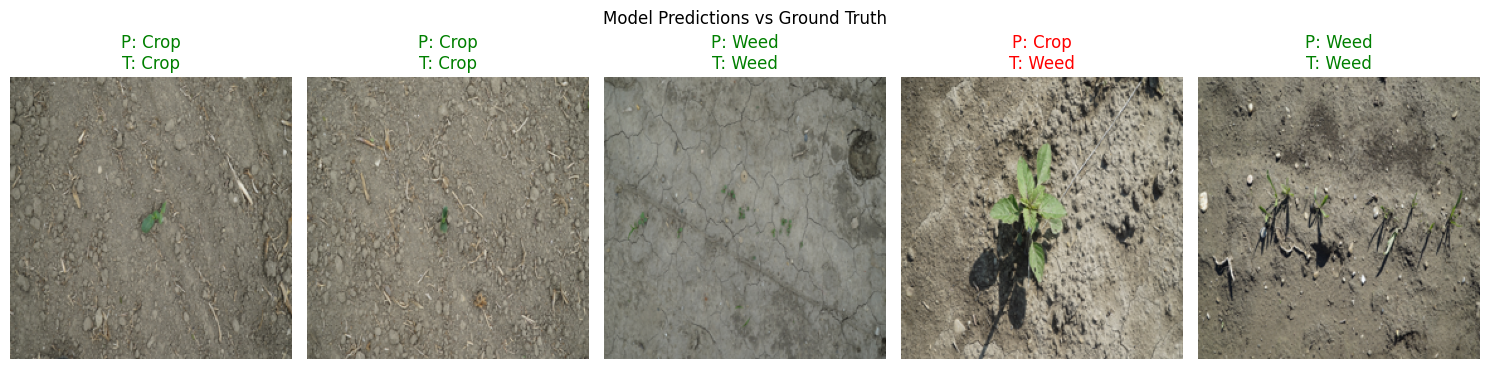

In [6]:
# !pip install opencv-python-headless tqdm --quiet  # Uncomment if needed

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random

# === Set base paths ===
dataset_path = Path("/content/crop_and_weed")  # Make sure you unzip the dataset to this path
images_path = dataset_path / "images"
labelids_path = dataset_path / "annotations" / "labelIds" / "CropAndWeed"
params_path = dataset_path / "annotations" / "params"

# === Define Crop vs Weed label mapping ===
crop_labels = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 94, 24, 18, 13, 26, 27, 15])
weed_labels = set([
    31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87,
    89, 91, 61, 79, 34, 41, 52, 35, 36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51,
    54, 58, 60, 80, 83, 96, 22, 63, 85, 56, 57, 64, 77, 50, 59, 67, 76
])

# === Step 1: Prepare image-label pairs ===
image_label_pairs = []

print("⏳ Scanning masks for classification filtering...\n")
for mask_file in tqdm(sorted(labelids_path.glob("*.png"))):
    mask = np.array(Image.open(mask_file))
    unique_labels = set(np.unique(mask))
    image_id = mask_file.stem

    has_crop = bool(unique_labels & crop_labels)
    has_weed = bool(unique_labels & weed_labels)

    if has_crop and has_weed:
        print(f"[SKIP - Mixed] {image_id} - Labels: {unique_labels}")
        continue
    elif has_crop:
        print(f"[ADD - Crop] {image_id}")
        image_label_pairs.append((image_id, 0))
    elif has_weed:
        print(f"[ADD - Weed] {image_id}")
        image_label_pairs.append((image_id, 1))
    else:
        print(f"[SKIP - Unknown] {image_id} - Labels: {unique_labels}")

# === Step 2: Show counts ===
print(f"\n✅ Total Crop-only images: {sum(1 for _, lbl in image_label_pairs if lbl == 0)}")
print(f"✅ Total Weed-only images: {sum(1 for _, lbl in image_label_pairs if lbl == 1)}")

# === Step 3: Split data ===
if len(image_label_pairs) < 2:
    raise ValueError("Not enough images found for training. Check label mapping or mask files.")

train_ids, test_ids = train_test_split(
    image_label_pairs,
    test_size=0.2,
    random_state=42,
    stratify=[lbl for _, lbl in image_label_pairs]
)

# === Step 4: Load images ===
def load_images(image_ids_labels):
    X, y = [], []
    for image_id, label in tqdm(image_ids_labels):
        image_file = images_path / f"{image_id}.jpg"
        if not image_file.exists():
            print(f"[Missing] {image_file}")
            continue
        try:
            img = Image.open(image_file).resize((224, 224))
            X.append(np.array(img))
            y.append(label)
        except Exception as e:
            print(f"[Error] {image_id}: {e}")
    return np.array(X), to_categorical(np.array(y), num_classes=2)

print("\n📥 Loading training images...")
X_train, y_train = load_images(train_ids)
print("📥 Loading test images...")
X_test, y_test = load_images(test_ids)


from tensorflow.keras.applications import EfficientNetB0, ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

def build_model(architecture="EfficientNetB0", input_shape=(224, 224, 3), num_classes=2):
    if architecture == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = efficientnet_preprocess
    elif architecture == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet_preprocess
    elif architecture == "ResNet101":
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet_preprocess
    elif architecture == "ResNet152":
        base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet_preprocess
    else:
        raise ValueError("Unsupported architecture")

    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = preprocess(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# === Step 5: Define model ===
print("\n🧠 Building EfficientNetB0 model...")
#base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
print("\n🧠 Building model...")
model = build_model(architecture="ResNet152")  # or "ResNet101", "ResNet152", "EfficientNetB0"
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 6: Data Augmentation ===
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=15, zoom_range=0.2)

# === Step 7: Train ===
print("\n🚀 Training...")
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=(X_test, y_test))

# === Step 8: Evaluate ===
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# === Step 9: Visualize predictions ===
print("\n🔍 Visualizing Predictions...")
plt.figure(figsize=(15, 4))
for i, idx in enumerate(random.sample(range(len(X_test)), 5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx])
    pred = np.argmax(model.predict(np.expand_dims(X_test[idx], axis=0)))
    true = np.argmax(y_test[idx])
    color = 'green' if pred == true else 'red'
    plt.title(f"P: {'Crop' if pred == 0 else 'Weed'}\nT: {'Crop' if true == 0 else 'Weed'}", color=color)
    plt.axis('off')
plt.suptitle("Model Predictions vs Ground Truth")
plt.tight_layout()
plt.show()


⏳ Scanning masks for classification filtering...



  0%|          | 3/8034 [00:00<04:33, 29.34it/s]

[ADD - Weed] ave-0000-0001
[SKIP - Unknown] ave-0000-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0000-0005 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0007-0000 - Labels: {np.uint8(0), np.uint8(33), np.uint8(89), np.uint8(35), np.uint8(38), np.uint8(7), np.uint8(39), np.uint8(42), np.uint8(48), np.uint8(83), np.uint8(24), np.uint8(57), np.uint8(255)}


  0%|          | 6/8034 [00:00<04:32, 29.42it/s]

[ADD - Weed] ave-0007-0007
[ADD - Crop] ave-0032-0006
[SKIP - Unknown] ave-0035-0001 - Labels: {np.uint8(0), np.uint8(21)}


  0%|          | 9/8034 [00:00<04:33, 29.39it/s]

[ADD - Weed] ave-0035-0002
[SKIP - Unknown] ave-0035-0003 - Labels: {np.uint8(0), np.uint8(21), np.uint8(255)}
[ADD - Weed] ave-0035-0004


  0%|          | 12/8034 [00:00<04:31, 29.51it/s]

[ADD - Weed] ave-0035-0005
[ADD - Weed] ave-0035-0006
[ADD - Weed] ave-0035-0007


  0%|          | 15/8034 [00:00<04:49, 27.70it/s]

[ADD - Weed] ave-0035-0008
[ADD - Weed] ave-0035-0009
[ADD - Weed] ave-0035-0010


  0%|          | 18/8034 [00:00<04:46, 28.02it/s]

[ADD - Weed] ave-0035-0011
[ADD - Weed] ave-0035-0012
[ADD - Weed] ave-0035-0013


  0%|          | 21/8034 [00:00<04:45, 28.11it/s]

[ADD - Weed] ave-0035-0014
[ADD - Weed] ave-0035-0015
[ADD - Weed] ave-0035-0017


  0%|          | 24/8034 [00:00<04:52, 27.37it/s]

[ADD - Weed] ave-0035-0018
[SKIP - Unknown] ave-0035-0019 - Labels: {np.uint8(0), np.uint8(21), np.uint8(255)}
[SKIP - Unknown] ave-0035-0020 - Labels: {np.uint8(0), np.uint8(21), np.uint8(255)}


  0%|          | 27/8034 [00:00<04:46, 27.92it/s]

[SKIP - Mixed] ave-0037-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(8), np.uint8(9), np.uint8(48), np.uint8(91), np.uint8(255)}
[ADD - Weed] ave-0037-0002
[SKIP - Mixed] ave-0037-0007 - Labels: {np.uint8(0), np.uint8(10), np.uint8(30), np.uint8(255)}


  0%|          | 30/8034 [00:01<04:44, 28.13it/s]

[SKIP - Mixed] ave-0037-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(10), np.uint8(255)}
[SKIP - Mixed] ave-0037-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0037-0010 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(38)}


  0%|          | 33/8034 [00:01<04:39, 28.65it/s]

[SKIP - Mixed] ave-0037-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0037-0012 - Labels: {np.uint8(0), np.uint8(48), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0037-0013 - Labels: {np.uint8(0), np.uint8(255), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0037-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(7)}


  0%|          | 36/8034 [00:01<04:37, 28.86it/s]

[SKIP - Mixed] ave-0037-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(7), np.uint8(255)}
[SKIP - Mixed] ave-0037-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(7), np.uint8(255)}


  0%|          | 39/8034 [00:01<04:36, 28.92it/s]

[SKIP - Mixed] ave-0037-0017 - Labels: {np.uint8(0), np.uint8(10), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0037-0018 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0037-0019 - Labels: {np.uint8(0), np.uint8(255), np.uint8(91), np.uint8(7)}
[SKIP - Mixed] ave-0037-0020 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] ave-0037-0021


  1%|          | 43/8034 [00:01<04:30, 29.52it/s]

[ADD - Crop] ave-0037-0022
[SKIP - Mixed] ave-0037-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7)}


  1%|          | 47/8034 [00:01<04:28, 29.80it/s]

[SKIP - Mixed] ave-0037-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0040-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0040-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0040-0003
[ADD - Crop] ave-0040-0004


  1%|          | 51/8034 [00:01<04:29, 29.66it/s]

[ADD - Crop] ave-0040-0005
[ADD - Crop] ave-0040-0006


  1%|          | 54/8034 [00:01<04:36, 28.82it/s]

[ADD - Crop] ave-0040-0007
[ADD - Crop] ave-0040-0008
[ADD - Crop] ave-0040-0009
[ADD - Crop] ave-0040-0010


  1%|          | 57/8034 [00:01<04:35, 28.91it/s]

[ADD - Crop] ave-0040-0011
[ADD - Crop] ave-0040-0012


  1%|          | 60/8034 [00:02<04:34, 29.08it/s]

[ADD - Crop] ave-0040-0013
[ADD - Crop] ave-0040-0014
[ADD - Crop] ave-0040-0015
[ADD - Crop] ave-0040-0016
[ADD - Crop] ave-0040-0017


  1%|          | 64/8034 [00:02<04:30, 29.50it/s]

[SKIP - Mixed] ave-0040-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0040-0019


  1%|          | 67/8034 [00:02<04:29, 29.55it/s]

[ADD - Weed] ave-0041-0002
[ADD - Weed] ave-0041-0003
[ADD - Crop] ave-0041-0012
[ADD - Crop] ave-0041-0013


  1%|          | 70/8034 [00:02<04:29, 29.59it/s]

[SKIP - Mixed] ave-0041-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[ADD - Crop] ave-0041-0015


  1%|          | 73/8034 [00:02<04:37, 28.68it/s]

[ADD - Crop] ave-0041-0016
[ADD - Crop] ave-0041-0017
[ADD - Crop] ave-0041-0019
[ADD - Crop] ave-0041-0020


  1%|          | 77/8034 [00:02<04:31, 29.35it/s]

[ADD - Crop] ave-0041-0022
[SKIP - Mixed] ave-0042-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(52)}
[SKIP - Mixed] ave-0042-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(52)}


  1%|          | 81/8034 [00:02<04:28, 29.67it/s]

[SKIP - Mixed] ave-0042-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0042-0007 - Labels: {np.uint8(0), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0042-0008
[SKIP - Mixed] ave-0042-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}


  1%|          | 84/8034 [00:02<04:28, 29.56it/s]

[ADD - Crop] ave-0042-0016
[SKIP - Mixed] ave-0042-0017 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0042-0018


  1%|          | 87/8034 [00:03<04:34, 29.00it/s]

[SKIP - Mixed] ave-0042-0019 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] ave-0045-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(56), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0045-0007 - Labels: {np.uint8(0), np.uint8(27), np.uint8(38)}


  1%|          | 90/8034 [00:03<04:33, 29.06it/s]

[ADD - Weed] ave-0045-0009
[SKIP - Mixed] ave-0045-0011 - Labels: {np.uint8(0), np.uint8(27), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0045-0012 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(27), np.uint8(255)}


  1%|          | 94/8034 [00:03<04:27, 29.63it/s]

[SKIP - Mixed] ave-0045-0013 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}
[ADD - Weed] ave-0047-0002
[ADD - Weed] ave-0047-0003
[ADD - Weed] ave-0047-0004
[ADD - Weed] ave-0047-0005
[ADD - Weed] ave-0047-0006


  1%|          | 100/8034 [00:03<04:35, 28.83it/s]

[ADD - Weed] ave-0047-0008
[ADD - Weed] ave-0047-0009
[ADD - Weed] ave-0047-0010
[ADD - Weed] ave-0047-0011
[ADD - Weed] ave-0047-0017
[SKIP - Mixed] ave-0048-0002 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(27), np.uint8(255)}


  1%|▏         | 106/8034 [00:03<04:42, 28.06it/s]

[SKIP - Mixed] ave-0048-0004 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(54), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0048-0006 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(38)}
[SKIP - Mixed] ave-0048-0017 - Labels: {np.uint8(0), np.uint8(27), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0048-0019 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0048-0022 - Labels: {np.uint8(0), np.uint8(255), np.uint8(38), np.uint8(42), np.uint8(27), np.uint8(31)}
[SKIP - Mixed] ave-0048-0027 - Labels: {np.uint8(0), np.uint8(38), np.uint8(27), np.uint8(31), np.uint8(255)}


  1%|▏         | 112/8034 [00:03<04:37, 28.54it/s]

[SKIP - Mixed] ave-0048-0036 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Unknown] ave-0049-0001 - Labels: {np.uint8(0), np.uint8(19)}
[SKIP - Unknown] ave-0049-0002 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[SKIP - Unknown] ave-0049-0004 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[SKIP - Unknown] ave-0049-0007 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[SKIP - Unknown] ave-0049-0009 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}


  1%|▏         | 118/8034 [00:04<04:39, 28.34it/s]

[ADD - Weed] ave-0049-0010
[SKIP - Unknown] ave-0049-0011 - Labels: {np.uint8(0), np.uint8(19)}
[SKIP - Unknown] ave-0049-0013 - Labels: {np.uint8(0), np.uint8(19)}
[ADD - Weed] ave-0049-0014
[SKIP - Unknown] ave-0049-0015 - Labels: {np.uint8(0), np.uint8(19)}
[SKIP - Unknown] ave-0049-0016 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}
[SKIP - Unknown] ave-0049-0017 - Labels: {np.uint8(0), np.uint8(19), np.uint8(255)}


  2%|▏         | 122/8034 [00:04<04:33, 28.93it/s]

[ADD - Weed] ave-0049-0018
[SKIP - Unknown] ave-0049-0019 - Labels: {np.uint8(0), np.uint8(19)}
[ADD - Weed] ave-0050-0001
[SKIP - Unknown] ave-0050-0002 - Labels: {np.uint8(0), np.uint8(20), np.uint8(255)}


  2%|▏         | 126/8034 [00:04<04:31, 29.17it/s]

[ADD - Weed] ave-0050-0004
[SKIP - Unknown] ave-0050-0006 - Labels: {np.uint8(0), np.uint8(20), np.uint8(255)}


  2%|▏         | 129/8034 [00:04<04:31, 29.14it/s]

[SKIP - Unknown] ave-0050-0007 - Labels: {np.uint8(0), np.uint8(20)}
[SKIP - Unknown] ave-0050-0008 - Labels: {np.uint8(0), np.uint8(20)}
[ADD - Weed] ave-0050-0013
[SKIP - Unknown] ave-0050-0014 - Labels: {np.uint8(0), np.uint8(20)}


  2%|▏         | 132/8034 [00:04<04:54, 26.83it/s]

[ADD - Weed] ave-0050-0015


  2%|▏         | 135/8034 [00:04<05:37, 23.42it/s]

[ADD - Weed] ave-0050-0016
[SKIP - Mixed] ave-0051-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0051-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24)}
[SKIP - Mixed] ave-0051-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}


  2%|▏         | 138/8034 [00:04<06:06, 21.55it/s]

[SKIP - Mixed] ave-0051-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0053-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0053-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0053-0012 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(89), np.uint8(255)}


  2%|▏         | 141/8034 [00:05<06:52, 19.14it/s]

[SKIP - Mixed] ave-0053-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0053-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0053-0020 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}


  2%|▏         | 144/8034 [00:05<07:02, 18.69it/s]

[SKIP - Mixed] ave-0057-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}


  2%|▏         | 146/8034 [00:05<07:12, 18.25it/s]

[SKIP - Mixed] ave-0057-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0057-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0057-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(91), np.uint8(255)}


  2%|▏         | 148/8034 [00:05<07:24, 17.72it/s]

[SKIP - Mixed] ave-0057-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(39), np.uint8(24), np.uint8(91), np.uint8(255)}


  2%|▏         | 150/8034 [00:05<07:59, 16.44it/s]

[SKIP - Mixed] ave-0057-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0057-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(255)}


  2%|▏         | 152/8034 [00:05<08:11, 16.02it/s]

[SKIP - Mixed] ave-0057-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0057-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}


  2%|▏         | 154/8034 [00:05<08:18, 15.82it/s]

[SKIP - Mixed] ave-0057-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0057-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69)}
[SKIP - Mixed] ave-0057-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


  2%|▏         | 156/8034 [00:06<08:49, 14.88it/s]

[SKIP - Mixed] ave-0057-0020 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0058-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(48), np.uint8(52), np.uint8(91), np.uint8(255)}


  2%|▏         | 158/8034 [00:06<08:39, 15.16it/s]

[SKIP - Mixed] ave-0058-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(52), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(87), np.uint8(91), np.uint8(255)}


  2%|▏         | 160/8034 [00:06<08:44, 15.02it/s]

[SKIP - Mixed] ave-0058-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(48), np.uint8(91), np.uint8(255)}


  2%|▏         | 162/8034 [00:06<08:58, 14.62it/s]

[SKIP - Mixed] ave-0058-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(91)}
[SKIP - Mixed] ave-0058-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91), np.uint8(255)}


  2%|▏         | 164/8034 [00:06<08:45, 14.97it/s]

[ADD - Crop] ave-0058-0011
[ADD - Crop] ave-0058-0012
[SKIP - Mixed] ave-0058-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(91), np.uint8(255)}


  2%|▏         | 166/8034 [00:06<08:57, 14.63it/s]

[SKIP - Mixed] ave-0058-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0058-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91), np.uint8(255)}


  2%|▏         | 168/8034 [00:06<09:11, 14.26it/s]

[SKIP - Mixed] ave-0058-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(91), np.uint8(255)}


  2%|▏         | 170/8034 [00:07<09:03, 14.46it/s]

[SKIP - Mixed] ave-0058-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0058-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0059-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(52), np.uint8(87), np.uint8(255)}


  2%|▏         | 172/8034 [00:07<09:05, 14.42it/s]

[SKIP - Mixed] ave-0059-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0062-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


  2%|▏         | 174/8034 [00:07<09:30, 13.77it/s]

[ADD - Weed] ave-0063-0003


  2%|▏         | 176/8034 [00:07<09:18, 14.06it/s]

[ADD - Weed] ave-0063-0004
[ADD - Weed] ave-0063-0005
[ADD - Weed] ave-0063-0006


  2%|▏         | 180/8034 [00:07<09:43, 13.45it/s]

[ADD - Weed] ave-0063-0007
[ADD - Weed] ave-0063-0008
[ADD - Weed] ave-0063-0009


  2%|▏         | 182/8034 [00:07<09:52, 13.24it/s]

[ADD - Weed] ave-0063-0010
[ADD - Weed] ave-0063-0011
[SKIP - Mixed] ave-0063-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(38)}


  2%|▏         | 186/8034 [00:08<09:16, 14.11it/s]

[ADD - Weed] ave-0063-0013
[ADD - Weed] ave-0063-0014
[ADD - Weed] ave-0063-0015
[ADD - Weed] ave-0063-0016


  2%|▏         | 190/8034 [00:08<08:48, 14.83it/s]

[SKIP - Mixed] ave-0063-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] ave-0063-0018
[ADD - Weed] ave-0063-0020
[ADD - Crop] ave-0065-0010


  2%|▏         | 194/8034 [00:08<08:54, 14.66it/s]

[SKIP - Mixed] ave-0065-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0065-0013
[SKIP - Mixed] ave-0065-0014 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}


  2%|▏         | 196/8034 [00:08<09:13, 14.15it/s]

[SKIP - Mixed] ave-0065-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0065-0017 - Labels: {np.uint8(0), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] ave-0065-0018 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}


  2%|▏         | 200/8034 [00:09<08:47, 14.86it/s]

[ADD - Crop] ave-0067-0001
[ADD - Crop] ave-0067-0002
[SKIP - Mixed] ave-0067-0003 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}
[ADD - Crop] ave-0067-0004


  3%|▎         | 204/8034 [00:09<08:43, 14.96it/s]

[ADD - Crop] ave-0067-0005
[ADD - Crop] ave-0067-0006
[ADD - Crop] ave-0067-0007


  3%|▎         | 208/8034 [00:09<08:26, 15.44it/s]

[ADD - Crop] ave-0067-0008
[ADD - Crop] ave-0067-0009
[ADD - Crop] ave-0067-0010
[SKIP - Mixed] ave-0067-0011 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}


  3%|▎         | 212/8034 [00:09<08:01, 16.24it/s]

[SKIP - Mixed] ave-0067-0012 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}
[SKIP - Mixed] ave-0067-0013 - Labels: {np.uint8(0), np.uint8(18), np.uint8(91)}
[ADD - Crop] ave-0067-0014
[ADD - Crop] ave-0067-0015


  3%|▎         | 216/8034 [00:10<07:34, 17.20it/s]

[ADD - Crop] ave-0067-0016
[ADD - Crop] ave-0067-0017
[ADD - Crop] ave-0067-0019
[ADD - Crop] ave-0067-0020


  3%|▎         | 218/8034 [00:10<07:26, 17.50it/s]

[ADD - Crop] ave-0067-0021
[SKIP - Mixed] ave-0068-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(64), np.uint8(13), np.uint8(255)}
[ADD - Crop] ave-0069-0001


  3%|▎         | 222/8034 [00:10<07:48, 16.69it/s]

[ADD - Crop] ave-0069-0002
[ADD - Crop] ave-0069-0003
[ADD - Crop] ave-0069-0004
[ADD - Crop] ave-0069-0006


  3%|▎         | 227/8034 [00:10<06:42, 19.41it/s]

[ADD - Crop] ave-0069-0007
[ADD - Crop] ave-0069-0008
[ADD - Crop] ave-0069-0009
[SKIP - Mixed] ave-0069-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0069-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0069-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(69)}


  3%|▎         | 234/8034 [00:10<05:16, 24.66it/s]

[ADD - Crop] ave-0069-0014
[SKIP - Mixed] ave-0069-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0069-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0069-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0069-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0069-0020


  3%|▎         | 241/8034 [00:11<04:46, 27.24it/s]

[ADD - Crop] ave-0072-0001
[ADD - Crop] ave-0072-0002
[ADD - Crop] ave-0072-0003
[SKIP - Mixed] ave-0072-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0072-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0072-0009
[ADD - Crop] ave-0072-0010


  3%|▎         | 247/8034 [00:11<04:53, 26.56it/s]

[SKIP - Mixed] ave-0072-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[ADD - Crop] ave-0072-0012
[ADD - Crop] ave-0072-0013
[ADD - Crop] ave-0072-0014
[ADD - Crop] ave-0072-0015


  3%|▎         | 253/8034 [00:11<04:39, 27.88it/s]

[ADD - Crop] ave-0072-0016
[SKIP - Mixed] ave-0072-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0072-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(36), np.uint8(38)}
[SKIP - Mixed] ave-0072-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(52)}
[SKIP - Mixed] ave-0075-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0075-0002


  3%|▎         | 259/8034 [00:11<04:30, 28.72it/s]

[ADD - Crop] ave-0075-0004
[ADD - Crop] ave-0075-0005
[ADD - Crop] ave-0075-0006
[ADD - Crop] ave-0075-0008
[ADD - Crop] ave-0075-0011
[SKIP - Mixed] ave-0075-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0075-0014


  3%|▎         | 265/8034 [00:12<04:26, 29.19it/s]

[ADD - Crop] ave-0075-0015
[ADD - Crop] ave-0075-0016
[ADD - Crop] ave-0075-0017
[ADD - Crop] ave-0075-0018
[SKIP - Mixed] ave-0076-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0076-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(48)}


  3%|▎         | 272/8034 [00:12<04:29, 28.82it/s]

[SKIP - Mixed] ave-0076-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0076-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0076-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0076-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0076-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0076-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  3%|▎         | 278/8034 [00:12<04:37, 27.99it/s]

[SKIP - Mixed] ave-0076-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0076-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(69)}
[SKIP - Mixed] ave-0076-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(91)}
[SKIP - Mixed] ave-0076-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255), np.uint8(69), np.uint8(31)}
[SKIP - Mixed] ave-0077-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(91)}
[ADD - Crop] ave-0077-0020


  4%|▎         | 284/8034 [00:12<04:38, 27.82it/s]

[ADD - Weed] ave-0078-0001
[ADD - Weed] ave-0078-0003
[SKIP - Mixed] ave-0079-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0079-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(38)}
[SKIP - Mixed] ave-0079-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}


  4%|▎         | 290/8034 [00:12<04:31, 28.54it/s]

[SKIP - Mixed] ave-0079-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0079-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[SKIP - Mixed] ave-0079-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}


  4%|▎         | 293/8034 [00:13<04:30, 28.65it/s]

[SKIP - Mixed] ave-0079-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0079-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38)}
[SKIP - Mixed] ave-0080-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0080-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0080-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0080-0008


  4%|▎         | 301/8034 [00:13<04:24, 29.19it/s]

[SKIP - Mixed] ave-0080-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0080-0015
[ADD - Crop] ave-0080-0018
[ADD - Crop] ave-0080-0019
[SKIP - Mixed] ave-0080-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0081-0008 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}


  4%|▍         | 307/8034 [00:13<04:34, 28.13it/s]

[SKIP - Mixed] ave-0081-0010 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0081-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0082-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(48), np.uint8(18), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0083-0001
[SKIP - Mixed] ave-0083-0002 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7)}
[ADD - Crop] ave-0083-0003


  4%|▍         | 313/8034 [00:13<04:37, 27.87it/s]

[ADD - Crop] ave-0083-0005
[SKIP - Mixed] ave-0083-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(69)}
[ADD - Crop] ave-0083-0012
[ADD - Crop] ave-0083-0013
[ADD - Crop] ave-0083-0014
[SKIP - Mixed] ave-0083-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(7)}


  4%|▍         | 319/8034 [00:13<04:28, 28.71it/s]

[ADD - Crop] ave-0083-0018
[SKIP - Mixed] ave-0083-0019 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42), np.uint8(33)}
[ADD - Crop] ave-0083-0020
[ADD - Crop] ave-0083-0021
[SKIP - Mixed] ave-0083-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0083-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}


  4%|▍         | 326/8034 [00:14<04:22, 29.41it/s]

[SKIP - Mixed] ave-0084-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(9), np.uint8(31)}
[SKIP - Mixed] ave-0084-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0084-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(255), np.uint8(9), np.uint8(31)}
[SKIP - Mixed] ave-0084-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(7), np.uint8(89)}
[SKIP - Mixed] ave-0084-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] ave-0088-0010 - Labels: {np.uint8(0), np.uint8(91), np.uint8(11), np.uint8(255)}
[ADD - Crop] ave-0092-0008


  4%|▍         | 332/8034 [00:14<04:27, 28.79it/s]

[ADD - Crop] ave-0097-0007
[ADD - Crop] ave-0097-0014
[SKIP - Mixed] ave-0098-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0100-0009
[ADD - Crop] ave-0100-0019
[SKIP - Mixed] ave-0103-0003 - Labels: {np.uint8(0), np.uint8(96), np.uint8(48), np.uint8(18), np.uint8(255)}


  4%|▍         | 338/8034 [00:14<04:53, 26.24it/s]

[SKIP - Mixed] ave-0103-0004 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0104-0012
[ADD - Weed] ave-0104-0013
[SKIP - Mixed] ave-0105-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0105-0022 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(87), np.uint8(255)}


  4%|▍         | 345/8034 [00:14<04:32, 28.21it/s]

[SKIP - Mixed] ave-0108-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(48), np.uint8(87), np.uint8(30), np.uint8(31)}
[SKIP - Mixed] ave-0109-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(36), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0109-0004
[SKIP - Mixed] ave-0109-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0109-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0109-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(87)}


  4%|▍         | 351/8034 [00:15<04:25, 28.97it/s]

[SKIP - Mixed] ave-0109-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0109-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}


  4%|▍         | 358/8034 [00:15<04:20, 29.41it/s]

[SKIP - Mixed] ave-0109-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255), np.uint8(69), np.uint8(48), np.uint8(95)}
[SKIP - Mixed] ave-0109-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0109-0024 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0109-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0110-0003


  5%|▍         | 364/8034 [00:15<04:19, 29.58it/s]

[ADD - Crop] ave-0110-0004
[ADD - Crop] ave-0110-0005
[SKIP - Mixed] ave-0110-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(45), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0110-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(89)}
[SKIP - Mixed] ave-0110-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0110-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(87), np.uint8(24), np.uint8(255)}


  5%|▍         | 370/8034 [00:15<04:27, 28.67it/s]

[SKIP - Mixed] ave-0110-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0110-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0110-0016
[ADD - Crop] ave-0110-0017
[SKIP - Mixed] ave-0110-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0110-0019


  5%|▍         | 376/8034 [00:15<04:21, 29.24it/s]

[SKIP - Mixed] ave-0110-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0111-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0111-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0111-0008
[SKIP - Mixed] ave-0111-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0111-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24)}


  5%|▍         | 379/8034 [00:16<04:24, 28.97it/s]

[ADD - Crop] ave-0111-0011
[SKIP - Mixed] ave-0112-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0112-0003
[SKIP - Mixed] ave-0112-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  5%|▍         | 386/8034 [00:16<04:31, 28.15it/s]

[SKIP - Mixed] ave-0112-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0112-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  5%|▍         | 392/8034 [00:16<04:29, 28.34it/s]

[SKIP - Mixed] ave-0112-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0112-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


  5%|▍         | 398/8034 [00:16<04:39, 27.28it/s]

[SKIP - Mixed] ave-0112-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0112-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0117-0001 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0117-0008
[ADD - Crop] ave-0117-0010
[ADD - Crop] ave-0117-0011


  5%|▌         | 404/8034 [00:16<04:29, 28.34it/s]

[SKIP - Mixed] ave-0117-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0117-0013
[ADD - Crop] ave-0117-0014
[ADD - Crop] ave-0117-0017
[ADD - Crop] ave-0117-0018
[SKIP - Mixed] ave-0117-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}


  5%|▌         | 410/8034 [00:17<04:25, 28.73it/s]

[ADD - Crop] ave-0117-0020
[SKIP - Mixed] ave-0118-0001 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0005 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0118-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[ADD - Crop] ave-0118-0007


  5%|▌         | 417/8034 [00:17<04:27, 28.48it/s]

[ADD - Crop] ave-0118-0008
[ADD - Crop] ave-0118-0009
[ADD - Crop] ave-0118-0010
[ADD - Crop] ave-0118-0011
[ADD - Crop] ave-0118-0012
[ADD - Crop] ave-0118-0013


  5%|▌         | 423/8034 [00:17<04:31, 28.01it/s]

[ADD - Crop] ave-0118-0014
[ADD - Crop] ave-0118-0015
[ADD - Crop] ave-0118-0016
[ADD - Crop] ave-0118-0017
[ADD - Crop] ave-0118-0018
[ADD - Crop] ave-0118-0019


  5%|▌         | 429/8034 [00:17<04:35, 27.65it/s]

[ADD - Crop] ave-0118-0020
[ADD - Crop] ave-0118-0021
[ADD - Crop] ave-0118-0022
[ADD - Crop] ave-0118-0023
[ADD - Crop] ave-0118-0024
[ADD - Crop] ave-0118-0025


  5%|▌         | 435/8034 [00:18<04:26, 28.49it/s]

[ADD - Crop] ave-0118-0026
[ADD - Crop] ave-0118-0027
[ADD - Crop] ave-0118-0028
[ADD - Crop] ave-0118-0029
[ADD - Crop] ave-0118-0030
[ADD - Crop] ave-0118-0031
[ADD - Crop] ave-0118-0032


  6%|▌         | 443/8034 [00:18<04:16, 29.54it/s]

[ADD - Crop] ave-0118-0033
[ADD - Crop] ave-0118-0034
[SKIP - Mixed] ave-0122-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(36), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0122-0005 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(36), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] ave-0122-0010 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0122-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0122-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(255)}


  6%|▌         | 449/8034 [00:18<04:15, 29.65it/s]

[SKIP - Mixed] ave-0122-0019 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(255)}
[SKIP - Mixed] ave-0123-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0123-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0123-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0123-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(255)}
[ADD - Crop] ave-0125-0006


  6%|▌         | 455/8034 [00:18<04:24, 28.69it/s]

[ADD - Crop] ave-0125-0007
[SKIP - Mixed] ave-0125-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0125-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(31)}
[ADD - Crop] ave-0125-0010
[ADD - Crop] ave-0125-0012
[SKIP - Mixed] ave-0125-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}


  6%|▌         | 461/8034 [00:18<04:19, 29.16it/s]

[SKIP - Mixed] ave-0125-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(31)}
[ADD - Crop] ave-0125-0016
[ADD - Crop] ave-0125-0017
[ADD - Crop] ave-0125-0018
[ADD - Crop] ave-0125-0019
[ADD - Crop] ave-0125-0020


  6%|▌         | 468/8034 [00:19<04:14, 29.68it/s]

[SKIP - Mixed] ave-0126-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0126-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(255)}
[ADD - Crop] ave-0126-0008
[SKIP - Mixed] ave-0126-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(89)}


  6%|▌         | 474/8034 [00:19<04:33, 27.61it/s]

[SKIP - Mixed] ave-0126-0011 - Labels: {np.uint8(0), np.uint8(89), np.uint8(3), np.uint8(255)}
[ADD - Crop] ave-0126-0013
[ADD - Crop] ave-0126-0016
[SKIP - Mixed] ave-0126-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[ADD - Crop] ave-0126-0018


  6%|▌         | 480/8034 [00:19<04:28, 28.12it/s]

[ADD - Crop] ave-0126-0019
[ADD - Crop] ave-0126-0020
[SKIP - Mixed] ave-0127-0001 - Labels: {np.uint8(0), np.uint8(4), np.uint8(39), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0127-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(4), np.uint8(255)}
[SKIP - Mixed] ave-0127-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0127-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(4), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0127-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}


  6%|▌         | 486/8034 [00:19<04:37, 27.17it/s]

[SKIP - Mixed] ave-0127-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0127-0014
[SKIP - Mixed] ave-0127-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(4), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0127-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(255), np.uint8(69), np.uint8(31)}
[SKIP - Mixed] ave-0127-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(36), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0127-0022


  6%|▌         | 492/8034 [00:20<05:27, 23.03it/s]

[ADD - Crop] ave-0127-0023
[SKIP - Mixed] ave-0127-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(255)}
[ADD - Weed] ave-0128-0006
[ADD - Weed] ave-0128-0007


  6%|▌         | 495/8034 [00:20<05:47, 21.68it/s]

[ADD - Crop] ave-0130-0001
[ADD - Crop] ave-0130-0002
[ADD - Crop] ave-0130-0003
[ADD - Crop] ave-0130-0004


  6%|▌         | 498/8034 [00:20<06:15, 20.08it/s]

[ADD - Crop] ave-0130-0005
[SKIP - Mixed] ave-0130-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[SKIP - Mixed] ave-0130-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(3), np.uint8(255)}
[SKIP - Mixed] ave-0130-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(30), np.uint8(255)}


  6%|▋         | 503/8034 [00:20<06:57, 18.04it/s]

[ADD - Crop] ave-0130-0009
[SKIP - Mixed] ave-0130-0011 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(30)}
[SKIP - Mixed] ave-0130-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0130-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(36), np.uint8(48), np.uint8(30), np.uint8(255)}


  6%|▋         | 507/8034 [00:21<07:12, 17.42it/s]

[SKIP - Mixed] ave-0130-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0130-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(4), np.uint8(69), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0130-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(30), np.uint8(255)}
[ADD - Crop] ave-0131-0004


  6%|▋         | 511/8034 [00:21<07:13, 17.37it/s]

[ADD - Crop] ave-0131-0005
[ADD - Crop] ave-0131-0006
[SKIP - Mixed] ave-0131-0007 - Labels: {np.uint8(0), np.uint8(26), np.uint8(48), np.uint8(42)}
[ADD - Crop] ave-0131-0008


  6%|▋         | 515/8034 [00:21<06:56, 18.06it/s]

[ADD - Crop] ave-0131-0009
[SKIP - Mixed] ave-0131-0010 - Labels: {np.uint8(0), np.uint8(26), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0131-0011
[ADD - Crop] ave-0131-0013


  6%|▋         | 519/8034 [00:21<06:56, 18.03it/s]

[ADD - Crop] ave-0131-0014
[ADD - Crop] ave-0131-0015
[SKIP - Mixed] ave-0131-0016 - Labels: {np.uint8(0), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(26), np.uint8(255)}
[ADD - Crop] ave-0132-0013


  7%|▋         | 523/8034 [00:21<06:58, 17.93it/s]

[SKIP - Mixed] ave-0132-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(3), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0132-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0134-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(36), np.uint8(95), np.uint8(255)}
[SKIP - Mixed] ave-0134-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(255)}


  7%|▋         | 527/8034 [00:22<06:59, 17.91it/s]

[SKIP - Mixed] ave-0134-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(36), np.uint8(255)}
[ADD - Crop] ave-0134-0010
[SKIP - Mixed] ave-0134-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(255)}
[ADD - Crop] ave-0134-0012


  7%|▋         | 531/8034 [00:22<08:03, 15.50it/s]

[SKIP - Mixed] ave-0134-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(76), np.uint8(255)}
[SKIP - Mixed] ave-0134-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(45), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] ave-0134-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(3), np.uint8(33), np.uint8(36), np.uint8(45), np.uint8(29), np.uint8(255)}


  7%|▋         | 535/8034 [00:22<07:33, 16.54it/s]

[SKIP - Mixed] ave-0134-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(42), np.uint8(45), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0136-0005 - Labels: {np.uint8(0), np.uint8(48), np.uint8(4), np.uint8(52)}
[SKIP - Mixed] ave-0136-0007 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0136-0010 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(91), np.uint8(31)}


  7%|▋         | 539/8034 [00:22<07:33, 16.52it/s]

[SKIP - Mixed] ave-0136-0014 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0136-0017 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0138-0013 - Labels: {np.uint8(0), np.uint8(4), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0138-0014 - Labels: {np.uint8(0), np.uint8(4), np.uint8(48), np.uint8(87), np.uint8(255)}


  7%|▋         | 543/8034 [00:23<07:21, 16.99it/s]

[SKIP - Mixed] ave-0138-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0138-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0138-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0138-0020 - Labels: {np.uint8(0), np.uint8(4), np.uint8(52), np.uint8(89), np.uint8(255)}


  7%|▋         | 547/8034 [00:23<06:56, 17.95it/s]

[ADD - Crop] ave-0139-0003
[ADD - Crop] ave-0139-0004
[ADD - Crop] ave-0139-0005
[ADD - Crop] ave-0139-0006
[ADD - Crop] ave-0139-0007


  7%|▋         | 553/8034 [00:23<05:19, 23.42it/s]

[ADD - Crop] ave-0139-0008
[ADD - Crop] ave-0139-0010
[ADD - Crop] ave-0139-0011
[ADD - Crop] ave-0139-0013
[ADD - Crop] ave-0139-0015
[ADD - Crop] ave-0139-0017
[ADD - Crop] ave-0139-0018


  7%|▋         | 559/8034 [00:23<04:52, 25.52it/s]

[ADD - Crop] ave-0139-0020
[ADD - Crop] ave-0140-0006
[ADD - Crop] ave-0140-0007
[ADD - Crop] ave-0140-0009
[ADD - Crop] ave-0140-0012
[ADD - Crop] ave-0140-0013


  7%|▋         | 566/8034 [00:23<04:31, 27.56it/s]

[ADD - Crop] ave-0140-0014
[ADD - Crop] ave-0140-0015
[ADD - Crop] ave-0140-0016
[ADD - Crop] ave-0140-0017
[ADD - Crop] ave-0140-0018
[ADD - Crop] ave-0140-0019


  7%|▋         | 573/8034 [00:24<04:21, 28.54it/s]

[ADD - Crop] ave-0140-0020
[SKIP - Mixed] ave-0141-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0141-0006
[SKIP - Mixed] ave-0141-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0141-0008
[SKIP - Mixed] ave-0141-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0144-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(255), np.uint8(31)}


  7%|▋         | 579/8034 [00:24<04:19, 28.69it/s]

[SKIP - Mixed] ave-0144-0006 - Labels: {np.uint8(0), np.uint8(18), np.uint8(255), np.uint8(31)}
[SKIP - Mixed] ave-0144-0016 - Labels: {np.uint8(0), np.uint8(18), np.uint8(89), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] ave-0144-0020 - Labels: {np.uint8(0), np.uint8(89), np.uint8(18), np.uint8(31)}
[SKIP - Mixed] ave-0144-0021 - Labels: {np.uint8(0), np.uint8(48), np.uint8(18), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0146-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(39), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0146-0002 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3), np.uint8(36), np.uint8(45), np.uint8(83), np.uint8(54), np.uint8(255)}


  7%|▋         | 585/8034 [00:24<04:21, 28.50it/s]

[SKIP - Mixed] ave-0146-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0146-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0146-0021 - Labels: {np.uint8(0), np.uint8(3), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] ave-0147-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(39), np.uint8(45), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] ave-0147-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(36), np.uint8(35), np.uint8(45), np.uint8(51), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] ave-0147-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(3), np.uint8(45), np.uint8(51), np.uint8(255)}


  7%|▋         | 591/8034 [00:24<04:19, 28.64it/s]

[ADD - Weed] ave-0147-0035
[SKIP - Mixed] ave-0148-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(48), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(45), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0148-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(36), np.uint8(69), np.uint8(45), np.uint8(48), np.uint8(30), np.uint8(255)}


  7%|▋         | 597/8034 [00:25<04:23, 28.26it/s]

[SKIP - Mixed] ave-0149-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0149-0002
[ADD - Crop] ave-0149-0003
[SKIP - Mixed] ave-0149-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0149-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0149-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(52), np.uint8(255)}


  8%|▊         | 604/8034 [00:25<04:22, 28.33it/s]

[ADD - Crop] ave-0149-0015
[SKIP - Mixed] ave-0149-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}
[ADD - Crop] ave-0150-0006
[SKIP - Mixed] ave-0150-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0150-0011
[SKIP - Mixed] ave-0150-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}


  8%|▊         | 611/8034 [00:25<04:16, 28.94it/s]

[SKIP - Mixed] ave-0150-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(39)}
[ADD - Crop] ave-0151-0004
[SKIP - Mixed] ave-0151-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0151-0009
[ADD - Crop] ave-0151-0010
[ADD - Crop] ave-0151-0013
[ADD - Crop] ave-0151-0014


  8%|▊         | 617/8034 [00:25<04:22, 28.30it/s]

[ADD - Crop] ave-0151-0015
[ADD - Crop] ave-0151-0020
[ADD - Crop] ave-0152-0004
[SKIP - Mixed] ave-0152-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0152-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0152-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}


  8%|▊         | 624/8034 [00:26<04:14, 29.11it/s]

[ADD - Crop] ave-0153-0003
[SKIP - Mixed] ave-0153-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0153-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0153-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[ADD - Crop] ave-0153-0008
[SKIP - Mixed] ave-0153-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[ADD - Crop] ave-0153-0012


  8%|▊         | 627/8034 [00:26<04:22, 28.20it/s]

[ADD - Crop] ave-0153-0013
[SKIP - Mixed] ave-0153-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0153-0015
[ADD - Crop] ave-0153-0016
[SKIP - Mixed] ave-0153-0017 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0153-0018


  8%|▊         | 634/8034 [00:26<04:14, 29.07it/s]

[ADD - Crop] ave-0153-0019
[ADD - Crop] ave-0153-0020
[SKIP - Mixed] ave-0154-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0154-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(33)}
[SKIP - Mixed] ave-0154-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] ave-0154-0004


  8%|▊         | 641/8034 [00:26<04:10, 29.53it/s]

[SKIP - Mixed] ave-0154-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0154-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(255)}
[SKIP - Mixed] ave-0154-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] ave-0154-0010
[SKIP - Mixed] ave-0154-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[SKIP - Mixed] ave-0154-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0154-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}


  8%|▊         | 647/8034 [00:26<04:16, 28.77it/s]

[SKIP - Mixed] ave-0154-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] ave-0156-0001
[ADD - Crop] ave-0156-0002
[ADD - Crop] ave-0156-0003
[ADD - Crop] ave-0156-0005
[ADD - Crop] ave-0156-0008


  8%|▊         | 653/8034 [00:27<04:13, 29.10it/s]

[ADD - Crop] ave-0156-0009
[ADD - Crop] ave-0156-0014
[ADD - Crop] ave-0156-0016
[ADD - Crop] ave-0156-0021
[ADD - Crop] ave-0156-0022
[SKIP - Mixed] ave-0157-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}


  8%|▊         | 660/8034 [00:27<04:16, 28.78it/s]

[SKIP - Mixed] ave-0157-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(69), np.uint8(15), np.uint8(95)}
[SKIP - Mixed] ave-0157-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(15), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] ave-0157-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(66), np.uint8(15), np.uint8(255)}
[ADD - Crop] ave-0157-0011
[ADD - Crop] ave-0157-0012
[ADD - Crop] ave-0157-0014
[ADD - Crop] ave-0157-0015


  8%|▊         | 666/8034 [00:27<04:12, 29.13it/s]

[ADD - Crop] ave-0157-0016
[ADD - Crop] ave-0157-0018
[SKIP - Mixed] ave-0157-0019 - Labels: {np.uint8(0), np.uint8(52), np.uint8(15)}
[ADD - Crop] ave-0157-0021
[SKIP - Mixed] ave-0157-0023 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0157-0025 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0158-0008


  8%|▊         | 673/8034 [00:27<04:13, 29.04it/s]

[SKIP - Mixed] ave-0159-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3)}
[SKIP - Mixed] ave-0159-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0159-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0159-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(255), np.uint8(31)}
[SKIP - Mixed] ave-0161-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(3), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0161-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}


  8%|▊         | 680/8034 [00:27<04:10, 29.38it/s]

[SKIP - Mixed] ave-0161-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(30), np.uint8(255)}
[ADD - Weed] ave-0168-0001
[ADD - Weed] ave-0168-0002
[ADD - Weed] ave-0168-0003
[ADD - Weed] ave-0168-0023
[ADD - Weed] ave-0168-0030
[ADD - Weed] ave-0168-0031


  9%|▊         | 686/8034 [00:28<04:17, 28.53it/s]

[ADD - Weed] ave-0168-0032
[ADD - Weed] ave-0169-0022
[ADD - Weed] ave-0176-0004
[ADD - Weed] ave-0176-0016
[ADD - Weed] ave-0176-0019
[ADD - Weed] ave-0176-0020


  9%|▊         | 693/8034 [00:28<04:11, 29.21it/s]

[ADD - Weed] ave-0176-0021
[ADD - Weed] ave-0176-0023
[ADD - Weed] ave-0176-0024
[ADD - Weed] ave-0176-0025
[ADD - Weed] ave-0176-0027
[ADD - Weed] ave-0176-0029


  9%|▊         | 699/8034 [00:28<04:08, 29.46it/s]

[ADD - Weed] ave-0178-0015
[ADD - Weed] ave-0179-0007
[ADD - Weed] ave-0179-0008
[ADD - Weed] ave-0179-0011
[ADD - Weed] ave-0179-0012
[ADD - Weed] ave-0179-0013


  9%|▉         | 706/8034 [00:28<04:08, 29.47it/s]

[ADD - Weed] ave-0179-0014
[ADD - Weed] ave-0179-0015
[ADD - Weed] ave-0179-0016
[SKIP - Mixed] ave-0181-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(45), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0004 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(52), np.uint8(27), np.uint8(255)}


  9%|▉         | 712/8034 [00:29<04:09, 29.31it/s]

[SKIP - Mixed] ave-0181-0006 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(48), np.uint8(52), np.uint8(27), np.uint8(95)}
[SKIP - Mixed] ave-0181-0008 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(38)}
[SKIP - Mixed] ave-0181-0009 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0181-0010 - Labels: {np.uint8(0), np.uint8(45), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0013 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}


  9%|▉         | 718/8034 [00:29<04:25, 27.58it/s]

[SKIP - Mixed] ave-0181-0014 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0181-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0016 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0181-0017 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[SKIP - Mixed] ave-0181-0018 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[ADD - Weed] ave-0184-0017


  9%|▉         | 724/8034 [00:29<04:17, 28.44it/s]

[ADD - Weed] ave-0186-0002
[ADD - Weed] ave-0186-0004
[ADD - Weed] ave-0186-0005
[ADD - Weed] ave-0186-0006
[ADD - Weed] ave-0186-0007
[ADD - Weed] ave-0186-0008


  9%|▉         | 730/8034 [00:29<04:20, 28.09it/s]

[ADD - Weed] ave-0186-0009
[ADD - Weed] ave-0186-0010
[ADD - Weed] ave-0186-0012
[ADD - Weed] ave-0186-0017
[ADD - Weed] ave-0186-0018
[ADD - Weed] ave-0186-0019


  9%|▉         | 737/8034 [00:29<04:11, 29.01it/s]

[ADD - Weed] ave-0186-0020
[ADD - Weed] ave-0186-0021
[ADD - Weed] ave-0186-0022
[SKIP - Mixed] ave-0189-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[ADD - Crop] ave-0189-0002
[SKIP - Mixed] ave-0189-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0189-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


  9%|▉         | 743/8034 [00:30<04:09, 29.24it/s]

[SKIP - Mixed] ave-0189-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0189-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0189-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0189-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(38)}
[SKIP - Mixed] ave-0189-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(38)}
[SKIP - Mixed] ave-0189-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(48), np.uint8(255)}


  9%|▉         | 746/8034 [00:30<04:14, 28.62it/s]

[SKIP - Mixed] ave-0189-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0189-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0189-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0189-0016
[ADD - Crop] ave-0189-0017
[ADD - Crop] ave-0189-0018


  9%|▉         | 753/8034 [00:30<04:10, 29.03it/s]

[ADD - Crop] ave-0189-0019
[ADD - Crop] ave-0189-0020
[SKIP - Mixed] ave-0190-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(95)}
[SKIP - Mixed] ave-0190-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0190-0003
[ADD - Crop] ave-0190-0004


  9%|▉         | 759/8034 [00:30<04:13, 28.74it/s]

[ADD - Crop] ave-0190-0005
[ADD - Crop] ave-0190-0006
[ADD - Crop] ave-0190-0007
[ADD - Crop] ave-0190-0008
[ADD - Crop] ave-0190-0009
[ADD - Crop] ave-0190-0010
[ADD - Crop] ave-0190-0011


 10%|▉         | 769/8034 [00:31<04:04, 29.75it/s]

[ADD - Crop] ave-0190-0012
[SKIP - Mixed] ave-0190-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0190-0014
[ADD - Crop] ave-0190-0015
[ADD - Crop] ave-0190-0016
[ADD - Crop] ave-0190-0017
[ADD - Crop] ave-0190-0018


 10%|▉         | 775/8034 [00:31<04:08, 29.25it/s]

[ADD - Weed] ave-0192-0001
[SKIP - Mixed] ave-0192-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0192-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(48), np.uint8(18), np.uint8(95)}
[ADD - Weed] ave-0192-0005
[SKIP - Unknown] ave-0192-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[SKIP - Mixed] ave-0192-0010 - Labels: {np.uint8(0), np.uint8(48), np.uint8(18), np.uint8(95), np.uint8(255)}


 10%|▉         | 781/8034 [00:31<04:20, 27.81it/s]

[SKIP - Mixed] ave-0192-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(48), np.uint8(18), np.uint8(95)}
[ADD - Weed] ave-0192-0016
[ADD - Weed] ave-0192-0017
[ADD - Crop] ave-0193-0001
[ADD - Crop] ave-0193-0009
[ADD - Crop] ave-0193-0010


 10%|▉         | 784/8034 [00:31<04:22, 27.62it/s]

[ADD - Crop] ave-0193-0011
[ADD - Crop] ave-0193-0012
[ADD - Crop] ave-0193-0013
[ADD - Crop] ave-0193-0016
[ADD - Crop] ave-0193-0017
[ADD - Crop] ave-0193-0018


 10%|▉         | 791/8034 [00:31<04:21, 27.73it/s]

[ADD - Crop] ave-0193-0019
[ADD - Crop] ave-0193-0021
[ADD - Weed] ave-0195-0001
[ADD - Weed] ave-0195-0002
[ADD - Weed] ave-0195-0004
[ADD - Weed] ave-0196-0002


 10%|▉         | 797/8034 [00:32<04:15, 28.34it/s]

[ADD - Weed] ave-0196-0003
[ADD - Weed] ave-0196-0004
[ADD - Weed] ave-0196-0005
[ADD - Weed] ave-0196-0006
[ADD - Weed] ave-0196-0007
[ADD - Weed] ave-0196-0013


 10%|█         | 804/8034 [00:32<04:05, 29.43it/s]

[ADD - Crop] ave-0197-0010
[ADD - Crop] ave-0197-0011
[ADD - Crop] ave-0197-0012
[ADD - Crop] ave-0197-0013
[SKIP - Mixed] ave-0197-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0197-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 10%|█         | 811/8034 [00:32<04:11, 28.68it/s]

[ADD - Crop] ave-0197-0016
[SKIP - Mixed] ave-0197-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0197-0018
[SKIP - Mixed] ave-0197-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0199-0001 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0199-0002


 10%|█         | 817/8034 [00:32<04:14, 28.32it/s]

[ADD - Crop] ave-0199-0003
[ADD - Crop] ave-0199-0004
[ADD - Crop] ave-0199-0005
[SKIP - Mixed] ave-0199-0006 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0199-0007
[SKIP - Mixed] ave-0199-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(7)}


 10%|█         | 824/8034 [00:32<04:07, 29.18it/s]

[SKIP - Mixed] ave-0199-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(7)}
[ADD - Crop] ave-0199-0011
[ADD - Crop] ave-0199-0012
[ADD - Crop] ave-0199-0013
[ADD - Crop] ave-0199-0014
[ADD - Crop] ave-0199-0015
[ADD - Crop] ave-0199-0016


 10%|█         | 830/8034 [00:33<04:06, 29.26it/s]

[SKIP - Mixed] ave-0199-0017 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] ave-0199-0018
[ADD - Crop] ave-0199-0019
[ADD - Crop] ave-0199-0020
[SKIP - Mixed] ave-0201-0005 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] ave-0202-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(91), np.uint8(255)}


 10%|█         | 834/8034 [00:33<04:02, 29.63it/s]

[SKIP - Mixed] ave-0202-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7), np.uint8(91), np.uint8(13), np.uint8(59), np.uint8(95)}
[SKIP - Mixed] ave-0202-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0009 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[SKIP - Mixed] ave-0202-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}


 10%|█         | 840/8034 [00:33<05:01, 23.88it/s]

[SKIP - Mixed] ave-0202-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0202-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0202-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(59), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0202-0019


 10%|█         | 843/8034 [00:33<05:25, 22.07it/s]

[ADD - Crop] ave-0202-0020
[SKIP - Mixed] ave-0203-0001 - Labels: {np.uint8(0), np.uint8(7), np.uint8(59), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0203-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0203-0006 - Labels: {np.uint8(0), np.uint8(36), np.uint8(69), np.uint8(10), np.uint8(59), np.uint8(255)}


 11%|█         | 846/8034 [00:33<05:45, 20.82it/s]

[SKIP - Mixed] ave-0203-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(7), np.uint8(9), np.uint8(48), np.uint8(59)}
[SKIP - Mixed] ave-0203-0011 - Labels: {np.uint8(0), np.uint8(59), np.uint8(7)}
[SKIP - Mixed] ave-0203-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0204-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}


 11%|█         | 852/8034 [00:34<06:19, 18.93it/s]

[SKIP - Mixed] ave-0204-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0204-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(29), np.uint8(33)}
[SKIP - Mixed] ave-0204-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0204-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}


 11%|█         | 856/8034 [00:34<06:50, 17.48it/s]

[SKIP - Mixed] ave-0204-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0204-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0204-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0204-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(29), np.uint8(255)}


 11%|█         | 860/8034 [00:34<07:10, 16.65it/s]

[SKIP - Mixed] ave-0204-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0206-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(58)}
[ADD - Crop] ave-0206-0005
[ADD - Crop] ave-0206-0008


 11%|█         | 864/8034 [00:34<06:51, 17.43it/s]

[ADD - Crop] ave-0206-0013
[ADD - Crop] ave-0206-0014
[ADD - Crop] ave-0206-0015
[ADD - Crop] ave-0206-0016


 11%|█         | 868/8034 [00:35<06:45, 17.68it/s]

[ADD - Crop] ave-0206-0019
[ADD - Crop] ave-0206-0020
[ADD - Crop] ave-0206-0021
[ADD - Crop] ave-0207-0002


 11%|█         | 872/8034 [00:35<06:49, 17.49it/s]

[ADD - Crop] ave-0207-0003
[ADD - Crop] ave-0207-0004
[ADD - Crop] ave-0207-0005
[ADD - Crop] ave-0207-0006


 11%|█         | 874/8034 [00:35<06:55, 17.23it/s]

[ADD - Crop] ave-0207-0007
[ADD - Crop] ave-0207-0008
[ADD - Crop] ave-0207-0009


 11%|█         | 878/8034 [00:35<07:22, 16.18it/s]

[ADD - Crop] ave-0207-0010
[ADD - Crop] ave-0207-0011
[ADD - Crop] ave-0207-0012
[ADD - Crop] ave-0207-0013


 11%|█         | 882/8034 [00:36<07:06, 16.77it/s]

[ADD - Crop] ave-0207-0014
[ADD - Crop] ave-0207-0015
[ADD - Crop] ave-0207-0016
[ADD - Crop] ave-0207-0017


 11%|█         | 886/8034 [00:36<06:39, 17.91it/s]

[ADD - Crop] ave-0207-0020
[SKIP - Mixed] ave-0208-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0208-0003
[ADD - Crop] ave-0208-0004


 11%|█         | 890/8034 [00:36<06:28, 18.39it/s]

[ADD - Crop] ave-0208-0005
[ADD - Crop] ave-0208-0006
[ADD - Crop] ave-0208-0007
[ADD - Crop] ave-0208-0010


 11%|█         | 894/8034 [00:36<06:35, 18.04it/s]

[ADD - Crop] ave-0208-0012
[ADD - Crop] ave-0208-0013
[ADD - Crop] ave-0208-0014
[ADD - Crop] ave-0208-0016


 11%|█         | 899/8034 [00:36<05:44, 20.71it/s]

[ADD - Crop] ave-0208-0017
[ADD - Crop] ave-0208-0019
[ADD - Crop] ave-0208-0020
[ADD - Crop] ave-0208-0022
[ADD - Crop] ave-0208-0023


 11%|█▏        | 905/8034 [00:37<05:01, 23.62it/s]

[ADD - Crop] ave-0210-0003
[ADD - Crop] ave-0210-0004
[SKIP - Mixed] ave-0210-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0210-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0210-0007
[ADD - Crop] ave-0210-0008


 11%|█▏        | 911/8034 [00:37<04:36, 25.75it/s]

[ADD - Crop] ave-0210-0009
[ADD - Crop] ave-0210-0010
[SKIP - Mixed] ave-0210-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[ADD - Crop] ave-0210-0012
[ADD - Crop] ave-0210-0013
[ADD - Crop] ave-0210-0015


 11%|█▏        | 917/8034 [00:37<04:31, 26.20it/s]

[ADD - Crop] ave-0210-0016
[ADD - Crop] ave-0210-0017
[ADD - Crop] ave-0210-0018
[ADD - Crop] ave-0210-0019
[ADD - Crop] ave-0210-0020
[SKIP - Unknown] ave-0212-0010 - Labels: {np.uint8(0), np.uint8(93)}


 11%|█▏        | 923/8034 [00:37<04:24, 26.91it/s]

[ADD - Crop] ave-0213-0017
[ADD - Crop] ave-0213-0019
[SKIP - Mixed] ave-0215-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 12%|█▏        | 929/8034 [00:38<04:15, 27.84it/s]

[SKIP - Mixed] ave-0215-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0215-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0215-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0215-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}


 12%|█▏        | 935/8034 [00:38<04:07, 28.71it/s]

[SKIP - Mixed] ave-0215-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0215-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0215-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0215-0017
[ADD - Crop] ave-0215-0018


 12%|█▏        | 942/8034 [00:38<04:05, 28.87it/s]

[ADD - Crop] ave-0215-0019
[ADD - Crop] ave-0215-0020
[ADD - Crop] ave-0215-0021
[SKIP - Unknown] ave-0217-0001 - Labels: {np.uint8(0)}
[ADD - Crop] ave-0219-0018
[ADD - Crop] ave-0219-0019


 12%|█▏        | 948/8034 [00:38<04:16, 27.62it/s]

[ADD - Crop] ave-0219-0020
[ADD - Crop] ave-0219-0022
[ADD - Weed] ave-0219-0024
[SKIP - Mixed] ave-0219-0025 - Labels: {np.uint8(0), np.uint8(24), np.uint8(38)}
[ADD - Crop] ave-0219-0026
[ADD - Crop] ave-0219-0027


 12%|█▏        | 954/8034 [00:38<04:10, 28.26it/s]

[ADD - Crop] ave-0219-0028
[ADD - Crop] ave-0221-0002
[ADD - Crop] ave-0221-0003
[ADD - Crop] ave-0221-0004
[ADD - Crop] ave-0221-0005
[ADD - Crop] ave-0221-0006


 12%|█▏        | 960/8034 [00:39<04:09, 28.37it/s]

[ADD - Crop] ave-0221-0008
[ADD - Crop] ave-0221-0010
[ADD - Crop] ave-0221-0012
[ADD - Crop] ave-0221-0015
[ADD - Crop] ave-0221-0016
[ADD - Crop] ave-0221-0017


 12%|█▏        | 967/8034 [00:39<04:00, 29.43it/s]

[ADD - Crop] ave-0221-0018
[ADD - Crop] ave-0221-0020
[ADD - Crop] ave-0221-0022
[ADD - Crop] ave-0221-0023
[ADD - Crop] ave-0221-0025
[ADD - Crop] ave-0221-0026
[ADD - Crop] ave-0221-0027


 12%|█▏        | 974/8034 [00:39<03:57, 29.72it/s]

[ADD - Crop] ave-0221-0028
[SKIP - Unknown] ave-0223-0014 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0223-0015 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0223-0016 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0223-0020 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0225-0002 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[ADD - Crop] ave-0225-0005


 12%|█▏        | 980/8034 [00:39<04:04, 28.91it/s]

[SKIP - Mixed] ave-0225-0006 - Labels: {np.uint8(0), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0007 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0225-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] ave-0225-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(59)}
[SKIP - Mixed] ave-0225-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}
[SKIP - Mixed] ave-0225-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}


 12%|█▏        | 987/8034 [00:40<04:00, 29.35it/s]

[SKIP - Mixed] ave-0225-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0014 - Labels: {np.uint8(0), np.uint8(34), np.uint8(69), np.uint8(7), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0225-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(9), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0225-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(59)}
[ADD - Weed] ave-0228-0002
[ADD - Weed] ave-0228-0005


 12%|█▏        | 993/8034 [00:40<04:04, 28.82it/s]

[ADD - Weed] ave-0228-0006
[ADD - Weed] ave-0228-0009
[SKIP - Mixed] ave-0228-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(59), np.uint8(255)}
[ADD - Weed] ave-0228-0011
[ADD - Weed] ave-0228-0012
[SKIP - Mixed] ave-0228-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}


 12%|█▏        | 999/8034 [00:40<04:11, 27.99it/s]

[SKIP - Mixed] ave-0228-0014 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(59)}
[SKIP - Mixed] ave-0228-0020 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0230-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(52)}
[SKIP - Mixed] ave-0230-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0230-0007
[SKIP - Mixed] ave-0230-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}


 12%|█▏        | 1003/8034 [00:40<04:04, 28.71it/s]

[ADD - Crop] ave-0230-0011
[ADD - Crop] ave-0230-0012
[SKIP - Mixed] ave-0230-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(52)}
[SKIP - Mixed] ave-0230-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[ADD - Crop] ave-0230-0015
[SKIP - Mixed] ave-0230-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}


 13%|█▎        | 1009/8034 [00:40<04:16, 27.43it/s]

[ADD - Crop] ave-0230-0017
[SKIP - Mixed] ave-0230-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(68)}
[ADD - Crop] ave-0230-0019
[ADD - Crop] ave-0230-0020
[SKIP - Mixed] ave-0230-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[SKIP - Mixed] ave-0231-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(255)}


 13%|█▎        | 1015/8034 [00:41<04:07, 28.41it/s]

[SKIP - Mixed] ave-0231-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0231-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0231-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0231-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}


 13%|█▎        | 1021/8034 [00:41<04:10, 27.99it/s]

[SKIP - Mixed] ave-0231-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0231-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0231-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0231-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(32), np.uint8(33), np.uint8(66), np.uint8(38), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0231-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(35), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0231-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(255

 13%|█▎        | 1030/8034 [00:41<05:56, 19.64it/s]

[SKIP - Mixed] ave-0234-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0234-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0234-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[SKIP - Mixed] ave-0234-0005 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[SKIP - Mixed] ave-0234-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(66), np.uint8(69)}
[SKIP - Mixed] ave-0234-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(66), np.uint8(69)}


 13%|█▎        | 1036/8034 [00:42<04:59, 23.38it/s]

[SKIP - Mixed] ave-0234-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0234-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0234-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}


 13%|█▎        | 1039/8034 [00:42<05:37, 20.70it/s]

[SKIP - Mixed] ave-0234-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(33)}
[SKIP - Mixed] ave-0234-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(66), np.uint8(69)}
[SKIP - Mixed] ave-0234-0017 - Labels: {np.uint8(0), np.uint8(32), np.uint8(66), np.uint8(33), np.uint8(24)}


 13%|█▎        | 1042/8034 [00:42<07:41, 15.15it/s]

[SKIP - Mixed] ave-0234-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0234-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0234-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(24)}


 13%|█▎        | 1048/8034 [00:42<05:57, 19.54it/s]

[ADD - Crop] ave-0237-0003
[ADD - Crop] ave-0237-0007
[ADD - Crop] ave-0237-0009
[ADD - Crop] ave-0237-0010
[ADD - Crop] ave-0237-0011
[ADD - Crop] ave-0237-0012


 13%|█▎        | 1056/8034 [00:43<04:44, 24.56it/s]

[SKIP - Mixed] ave-0237-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0237-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0237-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0237-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(255)}
[SKIP - Unknown] ave-0238-0016 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0241-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0241-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0241-0004
[SKIP - Mixed] ave-0241-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(39), np.uint8(255)}


 13%|█▎        | 1062/8034 [00:43<06:29, 17.91it/s]

[SKIP - Mixed] ave-0241-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(39), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0241-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0241-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(255)}


 13%|█▎        | 1068/8034 [00:43<05:14, 22.16it/s]

[SKIP - Mixed] ave-0241-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(33)}
[SKIP - Mixed] ave-0241-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0241-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0241-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(3), np.uint8(69)}
[SKIP - Mixed] ave-0241-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 13%|█▎        | 1074/8034 [00:43<04:41, 24.73it/s]

[SKIP - Mixed] ave-0241-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0241-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(69)}
[ADD - Weed] ave-0245-0013
[SKIP - Mixed] ave-0246-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(41), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(255)}


 13%|█▎        | 1081/8034 [00:44<04:15, 27.26it/s]

[SKIP - Mixed] ave-0246-0005 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0014 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}


 14%|█▎        | 1087/8034 [00:44<04:12, 27.47it/s]

[SKIP - Mixed] ave-0246-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0246-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(52), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0246-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0246-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}


 14%|█▎        | 1093/8034 [00:44<04:05, 28.30it/s]

[SKIP - Mixed] ave-0246-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}


 14%|█▎        | 1099/8034 [00:44<04:13, 27.39it/s]

[SKIP - Mixed] ave-0247-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0247-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0247-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0247-0015


 14%|█▍        | 1106/8034 [00:45<04:01, 28.69it/s]

[SKIP - Mixed] ave-0247-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] ave-0247-0017 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0247-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[ADD - Crop] ave-0247-0021
[SKIP - Mixed] ave-0248-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0248-0004


 14%|█▍        | 1112/8034 [00:45<03:58, 29.07it/s]

[SKIP - Mixed] ave-0248-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0248-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0248-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(42), np.uint8(48), np.uint8(29)}
[SKIP - Mixed] ave-0248-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0248-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}


 14%|█▍        | 1119/8034 [00:45<03:55, 29.40it/s]

[SKIP - Mixed] ave-0248-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0248-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(88)}
[SKIP - Mixed] ave-0248-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}
[SKIP - Mixed] ave-0248-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(66)}
[SKIP - Mixed] ave-0248-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66)}


 14%|█▍        | 1125/8034 [00:45<04:03, 28.38it/s]

[SKIP - Mixed] ave-0248-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(48)}
[SKIP - Mixed] ave-0248-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(66)}
[SKIP - Mixed] ave-0248-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0249-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(52)}
[SKIP - Mixed] ave-0249-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] ave-0249-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96)}


 14%|█▍        | 1131/8034 [00:45<04:06, 28.04it/s]

[SKIP - Mixed] ave-0249-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96), np.uint8(255)}
[SKIP - Mixed] ave-0249-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0249-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0249-0008
[SKIP - Mixed] ave-0249-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(39)}
[SKIP - Mixed] ave-0249-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}


 14%|█▍        | 1135/8034 [00:46<04:00, 28.68it/s]

[SKIP - Mixed] ave-0249-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0249-0012
[ADD - Crop] ave-0249-0013
[ADD - Crop] ave-0249-0014
[SKIP - Mixed] ave-0249-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[ADD - Crop] ave-0249-0016


 14%|█▍        | 1141/8034 [00:46<04:01, 28.51it/s]

[ADD - Crop] ave-0249-0017
[SKIP - Mixed] ave-0249-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(96)}
[SKIP - Mixed] ave-0249-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96)}
[ADD - Crop] ave-0249-0020
[ADD - Crop] ave-0249-0021
[SKIP - Mixed] ave-0250-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}


 14%|█▍        | 1148/8034 [00:46<03:53, 29.52it/s]

[ADD - Crop] ave-0250-0003
[SKIP - Mixed] ave-0250-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0250-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(54), np.uint8(255)}
[SKIP - Mixed] ave-0250-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(54)}
[SKIP - Mixed] ave-0250-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0250-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 14%|█▍        | 1154/8034 [00:46<03:53, 29.52it/s]

[SKIP - Mixed] ave-0250-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0250-0011
[SKIP - Mixed] ave-0250-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0250-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(69)}


 14%|█▍        | 1160/8034 [00:46<04:19, 26.49it/s]

[SKIP - Mixed] ave-0250-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0250-0017
[ADD - Crop] ave-0250-0018
[SKIP - Mixed] ave-0250-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[SKIP - Mixed] ave-0250-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


 14%|█▍        | 1163/8034 [00:47<04:57, 23.10it/s]

[SKIP - Mixed] ave-0252-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[SKIP - Mixed] ave-0252-0003 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0252-0004
[SKIP - Mixed] ave-0252-0005 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}


 15%|█▍        | 1169/8034 [00:47<05:43, 19.97it/s]

[SKIP - Mixed] ave-0252-0006 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[SKIP - Mixed] ave-0252-0007 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0252-0008
[SKIP - Mixed] ave-0252-0009 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}


 15%|█▍        | 1172/8034 [00:47<05:58, 19.16it/s]

[SKIP - Mixed] ave-0252-0010 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48)}
[ADD - Crop] ave-0252-0011
[SKIP - Mixed] ave-0252-0012 - Labels: {np.uint8(0), np.uint8(81), np.uint8(18)}
[ADD - Crop] ave-0252-0013


 15%|█▍        | 1176/8034 [00:47<06:28, 17.66it/s]

[ADD - Crop] ave-0252-0014
[ADD - Crop] ave-0252-0015
[ADD - Crop] ave-0252-0016
[ADD - Crop] ave-0252-0017


 15%|█▍        | 1180/8034 [00:48<06:35, 17.35it/s]

[ADD - Crop] ave-0252-0018
[ADD - Crop] ave-0252-0019
[ADD - Crop] ave-0252-0020
[ADD - Crop] ave-0252-0021


 15%|█▍        | 1184/8034 [00:48<06:32, 17.47it/s]

[ADD - Crop] ave-0255-0002
[ADD - Crop] ave-0255-0003
[ADD - Crop] ave-0255-0004
[ADD - Crop] ave-0255-0005


 15%|█▍        | 1188/8034 [00:48<06:43, 16.96it/s]

[SKIP - Mixed] ave-0255-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0255-0007
[SKIP - Mixed] ave-0255-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0255-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}


 15%|█▍        | 1192/8034 [00:48<06:52, 16.57it/s]

[ADD - Crop] ave-0255-0010
[SKIP - Mixed] ave-0255-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0255-0012
[ADD - Crop] ave-0255-0013


 15%|█▍        | 1196/8034 [00:49<07:03, 16.13it/s]

[ADD - Crop] ave-0255-0014
[ADD - Crop] ave-0255-0015
[ADD - Crop] ave-0255-0016
[SKIP - Mixed] ave-0255-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 15%|█▍        | 1200/8034 [00:49<06:42, 17.00it/s]

[ADD - Crop] ave-0255-0018
[SKIP - Mixed] ave-0255-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0255-0020
[ADD - Crop] ave-0255-0021


 15%|█▍        | 1204/8034 [00:49<06:43, 16.91it/s]

[ADD - Crop] ave-0256-0014
[SKIP - Mixed] ave-0256-0015 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0256-0016
[ADD - Crop] ave-0256-0017


 15%|█▌        | 1208/8034 [00:49<06:26, 17.66it/s]

[ADD - Crop] ave-0256-0018
[ADD - Crop] ave-0256-0019
[ADD - Crop] ave-0256-0020
[ADD - Crop] ave-0256-0021


 15%|█▌        | 1212/8034 [00:49<06:17, 18.07it/s]

[ADD - Crop] ave-0256-0022
[ADD - Crop] ave-0256-0023
[ADD - Crop] ave-0256-0024
[ADD - Crop] ave-0256-0025


 15%|█▌        | 1216/8034 [00:50<06:19, 17.96it/s]

[ADD - Crop] ave-0256-0026
[ADD - Crop] ave-0256-0027
[ADD - Crop] ave-0256-0028
[ADD - Crop] ave-0256-0029


 15%|█▌        | 1220/8034 [00:50<06:20, 17.91it/s]

[ADD - Crop] ave-0256-0030
[ADD - Crop] ave-0256-0031
[SKIP - Mixed] ave-0258-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0258-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 15%|█▌        | 1226/8034 [00:50<04:52, 23.25it/s]

[ADD - Crop] ave-0258-0006
[SKIP - Mixed] ave-0258-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0258-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(66), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0258-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}


 15%|█▌        | 1233/8034 [00:50<04:18, 26.32it/s]

[SKIP - Mixed] ave-0258-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}


 15%|█▌        | 1239/8034 [00:51<04:05, 27.73it/s]

[SKIP - Mixed] ave-0258-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0258-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0259-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0259-0004
[SKIP - Mixed] ave-0259-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 16%|█▌        | 1246/8034 [00:51<04:00, 28.22it/s]

[ADD - Crop] ave-0259-0006
[ADD - Crop] ave-0259-0008
[ADD - Crop] ave-0259-0009
[ADD - Crop] ave-0259-0010
[ADD - Crop] ave-0259-0011
[ADD - Crop] ave-0259-0012
[ADD - Crop] ave-0259-0013


 16%|█▌        | 1253/8034 [00:51<03:59, 28.34it/s]

[SKIP - Mixed] ave-0259-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0259-0016
[ADD - Crop] ave-0259-0017
[ADD - Crop] ave-0259-0018
[SKIP - Mixed] ave-0259-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 16%|█▌        | 1259/8034 [00:51<03:58, 28.40it/s]

[SKIP - Mixed] ave-0259-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0259-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0262-0004 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] ave-0262-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(52), np.uint8(89)}


 16%|█▌        | 1265/8034 [00:52<03:56, 28.65it/s]

[SKIP - Mixed] ave-0262-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(45), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0262-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48), np.uint8(69)}
[SKIP - Mixed] ave-0262-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89)}
[SKIP - Mixed] ave-0262-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}


 16%|█▌        | 1271/8034 [00:52<04:07, 27.35it/s]

[SKIP - Mixed] ave-0262-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0262-0015 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(39), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0262-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0018 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}


 16%|█▌        | 1277/8034 [00:52<03:58, 28.34it/s]

[SKIP - Mixed] ave-0262-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0262-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0264-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 16%|█▌        | 1283/8034 [00:52<03:55, 28.63it/s]

[SKIP - Mixed] ave-0264-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 16%|█▌        | 1289/8034 [00:52<03:59, 28.18it/s]

[SKIP - Mixed] ave-0264-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 16%|█▌        | 1295/8034 [00:53<03:56, 28.49it/s]

[SKIP - Mixed] ave-0264-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0264-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0265-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(69)}
[ADD - Crop] ave-0265-0003
[SKIP - Mixed] ave-0265-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}


 16%|█▌        | 1301/8034 [00:53<04:03, 27.64it/s]

[ADD - Crop] ave-0265-0005
[SKIP - Mixed] ave-0265-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0265-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0265-0008
[ADD - Crop] ave-0265-0009
[SKIP - Mixed] ave-0265-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}


 16%|█▋        | 1307/8034 [00:53<03:58, 28.24it/s]

[ADD - Crop] ave-0265-0011
[SKIP - Mixed] ave-0265-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0265-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0265-0014
[SKIP - Mixed] ave-0265-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0265-0016
[SKIP - Mixed] ave-0265-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 16%|█▋        | 1313/8034 [00:53<04:00, 27.96it/s]

[ADD - Crop] ave-0265-0018
[SKIP - Mixed] ave-0265-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[ADD - Crop] ave-0265-0020
[ADD - Crop] ave-0267-0002
[SKIP - Mixed] ave-0267-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38)}
[ADD - Crop] ave-0267-0004


 16%|█▋        | 1320/8034 [00:53<03:51, 28.95it/s]

[SKIP - Mixed] ave-0267-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] ave-0267-0006
[ADD - Crop] ave-0267-0007
[ADD - Crop] ave-0267-0008
[ADD - Crop] ave-0267-0009
[ADD - Crop] ave-0267-0010
[SKIP - Mixed] ave-0267-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}


 17%|█▋        | 1326/8034 [00:54<03:49, 29.28it/s]

[ADD - Crop] ave-0267-0012
[ADD - Crop] ave-0267-0013
[SKIP - Mixed] ave-0267-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0267-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0267-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] ave-0267-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1333/8034 [00:54<03:50, 29.10it/s]

[SKIP - Mixed] ave-0267-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0267-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0267-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] ave-0268-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0268-0010
[ADD - Crop] ave-0268-0011
[SKIP - Mixed] ave-0268-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1339/8034 [00:54<04:05, 27.27it/s]

[SKIP - Mixed] ave-0268-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0268-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0268-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0268-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0268-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(54), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0268-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1345/8034 [00:54<03:58, 28.01it/s]

[SKIP - Mixed] ave-0268-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(87), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1352/8034 [00:55<03:51, 28.82it/s]

[SKIP - Mixed] ave-0269-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(40), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 17%|█▋        | 1358/8034 [00:55<04:00, 27.75it/s]

[SKIP - Mixed] ave-0269-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0269-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1364/8034 [00:55<03:58, 27.97it/s]

[SKIP - Mixed] ave-0269-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0269-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0270-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(255)}
[SKIP - Mixed] ave-0270-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(32), np.uint8(255)}
[SKIP - Mixed] ave-0270-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(255)}
[SKIP - Mixed] ave-0270-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(255)}


 17%|█▋        | 1370/8034 [00:55<03:54, 28.40it/s]

[SKIP - Mixed] ave-0270-0007 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0270-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] ave-0270-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(255)}
[SKIP - Mixed] ave-0270-0010 - Labels: {np.uint8(0), np.uint8(56), np.uint8(2), np.uint8(32)}
[SKIP - Mixed] ave-0270-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0270-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(255), np.uint8(48), np.uint8(54), np.uint8(95)}


 17%|█▋        | 1376/8034 [00:55<03:53, 28.53it/s]

[SKIP - Mixed] ave-0270-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(36), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0270-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(52), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0270-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(33), np.uint8(34), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0270-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0270-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(33), np.uint8(36), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0271-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}


 17%|█▋        | 1382/8034 [00:56<03:49, 28.94it/s]

[SKIP - Mixed] ave-0272-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0272-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52)}
[SKIP - Mixed] ave-0272-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0272-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0272-0007
[ADD - Crop] ave-0272-0008


 17%|█▋        | 1388/8034 [00:56<04:10, 26.56it/s]

[ADD - Crop] ave-0272-0009
[ADD - Crop] ave-0272-0010
[ADD - Crop] ave-0272-0011
[SKIP - Mixed] ave-0272-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0272-0014
[ADD - Crop] ave-0272-0015


 17%|█▋        | 1394/8034 [00:56<04:03, 27.22it/s]

[ADD - Crop] ave-0272-0016
[ADD - Crop] ave-0272-0017
[ADD - Crop] ave-0272-0018
[ADD - Crop] ave-0272-0019
[ADD - Crop] ave-0272-0020
[ADD - Crop] ave-0272-0021


 17%|█▋        | 1401/8034 [00:56<03:51, 28.61it/s]

[SKIP - Mixed] ave-0278-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0278-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0278-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(24)}
[SKIP - Mixed] ave-0278-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(24), np.uint8(255)}


 18%|█▊        | 1407/8034 [00:57<03:50, 28.78it/s]

[SKIP - Mixed] ave-0278-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0278-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0278-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0278-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0278-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(38), np.uint8(255)}


 18%|█▊        | 1413/8034 [00:57<03:49, 28.85it/s]

[SKIP - Mixed] ave-0278-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0278-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0278-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0278-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0278-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0279-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(42)}


 18%|█▊        | 1419/8034 [00:57<03:52, 28.46it/s]

[SKIP - Mixed] ave-0279-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(69)}
[SKIP - Mixed] ave-0279-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0279-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(31)}
[SKIP - Mixed] ave-0279-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48)}
[SKIP - Mixed] ave-0279-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 18%|█▊        | 1425/8034 [00:57<03:55, 28.08it/s]

[SKIP - Mixed] ave-0279-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(48)}
[SKIP - Mixed] ave-0279-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(32), np.uint8(69), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0279-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48)}


 18%|█▊        | 1432/8034 [00:57<03:48, 28.90it/s]

[SKIP - Mixed] ave-0279-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(48)}
[SKIP - Mixed] ave-0279-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0283-0019
[SKIP - Mixed] ave-0284-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(52), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0284-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(24), np.uint8(63)}
[SKIP - Mixed] ave-0284-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(54), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0284-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(24)}


 18%|█▊        | 1438/8034 [00:58<03:45, 29.19it/s]

[SKIP - Mixed] ave-0284-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(33), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0284-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(52), np.uint8(24)}
[SKIP - Mixed] ave-0284-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(48), np.uint8(52), np.uint8(87), np.uint8(24), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] ave-0284-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(66), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0284-0016
[SKIP - Mixed] ave-0284-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(24), np.uint8(33)}


 18%|█▊        | 1445/8034 [00:58<03:46, 29.07it/s]

[ADD - Crop] ave-0284-0018
[ADD - Crop] ave-0284-0019
[ADD - Crop] ave-0284-0020
[SKIP - Mixed] ave-0284-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0288-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(32)}
[SKIP - Mixed] ave-0288-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(39), np.uint8(24)}


 18%|█▊        | 1451/8034 [00:58<04:04, 26.92it/s]

[SKIP - Mixed] ave-0288-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(91)}
[SKIP - Mixed] ave-0288-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0288-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(33)}
[SKIP - Mixed] ave-0288-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(24), np.uint8(91)}
[SKIP - Mixed] ave-0288-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(56), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(54), np.uint8(24), np.uint8(56), np.uint8(91), np.uint8(255)}


 18%|█▊        | 1457/8034 [00:58<03:56, 27.82it/s]

[SKIP - Mixed] ave-0288-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0012 - Labels: {np.uint8(0), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0016 - Labels: {np.uint8(0), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0288-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(24), np.uint8(91), np.uint8(255)}


 18%|█▊        | 1463/8034 [00:59<03:52, 28.21it/s]

[SKIP - Mixed] ave-0288-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0288-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0288-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Weed] ave-0289-0002
[ADD - Weed] ave-0289-0003
[ADD - Weed] ave-0289-0005


 18%|█▊        | 1469/8034 [00:59<03:50, 28.47it/s]

[ADD - Weed] ave-0289-0008
[ADD - Weed] ave-0289-0016
[ADD - Weed] ave-0289-0020
[ADD - Weed] ave-0289-0021
[ADD - Crop] ave-0290-0003
[ADD - Crop] ave-0290-0004


 18%|█▊        | 1475/8034 [00:59<03:59, 27.43it/s]

[SKIP - Mixed] ave-0290-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0290-0010
[ADD - Crop] ave-0290-0012
[ADD - Crop] ave-0290-0014
[ADD - Crop] ave-0290-0015
[ADD - Crop] ave-0290-0016


 18%|█▊        | 1481/8034 [00:59<03:57, 27.64it/s]

[ADD - Crop] ave-0290-0017
[ADD - Crop] ave-0290-0018
[ADD - Crop] ave-0290-0019
[SKIP - Mixed] ave-0290-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] ave-0290-0022
[ADD - Crop] ave-0290-0023


 18%|█▊        | 1484/8034 [00:59<03:59, 27.35it/s]

[SKIP - Unknown] ave-0291-0003 - Labels: {np.uint8(0), np.uint8(14)}
[SKIP - Unknown] ave-0291-0004 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0005 - Labels: {np.uint8(0), np.uint8(14)}
[ADD - Weed] ave-0291-0008
[SKIP - Unknown] ave-0291-0009 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0010 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}


 19%|█▊        | 1491/8034 [01:00<03:47, 28.75it/s]

[SKIP - Unknown] ave-0291-0011 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0012 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0013 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0014 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0015 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0016 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}


 19%|█▊        | 1497/8034 [01:00<03:46, 28.88it/s]

[SKIP - Unknown] ave-0291-0017 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0018 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0019 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0020 - Labels: {np.uint8(0), np.uint8(14)}
[SKIP - Unknown] ave-0291-0021 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}
[SKIP - Unknown] ave-0291-0022 - Labels: {np.uint8(0), np.uint8(14), np.uint8(255)}


 19%|█▊        | 1503/8034 [01:00<03:52, 28.07it/s]

[ADD - Weed] ave-0292-0002
[ADD - Weed] ave-0292-0004
[SKIP - Unknown] ave-0292-0005 - Labels: {np.uint8(0), np.uint8(95)}
[SKIP - Unknown] ave-0292-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[SKIP - Unknown] ave-0292-0007 - Labels: {np.uint8(0), np.uint8(255)}


 19%|█▊        | 1506/8034 [01:00<04:27, 24.43it/s]

[ADD - Weed] ave-0292-0008
[SKIP - Unknown] ave-0292-0009 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0292-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[SKIP - Unknown] ave-0292-0011 - Labels: {np.uint8(0), np.uint8(95)}


 19%|█▉        | 1512/8034 [01:00<05:19, 20.40it/s]

[ADD - Weed] ave-0293-0002
[ADD - Weed] ave-0293-0003
[SKIP - Unknown] ave-0293-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0293-0005 - Labels: {np.uint8(0), np.uint8(255)}


 19%|█▉        | 1515/8034 [01:01<05:30, 19.71it/s]

[SKIP - Unknown] ave-0293-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0293-0008 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0293-0009
[SKIP - Unknown] ave-0293-0010 - Labels: {np.uint8(0)}


 19%|█▉        | 1520/8034 [01:01<05:44, 18.90it/s]

[ADD - Weed] ave-0293-0011
[ADD - Weed] ave-0294-0002
[SKIP - Unknown] ave-0294-0003 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0004 - Labels: {np.uint8(0), np.uint8(255)}


 19%|█▉        | 1524/8034 [01:01<06:16, 17.30it/s]

[SKIP - Unknown] ave-0294-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0006 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0294-0007
[SKIP - Unknown] ave-0294-0008 - Labels: {np.uint8(0), np.uint8(255)}


 19%|█▉        | 1528/8034 [01:01<06:31, 16.60it/s]

[SKIP - Unknown] ave-0294-0009 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0010 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0011 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0294-0012 - Labels: {np.uint8(0), np.uint8(255)}


 19%|█▉        | 1532/8034 [01:02<06:24, 16.90it/s]

[ADD - Weed] ave-0294-0013
[ADD - Weed] ave-0294-0014
[ADD - Weed] ave-0295-0002
[ADD - Weed] ave-0295-0003


 19%|█▉        | 1536/8034 [01:02<06:19, 17.13it/s]

[ADD - Weed] ave-0295-0004
[ADD - Weed] ave-0295-0005
[ADD - Weed] ave-0295-0006
[ADD - Weed] ave-0295-0007


 19%|█▉        | 1540/8034 [01:02<06:35, 16.42it/s]

[ADD - Weed] ave-0295-0008
[ADD - Weed] ave-0295-0009
[ADD - Weed] ave-0295-0010
[ADD - Weed] ave-0295-0011


 19%|█▉        | 1544/8034 [01:02<06:27, 16.77it/s]

[ADD - Weed] ave-0295-0012
[ADD - Weed] ave-0295-0013
[ADD - Weed] ave-0296-0002
[ADD - Weed] ave-0296-0003


 19%|█▉        | 1548/8034 [01:03<06:13, 17.39it/s]

[SKIP - Mixed] ave-0296-0004 - Labels: {np.uint8(0), np.uint8(38), np.uint8(24), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0296-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0296-0006 - Labels: {np.uint8(0), np.uint8(38), np.uint8(24), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0296-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}


 19%|█▉        | 1552/8034 [01:03<05:57, 18.13it/s]

[SKIP - Mixed] ave-0296-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0296-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0296-0010
[ADD - Weed] ave-0296-0011


 19%|█▉        | 1556/8034 [01:03<05:55, 18.23it/s]

[SKIP - Unknown] ave-0296-0012 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Mixed] ave-0296-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[SKIP - Unknown] ave-0297-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0003 - Labels: {np.uint8(0)}


 19%|█▉        | 1558/8034 [01:03<06:33, 16.46it/s]

[SKIP - Unknown] ave-0297-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0006 - Labels: {np.uint8(0)}


 19%|█▉        | 1562/8034 [01:03<06:12, 17.39it/s]

[SKIP - Unknown] ave-0297-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0297-0010 - Labels: {np.uint8(0)}


 20%|█▉        | 1567/8034 [01:04<05:37, 19.17it/s]

[SKIP - Unknown] ave-0297-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0002 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0298-0003
[ADD - Weed] ave-0298-0004
[SKIP - Unknown] ave-0298-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0006 - Labels: {np.uint8(0)}


 20%|█▉        | 1575/8034 [01:04<04:15, 25.27it/s]

[SKIP - Unknown] ave-0298-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0298-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0004 - Labels: {np.uint8(0)}


 20%|█▉        | 1581/8034 [01:04<03:59, 26.97it/s]

[SKIP - Unknown] ave-0299-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0299-0010 - Labels: {np.uint8(0)}


 20%|█▉        | 1587/8034 [01:04<03:55, 27.36it/s]

[SKIP - Unknown] ave-0299-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0300-0003
[ADD - Weed] ave-0300-0004
[ADD - Weed] ave-0300-0005
[ADD - Weed] ave-0300-0006
[ADD - Weed] ave-0300-0007


 20%|█▉        | 1593/8034 [01:05<03:51, 27.78it/s]

[ADD - Weed] ave-0300-0008
[ADD - Weed] ave-0300-0009
[ADD - Weed] ave-0300-0010
[ADD - Weed] ave-0300-0011
[ADD - Weed] ave-0300-0012
[ADD - Weed] ave-0301-0002


 20%|█▉        | 1599/8034 [01:05<03:48, 28.17it/s]

[ADD - Weed] ave-0301-0003
[ADD - Crop] ave-0301-0004
[SKIP - Mixed] ave-0301-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0301-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(38), np.uint8(7)}
[SKIP - Mixed] ave-0301-0007 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[ADD - Weed] ave-0301-0008


 20%|█▉        | 1605/8034 [01:05<03:50, 27.83it/s]

[ADD - Weed] ave-0301-0009
[ADD - Weed] ave-0301-0010
[SKIP - Mixed] ave-0301-0011 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[ADD - Weed] ave-0301-0012
[SKIP - Mixed] ave-0301-0013 - Labels: {np.uint8(0), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0301-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(59), np.uint8(7)}


 20%|██        | 1612/8034 [01:05<03:47, 28.27it/s]

[ADD - Weed] ave-0301-0015
[ADD - Weed] ave-0302-0002
[SKIP - Unknown] ave-0302-0003 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0302-0004
[ADD - Weed] ave-0302-0005
[ADD - Weed] ave-0302-0006


 20%|██        | 1619/8034 [01:05<03:45, 28.41it/s]

[SKIP - Unknown] ave-0302-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0302-0008
[ADD - Weed] ave-0302-0009
[ADD - Weed] ave-0302-0010
[ADD - Weed] ave-0302-0011
[ADD - Weed] ave-0302-0012
[ADD - Weed] ave-0302-0013


 20%|██        | 1625/8034 [01:06<03:45, 28.43it/s]

[ADD - Weed] ave-0302-0014
[ADD - Weed] ave-0302-0015
[ADD - Weed] ave-0302-0016
[ADD - Weed] ave-0302-0017
[ADD - Weed] ave-0302-0018
[ADD - Weed] ave-0302-0019


 20%|██        | 1631/8034 [01:06<03:43, 28.71it/s]

[ADD - Weed] ave-0302-0020
[ADD - Weed] ave-0302-0021
[ADD - Weed] ave-0303-0002
[SKIP - Unknown] ave-0303-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0004 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0303-0005


 20%|██        | 1635/8034 [01:06<03:38, 29.34it/s]

[SKIP - Unknown] ave-0303-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0303-0008
[SKIP - Unknown] ave-0303-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0303-0011 - Labels: {np.uint8(0)}


 20%|██        | 1641/8034 [01:06<03:48, 28.01it/s]

[SKIP - Unknown] ave-0304-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0003 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0304-0004
[ADD - Weed] ave-0304-0005
[ADD - Weed] ave-0304-0006
[ADD - Weed] ave-0304-0007


 21%|██        | 1648/8034 [01:06<03:42, 28.74it/s]

[SKIP - Unknown] ave-0304-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0304-0010 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0304-0011
[SKIP - Unknown] ave-0305-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0005 - Labels: {np.uint8(0)}


 21%|██        | 1655/8034 [01:07<03:34, 29.71it/s]

[SKIP - Unknown] ave-0305-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0305-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0002 - Labels: {np.uint8(0)}


 21%|██        | 1662/8034 [01:07<03:29, 30.40it/s]

[SKIP - Unknown] ave-0306-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0009 - Labels: {np.uint8(0)}


 21%|██        | 1670/8034 [01:07<03:29, 30.38it/s]

[SKIP - Unknown] ave-0306-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0306-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0307-0003
[SKIP - Unknown] ave-0307-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0307-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0307-0006 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0307-0007 - Labels: {np.uint8(0), np.uint8(255)}


 21%|██        | 1674/8034 [01:07<03:35, 29.52it/s]

[SKIP - Unknown] ave-0307-0008 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0307-0009
[ADD - Weed] ave-0307-0010
[SKIP - Unknown] ave-0307-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0308-0003
[SKIP - Unknown] ave-0308-0004 - Labels: {np.uint8(0)}


 21%|██        | 1681/8034 [01:08<03:34, 29.65it/s]

[ADD - Crop] ave-0308-0005
[ADD - Crop] ave-0308-0006
[SKIP - Mixed] ave-0308-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(59), np.uint8(95)}
[ADD - Crop] ave-0308-0008
[ADD - Crop] ave-0308-0009
[ADD - Weed] ave-0308-0010
[ADD - Weed] ave-0308-0011


 21%|██        | 1688/8034 [01:08<03:36, 29.25it/s]

[ADD - Weed] ave-0308-0012
[ADD - Weed] ave-0308-0013
[SKIP - Unknown] ave-0308-0014 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0309-0003 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0309-0004


 21%|██        | 1695/8034 [01:08<03:31, 29.91it/s]

[SKIP - Unknown] ave-0309-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0309-0011 - Labels: {np.uint8(0)}


 21%|██        | 1701/8034 [01:08<03:40, 28.76it/s]

[SKIP - Unknown] ave-0310-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0004 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0310-0005
[SKIP - Unknown] ave-0310-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0007 - Labels: {np.uint8(0)}


 21%|██▏       | 1708/8034 [01:09<03:40, 28.65it/s]

[SKIP - Unknown] ave-0310-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0310-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0004 - Labels: {np.uint8(0), np.uint8(255)}


 21%|██▏       | 1715/8034 [01:09<03:35, 29.36it/s]

[SKIP - Unknown] ave-0311-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0311-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0311-0010 - Labels: {np.uint8(0)}


 21%|██▏       | 1722/8034 [01:09<03:33, 29.58it/s]

[SKIP - Unknown] ave-0311-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0312-0003
[SKIP - Mixed] ave-0312-0004 - Labels: {np.uint8(0), np.uint8(7), np.uint8(57), np.uint8(59), np.uint8(255)}
[SKIP - Unknown] ave-0312-0005 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0312-0006 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0312-0007
[ADD - Crop] ave-0312-0008


 22%|██▏       | 1728/8034 [01:09<03:39, 28.76it/s]

[SKIP - Unknown] ave-0312-0009 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0312-0010 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Crop] ave-0312-0012
[ADD - Crop] ave-0312-0013
[ADD - Crop] ave-0312-0014
[ADD - Weed] ave-0313-0002


 22%|██▏       | 1734/8034 [01:09<03:45, 27.89it/s]

[SKIP - Unknown] ave-0313-0003 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[ADD - Weed] ave-0313-0005
[ADD - Weed] ave-0313-0006
[ADD - Weed] ave-0313-0007
[ADD - Weed] ave-0313-0008
[ADD - Weed] ave-0313-0009


 22%|██▏       | 1740/8034 [01:10<03:40, 28.56it/s]

[ADD - Weed] ave-0313-0010
[ADD - Weed] ave-0313-0011
[ADD - Weed] ave-0314-0002
[ADD - Weed] ave-0314-0003
[ADD - Weed] ave-0314-0004
[SKIP - Unknown] ave-0314-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0314-0006 - Labels: {np.uint8(0)}


 22%|██▏       | 1748/8034 [01:10<03:31, 29.76it/s]

[SKIP - Unknown] ave-0314-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0314-0011 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Mixed] ave-0315-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0315-0003 - Labels: {np.uint8(0), np.uint8(7), np.uint8(48), np.uint8(59), np.uint8(255)}


 22%|██▏       | 1755/8034 [01:10<03:29, 29.95it/s]

[SKIP - Mixed] ave-0315-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(87), np.uint8(255)}
[SKIP - Unknown] ave-0315-0005 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Mixed] ave-0315-0006 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0315-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0315-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0315-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0315-0010 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(255)}


 22%|██▏       | 1762/8034 [01:10<03:29, 29.97it/s]

[ADD - Crop] ave-0315-0011
[ADD - Crop] ave-0315-0012
[SKIP - Mixed] ave-0315-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0315-0014
[SKIP - Unknown] ave-0316-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0316-0004 - Labels: {np.uint8(0)}


 22%|██▏       | 1768/8034 [01:11<03:34, 29.18it/s]

[SKIP - Unknown] ave-0316-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0316-0010 - Labels: {np.uint8(0)}


 22%|██▏       | 1774/8034 [01:11<03:34, 29.22it/s]

[SKIP - Unknown] ave-0316-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0317-0002
[ADD - Weed] ave-0317-0004
[ADD - Weed] ave-0317-0005
[ADD - Weed] ave-0317-0006
[ADD - Weed] ave-0317-0007


 22%|██▏       | 1780/8034 [01:11<03:41, 28.29it/s]

[ADD - Weed] ave-0317-0008
[ADD - Weed] ave-0317-0009
[ADD - Weed] ave-0317-0010
[ADD - Weed] ave-0317-0011
[ADD - Weed] ave-0317-0012
[ADD - Weed] ave-0317-0013


 22%|██▏       | 1786/8034 [01:11<03:44, 27.88it/s]

[ADD - Weed] ave-0317-0014
[ADD - Weed] ave-0317-0015
[ADD - Weed] ave-0317-0016
[ADD - Weed] ave-0317-0017
[ADD - Weed] ave-0317-0018
[ADD - Weed] ave-0317-0019


 22%|██▏       | 1792/8034 [01:11<03:39, 28.45it/s]

[ADD - Weed] ave-0317-0020
[ADD - Weed] ave-0318-0002
[SKIP - Unknown] ave-0318-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0006 - Labels: {np.uint8(0)}


 22%|██▏       | 1798/8034 [01:12<03:43, 27.96it/s]

[SKIP - Unknown] ave-0318-0007 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0318-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0318-0010 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0318-0011
[SKIP - Mixed] ave-0319-0004 - Labels: {np.uint8(0), np.uint8(96), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}


 22%|██▏       | 1804/8034 [01:12<03:39, 28.33it/s]

[SKIP - Mixed] ave-0319-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(8), np.uint8(48), np.uint8(49), np.uint8(24), np.uint8(57), np.uint8(255)}
[SKIP - Mixed] ave-0319-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0319-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(63)}
[SKIP - Mixed] ave-0319-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1810/8034 [01:12<03:41, 28.04it/s]

[SKIP - Mixed] ave-0319-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}
[ADD - Crop] ave-0319-0016


 23%|██▎       | 1816/8034 [01:12<03:49, 27.05it/s]

[SKIP - Mixed] ave-0319-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0319-0018 - Labels: {np.uint8(0), np.uint8(8), np.uint8(33)}
[SKIP - Mixed] ave-0319-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0319-0020
[SKIP - Mixed] ave-0319-0021 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0319-0022 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}


 23%|██▎       | 1820/8034 [01:12<03:41, 28.05it/s]

[SKIP - Unknown] ave-0320-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0007 - Labels: {np.uint8(0)}


 23%|██▎       | 1827/8034 [01:13<03:36, 28.65it/s]

[SKIP - Unknown] ave-0320-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0320-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0006 - Labels: {np.uint8(0)}


 23%|██▎       | 1834/8034 [01:13<03:29, 29.63it/s]

[SKIP - Unknown] ave-0321-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0321-0010 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0321-0011 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0322-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0322-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}


 23%|██▎       | 1841/8034 [01:13<03:27, 29.80it/s]

[SKIP - Mixed] ave-0322-0004 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0322-0005
[SKIP - Mixed] ave-0322-0006 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0322-0007
[SKIP - Mixed] ave-0322-0008 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0322-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(96), np.uint8(255)}


 23%|██▎       | 1847/8034 [01:13<03:29, 29.50it/s]

[ADD - Crop] ave-0322-0010
[SKIP - Mixed] ave-0322-0011 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0323-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] ave-0323-0004 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}
[ADD - Crop] ave-0323-0005
[SKIP - Unknown] ave-0323-0006 - Labels: {np.uint8(0), np.uint8(255)}


 23%|██▎       | 1853/8034 [01:14<03:40, 28.00it/s]

[ADD - Crop] ave-0323-0007
[ADD - Crop] ave-0323-0008
[ADD - Crop] ave-0323-0009
[ADD - Crop] ave-0323-0010
[ADD - Crop] ave-0323-0011


 23%|██▎       | 1856/8034 [01:14<04:15, 24.18it/s]

[ADD - Weed] ave-0324-0002
[ADD - Weed] ave-0324-0003
[ADD - Weed] ave-0324-0004
[ADD - Weed] ave-0324-0005


 23%|██▎       | 1859/8034 [01:14<05:01, 20.51it/s]

[ADD - Weed] ave-0324-0006
[ADD - Weed] ave-0324-0007
[ADD - Weed] ave-0324-0008
[ADD - Weed] ave-0325-0002


 23%|██▎       | 1865/8034 [01:14<05:47, 17.77it/s]

[SKIP - Mixed] ave-0325-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0325-0006
[ADD - Weed] ave-0325-0007


 23%|██▎       | 1869/8034 [01:15<06:17, 16.31it/s]

[SKIP - Mixed] ave-0325-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0325-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0325-0011


 23%|██▎       | 1873/8034 [01:15<06:09, 16.68it/s]

[SKIP - Mixed] ave-0325-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0325-0015


 23%|██▎       | 1877/8034 [01:15<06:01, 17.01it/s]

[SKIP - Mixed] ave-0325-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0325-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1881/8034 [01:15<06:09, 16.64it/s]

[SKIP - Mixed] ave-0325-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0325-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] ave-0325-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}


 23%|██▎       | 1885/8034 [01:16<05:55, 17.31it/s]

[SKIP - Mixed] ave-0325-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] ave-0325-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}


 24%|██▎       | 1889/8034 [01:16<05:55, 17.26it/s]

[ADD - Weed] ave-0325-0028
[SKIP - Mixed] ave-0325-0029 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0325-0031 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}


 24%|██▎       | 1893/8034 [01:16<05:51, 17.45it/s]

[ADD - Weed] ave-0326-0003
[ADD - Weed] ave-0326-0005
[ADD - Weed] ave-0326-0006
[ADD - Weed] ave-0326-0007


 24%|██▎       | 1897/8034 [01:16<05:44, 17.82it/s]

[ADD - Weed] ave-0326-0008
[ADD - Weed] ave-0326-0009
[ADD - Weed] ave-0326-0010
[ADD - Weed] ave-0326-0011


 24%|██▎       | 1901/8034 [01:16<05:43, 17.84it/s]

[ADD - Weed] ave-0326-0012
[ADD - Weed] ave-0326-0013
[ADD - Weed] ave-0327-0002
[ADD - Weed] ave-0327-0003


 24%|██▎       | 1905/8034 [01:17<05:45, 17.71it/s]

[ADD - Weed] ave-0327-0004
[ADD - Weed] ave-0327-0005
[ADD - Weed] ave-0327-0006
[ADD - Weed] ave-0327-0007


 24%|██▍       | 1909/8034 [01:17<06:00, 16.97it/s]

[ADD - Weed] ave-0327-0008
[ADD - Weed] ave-0327-0009
[ADD - Weed] ave-0327-0010
[ADD - Weed] ave-0327-0011


 24%|██▍       | 1913/8034 [01:17<05:38, 18.08it/s]

[ADD - Weed] ave-0327-0012
[ADD - Weed] ave-0327-0013
[ADD - Weed] ave-0327-0014
[ADD - Weed] ave-0327-0015


 24%|██▍       | 1919/8034 [01:17<04:35, 22.18it/s]

[ADD - Weed] ave-0327-0016
[ADD - Weed] ave-0327-0017
[ADD - Weed] ave-0327-0018
[ADD - Weed] ave-0327-0019
[ADD - Weed] ave-0327-0020
[ADD - Weed] ave-0327-0021


 24%|██▍       | 1922/8034 [01:17<04:18, 23.66it/s]

[SKIP - Unknown] ave-0328-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0008 - Labels: {np.uint8(0)}


 24%|██▍       | 1930/8034 [01:18<03:43, 27.36it/s]

[SKIP - Unknown] ave-0328-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0328-0011 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0329-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0004 - Labels: {np.uint8(0)}


 24%|██▍       | 1936/8034 [01:18<03:46, 26.91it/s]

[SKIP - Unknown] ave-0329-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0329-0010 - Labels: {np.uint8(0)}


 24%|██▍       | 1943/8034 [01:18<03:37, 27.97it/s]

[SKIP - Unknown] ave-0329-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0006 - Labels: {np.uint8(0)}


 24%|██▍       | 1950/8034 [01:18<03:30, 28.85it/s]

[SKIP - Unknown] ave-0331-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0331-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0332-0002
[ADD - Weed] ave-0332-0003
[ADD - Weed] ave-0332-0004


 24%|██▍       | 1956/8034 [01:19<03:37, 27.98it/s]

[SKIP - Unknown] ave-0332-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0332-0010 - Labels: {np.uint8(0), np.uint8(255)}


 24%|██▍       | 1962/8034 [01:19<03:42, 27.29it/s]

[SKIP - Unknown] ave-0332-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0006 - Labels: {np.uint8(0)}


 24%|██▍       | 1968/8034 [01:19<03:39, 27.60it/s]

[SKIP - Unknown] ave-0333-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0333-0009 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0333-0010
[SKIP - Unknown] ave-0333-0011 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0334-0002 - Labels: {np.uint8(0)}


 25%|██▍       | 1971/8034 [01:19<03:58, 25.41it/s]

[ADD - Weed] ave-0334-0003
[SKIP - Unknown] ave-0334-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0334-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0334-0006 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0334-0007 - Labels: {np.uint8(0)}


 25%|██▍       | 1977/8034 [01:19<03:44, 26.99it/s]

[ADD - Weed] ave-0334-0008
[SKIP - Unknown] ave-0334-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0334-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(95)}
[ADD - Crop] ave-0336-0002
[ADD - Crop] ave-0336-0003
[ADD - Crop] ave-0336-0004


 25%|██▍       | 1983/8034 [01:20<03:36, 27.91it/s]

[ADD - Crop] ave-0336-0005
[ADD - Crop] ave-0336-0006
[ADD - Crop] ave-0336-0007
[ADD - Crop] ave-0336-0008
[ADD - Crop] ave-0336-0009
[ADD - Crop] ave-0336-0010


 25%|██▍       | 1990/8034 [01:20<03:33, 28.25it/s]

[ADD - Crop] ave-0336-0011
[ADD - Crop] ave-0336-0012
[ADD - Crop] ave-0336-0013
[ADD - Crop] ave-0336-0014
[ADD - Crop] ave-0336-0015
[ADD - Crop] ave-0336-0016


 25%|██▍       | 1996/8034 [01:20<03:30, 28.71it/s]

[ADD - Crop] ave-0336-0017
[ADD - Crop] ave-0336-0018
[ADD - Crop] ave-0336-0019
[ADD - Crop] ave-0336-0020
[ADD - Crop] ave-0336-0021
[ADD - Weed] ave-0337-0002


 25%|██▍       | 2002/8034 [01:20<03:29, 28.75it/s]

[ADD - Weed] ave-0337-0003
[ADD - Weed] ave-0337-0004
[ADD - Weed] ave-0337-0005
[ADD - Weed] ave-0337-0006
[ADD - Weed] ave-0337-0007
[ADD - Weed] ave-0337-0008


 25%|██▍       | 2008/8034 [01:21<03:29, 28.81it/s]

[ADD - Weed] ave-0337-0009
[ADD - Weed] ave-0337-0010
[SKIP - Unknown] ave-0338-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0005 - Labels: {np.uint8(0)}


 25%|██▌       | 2014/8034 [01:21<03:25, 29.25it/s]

[SKIP - Unknown] ave-0338-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0007 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0338-0008
[SKIP - Unknown] ave-0338-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0338-0010 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0338-0011


 25%|██▌       | 2020/8034 [01:21<03:40, 27.33it/s]

[ADD - Weed] ave-0339-0002
[ADD - Weed] ave-0339-0003
[SKIP - Unknown] ave-0339-0004 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0339-0005
[SKIP - Unknown] ave-0339-0006 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0339-0007 - Labels: {np.uint8(0), np.uint8(255)}


 25%|██▌       | 2026/8034 [01:21<03:32, 28.22it/s]

[SKIP - Unknown] ave-0339-0008 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0339-0009
[SKIP - Unknown] ave-0339-0010 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0339-0011
[ADD - Weed] ave-0340-0002
[ADD - Weed] ave-0340-0003


 25%|██▌       | 2032/8034 [01:21<03:36, 27.76it/s]

[ADD - Weed] ave-0340-0004
[ADD - Weed] ave-0340-0005
[ADD - Weed] ave-0340-0006
[ADD - Weed] ave-0340-0007
[ADD - Weed] ave-0340-0008
[ADD - Weed] ave-0340-0009


 25%|██▌       | 2038/8034 [01:22<03:29, 28.66it/s]

[ADD - Weed] ave-0340-0010
[ADD - Weed] ave-0340-0011
[SKIP - Mixed] ave-0341-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0341-0003
[SKIP - Mixed] ave-0341-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38)}
[SKIP - Mixed] ave-0341-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 25%|██▌       | 2044/8034 [01:22<03:27, 28.89it/s]

[ADD - Crop] ave-0341-0006
[ADD - Crop] ave-0341-0007
[ADD - Crop] ave-0341-0008
[SKIP - Mixed] ave-0341-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0341-0010
[SKIP - Mixed] ave-0341-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}


 26%|██▌       | 2050/8034 [01:22<03:35, 27.80it/s]

[ADD - Weed] ave-0342-0002
[ADD - Weed] ave-0342-0003
[ADD - Weed] ave-0342-0004
[ADD - Weed] ave-0342-0005
[SKIP - Mixed] ave-0342-0006 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0342-0007 - Labels: {np.uint8(0), np.uint8(96), np.uint8(38), np.uint8(94), np.uint8(255)}


 26%|██▌       | 2056/8034 [01:22<03:34, 27.85it/s]

[SKIP - Mixed] ave-0342-0008 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0342-0009
[ADD - Crop] ave-0342-0010
[ADD - Crop] ave-0342-0011
[SKIP - Mixed] ave-0342-0012 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0342-0013


 26%|██▌       | 2062/8034 [01:22<03:29, 28.53it/s]

[ADD - Crop] ave-0342-0014
[SKIP - Mixed] ave-0342-0015 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0342-0016 - Labels: {np.uint8(0), np.uint8(94), np.uint8(38), np.uint8(255)}
[ADD - Crop] ave-0342-0017
[ADD - Crop] ave-0342-0018
[ADD - Crop] ave-0342-0019
[ADD - Crop] ave-0342-0020


 26%|██▌       | 2068/8034 [01:23<03:30, 28.29it/s]

[ADD - Crop] ave-0342-0021
[SKIP - Mixed] ave-0342-0022 - Labels: {np.uint8(0), np.uint8(96), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0342-0023
[ADD - Crop] ave-0342-0024
[ADD - Crop] ave-0342-0025
[ADD - Crop] ave-0342-0026


 26%|██▌       | 2074/8034 [01:23<03:27, 28.72it/s]

[SKIP - Mixed] ave-0342-0027 - Labels: {np.uint8(0), np.uint8(96), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0342-0028
[SKIP - Unknown] ave-0343-0002 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] ave-0343-0003
[SKIP - Unknown] ave-0343-0004 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0343-0005 - Labels: {np.uint8(0), np.uint8(255)}


 26%|██▌       | 2080/8034 [01:23<03:33, 27.92it/s]

[SKIP - Unknown] ave-0343-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0007 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0343-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0343-0011 - Labels: {np.uint8(0)}


 26%|██▌       | 2087/8034 [01:23<03:26, 28.78it/s]

[SKIP - Unknown] ave-0344-0002 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0344-0008 - Labels: {np.uint8(0)}


 26%|██▌       | 2093/8034 [01:24<03:26, 28.78it/s]

[SKIP - Unknown] ave-0344-0009 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0345-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] ave-0345-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0345-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0345-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0345-0019


 26%|██▌       | 2099/8034 [01:24<03:33, 27.73it/s]

[SKIP - Mixed] ave-0346-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0004 - Labels: {np.uint8(0), np.uint8(96), np.uint8(38), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0006 - Labels: {np.uint8(0), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0007 - Labels: {np.uint8(0), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}


 26%|██▌       | 2106/8034 [01:24<03:28, 28.43it/s]

[SKIP - Mixed] ave-0346-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0346-0009 - Labels: {np.uint8(0), np.uint8(35), np.uint8(36), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0346-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(255)}


 26%|██▋       | 2112/8034 [01:24<03:37, 27.21it/s]

[SKIP - Mixed] ave-0346-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(36), np.uint8(255)}
[SKIP - Mixed] ave-0346-0016 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0018 - Labels: {np.uint8(0), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(35), np.uint8(36)}


 26%|██▋       | 2119/8034 [01:24<03:28, 28.40it/s]

[SKIP - Mixed] ave-0346-0020 - Labels: {np.uint8(0), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0022 - Labels: {np.uint8(0), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0023 - Labels: {np.uint8(0), np.uint8(35), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0024 - Labels: {np.uint8(0), np.uint8(24), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] ave-0346-0025 - Labels: {np.uint8(0), np.uint8(24), np.uint8(36), np.uint8(29)}
[SKIP - Mixed] ave-0346-0026 - Labels: {np.uint8(0), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(29), np.uint8(255)}


 26%|██▋       | 2125/8034 [01:25<03:24, 28.94it/s]

[SKIP - Mixed] ave-0346-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0346-0028 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0346-0029 - Labels: {np.uint8(0), np.uint8(24), np.uint8(36), np.uint8(87)}
[SKIP - Mixed] ave-0346-0030 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0346-0031
[SKIP - Mixed] ave-0346-0032 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}


 27%|██▋       | 2131/8034 [01:25<03:24, 28.90it/s]

[SKIP - Mixed] ave-0346-0033 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0346-0034
[SKIP - Mixed] ave-0346-0035 - Labels: {np.uint8(0), np.uint8(33), np.uint8(36), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] ave-0346-0036 - Labels: {np.uint8(0), np.uint8(33), np.uint8(24), np.uint8(91), np.uint8(255)}
[ADD - Weed] ave-0348-0006
[ADD - Weed] ave-0348-0008


 27%|██▋       | 2137/8034 [01:25<03:37, 27.14it/s]

[SKIP - Unknown] ave-0349-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0349-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0007 - Labels: {np.uint8(0)}


 27%|██▋       | 2143/8034 [01:25<03:35, 27.35it/s]

[SKIP - Unknown] ave-0349-0008 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0349-0009 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0349-0010
[ADD - Weed] ave-0349-0011
[ADD - Weed] ave-0349-0012
[SKIP - Mixed] ave-0350-0002 - Labels: {np.uint8(0), np.uint8(46), np.uint8(24), np.uint8(89), np.uint8(59), np.uint8(255)}


 27%|██▋       | 2149/8034 [01:26<03:28, 28.29it/s]

[SKIP - Mixed] ave-0351-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0351-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0351-0004 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0351-0005
[ADD - Crop] ave-0351-0006
[ADD - Crop] ave-0351-0007


 27%|██▋       | 2156/8034 [01:26<03:20, 29.29it/s]

[ADD - Weed] ave-0353-0002
[SKIP - Unknown] ave-0353-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0008 - Labels: {np.uint8(0)}


 27%|██▋       | 2159/8034 [01:26<03:24, 28.72it/s]

[SKIP - Unknown] ave-0353-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0010 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0353-0011 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0354-0008


 27%|██▋       | 2162/8034 [01:26<04:57, 19.71it/s]

[SKIP - Mixed] ave-0355-0002 - Labels: {np.uint8(0), np.uint8(36), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0355-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(36), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(59), np.uint8(255)}


 27%|██▋       | 2168/8034 [01:27<05:42, 17.14it/s]

[SKIP - Mixed] ave-0355-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}


 27%|██▋       | 2174/8034 [01:27<04:41, 20.84it/s]

[SKIP - Mixed] ave-0355-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(36), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0355-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(255)}


 27%|██▋       | 2180/8034 [01:27<04:17, 22.72it/s]

[ADD - Weed] ave-0356-0002
[ADD - Weed] ave-0356-0003
[ADD - Weed] ave-0356-0005
[ADD - Weed] ave-0356-0007
[ADD - Weed] ave-0356-0008
[ADD - Weed] ave-0356-0009


 27%|██▋       | 2186/8034 [01:27<04:24, 22.08it/s]

[ADD - Weed] ave-0356-0010
[ADD - Weed] ave-0356-0011
[ADD - Weed] ave-0356-0012
[ADD - Weed] ave-0356-0013
[ADD - Weed] ave-0356-0014


 27%|██▋       | 2189/8034 [01:28<04:51, 20.04it/s]

[ADD - Weed] ave-0356-0015
[ADD - Weed] ave-0356-0017
[SKIP - Unknown] ave-0357-0002 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0357-0003 - Labels: {np.uint8(0)}


 27%|██▋       | 2192/8034 [01:28<04:58, 19.58it/s]

[SKIP - Unknown] ave-0357-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0357-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0357-0006 - Labels: {np.uint8(0)}
[ADD - Weed] ave-0357-0007


 27%|██▋       | 2197/8034 [01:28<05:11, 18.74it/s]

[SKIP - Unknown] ave-0357-0008 - Labels: {np.uint8(0), np.uint8(255)}
[SKIP - Unknown] ave-0357-0009 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0357-0010 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0358-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(59), np.uint8(255)}


 27%|██▋       | 2201/8034 [01:28<06:01, 16.15it/s]

[SKIP - Mixed] ave-0358-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0358-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(87), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0358-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 27%|██▋       | 2205/8034 [01:28<05:47, 16.78it/s]

[SKIP - Mixed] ave-0358-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(59), np.uint8(255)}
[ADD - Crop] ave-0358-0008
[SKIP - Mixed] ave-0358-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}


 27%|██▋       | 2209/8034 [01:29<05:38, 17.20it/s]

[SKIP - Mixed] ave-0358-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2213/8034 [01:29<05:33, 17.44it/s]

[SKIP - Mixed] ave-0358-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(8), np.uint8(255)}
[ADD - Crop] ave-0358-0019


 28%|██▊       | 2217/8034 [01:29<05:31, 17.52it/s]

[SKIP - Mixed] ave-0358-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0023 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2221/8034 [01:29<05:41, 17.04it/s]

[SKIP - Mixed] ave-0358-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0027 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}


 28%|██▊       | 2225/8034 [01:30<05:36, 17.25it/s]

[SKIP - Mixed] ave-0358-0028 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0358-0029 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] ave-0358-0030 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0031 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(29)}


 28%|██▊       | 2229/8034 [01:30<05:46, 16.74it/s]

[SKIP - Mixed] ave-0358-0032 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0033 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0034 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0035 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}


 28%|██▊       | 2233/8034 [01:30<05:33, 17.40it/s]

[SKIP - Mixed] ave-0358-0036 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0037 - Labels: {np.uint8(0), np.uint8(8), np.uint8(24), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0038 - Labels: {np.uint8(0), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0039 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2237/8034 [01:30<05:40, 17.03it/s]

[SKIP - Mixed] ave-0358-0040 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0041 - Labels: {np.uint8(0), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0042 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0043 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}


 28%|██▊       | 2241/8034 [01:31<05:35, 17.29it/s]

[SKIP - Mixed] ave-0358-0044 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0358-0045
[SKIP - Mixed] ave-0358-0046 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[SKIP - Mixed] ave-0358-0047 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2243/8034 [01:31<05:29, 17.60it/s]

[SKIP - Mixed] ave-0358-0048 - Labels: {np.uint8(0), np.uint8(39), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0049 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0358-0050 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0358-0051


 28%|██▊       | 2249/8034 [01:31<04:50, 19.89it/s]

[SKIP - Mixed] ave-0358-0052 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0053 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0054 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0358-0055 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0358-0056 - Labels: {np.uint8(0), np.uint8(38), np.uint8(8), np.uint8(29), np.uint8(255)}


 28%|██▊       | 2255/8034 [01:31<04:04, 23.60it/s]

[SKIP - Mixed] ave-0358-0057 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0058 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0059 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0060 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(59), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] ave-0358-0061 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Weed] ave-0359-0002


 28%|██▊       | 2262/8034 [01:31<03:41, 26.03it/s]

[SKIP - Unknown] ave-0359-0003 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0004 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0005 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0006 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0007 - Labels: {np.uint8(0)}
[SKIP - Unknown] ave-0359-0008 - Labels: {np.uint8(0)}


 28%|██▊       | 2268/8034 [01:32<03:32, 27.18it/s]

[SKIP - Unknown] ave-0359-0009 - Labels: {np.uint8(0)}
[SKIP - Mixed] ave-0361-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0361-0004
[SKIP - Mixed] ave-0361-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[ADD - Crop] ave-0361-0006


 28%|██▊       | 2274/8034 [01:32<03:30, 27.32it/s]

[SKIP - Mixed] ave-0361-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(48), np.uint8(255)}


 28%|██▊       | 2277/8034 [01:32<03:29, 27.43it/s]

[SKIP - Mixed] ave-0361-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0361-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0361-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0361-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}


 28%|██▊       | 2284/8034 [01:32<03:22, 28.41it/s]

[SKIP - Mixed] ave-0361-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] ave-0361-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0362-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(57), np.uint8(255)}
[SKIP - Mixed] ave-0362-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(57), np.uint8(255)}


 29%|██▊       | 2291/8034 [01:32<03:16, 29.26it/s]

[SKIP - Mixed] ave-0362-0006 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0362-0009
[SKIP - Mixed] ave-0362-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0362-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}


 29%|██▊       | 2297/8034 [01:33<03:22, 28.38it/s]

[SKIP - Mixed] ave-0362-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(57), np.uint8(255)}
[ADD - Crop] ave-0362-0013
[SKIP - Mixed] ave-0362-0014 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0362-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(87), np.uint8(59), np.uint8(255)}
[SKIP - Mixed] ave-0362-0016 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0362-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89)}


 29%|██▊       | 2303/8034 [01:33<03:27, 27.68it/s]

[SKIP - Mixed] ave-0362-0018 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] ave-0362-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0362-0020
[ADD - Crop] ave-0362-0021
[ADD - Crop] ave-0362-0022
[ADD - Crop] ave-0362-0023


 29%|██▊       | 2309/8034 [01:33<03:24, 27.95it/s]

[ADD - Crop] ave-0362-0024
[SKIP - Mixed] ave-0362-0025 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}
[ADD - Crop] ave-0362-0026
[SKIP - Mixed] ave-0362-0027 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] ave-0362-0028
[SKIP - Mixed] ave-0362-0029 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}


 29%|██▉       | 2315/8034 [01:33<03:25, 27.79it/s]

[SKIP - Mixed] ave-0362-0030 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0031 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}
[ADD - Crop] ave-0362-0032
[ADD - Crop] ave-0362-0033
[SKIP - Mixed] ave-0362-0034 - Labels: {np.uint8(0), np.uint8(8), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0362-0035 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}


 29%|██▉       | 2321/8034 [01:34<03:29, 27.28it/s]

[ADD - Crop] ave-0362-0036
[ADD - Crop] ave-0362-0037
[ADD - Crop] ave-0362-0038
[ADD - Crop] ave-0362-0039
[ADD - Crop] ave-0362-0040
[ADD - Crop] ave-0362-0041


 29%|██▉       | 2327/8034 [01:34<03:23, 28.08it/s]

[ADD - Crop] ave-0362-0042
[ADD - Crop] ave-0362-0043
[ADD - Crop] ave-0362-0044
[SKIP - Mixed] ave-0362-0045 - Labels: {np.uint8(0), np.uint8(8), np.uint8(87), np.uint8(33)}
[SKIP - Mixed] ave-0362-0046 - Labels: {np.uint8(0), np.uint8(8), np.uint8(52)}
[SKIP - Mixed] ave-0362-0047 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48)}


 29%|██▉       | 2333/8034 [01:34<03:19, 28.61it/s]

[SKIP - Mixed] ave-0362-0048 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0362-0049 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0364-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0364-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(255)}


 29%|██▉       | 2339/8034 [01:34<03:24, 27.92it/s]

[SKIP - Mixed] ave-0364-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0364-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2345/8034 [01:34<03:22, 28.14it/s]

[SKIP - Mixed] ave-0364-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2351/8034 [01:35<03:38, 26.07it/s]

[SKIP - Mixed] ave-0364-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0028 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0029 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0031 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}


 29%|██▉       | 2357/8034 [01:35<03:30, 27.03it/s]

[SKIP - Mixed] ave-0364-0032 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0034 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0035 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(38), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0036 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0037 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(88), np.uint8(255)}


 29%|██▉       | 2363/8034 [01:35<03:21, 28.08it/s]

[SKIP - Mixed] ave-0364-0038 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(24), np.uint8(88), np.uint8(255)}
[SKIP - Mixed] ave-0364-0040 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0364-0041 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(52), np.uint8(88), np.uint8(255)}
[SKIP - Mixed] ave-0365-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] ave-0365-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(52), np.uint8(89), np.uint8(255)}


 29%|██▉       | 2369/8034 [01:35<03:21, 28.13it/s]

[SKIP - Mixed] ave-0365-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] ave-0365-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0365-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] ave-0365-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] ave-0367-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0375-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(42), np.uint8(48), np.uint8(52), np.uint8(94), np.uint8(255)}


 30%|██▉       | 2376/8034 [01:36<03:14, 29.07it/s]

[ADD - Crop] ave-0391-0002
[SKIP - Mixed] ave-0405-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(18), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0405-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(18), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0405-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(18), np.uint8(255)}
[SKIP - Mixed] ave-0405-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(18), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0405-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(18), np.uint8(255)}
[SKIP - Mixed] ave-0405-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(48), np.uint8(18), np.uint8(255)}


 30%|██▉       | 2379/8034 [01:36<03:23, 27.77it/s]

[SKIP - Mixed] ave-0405-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(18), np.uint8(255)}
[ADD - Crop] ave-0422-0002
[SKIP - Mixed] ave-0431-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0432-0002 - Labels: {np.uint8(0), np.uint8(18), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0432-0004
[ADD - Crop] ave-0432-0005


 30%|██▉       | 2386/8034 [01:36<03:21, 28.06it/s]

[ADD - Crop] ave-0432-0006
[ADD - Crop] ave-0432-0007
[ADD - Crop] ave-0432-0008
[ADD - Crop] ave-0432-0009
[ADD - Crop] ave-0432-0010
[ADD - Crop] ave-0432-0011


 30%|██▉       | 2393/8034 [01:36<03:17, 28.61it/s]

[ADD - Crop] ave-0432-0012
[ADD - Crop] ave-0432-0013
[ADD - Crop] ave-0432-0014
[ADD - Crop] ave-0432-0015
[ADD - Crop] ave-0432-0016
[ADD - Crop] ave-0432-0017


 30%|██▉       | 2399/8034 [01:36<03:21, 27.96it/s]

[ADD - Crop] ave-0432-0018
[ADD - Crop] ave-0432-0019
[ADD - Crop] ave-0432-0020
[ADD - Crop] ave-0432-0021
[SKIP - Mixed] ave-0463-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(9), np.uint8(46), np.uint8(255)}
[ADD - Crop] ave-0464-0002


 30%|██▉       | 2405/8034 [01:37<03:20, 28.07it/s]

[ADD - Crop] ave-0464-0003
[SKIP - Mixed] ave-0464-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[ADD - Crop] ave-0464-0005
[ADD - Crop] ave-0464-0006
[ADD - Crop] ave-0464-0007
[ADD - Crop] ave-0464-0008


 30%|███       | 2411/8034 [01:37<03:26, 27.24it/s]

[ADD - Crop] ave-0464-0009
[ADD - Crop] ave-0464-0010
[ADD - Crop] ave-0464-0011
[ADD - Crop] ave-0464-0012
[ADD - Crop] ave-0464-0013
[SKIP - Mixed] ave-0464-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}


 30%|███       | 2417/8034 [01:37<03:20, 27.96it/s]

[ADD - Crop] ave-0464-0016
[ADD - Crop] ave-0464-0017
[SKIP - Mixed] ave-0464-0018 - Labels: {np.uint8(0), np.uint8(9), np.uint8(96), np.uint8(255)}
[ADD - Crop] ave-0464-0019
[SKIP - Mixed] ave-0464-0020 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0464-0021


 30%|███       | 2423/8034 [01:37<03:27, 27.04it/s]

[SKIP - Mixed] ave-0465-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(9), np.uint8(76), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0465-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(69), np.uint8(9), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0466-0002 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0466-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0466-0004 - Labels: {np.uint8(0), np.uint8(96), np.uint8(10), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0466-0005 - Labels: {np.uint8(0), np.uint8(10), np.uint8(52), np.uint8(255)}


 30%|███       | 2430/8034 [01:37<03:17, 28.35it/s]

[ADD - Crop] ave-0466-0006
[ADD - Crop] ave-0466-0007
[ADD - Crop] ave-0466-0008
[ADD - Crop] ave-0466-0009
[ADD - Crop] ave-0466-0010
[ADD - Crop] ave-0466-0011
[ADD - Crop] ave-0466-0012


 30%|███       | 2436/8034 [01:38<03:23, 27.54it/s]

[ADD - Crop] ave-0466-0013
[ADD - Crop] ave-0466-0014
[ADD - Crop] ave-0466-0015
[ADD - Crop] ave-0466-0016
[ADD - Crop] ave-0466-0017
[ADD - Crop] ave-0466-0018


 30%|███       | 2442/8034 [01:38<03:16, 28.49it/s]

[ADD - Crop] ave-0466-0019
[ADD - Crop] ave-0466-0020
[ADD - Crop] ave-0466-0021
[ADD - Crop] ave-0479-0002
[SKIP - Mixed] ave-0479-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}


 30%|███       | 2448/8034 [01:38<03:13, 28.93it/s]

[SKIP - Mixed] ave-0479-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0479-0008
[SKIP - Mixed] ave-0479-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0479-0010
[ADD - Crop] ave-0479-0012


 31%|███       | 2456/8034 [01:38<03:09, 29.39it/s]

[ADD - Crop] ave-0479-0013
[ADD - Crop] ave-0479-0014
[SKIP - Mixed] ave-0479-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[SKIP - Mixed] ave-0479-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[SKIP - Mixed] ave-0479-0017 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0479-0018 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}


 31%|███       | 2462/8034 [01:39<03:12, 28.93it/s]

[ADD - Crop] ave-0479-0019
[SKIP - Mixed] ave-0479-0020 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48)}
[ADD - Crop] ave-0479-0021
[SKIP - Mixed] ave-0480-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(9), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0481-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] ave-0486-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(255)}


 31%|███       | 2468/8034 [01:39<03:23, 27.33it/s]

[SKIP - Mixed] ave-0487-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(9), np.uint8(48), np.uint8(87), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0499-0002
[ADD - Crop] ave-0499-0003
[SKIP - Mixed] ave-0499-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0499-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0499-0006


 31%|███       | 2474/8034 [01:39<03:18, 27.95it/s]

[SKIP - Mixed] ave-0499-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(15)}
[SKIP - Mixed] ave-0499-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0499-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0499-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0499-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0501-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(94), np.uint8(255)}


 31%|███       | 2480/8034 [01:39<03:23, 27.30it/s]

[ADD - Crop] ave-0501-0003
[SKIP - Mixed] ave-0501-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0501-0005
[ADD - Crop] ave-0501-0006
[ADD - Crop] ave-0501-0007
[ADD - Crop] ave-0501-0008


 31%|███       | 2487/8034 [01:39<03:13, 28.61it/s]

[ADD - Crop] ave-0501-0009
[ADD - Crop] ave-0501-0010
[SKIP - Mixed] ave-0501-0012 - Labels: {np.uint8(0), np.uint8(52), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0502-0002
[ADD - Crop] ave-0502-0003
[SKIP - Mixed] ave-0502-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(15)}
[ADD - Crop] ave-0502-0005


 31%|███       | 2490/8034 [01:40<03:16, 28.21it/s]

[ADD - Crop] ave-0502-0006
[ADD - Crop] ave-0502-0007
[ADD - Crop] ave-0502-0008
[ADD - Crop] ave-0502-0009
[ADD - Crop] ave-0502-0010
[SKIP - Mixed] ave-0502-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 31%|███       | 2497/8034 [01:40<03:20, 27.58it/s]

[ADD - Crop] ave-0502-0013
[ADD - Crop] ave-0502-0014
[ADD - Crop] ave-0502-0015
[ADD - Crop] ave-0502-0016
[ADD - Crop] ave-0502-0017
[ADD - Crop] ave-0502-0018


 31%|███       | 2504/8034 [01:40<03:12, 28.65it/s]

[ADD - Crop] ave-0502-0019
[ADD - Crop] ave-0502-0020
[ADD - Crop] ave-0502-0021
[SKIP - Mixed] ave-0503-0002 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0503-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0503-0004


 31%|███       | 2510/8034 [01:40<03:15, 28.32it/s]

[ADD - Crop] ave-0503-0005
[ADD - Crop] ave-0503-0006
[ADD - Crop] ave-0503-0007
[ADD - Crop] ave-0503-0008
[ADD - Crop] ave-0503-0009
[ADD - Crop] ave-0503-0010


 31%|███▏      | 2517/8034 [01:41<03:09, 29.15it/s]

[ADD - Crop] ave-0503-0011
[ADD - Crop] ave-0503-0012
[ADD - Crop] ave-0503-0013
[ADD - Crop] ave-0503-0014
[ADD - Crop] ave-0503-0015
[ADD - Crop] ave-0503-0016


 31%|███▏      | 2523/8034 [01:41<03:12, 28.69it/s]

[ADD - Crop] ave-0503-0017
[ADD - Crop] ave-0503-0018
[ADD - Crop] ave-0503-0019
[ADD - Crop] ave-0503-0020
[ADD - Crop] ave-0503-0021
[ADD - Crop] ave-0506-0002


 31%|███▏      | 2526/8034 [01:41<03:26, 26.67it/s]

[SKIP - Mixed] ave-0506-0003 - Labels: {np.uint8(0), np.uint8(89), np.uint8(10), np.uint8(255)}
[ADD - Crop] ave-0506-0004
[SKIP - Mixed] ave-0506-0005 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0506-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(255)}
[SKIP - Mixed] ave-0506-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(48), np.uint8(255)}


 32%|███▏      | 2532/8034 [01:41<04:07, 22.23it/s]

[SKIP - Mixed] ave-0506-0008 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(89), np.uint8(255)}
[ADD - Crop] ave-0506-0009
[ADD - Crop] ave-0506-0010
[SKIP - Mixed] ave-0506-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(48), np.uint8(255)}


 32%|███▏      | 2535/8034 [01:41<04:26, 20.62it/s]

[ADD - Crop] ave-0506-0012
[ADD - Crop] ave-0507-0002
[ADD - Crop] ave-0507-0003
[ADD - Crop] ave-0507-0004


 32%|███▏      | 2538/8034 [01:42<04:42, 19.46it/s]

[ADD - Crop] ave-0507-0005
[ADD - Crop] ave-0507-0006
[ADD - Crop] ave-0507-0007
[ADD - Crop] ave-0507-0008


 32%|███▏      | 2543/8034 [01:42<05:10, 17.71it/s]

[ADD - Crop] ave-0507-0009
[ADD - Crop] ave-0507-0010
[ADD - Crop] ave-0507-0011


 32%|███▏      | 2547/8034 [01:42<05:16, 17.36it/s]

[ADD - Crop] ave-0507-0012
[ADD - Crop] ave-0507-0013
[ADD - Crop] ave-0507-0014
[ADD - Crop] ave-0507-0015


 32%|███▏      | 2551/8034 [01:42<05:23, 16.93it/s]

[ADD - Crop] ave-0507-0016
[ADD - Crop] ave-0507-0017
[ADD - Crop] ave-0507-0018
[ADD - Crop] ave-0507-0019


 32%|███▏      | 2555/8034 [01:43<05:15, 17.35it/s]

[ADD - Crop] ave-0507-0020
[ADD - Crop] ave-0507-0021
[ADD - Crop] ave-0511-0003
[ADD - Crop] ave-0511-0004


 32%|███▏      | 2559/8034 [01:43<05:10, 17.66it/s]

[ADD - Crop] ave-0511-0005
[ADD - Crop] ave-0511-0006
[ADD - Crop] ave-0511-0007
[ADD - Crop] ave-0511-0008


 32%|███▏      | 2563/8034 [01:43<05:22, 16.97it/s]

[ADD - Crop] ave-0511-0009
[ADD - Crop] ave-0511-0010
[ADD - Crop] ave-0511-0011
[ADD - Crop] ave-0511-0012


 32%|███▏      | 2567/8034 [01:43<05:37, 16.19it/s]

[ADD - Crop] ave-0511-0013
[ADD - Crop] ave-0511-0014
[ADD - Crop] ave-0511-0015
[ADD - Crop] ave-0511-0016


 32%|███▏      | 2571/8034 [01:44<05:33, 16.38it/s]

[ADD - Crop] ave-0511-0017
[ADD - Crop] ave-0511-0018
[ADD - Crop] ave-0511-0019
[SKIP - Mixed] ave-0511-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}


 32%|███▏      | 2573/8034 [01:44<05:27, 16.69it/s]

[ADD - Crop] ave-0511-0021
[SKIP - Mixed] ave-0512-0002 - Labels: {np.uint8(0), np.uint8(48), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0512-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0512-0004


 32%|███▏      | 2578/8034 [01:44<04:59, 18.21it/s]

[ADD - Crop] ave-0512-0006
[ADD - Crop] ave-0512-0007
[ADD - Crop] ave-0512-0008
[ADD - Crop] ave-0512-0009


 32%|███▏      | 2582/8034 [01:44<05:01, 18.05it/s]

[SKIP - Mixed] ave-0512-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0512-0011
[ADD - Crop] ave-0512-0012
[ADD - Crop] ave-0512-0013


 32%|███▏      | 2587/8034 [01:44<04:57, 18.33it/s]

[ADD - Crop] ave-0512-0014
[ADD - Crop] ave-0512-0015
[ADD - Crop] ave-0512-0016
[ADD - Crop] ave-0512-0017


 32%|███▏      | 2591/8034 [01:45<04:58, 18.26it/s]

[ADD - Crop] ave-0512-0018
[ADD - Crop] ave-0512-0019
[ADD - Crop] ave-0512-0020
[ADD - Crop] ave-0512-0021


 32%|███▏      | 2597/8034 [01:45<04:13, 21.41it/s]

[SKIP - Mixed] ave-0514-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0514-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0514-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0514-0005
[SKIP - Mixed] ave-0514-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0516-0003


 32%|███▏      | 2603/8034 [01:45<03:38, 24.87it/s]

[ADD - Crop] ave-0516-0004
[ADD - Crop] ave-0516-0005
[SKIP - Mixed] ave-0516-0006 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0516-0007
[ADD - Crop] ave-0516-0008
[ADD - Crop] ave-0516-0009


 32%|███▏      | 2609/8034 [01:45<03:33, 25.38it/s]

[ADD - Crop] ave-0516-0010
[ADD - Crop] ave-0516-0011
[SKIP - Mixed] ave-0516-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(24), np.uint8(255)}
[ADD - Crop] ave-0516-0013
[ADD - Crop] ave-0516-0015
[SKIP - Mixed] ave-0516-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(10), np.uint8(89)}


 33%|███▎      | 2615/8034 [01:46<03:21, 26.90it/s]

[ADD - Crop] ave-0516-0017
[ADD - Crop] ave-0516-0018
[SKIP - Mixed] ave-0516-0019 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48)}
[SKIP - Mixed] ave-0516-0020 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0516-0022
[ADD - Crop] ave-0516-0023


 33%|███▎      | 2621/8034 [01:46<03:15, 27.65it/s]

[ADD - Crop] ave-0519-0002
[ADD - Crop] ave-0519-0003
[ADD - Crop] ave-0519-0004
[ADD - Crop] ave-0519-0005
[ADD - Crop] ave-0519-0006
[ADD - Crop] ave-0519-0007


 33%|███▎      | 2627/8034 [01:46<03:11, 28.21it/s]

[ADD - Crop] ave-0519-0008
[ADD - Crop] ave-0519-0009
[ADD - Crop] ave-0519-0010
[ADD - Crop] ave-0519-0011
[ADD - Crop] ave-0519-0012
[ADD - Crop] ave-0519-0013


 33%|███▎      | 2633/8034 [01:46<03:19, 27.02it/s]

[ADD - Crop] ave-0519-0014
[ADD - Crop] ave-0519-0015
[SKIP - Mixed] ave-0519-0016 - Labels: {np.uint8(0), np.uint8(38), np.uint8(10), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0519-0021
[ADD - Crop] ave-0519-0024
[SKIP - Mixed] ave-0522-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(9), np.uint8(46), np.uint8(78), np.uint8(48), np.uint8(79), np.uint8(255)}


 33%|███▎      | 2639/8034 [01:46<03:14, 27.78it/s]

[ADD - Crop] ave-0523-0002
[ADD - Crop] ave-0523-0003
[ADD - Crop] ave-0523-0004
[ADD - Crop] ave-0523-0005
[SKIP - Mixed] ave-0523-0006 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91)}
[ADD - Crop] ave-0523-0007


 33%|███▎      | 2646/8034 [01:47<03:06, 28.90it/s]

[ADD - Crop] ave-0523-0008
[ADD - Crop] ave-0523-0009
[ADD - Crop] ave-0523-0010
[ADD - Crop] ave-0523-0012
[ADD - Crop] ave-0523-0013
[ADD - Crop] ave-0523-0014
[ADD - Crop] ave-0523-0015


 33%|███▎      | 2649/8034 [01:47<03:08, 28.58it/s]

[ADD - Crop] ave-0523-0016
[SKIP - Mixed] ave-0523-0017 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0523-0018
[ADD - Crop] ave-0523-0019
[ADD - Crop] ave-0523-0020
[SKIP - Mixed] ave-0523-0021 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91)}
[ADD - Crop] ave-0523-0022


 33%|███▎      | 2660/8034 [01:47<03:02, 29.37it/s]

[ADD - Crop] ave-0525-0002
[ADD - Crop] ave-0525-0003
[SKIP - Mixed] ave-0525-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(10), np.uint8(48), np.uint8(87), np.uint8(255)}
[ADD - Crop] ave-0525-0005
[ADD - Crop] ave-0525-0006
[ADD - Crop] ave-0525-0007
[ADD - Crop] ave-0525-0008


 33%|███▎      | 2666/8034 [01:47<03:08, 28.46it/s]

[ADD - Crop] ave-0525-0009
[ADD - Crop] ave-0525-0010
[ADD - Crop] ave-0525-0011
[ADD - Crop] ave-0525-0012
[ADD - Crop] ave-0525-0013
[ADD - Crop] ave-0525-0014


 33%|███▎      | 2672/8034 [01:48<03:05, 28.90it/s]

[ADD - Crop] ave-0525-0015
[ADD - Crop] ave-0525-0016
[ADD - Crop] ave-0525-0017
[ADD - Crop] ave-0525-0018
[ADD - Crop] ave-0525-0019
[ADD - Crop] ave-0525-0020


 33%|███▎      | 2678/8034 [01:48<03:05, 28.81it/s]

[ADD - Crop] ave-0525-0021
[ADD - Crop] ave-0526-0002
[SKIP - Mixed] ave-0526-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[ADD - Crop] ave-0526-0004
[ADD - Crop] ave-0526-0005
[ADD - Crop] ave-0526-0006


 33%|███▎      | 2684/8034 [01:48<03:11, 27.91it/s]

[SKIP - Mixed] ave-0526-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0526-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0526-0009
[ADD - Crop] ave-0526-0010
[ADD - Crop] ave-0526-0011
[ADD - Crop] ave-0526-0012


 33%|███▎      | 2690/8034 [01:48<03:14, 27.47it/s]

[ADD - Crop] ave-0526-0013
[ADD - Crop] ave-0526-0014
[ADD - Crop] ave-0526-0015
[SKIP - Mixed] ave-0526-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0526-0017
[ADD - Crop] ave-0526-0018


 34%|███▎      | 2696/8034 [01:48<03:14, 27.47it/s]

[ADD - Crop] ave-0526-0019
[ADD - Crop] ave-0526-0021
[SKIP - Mixed] ave-0527-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(87), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0527-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0527-0007
[ADD - Crop] ave-0527-0008


 34%|███▎      | 2702/8034 [01:49<03:14, 27.48it/s]

[ADD - Crop] ave-0527-0009
[ADD - Crop] ave-0527-0010
[ADD - Crop] ave-0527-0011
[ADD - Crop] ave-0527-0012
[ADD - Crop] ave-0527-0013
[ADD - Crop] ave-0527-0014


 34%|███▎      | 2708/8034 [01:49<03:09, 28.08it/s]

[ADD - Crop] ave-0527-0015
[ADD - Crop] ave-0527-0016
[ADD - Crop] ave-0527-0017
[ADD - Crop] ave-0527-0018
[ADD - Crop] ave-0527-0019
[ADD - Crop] ave-0527-0020


 34%|███▍      | 2715/8034 [01:49<03:03, 28.96it/s]

[ADD - Crop] ave-0527-0021
[SKIP - Mixed] ave-0539-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(18), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0539-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(18), np.uint8(87), np.uint8(255)}
[ADD - Crop] ave-0540-0002
[SKIP - Mixed] ave-0540-0003 - Labels: {np.uint8(0), np.uint8(42), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0540-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2721/8034 [01:49<03:15, 27.22it/s]

[SKIP - Mixed] ave-0540-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(48), np.uint8(255)}


 34%|███▍      | 2724/8034 [01:49<03:26, 25.70it/s]

[SKIP - Mixed] ave-0540-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 34%|███▍      | 2731/8034 [01:50<03:13, 27.44it/s]

[SKIP - Mixed] ave-0540-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0540-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}


 34%|███▍      | 2737/8034 [01:50<03:05, 28.59it/s]

[SKIP - Mixed] ave-0540-0024 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0028 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0029 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}


 34%|███▍      | 2746/8034 [01:50<03:03, 28.77it/s]

[SKIP - Mixed] ave-0540-0031 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0032 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0034 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0035 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0036 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2752/8034 [01:50<03:06, 28.29it/s]

[SKIP - Mixed] ave-0540-0037 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0038 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0040 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0041 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0042 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}


 34%|███▍      | 2758/8034 [01:51<03:01, 28.99it/s]

[SKIP - Mixed] ave-0540-0043 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0044 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0045 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(48), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0046 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0047 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0048 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2761/8034 [01:51<03:03, 28.76it/s]

[SKIP - Mixed] ave-0540-0049 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0050 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0051 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0052 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0053 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0054 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 34%|███▍      | 2768/8034 [01:51<03:06, 28.18it/s]

[SKIP - Mixed] ave-0540-0055 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0540-0056
[SKIP - Mixed] ave-0540-0057 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0058 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0059 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0060 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}


 35%|███▍      | 2774/8034 [01:51<03:04, 28.54it/s]

[SKIP - Mixed] ave-0540-0061 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0062 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0063 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0064 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0065 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0066 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 35%|███▍      | 2780/8034 [01:51<03:10, 27.61it/s]

[SKIP - Mixed] ave-0540-0067 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0068 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0069 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0070 - Labels: {np.uint8(0), np.uint8(33), np.uint8(38), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0071 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0072 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 35%|███▍      | 2786/8034 [01:52<03:04, 28.40it/s]

[SKIP - Mixed] ave-0540-0073 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0074 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0075 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0076 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0077 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0540-0078 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}


 35%|███▍      | 2792/8034 [01:52<03:02, 28.69it/s]

[SKIP - Mixed] ave-0540-0079 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0080 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0081 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0540-0082
[SKIP - Mixed] ave-0540-0083 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0084 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}


 35%|███▍      | 2798/8034 [01:52<03:02, 28.75it/s]

[SKIP - Mixed] ave-0540-0085 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0540-0086 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0087 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0088 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0540-0089 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0540-0090 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}


 35%|███▍      | 2804/8034 [01:52<03:07, 27.87it/s]

[ADD - Crop] ave-0540-0091
[SKIP - Mixed] ave-0540-0092 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0540-0093 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0094 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0540-0095 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0540-0096 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}


 35%|███▍      | 2810/8034 [01:52<03:09, 27.61it/s]

[ADD - Crop] ave-0540-0097
[SKIP - Mixed] ave-0542-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0542-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0542-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0542-0005
[SKIP - Mixed] ave-0542-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}


 35%|███▌      | 2816/8034 [01:53<03:03, 28.48it/s]

[SKIP - Mixed] ave-0542-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0542-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0542-0009
[ADD - Crop] ave-0542-0010
[ADD - Crop] ave-0542-0011
[SKIP - Mixed] ave-0542-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0542-0013


 35%|███▌      | 2823/8034 [01:53<02:58, 29.11it/s]

[ADD - Crop] ave-0542-0014
[SKIP - Mixed] ave-0542-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0542-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0542-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15)}
[SKIP - Mixed] ave-0542-0018 - Labels: {np.uint8(0), np.uint8(80), np.uint8(15)}
[ADD - Crop] ave-0542-0019
[ADD - Crop] ave-0542-0020


 35%|███▌      | 2830/8034 [01:53<02:56, 29.48it/s]

[SKIP - Mixed] ave-0542-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0543-0002
[ADD - Crop] ave-0543-0003
[ADD - Crop] ave-0543-0004
[ADD - Crop] ave-0543-0005
[ADD - Crop] ave-0543-0006
[ADD - Crop] ave-0543-0007


 35%|███▌      | 2838/8034 [01:53<02:55, 29.69it/s]

[ADD - Crop] ave-0543-0008
[ADD - Crop] ave-0543-0009
[ADD - Crop] ave-0543-0010
[ADD - Crop] ave-0543-0011
[ADD - Crop] ave-0543-0012
[ADD - Crop] ave-0543-0013


 35%|███▌      | 2844/8034 [01:54<03:03, 28.29it/s]

[ADD - Crop] ave-0543-0014
[ADD - Crop] ave-0543-0015
[ADD - Crop] ave-0543-0016
[ADD - Crop] ave-0543-0017
[ADD - Crop] ave-0543-0018
[ADD - Crop] ave-0543-0019


 35%|███▌      | 2850/8034 [01:54<03:09, 27.31it/s]

[ADD - Crop] ave-0543-0020
[ADD - Crop] ave-0543-0021
[SKIP - Mixed] ave-0544-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 36%|███▌      | 2857/8034 [01:54<03:02, 28.39it/s]

[ADD - Crop] ave-0544-0006
[SKIP - Mixed] ave-0544-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0544-0009
[ADD - Crop] ave-0544-0010
[ADD - Crop] ave-0544-0011


 36%|███▌      | 2863/8034 [01:54<03:04, 28.10it/s]

[ADD - Crop] ave-0544-0012
[ADD - Crop] ave-0544-0013
[SKIP - Mixed] ave-0544-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0544-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0544-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0544-0017


 36%|███▌      | 2869/8034 [01:54<03:03, 28.07it/s]

[ADD - Crop] ave-0544-0018
[ADD - Crop] ave-0544-0019
[ADD - Crop] ave-0544-0020
[ADD - Crop] ave-0544-0021
[ADD - Crop] ave-0544-0022
[ADD - Crop] ave-0544-0023


 36%|███▌      | 2872/8034 [01:55<03:02, 28.28it/s]

[ADD - Crop] ave-0544-0024
[ADD - Crop] ave-0544-0025
[ADD - Crop] ave-0544-0026
[ADD - Crop] ave-0544-0027
[ADD - Crop] ave-0544-0028
[ADD - Crop] ave-0544-0029


 36%|███▌      | 2878/8034 [01:55<03:39, 23.52it/s]

[ADD - Crop] ave-0544-0030
[ADD - Crop] ave-0544-0031
[SKIP - Mixed] ave-0544-0032 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0544-0033


 36%|███▌      | 2881/8034 [01:55<04:03, 21.12it/s]

[ADD - Crop] ave-0544-0034
[ADD - Crop] ave-0544-0035
[ADD - Crop] ave-0544-0036
[SKIP - Mixed] ave-0544-0037 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 36%|███▌      | 2886/8034 [01:55<04:40, 18.34it/s]

[ADD - Crop] ave-0544-0038
[ADD - Crop] ave-0544-0039
[ADD - Crop] ave-0544-0040
[SKIP - Mixed] ave-0544-0041 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 36%|███▌      | 2890/8034 [01:56<04:48, 17.81it/s]

[SKIP - Mixed] ave-0546-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(11), np.uint8(48), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0546-0003
[ADD - Crop] ave-0546-0004
[ADD - Crop] ave-0546-0005


 36%|███▌      | 2894/8034 [01:56<04:47, 17.86it/s]

[ADD - Crop] ave-0546-0006
[ADD - Crop] ave-0551-0002
[ADD - Crop] ave-0553-0002
[ADD - Crop] ave-0553-0003


 36%|███▌      | 2898/8034 [01:56<04:51, 17.64it/s]

[SKIP - Mixed] ave-0554-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0554-0003
[SKIP - Mixed] ave-0554-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] ave-0554-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(48), np.uint8(255)}


 36%|███▌      | 2902/8034 [01:56<04:47, 17.85it/s]

[SKIP - Mixed] ave-0554-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(48), np.uint8(255)}
[ADD - Crop] ave-0554-0007
[ADD - Crop] ave-0554-0008
[ADD - Crop] ave-0554-0009


 36%|███▌      | 2906/8034 [01:57<04:42, 18.13it/s]

[ADD - Crop] ave-0554-0010
[ADD - Crop] ave-0554-0011
[SKIP - Mixed] ave-0554-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(52), np.uint8(15)}
[SKIP - Mixed] ave-0554-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(15)}


 36%|███▌      | 2910/8034 [01:57<05:06, 16.71it/s]

[ADD - Crop] ave-0554-0014
[SKIP - Mixed] ave-0554-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(15)}
[SKIP - Mixed] ave-0554-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(29), np.uint8(15)}
[SKIP - Mixed] ave-0554-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(87), np.uint8(255)}


 36%|███▋      | 2914/8034 [01:57<05:12, 16.40it/s]

[SKIP - Mixed] ave-0554-0018 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}
[ADD - Crop] ave-0554-0019
[ADD - Crop] ave-0554-0020
[ADD - Crop] ave-0554-0021


 36%|███▋      | 2918/8034 [01:57<05:08, 16.58it/s]

[ADD - Crop] ave-0554-0022
[SKIP - Mixed] ave-0554-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(15)}
[ADD - Crop] ave-0554-0024
[SKIP - Mixed] ave-0554-0025 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(15)}


 36%|███▋      | 2922/8034 [01:58<04:55, 17.27it/s]

[ADD - Crop] ave-0554-0026
[ADD - Crop] ave-0554-0027
[ADD - Crop] ave-0554-0028
[SKIP - Mixed] ave-0554-0029 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}


 36%|███▋      | 2926/8034 [01:58<04:50, 17.59it/s]

[ADD - Crop] ave-0554-0030
[ADD - Crop] ave-0554-0031
[SKIP - Mixed] ave-0554-0032 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}
[ADD - Crop] ave-0554-0033


 36%|███▋      | 2930/8034 [01:58<04:53, 17.37it/s]

[ADD - Crop] ave-0554-0034
[SKIP - Mixed] ave-0554-0035 - Labels: {np.uint8(0), np.uint8(42), np.uint8(46), np.uint8(79), np.uint8(15), np.uint8(255)}
[ADD - Crop] ave-0554-0036
[SKIP - Mixed] ave-0554-0037 - Labels: {np.uint8(0), np.uint8(255), np.uint8(29), np.uint8(15)}


 37%|███▋      | 2934/8034 [01:58<05:04, 16.76it/s]

[SKIP - Mixed] ave-0554-0038 - Labels: {np.uint8(0), np.uint8(15), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] ave-0554-0039 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0554-0040 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0554-0041 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(15)}


 37%|███▋      | 2939/8034 [01:58<04:16, 19.83it/s]

[SKIP - Mixed] ave-0571-0002 - Labels: {np.uint8(0), np.uint8(10), np.uint8(52)}
[ADD - Crop] ave-0571-0003
[SKIP - Mixed] ave-0571-0004 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0571-0005
[ADD - Crop] ave-0571-0006
[ADD - Crop] ave-0571-0007


 37%|███▋      | 2945/8034 [01:59<03:30, 24.17it/s]

[ADD - Crop] ave-0571-0008
[ADD - Crop] ave-0571-0009
[ADD - Crop] ave-0571-0010
[ADD - Crop] ave-0571-0011
[ADD - Crop] ave-0571-0012
[ADD - Crop] ave-0571-0013


 37%|███▋      | 2951/8034 [01:59<03:16, 25.86it/s]

[ADD - Crop] ave-0571-0014
[ADD - Crop] ave-0571-0015
[ADD - Crop] ave-0571-0016
[ADD - Crop] ave-0571-0017
[SKIP - Mixed] ave-0571-0018 - Labels: {np.uint8(0), np.uint8(10), np.uint8(91), np.uint8(255)}
[ADD - Crop] ave-0571-0019


 37%|███▋      | 2957/8034 [01:59<03:04, 27.59it/s]

[SKIP - Mixed] ave-0571-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(255)}
[ADD - Crop] ave-0571-0021
[SKIP - Mixed] ave-0586-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0586-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(48), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(79), np.uint8(52), np.uint8(255)}


 37%|███▋      | 2963/8034 [01:59<02:59, 28.19it/s]

[SKIP - Mixed] ave-0586-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(15), np.uint8(79), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0586-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(48), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(46), np.uint8(15)}
[SKIP - Mixed] ave-0586-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15)}
[SKIP - Mixed] ave-0586-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}


 37%|███▋      | 2971/8034 [02:00<02:52, 29.38it/s]

[SKIP - Mixed] ave-0586-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0586-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}


 37%|███▋      | 2974/8034 [02:00<02:54, 29.08it/s]

[SKIP - Mixed] ave-0586-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0586-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(79), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0586-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15)}
[SKIP - Mixed] ave-0586-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0588-0002


 37%|███▋      | 2980/8034 [02:00<03:13, 26.11it/s]

[SKIP - Mixed] ave-0588-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0588-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[SKIP - Mixed] ave-0588-0005 - Labels: {np.uint8(0), np.uint8(57), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0588-0006
[SKIP - Mixed] ave-0588-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0588-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(48), np.uint8(15)}


 37%|███▋      | 2986/8034 [02:00<03:08, 26.72it/s]

[SKIP - Mixed] ave-0588-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(15)}
[SKIP - Mixed] ave-0588-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0588-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0588-0012
[ADD - Crop] ave-0588-0013


 37%|███▋      | 2993/8034 [02:00<03:05, 27.15it/s]

[SKIP - Mixed] ave-0588-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(52), np.uint8(15)}
[SKIP - Mixed] ave-0588-0015 - Labels: {np.uint8(0), np.uint8(87), np.uint8(15)}
[SKIP - Mixed] ave-0588-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] ave-0588-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(255)}
[ADD - Crop] ave-0588-0018
[SKIP - Mixed] ave-0588-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(255)}


 37%|███▋      | 2999/8034 [02:01<02:58, 28.22it/s]

[SKIP - Mixed] ave-0588-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15), np.uint8(52), np.uint8(255)}
[SKIP - Mixed] ave-0588-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(15)}
[ADD - Crop] ave-0592-0002
[SKIP - Mixed] ave-0592-0003 - Labels: {np.uint8(0), np.uint8(255), np.uint8(94), np.uint8(87)}
[SKIP - Mixed] ave-0593-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(15), np.uint8(255)}
[SKIP - Mixed] ave-0593-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15)}


 37%|███▋      | 3005/8034 [02:01<03:03, 27.39it/s]

[SKIP - Mixed] ave-0593-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(87), np.uint8(15)}
[ADD - Crop] ave-0593-0005
[ADD - Crop] ave-0593-0006
[ADD - Crop] ave-0593-0007
[ADD - Crop] ave-0593-0008
[ADD - Crop] ave-0593-0009


 37%|███▋      | 3012/8034 [02:01<02:55, 28.54it/s]

[ADD - Crop] ave-0593-0010
[ADD - Crop] ave-0593-0011
[ADD - Crop] ave-0593-0012
[SKIP - Mixed] ave-0593-0013 - Labels: {np.uint8(0), np.uint8(48), np.uint8(15)}
[ADD - Crop] ave-0593-0014
[SKIP - Mixed] ave-0593-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0593-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}


 38%|███▊      | 3018/8034 [02:01<02:59, 28.01it/s]

[SKIP - Mixed] ave-0593-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[SKIP - Mixed] ave-0593-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(15)}
[SKIP - Mixed] ave-0593-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0593-0020
[SKIP - Mixed] ave-0593-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(15)}
[ADD - Crop] ave-0596-0002


 38%|███▊      | 3024/8034 [02:01<02:59, 27.89it/s]

[SKIP - Mixed] ave-0596-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[SKIP - Mixed] ave-0596-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0596-0005
[SKIP - Mixed] ave-0596-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0007 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0008 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3030/8034 [02:02<02:57, 28.24it/s]

[SKIP - Mixed] ave-0596-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0596-0012
[SKIP - Mixed] ave-0596-0013 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3036/8034 [02:02<02:58, 27.98it/s]

[SKIP - Mixed] ave-0596-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(96), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94), np.uint8(255)}
[ADD - Crop] ave-0596-0017
[ADD - Crop] ave-0596-0018
[SKIP - Mixed] ave-0596-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0596-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(94), np.uint8(255)}


 38%|███▊      | 3043/8034 [02:02<02:51, 29.13it/s]

[SKIP - Mixed] ave-0596-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] ave-0605-0002 - Labels: {np.uint8(0), np.uint8(11), np.uint8(87)}
[ADD - Crop] ave-0605-0003
[SKIP - Mixed] ave-0606-0002 - Labels: {np.uint8(0), np.uint8(38), np.uint8(10), np.uint8(48), np.uint8(52), np.uint8(87), np.uint8(255)}
[ADD - Crop] ave-0606-0003
[SKIP - Mixed] ave-0606-0004 - Labels: {np.uint8(0), np.uint8(10), np.uint8(255), np.uint8(87)}
[SKIP - Mixed] ave-0606-0005 - Labels: {np.uint8(0), np.uint8(10), np.uint8(255), np.uint8(87)}


 38%|███▊      | 3049/8034 [02:02<02:51, 28.98it/s]

[SKIP - Mixed] ave-0606-0006 - Labels: {np.uint8(0), np.uint8(10), np.uint8(48), np.uint8(87), np.uint8(255)}
[ADD - Weed] vwg-0000-0002
[ADD - Weed] vwg-0000-0013
[ADD - Weed] vwg-0001-0001
[ADD - Weed] vwg-0001-0003
[ADD - Weed] vwg-0001-0004


 38%|███▊      | 3055/8034 [02:03<02:50, 29.19it/s]

[ADD - Weed] vwg-0001-0006
[ADD - Weed] vwg-0002-0008
[ADD - Weed] vwg-0002-0011
[ADD - Weed] vwg-0003-0001
[ADD - Weed] vwg-0003-0013
[ADD - Weed] vwg-0003-0014


 38%|███▊      | 3061/8034 [02:03<02:54, 28.44it/s]

[ADD - Weed] vwg-0004-0001
[ADD - Weed] vwg-0004-0021
[ADD - Weed] vwg-0005-0001
[ADD - Weed] vwg-0005-0002
[ADD - Weed] vwg-0005-0003
[ADD - Weed] vwg-0005-0004


 38%|███▊      | 3067/8034 [02:03<03:02, 27.16it/s]

[ADD - Weed] vwg-0005-0005
[ADD - Weed] vwg-0005-0006
[ADD - Weed] vwg-0005-0009
[ADD - Weed] vwg-0005-0010
[ADD - Weed] vwg-0005-0012
[ADD - Weed] vwg-0005-0013


 38%|███▊      | 3073/8034 [02:03<03:00, 27.48it/s]

[ADD - Weed] vwg-0006-0001
[ADD - Weed] vwg-0006-0002
[ADD - Weed] vwg-0006-0003
[ADD - Weed] vwg-0006-0004
[ADD - Weed] vwg-0006-0005
[ADD - Weed] vwg-0006-0006


 38%|███▊      | 3079/8034 [02:03<02:55, 28.18it/s]

[ADD - Weed] vwg-0006-0007
[ADD - Weed] vwg-0006-0008
[ADD - Weed] vwg-0006-0009
[ADD - Weed] vwg-0006-0010
[ADD - Weed] vwg-0006-0012
[ADD - Weed] vwg-0007-0003


 38%|███▊      | 3085/8034 [02:04<02:55, 28.21it/s]

[ADD - Weed] vwg-0007-0004
[ADD - Weed] vwg-0007-0009
[ADD - Weed] vwg-0007-0010
[ADD - Weed] vwg-0007-0012
[ADD - Weed] vwg-0007-0013
[ADD - Weed] vwg-0007-0016


 38%|███▊      | 3091/8034 [02:04<03:01, 27.24it/s]

[ADD - Weed] vwg-0007-0017
[ADD - Weed] vwg-0007-0018
[SKIP - Mixed] vwg-0008-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(9), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0008-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7)}
[SKIP - Mixed] vwg-0008-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0008-0008


 39%|███▊      | 3094/8034 [02:04<03:06, 26.49it/s]

[ADD - Crop] vwg-0008-0012
[ADD - Crop] vwg-0008-0013
[SKIP - Mixed] vwg-0008-0017 - Labels: {np.uint8(0), np.uint8(10), np.uint8(45), np.uint8(79)}
[SKIP - Mixed] vwg-0008-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(10), np.uint8(35)}
[SKIP - Mixed] vwg-0008-0019 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0008-0020 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}


 39%|███▊      | 3101/8034 [02:04<02:59, 27.45it/s]

[ADD - Crop] vwg-0008-0021
[ADD - Crop] vwg-0008-0025
[SKIP - Mixed] vwg-0008-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0008-0028 - Labels: {np.uint8(0), np.uint8(35), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(45), np.uint8(79), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(255)}


 39%|███▊      | 3107/8034 [02:04<02:58, 27.56it/s]

[SKIP - Mixed] vwg-0009-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(45), np.uint8(33)}
[SKIP - Mixed] vwg-0009-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(33)}
[ADD - Crop] vwg-0009-0017


 39%|███▊      | 3113/8034 [02:05<02:57, 27.68it/s]

[SKIP - Mixed] vwg-0009-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0009-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33)}
[ADD - Weed] vwg-0010-0006
[ADD - Weed] vwg-0011-0013
[ADD - Weed] vwg-0012-0003
[ADD - Weed] vwg-0012-0005


 39%|███▉      | 3119/8034 [02:05<02:52, 28.45it/s]

[ADD - Weed] vwg-0012-0008
[ADD - Weed] vwg-0012-0012
[ADD - Weed] vwg-0012-0015
[ADD - Weed] vwg-0012-0016
[ADD - Weed] vwg-0012-0018
[ADD - Weed] vwg-0013-0017


 39%|███▉      | 3125/8034 [02:05<02:55, 27.99it/s]

[ADD - Weed] vwg-0014-0004
[ADD - Weed] vwg-0015-0002
[ADD - Weed] vwg-0015-0003
[ADD - Weed] vwg-0015-0009
[ADD - Weed] vwg-0015-0013
[ADD - Weed] vwg-0015-0014


 39%|███▉      | 3131/8034 [02:05<02:54, 28.05it/s]

[ADD - Weed] vwg-0015-0018
[ADD - Weed] vwg-0017-0014
[SKIP - Mixed] vwg-0018-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(7), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(36), np.uint8(9), np.uint8(10), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(7), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(9), np.uint8(10), np.uint8(42), np.uint8(45), np.uint8(79), np.uint8(255)}


 39%|███▉      | 3137/8034 [02:06<02:53, 28.17it/s]

[SKIP - Mixed] vwg-0018-0020 - Labels: {np.uint8(0), np.uint8(35), np.uint8(39), np.uint8(7), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0021 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(9), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0018-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(10), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(39), np.uint8(45), np.uint8(87), np.uint8(89)}
[SKIP - Mixed] vwg-0019-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(45), np.uint8(255)}


 39%|███▉      | 3143/8034 [02:06<02:50, 28.68it/s]

[SKIP - Mixed] vwg-0019-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(35), np.uint8(39), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0007 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(39), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0008 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(39), np.uint8(45)}
[SKIP - Mixed] vwg-0019-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(35), np.uint8(255)}


 39%|███▉      | 3149/8034 [02:06<03:01, 26.93it/s]

[SKIP - Mixed] vwg-0019-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(35), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0019-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(45), np.uint8(82), np.uint8(255)}
[ADD - Crop] vwg-0021-0001
[ADD - Crop] vwg-0021-0002


 39%|███▉      | 3156/8034 [02:06<02:53, 28.04it/s]

[ADD - Crop] vwg-0021-0003
[ADD - Crop] vwg-0021-0004
[ADD - Crop] vwg-0021-0005
[ADD - Crop] vwg-0021-0007
[ADD - Crop] vwg-0021-0008
[ADD - Crop] vwg-0021-0010


 39%|███▉      | 3162/8034 [02:06<02:50, 28.49it/s]

[ADD - Crop] vwg-0021-0011
[ADD - Crop] vwg-0021-0012
[ADD - Crop] vwg-0021-0013
[ADD - Crop] vwg-0021-0014
[ADD - Crop] vwg-0021-0015
[ADD - Crop] vwg-0021-0017
[ADD - Crop] vwg-0021-0018


 39%|███▉      | 3169/8034 [02:07<02:44, 29.63it/s]

[SKIP - Mixed] vwg-0021-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7), np.uint8(29), np.uint8(255)}
[ADD - Crop] vwg-0022-0002
[ADD - Crop] vwg-0022-0003
[ADD - Crop] vwg-0022-0004
[ADD - Crop] vwg-0022-0005
[ADD - Crop] vwg-0022-0006
[ADD - Crop] vwg-0022-0007


 40%|███▉      | 3175/8034 [02:07<02:47, 28.98it/s]

[ADD - Crop] vwg-0022-0008
[SKIP - Mixed] vwg-0022-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[ADD - Crop] vwg-0022-0010
[ADD - Crop] vwg-0022-0011
[ADD - Crop] vwg-0022-0012
[ADD - Crop] vwg-0022-0013


 40%|███▉      | 3182/8034 [02:07<02:51, 28.33it/s]

[ADD - Crop] vwg-0022-0014
[SKIP - Mixed] vwg-0022-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0022-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42)}
[ADD - Crop] vwg-0022-0017
[ADD - Crop] vwg-0022-0018
[ADD - Crop] vwg-0022-0019


 40%|███▉      | 3189/8034 [02:07<02:46, 29.14it/s]

[ADD - Crop] vwg-0022-0020
[ADD - Crop] vwg-0022-0021
[ADD - Crop] vwg-0022-0022
[ADD - Crop] vwg-0022-0023
[ADD - Crop] vwg-0022-0024
[ADD - Crop] vwg-0022-0025
[ADD - Crop] vwg-0022-0026


 40%|███▉      | 3195/8034 [02:08<02:45, 29.27it/s]

[ADD - Crop] vwg-0022-0027
[ADD - Weed] vwg-0024-0002
[ADD - Weed] vwg-0024-0005
[ADD - Weed] vwg-0024-0006
[ADD - Weed] vwg-0024-0008
[ADD - Weed] vwg-0024-0009


 40%|███▉      | 3201/8034 [02:08<02:48, 28.71it/s]

[ADD - Weed] vwg-0024-0010
[ADD - Weed] vwg-0024-0011
[ADD - Weed] vwg-0024-0014
[ADD - Weed] vwg-0024-0015
[ADD - Weed] vwg-0024-0016
[ADD - Weed] vwg-0024-0017


 40%|███▉      | 3207/8034 [02:08<02:46, 28.96it/s]

[ADD - Weed] vwg-0024-0018
[ADD - Weed] vwg-0024-0020
[ADD - Weed] vwg-0024-0021
[ADD - Weed] vwg-0025-0003
[ADD - Weed] vwg-0025-0004
[ADD - Weed] vwg-0025-0005


 40%|███▉      | 3213/8034 [02:08<02:49, 28.46it/s]

[ADD - Weed] vwg-0025-0008
[ADD - Weed] vwg-0025-0009
[ADD - Weed] vwg-0025-0010
[ADD - Weed] vwg-0025-0011
[ADD - Weed] vwg-0025-0013
[ADD - Weed] vwg-0025-0014
[ADD - Weed] vwg-0025-0015


 40%|████      | 3219/8034 [02:08<02:59, 26.86it/s]

[ADD - Weed] vwg-0025-0017
[ADD - Weed] vwg-0025-0020
[ADD - Weed] vwg-0026-0002
[ADD - Weed] vwg-0026-0004
[ADD - Weed] vwg-0026-0006


 40%|████      | 3222/8034 [02:09<03:20, 24.00it/s]

[ADD - Weed] vwg-0026-0007
[ADD - Weed] vwg-0026-0009
[ADD - Weed] vwg-0026-0010
[ADD - Weed] vwg-0026-0012


 40%|████      | 3228/8034 [02:09<04:03, 19.74it/s]

[ADD - Weed] vwg-0026-0021
[ADD - Weed] vwg-0027-0007
[ADD - Weed] vwg-0027-0014
[ADD - Weed] vwg-0027-0018


 40%|████      | 3231/8034 [02:09<04:19, 18.53it/s]

[ADD - Weed] vwg-0027-0033
[ADD - Weed] vwg-0028-0001
[ADD - Weed] vwg-0028-0002
[ADD - Weed] vwg-0028-0003


 40%|████      | 3235/8034 [02:09<04:38, 17.21it/s]

[ADD - Weed] vwg-0028-0004
[ADD - Weed] vwg-0028-0005
[ADD - Weed] vwg-0029-0002
[ADD - Weed] vwg-0029-0010


 40%|████      | 3239/8034 [02:10<04:31, 17.68it/s]

[ADD - Weed] vwg-0029-0014
[ADD - Weed] vwg-0029-0017
[ADD - Weed] vwg-0030-0004
[ADD - Weed] vwg-0030-0005


 40%|████      | 3243/8034 [02:10<04:33, 17.51it/s]

[ADD - Weed] vwg-0030-0010
[ADD - Weed] vwg-0030-0011
[ADD - Weed] vwg-0030-0012
[ADD - Weed] vwg-0030-0016


 40%|████      | 3247/8034 [02:10<04:29, 17.76it/s]

[ADD - Weed] vwg-0030-0017
[ADD - Weed] vwg-0031-0002
[ADD - Weed] vwg-0031-0003
[ADD - Weed] vwg-0031-0005


 40%|████      | 3251/8034 [02:10<04:41, 16.97it/s]

[SKIP - Mixed] vwg-0032-0003 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0032-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0032-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0032-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}


 41%|████      | 3255/8034 [02:11<04:31, 17.58it/s]

[SKIP - Mixed] vwg-0032-0013 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(7), np.uint8(48), np.uint8(255)}
[ADD - Crop] vwg-0033-0006
[SKIP - Mixed] vwg-0033-0007 - Labels: {np.uint8(0), np.uint8(89), np.uint8(4)}
[SKIP - Mixed] vwg-0033-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}


 41%|████      | 3259/8034 [02:11<04:29, 17.72it/s]

[SKIP - Mixed] vwg-0033-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[ADD - Crop] vwg-0033-0011
[SKIP - Mixed] vwg-0033-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}
[SKIP - Mixed] vwg-0033-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}


 41%|████      | 3263/8034 [02:11<04:31, 17.57it/s]

[SKIP - Mixed] vwg-0035-0001 - Labels: {np.uint8(0), np.uint8(42), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0035-0002 - Labels: {np.uint8(0), np.uint8(45), np.uint8(7)}
[ADD - Crop] vwg-0035-0003
[SKIP - Mixed] vwg-0035-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(38)}


 41%|████      | 3267/8034 [02:11<04:37, 17.19it/s]

[SKIP - Mixed] vwg-0035-0005 - Labels: {np.uint8(0), np.uint8(38), np.uint8(7)}
[ADD - Crop] vwg-0035-0006
[ADD - Crop] vwg-0035-0008
[SKIP - Mixed] vwg-0035-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}


 41%|████      | 3271/8034 [02:11<04:32, 17.48it/s]

[ADD - Crop] vwg-0035-0010
[ADD - Crop] vwg-0035-0011
[ADD - Crop] vwg-0035-0012
[SKIP - Mixed] vwg-0035-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}


 41%|████      | 3275/8034 [02:12<04:23, 18.06it/s]

[SKIP - Mixed] vwg-0035-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(48), np.uint8(7)}
[ADD - Crop] vwg-0035-0017
[SKIP - Mixed] vwg-0035-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}
[ADD - Crop] vwg-0035-0020


 41%|████      | 3280/8034 [02:12<04:14, 18.65it/s]

[ADD - Crop] vwg-0035-0021
[ADD - Crop] vwg-0036-0001
[SKIP - Mixed] vwg-0036-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[ADD - Crop] vwg-0036-0003


 41%|████      | 3284/8034 [02:12<04:26, 17.83it/s]

[ADD - Crop] vwg-0036-0004
[SKIP - Mixed] vwg-0036-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0036-0006
[ADD - Crop] vwg-0036-0007


 41%|████      | 3290/8034 [02:12<03:39, 21.65it/s]

[ADD - Crop] vwg-0036-0008
[ADD - Crop] vwg-0036-0009
[SKIP - Mixed] vwg-0036-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(24)}
[ADD - Crop] vwg-0036-0011
[ADD - Crop] vwg-0036-0013
[SKIP - Mixed] vwg-0036-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}


 41%|████      | 3296/8034 [02:13<03:08, 25.10it/s]

[SKIP - Mixed] vwg-0036-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] vwg-0036-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(30), np.uint8(255)}
[ADD - Crop] vwg-0036-0017
[SKIP - Mixed] vwg-0036-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(48), np.uint8(30)}
[ADD - Crop] vwg-0036-0023
[SKIP - Mixed] vwg-0036-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}


 41%|████      | 3302/8034 [02:13<02:55, 26.96it/s]

[SKIP - Mixed] vwg-0036-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[ADD - Weed] vwg-0038-0000
[ADD - Weed] vwg-0038-0002
[ADD - Weed] vwg-0038-0004
[ADD - Weed] vwg-0038-0006
[ADD - Weed] vwg-0038-0010


 41%|████      | 3305/8034 [02:13<02:56, 26.72it/s]

[ADD - Weed] vwg-0038-0012
[ADD - Weed] vwg-0038-0015
[ADD - Weed] vwg-0041-0006
[ADD - Weed] vwg-0041-0007
[ADD - Weed] vwg-0041-0009
[ADD - Weed] vwg-0041-0016


 41%|████      | 3312/8034 [02:13<02:51, 27.46it/s]

[ADD - Weed] vwg-0042-0004
[ADD - Weed] vwg-0042-0013
[ADD - Weed] vwg-0042-0014
[ADD - Weed] vwg-0042-0017
[ADD - Weed] vwg-0042-0018
[ADD - Weed] vwg-0042-0019


 41%|████▏     | 3318/8034 [02:13<02:53, 27.16it/s]

[ADD - Weed] vwg-0042-0021
[ADD - Weed] vwg-0043-0001
[ADD - Weed] vwg-0043-0002
[ADD - Weed] vwg-0043-0005
[ADD - Weed] vwg-0043-0012
[ADD - Weed] vwg-0043-0014


 41%|████▏     | 3324/8034 [02:14<02:46, 28.28it/s]

[ADD - Weed] vwg-0043-0015
[ADD - Weed] vwg-0043-0016
[ADD - Weed] vwg-0043-0018
[ADD - Weed] vwg-0043-0019
[ADD - Weed] vwg-0043-0020
[ADD - Weed] vwg-0044-0003


 41%|████▏     | 3330/8034 [02:14<02:45, 28.36it/s]

[ADD - Weed] vwg-0044-0004
[ADD - Weed] vwg-0044-0005
[SKIP - Mixed] vwg-0045-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(11), np.uint8(12), np.uint8(48), np.uint8(51)}
[SKIP - Mixed] vwg-0045-0013 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0045-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0045-0019 - Labels: {np.uint8(0), np.uint8(48), np.uint8(39), np.uint8(7)}


 42%|████▏     | 3337/8034 [02:14<02:42, 28.93it/s]

[ADD - Weed] vwg-0047-0001
[ADD - Weed] vwg-0047-0002
[ADD - Weed] vwg-0047-0004
[ADD - Weed] vwg-0047-0005
[ADD - Weed] vwg-0047-0006
[ADD - Weed] vwg-0047-0007


 42%|████▏     | 3343/8034 [02:14<02:47, 28.08it/s]

[ADD - Weed] vwg-0047-0009
[ADD - Weed] vwg-0047-0011
[ADD - Weed] vwg-0047-0013
[ADD - Weed] vwg-0048-0001
[ADD - Weed] vwg-0048-0002
[ADD - Weed] vwg-0048-0003


 42%|████▏     | 3349/8034 [02:14<02:50, 27.51it/s]

[ADD - Weed] vwg-0048-0004
[ADD - Weed] vwg-0048-0005
[ADD - Weed] vwg-0048-0006
[ADD - Weed] vwg-0048-0007
[ADD - Weed] vwg-0048-0008
[ADD - Weed] vwg-0048-0010


 42%|████▏     | 3355/8034 [02:15<02:47, 27.97it/s]

[ADD - Weed] vwg-0048-0011
[ADD - Weed] vwg-0048-0012
[ADD - Weed] vwg-0048-0013
[ADD - Weed] vwg-0049-0008
[ADD - Weed] vwg-0049-0009
[ADD - Weed] vwg-0049-0014


 42%|████▏     | 3361/8034 [02:15<02:53, 26.92it/s]

[ADD - Weed] vwg-0049-0015
[ADD - Weed] vwg-0050-0001
[ADD - Weed] vwg-0050-0003
[ADD - Weed] vwg-0050-0006
[ADD - Weed] vwg-0050-0009
[ADD - Weed] vwg-0050-0013


 42%|████▏     | 3367/8034 [02:15<02:48, 27.74it/s]

[ADD - Weed] vwg-0050-0017
[ADD - Weed] vwg-0050-0018
[ADD - Weed] vwg-0050-0020
[ADD - Weed] vwg-0050-0027
[ADD - Weed] vwg-0051-0001
[ADD - Weed] vwg-0051-0005


 42%|████▏     | 3374/8034 [02:15<02:46, 28.04it/s]

[SKIP - Mixed] vwg-0052-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0052-0002 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[ADD - Crop] vwg-0052-0003
[ADD - Crop] vwg-0052-0004
[ADD - Crop] vwg-0052-0007
[ADD - Crop] vwg-0052-0008


 42%|████▏     | 3377/8034 [02:16<02:50, 27.29it/s]

[ADD - Crop] vwg-0053-0001
[SKIP - Mixed] vwg-0053-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0053-0005
[ADD - Crop] vwg-0053-0011
[ADD - Crop] vwg-0054-0001


 42%|████▏     | 3380/8034 [02:16<04:06, 18.87it/s]

[ADD - Crop] vwg-0054-0002
[ADD - Crop] vwg-0054-0003


 42%|████▏     | 3386/8034 [02:16<04:32, 17.03it/s]

[ADD - Crop] vwg-0054-0004
[ADD - Crop] vwg-0054-0005
[SKIP - Mixed] vwg-0054-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(29)}
[SKIP - Mixed] vwg-0054-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[SKIP - Mixed] vwg-0054-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(29)}
[ADD - Crop] vwg-0054-0009


 42%|████▏     | 3392/8034 [02:16<03:42, 20.91it/s]

[ADD - Crop] vwg-0054-0010
[ADD - Crop] vwg-0054-0012
[ADD - Crop] vwg-0054-0013
[ADD - Crop] vwg-0054-0014
[SKIP - Mixed] vwg-0054-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(4), np.uint8(42)}
[SKIP - Mixed] vwg-0054-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(255)}


 42%|████▏     | 3395/8034 [02:17<03:27, 22.36it/s]

[ADD - Crop] vwg-0054-0017
[ADD - Crop] vwg-0054-0018
[ADD - Crop] vwg-0054-0019


 42%|████▏     | 3398/8034 [02:17<05:55, 13.05it/s]

[SKIP - Mixed] vwg-0054-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(45)}
[ADD - Crop] vwg-0054-0021


 42%|████▏     | 3404/8034 [02:17<04:28, 17.23it/s]

[ADD - Crop] vwg-0054-0023
[SKIP - Mixed] vwg-0054-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(48)}
[ADD - Crop] vwg-0054-0025
[ADD - Weed] vwg-0055-0001
[ADD - Weed] vwg-0055-0003
[ADD - Weed] vwg-0055-0009


 42%|████▏     | 3407/8034 [02:17<03:59, 19.32it/s]

[ADD - Weed] vwg-0055-0015
[ADD - Weed] vwg-0055-0017
[ADD - Weed] vwg-0055-0020
[ADD - Weed] vwg-0055-0021
[ADD - Weed] vwg-0055-0022
[ADD - Weed] vwg-0055-0023


 42%|████▏     | 3414/8034 [02:18<03:19, 23.14it/s]

[ADD - Weed] vwg-0055-0026
[ADD - Crop] vwg-0056-0003
[SKIP - Mixed] vwg-0056-0005 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0056-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0056-0014 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(12), np.uint8(255)}
[ADD - Weed] vwg-0060-0001


 43%|████▎     | 3420/8034 [02:18<03:00, 25.62it/s]

[ADD - Weed] vwg-0060-0003
[ADD - Weed] vwg-0061-0017
[ADD - Weed] vwg-0061-0022
[ADD - Weed] vwg-0065-0001
[ADD - Weed] vwg-0065-0020
[SKIP - Mixed] vwg-0066-0005 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}


 43%|████▎     | 3426/8034 [02:18<02:49, 27.21it/s]

[SKIP - Mixed] vwg-0067-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35)}
[ADD - Weed] vwg-0069-0002
[ADD - Weed] vwg-0069-0003
[ADD - Weed] vwg-0069-0004
[ADD - Weed] vwg-0069-0006
[ADD - Weed] vwg-0069-0007


 43%|████▎     | 3432/8034 [02:18<02:48, 27.36it/s]

[ADD - Weed] vwg-0069-0012
[ADD - Weed] vwg-0069-0013
[ADD - Weed] vwg-0069-0014
[ADD - Weed] vwg-0071-0001
[ADD - Weed] vwg-0071-0004
[ADD - Weed] vwg-0071-0010


 43%|████▎     | 3438/8034 [02:18<02:42, 28.22it/s]

[ADD - Weed] vwg-0071-0013
[ADD - Weed] vwg-0071-0019
[ADD - Weed] vwg-0071-0021
[ADD - Weed] vwg-0071-0022
[ADD - Weed] vwg-0072-0005
[ADD - Weed] vwg-0072-0007


 43%|████▎     | 3445/8034 [02:19<02:38, 28.99it/s]

[ADD - Weed] vwg-0072-0009
[ADD - Weed] vwg-0072-0011
[ADD - Weed] vwg-0072-0016
[ADD - Weed] vwg-0072-0019
[ADD - Weed] vwg-0072-0028
[ADD - Weed] vwg-0073-0001
[ADD - Weed] vwg-0073-0012


 43%|████▎     | 3451/8034 [02:19<02:39, 28.82it/s]

[ADD - Weed] vwg-0073-0016
[ADD - Weed] vwg-0073-0018
[ADD - Weed] vwg-0073-0020
[SKIP - Mixed] vwg-0074-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0074-0006
[SKIP - Mixed] vwg-0074-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(31), np.uint8(7)}


 43%|████▎     | 3458/8034 [02:19<02:38, 28.83it/s]

[SKIP - Mixed] vwg-0074-0009 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[SKIP - Mixed] vwg-0074-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0074-0013 - Labels: {np.uint8(0), np.uint8(45), np.uint8(7)}
[SKIP - Mixed] vwg-0074-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0074-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0075-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}


 43%|████▎     | 3464/8034 [02:19<02:42, 28.18it/s]

[SKIP - Mixed] vwg-0075-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[SKIP - Mixed] vwg-0075-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(5), np.uint8(6)}
[SKIP - Mixed] vwg-0075-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0075-0007
[ADD - Crop] vwg-0075-0019
[ADD - Crop] vwg-0076-0001


 43%|████▎     | 3470/8034 [02:20<02:51, 26.62it/s]

[SKIP - Mixed] vwg-0076-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(35), np.uint8(29)}
[ADD - Crop] vwg-0076-0008
[ADD - Crop] vwg-0076-0009
[ADD - Crop] vwg-0076-0010
[ADD - Crop] vwg-0076-0011
[ADD - Crop] vwg-0076-0012


 43%|████▎     | 3477/8034 [02:20<02:42, 28.09it/s]

[ADD - Crop] vwg-0076-0013
[ADD - Crop] vwg-0076-0014
[ADD - Crop] vwg-0076-0015
[ADD - Crop] vwg-0076-0018
[ADD - Crop] vwg-0076-0020
[ADD - Crop] vwg-0076-0023


 43%|████▎     | 3483/8034 [02:20<02:39, 28.61it/s]

[ADD - Crop] vwg-0076-0024
[ADD - Crop] vwg-0076-0031
[ADD - Crop] vwg-0076-0032
[ADD - Crop] vwg-0076-0034
[SKIP - Mixed] vwg-0077-0020 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0077-0022 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}


 43%|████▎     | 3489/8034 [02:20<02:37, 28.88it/s]

[ADD - Weed] vwg-0080-0003
[ADD - Weed] vwg-0080-0004
[ADD - Weed] vwg-0081-0003
[ADD - Weed] vwg-0082-0001
[ADD - Weed] vwg-0082-0002
[ADD - Weed] vwg-0082-0006


 44%|████▎     | 3496/8034 [02:21<02:33, 29.61it/s]

[ADD - Weed] vwg-0082-0010
[ADD - Weed] vwg-0084-0001
[ADD - Weed] vwg-0085-0001
[ADD - Weed] vwg-0088-0002
[ADD - Weed] vwg-0088-0005
[ADD - Weed] vwg-0088-0006
[ADD - Weed] vwg-0088-0010


 44%|████▎     | 3499/8034 [02:21<02:41, 28.00it/s]

[ADD - Weed] vwg-0088-0014
[ADD - Weed] vwg-0089-0003
[ADD - Weed] vwg-0089-0012
[ADD - Weed] vwg-0091-0001
[ADD - Weed] vwg-0091-0002
[ADD - Weed] vwg-0091-0003


 44%|████▎     | 3506/8034 [02:21<02:41, 27.99it/s]

[ADD - Weed] vwg-0091-0004
[ADD - Weed] vwg-0091-0005
[ADD - Weed] vwg-0091-0006
[ADD - Weed] vwg-0091-0007
[ADD - Weed] vwg-0091-0008
[ADD - Weed] vwg-0091-0009


 44%|████▎     | 3513/8034 [02:21<02:38, 28.61it/s]

[ADD - Weed] vwg-0091-0010
[ADD - Weed] vwg-0091-0011
[ADD - Weed] vwg-0092-0001
[ADD - Weed] vwg-0092-0002
[ADD - Weed] vwg-0092-0003
[ADD - Weed] vwg-0092-0004
[ADD - Weed] vwg-0092-0005


 44%|████▍     | 3519/8034 [02:21<02:36, 28.90it/s]

[ADD - Weed] vwg-0092-0009
[ADD - Weed] vwg-0092-0010
[ADD - Weed] vwg-0092-0012
[ADD - Weed] vwg-0092-0013
[ADD - Weed] vwg-0092-0014
[ADD - Weed] vwg-0092-0015


 44%|████▍     | 3525/8034 [02:22<02:35, 28.91it/s]

[ADD - Weed] vwg-0092-0017
[ADD - Weed] vwg-0093-0002
[ADD - Weed] vwg-0093-0006
[ADD - Weed] vwg-0093-0007
[ADD - Weed] vwg-0093-0009
[ADD - Weed] vwg-0094-0001


 44%|████▍     | 3531/8034 [02:22<02:39, 28.22it/s]

[ADD - Weed] vwg-0094-0003
[SKIP - Mixed] vwg-0095-0001 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0095-0006 - Labels: {np.uint8(0), np.uint8(35), np.uint8(10), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0095-0010
[SKIP - Mixed] vwg-0095-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(7)}
[SKIP - Mixed] vwg-0095-0013 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}


 44%|████▍     | 3537/8034 [02:22<02:43, 27.50it/s]

[SKIP - Mixed] vwg-0096-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0097-0001
[ADD - Crop] vwg-0097-0002
[ADD - Crop] vwg-0097-0003
[ADD - Crop] vwg-0097-0004
[ADD - Crop] vwg-0098-0001
[ADD - Crop] vwg-0098-0002


 44%|████▍     | 3544/8034 [02:22<02:49, 26.56it/s]

[SKIP - Mixed] vwg-0098-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0098-0004
[ADD - Crop] vwg-0098-0005
[ADD - Crop] vwg-0098-0006
[ADD - Crop] vwg-0098-0007


 44%|████▍     | 3547/8034 [02:22<03:11, 23.42it/s]

[ADD - Crop] vwg-0098-0008
[ADD - Crop] vwg-0098-0009
[ADD - Crop] vwg-0098-0010
[ADD - Crop] vwg-0098-0011


 44%|████▍     | 3553/8034 [02:23<03:41, 20.24it/s]

[ADD - Crop] vwg-0098-0012
[ADD - Crop] vwg-0098-0013
[SKIP - Mixed] vwg-0098-0014 - Labels: {np.uint8(0), np.uint8(3), np.uint8(31)}
[SKIP - Mixed] vwg-0098-0015 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(255)}


 44%|████▍     | 3556/8034 [02:23<03:56, 18.97it/s]

[ADD - Weed] vwg-0099-0001
[ADD - Weed] vwg-0099-0002
[ADD - Weed] vwg-0099-0003
[ADD - Weed] vwg-0099-0004


 44%|████▍     | 3560/8034 [02:23<04:18, 17.33it/s]

[ADD - Weed] vwg-0104-0001
[ADD - Weed] vwg-0107-0004
[SKIP - Mixed] vwg-0108-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(12)}


 44%|████▍     | 3564/8034 [02:23<04:23, 16.98it/s]

[ADD - Weed] vwg-0110-0001
[ADD - Weed] vwg-0110-0002
[ADD - Weed] vwg-0110-0005
[ADD - Weed] vwg-0111-0002


 44%|████▍     | 3568/8034 [02:24<04:22, 16.99it/s]

[ADD - Weed] vwg-0111-0003
[ADD - Weed] vwg-0113-0001
[ADD - Weed] vwg-0113-0002
[ADD - Weed] vwg-0113-0003


 44%|████▍     | 3572/8034 [02:24<04:20, 17.13it/s]

[ADD - Weed] vwg-0113-0004
[ADD - Weed] vwg-0113-0005
[ADD - Weed] vwg-0113-0008
[ADD - Weed] vwg-0113-0009


 45%|████▍     | 3576/8034 [02:24<04:09, 17.86it/s]

[ADD - Weed] vwg-0113-0011
[ADD - Weed] vwg-0113-0012
[ADD - Weed] vwg-0113-0013
[ADD - Weed] vwg-0114-0001


 45%|████▍     | 3580/8034 [02:24<04:09, 17.83it/s]

[ADD - Weed] vwg-0114-0002
[ADD - Weed] vwg-0114-0003
[ADD - Weed] vwg-0114-0004
[ADD - Weed] vwg-0114-0006


 45%|████▍     | 3584/8034 [02:25<04:20, 17.07it/s]

[ADD - Weed] vwg-0114-0007
[ADD - Weed] vwg-0114-0008
[ADD - Weed] vwg-0114-0009
[ADD - Weed] vwg-0114-0012


 45%|████▍     | 3588/8034 [02:25<04:23, 16.87it/s]

[ADD - Weed] vwg-0114-0014
[ADD - Weed] vwg-0114-0015
[ADD - Weed] vwg-0115-0001
[ADD - Weed] vwg-0115-0003


 45%|████▍     | 3592/8034 [02:25<04:21, 17.01it/s]

[ADD - Weed] vwg-0115-0004
[ADD - Crop] vwg-0116-0001
[SKIP - Mixed] vwg-0116-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(10), np.uint8(11)}
[SKIP - Mixed] vwg-0116-0013 - Labels: {np.uint8(0), np.uint8(11), np.uint8(31)}


 45%|████▍     | 3596/8034 [02:25<04:26, 16.67it/s]

[ADD - Weed] vwg-0118-0001
[ADD - Weed] vwg-0118-0002
[ADD - Weed] vwg-0118-0003
[ADD - Weed] vwg-0119-0001


 45%|████▍     | 3600/8034 [02:26<04:17, 17.24it/s]

[ADD - Weed] vwg-0119-0002
[ADD - Weed] vwg-0119-0003
[ADD - Weed] vwg-0119-0004
[ADD - Weed] vwg-0119-0005


 45%|████▍     | 3604/8034 [02:26<04:19, 17.10it/s]

[ADD - Weed] vwg-0119-0006
[ADD - Weed] vwg-0119-0007
[ADD - Crop] vwg-0121-0001
[ADD - Crop] vwg-0121-0002


 45%|████▍     | 3608/8034 [02:26<04:21, 16.92it/s]

[ADD - Crop] vwg-0121-0003
[ADD - Crop] vwg-0121-0004
[ADD - Crop] vwg-0121-0005
[ADD - Crop] vwg-0121-0006


 45%|████▍     | 3614/8034 [02:26<03:25, 21.48it/s]

[SKIP - Mixed] vwg-0121-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32)}
[ADD - Crop] vwg-0121-0008
[ADD - Crop] vwg-0121-0009
[SKIP - Mixed] vwg-0121-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(31)}
[ADD - Crop] vwg-0121-0011
[ADD - Weed] vwg-0122-0001


 45%|████▌     | 3621/8034 [02:26<02:52, 25.60it/s]

[ADD - Weed] vwg-0122-0002
[ADD - Weed] vwg-0122-0003
[ADD - Weed] vwg-0122-0004
[ADD - Weed] vwg-0122-0005
[ADD - Weed] vwg-0122-0006
[ADD - Weed] vwg-0122-0007
[ADD - Weed] vwg-0127-0001


 45%|████▌     | 3627/8034 [02:27<02:43, 26.98it/s]

[ADD - Weed] vwg-0127-0007
[ADD - Weed] vwg-0129-0001
[ADD - Weed] vwg-0129-0002
[ADD - Crop] vwg-0131-0001
[SKIP - Mixed] vwg-0131-0002 - Labels: {np.uint8(0), np.uint8(255), np.uint8(35), np.uint8(7)}
[ADD - Crop] vwg-0131-0003


 45%|████▌     | 3633/8034 [02:27<02:40, 27.44it/s]

[ADD - Weed] vwg-0133-0001
[ADD - Weed] vwg-0133-0002
[ADD - Weed] vwg-0133-0003
[ADD - Weed] vwg-0133-0004
[ADD - Weed] vwg-0133-0005
[ADD - Weed] vwg-0133-0010


 45%|████▌     | 3639/8034 [02:27<02:43, 26.92it/s]

[ADD - Weed] vwg-0133-0015
[ADD - Weed] vwg-0134-0003
[ADD - Weed] vwg-0135-0001
[ADD - Weed] vwg-0135-0002
[ADD - Weed] vwg-0135-0006
[ADD - Weed] vwg-0135-0007


 45%|████▌     | 3645/8034 [02:27<02:39, 27.57it/s]

[ADD - Weed] vwg-0135-0008
[ADD - Weed] vwg-0136-0001
[ADD - Weed] vwg-0136-0003
[ADD - Weed] vwg-0136-0004
[ADD - Weed] vwg-0136-0007
[ADD - Weed] vwg-0136-0008


 45%|████▌     | 3652/8034 [02:28<02:31, 29.01it/s]

[ADD - Weed] vwg-0136-0009
[ADD - Weed] vwg-0136-0010
[ADD - Weed] vwg-0136-0011
[ADD - Weed] vwg-0136-0012
[ADD - Weed] vwg-0136-0014
[ADD - Weed] vwg-0136-0015
[ADD - Weed] vwg-0137-0001


 46%|████▌     | 3659/8034 [02:28<02:27, 29.63it/s]

[ADD - Weed] vwg-0137-0002
[ADD - Weed] vwg-0137-0003
[ADD - Weed] vwg-0137-0004
[ADD - Weed] vwg-0137-0005
[ADD - Weed] vwg-0137-0006
[ADD - Weed] vwg-0137-0007
[ADD - Weed] vwg-0137-0008


 46%|████▌     | 3665/8034 [02:28<02:34, 28.30it/s]

[ADD - Weed] vwg-0137-0009
[ADD - Weed] vwg-0137-0010
[ADD - Weed] vwg-0137-0011
[ADD - Weed] vwg-0137-0012
[ADD - Weed] vwg-0137-0013
[ADD - Weed] vwg-0137-0014


 46%|████▌     | 3671/8034 [02:28<02:39, 27.30it/s]

[ADD - Weed] vwg-0137-0016
[ADD - Weed] vwg-0138-0001
[ADD - Weed] vwg-0138-0002
[ADD - Weed] vwg-0138-0003
[ADD - Weed] vwg-0138-0005
[ADD - Weed] vwg-0138-0009


 46%|████▌     | 3674/8034 [02:28<02:38, 27.57it/s]

[ADD - Weed] vwg-0139-0001
[ADD - Weed] vwg-0139-0003
[ADD - Weed] vwg-0139-0004
[ADD - Weed] vwg-0139-0005
[ADD - Weed] vwg-0139-0006
[ADD - Crop] vwg-0140-0002
[ADD - Crop] vwg-0140-0003


 46%|████▌     | 3685/8034 [02:29<02:29, 29.07it/s]

[ADD - Crop] vwg-0140-0004
[SKIP - Mixed] vwg-0140-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(10), np.uint8(11), np.uint8(31)}
[ADD - Crop] vwg-0140-0007
[SKIP - Mixed] vwg-0140-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(11)}
[ADD - Crop] vwg-0140-0012
[ADD - Crop] vwg-0140-0015
[ADD - Crop] vwg-0141-0003


 46%|████▌     | 3691/8034 [02:29<02:29, 29.00it/s]

[ADD - Crop] vwg-0141-0005
[ADD - Crop] vwg-0141-0016
[ADD - Weed] vwg-0142-0001
[ADD - Weed] vwg-0142-0002
[ADD - Weed] vwg-0142-0005
[ADD - Weed] vwg-0142-0006


 46%|████▌     | 3697/8034 [02:29<02:38, 27.34it/s]

[ADD - Weed] vwg-0142-0007
[ADD - Weed] vwg-0142-0008
[ADD - Weed] vwg-0142-0009
[ADD - Weed] vwg-0142-0010
[ADD - Weed] vwg-0142-0011
[ADD - Weed] vwg-0142-0012


 46%|████▌     | 3704/8034 [02:29<02:30, 28.77it/s]

[ADD - Weed] vwg-0142-0013
[ADD - Crop] vwg-0143-0001
[ADD - Crop] vwg-0143-0002
[ADD - Crop] vwg-0143-0003
[ADD - Crop] vwg-0143-0004
[ADD - Crop] vwg-0144-0003
[ADD - Crop] vwg-0144-0008


 46%|████▌     | 3710/8034 [02:30<02:28, 29.19it/s]

[ADD - Crop] vwg-0144-0009
[ADD - Crop] vwg-0144-0010
[ADD - Weed] vwg-0145-0003
[ADD - Weed] vwg-0145-0004
[ADD - Weed] vwg-0145-0006
[ADD - Weed] vwg-0145-0007


 46%|████▋     | 3716/8034 [02:30<02:28, 29.13it/s]

[ADD - Crop] vwg-0146-0001
[ADD - Crop] vwg-0146-0002
[ADD - Crop] vwg-0146-0004
[ADD - Crop] vwg-0147-0001
[ADD - Crop] vwg-0147-0002
[ADD - Crop] vwg-0147-0003


 46%|████▋     | 3722/8034 [02:30<02:29, 28.78it/s]

[ADD - Crop] vwg-0147-0004
[ADD - Crop] vwg-0147-0005
[ADD - Crop] vwg-0147-0006
[ADD - Crop] vwg-0147-0007
[ADD - Crop] vwg-0147-0008
[ADD - Crop] vwg-0147-0009


 46%|████▋     | 3728/8034 [02:30<02:36, 27.55it/s]

[ADD - Crop] vwg-0147-0010
[ADD - Crop] vwg-0147-0011
[SKIP - Mixed] vwg-0147-0012 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3)}
[ADD - Crop] vwg-0147-0013
[ADD - Crop] vwg-0147-0014
[ADD - Crop] vwg-0147-0015


 46%|████▋     | 3731/8034 [02:30<02:36, 27.55it/s]

[ADD - Crop] vwg-0147-0016
[ADD - Crop] vwg-0147-0017
[ADD - Crop] vwg-0147-0018
[ADD - Crop] vwg-0147-0019
[ADD - Crop] vwg-0147-0020
[ADD - Crop] vwg-0147-0021


 47%|████▋     | 3738/8034 [02:31<02:31, 28.43it/s]

[ADD - Crop] vwg-0147-0022
[SKIP - Mixed] vwg-0147-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(31)}
[ADD - Weed] vwg-0148-0001
[ADD - Weed] vwg-0148-0002
[ADD - Weed] vwg-0148-0004
[ADD - Weed] vwg-0148-0005


 47%|████▋     | 3744/8034 [02:31<02:36, 27.42it/s]

[ADD - Weed] vwg-0149-0001
[ADD - Weed] vwg-0149-0002
[ADD - Weed] vwg-0149-0004
[ADD - Weed] vwg-0150-0001
[ADD - Weed] vwg-0150-0002
[ADD - Weed] vwg-0150-0003


 47%|████▋     | 3750/8034 [02:31<02:43, 26.26it/s]

[ADD - Weed] vwg-0150-0004
[ADD - Weed] vwg-0150-0006
[ADD - Weed] vwg-0150-0008
[ADD - Weed] vwg-0150-0009
[ADD - Weed] vwg-0151-0001


 47%|████▋     | 3756/8034 [02:31<02:49, 25.31it/s]

[SKIP - Mixed] vwg-0151-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(33)}
[ADD - Weed] vwg-0151-0003
[ADD - Weed] vwg-0151-0004
[ADD - Weed] vwg-0151-0010
[ADD - Weed] vwg-0151-0012
[ADD - Weed] vwg-0152-0001


 47%|████▋     | 3762/8034 [02:32<02:43, 26.21it/s]

[ADD - Weed] vwg-0152-0002
[ADD - Weed] vwg-0152-0003
[ADD - Weed] vwg-0152-0004
[ADD - Weed] vwg-0152-0005
[ADD - Weed] vwg-0152-0006
[ADD - Weed] vwg-0152-0007


 47%|████▋     | 3768/8034 [02:32<02:38, 26.88it/s]

[ADD - Weed] vwg-0152-0010
[ADD - Weed] vwg-0152-0011
[ADD - Weed] vwg-0152-0013
[ADD - Weed] vwg-0152-0014
[ADD - Weed] vwg-0152-0015
[ADD - Weed] vwg-0152-0016


 47%|████▋     | 3775/8034 [02:32<02:30, 28.34it/s]

[ADD - Weed] vwg-0153-0001
[ADD - Weed] vwg-0153-0002
[ADD - Weed] vwg-0153-0004
[ADD - Weed] vwg-0153-0005
[ADD - Weed] vwg-0153-0006
[ADD - Weed] vwg-0153-0007


 47%|████▋     | 3781/8034 [02:32<02:37, 27.04it/s]

[ADD - Weed] vwg-0153-0008
[ADD - Weed] vwg-0153-0009
[ADD - Weed] vwg-0154-0001
[ADD - Weed] vwg-0154-0002
[ADD - Weed] vwg-0154-0003
[ADD - Weed] vwg-0154-0005


 47%|████▋     | 3787/8034 [02:32<02:40, 26.50it/s]

[ADD - Weed] vwg-0154-0006
[ADD - Weed] vwg-0154-0008
[ADD - Weed] vwg-0154-0009
[SKIP - Mixed] vwg-0155-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(11), np.uint8(31)}
[ADD - Weed] vwg-0157-0001
[ADD - Weed] vwg-0157-0002


 47%|████▋     | 3790/8034 [02:33<02:38, 26.78it/s]

[ADD - Weed] vwg-0157-0004
[ADD - Weed] vwg-0157-0005
[ADD - Weed] vwg-0157-0006
[ADD - Weed] vwg-0157-0007
[ADD - Weed] vwg-0157-0008
[ADD - Weed] vwg-0157-0009


 47%|████▋     | 3797/8034 [02:33<02:30, 28.13it/s]

[ADD - Weed] vwg-0158-0000
[ADD - Weed] vwg-0158-0001
[ADD - Weed] vwg-0158-0002
[ADD - Weed] vwg-0158-0003
[ADD - Weed] vwg-0158-0004
[ADD - Crop] vwg-0159-0001


 47%|████▋     | 3803/8034 [02:33<02:33, 27.59it/s]

[ADD - Crop] vwg-0159-0002
[ADD - Crop] vwg-0159-0003
[ADD - Crop] vwg-0159-0004
[ADD - Crop] vwg-0159-0005
[SKIP - Mixed] vwg-0160-0001 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0160-0002 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}


 47%|████▋     | 3809/8034 [02:33<02:34, 27.26it/s]

[SKIP - Mixed] vwg-0160-0003 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}
[ADD - Crop] vwg-0160-0004
[ADD - Crop] vwg-0160-0005
[ADD - Crop] vwg-0160-0006
[ADD - Crop] vwg-0160-0007
[SKIP - Mixed] vwg-0160-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(31)}


 47%|████▋     | 3816/8034 [02:34<02:32, 27.66it/s]

[ADD - Crop] vwg-0160-0009
[ADD - Crop] vwg-0160-0010
[ADD - Crop] vwg-0160-0011
[SKIP - Mixed] vwg-0160-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(31)}
[ADD - Weed] vwg-0161-0001
[ADD - Weed] vwg-0161-0002


 48%|████▊     | 3822/8034 [02:34<02:29, 28.22it/s]

[ADD - Weed] vwg-0161-0003
[ADD - Weed] vwg-0161-0004
[ADD - Weed] vwg-0161-0005
[ADD - Weed] vwg-0161-0006
[ADD - Weed] vwg-0161-0007
[ADD - Weed] vwg-0161-0008
[ADD - Weed] vwg-0161-0009


 48%|████▊     | 3828/8034 [02:34<02:30, 27.89it/s]

[ADD - Weed] vwg-0161-0010
[ADD - Weed] vwg-0161-0011
[ADD - Crop] vwg-0162-0001
[ADD - Crop] vwg-0162-0002
[ADD - Crop] vwg-0162-0004
[ADD - Crop] vwg-0162-0005


 48%|████▊     | 3836/8034 [02:34<02:27, 28.49it/s]

[ADD - Crop] vwg-0162-0006
[ADD - Crop] vwg-0162-0007
[ADD - Crop] vwg-0162-0008
[ADD - Crop] vwg-0162-0009
[ADD - Weed] vwg-0167-0001
[ADD - Weed] vwg-0169-0001


 48%|████▊     | 3842/8034 [02:34<02:31, 27.58it/s]

[ADD - Crop] vwg-0171-0004
[ADD - Crop] vwg-0171-0006
[ADD - Weed] vwg-0173-0003
[ADD - Weed] vwg-0173-0005
[ADD - Weed] vwg-0173-0006
[ADD - Weed] vwg-0173-0007


 48%|████▊     | 3848/8034 [02:35<02:29, 28.03it/s]

[ADD - Weed] vwg-0173-0008
[ADD - Weed] vwg-0175-0001
[ADD - Weed] vwg-0177-0006
[ADD - Weed] vwg-0177-0007
[ADD - Weed] vwg-0177-0008
[ADD - Weed] vwg-0177-0015


 48%|████▊     | 3854/8034 [02:35<02:29, 28.00it/s]

[ADD - Weed] vwg-0178-0001
[ADD - Weed] vwg-0178-0003
[ADD - Weed] vwg-0178-0005
[ADD - Weed] vwg-0178-0006
[ADD - Weed] vwg-0178-0007
[ADD - Weed] vwg-0178-0008


 48%|████▊     | 3860/8034 [02:35<02:29, 27.97it/s]

[ADD - Weed] vwg-0178-0009
[ADD - Weed] vwg-0178-0010
[ADD - Weed] vwg-0178-0011
[ADD - Weed] vwg-0178-0013
[ADD - Weed] vwg-0178-0014
[ADD - Weed] vwg-0178-0015


 48%|████▊     | 3866/8034 [02:35<02:37, 26.53it/s]

[ADD - Weed] vwg-0179-0001
[ADD - Weed] vwg-0179-0002
[ADD - Weed] vwg-0179-0003
[SKIP - Mixed] vwg-0180-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(12), np.uint8(31)}
[ADD - Crop] vwg-0180-0007
[ADD - Crop] vwg-0180-0008


 48%|████▊     | 3869/8034 [02:35<02:35, 26.74it/s]

[ADD - Weed] vwg-0183-0001
[ADD - Weed] vwg-0183-0002
[ADD - Weed] vwg-0183-0005
[ADD - Weed] vwg-0183-0006
[ADD - Weed] vwg-0183-0007
[ADD - Weed] vwg-0183-0009


 48%|████▊     | 3876/8034 [02:36<02:27, 28.18it/s]

[ADD - Weed] vwg-0184-0001
[ADD - Weed] vwg-0184-0002
[ADD - Weed] vwg-0184-0003
[ADD - Weed] vwg-0184-0004
[ADD - Crop] vwg-0186-0001
[ADD - Crop] vwg-0186-0002
[ADD - Crop] vwg-0186-0003


 48%|████▊     | 3883/8034 [02:36<02:22, 29.10it/s]

[ADD - Crop] vwg-0186-0004
[ADD - Crop] vwg-0186-0005
[SKIP - Mixed] vwg-0187-0010 - Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(31)}
[SKIP - Mixed] vwg-0187-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0187-0012 - Labels: {np.uint8(0), np.uint8(4), np.uint8(31)}
[ADD - Weed] vwg-0188-0003
[ADD - Weed] vwg-0188-0004


 48%|████▊     | 3890/8034 [02:36<02:34, 26.87it/s]

[ADD - Weed] vwg-0188-0005
[ADD - Weed] vwg-0188-0006
[ADD - Weed] vwg-0188-0007
[ADD - Weed] vwg-0188-0011
[ADD - Weed] vwg-0188-0012


 48%|████▊     | 3893/8034 [02:36<02:54, 23.72it/s]

[ADD - Weed] vwg-0188-0013
[ADD - Weed] vwg-0188-0014
[ADD - Weed] vwg-0190-0001
[ADD - Weed] vwg-0190-0002


 49%|████▊     | 3899/8034 [02:37<03:18, 20.83it/s]

[ADD - Weed] vwg-0190-0003
[ADD - Weed] vwg-0190-0004
[ADD - Weed] vwg-0190-0005
[ADD - Weed] vwg-0190-0006


 49%|████▊     | 3902/8034 [02:37<03:39, 18.86it/s]

[ADD - Weed] vwg-0190-0007
[ADD - Crop] vwg-0193-0002
[ADD - Crop] vwg-0193-0009


 49%|████▊     | 3906/8034 [02:37<03:50, 17.93it/s]

[ADD - Crop] vwg-0193-0010
[ADD - Crop] vwg-0194-0001
[ADD - Crop] vwg-0194-0002
[ADD - Crop] vwg-0194-0003


 49%|████▊     | 3910/8034 [02:37<03:58, 17.29it/s]

[ADD - Crop] vwg-0194-0004
[ADD - Crop] vwg-0194-0005
[ADD - Crop] vwg-0194-0006
[ADD - Crop] vwg-0194-0007


 49%|████▊     | 3914/8034 [02:38<03:59, 17.19it/s]

[ADD - Crop] vwg-0194-0009
[ADD - Crop] vwg-0194-0010
[ADD - Crop] vwg-0194-0011
[ADD - Crop] vwg-0194-0012


 49%|████▉     | 3918/8034 [02:38<04:03, 16.92it/s]

[ADD - Weed] vwg-0206-0004
[ADD - Weed] vwg-0206-0005
[ADD - Weed] vwg-0206-0007
[ADD - Weed] vwg-0211-0003


 49%|████▉     | 3922/8034 [02:38<03:59, 17.14it/s]

[ADD - Weed] vwg-0211-0005
[ADD - Weed] vwg-0211-0007
[ADD - Weed] vwg-0211-0009
[ADD - Weed] vwg-0215-0001


 49%|████▉     | 3926/8034 [02:38<04:02, 16.95it/s]

[ADD - Weed] vwg-0215-0002
[ADD - Weed] vwg-0215-0003
[ADD - Weed] vwg-0215-0004
[ADD - Weed] vwg-0216-0001


 49%|████▉     | 3930/8034 [02:39<04:20, 15.78it/s]

[ADD - Weed] vwg-0216-0002
[ADD - Weed] vwg-0216-0004
[ADD - Weed] vwg-0216-0007
[ADD - Weed] vwg-0216-0009


 49%|████▉     | 3934/8034 [02:39<04:05, 16.67it/s]

[ADD - Weed] vwg-0217-0001
[ADD - Weed] vwg-0217-0002
[ADD - Weed] vwg-0217-0003
[ADD - Crop] vwg-0220-0002


 49%|████▉     | 3938/8034 [02:39<03:50, 17.79it/s]

[ADD - Crop] vwg-0220-0003
[ADD - Crop] vwg-0220-0005
[ADD - Crop] vwg-0220-0006
[SKIP - Mixed] vwg-0220-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7)}


 49%|████▉     | 3942/8034 [02:39<03:46, 18.09it/s]

[SKIP - Mixed] vwg-0221-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(31)}
[SKIP - Mixed] vwg-0221-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(4), np.uint8(5), np.uint8(31)}
[SKIP - Mixed] vwg-0221-0012 - Labels: {np.uint8(0), np.uint8(4), np.uint8(38), np.uint8(31), np.uint8(255)}
[ADD - Weed] vwg-0222-0001


 49%|████▉     | 3946/8034 [02:39<03:49, 17.80it/s]

[ADD - Weed] vwg-0222-0002
[ADD - Weed] vwg-0222-0003
[ADD - Weed] vwg-0222-0004
[ADD - Weed] vwg-0222-0005


 49%|████▉     | 3950/8034 [02:40<03:48, 17.87it/s]

[ADD - Weed] vwg-0222-0006
[ADD - Weed] vwg-0222-0007
[ADD - Weed] vwg-0222-0008
[ADD - Weed] vwg-0222-0009


 49%|████▉     | 3954/8034 [02:40<04:01, 16.88it/s]

[ADD - Weed] vwg-0222-0010
[ADD - Weed] vwg-0223-0001
[ADD - Weed] vwg-0223-0002
[ADD - Weed] vwg-0223-0003


 49%|████▉     | 3959/8034 [02:40<03:18, 20.56it/s]

[ADD - Weed] vwg-0223-0004
[ADD - Weed] vwg-0224-0003
[ADD - Weed] vwg-0224-0004
[ADD - Weed] vwg-0225-0001
[ADD - Weed] vwg-0225-0005
[ADD - Weed] vwg-0225-0006


 49%|████▉     | 3966/8034 [02:40<02:43, 24.85it/s]

[ADD - Weed] vwg-0225-0008
[ADD - Crop] vwg-0228-0003
[ADD - Crop] vwg-0228-0007
[ADD - Crop] vwg-0228-0009
[ADD - Crop] vwg-0229-0001
[ADD - Crop] vwg-0229-0002


 49%|████▉     | 3972/8034 [02:41<02:37, 25.82it/s]

[ADD - Crop] vwg-0229-0003
[ADD - Crop] vwg-0229-0004
[ADD - Crop] vwg-0229-0005
[ADD - Crop] vwg-0229-0006
[ADD - Crop] vwg-0229-0007
[ADD - Crop] vwg-0229-0008


 50%|████▉     | 3978/8034 [02:41<02:29, 27.20it/s]

[ADD - Crop] vwg-0229-0009
[SKIP - Mixed] vwg-0229-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(31)}
[ADD - Crop] vwg-0229-0012
[ADD - Crop] vwg-0229-0013
[ADD - Crop] vwg-0229-0014
[ADD - Crop] vwg-0229-0015


 50%|████▉     | 3984/8034 [02:41<02:25, 27.83it/s]

[ADD - Weed] vwg-0242-0002
[ADD - Weed] vwg-0247-0004
[ADD - Weed] vwg-0247-0010
[ADD - Weed] vwg-0252-0006
[ADD - Weed] vwg-0253-0008
[ADD - Weed] vwg-0253-0009


 50%|████▉     | 3990/8034 [02:41<02:25, 27.78it/s]

[ADD - Weed] vwg-0254-0001
[ADD - Weed] vwg-0254-0002
[ADD - Weed] vwg-0254-0003
[ADD - Crop] vwg-0257-0001
[ADD - Crop] vwg-0257-0002
[ADD - Crop] vwg-0257-0003


 50%|████▉     | 3997/8034 [02:41<02:19, 28.90it/s]

[ADD - Crop] vwg-0257-0005
[ADD - Crop] vwg-0257-0007
[ADD - Crop] vwg-0257-0013
[SKIP - Mixed] vwg-0257-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0257-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(31)}
[ADD - Crop] vwg-0257-0018
[ADD - Crop] vwg-0257-0019


 50%|████▉     | 4000/8034 [02:42<02:27, 27.40it/s]

[ADD - Crop] vwg-0257-0020
[ADD - Crop] vwg-0258-0012
[ADD - Crop] vwg-0258-0013
[ADD - Crop] vwg-0258-0014
[ADD - Crop] vwg-0258-0016
[SKIP - Mixed] vwg-0258-0018 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(255)}


 50%|████▉     | 4007/8034 [02:42<02:21, 28.45it/s]

[ADD - Crop] vwg-0258-0020
[SKIP - Mixed] vwg-0259-0001 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0259-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] vwg-0259-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] vwg-0259-0004
[ADD - Weed] vwg-0259-0005
[ADD - Weed] vwg-0259-0006


 50%|████▉     | 4014/8034 [02:42<02:18, 28.95it/s]

[ADD - Weed] vwg-0259-0007
[ADD - Weed] vwg-0261-0002
[ADD - Weed] vwg-0261-0004
[ADD - Weed] vwg-0261-0005
[ADD - Weed] vwg-0262-0001
[ADD - Weed] vwg-0262-0003


 50%|█████     | 4020/8034 [02:42<02:19, 28.77it/s]

[ADD - Weed] vwg-0263-0001
[ADD - Weed] vwg-0263-0002
[ADD - Weed] vwg-0263-0006
[ADD - Crop] vwg-0266-0004
[ADD - Crop] vwg-0266-0005
[ADD - Crop] vwg-0266-0007
[ADD - Crop] vwg-0266-0008


 50%|█████     | 4027/8034 [02:43<02:17, 29.06it/s]

[ADD - Crop] vwg-0266-0009
[ADD - Crop] vwg-0266-0010
[ADD - Crop] vwg-0266-0011
[ADD - Crop] vwg-0266-0012
[SKIP - Mixed] vwg-0266-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(31)}
[ADD - Crop] vwg-0266-0018


 50%|█████     | 4033/8034 [02:43<02:23, 27.89it/s]

[ADD - Crop] vwg-0267-0001
[ADD - Crop] vwg-0267-0003
[ADD - Crop] vwg-0267-0004
[ADD - Crop] vwg-0267-0005
[ADD - Crop] vwg-0267-0006
[ADD - Crop] vwg-0267-0007


 50%|█████     | 4040/8034 [02:43<02:23, 27.86it/s]

[ADD - Crop] vwg-0267-0011
[ADD - Crop] vwg-0267-0015
[ADD - Crop] vwg-0267-0016
[ADD - Crop] vwg-0267-0017
[SKIP - Mixed] vwg-0270-0002 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[ADD - Weed] vwg-0270-0004


 50%|█████     | 4046/8034 [02:43<02:25, 27.45it/s]

[ADD - Weed] vwg-0270-0005
[ADD - Weed] vwg-0274-0009
[ADD - Weed] vwg-0279-0001
[ADD - Weed] vwg-0279-0002
[ADD - Weed] vwg-0279-0003
[ADD - Weed] vwg-0279-0004


 50%|█████     | 4053/8034 [02:43<02:18, 28.70it/s]

[ADD - Weed] vwg-0279-0009
[ADD - Weed] vwg-0279-0010
[ADD - Weed] vwg-0279-0011
[ADD - Weed] vwg-0279-0014
[ADD - Weed] vwg-0279-0017
[ADD - Weed] vwg-0281-0002
[ADD - Weed] vwg-0281-0007


 51%|█████     | 4059/8034 [02:44<02:21, 28.19it/s]

[ADD - Weed] vwg-0281-0008
[ADD - Crop] vwg-0284-0001
[ADD - Crop] vwg-0284-0002
[ADD - Crop] vwg-0284-0003
[ADD - Crop] vwg-0284-0004
[ADD - Crop] vwg-0284-0006


 51%|█████     | 4065/8034 [02:44<02:19, 28.55it/s]

[SKIP - Mixed] vwg-0284-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(31), np.uint8(7)}
[ADD - Crop] vwg-0284-0013
[ADD - Crop] vwg-0284-0014
[ADD - Crop] vwg-0284-0016
[ADD - Crop] vwg-0284-0017
[ADD - Crop] vwg-0284-0018
[SKIP - Mixed] vwg-0285-0014 - Labels: {np.uint8(0), np.uint8(3), np.uint8(31)}


 51%|█████     | 4071/8034 [02:44<02:18, 28.55it/s]

[SKIP - Mixed] vwg-0285-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(6), np.uint8(38), np.uint8(31)}
[SKIP - Mixed] vwg-0286-0001 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38)}
[SKIP - Mixed] vwg-0286-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38)}
[SKIP - Mixed] vwg-0286-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] vwg-0286-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38)}
[ADD - Weed] vwg-0286-0005


 51%|█████     | 4077/8034 [02:44<02:21, 27.91it/s]

[ADD - Weed] vwg-0286-0006
[ADD - Weed] vwg-0286-0007
[ADD - Weed] vwg-0286-0008
[ADD - Weed] vwg-0286-0009
[ADD - Weed] vwg-0287-0003
[ADD - Weed] vwg-0287-0004
[ADD - Weed] vwg-0287-0006


 51%|█████     | 4085/8034 [02:45<02:15, 29.16it/s]

[ADD - Weed] vwg-0287-0011
[ADD - Weed] vwg-0287-0012
[ADD - Weed] vwg-0287-0013
[ADD - Weed] vwg-0287-0015
[ADD - Weed] vwg-0288-0002
[ADD - Weed] vwg-0288-0017
[ADD - Weed] vwg-0289-0001


 51%|█████     | 4091/8034 [02:45<02:21, 27.86it/s]

[ADD - Weed] vwg-0290-0003
[ADD - Weed] vwg-0290-0004
[ADD - Weed] vwg-0290-0007
[ADD - Weed] vwg-0290-0009
[ADD - Weed] vwg-0291-0001
[ADD - Crop] vwg-0293-0001


 51%|█████     | 4097/8034 [02:45<02:18, 28.41it/s]

[ADD - Crop] vwg-0293-0002
[ADD - Crop] vwg-0293-0003
[ADD - Crop] vwg-0293-0004
[ADD - Crop] vwg-0293-0006
[ADD - Crop] vwg-0293-0007
[ADD - Crop] vwg-0293-0008


 51%|█████     | 4103/8034 [02:45<02:21, 27.86it/s]

[ADD - Crop] vwg-0293-0009
[ADD - Crop] vwg-0293-0010
[ADD - Crop] vwg-0293-0012
[ADD - Crop] vwg-0293-0013
[ADD - Crop] vwg-0293-0014
[SKIP - Mixed] vwg-0293-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(9), np.uint8(31)}


 51%|█████     | 4109/8034 [02:45<02:19, 28.16it/s]

[ADD - Crop] vwg-0294-0004
[ADD - Crop] vwg-0294-0005
[ADD - Crop] vwg-0294-0006
[ADD - Crop] vwg-0294-0009
[ADD - Crop] vwg-0294-0013
[ADD - Weed] vwg-0296-0001


 51%|█████     | 4115/8034 [02:46<02:19, 28.04it/s]

[ADD - Weed] vwg-0296-0017
[ADD - Weed] vwg-0298-0001
[ADD - Weed] vwg-0298-0002
[ADD - Weed] vwg-0298-0003
[ADD - Weed] vwg-0298-0004


 51%|█████▏    | 4121/8034 [02:46<02:25, 26.90it/s]

[ADD - Weed] vwg-0299-0003
[SKIP - Mixed] vwg-0301-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}
[ADD - Crop] vwg-0301-0002
[ADD - Crop] vwg-0301-0003
[ADD - Crop] vwg-0301-0004
[ADD - Crop] vwg-0301-0006


 51%|█████▏    | 4127/8034 [02:46<02:25, 26.85it/s]

[ADD - Crop] vwg-0301-0007
[ADD - Crop] vwg-0301-0008
[ADD - Crop] vwg-0301-0009
[SKIP - Mixed] vwg-0301-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(8), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0301-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0013 - Labels: {np.uint8(0), np.uint8(31), np.uint8(39), np.uint8(7)}


 51%|█████▏    | 4133/8034 [02:46<02:20, 27.81it/s]

[SKIP - Mixed] vwg-0301-0014 - Labels: {np.uint8(0), np.uint8(31), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0301-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(7)}
[SKIP - Mixed] vwg-0302-0005 - Labels: {np.uint8(0), np.uint8(48), np.uint8(3)}
[SKIP - Mixed] vwg-0303-0001 - Labels: {np.uint8(0), np.uint8(3), np.uint8(38)}
[ADD - Weed] vwg-0303-0002


 52%|█████▏    | 4139/8034 [02:47<02:16, 28.59it/s]

[ADD - Weed] vwg-0303-0004
[ADD - Weed] vwg-0303-0006
[ADD - Weed] vwg-0303-0007
[ADD - Weed] vwg-0304-0011
[ADD - Weed] vwg-0304-0012
[SKIP - Mixed] vwg-0304-0015 - Labels: {np.uint8(0), np.uint8(36), np.uint8(7), np.uint8(31), np.uint8(255)}


 52%|█████▏    | 4145/8034 [02:47<02:16, 28.41it/s]

[ADD - Weed] vwg-0305-0001
[ADD - Weed] vwg-0305-0002
[ADD - Weed] vwg-0305-0003
[ADD - Weed] vwg-0305-0005
[ADD - Weed] vwg-0305-0006
[ADD - Weed] vwg-0305-0008


 52%|█████▏    | 4151/8034 [02:47<02:19, 27.92it/s]

[ADD - Weed] vwg-0305-0013
[ADD - Weed] vwg-0305-0014
[ADD - Weed] vwg-0305-0017
[ADD - Weed] vwg-0305-0018
[ADD - Weed] vwg-0306-0001
[ADD - Weed] vwg-0306-0002


 52%|█████▏    | 4157/8034 [02:47<02:21, 27.48it/s]

[ADD - Weed] vwg-0306-0003
[ADD - Weed] vwg-0306-0004
[ADD - Weed] vwg-0309-0001
[ADD - Weed] vwg-0309-0017
[ADD - Weed] vwg-0309-0018
[SKIP - Mixed] vwg-0310-0001 - Labels: {np.uint8(0), np.uint8(255), np.uint8(31), np.uint8(7)}


 52%|█████▏    | 4164/8034 [02:47<02:14, 28.73it/s]

[ADD - Crop] vwg-0310-0002
[ADD - Crop] vwg-0310-0003
[ADD - Crop] vwg-0310-0004
[ADD - Crop] vwg-0310-0005
[SKIP - Mixed] vwg-0310-0006 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0310-0007 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[ADD - Crop] vwg-0310-0010


 52%|█████▏    | 4171/8034 [02:48<02:11, 29.46it/s]

[ADD - Crop] vwg-0310-0011
[ADD - Crop] vwg-0310-0012
[ADD - Crop] vwg-0310-0013
[SKIP - Mixed] vwg-0310-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0310-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(39), np.uint8(31)}
[SKIP - Mixed] vwg-0311-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(42), np.uint8(29)}
[ADD - Weed] vwg-0312-0004


 52%|█████▏    | 4177/8034 [02:48<02:17, 28.04it/s]

[ADD - Weed] vwg-0319-0000
[ADD - Weed] vwg-0323-0003
[SKIP - Mixed] vwg-0328-0001 - Labels: {np.uint8(0), np.uint8(255), np.uint8(36), np.uint8(7)}
[ADD - Crop] vwg-0328-0002
[ADD - Crop] vwg-0328-0003
[ADD - Crop] vwg-0328-0004


 52%|█████▏    | 4183/8034 [02:48<02:15, 28.46it/s]

[ADD - Crop] vwg-0328-0005
[ADD - Crop] vwg-0328-0008
[SKIP - Mixed] vwg-0328-0009 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0010 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(32), np.uint8(31)}


 52%|█████▏    | 4189/8034 [02:48<02:15, 28.34it/s]

[ADD - Crop] vwg-0328-0014
[SKIP - Mixed] vwg-0328-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(39), np.uint8(31)}
[SKIP - Mixed] vwg-0328-0017 - Labels: {np.uint8(0), np.uint8(9), np.uint8(39), np.uint8(31)}
[SKIP - Mixed] vwg-0328-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}
[SKIP - Mixed] vwg-0328-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7)}


 52%|█████▏    | 4195/8034 [02:49<02:17, 27.88it/s]

[SKIP - Mixed] vwg-0330-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] vwg-0330-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] vwg-0330-0005
[ADD - Weed] vwg-0330-0007
[ADD - Weed] vwg-0330-0008
[ADD - Weed] vwg-0332-0001


 52%|█████▏    | 4201/8034 [02:49<02:15, 28.26it/s]

[ADD - Weed] vwg-0332-0014
[ADD - Weed] vwg-0332-0018
[ADD - Weed] vwg-0334-0002
[SKIP - Mixed] vwg-0338-0001 - Labels: {np.uint8(0), np.uint8(9), np.uint8(31)}
[ADD - Crop] vwg-0339-0008
[ADD - Weed] vwg-0346-0006


 52%|█████▏    | 4207/8034 [02:49<02:21, 26.98it/s]

[SKIP - Mixed] vwg-0357-0001 - Labels: {np.uint8(0), np.uint8(4), np.uint8(38), np.uint8(255)}
[SKIP - Mixed] vwg-0357-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(255)}
[ADD - Weed] vwg-0357-0004
[ADD - Weed] vwg-0357-0005
[ADD - Weed] vwg-0357-0006
[ADD - Weed] vwg-0357-0007


 52%|█████▏    | 4213/8034 [02:49<02:22, 26.89it/s]

[ADD - Weed] vwg-0359-0016
[ADD - Weed] vwg-0359-0017
[ADD - Weed] vwg-0360-0015
[ADD - Weed] vwg-0360-0019
[ADD - Weed] vwg-0361-0002
[ADD - Weed] vwg-0363-0004


 53%|█████▎    | 4220/8034 [02:49<02:15, 28.17it/s]

[ADD - Weed] vwg-0363-0005
[SKIP - Mixed] vwg-0365-0001 - Labels: {np.uint8(0), np.uint8(31), np.uint8(7)}
[ADD - Crop] vwg-0365-0006
[SKIP - Mixed] vwg-0365-0008 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7), np.uint8(9), np.uint8(255)}
[ADD - Crop] vwg-0365-0009
[ADD - Crop] vwg-0365-0010
[ADD - Crop] vwg-0365-0011


 53%|█████▎    | 4226/8034 [02:50<02:20, 27.16it/s]

[ADD - Crop] vwg-0365-0012
[ADD - Weed] vwg-0371-0012
[ADD - Weed] vwg-0372-0003
[ADD - Weed] vwg-0372-0005
[ADD - Weed] vwg-0374-0017
[SKIP - Mixed] vwg-0375-0001 - Labels: {np.uint8(0), np.uint8(36), np.uint8(7)}


 53%|█████▎    | 4232/8034 [02:50<02:21, 26.78it/s]

[SKIP - Mixed] vwg-0375-0003 - Labels: {np.uint8(0), np.uint8(36), np.uint8(7)}
[ADD - Crop] vwg-0375-0004
[ADD - Crop] vwg-0375-0005
[SKIP - Mixed] vwg-0375-0009 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(39)}
[SKIP - Mixed] vwg-0375-0010 - Labels: {np.uint8(0), np.uint8(10), np.uint8(39)}
[SKIP - Mixed] vwg-0375-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(7)}


 53%|█████▎    | 4235/8034 [02:50<02:27, 25.73it/s]

[ADD - Crop] vwg-0375-0012
[ADD - Crop] vwg-0375-0015
[SKIP - Mixed] vwg-0375-0016 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0375-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(255), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}


 53%|█████▎    | 4241/8034 [02:50<02:58, 21.19it/s]

[SKIP - Mixed] vwg-0375-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(10), np.uint8(11)}
[ADD - Weed] vwg-0379-0019
[ADD - Weed] vwg-0379-0020
[ADD - Weed] vwg-0379-0021


 53%|█████▎    | 4244/8034 [02:51<03:08, 20.06it/s]

[ADD - Weed] vwg-0379-0024
[ADD - Weed] vwg-0380-0002
[ADD - Weed] vwg-0380-0003
[SKIP - Mixed] vwg-0380-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7), np.uint8(255)}


 53%|█████▎    | 4249/8034 [02:51<03:20, 18.84it/s]

[ADD - Weed] vwg-0380-0006
[SKIP - Mixed] vwg-0380-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(9), np.uint8(255)}
[ADD - Weed] vwg-0380-0013
[ADD - Weed] vwg-0380-0014


 53%|█████▎    | 4253/8034 [02:51<03:30, 17.95it/s]

[ADD - Weed] vwg-0380-0032
[ADD - Weed] vwg-0380-0033
[ADD - Weed] vwg-0380-0035
[ADD - Weed] vwg-0380-0039


 53%|█████▎    | 4257/8034 [02:51<03:36, 17.45it/s]

[ADD - Weed] vwg-0382-0006
[ADD - Weed] vwg-0382-0007
[ADD - Weed] vwg-0382-0009
[ADD - Weed] vwg-0382-0010


 53%|█████▎    | 4261/8034 [02:52<03:33, 17.66it/s]

[ADD - Weed] vwg-0383-0001
[ADD - Weed] vwg-0384-0002
[ADD - Weed] vwg-0384-0005
[ADD - Weed] vwg-0393-0003


 53%|█████▎    | 4265/8034 [02:52<03:33, 17.69it/s]

[ADD - Weed] vwg-0395-0014
[SKIP - Mixed] vwg-0396-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(36)}
[ADD - Crop] vwg-0396-0004
[ADD - Crop] vwg-0396-0005


 53%|█████▎    | 4269/8034 [02:52<03:52, 16.16it/s]

[ADD - Crop] vwg-0396-0008
[SKIP - Mixed] vwg-0396-0009 - Labels: {np.uint8(0), np.uint8(10), np.uint8(255), np.uint8(39)}
[SKIP - Mixed] vwg-0396-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[ADD - Weed] vwg-0398-0005


 53%|█████▎    | 4273/8034 [02:52<03:41, 16.97it/s]

[SKIP - Mixed] vwg-0398-0006 - Labels: {np.uint8(0), np.uint8(38), np.uint8(39), np.uint8(7), np.uint8(12), np.uint8(255)}
[ADD - Weed] vwg-0399-0001
[ADD - Weed] vwg-0399-0002
[ADD - Weed] vwg-0399-0003


 53%|█████▎    | 4277/8034 [02:53<03:40, 17.06it/s]

[ADD - Weed] vwg-0400-0002
[ADD - Weed] vwg-0400-0019
[ADD - Weed] vwg-0400-0020
[ADD - Weed] vwg-0401-0002


 53%|█████▎    | 4281/8034 [02:53<03:34, 17.50it/s]

[ADD - Weed] vwg-0401-0003
[SKIP - Mixed] vwg-0401-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7), np.uint8(31)}
[ADD - Weed] vwg-0401-0029
[ADD - Weed] vwg-0402-0004


 53%|█████▎    | 4285/8034 [02:53<03:48, 16.42it/s]

[ADD - Weed] vwg-0403-0009
[ADD - Weed] vwg-0403-0010
[ADD - Weed] vwg-0405-0001
[ADD - Weed] vwg-0405-0029


 53%|█████▎    | 4289/8034 [02:53<03:52, 16.08it/s]

[ADD - Weed] vwg-0405-0030
[ADD - Weed] vwg-0405-0031
[ADD - Weed] vwg-0405-0033
[ADD - Weed] vwg-0405-0035


 53%|█████▎    | 4293/8034 [02:53<03:54, 15.92it/s]

[ADD - Weed] vwg-0405-0036
[ADD - Weed] vwg-0405-0037
[SKIP - Mixed] vwg-0406-0002 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0406-0004


 53%|█████▎    | 4297/8034 [02:54<03:45, 16.58it/s]

[SKIP - Mixed] vwg-0406-0008 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(39)}
[ADD - Crop] vwg-0406-0009
[ADD - Crop] vwg-0406-0010
[ADD - Crop] vwg-0406-0011


 54%|█████▎    | 4302/8034 [02:54<03:08, 19.75it/s]

[SKIP - Mixed] vwg-0406-0012 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0407-0001 - Labels: {np.uint8(0), np.uint8(29), np.uint8(4), np.uint8(5)}
[SKIP - Mixed] vwg-0407-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(4), np.uint8(5), np.uint8(39), np.uint8(42), np.uint8(29)}
[ADD - Crop] vwg-0407-0006
[ADD - Weed] vwg-0408-0001


 54%|█████▎    | 4305/8034 [02:54<02:50, 21.81it/s]

[ADD - Weed] vwg-0408-0002
[ADD - Weed] vwg-0408-0005
[ADD - Weed] vwg-0408-0006
[ADD - Weed] vwg-0408-0008
[ADD - Weed] vwg-0408-0009


 54%|█████▎    | 4311/8034 [02:54<02:40, 23.16it/s]

[ADD - Weed] vwg-0408-0013
[ADD - Weed] vwg-0408-0015
[ADD - Weed] vwg-0412-0001
[ADD - Weed] vwg-0414-0005
[ADD - Weed] vwg-0414-0006
[ADD - Weed] vwg-0414-0007


 54%|█████▎    | 4317/8034 [02:55<02:25, 25.47it/s]

[ADD - Weed] vwg-0416-0001
[ADD - Weed] vwg-0416-0002
[ADD - Weed] vwg-0416-0003
[ADD - Weed] vwg-0416-0005
[ADD - Weed] vwg-0416-0006
[ADD - Weed] vwg-0416-0007


 54%|█████▍    | 4323/8034 [02:55<02:18, 26.73it/s]

[ADD - Weed] vwg-0416-0008
[ADD - Weed] vwg-0416-0011
[ADD - Weed] vwg-0416-0013
[ADD - Weed] vwg-0416-0015
[ADD - Weed] vwg-0416-0023
[ADD - Weed] vwg-0416-0029


 54%|█████▍    | 4329/8034 [02:55<02:15, 27.32it/s]

[ADD - Weed] vwg-0416-0030
[ADD - Weed] vwg-0416-0038
[ADD - Weed] vwg-0416-0042
[SKIP - Mixed] vwg-0417-0002 - Labels: {np.uint8(0), np.uint8(36), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0003 - Labels: {np.uint8(0), np.uint8(36), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0004 - Labels: {np.uint8(0), np.uint8(36), np.uint8(10), np.uint8(11), np.uint8(255)}


 54%|█████▍    | 4335/8034 [02:55<02:27, 25.00it/s]

[SKIP - Mixed] vwg-0417-0005 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[ADD - Crop] vwg-0417-0006
[SKIP - Mixed] vwg-0417-0012 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0013 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0417-0016 - Labels: {np.uint8(0), np.uint8(10), np.uint8(11), np.uint8(39)}


 54%|█████▍    | 4341/8034 [02:55<02:35, 23.68it/s]

[SKIP - Mixed] vwg-0417-0017 - Labels: {np.uint8(0), np.uint8(255), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0417-0018 - Labels: {np.uint8(0), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0417-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(38), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0417-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(10), np.uint8(11), np.uint8(31)}
[SKIP - Mixed] vwg-0419-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(38), np.uint8(39), np.uint8(40), np.uint8(255)}


 54%|█████▍    | 4347/8034 [02:56<02:26, 25.24it/s]

[SKIP - Mixed] vwg-0419-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(38), np.uint8(39), np.uint8(255)}
[ADD - Weed] vwg-0419-0006
[ADD - Weed] vwg-0419-0008
[ADD - Weed] vwg-0419-0009
[ADD - Weed] vwg-0419-0010
[ADD - Weed] vwg-0420-0001


 54%|█████▍    | 4353/8034 [02:56<02:21, 26.01it/s]

[ADD - Weed] vwg-0420-0002
[ADD - Weed] vwg-0420-0003
[ADD - Weed] vwg-0420-0004
[ADD - Weed] vwg-0420-0005
[ADD - Weed] vwg-0420-0006
[ADD - Weed] vwg-0421-0001


 54%|█████▍    | 4359/8034 [02:56<02:22, 25.88it/s]

[ADD - Weed] vwg-0421-0010
[ADD - Weed] vwg-0421-0020
[ADD - Weed] vwg-0421-0021
[ADD - Weed] vwg-0422-0001
[ADD - Weed] vwg-0422-0003
[SKIP - Mixed] vwg-0422-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(39), np.uint8(7), np.uint8(78)}


 54%|█████▍    | 4365/8034 [02:56<02:20, 26.14it/s]

[ADD - Weed] vwg-0422-0005
[ADD - Weed] vwg-0422-0006
[ADD - Weed] vwg-0422-0007
[SKIP - Mixed] vwg-0422-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(31), np.uint8(7)}
[ADD - Weed] vwg-0422-0014
[ADD - Weed] vwg-0422-0020


 54%|█████▍    | 4371/8034 [02:57<02:13, 27.51it/s]

[ADD - Weed] vwg-0422-0023
[ADD - Weed] vwg-0422-0024
[ADD - Weed] vwg-0422-0026
[ADD - Weed] vwg-0422-0029
[ADD - Weed] vwg-0423-0001
[ADD - Weed] vwg-0423-0002


 54%|█████▍    | 4377/8034 [02:57<02:10, 27.94it/s]

[ADD - Weed] vwg-0423-0004
[ADD - Weed] vwg-0424-0002
[ADD - Weed] vwg-0424-0003
[ADD - Weed] vwg-0424-0005
[ADD - Weed] vwg-0424-0006
[ADD - Weed] vwg-0424-0007


 55%|█████▍    | 4383/8034 [02:57<02:10, 27.95it/s]

[ADD - Weed] vwg-0425-0001
[ADD - Weed] vwg-0425-0002
[ADD - Weed] vwg-0425-0008
[ADD - Weed] vwg-0425-0010
[ADD - Weed] vwg-0425-0019
[ADD - Weed] vwg-0425-0020


 55%|█████▍    | 4389/8034 [02:57<02:10, 27.98it/s]

[ADD - Weed] vwg-0425-0021
[ADD - Weed] vwg-0425-0022
[ADD - Weed] vwg-0425-0023
[ADD - Weed] vwg-0425-0024
[ADD - Crop] vwg-0426-0011
[ADD - Weed] vwg-0428-0002


 55%|█████▍    | 4395/8034 [02:57<02:12, 27.48it/s]

[ADD - Weed] vwg-0428-0006
[ADD - Weed] vwg-0428-0014
[ADD - Weed] vwg-0431-0007
[ADD - Weed] vwg-0431-0011
[ADD - Weed] vwg-0431-0016
[ADD - Weed] vwg-0436-0001


 55%|█████▍    | 4401/8034 [02:58<02:09, 28.06it/s]

[ADD - Weed] vwg-0436-0002
[ADD - Weed] vwg-0436-0003
[ADD - Weed] vwg-0436-0004
[ADD - Weed] vwg-0436-0005
[ADD - Weed] vwg-0436-0006
[ADD - Weed] vwg-0436-0008


 55%|█████▍    | 4407/8034 [02:58<02:16, 26.56it/s]

[ADD - Weed] vwg-0436-0010
[ADD - Weed] vwg-0436-0019
[SKIP - Mixed] vwg-0437-0002 - Labels: {np.uint8(0), np.uint8(36), np.uint8(39), np.uint8(11), np.uint8(255)}
[SKIP - Mixed] vwg-0437-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}
[ADD - Crop] vwg-0437-0006
[ADD - Crop] vwg-0437-0007


 55%|█████▍    | 4413/8034 [02:58<02:17, 26.42it/s]

[SKIP - Mixed] vwg-0437-0011 - Labels: {np.uint8(0), np.uint8(39), np.uint8(11), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0437-0013 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}
[SKIP - Mixed] vwg-0437-0014 - Labels: {np.uint8(0), np.uint8(39), np.uint8(11), np.uint8(31), np.uint8(255)}
[SKIP - Mixed] vwg-0439-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(39), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0439-0007 - Labels: {np.uint8(0), np.uint8(11), np.uint8(39), np.uint8(31)}
[ADD - Weed] vwg-0439-0008


 55%|█████▌    | 4419/8034 [02:58<02:15, 26.71it/s]

[ADD - Weed] vwg-0439-0009
[ADD - Weed] vwg-0439-0012
[ADD - Weed] vwg-0440-0002
[ADD - Weed] vwg-0440-0003
[ADD - Weed] vwg-0440-0004
[ADD - Weed] vwg-0440-0005


 55%|█████▌    | 4425/8034 [02:59<02:10, 27.55it/s]

[ADD - Weed] vwg-0440-0006
[ADD - Weed] vwg-0440-0007
[ADD - Weed] vwg-0440-0008
[ADD - Weed] vwg-0440-0009
[ADD - Weed] vwg-0440-0010
[ADD - Weed] vwg-0441-0013


 55%|█████▌    | 4431/8034 [02:59<02:13, 26.92it/s]

[ADD - Weed] vwg-0442-0001
[ADD - Weed] vwg-0442-0003
[ADD - Weed] vwg-0442-0004
[ADD - Weed] vwg-0442-0005
[ADD - Weed] vwg-0442-0006
[ADD - Weed] vwg-0442-0022


 55%|█████▌    | 4434/8034 [02:59<02:13, 26.91it/s]

[ADD - Weed] vwg-0442-0025
[ADD - Weed] vwg-0442-0026
[ADD - Weed] vwg-0442-0028
[ADD - Weed] vwg-0443-0001
[ADD - Weed] vwg-0443-0002
[ADD - Weed] vwg-0443-0003


 55%|█████▌    | 4441/8034 [02:59<02:13, 26.98it/s]

[ADD - Weed] vwg-0444-0005
[ADD - Weed] vwg-0444-0006
[ADD - Weed] vwg-0444-0007
[ADD - Weed] vwg-0445-0001
[ADD - Weed] vwg-0445-0003
[ADD - Weed] vwg-0445-0010


 55%|█████▌    | 4447/8034 [02:59<02:16, 26.34it/s]

[ADD - Weed] vwg-0445-0016
[ADD - Weed] vwg-0445-0017
[ADD - Weed] vwg-0445-0020
[ADD - Weed] vwg-0445-0021
[ADD - Crop] vwg-0446-0005
[SKIP - Mixed] vwg-0446-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}


 55%|█████▌    | 4454/8034 [03:00<02:07, 28.07it/s]

[ADD - Weed] vwg-0453-0001
[ADD - Weed] vwg-0453-0002
[ADD - Weed] vwg-0453-0003
[ADD - Weed] vwg-0453-0004
[ADD - Weed] vwg-0453-0005
[ADD - Weed] vwg-0453-0006
[ADD - Weed] vwg-0454-0001


 56%|█████▌    | 4460/8034 [03:00<02:06, 28.23it/s]

[ADD - Weed] vwg-0454-0002
[ADD - Weed] vwg-0454-0003
[ADD - Weed] vwg-0454-0004
[ADD - Weed] vwg-0454-0006
[ADD - Weed] vwg-0454-0007
[ADD - Weed] vwg-0454-0008


 56%|█████▌    | 4467/8034 [03:00<02:06, 28.28it/s]

[ADD - Weed] vwg-0454-0009
[ADD - Weed] vwg-0454-0010
[ADD - Weed] vwg-0454-0011
[ADD - Weed] vwg-0454-0012
[ADD - Crop] vwg-0455-0007
[SKIP - Mixed] vwg-0455-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(11), np.uint8(39)}


 56%|█████▌    | 4473/8034 [03:00<02:06, 28.20it/s]

[ADD - Weed] vwg-0458-0001
[ADD - Weed] vwg-0458-0002
[ADD - Weed] vwg-0458-0003
[ADD - Weed] vwg-0458-0004
[ADD - Weed] vwg-0458-0005
[ADD - Weed] vwg-0458-0006


 56%|█████▌    | 4479/8034 [03:01<02:09, 27.40it/s]

[ADD - Weed] vwg-0458-0009
[ADD - Weed] vwg-0458-0012
[ADD - Weed] vwg-0458-0014
[ADD - Weed] vwg-0458-0015
[ADD - Weed] vwg-0460-0004
[ADD - Weed] vwg-0461-0001


 56%|█████▌    | 4485/8034 [03:01<02:09, 27.40it/s]

[ADD - Weed] vwg-0461-0002
[ADD - Weed] vwg-0461-0003
[ADD - Weed] vwg-0462-0005
[ADD - Weed] vwg-0462-0007
[ADD - Weed] vwg-0462-0009
[ADD - Weed] vwg-0462-0011


 56%|█████▌    | 4491/8034 [03:01<02:13, 26.61it/s]

[ADD - Weed] vwg-0462-0012
[ADD - Weed] vwg-0462-0013
[ADD - Weed] vwg-0463-0013
[ADD - Weed] vwg-0463-0018
[ADD - Weed] vwg-0466-0003
[ADD - Weed] vwg-0466-0004


 56%|█████▌    | 4497/8034 [03:01<02:11, 26.94it/s]

[ADD - Weed] vwg-0466-0006
[ADD - Weed] vwg-0466-0009
[ADD - Weed] vwg-0466-0010
[ADD - Weed] vwg-0466-0011
[ADD - Weed] vwg-0466-0012
[ADD - Weed] vwg-0466-0014


 56%|█████▌    | 4503/8034 [03:01<02:11, 26.93it/s]

[ADD - Weed] vwg-0466-0015
[ADD - Weed] vwg-0466-0016
[ADD - Weed] vwg-0471-0007
[ADD - Weed] vwg-0471-0008
[ADD - Weed] vwg-0472-0001
[ADD - Weed] vwg-0472-0003


 56%|█████▌    | 4509/8034 [03:02<02:10, 26.94it/s]

[ADD - Weed] vwg-0472-0004
[ADD - Weed] vwg-0473-0001
[ADD - Weed] vwg-0473-0003
[ADD - Weed] vwg-0473-0015
[SKIP - Mixed] vwg-0476-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(39), np.uint8(45), np.uint8(84), np.uint8(255)}
[ADD - Weed] vwg-0476-0010


 56%|█████▌    | 4515/8034 [03:02<02:07, 27.60it/s]

[ADD - Weed] vwg-0477-0001
[ADD - Weed] vwg-0477-0002
[ADD - Weed] vwg-0477-0003
[ADD - Weed] vwg-0477-0004
[ADD - Weed] vwg-0477-0006
[ADD - Weed] vwg-0477-0007


 56%|█████▋    | 4521/8034 [03:02<02:06, 27.85it/s]

[ADD - Weed] vwg-0477-0008
[ADD - Weed] vwg-0477-0010
[ADD - Weed] vwg-0477-0011
[ADD - Weed] vwg-0477-0012
[ADD - Weed] vwg-0477-0013
[ADD - Weed] vwg-0477-0014


 56%|█████▋    | 4527/8034 [03:02<02:07, 27.44it/s]

[ADD - Weed] vwg-0477-0016
[ADD - Weed] vwg-0477-0026
[ADD - Weed] vwg-0485-0001
[ADD - Weed] vwg-0485-0002
[ADD - Weed] vwg-0485-0003
[ADD - Weed] vwg-0485-0006
[ADD - Weed] vwg-0485-0008


 56%|█████▋    | 4533/8034 [03:03<02:10, 26.84it/s]

[ADD - Weed] vwg-0485-0009
[ADD - Weed] vwg-0487-0003
[ADD - Weed] vwg-0487-0004
[ADD - Weed] vwg-0490-0002
[ADD - Weed] vwg-0491-0008
[ADD - Weed] vwg-0491-0009


 57%|█████▋    | 4540/8034 [03:03<02:03, 28.29it/s]

[ADD - Weed] vwg-0491-0014
[ADD - Weed] vwg-0494-0001
[ADD - Weed] vwg-0495-0006
[ADD - Weed] vwg-0495-0008
[ADD - Weed] vwg-0496-0001
[ADD - Weed] vwg-0496-0002


 57%|█████▋    | 4546/8034 [03:03<02:03, 28.32it/s]

[ADD - Weed] vwg-0496-0003
[ADD - Weed] vwg-0496-0004
[ADD - Weed] vwg-0496-0005
[ADD - Weed] vwg-0497-0002
[ADD - Weed] vwg-0497-0007
[ADD - Weed] vwg-0497-0008


 57%|█████▋    | 4552/8034 [03:03<02:03, 28.09it/s]

[ADD - Weed] vwg-0497-0010
[ADD - Weed] vwg-0497-0011
[ADD - Weed] vwg-0497-0014
[ADD - Weed] vwg-0500-0003
[ADD - Weed] vwg-0500-0005
[ADD - Weed] vwg-0500-0006


 57%|█████▋    | 4558/8034 [03:03<02:03, 28.24it/s]

[ADD - Weed] vwg-0500-0007
[ADD - Weed] vwg-0500-0015
[ADD - Weed] vwg-0500-0020
[ADD - Weed] vwg-0501-0002
[ADD - Weed] vwg-0501-0008
[ADD - Weed] vwg-0501-0010
[ADD - Weed] vwg-0501-0011


 57%|█████▋    | 4564/8034 [03:04<02:06, 27.48it/s]

[ADD - Weed] vwg-0501-0012
[ADD - Weed] vwg-0501-0015
[ADD - Weed] vwg-0501-0016
[ADD - Weed] vwg-0501-0018
[ADD - Weed] vwg-0501-0019
[ADD - Weed] vwg-0501-0021


 57%|█████▋    | 4570/8034 [03:04<02:14, 25.84it/s]

[ADD - Weed] vwg-0501-0022
[ADD - Weed] vwg-0501-0024
[ADD - Weed] vwg-0504-0002
[ADD - Weed] vwg-0504-0003
[ADD - Weed] vwg-0506-0003


 57%|█████▋    | 4573/8034 [03:04<02:31, 22.82it/s]

[ADD - Weed] vwg-0506-0006
[ADD - Weed] vwg-0509-0001
[ADD - Weed] vwg-0509-0003
[ADD - Weed] vwg-0509-0004


 57%|█████▋    | 4579/8034 [03:04<02:51, 20.11it/s]

[ADD - Weed] vwg-0509-0005
[ADD - Weed] vwg-0509-0006
[ADD - Weed] vwg-0509-0008
[ADD - Weed] vwg-0509-0012


 57%|█████▋    | 4582/8034 [03:05<03:01, 19.07it/s]

[ADD - Weed] vwg-0509-0013
[ADD - Weed] vwg-0509-0014
[ADD - Weed] vwg-0509-0015
[ADD - Weed] vwg-0509-0016


 57%|█████▋    | 4586/8034 [03:05<03:15, 17.67it/s]

[ADD - Weed] vwg-0509-0019
[ADD - Weed] vwg-0509-0021
[ADD - Weed] vwg-0509-0022


 57%|█████▋    | 4590/8034 [03:05<03:24, 16.87it/s]

[ADD - Weed] vwg-0509-0024
[ADD - Weed] vwg-0509-0025
[ADD - Weed] vwg-0509-0026
[ADD - Weed] vwg-0510-0003


 57%|█████▋    | 4594/8034 [03:05<03:28, 16.46it/s]

[ADD - Weed] vwg-0510-0004
[ADD - Weed] vwg-0513-0005
[ADD - Weed] vwg-0513-0006
[ADD - Weed] vwg-0513-0007


 57%|█████▋    | 4598/8034 [03:06<03:24, 16.81it/s]

[ADD - Weed] vwg-0513-0008
[ADD - Weed] vwg-0513-0009
[ADD - Weed] vwg-0513-0011
[ADD - Weed] vwg-0513-0013


 57%|█████▋    | 4600/8034 [03:06<03:41, 15.48it/s]

[ADD - Weed] vwg-0514-0002
[ADD - Weed] vwg-0514-0004
[ADD - Weed] vwg-0514-0007


 57%|█████▋    | 4604/8034 [03:06<03:40, 15.57it/s]

[ADD - Weed] vwg-0515-0001
[ADD - Weed] vwg-0515-0002
[ADD - Weed] vwg-0516-0005
[ADD - Weed] vwg-0516-0014


 57%|█████▋    | 4608/8034 [03:06<03:47, 15.09it/s]

[ADD - Weed] vwg-0516-0015
[ADD - Weed] vwg-0517-0001
[ADD - Weed] vwg-0517-0002
[ADD - Weed] vwg-0518-0003


 57%|█████▋    | 4612/8034 [03:07<03:40, 15.55it/s]

[ADD - Weed] vwg-0518-0005
[ADD - Weed] vwg-0518-0009
[ADD - Weed] vwg-0518-0010
[ADD - Weed] vwg-0518-0012


 57%|█████▋    | 4616/8034 [03:07<03:28, 16.35it/s]

[ADD - Weed] vwg-0518-0013
[ADD - Weed] vwg-0518-0016
[ADD - Weed] vwg-0518-0017
[ADD - Weed] vwg-0518-0018


 58%|█████▊    | 4620/8034 [03:07<03:36, 15.78it/s]

[ADD - Weed] vwg-0518-0019
[ADD - Weed] vwg-0518-0021
[ADD - Weed] vwg-0519-0002
[ADD - Weed] vwg-0519-0003


 58%|█████▊    | 4624/8034 [03:07<03:24, 16.67it/s]

[ADD - Weed] vwg-0519-0004
[ADD - Weed] vwg-0519-0005
[ADD - Weed] vwg-0519-0007
[ADD - Weed] vwg-0519-0009


 58%|█████▊    | 4628/8034 [03:07<03:16, 17.35it/s]

[ADD - Weed] vwg-0519-0010
[ADD - Weed] vwg-0519-0011
[ADD - Weed] vwg-0519-0012
[ADD - Weed] vwg-0520-0001


 58%|█████▊    | 4632/8034 [03:08<03:16, 17.31it/s]

[ADD - Weed] vwg-0520-0002
[ADD - Weed] vwg-0520-0006
[ADD - Weed] vwg-0520-0008
[ADD - Weed] vwg-0520-0009


 58%|█████▊    | 4637/8034 [03:08<02:51, 19.78it/s]

[ADD - Weed] vwg-0520-0011
[SKIP - Mixed] vwg-0520-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(36), np.uint8(69), np.uint8(39), np.uint8(7), np.uint8(45), np.uint8(255)}
[ADD - Weed] vwg-0520-0014
[ADD - Weed] vwg-0520-0015
[ADD - Weed] vwg-0522-0003
[ADD - Weed] vwg-0522-0005


 58%|█████▊    | 4643/8034 [03:08<02:23, 23.58it/s]

[ADD - Weed] vwg-0522-0012
[ADD - Weed] vwg-0522-0015
[ADD - Weed] vwg-0522-0016
[ADD - Weed] vwg-0523-0004
[ADD - Weed] vwg-0528-0009
[ADD - Weed] vwg-0528-0016


 58%|█████▊    | 4649/8034 [03:08<02:14, 25.08it/s]

[ADD - Weed] vwg-0528-0017
[ADD - Weed] vwg-0529-0007
[ADD - Weed] vwg-0531-0003
[ADD - Weed] vwg-0532-0001
[ADD - Weed] vwg-0532-0005
[ADD - Weed] vwg-0532-0008


 58%|█████▊    | 4655/8034 [03:09<02:07, 26.48it/s]

[ADD - Weed] vwg-0532-0010
[ADD - Weed] vwg-0532-0011
[ADD - Weed] vwg-0532-0012
[ADD - Weed] vwg-0533-0010
[ADD - Weed] vwg-0535-0011
[ADD - Weed] vwg-0536-0002


 58%|█████▊    | 4661/8034 [03:09<02:02, 27.47it/s]

[ADD - Weed] vwg-0537-0003
[ADD - Weed] vwg-0546-0027
[ADD - Weed] vwg-0546-0028
[ADD - Weed] vwg-0546-0029
[ADD - Weed] vwg-0546-0030
[ADD - Weed] vwg-0546-0031


 58%|█████▊    | 4668/8034 [03:09<02:02, 27.49it/s]

[ADD - Weed] vwg-0546-0032
[ADD - Weed] vwg-0546-0033
[ADD - Weed] vwg-0546-0034
[ADD - Weed] vwg-0546-0035
[ADD - Weed] vwg-0546-0036
[ADD - Weed] vwg-0546-0037


 58%|█████▊    | 4674/8034 [03:09<02:00, 27.97it/s]

[ADD - Weed] vwg-0546-0041
[ADD - Weed] vwg-0546-0042
[ADD - Weed] vwg-0547-0002
[ADD - Weed] vwg-0547-0003
[ADD - Weed] vwg-0547-0004
[ADD - Weed] vwg-0547-0005
[ADD - Weed] vwg-0547-0006


 58%|█████▊    | 4681/8034 [03:10<01:55, 29.02it/s]

[ADD - Weed] vwg-0547-0007
[ADD - Weed] vwg-0547-0008
[ADD - Weed] vwg-0547-0009
[ADD - Weed] vwg-0547-0010
[ADD - Weed] vwg-0547-0011
[ADD - Weed] vwg-0547-0012
[ADD - Crop] vwg-0554-0003


 58%|█████▊    | 4688/8034 [03:10<01:53, 29.36it/s]

[SKIP - Mixed] vwg-0554-0004 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69)}
[ADD - Crop] vwg-0554-0005
[ADD - Crop] vwg-0554-0006
[ADD - Crop] vwg-0554-0007
[ADD - Crop] vwg-0554-0008
[ADD - Crop] vwg-0554-0009


 58%|█████▊    | 4694/8034 [03:10<01:58, 28.24it/s]

[ADD - Crop] vwg-0554-0010
[ADD - Crop] vwg-0554-0011
[ADD - Crop] vwg-0554-0012
[ADD - Crop] vwg-0554-0015
[ADD - Crop] vwg-0554-0016
[ADD - Crop] vwg-0554-0017


 59%|█████▊    | 4700/8034 [03:10<01:56, 28.51it/s]

[ADD - Crop] vwg-0554-0018
[SKIP - Mixed] vwg-0554-0019 - Labels: {np.uint8(0), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0554-0020 - Labels: {np.uint8(0), np.uint8(42), np.uint8(27)}
[SKIP - Mixed] vwg-0554-0021 - Labels: {np.uint8(0), np.uint8(89), np.uint8(27)}
[ADD - Crop] vwg-0554-0022
[ADD - Crop] vwg-0554-0023


 59%|█████▊    | 4706/8034 [03:10<01:56, 28.69it/s]

[ADD - Crop] vwg-0554-0024
[ADD - Crop] vwg-0560-0009
[ADD - Crop] vwg-0560-0010
[SKIP - Mixed] vwg-0560-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89)}
[ADD - Crop] vwg-0560-0012
[ADD - Crop] vwg-0560-0013


 59%|█████▊    | 4712/8034 [03:11<01:57, 28.39it/s]

[ADD - Crop] vwg-0560-0014
[ADD - Weed] vwg-0575-0001
[ADD - Weed] vwg-0575-0002
[ADD - Weed] vwg-0575-0003
[ADD - Weed] vwg-0575-0004
[ADD - Weed] vwg-0575-0005


 59%|█████▊    | 4718/8034 [03:11<01:59, 27.78it/s]

[ADD - Weed] vwg-0575-0006
[ADD - Weed] vwg-0575-0007
[ADD - Weed] vwg-0575-0008
[ADD - Weed] vwg-0575-0009
[ADD - Weed] vwg-0575-0010
[ADD - Weed] vwg-0575-0011


 59%|█████▉    | 4725/8034 [03:11<02:00, 27.50it/s]

[ADD - Weed] vwg-0575-0012
[ADD - Weed] vwg-0575-0013
[ADD - Weed] vwg-0575-0015
[ADD - Weed] vwg-0575-0016
[ADD - Weed] vwg-0575-0017
[ADD - Weed] vwg-0575-0018


 59%|█████▉    | 4731/8034 [03:11<02:01, 27.19it/s]

[ADD - Weed] vwg-0575-0020
[ADD - Weed] vwg-0575-0021
[ADD - Weed] vwg-0575-0022
[ADD - Weed] vwg-0575-0023
[ADD - Weed] vwg-0575-0024
[ADD - Weed] vwg-0575-0025


 59%|█████▉    | 4738/8034 [03:12<01:55, 28.60it/s]

[ADD - Weed] vwg-0575-0026
[ADD - Weed] vwg-0575-0027
[ADD - Weed] vwg-0575-0028
[ADD - Weed] vwg-0575-0029
[ADD - Weed] vwg-0575-0030
[ADD - Weed] vwg-0575-0031
[ADD - Weed] vwg-0575-0032


 59%|█████▉    | 4744/8034 [03:12<01:55, 28.57it/s]

[ADD - Weed] vwg-0578-0012
[ADD - Weed] vwg-0583-0004
[ADD - Weed] vwg-0583-0007
[ADD - Weed] vwg-0583-0018
[ADD - Weed] vwg-0583-0019
[SKIP - Mixed] vwg-0585-0001 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}


 59%|█████▉    | 4750/8034 [03:12<01:57, 27.87it/s]

[SKIP - Mixed] vwg-0585-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0585-0003
[ADD - Crop] vwg-0585-0004
[SKIP - Mixed] vwg-0585-0005 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0007 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}


 59%|█████▉    | 4756/8034 [03:12<01:59, 27.47it/s]

[SKIP - Mixed] vwg-0585-0008 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0585-0009
[SKIP - Mixed] vwg-0585-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0585-0013


 59%|█████▉    | 4763/8034 [03:12<01:54, 28.49it/s]

[SKIP - Mixed] vwg-0585-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0585-0016
[SKIP - Mixed] vwg-0585-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0025 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}


 59%|█████▉    | 4769/8034 [03:13<01:53, 28.84it/s]

[SKIP - Mixed] vwg-0585-0027 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0028 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0031 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0032 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0585-0033
[SKIP - Mixed] vwg-0585-0034 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}


 59%|█████▉    | 4775/8034 [03:13<01:53, 28.83it/s]

[SKIP - Mixed] vwg-0585-0035 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0036 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0037 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0040 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0049 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}


 60%|█████▉    | 4781/8034 [03:13<01:56, 28.04it/s]

[SKIP - Mixed] vwg-0585-0051 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0585-0052 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0053 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0585-0055 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0585-0056
[ADD - Crop] vwg-0585-0057


 60%|█████▉    | 4787/8034 [03:13<01:54, 28.32it/s]

[SKIP - Mixed] vwg-0585-0058 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0586-0002
[ADD - Crop] vwg-0586-0003
[SKIP - Mixed] vwg-0586-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4790/8034 [03:13<01:56, 27.73it/s]

[SKIP - Mixed] vwg-0586-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4797/8034 [03:14<01:53, 28.47it/s]

[SKIP - Mixed] vwg-0586-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4803/8034 [03:14<01:56, 27.74it/s]

[SKIP - Mixed] vwg-0586-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0025 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4809/8034 [03:14<01:57, 27.40it/s]

[ADD - Crop] vwg-0586-0028
[SKIP - Mixed] vwg-0586-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0030 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0032 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0044 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|█████▉    | 4815/8034 [03:14<01:58, 27.13it/s]

[SKIP - Mixed] vwg-0586-0045 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0046 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0048 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0049 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0050 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|██████    | 4821/8034 [03:15<01:53, 28.24it/s]

[SKIP - Mixed] vwg-0586-0051 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0052 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0054 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0055 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0586-0056 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 60%|██████    | 4827/8034 [03:15<01:53, 28.27it/s]

[SKIP - Mixed] vwg-0586-0057 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4833/8034 [03:15<01:52, 28.46it/s]

[SKIP - Mixed] vwg-0587-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0587-0014
[SKIP - Mixed] vwg-0587-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4839/8034 [03:15<02:01, 26.24it/s]

[SKIP - Mixed] vwg-0587-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0020 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4846/8034 [03:15<01:54, 27.84it/s]

[SKIP - Mixed] vwg-0587-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0024 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0026 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0027 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0028 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}


 60%|██████    | 4852/8034 [03:16<01:53, 28.10it/s]

[SKIP - Mixed] vwg-0587-0029 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0030 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0031 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0032 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0033 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0034 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}


 60%|██████    | 4858/8034 [03:16<01:53, 27.93it/s]

[SKIP - Mixed] vwg-0587-0037 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0039 - Labels: {np.uint8(0), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0041 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0043 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0047 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0048 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}


 61%|██████    | 4864/8034 [03:16<01:50, 28.60it/s]

[SKIP - Mixed] vwg-0587-0049 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0050 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0051 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0587-0052 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0589-0001
[SKIP - Mixed] vwg-0589-0002 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}


 61%|██████    | 4870/8034 [03:16<01:57, 27.03it/s]

[ADD - Crop] vwg-0589-0005
[ADD - Crop] vwg-0589-0006
[ADD - Crop] vwg-0589-0007
[SKIP - Mixed] vwg-0589-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0015 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0016


 61%|██████    | 4876/8034 [03:17<01:53, 27.94it/s]

[SKIP - Mixed] vwg-0589-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0019 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0020 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0022


 61%|██████    | 4882/8034 [03:17<01:50, 28.44it/s]

[ADD - Crop] vwg-0589-0023
[SKIP - Mixed] vwg-0589-0025 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0026 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0027 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0028 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0029


 61%|██████    | 4888/8034 [03:17<01:54, 27.39it/s]

[SKIP - Mixed] vwg-0589-0030 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0031 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0032
[ADD - Crop] vwg-0589-0033
[SKIP - Mixed] vwg-0589-0035 - Labels: {np.uint8(0), np.uint8(48), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0589-0036 - Labels: {np.uint8(0), np.uint8(89), np.uint8(42), np.uint8(13)}


 61%|██████    | 4894/8034 [03:17<01:52, 27.86it/s]

[ADD - Crop] vwg-0589-0037
[ADD - Crop] vwg-0589-0038
[ADD - Crop] vwg-0589-0039
[SKIP - Mixed] vwg-0589-0040 - Labels: {np.uint8(0), np.uint8(48), np.uint8(13)}
[ADD - Crop] vwg-0589-0041
[SKIP - Mixed] vwg-0589-0042 - Labels: {np.uint8(0), np.uint8(96), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}


 61%|██████    | 4900/8034 [03:17<01:56, 26.93it/s]

[SKIP - Mixed] vwg-0589-0044 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0589-0045
[ADD - Crop] vwg-0589-0046
[ADD - Crop] vwg-0589-0052
[ADD - Crop] vwg-0590-0001
[SKIP - Mixed] vwg-0590-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████    | 4907/8034 [03:18<01:49, 28.57it/s]

[SKIP - Mixed] vwg-0590-0003 - Labels: {np.uint8(0), np.uint8(96), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0590-0005
[SKIP - Mixed] vwg-0590-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89)}
[ADD - Crop] vwg-0590-0007
[SKIP - Mixed] vwg-0590-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-0590-0009


 61%|██████    | 4913/8034 [03:18<01:52, 27.65it/s]

[SKIP - Mixed] vwg-0590-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0012 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0017 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] vwg-0590-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(255)}


 61%|██████    | 4916/8034 [03:18<02:09, 24.14it/s]

[SKIP - Mixed] vwg-0590-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0020 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0021 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0022 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████    | 4919/8034 [03:18<02:26, 21.23it/s]

[ADD - Crop] vwg-0590-0023
[SKIP - Mixed] vwg-0590-0024 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0026 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0027 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 61%|██████▏   | 4925/8034 [03:19<02:42, 19.11it/s]

[SKIP - Mixed] vwg-0590-0028 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0029 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0030 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0031 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████▏   | 4929/8034 [03:19<02:43, 19.01it/s]

[ADD - Crop] vwg-0590-0032
[SKIP - Mixed] vwg-0590-0034 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0590-0035 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0036 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████▏   | 4933/8034 [03:19<02:42, 19.10it/s]

[SKIP - Mixed] vwg-0590-0037 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0038 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0590-0039
[SKIP - Mixed] vwg-0590-0040 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 61%|██████▏   | 4937/8034 [03:19<02:45, 18.73it/s]

[SKIP - Mixed] vwg-0590-0041 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0590-0042
[SKIP - Mixed] vwg-0590-0046 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(69)}
[SKIP - Mixed] vwg-0590-0047 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(89)}


 62%|██████▏   | 4941/8034 [03:19<02:55, 17.64it/s]

[SKIP - Mixed] vwg-0590-0048 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0590-0049 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[SKIP - Mixed] vwg-0590-0050 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0590-0051


 62%|██████▏   | 4945/8034 [03:20<03:01, 17.02it/s]

[SKIP - Mixed] vwg-0593-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4947/8034 [03:20<03:13, 15.93it/s]

[SKIP - Mixed] vwg-0593-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4951/8034 [03:20<03:13, 15.91it/s]

[SKIP - Mixed] vwg-0593-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}


 62%|██████▏   | 4955/8034 [03:20<03:06, 16.49it/s]

[SKIP - Mixed] vwg-0593-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0022 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0023 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}


 62%|██████▏   | 4959/8034 [03:21<03:01, 16.95it/s]

[SKIP - Mixed] vwg-0593-0025 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}


 62%|██████▏   | 4963/8034 [03:21<02:59, 17.16it/s]

[SKIP - Mixed] vwg-0593-0031 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0033 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0035 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0037 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4967/8034 [03:21<02:57, 17.31it/s]

[SKIP - Mixed] vwg-0593-0038 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0039 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(91), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0041 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0044 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}


 62%|██████▏   | 4971/8034 [03:21<03:03, 16.65it/s]

[SKIP - Mixed] vwg-0593-0045 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0046 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0047 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0049 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89)}


 62%|██████▏   | 4975/8034 [03:21<02:59, 17.00it/s]

[SKIP - Mixed] vwg-0593-0050 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0051 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0052 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(42), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 4979/8034 [03:22<03:00, 16.96it/s]

[SKIP - Mixed] vwg-0593-0054 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0593-0061 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[ADD - Weed] vwg-0597-0002
[ADD - Weed] vwg-0597-0003


 62%|██████▏   | 4984/8034 [03:22<02:39, 19.09it/s]

[ADD - Weed] vwg-0597-0004
[ADD - Weed] vwg-0597-0006
[ADD - Weed] vwg-0597-0007
[ADD - Weed] vwg-0597-0009
[ADD - Weed] vwg-0597-0010
[ADD - Weed] vwg-0603-0003


 62%|██████▏   | 4990/8034 [03:22<02:14, 22.59it/s]

[ADD - Weed] vwg-0603-0005
[ADD - Weed] vwg-0603-0008
[ADD - Weed] vwg-0603-0010
[ADD - Weed] vwg-0603-0011
[ADD - Weed] vwg-0603-0012
[ADD - Weed] vwg-0603-0014


 62%|██████▏   | 4997/8034 [03:22<01:56, 26.08it/s]

[ADD - Weed] vwg-0603-0015
[ADD - Weed] vwg-0603-0016
[ADD - Weed] vwg-0603-0018
[ADD - Weed] vwg-0603-0019
[ADD - Weed] vwg-0603-0020
[ADD - Weed] vwg-0603-0023


 62%|██████▏   | 5003/8034 [03:23<01:55, 26.15it/s]

[ADD - Weed] vwg-0603-0024
[ADD - Weed] vwg-0603-0025
[ADD - Weed] vwg-0604-0008
[ADD - Crop] vwg-0608-0003
[SKIP - Mixed] vwg-0608-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}


 62%|██████▏   | 5009/8034 [03:23<01:51, 27.16it/s]

[SKIP - Mixed] vwg-0608-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] vwg-0608-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69)}
[SKIP - Mixed] vwg-0608-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 62%|██████▏   | 5015/8034 [03:23<01:48, 27.79it/s]

[ADD - Crop] vwg-0608-0012
[ADD - Crop] vwg-0608-0013
[SKIP - Mixed] vwg-0608-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(29), np.uint8(255)}


 62%|██████▏   | 5021/8034 [03:23<01:50, 27.39it/s]

[ADD - Crop] vwg-0608-0021
[ADD - Crop] vwg-0608-0022
[SKIP - Mixed] vwg-0608-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] vwg-0608-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0608-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0608-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 63%|██████▎   | 5028/8034 [03:24<01:45, 28.42it/s]

[SKIP - Mixed] vwg-0608-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69)}
[ADD - Crop] vwg-0608-0030
[SKIP - Mixed] vwg-0608-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0032 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 63%|██████▎   | 5034/8034 [03:24<01:48, 27.63it/s]

[SKIP - Mixed] vwg-0608-0033 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0608-0034
[ADD - Crop] vwg-0608-0035
[SKIP - Mixed] vwg-0608-0036 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0037 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0608-0038


 63%|██████▎   | 5040/8034 [03:24<01:49, 27.37it/s]

[SKIP - Mixed] vwg-0608-0040 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0044 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0608-0045
[SKIP - Mixed] vwg-0608-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}


 63%|██████▎   | 5046/8034 [03:24<01:49, 27.17it/s]

[SKIP - Mixed] vwg-0608-0048 - Labels: {np.uint8(0), np.uint8(1), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0608-0049
[SKIP - Mixed] vwg-0608-0051 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0052 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0608-0055 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5052/8034 [03:24<01:47, 27.85it/s]

[SKIP - Mixed] vwg-0608-0057 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0610-0000 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0610-0003 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89)}
[ADD - Crop] vwg-0610-0004
[ADD - Crop] vwg-0610-0005
[SKIP - Mixed] vwg-0610-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}


 63%|██████▎   | 5058/8034 [03:25<01:48, 27.38it/s]

[SKIP - Mixed] vwg-0610-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0610-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89)}
[SKIP - Mixed] vwg-0610-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0610-0011
[SKIP - Mixed] vwg-0610-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-0610-0013


 63%|██████▎   | 5064/8034 [03:25<01:46, 27.89it/s]

[SKIP - Mixed] vwg-0610-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69)}
[SKIP - Mixed] vwg-0610-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[ADD - Crop] vwg-0610-0018
[ADD - Crop] vwg-0610-0019
[SKIP - Mixed] vwg-0615-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5070/8034 [03:25<01:45, 27.97it/s]

[SKIP - Mixed] vwg-0615-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5076/8034 [03:25<01:44, 28.19it/s]

[SKIP - Mixed] vwg-0615-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5082/8034 [03:26<01:43, 28.53it/s]

[SKIP - Mixed] vwg-0615-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89)}
[SKIP - Mixed] vwg-0615-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0024 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}


 63%|██████▎   | 5088/8034 [03:26<01:47, 27.37it/s]

[SKIP - Mixed] vwg-0615-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0030 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5094/8034 [03:26<01:47, 27.26it/s]

[SKIP - Mixed] vwg-0615-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0032 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0033 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0036 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0037 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0038 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 63%|██████▎   | 5100/8034 [03:26<01:46, 27.64it/s]

[SKIP - Mixed] vwg-0615-0039 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0040 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0043 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0044 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5106/8034 [03:26<01:46, 27.58it/s]

[SKIP - Mixed] vwg-0615-0045 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0046 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0048 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0049 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0050 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5112/8034 [03:27<01:46, 27.40it/s]

[SKIP - Mixed] vwg-0615-0051 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0052 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0053 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0054 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0055 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0056 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 64%|██████▎   | 5118/8034 [03:27<01:49, 26.59it/s]

[SKIP - Mixed] vwg-0615-0057 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0058 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0059 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0062 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(76), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0063 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0064 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}


 64%|██████▍   | 5124/8034 [03:27<01:45, 27.51it/s]

[SKIP - Mixed] vwg-0615-0066 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0067 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0068 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0069 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0070 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0071 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5130/8034 [03:27<01:48, 26.78it/s]

[SKIP - Mixed] vwg-0615-0072 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0073 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89)}
[SKIP - Mixed] vwg-0615-0074 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0615-0075 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-0620-0006
[ADD - Weed] vwg-0620-0007


 64%|██████▍   | 5136/8034 [03:28<01:45, 27.58it/s]

[ADD - Weed] vwg-0620-0008
[ADD - Weed] vwg-0620-0009
[ADD - Weed] vwg-0632-0007
[SKIP - Mixed] vwg-0635-0002 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5139/8034 [03:28<01:44, 27.75it/s]

[SKIP - Mixed] vwg-0635-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0007 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0635-0008
[SKIP - Mixed] vwg-0635-0009 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0010 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(89), np.uint8(7)}


 64%|██████▍   | 5146/8034 [03:28<01:43, 27.87it/s]

[ADD - Crop] vwg-0635-0014
[SKIP - Mixed] vwg-0635-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0635-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0635-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0636-0002
[SKIP - Mixed] vwg-0636-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 64%|██████▍   | 5153/8034 [03:28<01:40, 28.66it/s]

[SKIP - Mixed] vwg-0636-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 64%|██████▍   | 5160/8034 [03:28<01:38, 29.18it/s]

[SKIP - Mixed] vwg-0636-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0636-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0004 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0005 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}


 64%|██████▍   | 5167/8034 [03:29<01:38, 29.23it/s]

[SKIP - Mixed] vwg-0639-0010 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0639-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0639-0020


 64%|██████▍   | 5173/8034 [03:29<01:45, 27.14it/s]

[ADD - Crop] vwg-0640-0001
[SKIP - Mixed] vwg-0640-0002 - Labels: {np.uint8(0), np.uint8(96), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 64%|██████▍   | 5179/8034 [03:29<01:43, 27.51it/s]

[SKIP - Mixed] vwg-0640-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0014 - Labels: {np.uint8(0), np.uint8(42), np.uint8(48), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5185/8034 [03:29<01:45, 27.12it/s]

[SKIP - Mixed] vwg-0640-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0019 - Labels: {np.uint8(0), np.uint8(48), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0640-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5191/8034 [03:29<01:42, 27.65it/s]

[SKIP - Mixed] vwg-0641-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(42), np.uint8(255)}


 65%|██████▍   | 5194/8034 [03:30<01:43, 27.36it/s]

[SKIP - Mixed] vwg-0641-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}


 65%|██████▍   | 5201/8034 [03:30<01:44, 27.17it/s]

[SKIP - Mixed] vwg-0641-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5207/8034 [03:30<01:43, 27.24it/s]

[SKIP - Mixed] vwg-0641-0022 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5213/8034 [03:30<01:44, 27.12it/s]

[SKIP - Mixed] vwg-0641-0028 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0029 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0030 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0031 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0032 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0033 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 65%|██████▍   | 5219/8034 [03:31<01:40, 28.05it/s]

[SKIP - Mixed] vwg-0641-0038 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0039 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0040 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0042 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0641-0044 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 65%|██████▌   | 5225/8034 [03:31<01:38, 28.58it/s]

[SKIP - Mixed] vwg-0641-0045 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-0643-0004
[ADD - Weed] vwg-0643-0005
[ADD - Weed] vwg-0643-0006
[ADD - Weed] vwg-0643-0007
[ADD - Weed] vwg-0643-0008
[ADD - Weed] vwg-0643-0009


 65%|██████▌   | 5232/8034 [03:31<01:40, 27.98it/s]

[ADD - Weed] vwg-0643-0010
[ADD - Weed] vwg-0643-0011
[ADD - Weed] vwg-0643-0012
[ADD - Weed] vwg-0644-0002
[ADD - Weed] vwg-0644-0003
[ADD - Weed] vwg-0644-0004


 65%|██████▌   | 5239/8034 [03:31<01:37, 28.71it/s]

[ADD - Weed] vwg-0644-0005
[ADD - Weed] vwg-0644-0006
[ADD - Weed] vwg-0644-0007
[ADD - Weed] vwg-0644-0010
[ADD - Weed] vwg-0645-0001
[ADD - Weed] vwg-0646-0009


 65%|██████▌   | 5245/8034 [03:31<01:37, 28.46it/s]

[ADD - Weed] vwg-0648-0014
[ADD - Crop] vwg-0649-0002
[ADD - Crop] vwg-0649-0003
[ADD - Crop] vwg-0649-0005
[SKIP - Mixed] vwg-0649-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0649-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}


 65%|██████▌   | 5251/8034 [03:32<01:38, 28.35it/s]

[SKIP - Mixed] vwg-0649-0009 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0649-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0649-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0649-0014
[ADD - Crop] vwg-0649-0015
[SKIP - Mixed] vwg-0649-0016 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}


 65%|██████▌   | 5257/8034 [03:32<01:39, 27.90it/s]

[ADD - Crop] vwg-0649-0017
[ADD - Crop] vwg-0649-0018
[ADD - Crop] vwg-0649-0019
[ADD - Crop] vwg-0649-0020
[SKIP - Mixed] vwg-0649-0021 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0650-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}


 65%|██████▌   | 5260/8034 [03:32<01:53, 24.52it/s]

[SKIP - Mixed] vwg-0650-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0650-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(89), np.uint8(29), np.uint8(255)}
[ADD - Crop] vwg-0651-0001
[SKIP - Mixed] vwg-0651-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 66%|██████▌   | 5266/8034 [03:32<02:14, 20.65it/s]

[ADD - Crop] vwg-0651-0006
[SKIP - Mixed] vwg-0651-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89)}


 66%|██████▌   | 5269/8034 [03:33<02:18, 19.95it/s]

[SKIP - Mixed] vwg-0651-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0651-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(255), np.uint8(33)}


 66%|██████▌   | 5274/8034 [03:33<02:28, 18.64it/s]

[ADD - Crop] vwg-0651-0017
[SKIP - Mixed] vwg-0651-0018 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-0651-0019
[ADD - Crop] vwg-0651-0020


 66%|██████▌   | 5278/8034 [03:33<02:30, 18.26it/s]

[SKIP - Mixed] vwg-0652-0001 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0652-0002
[SKIP - Mixed] vwg-0652-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0652-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}


 66%|██████▌   | 5282/8034 [03:33<02:38, 17.40it/s]

[SKIP - Mixed] vwg-0652-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0652-0007 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0652-0008
[SKIP - Mixed] vwg-0652-0015 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}


 66%|██████▌   | 5286/8034 [03:33<02:29, 18.33it/s]

[ADD - Crop] vwg-0652-0016
[SKIP - Mixed] vwg-0652-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0652-0020
[SKIP - Mixed] vwg-0653-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5290/8034 [03:34<02:26, 18.78it/s]

[SKIP - Mixed] vwg-0653-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(87), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0009 - Labels: {np.uint8(0), np.uint8(96), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5294/8034 [03:34<02:25, 18.86it/s]

[SKIP - Mixed] vwg-0653-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5298/8034 [03:34<02:27, 18.50it/s]

[SKIP - Mixed] vwg-0653-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 66%|██████▌   | 5302/8034 [03:34<02:28, 18.34it/s]

[SKIP - Mixed] vwg-0653-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0653-0020 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 66%|██████▌   | 5306/8034 [03:35<02:25, 18.74it/s]

[SKIP - Mixed] vwg-0654-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 66%|██████▌   | 5310/8034 [03:35<02:30, 18.10it/s]

[SKIP - Mixed] vwg-0654-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0654-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}


 66%|██████▌   | 5314/8034 [03:35<02:35, 17.51it/s]

[SKIP - Mixed] vwg-0654-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0654-0016
[SKIP - Mixed] vwg-0654-0017 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 66%|██████▌   | 5318/8034 [03:35<02:35, 17.45it/s]

[SKIP - Mixed] vwg-0655-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0655-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}


 66%|██████▌   | 5322/8034 [03:35<02:39, 17.04it/s]

[ADD - Weed] vwg-0657-0006
[ADD - Weed] vwg-0657-0007
[ADD - Weed] vwg-0659-0001
[ADD - Weed] vwg-0659-0002


 66%|██████▋   | 5326/8034 [03:36<02:30, 17.97it/s]

[ADD - Weed] vwg-0659-0003
[ADD - Weed] vwg-0659-0004
[ADD - Weed] vwg-0659-0005
[ADD - Weed] vwg-0659-0006


 66%|██████▋   | 5330/8034 [03:36<02:37, 17.13it/s]

[ADD - Weed] vwg-0659-0007
[ADD - Weed] vwg-0659-0008
[ADD - Weed] vwg-0659-0009
[ADD - Weed] vwg-0659-0011


 66%|██████▋   | 5334/8034 [03:36<02:39, 16.92it/s]

[ADD - Weed] vwg-0659-0012
[ADD - Weed] vwg-0661-0011
[ADD - Weed] vwg-0661-0014
[ADD - Weed] vwg-0661-0015


 66%|██████▋   | 5339/8034 [03:36<02:10, 20.62it/s]

[ADD - Weed] vwg-0661-0016
[ADD - Weed] vwg-0661-0017
[ADD - Weed] vwg-0661-0019
[SKIP - Mixed] vwg-0680-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5345/8034 [03:37<01:50, 24.40it/s]

[SKIP - Mixed] vwg-0680-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0008 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(8), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5351/8034 [03:37<01:41, 26.35it/s]

[SKIP - Mixed] vwg-0680-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0015 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5357/8034 [03:37<01:43, 25.86it/s]

[SKIP - Mixed] vwg-0680-0019 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0021 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0680-0022 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0023 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0680-0025 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(42), np.uint8(255)}


 67%|██████▋   | 5363/8034 [03:37<01:45, 25.21it/s]

[SKIP - Mixed] vwg-0680-0026 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(255)}


 67%|██████▋   | 5370/8034 [03:38<01:38, 26.99it/s]

[SKIP - Mixed] vwg-0681-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(89), np.uint8(255)}


 67%|██████▋   | 5376/8034 [03:38<01:35, 27.71it/s]

[SKIP - Mixed] vwg-0681-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0018 - Labels: {np.uint8(0), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(3), np.uint8(69), np.uint8(255)}


 67%|██████▋   | 5382/8034 [03:38<01:34, 28.16it/s]

[SKIP - Mixed] vwg-0681-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0026 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0028 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 67%|██████▋   | 5388/8034 [03:38<01:33, 28.23it/s]

[SKIP - Mixed] vwg-0681-0030 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0681-0031 - Labels: {np.uint8(0), np.uint8(2), np.uint8(3), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0003 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(85), np.uint8(27), np.uint8(255)}


 67%|██████▋   | 5394/8034 [03:38<01:41, 26.03it/s]

[SKIP - Mixed] vwg-0682-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0682-0015


 67%|██████▋   | 5401/8034 [03:39<01:36, 27.25it/s]

[SKIP - Mixed] vwg-0682-0016 - Labels: {np.uint8(0), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0020 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(40), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0682-0026 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(42), np.uint8(56), np.uint8(89), np.uint8(27), np.uint8(255)}


 67%|██████▋   | 5407/8034 [03:39<01:35, 27.44it/s]

[SKIP - Mixed] vwg-0683-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 67%|██████▋   | 5413/8034 [03:39<01:38, 26.73it/s]

[SKIP - Mixed] vwg-0683-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0010 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0683-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0001 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}


 67%|██████▋   | 5416/8034 [03:39<01:38, 26.62it/s]

[SKIP - Mixed] vwg-0684-0002 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0007 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(13), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5423/8034 [03:39<01:36, 27.04it/s]

[SKIP - Mixed] vwg-0684-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0016 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0684-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5429/8034 [03:40<01:33, 27.86it/s]

[SKIP - Mixed] vwg-0685-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0012 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0016 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0685-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5435/8034 [03:40<01:31, 28.27it/s]

[ADD - Crop] vwg-0685-0020
[SKIP - Mixed] vwg-0685-0021 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0685-0022
[ADD - Crop] vwg-0685-0024
[SKIP - Mixed] vwg-0686-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5441/8034 [03:40<01:32, 28.08it/s]

[SKIP - Mixed] vwg-0686-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5447/8034 [03:40<01:31, 28.20it/s]

[SKIP - Mixed] vwg-0686-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5453/8034 [03:41<01:35, 27.00it/s]

[SKIP - Mixed] vwg-0686-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0686-0021 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5459/8034 [03:41<01:33, 27.41it/s]

[SKIP - Mixed] vwg-0687-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(60), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(96), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5465/8034 [03:41<01:34, 27.32it/s]

[SKIP - Mixed] vwg-0687-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 68%|██████▊   | 5471/8034 [03:41<01:32, 27.61it/s]

[SKIP - Mixed] vwg-0687-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0687-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0001 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(24), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5477/8034 [03:41<01:34, 27.10it/s]

[SKIP - Mixed] vwg-0688-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0023 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0024 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5483/8034 [03:42<01:33, 27.43it/s]

[SKIP - Mixed] vwg-0688-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0030 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0032 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0034 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0035 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 68%|██████▊   | 5489/8034 [03:42<01:33, 27.10it/s]

[SKIP - Mixed] vwg-0688-0036 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0037 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0039 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0688-0043 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[ADD - Weed] vwg-0692-0019


 68%|██████▊   | 5495/8034 [03:42<01:31, 27.62it/s]

[ADD - Weed] vwg-0692-0020
[ADD - Weed] vwg-0692-0026
[ADD - Weed] vwg-0692-0028
[ADD - Weed] vwg-0692-0033
[ADD - Weed] vwg-0692-0035
[ADD - Weed] vwg-0692-0038


 68%|██████▊   | 5501/8034 [03:42<01:34, 26.81it/s]

[ADD - Weed] vwg-0697-0025
[ADD - Weed] vwg-0698-0001
[ADD - Weed] vwg-0698-0002
[ADD - Weed] vwg-0698-0003
[ADD - Weed] vwg-0698-0004
[ADD - Weed] vwg-0698-0005


 69%|██████▊   | 5507/8034 [03:43<01:35, 26.57it/s]

[ADD - Weed] vwg-0698-0006
[ADD - Weed] vwg-0698-0007
[ADD - Weed] vwg-0698-0008
[ADD - Weed] vwg-0698-0009
[ADD - Weed] vwg-0698-0010
[ADD - Weed] vwg-0698-0012


 69%|██████▊   | 5514/8034 [03:43<01:30, 27.85it/s]

[ADD - Weed] vwg-0698-0013
[ADD - Weed] vwg-0698-0014
[ADD - Weed] vwg-0698-0015
[ADD - Weed] vwg-0698-0016
[ADD - Weed] vwg-0698-0017
[ADD - Weed] vwg-0698-0018


 69%|██████▊   | 5521/8034 [03:43<01:28, 28.54it/s]

[ADD - Weed] vwg-0698-0019
[ADD - Weed] vwg-0698-0020
[ADD - Weed] vwg-0698-0021
[ADD - Weed] vwg-0698-0022
[ADD - Weed] vwg-0698-0023
[ADD - Weed] vwg-0698-0024


 69%|██████▉   | 5527/8034 [03:43<01:28, 28.43it/s]

[ADD - Weed] vwg-0698-0025
[ADD - Weed] vwg-0698-0026
[ADD - Weed] vwg-0698-0028
[ADD - Weed] vwg-0698-0029
[ADD - Weed] vwg-0699-0002
[ADD - Weed] vwg-0699-0003


 69%|██████▉   | 5533/8034 [03:43<01:26, 28.81it/s]

[ADD - Weed] vwg-0699-0004
[ADD - Weed] vwg-0699-0005
[ADD - Weed] vwg-0699-0007
[ADD - Weed] vwg-0699-0009
[ADD - Weed] vwg-0699-0010
[ADD - Weed] vwg-0699-0011


 69%|██████▉   | 5536/8034 [03:44<01:31, 27.27it/s]

[ADD - Weed] vwg-0700-0007
[ADD - Weed] vwg-0700-0009
[ADD - Weed] vwg-0700-0010
[ADD - Weed] vwg-0700-0011
[ADD - Weed] vwg-0703-0015
[ADD - Weed] vwg-0704-0012


 69%|██████▉   | 5543/8034 [03:44<01:31, 27.14it/s]

[ADD - Weed] vwg-0706-0010
[ADD - Weed] vwg-0706-0014
[ADD - Weed] vwg-0706-0015
[ADD - Weed] vwg-0706-0020
[SKIP - Mixed] vwg-0708-0001 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0002 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}


 69%|██████▉   | 5549/8034 [03:44<01:29, 27.63it/s]

[SKIP - Mixed] vwg-0708-0004 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0005 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0006 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0008 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0009 - Labels: {np.uint8(0), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}


 69%|██████▉   | 5555/8034 [03:44<01:31, 27.07it/s]

[SKIP - Mixed] vwg-0708-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(33)}
[SKIP - Mixed] vwg-0708-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0012 - Labels: {np.uint8(0), np.uint8(42), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0013 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0014 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0015 - Labels: {np.uint8(0), np.uint8(7), np.uint8(8), np.uint8(89), np.uint8(255)}


 69%|██████▉   | 5561/8034 [03:45<01:27, 28.10it/s]

[SKIP - Mixed] vwg-0708-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0019 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}


 69%|██████▉   | 5567/8034 [03:45<01:30, 27.34it/s]

[SKIP - Mixed] vwg-0708-0022 - Labels: {np.uint8(0), np.uint8(89), np.uint8(255), np.uint8(7)}
[ADD - Crop] vwg-0708-0023
[SKIP - Mixed] vwg-0708-0026 - Labels: {np.uint8(0), np.uint8(33), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0708-0028 - Labels: {np.uint8(0), np.uint8(7), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0708-0030 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(29), np.uint8(255)}


 69%|██████▉   | 5573/8034 [03:45<01:31, 27.04it/s]

[SKIP - Mixed] vwg-0709-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0008 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(96), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 69%|██████▉   | 5579/8034 [03:45<01:33, 26.31it/s]

[SKIP - Mixed] vwg-0709-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(79), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(79), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0709-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(42), np.uint8(255)}


 70%|██████▉   | 5586/8034 [03:45<01:28, 27.81it/s]

[SKIP - Mixed] vwg-0709-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0709-0023
[SKIP - Mixed] vwg-0712-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}


 70%|██████▉   | 5592/8034 [03:46<01:29, 27.31it/s]

[SKIP - Mixed] vwg-0712-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0009 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(255)}
[ADD - Crop] vwg-0712-0013


 70%|██████▉   | 5598/8034 [03:46<01:27, 27.82it/s]

[SKIP - Mixed] vwg-0712-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0712-0017
[ADD - Crop] vwg-0712-0018
[SKIP - Mixed] vwg-0712-0019 - Labels: {np.uint8(0), np.uint8(89), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0020 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}


 70%|██████▉   | 5605/8034 [03:46<01:25, 28.54it/s]

[SKIP - Mixed] vwg-0712-0022 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0712-0026 - Labels: {np.uint8(0), np.uint8(13), np.uint8(89), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 70%|██████▉   | 5608/8034 [03:46<01:30, 26.82it/s]

[ADD - Crop] vwg-0713-0007
[SKIP - Mixed] vwg-0713-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-0713-0011
[SKIP - Mixed] vwg-0713-0013 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}


 70%|██████▉   | 5614/8034 [03:47<01:52, 21.49it/s]

[SKIP - Mixed] vwg-0713-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0713-0016
[ADD - Crop] vwg-0713-0017
[ADD - Crop] vwg-0713-0018


 70%|██████▉   | 5617/8034 [03:47<01:57, 20.50it/s]

[SKIP - Mixed] vwg-0713-0019 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0020 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0024 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0713-0025 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}


 70%|██████▉   | 5622/8034 [03:47<02:09, 18.61it/s]

[SKIP - Mixed] vwg-0714-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5626/8034 [03:47<02:11, 18.36it/s]

[SKIP - Mixed] vwg-0714-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5630/8034 [03:47<02:07, 18.87it/s]

[SKIP - Mixed] vwg-0714-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(83), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 70%|███████   | 5634/8034 [03:48<02:07, 18.86it/s]

[SKIP - Mixed] vwg-0714-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0023 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0026 - Labels: {np.uint8(0), np.uint8(96), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 70%|███████   | 5636/8034 [03:48<02:17, 17.48it/s]

[SKIP - Mixed] vwg-0714-0029 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0030 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5640/8034 [03:48<02:17, 17.36it/s]

[SKIP - Mixed] vwg-0714-0034 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0035 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0036 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0037 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5644/8034 [03:48<02:16, 17.49it/s]

[SKIP - Mixed] vwg-0714-0038 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0041 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0042 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0044 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 70%|███████   | 5648/8034 [03:49<02:14, 17.73it/s]

[SKIP - Mixed] vwg-0714-0045 - Labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0046 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0047 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0714-0049 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(255)}


 70%|███████   | 5652/8034 [03:49<02:16, 17.47it/s]

[ADD - Weed] vwg-0720-0010
[ADD - Weed] vwg-0720-0011
[SKIP - Mixed] vwg-0740-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[SKIP - Mixed] vwg-0740-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}


 70%|███████   | 5656/8034 [03:49<02:23, 16.52it/s]

[SKIP - Mixed] vwg-0740-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(39), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}


 70%|███████   | 5660/8034 [03:49<02:26, 16.22it/s]

[SKIP - Mixed] vwg-0740-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0022 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}


 71%|███████   | 5664/8034 [03:49<02:21, 16.76it/s]

[SKIP - Mixed] vwg-0740-0023 - Labels: {np.uint8(0), np.uint8(39), np.uint8(8), np.uint8(42), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0740-0025 - Labels: {np.uint8(0), np.uint8(69), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 71%|███████   | 5668/8034 [03:50<02:18, 17.14it/s]

[ADD - Crop] vwg-0741-0004
[SKIP - Mixed] vwg-0741-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0007
[ADD - Crop] vwg-0741-0008


 71%|███████   | 5672/8034 [03:50<02:16, 17.30it/s]

[SKIP - Mixed] vwg-0741-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(42)}
[SKIP - Mixed] vwg-0741-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0012


 71%|███████   | 5676/8034 [03:50<02:18, 17.07it/s]

[SKIP - Mixed] vwg-0741-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0014
[SKIP - Mixed] vwg-0741-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0016


 71%|███████   | 5680/8034 [03:50<02:20, 16.73it/s]

[SKIP - Mixed] vwg-0741-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0020 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}


 71%|███████   | 5685/8034 [03:51<02:00, 19.57it/s]

[SKIP - Mixed] vwg-0741-0021 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0022 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}
[SKIP - Mixed] vwg-0741-0025 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0741-0027 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0741-0030
[SKIP - Mixed] vwg-0741-0031 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 71%|███████   | 5691/8034 [03:51<01:38, 23.72it/s]

[ADD - Crop] vwg-0741-0032
[SKIP - Mixed] vwg-0744-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0744-0017 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0744-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(84), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0744-0019 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 71%|███████   | 5697/8034 [03:51<01:32, 25.33it/s]

[SKIP - Mixed] vwg-0745-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[ADD - Crop] vwg-0745-0009
[SKIP - Mixed] vwg-0745-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}


 71%|███████   | 5703/8034 [03:51<01:28, 26.47it/s]

[SKIP - Mixed] vwg-0745-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0013 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0014 - Labels: {np.uint8(0), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0015 - Labels: {np.uint8(0), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0745-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0746-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 71%|███████   | 5709/8034 [03:52<01:24, 27.43it/s]

[SKIP - Mixed] vwg-0746-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0746-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0746-0033 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0747-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0747-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0747-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(87), np.uint8(94), np.uint8(255)}


 71%|███████   | 5716/8034 [03:52<01:21, 28.52it/s]

[ADD - Weed] vwg-0748-0013
[ADD - Weed] vwg-0748-0018
[ADD - Weed] vwg-0748-0020
[ADD - Weed] vwg-0748-0022
[ADD - Weed] vwg-0748-0024
[ADD - Weed] vwg-0748-0025


 71%|███████   | 5722/8034 [03:52<01:23, 27.85it/s]

[ADD - Weed] vwg-0748-0026
[ADD - Weed] vwg-0749-0001
[ADD - Weed] vwg-0749-0002
[ADD - Weed] vwg-0756-0007
[ADD - Weed] vwg-0756-0008
[ADD - Weed] vwg-0756-0014


 71%|███████▏  | 5728/8034 [03:52<01:22, 27.82it/s]

[ADD - Weed] vwg-0756-0018
[ADD - Weed] vwg-0757-0002
[ADD - Weed] vwg-0757-0003
[ADD - Weed] vwg-0757-0005
[ADD - Weed] vwg-0757-0007
[ADD - Weed] vwg-0757-0008


 71%|███████▏  | 5731/8034 [03:52<01:23, 27.61it/s]

[ADD - Weed] vwg-0757-0010
[ADD - Weed] vwg-0757-0012
[ADD - Weed] vwg-0757-0016
[ADD - Weed] vwg-0757-0017
[ADD - Weed] vwg-0757-0018
[ADD - Weed] vwg-0757-0019


 71%|███████▏  | 5738/8034 [03:53<01:21, 28.09it/s]

[ADD - Weed] vwg-0757-0021
[ADD - Weed] vwg-0758-0005
[ADD - Weed] vwg-0758-0010
[ADD - Weed] vwg-0762-0012
[ADD - Weed] vwg-0762-0014
[ADD - Weed] vwg-0762-0021


 71%|███████▏  | 5744/8034 [03:53<01:22, 27.83it/s]

[ADD - Weed] vwg-0762-0022
[ADD - Weed] vwg-0762-0025
[ADD - Weed] vwg-0762-0028
[ADD - Weed] vwg-0764-0001
[ADD - Weed] vwg-0766-0008
[ADD - Weed] vwg-0768-0002


 72%|███████▏  | 5750/8034 [03:53<01:26, 26.33it/s]

[ADD - Weed] vwg-0768-0003
[ADD - Weed] vwg-0768-0004
[ADD - Weed] vwg-0768-0006
[ADD - Weed] vwg-0768-0014
[ADD - Weed] vwg-0768-0015
[ADD - Weed] vwg-0768-0016


 72%|███████▏  | 5756/8034 [03:53<01:24, 27.05it/s]

[SKIP - Mixed] vwg-0769-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(8), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0769-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(8), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(2), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(29), np.uint8(255)}


 72%|███████▏  | 5762/8034 [03:53<01:21, 27.74it/s]

[SKIP - Mixed] vwg-0770-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0018 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0770-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0771-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0771-0003 - Labels: {np.uint8(0), np.uint8(89), np.uint8(94), np.uint8(255)}


 72%|███████▏  | 5768/8034 [03:54<01:20, 28.10it/s]

[SKIP - Mixed] vwg-0771-0004 - Labels: {np.uint8(0), np.uint8(35), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0773-0003 - Labels: {np.uint8(0), np.uint8(76), np.uint8(13), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0773-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5774/8034 [03:54<01:22, 27.37it/s]

[SKIP - Mixed] vwg-0774-0008 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(84), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5780/8034 [03:54<01:25, 26.48it/s]

[SKIP - Mixed] vwg-0774-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(54), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0774-0021 - Labels: {np.uint8(0), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(52), np.uint8(54), np.uint8(56), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(56), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}


 72%|███████▏  | 5786/8034 [03:54<01:23, 26.92it/s]

[SKIP - Mixed] vwg-0775-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(54), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0775-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(52), np.uint8(87), np.uint8(56), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(54), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5792/8034 [03:55<01:21, 27.53it/s]

[SKIP - Mixed] vwg-0776-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0021 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0022 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0023 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0025 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 72%|███████▏  | 5801/8034 [03:55<01:17, 28.74it/s]

[SKIP - Mixed] vwg-0776-0026 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(70), np.uint8(56), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0776-0028 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[ADD - Weed] vwg-0777-0002
[ADD - Weed] vwg-0777-0003
[ADD - Weed] vwg-0777-0006
[ADD - Weed] vwg-0777-0007
[ADD - Weed] vwg-0777-0008


 72%|███████▏  | 5807/8034 [03:55<01:24, 26.32it/s]

[ADD - Weed] vwg-0777-0009
[ADD - Weed] vwg-0777-0010
[ADD - Weed] vwg-0777-0011
[ADD - Weed] vwg-0777-0012
[ADD - Weed] vwg-0777-0013
[ADD - Weed] vwg-0777-0014


 72%|███████▏  | 5814/8034 [03:55<01:20, 27.74it/s]

[ADD - Weed] vwg-0777-0015
[ADD - Weed] vwg-0777-0016
[ADD - Weed] vwg-0778-0002
[ADD - Weed] vwg-0778-0005
[ADD - Weed] vwg-0778-0006
[ADD - Weed] vwg-0778-0007
[ADD - Weed] vwg-0778-0008


 72%|███████▏  | 5820/8034 [03:56<01:20, 27.42it/s]

[ADD - Weed] vwg-0778-0009
[ADD - Weed] vwg-0778-0010
[ADD - Weed] vwg-0778-0011
[ADD - Weed] vwg-0778-0012
[ADD - Weed] vwg-0778-0013
[ADD - Weed] vwg-0778-0014


 73%|███████▎  | 5827/8034 [03:56<01:18, 28.02it/s]

[ADD - Weed] vwg-0778-0015
[ADD - Weed] vwg-0778-0016
[ADD - Weed] vwg-0778-0018
[ADD - Weed] vwg-0778-0019
[ADD - Weed] vwg-0778-0020
[ADD - Weed] vwg-0779-0001
[ADD - Weed] vwg-0779-0004


 73%|███████▎  | 5830/8034 [03:56<01:28, 24.88it/s]

[ADD - Weed] vwg-0779-0005
[ADD - Weed] vwg-0779-0006
[ADD - Weed] vwg-0779-0007
[ADD - Weed] vwg-0779-0009


 73%|███████▎  | 5833/8034 [03:56<01:42, 21.47it/s]

[ADD - Weed] vwg-0779-0010
[ADD - Weed] vwg-0779-0012
[ADD - Weed] vwg-0779-0013
[ADD - Weed] vwg-0779-0014


 73%|███████▎  | 5839/8034 [03:56<01:52, 19.53it/s]

[ADD - Weed] vwg-0779-0016
[ADD - Weed] vwg-0779-0017
[ADD - Weed] vwg-0779-0020
[ADD - Weed] vwg-0779-0021


 73%|███████▎  | 5842/8034 [03:57<02:01, 18.04it/s]

[ADD - Weed] vwg-0779-0022
[ADD - Weed] vwg-0779-0023
[ADD - Weed] vwg-0779-0024
[ADD - Weed] vwg-0779-0025


 73%|███████▎  | 5846/8034 [03:57<02:06, 17.32it/s]

[ADD - Weed] vwg-0779-0027
[ADD - Weed] vwg-0779-0028
[ADD - Weed] vwg-0779-0029
[ADD - Weed] vwg-0779-0030


 73%|███████▎  | 5850/8034 [03:57<02:09, 16.89it/s]

[ADD - Weed] vwg-0780-0002
[ADD - Weed] vwg-0780-0003
[ADD - Weed] vwg-0780-0004
[ADD - Weed] vwg-0780-0009


 73%|███████▎  | 5854/8034 [03:57<02:10, 16.68it/s]

[ADD - Weed] vwg-0780-0011
[ADD - Weed] vwg-0780-0014
[ADD - Weed] vwg-0780-0015
[ADD - Weed] vwg-0780-0017


 73%|███████▎  | 5858/8034 [03:58<02:05, 17.31it/s]

[ADD - Weed] vwg-0780-0018
[ADD - Weed] vwg-0780-0019
[ADD - Weed] vwg-0780-0020
[ADD - Weed] vwg-0782-0002


 73%|███████▎  | 5862/8034 [03:58<02:05, 17.31it/s]

[ADD - Weed] vwg-0782-0003
[ADD - Weed] vwg-0782-0004
[ADD - Weed] vwg-0782-0005
[ADD - Weed] vwg-0782-0006


 73%|███████▎  | 5866/8034 [03:58<02:02, 17.63it/s]

[ADD - Weed] vwg-0782-0007
[ADD - Weed] vwg-0783-0005
[ADD - Weed] vwg-0783-0006
[ADD - Weed] vwg-0783-0007


 73%|███████▎  | 5870/8034 [03:58<02:07, 16.97it/s]

[ADD - Weed] vwg-0783-0009
[ADD - Weed] vwg-0783-0010
[ADD - Weed] vwg-0783-0012
[ADD - Weed] vwg-0783-0013


 73%|███████▎  | 5874/8034 [03:59<02:06, 17.08it/s]

[ADD - Weed] vwg-0783-0017
[ADD - Weed] vwg-0784-0001
[ADD - Weed] vwg-0784-0002
[ADD - Weed] vwg-0784-0004


 73%|███████▎  | 5878/8034 [03:59<02:03, 17.42it/s]

[ADD - Weed] vwg-0784-0005
[ADD - Weed] vwg-0784-0006
[ADD - Weed] vwg-0784-0007
[ADD - Weed] vwg-0784-0008


 73%|███████▎  | 5882/8034 [03:59<02:03, 17.44it/s]

[ADD - Weed] vwg-0784-0010
[ADD - Weed] vwg-0784-0012
[ADD - Weed] vwg-0784-0014
[ADD - Weed] vwg-0784-0018


 73%|███████▎  | 5886/8034 [03:59<02:07, 16.84it/s]

[ADD - Weed] vwg-0784-0020
[ADD - Weed] vwg-0785-0001
[ADD - Weed] vwg-0785-0002
[ADD - Weed] vwg-0785-0003


 73%|███████▎  | 5890/8034 [04:00<02:03, 17.30it/s]

[ADD - Weed] vwg-0785-0004
[ADD - Weed] vwg-0785-0005
[ADD - Weed] vwg-0785-0006
[ADD - Weed] vwg-0785-0007


 73%|███████▎  | 5894/8034 [04:00<02:01, 17.55it/s]

[ADD - Weed] vwg-0785-0008
[ADD - Weed] vwg-0785-0009
[ADD - Weed] vwg-0785-0010
[ADD - Weed] vwg-0785-0011


 73%|███████▎  | 5898/8034 [04:00<02:04, 17.19it/s]

[ADD - Weed] vwg-0785-0013
[ADD - Weed] vwg-0785-0014
[ADD - Weed] vwg-0785-0015
[ADD - Weed] vwg-0785-0016
[ADD - Weed] vwg-0785-0017


 73%|███████▎  | 5904/8034 [04:00<01:41, 21.09it/s]

[ADD - Weed] vwg-0785-0018
[ADD - Weed] vwg-0785-0019
[ADD - Weed] vwg-0785-0020
[ADD - Weed] vwg-0786-0001
[ADD - Weed] vwg-0786-0002
[ADD - Weed] vwg-0786-0006


 74%|███████▎  | 5911/8034 [04:00<01:27, 24.29it/s]

[ADD - Weed] vwg-0786-0007
[ADD - Weed] vwg-0786-0008
[ADD - Weed] vwg-0786-0009
[ADD - Weed] vwg-0786-0010
[ADD - Weed] vwg-0786-0011
[ADD - Weed] vwg-0786-0016


 74%|███████▎  | 5914/8034 [04:01<01:28, 23.82it/s]

[ADD - Weed] vwg-0786-0019
[ADD - Weed] vwg-0786-0021
[ADD - Weed] vwg-0787-0001
[ADD - Weed] vwg-0787-0002
[ADD - Weed] vwg-0787-0003


 74%|███████▎  | 5920/8034 [04:01<01:43, 20.45it/s]

[ADD - Weed] vwg-0787-0004
[ADD - Weed] vwg-0787-0006
[ADD - Weed] vwg-0787-0007
[ADD - Weed] vwg-0787-0008


 74%|███████▎  | 5925/8034 [04:01<01:55, 18.21it/s]

[ADD - Weed] vwg-0787-0009
[ADD - Weed] vwg-0787-0010
[ADD - Weed] vwg-0787-0012
[ADD - Weed] vwg-0787-0013


 74%|███████▍  | 5929/8034 [04:01<01:57, 17.88it/s]

[ADD - Weed] vwg-0787-0014
[ADD - Weed] vwg-0787-0017
[ADD - Weed] vwg-0787-0018
[ADD - Weed] vwg-0787-0021


 74%|███████▍  | 5933/8034 [04:02<02:01, 17.25it/s]

[ADD - Weed] vwg-0787-0025
[ADD - Weed] vwg-0787-0026
[ADD - Weed] vwg-0787-0028
[ADD - Weed] vwg-0787-0029


 74%|███████▍  | 5937/8034 [04:02<02:01, 17.27it/s]

[ADD - Weed] vwg-0787-0030
[ADD - Weed] vwg-0787-0031
[ADD - Weed] vwg-0787-0032
[ADD - Weed] vwg-0787-0033


 74%|███████▍  | 5941/8034 [04:02<02:04, 16.80it/s]

[ADD - Weed] vwg-0787-0034
[ADD - Weed] vwg-0787-0035
[ADD - Weed] vwg-0787-0036
[ADD - Weed] vwg-0787-0039


 74%|███████▍  | 5945/8034 [04:02<02:02, 17.11it/s]

[ADD - Weed] vwg-0787-0040
[ADD - Weed] vwg-0788-0001
[ADD - Weed] vwg-0788-0002
[ADD - Weed] vwg-0788-0004


 74%|███████▍  | 5949/8034 [04:03<02:00, 17.29it/s]

[ADD - Weed] vwg-0788-0005
[ADD - Weed] vwg-0788-0007
[ADD - Weed] vwg-0788-0008
[ADD - Weed] vwg-0788-0009


 74%|███████▍  | 5953/8034 [04:03<02:05, 16.61it/s]

[ADD - Weed] vwg-0788-0010
[ADD - Weed] vwg-0788-0013
[ADD - Weed] vwg-0788-0019
[ADD - Weed] vwg-0788-0021


 74%|███████▍  | 5957/8034 [04:03<02:04, 16.72it/s]

[ADD - Weed] vwg-0790-0002
[ADD - Weed] vwg-0790-0003
[ADD - Weed] vwg-0790-0004
[ADD - Weed] vwg-0790-0005


 74%|███████▍  | 5961/8034 [04:03<02:06, 16.43it/s]

[ADD - Weed] vwg-0790-0006
[ADD - Weed] vwg-0790-0007
[ADD - Weed] vwg-0790-0008
[ADD - Weed] vwg-0790-0009


 74%|███████▍  | 5965/8034 [04:04<02:01, 17.01it/s]

[ADD - Weed] vwg-0790-0010
[ADD - Weed] vwg-0790-0011
[ADD - Weed] vwg-0790-0012
[ADD - Weed] vwg-0790-0013


 74%|███████▍  | 5969/8034 [04:04<01:58, 17.37it/s]

[ADD - Weed] vwg-0790-0014
[ADD - Weed] vwg-0790-0015
[ADD - Weed] vwg-0790-0016
[ADD - Weed] vwg-0790-0017


 74%|███████▍  | 5973/8034 [04:04<01:56, 17.75it/s]

[ADD - Weed] vwg-0790-0018
[ADD - Weed] vwg-0790-0021
[ADD - Weed] vwg-0792-0004
[ADD - Weed] vwg-0792-0009


 74%|███████▍  | 5977/8034 [04:04<01:58, 17.37it/s]

[ADD - Weed] vwg-0792-0016
[ADD - Weed] vwg-0793-0004
[ADD - Weed] vwg-0793-0005
[ADD - Weed] vwg-0793-0006


 74%|███████▍  | 5981/8034 [04:05<01:57, 17.52it/s]

[ADD - Weed] vwg-0793-0007
[ADD - Weed] vwg-0793-0008
[ADD - Weed] vwg-0793-0011
[ADD - Weed] vwg-0793-0015


 75%|███████▍  | 5987/8034 [04:05<01:35, 21.42it/s]

[ADD - Weed] vwg-0793-0016
[ADD - Weed] vwg-0793-0017
[ADD - Weed] vwg-0793-0018
[ADD - Weed] vwg-0793-0019
[ADD - Weed] vwg-0793-0020
[ADD - Weed] vwg-0793-0021


 75%|███████▍  | 5993/8034 [04:05<01:23, 24.35it/s]

[ADD - Weed] vwg-0794-0002
[ADD - Weed] vwg-0794-0003
[ADD - Weed] vwg-0794-0004
[ADD - Weed] vwg-0794-0005
[ADD - Weed] vwg-0794-0006
[ADD - Weed] vwg-0794-0007


 75%|███████▍  | 5999/8034 [04:05<01:19, 25.54it/s]

[ADD - Weed] vwg-0794-0008
[SKIP - Mixed] vwg-0794-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(81), np.uint8(82), np.uint8(24), np.uint8(255)}
[ADD - Weed] vwg-0794-0013
[ADD - Weed] vwg-0794-0015
[ADD - Weed] vwg-0794-0017
[ADD - Weed] vwg-0794-0018


 75%|███████▍  | 6005/8034 [04:05<01:15, 26.78it/s]

[ADD - Weed] vwg-0794-0020
[ADD - Weed] vwg-0796-0002
[ADD - Weed] vwg-0796-0004
[ADD - Weed] vwg-0796-0007
[ADD - Weed] vwg-0796-0008
[ADD - Weed] vwg-0796-0009


 75%|███████▍  | 6011/8034 [04:06<01:12, 27.82it/s]

[ADD - Weed] vwg-0796-0010
[ADD - Weed] vwg-0796-0011
[ADD - Weed] vwg-0796-0013
[ADD - Weed] vwg-0796-0014
[ADD - Weed] vwg-0796-0015
[ADD - Weed] vwg-0796-0016


 75%|███████▍  | 6017/8034 [04:06<01:14, 26.92it/s]

[ADD - Weed] vwg-0796-0018
[ADD - Weed] vwg-0796-0019
[ADD - Weed] vwg-0796-0020
[ADD - Weed] vwg-0796-0022
[ADD - Weed] vwg-0796-0023
[ADD - Weed] vwg-0796-0025


 75%|███████▍  | 6023/8034 [04:06<01:12, 27.65it/s]

[ADD - Weed] vwg-0796-0026
[ADD - Weed] vwg-0796-0027
[ADD - Weed] vwg-0796-0029
[ADD - Weed] vwg-0796-0030
[ADD - Weed] vwg-0797-0005
[ADD - Weed] vwg-0797-0006


 75%|███████▌  | 6029/8034 [04:06<01:15, 26.58it/s]

[ADD - Weed] vwg-0797-0007
[ADD - Weed] vwg-0797-0010
[ADD - Weed] vwg-0797-0014
[ADD - Weed] vwg-0797-0015
[ADD - Weed] vwg-0798-0004
[ADD - Weed] vwg-0798-0005


 75%|███████▌  | 6035/8034 [04:07<01:12, 27.55it/s]

[ADD - Weed] vwg-0798-0006
[ADD - Weed] vwg-0798-0008
[ADD - Weed] vwg-0798-0009
[ADD - Weed] vwg-0798-0010
[ADD - Weed] vwg-0798-0014
[ADD - Weed] vwg-0798-0020


 75%|███████▌  | 6041/8034 [04:07<01:11, 27.89it/s]

[ADD - Weed] vwg-0798-0021
[ADD - Weed] vwg-0799-0002
[ADD - Weed] vwg-0799-0003
[ADD - Weed] vwg-0799-0004
[ADD - Weed] vwg-0799-0005
[ADD - Weed] vwg-0799-0011


 75%|███████▌  | 6047/8034 [04:07<01:12, 27.55it/s]

[ADD - Weed] vwg-0799-0016
[ADD - Weed] vwg-0799-0018
[ADD - Weed] vwg-0799-0020
[ADD - Weed] vwg-0799-0021
[SKIP - Mixed] vwg-0800-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(255)}


 75%|███████▌  | 6053/8034 [04:07<01:12, 27.19it/s]

[SKIP - Mixed] vwg-0800-0005 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0007 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(7), np.uint8(48), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(9), np.uint8(42), np.uint8(76), np.uint8(79), np.uint8(80), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0800-0013 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(9), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0003 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 75%|███████▌  | 6059/8034 [04:07<01:11, 27.75it/s]

[ADD - Crop] vwg-0801-0005
[SKIP - Mixed] vwg-0801-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(42), np.uint8(85), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0008 - Labels: {np.uint8(0), np.uint8(32), np.uint8(3), np.uint8(69), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69)}


 75%|███████▌  | 6062/8034 [04:08<01:12, 27.08it/s]

[SKIP - Mixed] vwg-0801-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(42), np.uint8(78), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0013 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0801-0019 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(255)}


 76%|███████▌  | 6069/8034 [04:08<01:12, 27.24it/s]

[SKIP - Mixed] vwg-0802-0002 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(27), np.uint8(255)}


 76%|███████▌  | 6075/8034 [04:08<01:16, 25.58it/s]

[SKIP - Mixed] vwg-0802-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0802-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(83), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(50), np.uint8(82), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}


 76%|███████▌  | 6081/8034 [04:08<01:13, 26.73it/s]

[SKIP - Mixed] vwg-0803-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(71), np.uint8(42), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0018 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0803-0020 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.ui

 76%|███████▌  | 6087/8034 [04:09<01:14, 26.26it/s]

[SKIP - Mixed] vwg-0804-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(13), np.uint8(79), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0014 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(76), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0804-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0001 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(89), np.uint8(255)}


 76%|███████▌  | 6093/8034 [04:09<01:11, 27.06it/s]

[SKIP - Mixed] vwg-0805-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(86), np.uint8(24), np.uint8(89), np.uint8(60), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(42), np.uint8(86), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(52), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(39), np.uint8(42), np.uint8(82), np.uint8(86), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(42), np.uint8(24), np.uint8(56), np.ui

 76%|███████▌  | 6099/8034 [04:09<01:15, 25.59it/s]

[SKIP - Mixed] vwg-0805-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0013 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(42), np.uint8(52), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0014 - Labels: {np.uint8(0), np.uint8(35), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0805-0017 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0001 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}


 76%|███████▌  | 6106/8034 [04:09<01:11, 26.91it/s]

[SKIP - Mixed] vwg-0806-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0806-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(79), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}


 76%|███████▌  | 6112/8034 [04:09<01:09, 27.53it/s]

[SKIP - Mixed] vwg-0807-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(66), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0807-0016 - Labels: {np.uint8(0), np.uint8(32), np.uint8(66), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0808-0002 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(35), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0808-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}


 76%|███████▌  | 6118/8034 [04:10<01:08, 28.07it/s]

[ADD - Weed] vwg-0810-0003
[ADD - Weed] vwg-0812-0005
[ADD - Weed] vwg-0815-0004
[ADD - Weed] vwg-0815-0006
[ADD - Weed] vwg-0815-0007
[ADD - Weed] vwg-0815-0008


 76%|███████▌  | 6124/8034 [04:10<01:08, 27.83it/s]

[ADD - Weed] vwg-0815-0009
[ADD - Weed] vwg-0815-0010
[ADD - Weed] vwg-0815-0012
[ADD - Weed] vwg-0815-0017
[ADD - Weed] vwg-0816-0011
[ADD - Weed] vwg-0816-0016


 76%|███████▋  | 6130/8034 [04:10<01:10, 27.06it/s]

[ADD - Weed] vwg-0816-0019
[ADD - Weed] vwg-0816-0022
[ADD - Weed] vwg-0816-0023
[ADD - Weed] vwg-0816-0024
[ADD - Weed] vwg-0817-0007
[ADD - Weed] vwg-0817-0008


 76%|███████▋  | 6136/8034 [04:10<01:10, 27.10it/s]

[ADD - Weed] vwg-0817-0012
[ADD - Weed] vwg-0821-0007
[ADD - Weed] vwg-0821-0017
[ADD - Weed] vwg-0823-0005
[ADD - Weed] vwg-0823-0007
[ADD - Weed] vwg-0823-0016


 76%|███████▋  | 6142/8034 [04:11<01:08, 27.64it/s]

[ADD - Weed] vwg-0823-0018
[ADD - Weed] vwg-0823-0019
[ADD - Weed] vwg-0823-0024
[ADD - Weed] vwg-0824-0011
[ADD - Weed] vwg-0824-0015
[ADD - Weed] vwg-0824-0016


 77%|███████▋  | 6148/8034 [04:11<01:09, 27.31it/s]

[ADD - Weed] vwg-0824-0019
[SKIP - Mixed] vwg-0827-0002 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(255), np.uint8(69), np.uint8(9), np.uint8(42), np.uint8(89), np.uint8(31)}
[SKIP - Mixed] vwg-0827-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(7), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0010 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}


 77%|███████▋  | 6154/8034 [04:11<01:08, 27.36it/s]

[SKIP - Mixed] vwg-0829-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(48), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0014 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(27), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0829-0016 - Labels: {np.uint8(0), np.uint8(69), np.uint8(76), np.uint8(27), np.uint8(60), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(74), np.uint8(94), np.uint8(255)}


 77%|███████▋  | 6160/8034 [04:11<01:08, 27.23it/s]

[SKIP - Mixed] vwg-0830-0005 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0007 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0011 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(39), np.uint8(89), np.uint8(94), np.uint8(255)}


 77%|███████▋  | 6166/8034 [04:11<01:07, 27.68it/s]

[SKIP - Mixed] vwg-0830-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0830-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0003 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(82), np.uint8(85), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(13), np.uint8(89), np.uint8(255)}


 77%|███████▋  | 6172/8034 [04:12<01:07, 27.54it/s]

[SKIP - Mixed] vwg-0831-0006 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0011 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(66), np.uint8(69), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0831-0021 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(13), np.uint8(85), np.uint8(87), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0001 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}


 77%|███████▋  | 6178/8034 [04:12<01:09, 26.64it/s]

[SKIP - Mixed] vwg-0832-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(76), np.uint8(24), np.uint8(89), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0005 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(51), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0009 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(76), np.uint8(85), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(42), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0011 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(85), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0832-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(42), np.uint8(24), np.uint8(255)}


 77%|███████▋  | 6184/8034 [04:12<01:09, 26.50it/s]

[SKIP - Mixed] vwg-0834-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(54), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0004 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0007 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0010 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0012 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0835-0023 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(89), np.uint8(255)}


 77%|███████▋  | 6190/8034 [04:12<01:09, 26.58it/s]

[ADD - Weed] vwg-0837-0001
[ADD - Weed] vwg-0837-0002
[ADD - Weed] vwg-0837-0003
[ADD - Weed] vwg-0837-0004
[SKIP - Mixed] vwg-0837-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(40), np.uint8(82), np.uint8(60), np.uint8(255)}
[ADD - Weed] vwg-0837-0006


 77%|███████▋  | 6196/8034 [04:13<01:06, 27.45it/s]

[ADD - Weed] vwg-0837-0007
[ADD - Weed] vwg-0837-0008
[ADD - Weed] vwg-0837-0009
[ADD - Weed] vwg-0837-0010
[ADD - Weed] vwg-0837-0012
[ADD - Weed] vwg-0837-0013


 77%|███████▋  | 6202/8034 [04:13<01:06, 27.76it/s]

[ADD - Weed] vwg-0837-0016
[ADD - Weed] vwg-0837-0017
[ADD - Weed] vwg-0837-0018
[ADD - Weed] vwg-0837-0019
[ADD - Weed] vwg-0837-0020
[ADD - Weed] vwg-0838-0001


 77%|███████▋  | 6208/8034 [04:13<01:05, 27.77it/s]

[ADD - Weed] vwg-0838-0002
[ADD - Weed] vwg-0838-0003
[ADD - Weed] vwg-0838-0004
[ADD - Weed] vwg-0838-0005
[ADD - Weed] vwg-0838-0006
[ADD - Weed] vwg-0838-0007


 77%|███████▋  | 6211/8034 [04:13<01:08, 26.65it/s]

[ADD - Weed] vwg-0838-0009
[ADD - Weed] vwg-0838-0011
[ADD - Weed] vwg-0838-0013
[ADD - Weed] vwg-0838-0015
[ADD - Weed] vwg-0838-0017


 77%|███████▋  | 6217/8034 [04:13<01:08, 26.46it/s]

[ADD - Weed] vwg-0838-0018
[ADD - Weed] vwg-0838-0019
[ADD - Weed] vwg-0838-0020
[ADD - Weed] vwg-0839-0001
[ADD - Weed] vwg-0839-0002
[ADD - Weed] vwg-0839-0003


 77%|███████▋  | 6223/8034 [04:14<01:06, 27.25it/s]

[ADD - Weed] vwg-0839-0004
[ADD - Weed] vwg-0839-0006
[ADD - Weed] vwg-0839-0007
[ADD - Weed] vwg-0839-0008
[ADD - Weed] vwg-0839-0009
[ADD - Weed] vwg-0839-0010


 78%|███████▊  | 6229/8034 [04:14<01:04, 27.95it/s]

[ADD - Weed] vwg-0839-0011
[ADD - Weed] vwg-0839-0012
[ADD - Weed] vwg-0839-0014
[ADD - Weed] vwg-0839-0016
[ADD - Weed] vwg-0839-0019
[ADD - Weed] vwg-0840-0001


 78%|███████▊  | 6236/8034 [04:14<01:02, 28.58it/s]

[ADD - Weed] vwg-0840-0003
[ADD - Weed] vwg-0840-0004
[ADD - Weed] vwg-0840-0007
[ADD - Weed] vwg-0840-0009
[ADD - Weed] vwg-0840-0010
[ADD - Weed] vwg-0840-0012


 78%|███████▊  | 6242/8034 [04:14<01:06, 27.05it/s]

[ADD - Weed] vwg-0840-0014
[ADD - Weed] vwg-0840-0016
[ADD - Weed] vwg-0841-0003
[ADD - Weed] vwg-0841-0007
[ADD - Weed] vwg-0841-0011
[ADD - Weed] vwg-0841-0014


 78%|███████▊  | 6248/8034 [04:14<01:04, 27.88it/s]

[ADD - Weed] vwg-0841-0015
[ADD - Weed] vwg-0841-0018
[ADD - Weed] vwg-0842-0005
[ADD - Weed] vwg-0842-0006
[ADD - Weed] vwg-0842-0007
[ADD - Weed] vwg-0842-0008


 78%|███████▊  | 6254/8034 [04:15<01:07, 26.35it/s]

[ADD - Weed] vwg-0842-0010
[ADD - Weed] vwg-0842-0012
[ADD - Weed] vwg-0842-0016
[ADD - Weed] vwg-0842-0017
[ADD - Weed] vwg-0842-0020


 78%|███████▊  | 6257/8034 [04:15<01:20, 22.12it/s]

[ADD - Weed] vwg-0843-0002
[ADD - Weed] vwg-0843-0003
[ADD - Weed] vwg-0843-0004
[ADD - Weed] vwg-0843-0005


 78%|███████▊  | 6260/8034 [04:15<01:25, 20.63it/s]

[ADD - Weed] vwg-0843-0006
[ADD - Weed] vwg-0843-0007
[ADD - Weed] vwg-0843-0009
[ADD - Weed] vwg-0843-0010


 78%|███████▊  | 6266/8034 [04:15<01:35, 18.44it/s]

[ADD - Weed] vwg-0845-0001
[ADD - Weed] vwg-0845-0004
[ADD - Weed] vwg-0845-0005
[ADD - Weed] vwg-0845-0008


 78%|███████▊  | 6270/8034 [04:16<01:38, 17.95it/s]

[ADD - Weed] vwg-0845-0009
[ADD - Weed] vwg-0845-0010
[ADD - Weed] vwg-0845-0012
[ADD - Weed] vwg-0845-0016


 78%|███████▊  | 6274/8034 [04:16<01:41, 17.37it/s]

[ADD - Weed] vwg-0845-0017
[ADD - Weed] vwg-0845-0020
[ADD - Weed] vwg-0846-0001
[ADD - Weed] vwg-0846-0003


 78%|███████▊  | 6278/8034 [04:16<01:38, 17.75it/s]

[ADD - Weed] vwg-0846-0006
[ADD - Weed] vwg-0846-0008
[ADD - Weed] vwg-0846-0011
[ADD - Weed] vwg-0846-0020


 78%|███████▊  | 6282/8034 [04:16<01:49, 16.00it/s]

[ADD - Weed] vwg-0847-0001
[ADD - Weed] vwg-0847-0002
[ADD - Weed] vwg-0847-0003
[ADD - Weed] vwg-0847-0004


 78%|███████▊  | 6286/8034 [04:17<01:44, 16.67it/s]

[ADD - Weed] vwg-0847-0006
[ADD - Weed] vwg-0847-0010
[ADD - Weed] vwg-0847-0011
[ADD - Weed] vwg-0847-0012


 78%|███████▊  | 6290/8034 [04:17<01:42, 16.97it/s]

[ADD - Weed] vwg-0847-0018
[ADD - Weed] vwg-0848-0006
[ADD - Weed] vwg-0848-0010
[ADD - Weed] vwg-0848-0015


 78%|███████▊  | 6294/8034 [04:17<01:40, 17.32it/s]

[ADD - Weed] vwg-0848-0020
[ADD - Weed] vwg-0849-0003
[ADD - Weed] vwg-0849-0006
[ADD - Weed] vwg-0849-0008


 78%|███████▊  | 6298/8034 [04:17<01:37, 17.86it/s]

[ADD - Weed] vwg-0849-0010
[ADD - Weed] vwg-0849-0011
[ADD - Weed] vwg-0849-0014
[ADD - Weed] vwg-0849-0016


 78%|███████▊  | 6302/8034 [04:18<01:38, 17.66it/s]

[ADD - Weed] vwg-0849-0018
[ADD - Weed] vwg-0849-0019
[ADD - Weed] vwg-0850-0001
[ADD - Weed] vwg-0851-0005


 78%|███████▊  | 6306/8034 [04:18<01:35, 18.18it/s]

[ADD - Weed] vwg-0851-0006
[ADD - Weed] vwg-0851-0008
[ADD - Weed] vwg-0851-0013
[ADD - Weed] vwg-0851-0014


 79%|███████▊  | 6310/8034 [04:18<01:39, 17.27it/s]

[ADD - Weed] vwg-0851-0015
[ADD - Weed] vwg-0852-0002
[ADD - Weed] vwg-0852-0003
[ADD - Weed] vwg-0852-0005


 79%|███████▊  | 6314/8034 [04:18<01:37, 17.57it/s]

[ADD - Weed] vwg-0852-0007
[ADD - Weed] vwg-0852-0008
[ADD - Weed] vwg-0852-0009
[ADD - Weed] vwg-0852-0010


 79%|███████▊  | 6318/8034 [04:18<01:44, 16.48it/s]

[ADD - Weed] vwg-0852-0011
[ADD - Weed] vwg-0852-0012
[ADD - Weed] vwg-0852-0013
[ADD - Weed] vwg-0852-0016


 79%|███████▊  | 6322/8034 [04:19<01:39, 17.22it/s]

[ADD - Weed] vwg-0852-0019
[ADD - Weed] vwg-0853-0004
[ADD - Weed] vwg-0853-0007
[ADD - Weed] vwg-0853-0008


 79%|███████▊  | 6326/8034 [04:19<01:40, 16.96it/s]

[ADD - Weed] vwg-0853-0014
[ADD - Weed] vwg-0853-0020
[ADD - Weed] vwg-0854-0001
[ADD - Weed] vwg-0854-0002


 79%|███████▉  | 6332/8034 [04:19<01:18, 21.78it/s]

[ADD - Weed] vwg-0854-0011
[ADD - Weed] vwg-0854-0014
[ADD - Weed] vwg-0854-0016
[ADD - Weed] vwg-0854-0017
[ADD - Weed] vwg-0854-0018
[ADD - Weed] vwg-0854-0019


 79%|███████▉  | 6338/8034 [04:19<01:09, 24.41it/s]

[ADD - Weed] vwg-0854-0020
[ADD - Weed] vwg-0855-0004
[ADD - Weed] vwg-0855-0005
[ADD - Weed] vwg-0855-0006
[ADD - Weed] vwg-0855-0007
[ADD - Weed] vwg-0855-0009


 79%|███████▉  | 6344/8034 [04:20<01:05, 25.69it/s]

[ADD - Weed] vwg-0855-0012
[ADD - Weed] vwg-0855-0013
[ADD - Weed] vwg-0855-0014
[ADD - Weed] vwg-0855-0015
[ADD - Weed] vwg-0855-0017
[ADD - Weed] vwg-0855-0018


 79%|███████▉  | 6350/8034 [04:20<01:02, 26.93it/s]

[ADD - Weed] vwg-0856-0002
[ADD - Weed] vwg-0856-0004
[ADD - Weed] vwg-0856-0008
[ADD - Weed] vwg-0856-0009
[ADD - Weed] vwg-0856-0016
[ADD - Weed] vwg-0856-0018


 79%|███████▉  | 6356/8034 [04:20<01:01, 27.35it/s]

[ADD - Weed] vwg-0857-0002
[ADD - Weed] vwg-0857-0005
[ADD - Weed] vwg-0857-0006
[ADD - Weed] vwg-0857-0007
[ADD - Weed] vwg-0857-0009
[ADD - Weed] vwg-0857-0010


 79%|███████▉  | 6359/8034 [04:20<01:03, 26.52it/s]

[ADD - Weed] vwg-0857-0015
[ADD - Weed] vwg-0857-0016
[ADD - Weed] vwg-0857-0019
[ADD - Weed] vwg-0857-0020
[ADD - Weed] vwg-0857-0022


 79%|███████▉  | 6365/8034 [04:20<01:05, 25.45it/s]

[ADD - Weed] vwg-0857-0023
[ADD - Weed] vwg-0858-0004
[ADD - Weed] vwg-0858-0011
[ADD - Weed] vwg-0858-0021
[ADD - Weed] vwg-0859-0013
[ADD - Weed] vwg-0859-0015


 79%|███████▉  | 6371/8034 [04:21<01:03, 25.99it/s]

[ADD - Weed] vwg-0859-0018
[ADD - Weed] vwg-0860-0001
[ADD - Weed] vwg-0860-0002
[ADD - Weed] vwg-0860-0003
[ADD - Weed] vwg-0860-0004
[ADD - Weed] vwg-0860-0007


 79%|███████▉  | 6377/8034 [04:21<01:00, 27.37it/s]

[ADD - Weed] vwg-0860-0008
[ADD - Weed] vwg-0860-0013
[ADD - Weed] vwg-0860-0016
[ADD - Weed] vwg-0860-0017
[ADD - Weed] vwg-0860-0018
[ADD - Weed] vwg-0861-0001


 79%|███████▉  | 6383/8034 [04:21<01:00, 27.35it/s]

[ADD - Weed] vwg-0861-0003
[ADD - Weed] vwg-0861-0004
[ADD - Weed] vwg-0861-0007
[ADD - Weed] vwg-0861-0012
[ADD - Weed] vwg-0861-0015
[ADD - Weed] vwg-0861-0017


 80%|███████▉  | 6389/8034 [04:21<01:01, 26.91it/s]

[SKIP - Mixed] vwg-0862-0003 - Labels: {np.uint8(0), np.uint8(65), np.uint8(255), np.uint8(7)}
[SKIP - Mixed] vwg-0862-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}
[ADD - Crop] vwg-0862-0007
[SKIP - Mixed] vwg-0862-0008 - Labels: {np.uint8(0), np.uint8(10), np.uint8(74), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0862-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(7), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] vwg-0862-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(69), np.uint8(7)}


 80%|███████▉  | 6395/8034 [04:21<00:59, 27.36it/s]

[ADD - Crop] vwg-0862-0014
[SKIP - Mixed] vwg-0862-0019 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(10), np.uint8(42), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0863-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(3), np.uint8(69), np.uint8(39), np.uint8(78), np.uint8(255)}


 80%|███████▉  | 6401/8034 [04:22<01:00, 27.05it/s]

[SKIP - Mixed] vwg-0863-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(38), np.uint8(42), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0008 - Labels: {np.uint8(0), np.uint8(69), np.uint8(39), np.uint8(83), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(42), np.uint8(76), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0864-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(27), np.uint8(255)}


 80%|███████▉  | 6407/8034 [04:22<00:59, 27.31it/s]

[SKIP - Mixed] vwg-0865-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0865-0014 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(87), np.uint8(94), np.uint8(30), np.uint8(255)}
[SKIP - Mixed] vwg-0865-0015 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0865-0017 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0866-0001
[ADD - Crop] vwg-0866-0002


 80%|███████▉  | 6413/8034 [04:22<01:00, 26.83it/s]

[ADD - Crop] vwg-0866-0003
[ADD - Crop] vwg-0866-0004
[ADD - Crop] vwg-0866-0005
[SKIP - Mixed] vwg-0866-0007 - Labels: {np.uint8(0), np.uint8(13), np.uint8(79), np.uint8(82), np.uint8(85), np.uint8(255)}
[SKIP - Mixed] vwg-0866-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(13), np.uint8(39)}
[ADD - Crop] vwg-0867-0003


 80%|███████▉  | 6419/8034 [04:22<01:00, 26.58it/s]

[SKIP - Mixed] vwg-0867-0004 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] vwg-0867-0005
[SKIP - Mixed] vwg-0867-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(24), np.uint8(255)}
[ADD - Crop] vwg-0867-0008
[ADD - Crop] vwg-0867-0009
[ADD - Crop] vwg-0867-0014


 80%|███████▉  | 6425/8034 [04:23<01:00, 26.55it/s]

[SKIP - Mixed] vwg-0867-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-0867-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(82), np.uint8(24), np.uint8(255)}
[ADD - Weed] vwg-0880-0001
[ADD - Weed] vwg-0880-0009
[ADD - Weed] vwg-0880-0011
[ADD - Weed] vwg-0880-0012


 80%|████████  | 6431/8034 [04:23<00:58, 27.53it/s]

[ADD - Weed] vwg-0880-0014
[ADD - Weed] vwg-0880-0015
[ADD - Weed] vwg-0880-0018
[ADD - Weed] vwg-0881-0001
[ADD - Weed] vwg-0881-0006
[ADD - Weed] vwg-0881-0007


 80%|████████  | 6437/8034 [04:23<00:58, 27.16it/s]

[ADD - Weed] vwg-0881-0015
[ADD - Weed] vwg-0881-0017
[ADD - Weed] vwg-0882-0012
[ADD - Weed] vwg-0882-0021
[ADD - Weed] vwg-0889-0005
[ADD - Weed] vwg-0889-0006


 80%|████████  | 6443/8034 [04:23<00:57, 27.59it/s]

[ADD - Weed] vwg-0889-0014
[ADD - Weed] vwg-0889-0021
[ADD - Weed] vwg-0890-0002
[SKIP - Mixed] vwg-0895-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(89), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0001 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(48), np.uint8(94), np.uint8(255)}


 80%|████████  | 6449/8034 [04:23<00:57, 27.70it/s]

[SKIP - Mixed] vwg-0896-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(69), np.uint8(74), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0005 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0010 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(74), np.uint8(82), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0896-0018 - Labels: {np.uint8(0), np.uint8(69), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0897-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(13), np.uint8(56), np.uint8(30), np.uint8(255)}


 80%|████████  | 6455/8034 [04:24<01:00, 26.12it/s]

[SKIP - Mixed] vwg-0897-0017 - Labels: {np.uint8(0), np.uint8(33), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(13), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0897-0019 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(71), np.uint8(42), np.uint8(13), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0002 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(74), np.uint8(76), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0010 - Labels: {np.uint8(0), np.uint8(32), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(82), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0898-0012 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(255)}


 80%|████████  | 6461/8034 [04:24<01:00, 26.16it/s]

[SKIP - Mixed] vwg-0898-0019 - Labels: {np.uint8(0), np.uint8(33), np.uint8(35), np.uint8(69), np.uint8(42), np.uint8(79), np.uint8(24), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(33), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(32), np.uint8(69), np.uint8(70), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(87), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(79), np.uint8(82), np.uint8(255)}
[SKIP - Mixed] vwg-0900-0021 - Labels: {np.uint8(0), np.uint8(35), np.uint8(3), np.uint8(69), np.uint8(70), np.uint8(255)}


 80%|████████  | 6467/8034 [04:24<00:58, 26.70it/s]

[ADD - Weed] vwg-0901-0003
[ADD - Weed] vwg-0901-0008
[ADD - Weed] vwg-0901-0010
[ADD - Weed] vwg-0901-0011
[ADD - Weed] vwg-0902-0002
[ADD - Weed] vwg-0902-0003


 81%|████████  | 6473/8034 [04:24<00:58, 26.54it/s]

[ADD - Weed] vwg-0902-0005
[ADD - Weed] vwg-0902-0006
[ADD - Weed] vwg-0902-0007
[ADD - Weed] vwg-0902-0009
[ADD - Weed] vwg-0902-0010
[ADD - Weed] vwg-0902-0012


 81%|████████  | 6479/8034 [04:25<00:56, 27.47it/s]

[ADD - Weed] vwg-0902-0013
[ADD - Weed] vwg-0902-0015
[ADD - Weed] vwg-0902-0016
[ADD - Weed] vwg-0903-0003
[ADD - Weed] vwg-0903-0004
[ADD - Weed] vwg-0903-0005


 81%|████████  | 6485/8034 [04:25<00:57, 26.75it/s]

[ADD - Weed] vwg-0903-0006
[ADD - Weed] vwg-0903-0007
[ADD - Weed] vwg-0903-0008
[ADD - Weed] vwg-0903-0010
[ADD - Weed] vwg-0903-0011
[ADD - Weed] vwg-0903-0012


 81%|████████  | 6491/8034 [04:25<00:56, 27.41it/s]

[ADD - Weed] vwg-0903-0015
[ADD - Weed] vwg-0903-0016
[ADD - Weed] vwg-0903-0017
[ADD - Weed] vwg-0903-0018
[ADD - Weed] vwg-0904-0013
[ADD - Weed] vwg-0904-0014


 81%|████████  | 6497/8034 [04:25<00:57, 26.91it/s]

[ADD - Weed] vwg-0904-0015
[ADD - Weed] vwg-0904-0016
[ADD - Weed] vwg-0905-0002
[ADD - Weed] vwg-0905-0007
[ADD - Weed] vwg-0905-0009
[ADD - Weed] vwg-0905-0010


 81%|████████  | 6503/8034 [04:26<00:55, 27.46it/s]

[ADD - Weed] vwg-0905-0013
[ADD - Weed] vwg-0907-0006
[ADD - Weed] vwg-0907-0007
[ADD - Weed] vwg-0907-0008
[ADD - Weed] vwg-0907-0009
[ADD - Weed] vwg-0908-0003


 81%|████████  | 6509/8034 [04:26<00:56, 26.83it/s]

[ADD - Weed] vwg-0908-0007
[ADD - Weed] vwg-0908-0008
[ADD - Weed] vwg-0909-0007
[ADD - Weed] vwg-0909-0012
[ADD - Weed] vwg-0910-0006
[ADD - Weed] vwg-0910-0007


 81%|████████  | 6515/8034 [04:26<00:55, 27.36it/s]

[ADD - Weed] vwg-0910-0013
[ADD - Weed] vwg-0910-0016
[ADD - Weed] vwg-0911-0006
[ADD - Weed] vwg-0911-0011
[ADD - Weed] vwg-0914-0006
[ADD - Weed] vwg-0914-0008


 81%|████████  | 6521/8034 [04:26<00:55, 27.14it/s]

[ADD - Weed] vwg-0914-0010
[ADD - Weed] vwg-0914-0012
[ADD - Weed] vwg-0915-0009
[ADD - Weed] vwg-0915-0013
[ADD - Weed] vwg-0920-0004
[ADD - Weed] vwg-0920-0006


 81%|████████  | 6527/8034 [04:26<00:55, 26.93it/s]

[ADD - Weed] vwg-0920-0008
[ADD - Weed] vwg-0920-0011
[ADD - Weed] vwg-0920-0016
[ADD - Weed] vwg-0922-0014
[SKIP - Mixed] vwg-0924-0004 - Labels: {np.uint8(0), np.uint8(10), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0924-0009 - Labels: {np.uint8(0), np.uint8(48), np.uint8(255), np.uint8(7)}


 81%|████████▏ | 6533/8034 [04:27<00:55, 27.18it/s]

[ADD - Crop] vwg-0924-0016
[SKIP - Mixed] vwg-0925-0006 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0925-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0925-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(255), np.uint8(39)}
[SKIP - Mixed] vwg-0925-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-0925-0015 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}


 81%|████████▏ | 6539/8034 [04:27<00:57, 26.06it/s]

[SKIP - Mixed] vwg-0925-0017 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(255)}
[ADD - Crop] vwg-0926-0006
[SKIP - Mixed] vwg-0926-0007 - Labels: {np.uint8(0), np.uint8(69), np.uint8(42), np.uint8(83), np.uint8(56), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0926-0008
[ADD - Crop] vwg-0926-0010
[SKIP - Mixed] vwg-0926-0012 - Labels: {np.uint8(0), np.uint8(56), np.uint8(27)}


 81%|████████▏ | 6545/8034 [04:27<00:56, 26.55it/s]

[SKIP - Mixed] vwg-0926-0013 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(39), np.uint8(83), np.uint8(89), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-0926-0014
[SKIP - Mixed] vwg-0928-0016 - Labels: {np.uint8(0), np.uint8(35), np.uint8(13), np.uint8(82), np.uint8(54), np.uint8(255)}
[ADD - Crop] vwg-0929-0004
[SKIP - Mixed] vwg-0929-0007 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0929-0008 - Labels: {np.uint8(0), np.uint8(35), np.uint8(82), np.uint8(24), np.uint8(255)}


 82%|████████▏ | 6551/8034 [04:27<00:55, 26.64it/s]

[SKIP - Mixed] vwg-0929-0009 - Labels: {np.uint8(0), np.uint8(24), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0929-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48), np.uint8(255)}
[ADD - Crop] vwg-0929-0014
[SKIP - Mixed] vwg-0929-0018 - Labels: {np.uint8(0), np.uint8(32), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0934-0002 - Labels: {np.uint8(0), np.uint8(35), np.uint8(69), np.uint8(79), np.uint8(60), np.uint8(94), np.uint8(255)}
[ADD - Weed] vwg-0934-0004


 82%|████████▏ | 6557/8034 [04:28<00:54, 27.26it/s]

[ADD - Weed] vwg-0934-0005
[ADD - Weed] vwg-0935-0002
[ADD - Weed] vwg-0935-0007
[ADD - Weed] vwg-0935-0009
[ADD - Weed] vwg-0935-0010
[ADD - Weed] vwg-0935-0013


 82%|████████▏ | 6564/8034 [04:28<00:53, 27.61it/s]

[ADD - Weed] vwg-0935-0015
[ADD - Weed] vwg-0936-0003
[ADD - Weed] vwg-0936-0004
[ADD - Weed] vwg-0936-0005
[ADD - Weed] vwg-0936-0007
[ADD - Weed] vwg-0936-0008


 82%|████████▏ | 6570/8034 [04:28<00:52, 27.67it/s]

[ADD - Weed] vwg-0939-0010
[ADD - Weed] vwg-0954-0002
[ADD - Weed] vwg-0954-0003
[ADD - Weed] vwg-0954-0005
[ADD - Weed] vwg-0954-0006
[ADD - Weed] vwg-0954-0007


 82%|████████▏ | 6576/8034 [04:28<00:54, 26.84it/s]

[ADD - Weed] vwg-0954-0012
[SKIP - Mixed] vwg-0960-0002 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0003 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0006 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0007 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69)}
[SKIP - Mixed] vwg-0960-0008 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27), np.uint8(69)}


 82%|████████▏ | 6582/8034 [04:28<00:53, 27.26it/s]

[SKIP - Mixed] vwg-0960-0009 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0010 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0011 - Labels: {np.uint8(0), np.uint8(69), np.uint8(83), np.uint8(27), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0012 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0013 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}
[SKIP - Mixed] vwg-0960-0015 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(255)}


 82%|████████▏ | 6588/8034 [04:29<00:53, 26.90it/s]

[SKIP - Mixed] vwg-0961-0002 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0003 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94)}
[SKIP - Mixed] vwg-0961-0006 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0961-0009
[SKIP - Mixed] vwg-0961-0010 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0961-0011


 82%|████████▏ | 6594/8034 [04:29<00:53, 26.93it/s]

[SKIP - Mixed] vwg-0961-0012 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0013 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0014 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0961-0015 - Labels: {np.uint8(0), np.uint8(69), np.uint8(84), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-0961-0016
[SKIP - Mixed] vwg-0961-0017 - Labels: {np.uint8(0), np.uint8(69), np.uint8(94), np.uint8(255)}


 82%|████████▏ | 6597/8034 [04:29<00:59, 24.31it/s]

[SKIP - Mixed] vwg-0963-0015 - Labels: {np.uint8(0), np.uint8(32), np.uint8(35), np.uint8(69), np.uint8(24), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(94), np.uint8(255)}


 82%|████████▏ | 6603/8034 [04:29<01:08, 20.90it/s]

[SKIP - Mixed] vwg-0965-0008 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0009 - Labels: {np.uint8(0), np.uint8(66), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0010 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0965-0011 - Labels: {np.uint8(0), np.uint8(66), np.uint8(69), np.uint8(94), np.uint8(255)}


 82%|████████▏ | 6606/8034 [04:30<01:10, 20.27it/s]

[SKIP - Mixed] vwg-0965-0012 - Labels: {np.uint8(0), np.uint8(66), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0004 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0005 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0007 - Labels: {np.uint8(0), np.uint8(1), np.uint8(69), np.uint8(70), np.uint8(255)}


 82%|████████▏ | 6609/8034 [04:30<01:12, 19.55it/s]

[SKIP - Mixed] vwg-0966-0009 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0010 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70)}
[SKIP - Mixed] vwg-0966-0011 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(45), np.uint8(255)}


 82%|████████▏ | 6613/8034 [04:30<01:23, 17.08it/s]

[SKIP - Mixed] vwg-0966-0012 - Labels: {np.uint8(0), np.uint8(1), np.uint8(35), np.uint8(69), np.uint8(70), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0014 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(45), np.uint8(255)}
[SKIP - Mixed] vwg-0966-0016 - Labels: {np.uint8(0), np.uint8(1), np.uint8(70), np.uint8(255)}
[ADD - Weed] vwg-0967-0003


 82%|████████▏ | 6617/8034 [04:30<01:23, 17.00it/s]

[ADD - Weed] vwg-0967-0004
[ADD - Weed] vwg-0967-0005
[ADD - Weed] vwg-0967-0007
[ADD - Weed] vwg-0967-0008


 82%|████████▏ | 6621/8034 [04:30<01:22, 17.11it/s]

[ADD - Weed] vwg-0967-0009
[ADD - Weed] vwg-0968-0004
[ADD - Weed] vwg-0968-0005
[ADD - Weed] vwg-0968-0006


 82%|████████▏ | 6625/8034 [04:31<01:23, 16.91it/s]

[ADD - Weed] vwg-0968-0007
[ADD - Weed] vwg-0968-0008
[ADD - Weed] vwg-0968-0009
[ADD - Weed] vwg-0968-0012


 83%|████████▎ | 6629/8034 [04:31<01:26, 16.30it/s]

[ADD - Weed] vwg-0968-0013
[ADD - Weed] vwg-0968-0016
[ADD - Weed] vwg-0969-0002
[ADD - Weed] vwg-0969-0003


 83%|████████▎ | 6633/8034 [04:31<01:23, 16.79it/s]

[ADD - Weed] vwg-0969-0004
[ADD - Weed] vwg-0969-0007
[ADD - Weed] vwg-0969-0008
[ADD - Weed] vwg-0969-0010


 83%|████████▎ | 6637/8034 [04:31<01:22, 16.84it/s]

[ADD - Weed] vwg-0969-0011
[ADD - Weed] vwg-0969-0013
[ADD - Weed] vwg-0969-0016
[ADD - Weed] vwg-0969-0017


 83%|████████▎ | 6641/8034 [04:32<01:23, 16.63it/s]

[ADD - Weed] vwg-0969-0018
[ADD - Weed] vwg-0969-0019
[ADD - Weed] vwg-0970-0002
[ADD - Weed] vwg-0970-0003


 83%|████████▎ | 6645/8034 [04:32<01:22, 16.91it/s]

[ADD - Weed] vwg-0970-0004
[ADD - Weed] vwg-0970-0005
[ADD - Weed] vwg-0970-0006
[ADD - Weed] vwg-0970-0007


 83%|████████▎ | 6649/8034 [04:32<01:21, 17.02it/s]

[ADD - Weed] vwg-0970-0008
[ADD - Weed] vwg-0970-0009
[ADD - Weed] vwg-0970-0010
[ADD - Weed] vwg-0970-0013


 83%|████████▎ | 6653/8034 [04:32<01:22, 16.67it/s]

[ADD - Weed] vwg-0970-0014
[ADD - Weed] vwg-0971-0002
[ADD - Weed] vwg-0971-0003
[ADD - Weed] vwg-0971-0004


 83%|████████▎ | 6657/8034 [04:33<01:21, 16.92it/s]

[ADD - Weed] vwg-0971-0005
[ADD - Weed] vwg-0971-0008
[ADD - Weed] vwg-0971-0009
[ADD - Weed] vwg-0971-0010


 83%|████████▎ | 6661/8034 [04:33<01:19, 17.16it/s]

[ADD - Weed] vwg-0971-0012
[ADD - Weed] vwg-0971-0015
[ADD - Weed] vwg-0972-0009
[ADD - Weed] vwg-0972-0012


 83%|████████▎ | 6665/8034 [04:33<01:19, 17.28it/s]

[ADD - Weed] vwg-0975-0017
[ADD - Weed] vwg-0975-0019
[ADD - Weed] vwg-0976-0012
[ADD - Weed] vwg-0976-0013


 83%|████████▎ | 6670/8034 [04:33<01:15, 17.98it/s]

[ADD - Weed] vwg-0979-0005
[ADD - Weed] vwg-0980-0002
[ADD - Weed] vwg-0980-0006
[ADD - Weed] vwg-0982-0004
[ADD - Weed] vwg-0982-0005
[ADD - Weed] vwg-0982-0011


 83%|████████▎ | 6676/8034 [04:34<01:00, 22.47it/s]

[ADD - Weed] vwg-0982-0014
[ADD - Weed] vwg-0982-0015
[ADD - Weed] vwg-0982-0016
[ADD - Weed] vwg-0983-0004
[ADD - Weed] vwg-0983-0006
[ADD - Weed] vwg-0983-0019


 83%|████████▎ | 6682/8034 [04:34<00:54, 25.01it/s]

[ADD - Weed] vwg-0984-0017
[ADD - Weed] vwg-1114-0002
[ADD - Weed] vwg-1114-0005
[ADD - Weed] vwg-1114-0006
[ADD - Weed] vwg-1114-0008
[ADD - Weed] vwg-1114-0009


 83%|████████▎ | 6688/8034 [04:34<00:51, 26.02it/s]

[ADD - Weed] vwg-1114-0011
[ADD - Weed] vwg-1114-0012
[ADD - Weed] vwg-1114-0013
[ADD - Weed] vwg-1114-0015
[ADD - Weed] vwg-1114-0016
[ADD - Weed] vwg-1114-0017


 83%|████████▎ | 6694/8034 [04:34<00:54, 24.66it/s]

[ADD - Weed] vwg-1114-0018
[ADD - Weed] vwg-1114-0019
[ADD - Weed] vwg-1114-0021
[ADD - Weed] vwg-1114-0022
[ADD - Weed] vwg-1114-0023


 83%|████████▎ | 6700/8034 [04:34<00:51, 26.13it/s]

[ADD - Weed] vwg-1114-0025
[ADD - Weed] vwg-1114-0026
[ADD - Weed] vwg-1114-0032
[ADD - Weed] vwg-1114-0033
[ADD - Weed] vwg-1114-0034
[ADD - Weed] vwg-1115-0002


 83%|████████▎ | 6706/8034 [04:35<00:49, 26.84it/s]

[ADD - Weed] vwg-1116-0006
[ADD - Weed] vwg-1116-0007
[ADD - Weed] vwg-1116-0009
[ADD - Weed] vwg-1116-0010
[ADD - Weed] vwg-1116-0011
[ADD - Weed] vwg-1116-0012


 84%|████████▎ | 6712/8034 [04:35<00:49, 26.59it/s]

[ADD - Weed] vwg-1116-0013
[ADD - Weed] vwg-1116-0014
[ADD - Weed] vwg-1117-0002
[ADD - Weed] vwg-1117-0008
[ADD - Weed] vwg-1117-0009
[ADD - Weed] vwg-1119-0003


 84%|████████▎ | 6718/8034 [04:35<00:51, 25.79it/s]

[ADD - Weed] vwg-1119-0007
[ADD - Weed] vwg-1119-0008
[ADD - Weed] vwg-1119-0009
[ADD - Weed] vwg-1119-0014
[ADD - Weed] vwg-1119-0015
[ADD - Weed] vwg-1119-0016


 84%|████████▎ | 6724/8034 [04:35<00:50, 25.83it/s]

[ADD - Weed] vwg-1119-0017
[ADD - Weed] vwg-1126-0004
[ADD - Weed] vwg-1126-0006
[ADD - Weed] vwg-1128-0014
[ADD - Weed] vwg-1128-0021
[ADD - Weed] vwg-1129-0003


 84%|████████▍ | 6730/8034 [04:36<00:48, 26.65it/s]

[ADD - Weed] vwg-1129-0004
[ADD - Weed] vwg-1129-0007
[SKIP - Unknown] vwg-1132-0009 - Labels: {np.uint8(0), np.uint8(82), np.uint8(255)}
[ADD - Weed] vwg-1132-0013
[ADD - Weed] vwg-1163-0009
[ADD - Weed] vwg-1163-0010


 84%|████████▍ | 6736/8034 [04:36<00:47, 27.11it/s]

[ADD - Weed] vwg-1165-0003
[ADD - Weed] vwg-1165-0005
[ADD - Weed] vwg-1165-0006
[ADD - Weed] vwg-1165-0007
[ADD - Weed] vwg-1165-0008
[ADD - Weed] vwg-1165-0009


 84%|████████▍ | 6742/8034 [04:36<00:47, 27.32it/s]

[ADD - Weed] vwg-1165-0010
[ADD - Weed] vwg-1165-0011
[ADD - Weed] vwg-1165-0015
[ADD - Weed] vwg-1165-0016
[ADD - Weed] vwg-1165-0017
[ADD - Weed] vwg-1167-0003


 84%|████████▍ | 6748/8034 [04:36<00:49, 25.81it/s]

[ADD - Weed] vwg-1167-0004
[ADD - Weed] vwg-1167-0005
[ADD - Weed] vwg-1167-0008
[ADD - Weed] vwg-1167-0009
[ADD - Weed] vwg-1170-0007
[ADD - Weed] vwg-1170-0008


 84%|████████▍ | 6754/8034 [04:37<00:49, 26.09it/s]

[ADD - Weed] vwg-1170-0011
[ADD - Weed] vwg-1170-0012
[ADD - Weed] vwg-1170-0018
[ADD - Weed] vwg-1170-0019
[ADD - Weed] vwg-1170-0020
[ADD - Weed] vwg-1177-0002


 84%|████████▍ | 6760/8034 [04:37<00:47, 26.55it/s]

[ADD - Weed] vwg-1177-0004
[ADD - Weed] vwg-1177-0008
[ADD - Weed] vwg-1179-0006
[ADD - Weed] vwg-1179-0007
[ADD - Weed] vwg-1179-0008
[ADD - Weed] vwg-1179-0013


 84%|████████▍ | 6766/8034 [04:37<00:50, 25.12it/s]

[ADD - Weed] vwg-1179-0014
[ADD - Weed] vwg-1179-0015
[ADD - Weed] vwg-1179-0016
[ADD - Weed] vwg-1199-0002
[ADD - Weed] vwg-1217-0002


 84%|████████▍ | 6772/8034 [04:37<00:49, 25.36it/s]

[ADD - Weed] vwg-1217-0003
[ADD - Weed] vwg-1217-0004
[ADD - Weed] vwg-1218-0007
[ADD - Weed] vwg-1218-0008
[ADD - Weed] vwg-1218-0009
[ADD - Weed] vwg-1218-0010


 84%|████████▍ | 6778/8034 [04:38<00:48, 25.67it/s]

[ADD - Weed] vwg-1218-0011
[ADD - Weed] vwg-1218-0012
[ADD - Weed] vwg-1218-0013
[ADD - Weed] vwg-1218-0014
[ADD - Weed] vwg-1218-0015
[ADD - Weed] vwg-1218-0016


 84%|████████▍ | 6784/8034 [04:38<00:47, 26.24it/s]

[ADD - Weed] vwg-1218-0017
[ADD - Weed] vwg-1218-0018
[ADD - Weed] vwg-1218-0019
[ADD - Weed] vwg-1218-0020
[ADD - Weed] vwg-1218-0021
[ADD - Weed] vwg-1219-0002


 85%|████████▍ | 6790/8034 [04:38<00:46, 26.98it/s]

[ADD - Weed] vwg-1220-0002
[ADD - Weed] vwg-1220-0003
[ADD - Weed] vwg-1220-0004
[ADD - Weed] vwg-1220-0005
[ADD - Weed] vwg-1220-0006
[ADD - Weed] vwg-1220-0007


 85%|████████▍ | 6796/8034 [04:38<00:46, 26.58it/s]

[ADD - Weed] vwg-1220-0008
[ADD - Weed] vwg-1220-0009
[ADD - Weed] vwg-1220-0010
[ADD - Weed] vwg-1220-0011
[ADD - Weed] vwg-1220-0012
[ADD - Weed] vwg-1220-0013


 85%|████████▍ | 6802/8034 [04:38<00:48, 25.47it/s]

[ADD - Weed] vwg-1220-0014
[ADD - Weed] vwg-1220-0015
[ADD - Weed] vwg-1220-0016
[ADD - Weed] vwg-1220-0017
[ADD - Weed] vwg-1220-0018
[ADD - Weed] vwg-1220-0019


 85%|████████▍ | 6808/8034 [04:39<00:46, 26.36it/s]

[ADD - Weed] vwg-1220-0020
[ADD - Weed] vwg-1220-0021
[ADD - Weed] vwg-1221-0002
[ADD - Weed] vwg-1221-0003
[ADD - Weed] vwg-1221-0004
[ADD - Weed] vwg-1221-0005


 85%|████████▍ | 6814/8034 [04:39<00:44, 27.25it/s]

[ADD - Weed] vwg-1221-0006
[ADD - Weed] vwg-1221-0007
[ADD - Weed] vwg-1221-0008
[ADD - Weed] vwg-1221-0009
[ADD - Weed] vwg-1221-0010
[ADD - Weed] vwg-1221-0011


 85%|████████▍ | 6820/8034 [04:39<00:44, 27.04it/s]

[ADD - Weed] vwg-1221-0012
[ADD - Weed] vwg-1221-0013
[ADD - Weed] vwg-1221-0014
[ADD - Weed] vwg-1221-0015
[ADD - Weed] vwg-1221-0016
[ADD - Weed] vwg-1221-0017


 85%|████████▍ | 6826/8034 [04:39<00:46, 25.94it/s]

[ADD - Weed] vwg-1221-0018
[ADD - Weed] vwg-1221-0019
[ADD - Weed] vwg-1221-0020
[ADD - Weed] vwg-1221-0021
[ADD - Weed] vwg-1222-0002
[ADD - Weed] vwg-1222-0003


 85%|████████▌ | 6832/8034 [04:40<00:45, 26.39it/s]

[ADD - Weed] vwg-1222-0004
[ADD - Weed] vwg-1222-0005
[ADD - Weed] vwg-1222-0006
[ADD - Weed] vwg-1222-0007
[ADD - Weed] vwg-1222-0008
[ADD - Weed] vwg-1222-0009


 85%|████████▌ | 6838/8034 [04:40<00:44, 26.98it/s]

[ADD - Weed] vwg-1222-0010
[ADD - Weed] vwg-1222-0011
[ADD - Weed] vwg-1222-0012
[ADD - Weed] vwg-1222-0013
[ADD - Weed] vwg-1222-0014
[ADD - Weed] vwg-1222-0015


 85%|████████▌ | 6844/8034 [04:40<00:43, 27.38it/s]

[ADD - Weed] vwg-1222-0016
[ADD - Weed] vwg-1222-0017
[ADD - Weed] vwg-1222-0018
[ADD - Weed] vwg-1222-0019
[ADD - Weed] vwg-1222-0020
[ADD - Weed] vwg-1222-0021


 85%|████████▌ | 6850/8034 [04:40<00:43, 27.08it/s]

[ADD - Weed] vwg-1223-0002
[ADD - Weed] vwg-1223-0003
[ADD - Weed] vwg-1223-0004
[ADD - Weed] vwg-1223-0005
[ADD - Weed] vwg-1223-0006
[ADD - Weed] vwg-1223-0007


 85%|████████▌ | 6856/8034 [04:40<00:42, 27.40it/s]

[ADD - Weed] vwg-1223-0008
[ADD - Weed] vwg-1223-0009
[ADD - Weed] vwg-1223-0010
[ADD - Weed] vwg-1223-0011
[ADD - Weed] vwg-1223-0012
[ADD - Weed] vwg-1223-0013


 85%|████████▌ | 6859/8034 [04:41<00:45, 26.05it/s]

[ADD - Weed] vwg-1223-0014
[ADD - Weed] vwg-1224-0002
[ADD - Weed] vwg-1224-0003
[ADD - Weed] vwg-1224-0004
[ADD - Weed] vwg-1224-0005
[ADD - Weed] vwg-1224-0006


 85%|████████▌ | 6866/8034 [04:41<00:42, 27.22it/s]

[ADD - Weed] vwg-1224-0007
[ADD - Weed] vwg-1224-0008
[ADD - Weed] vwg-1224-0009
[ADD - Weed] vwg-1224-0010
[ADD - Weed] vwg-1224-0011
[ADD - Weed] vwg-1224-0012


 86%|████████▌ | 6872/8034 [04:41<00:42, 27.64it/s]

[ADD - Weed] vwg-1224-0013
[ADD - Weed] vwg-1224-0014
[ADD - Weed] vwg-1224-0015
[ADD - Weed] vwg-1224-0016
[ADD - Weed] vwg-1225-0002
[ADD - Weed] vwg-1225-0003


 86%|████████▌ | 6878/8034 [04:41<00:41, 27.79it/s]

[ADD - Weed] vwg-1225-0004
[SKIP - Unknown] vwg-1225-0005 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] vwg-1225-0006
[ADD - Weed] vwg-1225-0007
[ADD - Weed] vwg-1225-0008
[ADD - Weed] vwg-1225-0009


 86%|████████▌ | 6884/8034 [04:41<00:41, 27.76it/s]

[ADD - Weed] vwg-1225-0010
[ADD - Weed] vwg-1225-0011
[ADD - Weed] vwg-1225-0012
[ADD - Weed] vwg-1226-0002
[ADD - Weed] vwg-1226-0003
[ADD - Weed] vwg-1226-0004


 86%|████████▌ | 6890/8034 [04:42<00:42, 26.98it/s]

[ADD - Weed] vwg-1226-0005
[ADD - Weed] vwg-1226-0006
[ADD - Weed] vwg-1226-0007
[ADD - Weed] vwg-1226-0008
[ADD - Weed] vwg-1226-0009
[ADD - Weed] vwg-1226-0010


 86%|████████▌ | 6896/8034 [04:42<00:43, 26.31it/s]

[ADD - Weed] vwg-1226-0011
[ADD - Weed] vwg-1226-0012
[ADD - Weed] vwg-1226-0013
[ADD - Weed] vwg-1226-0014
[ADD - Weed] vwg-1226-0015
[ADD - Weed] vwg-1226-0016


 86%|████████▌ | 6902/8034 [04:42<00:42, 26.95it/s]

[ADD - Weed] vwg-1226-0017
[SKIP - Unknown] vwg-1226-0018 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Crop] vwg-1227-0002
[ADD - Crop] vwg-1227-0003
[SKIP - Mixed] vwg-1227-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[ADD - Crop] vwg-1227-0005


 86%|████████▌ | 6908/8034 [04:42<00:41, 27.20it/s]

[SKIP - Mixed] vwg-1227-0006 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-1227-0007
[SKIP - Mixed] vwg-1227-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[SKIP - Mixed] vwg-1227-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[ADD - Crop] vwg-1227-0010
[ADD - Crop] vwg-1227-0011


 86%|████████▌ | 6914/8034 [04:43<00:41, 26.78it/s]

[ADD - Crop] vwg-1227-0012
[ADD - Crop] vwg-1227-0013
[SKIP - Mixed] vwg-1227-0014 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42)}
[ADD - Crop] vwg-1228-0002
[ADD - Crop] vwg-1228-0003
[SKIP - Mixed] vwg-1228-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}


 86%|████████▌ | 6920/8034 [04:43<00:41, 26.73it/s]

[SKIP - Mixed] vwg-1228-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42)}
[SKIP - Mixed] vwg-1228-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-1228-0007
[ADD - Crop] vwg-1228-0008
[ADD - Crop] vwg-1228-0009
[ADD - Crop] vwg-1228-0010


 86%|████████▌ | 6926/8034 [04:43<00:43, 25.28it/s]

[SKIP - Mixed] vwg-1228-0011 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] vwg-1228-0012 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] vwg-1228-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(52)}
[ADD - Crop] vwg-1228-0014
[SKIP - Mixed] vwg-1228-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1228-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(35)}


 86%|████████▋ | 6932/8034 [04:43<00:43, 25.46it/s]

[ADD - Crop] vwg-1228-0017
[ADD - Crop] vwg-1228-0018
[SKIP - Mixed] vwg-1228-0019 - Labels: {np.uint8(0), np.uint8(89), np.uint8(2)}
[ADD - Crop] vwg-1228-0020
[ADD - Crop] vwg-1228-0021


 86%|████████▋ | 6935/8034 [04:43<00:47, 23.10it/s]

[ADD - Crop] vwg-1229-0002
[ADD - Crop] vwg-1229-0003
[ADD - Crop] vwg-1229-0004
[SKIP - Mixed] vwg-1229-0005 - Labels: {np.uint8(0), np.uint8(42), np.uint8(27)}


 86%|████████▋ | 6941/8034 [04:44<00:55, 19.80it/s]

[ADD - Crop] vwg-1229-0006
[ADD - Crop] vwg-1229-0007
[ADD - Crop] vwg-1229-0008
[ADD - Crop] vwg-1229-0009


 86%|████████▋ | 6944/8034 [04:44<00:56, 19.43it/s]

[SKIP - Mixed] vwg-1230-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[SKIP - Mixed] vwg-1230-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(94)}
[ADD - Crop] vwg-1230-0004
[ADD - Crop] vwg-1231-0002


 86%|████████▋ | 6948/8034 [04:44<00:58, 18.47it/s]

[ADD - Crop] vwg-1231-0003
[SKIP - Mixed] vwg-1231-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0005
[ADD - Crop] vwg-1231-0006


 87%|████████▋ | 6952/8034 [04:44<00:57, 18.72it/s]

[ADD - Crop] vwg-1231-0007
[SKIP - Mixed] vwg-1231-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[SKIP - Mixed] vwg-1231-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0010


 87%|████████▋ | 6956/8034 [04:45<00:56, 19.09it/s]

[SKIP - Mixed] vwg-1231-0011 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[SKIP - Mixed] vwg-1231-0012 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0013
[ADD - Crop] vwg-1231-0014


 87%|████████▋ | 6960/8034 [04:45<01:03, 16.85it/s]

[ADD - Crop] vwg-1231-0015
[SKIP - Mixed] vwg-1231-0016 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0017


 87%|████████▋ | 6964/8034 [04:45<01:06, 16.16it/s]

[SKIP - Mixed] vwg-1231-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1231-0019
[ADD - Crop] vwg-1231-0020
[ADD - Crop] vwg-1231-0021


 87%|████████▋ | 6968/8034 [04:45<01:02, 16.95it/s]

[ADD - Crop] vwg-1232-0002
[ADD - Crop] vwg-1232-0003
[ADD - Crop] vwg-1232-0004
[ADD - Crop] vwg-1232-0005


 87%|████████▋ | 6972/8034 [04:46<01:01, 17.37it/s]

[ADD - Crop] vwg-1232-0006
[ADD - Crop] vwg-1232-0007
[ADD - Crop] vwg-1232-0008
[ADD - Crop] vwg-1232-0009


 87%|████████▋ | 6974/8034 [04:46<01:03, 16.61it/s]

[SKIP - Mixed] vwg-1232-0010 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1232-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42), np.uint8(255)}
[ADD - Crop] vwg-1232-0012


 87%|████████▋ | 6978/8034 [04:46<01:05, 16.15it/s]

[ADD - Crop] vwg-1232-0013
[ADD - Crop] vwg-1232-0014
[SKIP - Mixed] vwg-1232-0015 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-1232-0016


 87%|████████▋ | 6982/8034 [04:46<01:06, 15.88it/s]

[SKIP - Mixed] vwg-1233-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}
[SKIP - Mixed] vwg-1233-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}
[SKIP - Mixed] vwg-1233-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71), np.uint8(33)}


 87%|████████▋ | 6986/8034 [04:46<01:02, 16.70it/s]

[SKIP - Mixed] vwg-1233-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1233-0006 - Labels: {np.uint8(0), np.uint8(8), np.uint8(69), np.uint8(71)}
[ADD - Weed] vwg-1233-0007
[ADD - Weed] vwg-1233-0008


 87%|████████▋ | 6988/8034 [04:47<01:03, 16.40it/s]

[SKIP - Mixed] vwg-1233-0009 - Labels: {np.uint8(0), np.uint8(69), np.uint8(71), np.uint8(8), np.uint8(255)}
[SKIP - Mixed] vwg-1233-0010 - Labels: {np.uint8(0), np.uint8(8), np.uint8(255), np.uint8(71)}
[ADD - Weed] vwg-1233-0011
[SKIP - Mixed] vwg-1233-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}


 87%|████████▋ | 6993/8034 [04:47<00:59, 17.53it/s]

[SKIP - Mixed] vwg-1233-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(71)}
[ADD - Weed] vwg-1233-0014
[ADD - Weed] vwg-1233-0015
[ADD - Weed] vwg-1233-0016


 87%|████████▋ | 6997/8034 [04:47<00:59, 17.42it/s]

[SKIP - Mixed] vwg-1234-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0005 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}


 87%|████████▋ | 7001/8034 [04:47<00:58, 17.57it/s]

[SKIP - Mixed] vwg-1234-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 87%|████████▋ | 7005/8034 [04:48<00:56, 18.24it/s]

[SKIP - Mixed] vwg-1234-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(255)}


 87%|████████▋ | 7009/8034 [04:48<00:56, 18.23it/s]

[SKIP - Mixed] vwg-1234-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1234-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[ADD - Crop] vwg-1235-0002
[SKIP - Mixed] vwg-1235-0003 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0004 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}


 87%|████████▋ | 7015/8034 [04:48<00:45, 22.42it/s]

[SKIP - Mixed] vwg-1235-0005 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0007 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0008 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0009 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0010 - Labels: {np.uint8(0), np.uint8(33), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0011 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}


 87%|████████▋ | 7022/8034 [04:48<00:38, 26.00it/s]

[SKIP - Mixed] vwg-1235-0012 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0013 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0014 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0015 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0016 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0017 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}


 87%|████████▋ | 7028/8034 [04:48<00:37, 26.85it/s]

[SKIP - Mixed] vwg-1235-0018 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0019 - Labels: {np.uint8(0), np.uint8(8), np.uint8(42), np.uint8(72)}
[SKIP - Mixed] vwg-1235-0020 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1235-0021 - Labels: {np.uint8(0), np.uint8(8), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}


 88%|████████▊ | 7034/8034 [04:49<00:37, 26.40it/s]

[ADD - Crop] vwg-1236-0005
[SKIP - Mixed] vwg-1236-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}


 88%|████████▊ | 7040/8034 [04:49<00:38, 25.58it/s]

[SKIP - Mixed] vwg-1236-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1236-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1237-0002 - Labels: {np.uint8(0), np.uint8(8), np.uint8(70), np.uint8(255)}


 88%|████████▊ | 7046/8034 [04:49<00:38, 25.47it/s]

[ADD - Weed] vwg-1237-0003
[SKIP - Mixed] vwg-1237-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[ADD - Weed] vwg-1237-0005
[SKIP - Mixed] vwg-1237-0006 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[ADD - Weed] vwg-1237-0007
[SKIP - Mixed] vwg-1237-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}


 88%|████████▊ | 7052/8034 [04:49<00:39, 24.98it/s]

[SKIP - Mixed] vwg-1237-0010 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0011 - Labels: {np.uint8(0), np.uint8(70), np.uint8(8), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1237-0012 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0013 - Labels: {np.uint8(0), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1237-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}


 88%|████████▊ | 7058/8034 [04:50<00:37, 25.75it/s]

[SKIP - Mixed] vwg-1237-0016 - Labels: {np.uint8(0), np.uint8(255), np.uint8(70), np.uint8(7)}
[SKIP - Mixed] vwg-1238-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0006 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}


 88%|████████▊ | 7064/8034 [04:50<00:36, 26.81it/s]

[SKIP - Mixed] vwg-1238-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(42), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}


 88%|████████▊ | 7070/8034 [04:50<00:37, 25.49it/s]

[SKIP - Mixed] vwg-1238-0013 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0014 - Labels: {np.uint8(0), np.uint8(2), np.uint8(69), np.uint8(71), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0015 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0016 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0017 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}


 88%|████████▊ | 7076/8034 [04:50<00:36, 25.99it/s]

[SKIP - Mixed] vwg-1238-0019 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1238-0020 - Labels: {np.uint8(0), np.uint8(2), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1238-0021 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71), np.uint8(42), np.uint8(255)}
[ADD - Weed] vwg-1240-0002
[ADD - Weed] vwg-1240-0003
[ADD - Weed] vwg-1240-0004


 88%|████████▊ | 7082/8034 [04:51<00:36, 26.22it/s]

[ADD - Weed] vwg-1240-0006
[ADD - Weed] vwg-1241-0002
[ADD - Weed] vwg-1241-0006
[ADD - Weed] vwg-1241-0010
[ADD - Weed] vwg-1241-0011
[ADD - Weed] vwg-1241-0012


 88%|████████▊ | 7088/8034 [04:51<00:34, 27.22it/s]

[ADD - Weed] vwg-1241-0014
[ADD - Weed] vwg-1241-0015
[ADD - Weed] vwg-1241-0016
[ADD - Weed] vwg-1242-0002
[ADD - Weed] vwg-1242-0003
[ADD - Weed] vwg-1242-0004


 88%|████████▊ | 7094/8034 [04:51<00:33, 28.03it/s]

[ADD - Weed] vwg-1242-0005
[ADD - Weed] vwg-1242-0006
[ADD - Weed] vwg-1242-0007
[ADD - Weed] vwg-1242-0008
[ADD - Weed] vwg-1242-0009
[ADD - Weed] vwg-1242-0010


 88%|████████▊ | 7100/8034 [04:51<00:34, 27.20it/s]

[ADD - Weed] vwg-1242-0011
[ADD - Weed] vwg-1242-0012
[ADD - Weed] vwg-1242-0013
[ADD - Weed] vwg-1242-0014
[ADD - Weed] vwg-1242-0015
[ADD - Weed] vwg-1242-0016


 88%|████████▊ | 7106/8034 [04:51<00:33, 27.38it/s]

[ADD - Weed] vwg-1242-0017
[ADD - Weed] vwg-1242-0018
[ADD - Weed] vwg-1243-0002
[ADD - Weed] vwg-1243-0003
[ADD - Weed] vwg-1244-0003
[ADD - Weed] vwg-1244-0004


 89%|████████▊ | 7112/8034 [04:52<00:33, 27.43it/s]

[ADD - Weed] vwg-1244-0005
[ADD - Weed] vwg-1244-0006
[ADD - Weed] vwg-1244-0007
[ADD - Weed] vwg-1244-0008
[ADD - Weed] vwg-1244-0009
[ADD - Weed] vwg-1244-0010


 89%|████████▊ | 7118/8034 [04:52<00:34, 26.85it/s]

[ADD - Weed] vwg-1244-0011
[ADD - Weed] vwg-1244-0012
[ADD - Weed] vwg-1244-0013
[ADD - Weed] vwg-1244-0014
[ADD - Weed] vwg-1244-0015
[ADD - Weed] vwg-1244-0016


 89%|████████▊ | 7124/8034 [04:52<00:34, 26.71it/s]

[ADD - Weed] vwg-1244-0017
[ADD - Weed] vwg-1244-0018
[ADD - Weed] vwg-1245-0002
[ADD - Weed] vwg-1245-0003
[ADD - Weed] vwg-1245-0004
[ADD - Weed] vwg-1245-0005


 89%|████████▊ | 7130/8034 [04:52<00:34, 26.12it/s]

[ADD - Weed] vwg-1245-0006
[ADD - Weed] vwg-1245-0007
[ADD - Weed] vwg-1245-0008
[ADD - Weed] vwg-1245-0010
[ADD - Weed] vwg-1245-0011
[ADD - Weed] vwg-1245-0012


 89%|████████▉ | 7136/8034 [04:53<00:33, 26.88it/s]

[ADD - Weed] vwg-1245-0013
[ADD - Weed] vwg-1245-0015
[ADD - Weed] vwg-1245-0016
[ADD - Weed] vwg-1246-0002
[ADD - Weed] vwg-1246-0003
[ADD - Weed] vwg-1246-0004


 89%|████████▉ | 7143/8034 [04:53<00:31, 28.20it/s]

[ADD - Weed] vwg-1246-0005
[ADD - Weed] vwg-1246-0006
[ADD - Weed] vwg-1246-0007
[ADD - Weed] vwg-1246-0008
[ADD - Weed] vwg-1246-0009
[ADD - Weed] vwg-1246-0010


 89%|████████▉ | 7149/8034 [04:53<00:31, 27.80it/s]

[ADD - Weed] vwg-1246-0011
[ADD - Weed] vwg-1246-0012
[ADD - Weed] vwg-1246-0013
[ADD - Weed] vwg-1246-0014
[ADD - Weed] vwg-1246-0015
[ADD - Weed] vwg-1246-0016


 89%|████████▉ | 7155/8034 [04:53<00:33, 25.97it/s]

[ADD - Weed] vwg-1247-0002
[ADD - Weed] vwg-1247-0003
[ADD - Weed] vwg-1247-0004
[ADD - Weed] vwg-1247-0005
[ADD - Weed] vwg-1247-0006
[ADD - Weed] vwg-1247-0007


 89%|████████▉ | 7161/8034 [04:53<00:32, 27.11it/s]

[ADD - Weed] vwg-1247-0008
[ADD - Weed] vwg-1248-0002
[ADD - Weed] vwg-1248-0003
[ADD - Weed] vwg-1248-0004
[ADD - Weed] vwg-1248-0005
[ADD - Weed] vwg-1248-0006


 89%|████████▉ | 7167/8034 [04:54<00:31, 27.65it/s]

[ADD - Weed] vwg-1248-0007
[SKIP - Unknown] vwg-1248-0008 - Labels: {np.uint8(0), np.uint8(255)}
[ADD - Weed] vwg-1248-0009
[ADD - Weed] vwg-1248-0010
[ADD - Weed] vwg-1248-0011
[ADD - Weed] vwg-1248-0012


 89%|████████▉ | 7170/8034 [04:54<00:31, 27.51it/s]

[ADD - Weed] vwg-1248-0013
[ADD - Weed] vwg-1248-0014
[ADD - Weed] vwg-1248-0015
[ADD - Weed] vwg-1248-0016
[ADD - Weed] vwg-1249-0004
[ADD - Weed] vwg-1249-0005


 89%|████████▉ | 7177/8034 [04:54<00:30, 27.88it/s]

[ADD - Weed] vwg-1250-0002
[ADD - Weed] vwg-1250-0004
[ADD - Weed] vwg-1250-0005
[ADD - Weed] vwg-1250-0006
[ADD - Weed] vwg-1250-0007
[ADD - Weed] vwg-1251-0002


 89%|████████▉ | 7183/8034 [04:54<00:32, 26.58it/s]

[ADD - Weed] vwg-1251-0003
[ADD - Weed] vwg-1251-0004
[ADD - Weed] vwg-1251-0005
[ADD - Weed] vwg-1252-0002
[ADD - Weed] vwg-1252-0003
[ADD - Weed] vwg-1252-0004


 89%|████████▉ | 7189/8034 [04:54<00:31, 27.13it/s]

[ADD - Weed] vwg-1252-0005
[ADD - Weed] vwg-1252-0006
[ADD - Weed] vwg-1252-0007
[ADD - Weed] vwg-1252-0008
[ADD - Weed] vwg-1252-0009
[ADD - Weed] vwg-1252-0010


 90%|████████▉ | 7195/8034 [04:55<00:30, 27.51it/s]

[ADD - Weed] vwg-1252-0011
[ADD - Weed] vwg-1252-0013
[ADD - Weed] vwg-1252-0014
[ADD - Weed] vwg-1252-0016
[ADD - Weed] vwg-1253-0002
[ADD - Weed] vwg-1253-0003


 90%|████████▉ | 7201/8034 [04:55<00:30, 27.04it/s]

[ADD - Weed] vwg-1253-0004
[ADD - Weed] vwg-1253-0005
[ADD - Weed] vwg-1253-0006
[ADD - Weed] vwg-1253-0007
[ADD - Weed] vwg-1253-0008
[ADD - Weed] vwg-1253-0009


 90%|████████▉ | 7207/8034 [04:55<00:30, 27.28it/s]

[ADD - Weed] vwg-1253-0011
[ADD - Weed] vwg-1253-0012
[ADD - Weed] vwg-1253-0013
[ADD - Weed] vwg-1253-0014
[ADD - Weed] vwg-1253-0015


 90%|████████▉ | 7213/8034 [04:55<00:30, 26.56it/s]

[ADD - Weed] vwg-1253-0017
[ADD - Weed] vwg-1253-0018
[ADD - Crop] vwg-1254-0002
[SKIP - Mixed] vwg-1254-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(33)}
[SKIP - Mixed] vwg-1254-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42)}
[SKIP - Mixed] vwg-1254-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42), np.uint8(255)}


 90%|████████▉ | 7219/8034 [04:56<00:29, 27.31it/s]

[ADD - Crop] vwg-1254-0006
[ADD - Crop] vwg-1254-0007
[ADD - Crop] vwg-1254-0008
[ADD - Crop] vwg-1254-0009
[ADD - Crop] vwg-1254-0010
[ADD - Crop] vwg-1254-0011


 90%|████████▉ | 7225/8034 [04:56<00:29, 27.69it/s]

[ADD - Crop] vwg-1254-0012
[ADD - Crop] vwg-1254-0013
[ADD - Crop] vwg-1254-0014
[ADD - Crop] vwg-1254-0015
[ADD - Crop] vwg-1254-0016
[ADD - Crop] vwg-1254-0017


 90%|█████████ | 7231/8034 [04:56<00:29, 27.49it/s]

[SKIP - Mixed] vwg-1255-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(29)}
[ADD - Crop] vwg-1255-0003
[ADD - Crop] vwg-1255-0004
[ADD - Crop] vwg-1255-0005
[SKIP - Mixed] vwg-1255-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(29)}
[ADD - Crop] vwg-1255-0007


 90%|█████████ | 7237/8034 [04:56<00:31, 25.25it/s]

[ADD - Crop] vwg-1255-0008
[ADD - Crop] vwg-1255-0009
[ADD - Crop] vwg-1255-0010
[ADD - Crop] vwg-1255-0011
[ADD - Crop] vwg-1255-0012
[ADD - Crop] vwg-1255-0013


 90%|█████████ | 7243/8034 [04:57<00:29, 26.44it/s]

[ADD - Crop] vwg-1256-0002
[ADD - Crop] vwg-1256-0003
[ADD - Crop] vwg-1256-0004
[ADD - Crop] vwg-1256-0005
[SKIP - Mixed] vwg-1256-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}
[ADD - Crop] vwg-1256-0007


 90%|█████████ | 7249/8034 [04:57<00:28, 27.34it/s]

[ADD - Crop] vwg-1256-0008
[ADD - Crop] vwg-1256-0009
[ADD - Crop] vwg-1256-0010
[ADD - Crop] vwg-1256-0011
[ADD - Crop] vwg-1256-0012
[SKIP - Mixed] vwg-1256-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}


 90%|█████████ | 7255/8034 [04:57<00:28, 27.72it/s]

[ADD - Crop] vwg-1256-0014
[SKIP - Mixed] vwg-1256-0015 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}
[ADD - Crop] vwg-1256-0016
[ADD - Crop] vwg-1256-0017
[SKIP - Mixed] vwg-1256-0018 - Labels: {np.uint8(0), np.uint8(33), np.uint8(27)}
[ADD - Crop] vwg-1256-0019


 90%|█████████ | 7261/8034 [04:57<00:28, 27.42it/s]

[ADD - Crop] vwg-1256-0020
[ADD - Crop] vwg-1256-0021
[ADD - Crop] vwg-1257-0003
[SKIP - Mixed] vwg-1257-0004 - Labels: {np.uint8(0), np.uint8(42), np.uint8(94)}
[ADD - Crop] vwg-1258-0002
[ADD - Crop] vwg-1258-0003


 90%|█████████ | 7267/8034 [04:57<00:28, 26.81it/s]

[ADD - Crop] vwg-1258-0004
[ADD - Crop] vwg-1258-0006
[ADD - Crop] vwg-1258-0007
[SKIP - Mixed] vwg-1258-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1258-0009
[ADD - Crop] vwg-1258-0010


 91%|█████████ | 7273/8034 [04:58<00:28, 27.12it/s]

[ADD - Crop] vwg-1258-0011
[ADD - Crop] vwg-1258-0013
[ADD - Crop] vwg-1258-0015
[ADD - Crop] vwg-1258-0016
[ADD - Crop] vwg-1258-0017
[ADD - Crop] vwg-1258-0018


 91%|█████████ | 7276/8034 [04:58<00:30, 25.08it/s]

[ADD - Crop] vwg-1258-0019
[ADD - Crop] vwg-1259-0002
[ADD - Crop] vwg-1259-0003
[ADD - Crop] vwg-1259-0004


 91%|█████████ | 7282/8034 [04:58<00:35, 21.15it/s]

[ADD - Crop] vwg-1259-0005
[ADD - Crop] vwg-1259-0006
[SKIP - Mixed] vwg-1259-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-1259-0008


 91%|█████████ | 7285/8034 [04:58<00:40, 18.71it/s]

[ADD - Crop] vwg-1259-0009
[ADD - Crop] vwg-1259-0010
[SKIP - Mixed] vwg-1259-0011 - Labels: {np.uint8(0), np.uint8(24), np.uint8(33)}
[SKIP - Mixed] vwg-1260-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}


 91%|█████████ | 7289/8034 [04:59<00:41, 17.93it/s]

[SKIP - Mixed] vwg-1260-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0004 - Labels: {np.uint8(0), np.uint8(33), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0005 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0006 - Labels: {np.uint8(0), np.uint8(42), np.uint8(84), np.uint8(89), np.uint8(94)}


 91%|█████████ | 7293/8034 [04:59<00:41, 17.66it/s]

[SKIP - Mixed] vwg-1260-0007 - Labels: {np.uint8(0), np.uint8(84), np.uint8(89), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0008 - Labels: {np.uint8(0), np.uint8(42), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1260-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(42), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0010 - Labels: {np.uint8(0), np.uint8(42), np.uint8(84), np.uint8(94)}


 91%|█████████ | 7298/8034 [04:59<00:39, 18.70it/s]

[SKIP - Mixed] vwg-1260-0012 - Labels: {np.uint8(0), np.uint8(33), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1260-0013 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1261-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(69), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0003 - Labels: {np.uint8(0), np.uint8(33), np.uint8(71), np.uint8(9), np.uint8(255)}


 91%|█████████ | 7302/8034 [04:59<00:41, 17.58it/s]

[SKIP - Mixed] vwg-1261-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71), np.uint8(33)}
[SKIP - Mixed] vwg-1261-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 91%|█████████ | 7306/8034 [05:00<00:44, 16.33it/s]

[SKIP - Mixed] vwg-1261-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0009 - Labels: {np.uint8(0), np.uint8(33), np.uint8(69), np.uint8(71), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1261-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 91%|█████████ | 7310/8034 [05:00<00:44, 16.26it/s]

[SKIP - Mixed] vwg-1261-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0013 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1261-0018 - Labels: {np.uint8(0), np.uint8(9), np.uint8(32), np.uint8(71)}


 91%|█████████ | 7314/8034 [05:00<00:45, 15.84it/s]

[SKIP - Mixed] vwg-1261-0019 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1262-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0004 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 91%|█████████ | 7318/8034 [05:00<00:43, 16.38it/s]

[SKIP - Mixed] vwg-1262-0005 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(2), np.uint8(70), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0007 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0008 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 91%|█████████ | 7322/8034 [05:01<00:41, 17.01it/s]

[SKIP - Mixed] vwg-1262-0009 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0010 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0011 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1262-0012 - Labels: {np.uint8(0), np.uint8(2), np.uint8(70), np.uint8(255)}


 91%|█████████ | 7326/8034 [05:01<00:43, 16.41it/s]

[SKIP - Mixed] vwg-1263-0002 - Labels: {np.uint8(0), np.uint8(33), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0004 - Labels: {np.uint8(0), np.uint8(32), np.uint8(72), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(33)}


 91%|█████████ | 7330/8034 [05:01<00:41, 16.91it/s]

[SKIP - Mixed] vwg-1263-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0009 - Labels: {np.uint8(0), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}


 91%|█████████▏| 7334/8034 [05:01<00:41, 16.78it/s]

[SKIP - Mixed] vwg-1263-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1263-0013 - Labels: {np.uint8(0), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}


 91%|█████████▏| 7338/8034 [05:01<00:41, 16.91it/s]

[SKIP - Mixed] vwg-1263-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1263-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(72), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1264-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(42)}


 91%|█████████▏| 7342/8034 [05:02<00:39, 17.39it/s]

[SKIP - Mixed] vwg-1264-0003 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0003 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 91%|█████████▏| 7346/8034 [05:02<00:38, 17.82it/s]

[SKIP - Mixed] vwg-1265-0005 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 91%|█████████▏| 7351/8034 [05:02<00:34, 19.68it/s]

[SKIP - Mixed] vwg-1265-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0013 - Labels: {np.uint8(0), np.uint8(33), np.uint8(70), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0014 - Labels: {np.uint8(0), np.uint8(33), np.uint8(70), np.uint8(9), np.uint8(255)}


 92%|█████████▏| 7357/8034 [05:02<00:28, 23.35it/s]

[SKIP - Mixed] vwg-1265-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0016 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1265-0017 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0002 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}


 92%|█████████▏| 7363/8034 [05:03<00:26, 25.53it/s]

[SKIP - Mixed] vwg-1266-0007 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(29), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0009 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0013 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0014 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0015 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}


 92%|█████████▏| 7369/8034 [05:03<00:25, 26.35it/s]

[SKIP - Mixed] vwg-1266-0016 - Labels: {np.uint8(0), np.uint8(33), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1266-0017 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1266-0018 - Labels: {np.uint8(0), np.uint8(42), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1267-0002 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3), np.uint8(255)}
[SKIP - Mixed] vwg-1267-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[ADD - Weed] vwg-1268-0002


 92%|█████████▏| 7375/8034 [05:03<00:24, 27.20it/s]

[ADD - Weed] vwg-1268-0003
[ADD - Weed] vwg-1268-0004
[ADD - Weed] vwg-1268-0005
[ADD - Weed] vwg-1268-0006
[ADD - Weed] vwg-1268-0007
[ADD - Weed] vwg-1268-0008


 92%|█████████▏| 7381/8034 [05:03<00:23, 27.71it/s]

[ADD - Weed] vwg-1269-0002
[ADD - Weed] vwg-1269-0003
[ADD - Weed] vwg-1269-0004
[ADD - Weed] vwg-1269-0005
[ADD - Weed] vwg-1269-0006
[ADD - Weed] vwg-1269-0007


 92%|█████████▏| 7387/8034 [05:03<00:23, 27.89it/s]

[ADD - Weed] vwg-1269-0008
[ADD - Weed] vwg-1269-0009
[ADD - Weed] vwg-1269-0010
[ADD - Weed] vwg-1269-0012
[ADD - Weed] vwg-1269-0013
[ADD - Weed] vwg-1269-0014


 92%|█████████▏| 7393/8034 [05:04<00:23, 27.70it/s]

[ADD - Weed] vwg-1269-0015
[ADD - Weed] vwg-1269-0016
[ADD - Weed] vwg-1269-0017
[ADD - Weed] vwg-1270-0002
[ADD - Weed] vwg-1270-0003
[ADD - Weed] vwg-1270-0004


 92%|█████████▏| 7399/8034 [05:04<00:24, 26.10it/s]

[ADD - Weed] vwg-1270-0005
[ADD - Weed] vwg-1270-0006
[ADD - Weed] vwg-1270-0007
[ADD - Weed] vwg-1270-0008
[ADD - Weed] vwg-1270-0009
[ADD - Weed] vwg-1270-0010


 92%|█████████▏| 7405/8034 [05:04<00:23, 26.59it/s]

[ADD - Weed] vwg-1270-0011
[ADD - Weed] vwg-1270-0012
[ADD - Weed] vwg-1270-0013
[ADD - Weed] vwg-1270-0014
[ADD - Weed] vwg-1270-0015
[ADD - Weed] vwg-1270-0016


 92%|█████████▏| 7411/8034 [05:04<00:23, 26.91it/s]

[ADD - Weed] vwg-1271-0002
[ADD - Weed] vwg-1271-0003
[ADD - Weed] vwg-1272-0002
[ADD - Weed] vwg-1272-0003
[ADD - Weed] vwg-1272-0004
[ADD - Weed] vwg-1272-0005


 92%|█████████▏| 7417/8034 [05:05<00:22, 27.54it/s]

[ADD - Weed] vwg-1272-0006
[ADD - Weed] vwg-1272-0007
[ADD - Weed] vwg-1272-0008
[ADD - Weed] vwg-1272-0009
[ADD - Weed] vwg-1272-0010
[ADD - Weed] vwg-1272-0011


 92%|█████████▏| 7423/8034 [05:05<00:22, 26.90it/s]

[ADD - Weed] vwg-1272-0012
[ADD - Weed] vwg-1272-0013
[ADD - Weed] vwg-1272-0014
[ADD - Weed] vwg-1272-0015
[ADD - Weed] vwg-1272-0016
[ADD - Weed] vwg-1273-0002


 92%|█████████▏| 7429/8034 [05:05<00:21, 27.51it/s]

[ADD - Weed] vwg-1273-0003
[ADD - Weed] vwg-1273-0005
[ADD - Weed] vwg-1273-0006
[ADD - Weed] vwg-1273-0007
[ADD - Weed] vwg-1273-0008
[ADD - Weed] vwg-1273-0009


 93%|█████████▎| 7435/8034 [05:05<00:21, 27.73it/s]

[ADD - Weed] vwg-1273-0010
[ADD - Weed] vwg-1273-0011
[ADD - Weed] vwg-1273-0012
[ADD - Weed] vwg-1273-0013
[ADD - Weed] vwg-1273-0014
[ADD - Weed] vwg-1273-0015


 93%|█████████▎| 7441/8034 [05:05<00:21, 27.84it/s]

[ADD - Weed] vwg-1273-0016
[ADD - Weed] vwg-1274-0002
[ADD - Weed] vwg-1274-0003
[ADD - Weed] vwg-1274-0004
[ADD - Weed] vwg-1274-0005
[ADD - Weed] vwg-1274-0006


 93%|█████████▎| 7447/8034 [05:06<00:21, 27.89it/s]

[ADD - Weed] vwg-1274-0007
[ADD - Weed] vwg-1274-0008
[ADD - Weed] vwg-1274-0009
[ADD - Weed] vwg-1274-0010
[ADD - Weed] vwg-1274-0011
[ADD - Weed] vwg-1274-0012


 93%|█████████▎| 7453/8034 [05:06<00:21, 26.55it/s]

[ADD - Weed] vwg-1274-0013
[ADD - Weed] vwg-1274-0014
[ADD - Weed] vwg-1274-0015
[ADD - Weed] vwg-1274-0016
[ADD - Weed] vwg-1275-0002
[ADD - Weed] vwg-1275-0003


 93%|█████████▎| 7459/8034 [05:06<00:21, 27.01it/s]

[ADD - Weed] vwg-1275-0004
[ADD - Weed] vwg-1275-0005
[ADD - Weed] vwg-1275-0006
[ADD - Weed] vwg-1275-0007
[ADD - Weed] vwg-1275-0008
[ADD - Weed] vwg-1275-0009


 93%|█████████▎| 7465/8034 [05:06<00:21, 26.91it/s]

[ADD - Weed] vwg-1275-0010
[ADD - Weed] vwg-1275-0011
[ADD - Weed] vwg-1275-0012
[ADD - Weed] vwg-1275-0013
[ADD - Weed] vwg-1275-0014
[ADD - Weed] vwg-1275-0015


 93%|█████████▎| 7471/8034 [05:07<00:20, 27.42it/s]

[ADD - Weed] vwg-1275-0016
[ADD - Weed] vwg-1276-0002
[ADD - Weed] vwg-1276-0003
[ADD - Weed] vwg-1276-0004
[ADD - Weed] vwg-1276-0005
[ADD - Weed] vwg-1276-0006


 93%|█████████▎| 7477/8034 [05:07<00:20, 27.65it/s]

[ADD - Weed] vwg-1276-0007
[ADD - Weed] vwg-1276-0008
[ADD - Weed] vwg-1276-0009
[ADD - Weed] vwg-1276-0011
[ADD - Weed] vwg-1276-0012
[ADD - Weed] vwg-1276-0013


 93%|█████████▎| 7483/8034 [05:07<00:20, 26.26it/s]

[ADD - Weed] vwg-1276-0014
[ADD - Weed] vwg-1276-0015
[ADD - Weed] vwg-1277-0002
[ADD - Weed] vwg-1277-0003
[ADD - Weed] vwg-1277-0004
[ADD - Weed] vwg-1277-0006


 93%|█████████▎| 7489/8034 [05:07<00:20, 26.92it/s]

[ADD - Weed] vwg-1277-0007
[ADD - Weed] vwg-1277-0008
[ADD - Weed] vwg-1277-0009
[ADD - Weed] vwg-1277-0010
[ADD - Weed] vwg-1278-0002
[ADD - Weed] vwg-1278-0003


 93%|█████████▎| 7495/8034 [05:07<00:19, 27.48it/s]

[ADD - Weed] vwg-1278-0004
[ADD - Weed] vwg-1278-0005
[ADD - Weed] vwg-1278-0006
[ADD - Weed] vwg-1278-0007
[ADD - Weed] vwg-1278-0008
[ADD - Weed] vwg-1278-0009


 93%|█████████▎| 7501/8034 [05:08<00:19, 27.53it/s]

[ADD - Weed] vwg-1278-0010
[ADD - Weed] vwg-1278-0011
[ADD - Weed] vwg-1279-0002
[ADD - Weed] vwg-1279-0003
[ADD - Weed] vwg-1279-0004
[ADD - Weed] vwg-1279-0005


 93%|█████████▎| 7507/8034 [05:08<00:20, 26.19it/s]

[ADD - Weed] vwg-1279-0006
[ADD - Weed] vwg-1279-0007
[ADD - Weed] vwg-1279-0008
[ADD - Weed] vwg-1279-0012
[ADD - Weed] vwg-1280-0002
[ADD - Weed] vwg-1280-0003


 94%|█████████▎| 7513/8034 [05:08<00:19, 26.48it/s]

[ADD - Weed] vwg-1280-0004
[ADD - Weed] vwg-1280-0005
[ADD - Weed] vwg-1280-0006
[ADD - Weed] vwg-1280-0007
[ADD - Weed] vwg-1281-0002
[ADD - Weed] vwg-1281-0003


 94%|█████████▎| 7519/8034 [05:08<00:19, 26.43it/s]

[ADD - Weed] vwg-1281-0004
[ADD - Weed] vwg-1281-0005
[ADD - Weed] vwg-1281-0006
[ADD - Weed] vwg-1281-0007
[ADD - Weed] vwg-1281-0008
[ADD - Weed] vwg-1281-0009


 94%|█████████▎| 7525/8034 [05:09<00:19, 26.48it/s]

[ADD - Weed] vwg-1281-0010
[ADD - Weed] vwg-1281-0011
[ADD - Weed] vwg-1281-0012
[ADD - Weed] vwg-1282-0002
[ADD - Weed] vwg-1282-0005
[ADD - Weed] vwg-1282-0006


 94%|█████████▎| 7531/8034 [05:09<00:18, 27.29it/s]

[ADD - Weed] vwg-1282-0007
[ADD - Weed] vwg-1282-0008
[ADD - Weed] vwg-1282-0010
[ADD - Weed] vwg-1282-0011
[ADD - Weed] vwg-1282-0012
[ADD - Weed] vwg-1282-0013


 94%|█████████▍| 7537/8034 [05:09<00:18, 26.81it/s]

[ADD - Weed] vwg-1282-0014
[ADD - Weed] vwg-1282-0015
[ADD - Weed] vwg-1282-0016
[ADD - Weed] vwg-1282-0017
[ADD - Crop] vwg-1283-0002
[ADD - Crop] vwg-1283-0004


 94%|█████████▍| 7540/8034 [05:09<00:18, 26.83it/s]

[ADD - Crop] vwg-1283-0005
[ADD - Crop] vwg-1283-0007
[SKIP - Mixed] vwg-1283-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42)}
[ADD - Crop] vwg-1283-0009
[ADD - Crop] vwg-1283-0010
[ADD - Crop] vwg-1283-0011


 94%|█████████▍| 7547/8034 [05:09<00:17, 27.48it/s]

[ADD - Crop] vwg-1283-0012
[ADD - Crop] vwg-1283-0013
[ADD - Crop] vwg-1283-0014
[ADD - Crop] vwg-1284-0002
[ADD - Crop] vwg-1284-0003
[ADD - Crop] vwg-1284-0004


 94%|█████████▍| 7553/8034 [05:10<00:17, 27.16it/s]

[ADD - Crop] vwg-1284-0005
[ADD - Crop] vwg-1284-0006
[ADD - Crop] vwg-1284-0007
[ADD - Crop] vwg-1285-0002
[ADD - Crop] vwg-1285-0003
[ADD - Crop] vwg-1285-0004


 94%|█████████▍| 7559/8034 [05:10<00:17, 26.46it/s]

[SKIP - Mixed] vwg-1285-0005 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69)}
[ADD - Crop] vwg-1285-0008
[ADD - Crop] vwg-1285-0009
[ADD - Crop] vwg-1285-0011
[ADD - Crop] vwg-1285-0012
[ADD - Crop] vwg-1285-0013


 94%|█████████▍| 7565/8034 [05:10<00:18, 25.52it/s]

[SKIP - Mixed] vwg-1285-0014 - Labels: {np.uint8(0), np.uint8(27), np.uint8(69), np.uint8(87)}
[ADD - Crop] vwg-1285-0015
[ADD - Crop] vwg-1285-0016
[ADD - Crop] vwg-1285-0017
[ADD - Crop] vwg-1285-0018
[ADD - Crop] vwg-1286-0002


 94%|█████████▍| 7571/8034 [05:10<00:18, 25.20it/s]

[ADD - Crop] vwg-1286-0003
[ADD - Crop] vwg-1286-0004
[ADD - Crop] vwg-1287-0002
[ADD - Crop] vwg-1287-0003
[ADD - Crop] vwg-1287-0004
[ADD - Crop] vwg-1287-0005


 94%|█████████▍| 7577/8034 [05:11<00:17, 26.02it/s]

[SKIP - Mixed] vwg-1287-0006 - Labels: {np.uint8(0), np.uint8(33), np.uint8(13)}
[ADD - Crop] vwg-1287-0007
[ADD - Crop] vwg-1287-0008
[ADD - Crop] vwg-1287-0009
[SKIP - Mixed] vwg-1287-0011 - Labels: {np.uint8(0), np.uint8(13), np.uint8(39)}
[ADD - Crop] vwg-1287-0012


 94%|█████████▍| 7583/8034 [05:11<00:17, 26.53it/s]

[ADD - Crop] vwg-1287-0013
[ADD - Crop] vwg-1287-0014
[ADD - Crop] vwg-1287-0015
[ADD - Crop] vwg-1287-0016
[SKIP - Mixed] vwg-1288-0002 - Labels: {np.uint8(0), np.uint8(24), np.uint8(39)}
[ADD - Crop] vwg-1288-0003


 94%|█████████▍| 7589/8034 [05:11<00:16, 26.49it/s]

[ADD - Crop] vwg-1288-0004
[ADD - Crop] vwg-1288-0005
[ADD - Crop] vwg-1288-0006
[SKIP - Mixed] vwg-1288-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(39)}
[SKIP - Mixed] vwg-1288-0008 - Labels: {np.uint8(0), np.uint8(24), np.uint8(42)}
[ADD - Crop] vwg-1288-0009


 95%|█████████▍| 7595/8034 [05:11<00:16, 26.45it/s]

[ADD - Crop] vwg-1288-0010
[ADD - Crop] vwg-1288-0011
[SKIP - Mixed] vwg-1289-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0003 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0004 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1289-0005 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}


 95%|█████████▍| 7601/8034 [05:12<00:15, 27.15it/s]

[SKIP - Mixed] vwg-1289-0006 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0007 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1289-0008 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1290-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}


 95%|█████████▍| 7607/8034 [05:12<00:15, 27.35it/s]

[SKIP - Mixed] vwg-1290-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71), np.uint8(33)}
[SKIP - Mixed] vwg-1290-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}


 95%|█████████▍| 7613/8034 [05:12<00:15, 27.82it/s]

[SKIP - Mixed] vwg-1290-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0012 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1290-0015 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1291-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}


 95%|█████████▍| 7619/8034 [05:12<00:17, 24.07it/s]

[SKIP - Mixed] vwg-1291-0004 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0005 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(39), np.uint8(255)}


 95%|█████████▍| 7622/8034 [05:12<00:18, 22.26it/s]

[SKIP - Mixed] vwg-1291-0009 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1291-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70)}
[SKIP - Mixed] vwg-1291-0011 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1292-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 95%|█████████▍| 7625/8034 [05:13<00:19, 20.53it/s]

[SKIP - Mixed] vwg-1292-0003 - Labels: {np.uint8(0), np.uint8(35), np.uint8(72), np.uint8(9), np.uint8(255)}
[SKIP - Mixed] vwg-1292-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 95%|█████████▍| 7631/8034 [05:13<00:22, 18.27it/s]

[SKIP - Mixed] vwg-1292-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 95%|█████████▌| 7635/8034 [05:13<00:21, 18.18it/s]

[SKIP - Mixed] vwg-1292-0011 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0013 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1292-0014 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1293-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(80)}


 95%|█████████▌| 7637/8034 [05:13<00:23, 17.06it/s]

[SKIP - Mixed] vwg-1293-0003 - Labels: {np.uint8(0), np.uint8(80), np.uint8(3)}
[SKIP - Mixed] vwg-1293-0004 - Labels: {np.uint8(0), np.uint8(80), np.uint8(3)}
[SKIP - Mixed] vwg-1294-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 95%|█████████▌| 7642/8034 [05:14<00:22, 17.72it/s]

[SKIP - Mixed] vwg-1294-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0005 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(56), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 95%|█████████▌| 7646/8034 [05:14<00:21, 17.76it/s]

[SKIP - Mixed] vwg-1294-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1294-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1295-0002 - Labels: {np.uint8(0), np.uint8(2), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}


 95%|█████████▌| 7650/8034 [05:14<00:22, 17.02it/s]

[SKIP - Mixed] vwg-1295-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0005 - Labels: {np.uint8(0), np.uint8(56), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}


 95%|█████████▌| 7652/8034 [05:14<00:22, 16.63it/s]

[SKIP - Mixed] vwg-1295-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0009 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(76), np.uint8(255)}


 95%|█████████▌| 7656/8034 [05:14<00:24, 15.71it/s]

[SKIP - Mixed] vwg-1295-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1295-0011 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0012 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1295-0013 - Labels: {np.uint8(0), np.uint8(3), np.uint8(71)}


 95%|█████████▌| 7660/8034 [05:15<00:21, 17.04it/s]

[SKIP - Mixed] vwg-1295-0014 - Labels: {np.uint8(0), np.uint8(255), np.uint8(3), np.uint8(71)}
[SKIP - Mixed] vwg-1296-0002 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}


 95%|█████████▌| 7664/8034 [05:15<00:21, 16.99it/s]

[SKIP - Mixed] vwg-1296-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1296-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(3)}
[SKIP - Mixed] vwg-1297-0002 - Labels: {np.uint8(0), np.uint8(39), np.uint8(8), np.uint8(80), np.uint8(56), np.uint8(255)}


 95%|█████████▌| 7668/8034 [05:15<00:21, 17.31it/s]

[ADD - Weed] vwg-1299-0002
[ADD - Weed] vwg-1299-0003
[ADD - Weed] vwg-1299-0004
[ADD - Weed] vwg-1299-0005


 95%|█████████▌| 7672/8034 [05:15<00:21, 16.88it/s]

[ADD - Weed] vwg-1299-0006
[ADD - Weed] vwg-1300-0002
[ADD - Weed] vwg-1300-0003
[ADD - Weed] vwg-1300-0004


 96%|█████████▌| 7676/8034 [05:16<00:21, 16.83it/s]

[ADD - Weed] vwg-1300-0005
[ADD - Weed] vwg-1300-0006
[ADD - Weed] vwg-1300-0007
[ADD - Weed] vwg-1300-0008


 96%|█████████▌| 7680/8034 [05:16<00:21, 16.81it/s]

[ADD - Weed] vwg-1300-0009
[ADD - Weed] vwg-1300-0010
[ADD - Weed] vwg-1300-0011
[ADD - Weed] vwg-1301-0002


 96%|█████████▌| 7684/8034 [05:16<00:21, 16.34it/s]

[ADD - Weed] vwg-1301-0003
[ADD - Weed] vwg-1301-0004
[ADD - Weed] vwg-1301-0005
[ADD - Weed] vwg-1301-0006


 96%|█████████▌| 7688/8034 [05:16<00:20, 16.55it/s]

[ADD - Weed] vwg-1301-0007
[ADD - Weed] vwg-1301-0008
[ADD - Weed] vwg-1301-0009
[ADD - Weed] vwg-1301-0010


 96%|█████████▌| 7692/8034 [05:17<00:21, 15.81it/s]

[ADD - Weed] vwg-1301-0012
[ADD - Weed] vwg-1302-0002
[ADD - Weed] vwg-1303-0002
[ADD - Weed] vwg-1303-0003


 96%|█████████▌| 7698/8034 [05:17<00:15, 21.26it/s]

[ADD - Weed] vwg-1303-0004
[ADD - Weed] vwg-1303-0005
[ADD - Weed] vwg-1303-0006
[ADD - Weed] vwg-1303-0007
[ADD - Weed] vwg-1303-0008
[ADD - Weed] vwg-1303-0009


 96%|█████████▌| 7704/8034 [05:17<00:13, 24.47it/s]

[ADD - Weed] vwg-1303-0010
[ADD - Weed] vwg-1304-0002
[ADD - Weed] vwg-1304-0003
[ADD - Weed] vwg-1304-0004
[ADD - Weed] vwg-1304-0005
[ADD - Weed] vwg-1304-0006


 96%|█████████▌| 7710/8034 [05:17<00:12, 25.00it/s]

[ADD - Weed] vwg-1304-0007
[ADD - Weed] vwg-1304-0008
[ADD - Weed] vwg-1304-0009
[ADD - Weed] vwg-1304-0010
[ADD - Weed] vwg-1304-0011
[ADD - Weed] vwg-1304-0012


 96%|█████████▌| 7716/8034 [05:17<00:12, 25.39it/s]

[ADD - Weed] vwg-1304-0013
[ADD - Weed] vwg-1304-0014
[ADD - Weed] vwg-1304-0015
[ADD - Weed] vwg-1305-0002
[ADD - Weed] vwg-1305-0003
[ADD - Weed] vwg-1305-0004


 96%|█████████▌| 7722/8034 [05:18<00:11, 26.30it/s]

[ADD - Weed] vwg-1305-0005
[ADD - Weed] vwg-1305-0006
[ADD - Weed] vwg-1305-0007
[ADD - Weed] vwg-1305-0008
[ADD - Weed] vwg-1305-0009
[ADD - Weed] vwg-1305-0010


 96%|█████████▌| 7728/8034 [05:18<00:11, 26.96it/s]

[ADD - Weed] vwg-1306-0002
[ADD - Weed] vwg-1306-0003
[ADD - Weed] vwg-1306-0004
[ADD - Weed] vwg-1306-0005
[ADD - Weed] vwg-1306-0006
[ADD - Weed] vwg-1306-0007


 96%|█████████▋| 7734/8034 [05:18<00:11, 26.20it/s]

[ADD - Weed] vwg-1306-0008
[ADD - Weed] vwg-1306-0009
[ADD - Weed] vwg-1306-0010
[ADD - Weed] vwg-1306-0011
[ADD - Weed] vwg-1306-0012
[ADD - Weed] vwg-1306-0013


 96%|█████████▋| 7740/8034 [05:18<00:11, 26.32it/s]

[ADD - Weed] vwg-1307-0004
[ADD - Weed] vwg-1307-0005
[ADD - Weed] vwg-1307-0006
[ADD - Weed] vwg-1307-0007
[ADD - Weed] vwg-1307-0008
[ADD - Weed] vwg-1307-0009


 96%|█████████▋| 7746/8034 [05:19<00:10, 26.46it/s]

[ADD - Weed] vwg-1308-0003
[ADD - Weed] vwg-1308-0004
[ADD - Weed] vwg-1308-0005
[ADD - Weed] vwg-1308-0006
[ADD - Weed] vwg-1308-0007
[ADD - Weed] vwg-1308-0008


 96%|█████████▋| 7752/8034 [05:19<00:10, 26.74it/s]

[ADD - Weed] vwg-1308-0009
[ADD - Weed] vwg-1308-0010
[ADD - Weed] vwg-1308-0011
[ADD - Weed] vwg-1308-0012
[ADD - Weed] vwg-1309-0002
[ADD - Weed] vwg-1309-0004


 97%|█████████▋| 7758/8034 [05:19<00:10, 26.89it/s]

[ADD - Weed] vwg-1309-0005
[ADD - Weed] vwg-1309-0006
[ADD - Weed] vwg-1309-0007
[ADD - Weed] vwg-1309-0008
[ADD - Weed] vwg-1309-0009
[ADD - Weed] vwg-1309-0010


 97%|█████████▋| 7764/8034 [05:19<00:10, 26.32it/s]

[ADD - Weed] vwg-1309-0011
[ADD - Weed] vwg-1309-0012
[ADD - Weed] vwg-1309-0013
[ADD - Weed] vwg-1310-0002
[ADD - Weed] vwg-1310-0003
[ADD - Weed] vwg-1310-0004


 97%|█████████▋| 7770/8034 [05:20<00:10, 25.35it/s]

[ADD - Weed] vwg-1310-0005
[ADD - Weed] vwg-1310-0006
[ADD - Weed] vwg-1310-0007
[ADD - Weed] vwg-1310-0008
[ADD - Weed] vwg-1310-0009


 97%|█████████▋| 7776/8034 [05:20<00:09, 26.18it/s]

[ADD - Weed] vwg-1310-0010
[ADD - Weed] vwg-1311-0002
[ADD - Weed] vwg-1311-0003
[ADD - Weed] vwg-1311-0004
[ADD - Weed] vwg-1311-0005
[ADD - Weed] vwg-1311-0006


 97%|█████████▋| 7782/8034 [05:20<00:09, 26.64it/s]

[ADD - Weed] vwg-1311-0007
[ADD - Weed] vwg-1311-0008
[ADD - Weed] vwg-1311-0009
[ADD - Weed] vwg-1311-0010
[ADD - Weed] vwg-1311-0011
[ADD - Weed] vwg-1311-0012


 97%|█████████▋| 7788/8034 [05:20<00:09, 26.16it/s]

[ADD - Weed] vwg-1312-0002
[ADD - Weed] vwg-1312-0003
[ADD - Weed] vwg-1312-0004
[ADD - Weed] vwg-1312-0005
[ADD - Weed] vwg-1312-0006
[ADD - Weed] vwg-1312-0007


 97%|█████████▋| 7794/8034 [05:20<00:09, 25.72it/s]

[ADD - Weed] vwg-1312-0008
[ADD - Weed] vwg-1312-0009
[ADD - Weed] vwg-1313-0005
[ADD - Weed] vwg-1313-0006
[ADD - Weed] vwg-1313-0007
[ADD - Weed] vwg-1313-0008


 97%|█████████▋| 7797/8034 [05:21<00:10, 23.29it/s]

[ADD - Weed] vwg-1314-0002
[ADD - Weed] vwg-1314-0003
[ADD - Weed] vwg-1314-0004
[ADD - Weed] vwg-1314-0005
[ADD - Weed] vwg-1314-0006


 97%|█████████▋| 7803/8034 [05:21<00:09, 25.10it/s]

[ADD - Weed] vwg-1314-0007
[ADD - Weed] vwg-1314-0008
[ADD - Weed] vwg-1314-0009
[ADD - Weed] vwg-1314-0010
[ADD - Crop] vwg-1315-0002
[SKIP - Mixed] vwg-1315-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42)}


 97%|█████████▋| 7809/8034 [05:21<00:08, 26.16it/s]

[ADD - Crop] vwg-1315-0004
[ADD - Crop] vwg-1315-0005
[ADD - Crop] vwg-1315-0006
[ADD - Crop] vwg-1315-0007
[ADD - Crop] vwg-1315-0008
[ADD - Crop] vwg-1315-0009


 97%|█████████▋| 7815/8034 [05:21<00:08, 26.45it/s]

[ADD - Crop] vwg-1315-0010
[ADD - Crop] vwg-1316-0002
[ADD - Crop] vwg-1316-0003
[ADD - Crop] vwg-1316-0004
[ADD - Crop] vwg-1316-0005
[ADD - Crop] vwg-1316-0006


 97%|█████████▋| 7821/8034 [05:21<00:07, 27.09it/s]

[ADD - Crop] vwg-1316-0007
[ADD - Crop] vwg-1317-0002
[ADD - Crop] vwg-1317-0003
[SKIP - Mixed] vwg-1317-0004 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[ADD - Crop] vwg-1317-0005
[ADD - Crop] vwg-1317-0006


 97%|█████████▋| 7827/8034 [05:22<00:08, 25.83it/s]

[ADD - Crop] vwg-1317-0007
[ADD - Crop] vwg-1317-0008
[ADD - Crop] vwg-1317-0010
[SKIP - Mixed] vwg-1317-0011 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27)}
[ADD - Crop] vwg-1318-0002


 97%|█████████▋| 7833/8034 [05:22<00:07, 25.87it/s]

[ADD - Crop] vwg-1318-0003
[ADD - Crop] vwg-1318-0004
[ADD - Crop] vwg-1318-0005
[ADD - Crop] vwg-1319-0002
[ADD - Crop] vwg-1319-0003
[ADD - Crop] vwg-1319-0004


 98%|█████████▊| 7839/8034 [05:22<00:07, 26.55it/s]

[ADD - Crop] vwg-1319-0005
[ADD - Crop] vwg-1319-0006
[ADD - Crop] vwg-1319-0007
[ADD - Crop] vwg-1319-0008
[SKIP - Mixed] vwg-1319-0009 - Labels: {np.uint8(0), np.uint8(42), np.uint8(13)}
[ADD - Crop] vwg-1320-0002


 98%|█████████▊| 7845/8034 [05:22<00:07, 26.02it/s]

[ADD - Crop] vwg-1320-0003
[ADD - Crop] vwg-1320-0004
[ADD - Crop] vwg-1320-0005
[SKIP - Mixed] vwg-1320-0006 - Labels: {np.uint8(0), np.uint8(24), np.uint8(48)}
[SKIP - Mixed] vwg-1320-0007 - Labels: {np.uint8(0), np.uint8(24), np.uint8(39)}
[ADD - Crop] vwg-1320-0008


 98%|█████████▊| 7851/8034 [05:23<00:06, 26.37it/s]

[ADD - Crop] vwg-1320-0009
[SKIP - Mixed] vwg-1321-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94)}
[SKIP - Mixed] vwg-1322-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(71)}


 98%|█████████▊| 7857/8034 [05:23<00:06, 25.87it/s]

[SKIP - Mixed] vwg-1322-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(48), np.uint8(71)}
[SKIP - Mixed] vwg-1322-0012 - Labels: {np.uint8(0), np.uint8(71), np.uint8(9), np.uint8(48), np.uint8(29)}


 98%|█████████▊| 7863/8034 [05:23<00:06, 25.54it/s]

[SKIP - Mixed] vwg-1322-0013 - Labels: {np.uint8(0), np.uint8(9), np.uint8(71)}
[SKIP - Mixed] vwg-1323-0002 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0003 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0004 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0005 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0006 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}


 98%|█████████▊| 7869/8034 [05:23<00:06, 26.12it/s]

[SKIP - Mixed] vwg-1323-0007 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0008 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0009 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0010 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1323-0011 - Labels: {np.uint8(0), np.uint8(3), np.uint8(70), np.uint8(39), np.uint8(255)}
[SKIP - Mixed] vwg-1324-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 98%|█████████▊| 7875/8034 [05:24<00:05, 26.78it/s]

[SKIP - Mixed] vwg-1324-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(61)}
[SKIP - Mixed] vwg-1324-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1324-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}


 98%|█████████▊| 7881/8034 [05:24<00:05, 26.40it/s]

[SKIP - Mixed] vwg-1324-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72)}
[SKIP - Mixed] vwg-1324-0010 - Labels: {np.uint8(0), np.uint8(9), np.uint8(72), np.uint8(39)}
[SKIP - Mixed] vwg-1325-0002 - Labels: {np.uint8(0), np.uint8(80), np.uint8(3)}
[SKIP - Mixed] vwg-1325-0003 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4)}
[SKIP - Mixed] vwg-1325-0004 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4)}
[SKIP - Mixed] vwg-1326-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


 98%|█████████▊| 7887/8034 [05:24<00:05, 26.88it/s]

[SKIP - Mixed] vwg-1326-0003 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1326-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1326-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(42), np.uint8(70)}
[SKIP - Mixed] vwg-1326-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1326-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1327-0003 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71)}


 98%|█████████▊| 7893/8034 [05:24<00:05, 27.26it/s]

[SKIP - Mixed] vwg-1327-0004 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-1327-0005 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0006 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0007 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0008 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1327-0010 - Labels: {np.uint8(0), np.uint8(4), np.uint8(71)}


 98%|█████████▊| 7899/8034 [05:24<00:04, 27.40it/s]

[SKIP - Mixed] vwg-1328-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0005 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0007 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1328-0008 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4)}
[SKIP - Mixed] vwg-1329-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}


 98%|█████████▊| 7905/8034 [05:25<00:04, 27.66it/s]

[SKIP - Mixed] vwg-1329-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1329-0004 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80)}
[SKIP - Mixed] vwg-1329-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80)}
[SKIP - Mixed] vwg-1329-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80)}
[SKIP - Mixed] vwg-1329-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1329-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}


 98%|█████████▊| 7911/8034 [05:25<00:04, 25.89it/s]

[SKIP - Mixed] vwg-1329-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[ADD - Weed] vwg-1331-0002
[ADD - Weed] vwg-1331-0003
[ADD - Weed] vwg-1331-0005
[ADD - Weed] vwg-1332-0002
[ADD - Weed] vwg-1332-0003


 99%|█████████▊| 7917/8034 [05:25<00:04, 26.51it/s]

[ADD - Weed] vwg-1332-0004
[ADD - Weed] vwg-1332-0005
[ADD - Weed] vwg-1332-0006
[ADD - Weed] vwg-1333-0002
[ADD - Weed] vwg-1333-0003
[ADD - Weed] vwg-1333-0004


 99%|█████████▊| 7923/8034 [05:25<00:04, 26.31it/s]

[ADD - Weed] vwg-1333-0005
[ADD - Weed] vwg-1334-0002
[ADD - Weed] vwg-1334-0003
[ADD - Weed] vwg-1334-0004
[ADD - Weed] vwg-1334-0005
[ADD - Weed] vwg-1334-0006


 99%|█████████▊| 7929/8034 [05:26<00:03, 26.96it/s]

[ADD - Weed] vwg-1334-0007
[ADD - Weed] vwg-1334-0008
[ADD - Weed] vwg-1334-0009
[ADD - Weed] vwg-1334-0010
[ADD - Weed] vwg-1334-0011
[ADD - Weed] vwg-1335-0002


 99%|█████████▉| 7935/8034 [05:26<00:03, 25.93it/s]

[ADD - Weed] vwg-1335-0003
[ADD - Weed] vwg-1335-0004
[ADD - Weed] vwg-1335-0005
[ADD - Weed] vwg-1335-0006
[ADD - Weed] vwg-1335-0007


 99%|█████████▉| 7941/8034 [05:26<00:03, 26.37it/s]

[ADD - Weed] vwg-1335-0008
[ADD - Weed] vwg-1336-0002
[ADD - Weed] vwg-1336-0003
[ADD - Weed] vwg-1336-0004
[ADD - Weed] vwg-1336-0005
[ADD - Weed] vwg-1336-0007


 99%|█████████▉| 7947/8034 [05:26<00:03, 25.89it/s]

[ADD - Weed] vwg-1337-0002
[ADD - Weed] vwg-1337-0004
[ADD - Weed] vwg-1337-0005
[ADD - Weed] vwg-1337-0006
[ADD - Weed] vwg-1338-0002
[ADD - Weed] vwg-1339-0002


 99%|█████████▉| 7953/8034 [05:27<00:03, 26.50it/s]

[ADD - Weed] vwg-1339-0003
[ADD - Weed] vwg-1339-0004
[ADD - Weed] vwg-1339-0005
[ADD - Weed] vwg-1339-0006
[ADD - Weed] vwg-1339-0007
[ADD - Weed] vwg-1339-0008


 99%|█████████▉| 7956/8034 [05:27<00:03, 24.44it/s]

[ADD - Weed] vwg-1339-0009
[ADD - Weed] vwg-1339-0010
[ADD - Weed] vwg-1339-0011
[ADD - Weed] vwg-1340-0002


 99%|█████████▉| 7959/8034 [05:27<00:03, 21.20it/s]

[ADD - Weed] vwg-1340-0003
[ADD - Weed] vwg-1340-0004
[ADD - Weed] vwg-1340-0005
[ADD - Weed] vwg-1340-0006


 99%|█████████▉| 7965/8034 [05:27<00:03, 19.19it/s]

[ADD - Weed] vwg-1340-0007
[ADD - Weed] vwg-1340-0008
[ADD - Weed] vwg-1340-0009
[ADD - Weed] vwg-1340-0010


 99%|█████████▉| 7969/8034 [05:27<00:03, 18.98it/s]

[ADD - Weed] vwg-1341-0002
[ADD - Weed] vwg-1341-0003
[ADD - Weed] vwg-1341-0009
[ADD - Weed] vwg-1342-0003


 99%|█████████▉| 7973/8034 [05:28<00:03, 18.67it/s]

[ADD - Weed] vwg-1342-0004
[ADD - Weed] vwg-1342-0005
[ADD - Weed] vwg-1342-0006
[ADD - Weed] vwg-1342-0007


 99%|█████████▉| 7977/8034 [05:28<00:03, 17.80it/s]

[ADD - Weed] vwg-1342-0008
[ADD - Weed] vwg-1343-0002
[ADD - Weed] vwg-1343-0006
[ADD - Weed] vwg-1343-0008


 99%|█████████▉| 7981/8034 [05:28<00:03, 16.98it/s]

[ADD - Weed] vwg-1344-0002
[ADD - Weed] vwg-1344-0004
[ADD - Weed] vwg-1344-0005
[ADD - Weed] vwg-1344-0006


 99%|█████████▉| 7985/8034 [05:28<00:02, 17.72it/s]

[ADD - Weed] vwg-1344-0007
[ADD - Weed] vwg-1344-0008
[ADD - Weed] vwg-1344-0009
[ADD - Weed] vwg-1344-0010


 99%|█████████▉| 7989/8034 [05:29<00:02, 18.02it/s]

[ADD - Weed] vwg-1344-0011
[ADD - Weed] vwg-1344-0012
[ADD - Weed] vwg-1344-0013
[ADD - Weed] vwg-1345-0002


 99%|█████████▉| 7993/8034 [05:29<00:02, 17.21it/s]

[ADD - Weed] vwg-1345-0003
[ADD - Weed] vwg-1345-0004
[ADD - Weed] vwg-1345-0005
[ADD - Weed] vwg-1345-0006


100%|█████████▉| 7997/8034 [05:29<00:02, 16.85it/s]

[ADD - Weed] vwg-1346-0002
[ADD - Weed] vwg-1346-0003
[ADD - Weed] vwg-1346-0007
[SKIP - Mixed] vwg-1347-0002 - Labels: {np.uint8(0), np.uint8(9), np.uint8(255), np.uint8(39)}


100%|█████████▉| 8001/8034 [05:29<00:02, 16.22it/s]

[ADD - Crop] vwg-1347-0003
[ADD - Crop] vwg-1347-0004
[ADD - Crop] vwg-1347-0005
[ADD - Crop] vwg-1347-0006


100%|█████████▉| 8005/8034 [05:30<00:01, 16.60it/s]

[ADD - Crop] vwg-1347-0007
[ADD - Crop] vwg-1349-0002
[SKIP - Mixed] vwg-1349-0003 - Labels: {np.uint8(0), np.uint8(48), np.uint8(27), np.uint8(255)}
[ADD - Crop] vwg-1349-0004


100%|█████████▉| 8009/8034 [05:30<00:01, 17.86it/s]

[ADD - Crop] vwg-1349-0005
[ADD - Crop] vwg-1349-0006
[ADD - Crop] vwg-1349-0007
[ADD - Crop] vwg-1349-0008


100%|█████████▉| 8013/8034 [05:30<00:01, 17.70it/s]

[SKIP - Mixed] vwg-1350-0002 - Labels: {np.uint8(0), np.uint8(42), np.uint8(94), np.uint8(255)}
[ADD - Crop] vwg-1350-0003
[ADD - Crop] vwg-1350-0004
[SKIP - Mixed] vwg-1353-0002 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}


100%|█████████▉| 8015/8034 [05:30<00:01, 17.31it/s]

[SKIP - Mixed] vwg-1353-0003 - Labels: {np.uint8(0), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1353-0004 - Labels: {np.uint8(0), np.uint8(70), np.uint8(84), np.uint8(94), np.uint8(255)}
[SKIP - Mixed] vwg-1354-0004 - Labels: {np.uint8(0), np.uint8(71), np.uint8(10), np.uint8(89), np.uint8(255)}


100%|█████████▉| 8019/8034 [05:30<00:00, 15.67it/s]

[SKIP - Mixed] vwg-1356-0003 - Labels: {np.uint8(0), np.uint8(10), np.uint8(72), np.uint8(255)}
[SKIP - Mixed] vwg-1357-0003 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4), np.uint8(255)}
[SKIP - Mixed] vwg-1357-0004 - Labels: {np.uint8(0), np.uint8(80), np.uint8(4), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}


100%|█████████▉| 8023/8034 [05:31<00:00, 16.81it/s]

[SKIP - Mixed] vwg-1358-0004 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(42), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0005 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0006 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(89), np.uint8(255)}
[SKIP - Mixed] vwg-1358-0007 - Labels: {np.uint8(0), np.uint8(70), np.uint8(9), np.uint8(76), np.uint8(255)}


100%|█████████▉| 8027/8034 [05:31<00:00, 17.00it/s]

[SKIP - Mixed] vwg-1358-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(70), np.uint8(255)}
[SKIP - Mixed] vwg-1359-0004 - Labels: {np.uint8(0), np.uint8(255), np.uint8(4), np.uint8(71)}
[SKIP - Mixed] vwg-1360-0003 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-1360-0004 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4), np.uint8(39), np.uint8(89), np.uint8(255)}


100%|█████████▉| 8031/8034 [05:31<00:00, 16.22it/s]

[SKIP - Mixed] vwg-1360-0006 - Labels: {np.uint8(0), np.uint8(66), np.uint8(4), np.uint8(48), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0003 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0006 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0007 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}


100%|██████████| 8034/8034 [05:31<00:00, 24.22it/s]


[SKIP - Mixed] vwg-1361-0008 - Labels: {np.uint8(0), np.uint8(9), np.uint8(76), np.uint8(80), np.uint8(255)}
[SKIP - Mixed] vwg-1361-0009 - Labels: {np.uint8(0), np.uint8(9), np.uint8(80), np.uint8(255)}

✅ Total Crop-only images: 1721
✅ Total Weed-only images: 3012

📥 Loading training images...


100%|██████████| 3786/3786 [03:15<00:00, 19.32it/s]


📥 Loading test images...


100%|██████████| 947/947 [00:47<00:00, 19.91it/s]



🧠 Building EfficientNetB0 model...

🧠 Building model...
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🚀 Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7402 - loss: 0.5211

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


119/119 ━━━━━━━━━━━━━━━━━━━━ 90s 573ms/step - accuracy: 0.7406 - loss: 0.5205 - val_accuracy: 0.8289 - val_loss: 0.3742
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 415ms/step - accuracy: 0.8475 - loss: 0.3571 - val_accuracy: 0.8279 - val_loss: 0.3618
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 47s 393ms/step - accuracy: 0.8561 - loss: 0.3264 - val_accuracy: 0.8543 - val_loss: 0.3143
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 408ms/step - accuracy: 0.8580 - loss: 0.3165 - val_accuracy: 0.8617 - val_loss: 0.3108
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.8818 - loss: 0.2706 - val_accuracy: 0.8648 - val_loss: 0.2947
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8536 - loss: 0.2994

✅ Test Accuracy: 0.8648

🔍 Visualizing Predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


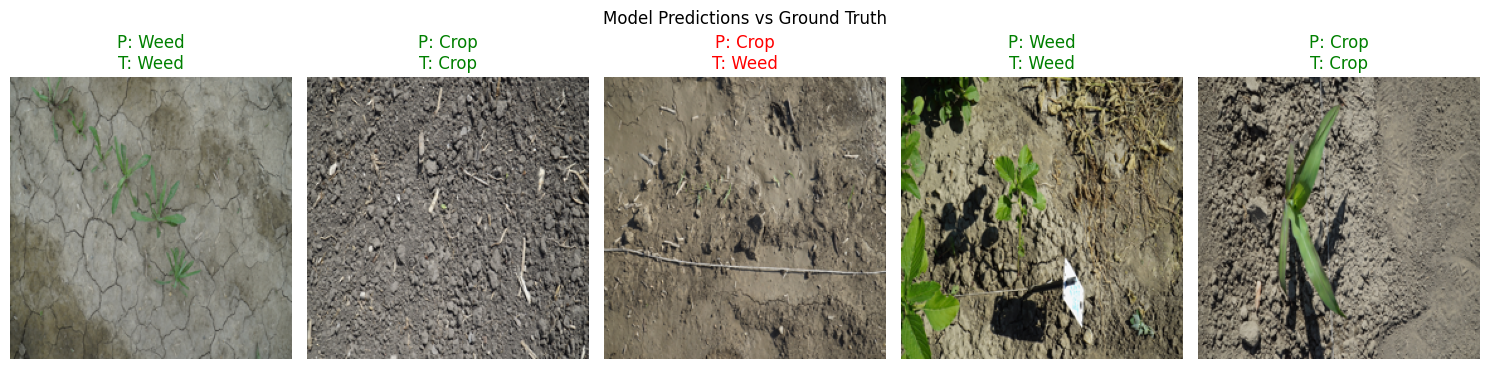

In [7]:
# !pip install opencv-python-headless tqdm --quiet  # Uncomment if needed

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random

# === Set base paths ===
dataset_path = Path("/content/crop_and_weed")  # Make sure you unzip the dataset to this path
images_path = dataset_path / "images"
labelids_path = dataset_path / "annotations" / "labelIds" / "CropAndWeed"
params_path = dataset_path / "annotations" / "params"

# === Define Crop vs Weed label mapping ===
crop_labels = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 94, 24, 18, 13, 26, 27, 15])
weed_labels = set([
    31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87,
    89, 91, 61, 79, 34, 41, 52, 35, 36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51,
    54, 58, 60, 80, 83, 96, 22, 63, 85, 56, 57, 64, 77, 50, 59, 67, 76
])

# === Step 1: Prepare image-label pairs ===
image_label_pairs = []

print("⏳ Scanning masks for classification filtering...\n")
for mask_file in tqdm(sorted(labelids_path.glob("*.png"))):
    mask = np.array(Image.open(mask_file))
    unique_labels = set(np.unique(mask))
    image_id = mask_file.stem

    has_crop = bool(unique_labels & crop_labels)
    has_weed = bool(unique_labels & weed_labels)

    if has_crop and has_weed:
        print(f"[SKIP - Mixed] {image_id} - Labels: {unique_labels}")
        continue
    elif has_crop:
        print(f"[ADD - Crop] {image_id}")
        image_label_pairs.append((image_id, 0))
    elif has_weed:
        print(f"[ADD - Weed] {image_id}")
        image_label_pairs.append((image_id, 1))
    else:
        print(f"[SKIP - Unknown] {image_id} - Labels: {unique_labels}")

# === Step 2: Show counts ===
print(f"\n✅ Total Crop-only images: {sum(1 for _, lbl in image_label_pairs if lbl == 0)}")
print(f"✅ Total Weed-only images: {sum(1 for _, lbl in image_label_pairs if lbl == 1)}")

# === Step 3: Split data ===
if len(image_label_pairs) < 2:
    raise ValueError("Not enough images found for training. Check label mapping or mask files.")

train_ids, test_ids = train_test_split(
    image_label_pairs,
    test_size=0.2,
    random_state=42,
    stratify=[lbl for _, lbl in image_label_pairs]
)

# === Step 4: Load images ===
def load_images(image_ids_labels):
    X, y = [], []
    for image_id, label in tqdm(image_ids_labels):
        image_file = images_path / f"{image_id}.jpg"
        if not image_file.exists():
            print(f"[Missing] {image_file}")
            continue
        try:
            img = Image.open(image_file).resize((224, 224))
            X.append(np.array(img))
            y.append(label)
        except Exception as e:
            print(f"[Error] {image_id}: {e}")
    return np.array(X), to_categorical(np.array(y), num_classes=2)

print("\n📥 Loading training images...")
X_train, y_train = load_images(train_ids)
print("📥 Loading test images...")
X_test, y_test = load_images(test_ids)


from tensorflow.keras.applications import EfficientNetB0, ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

def build_model(architecture="EfficientNetB0", input_shape=(224, 224, 3), num_classes=2):
    if architecture == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = efficientnet_preprocess
    elif architecture == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet_preprocess
    elif architecture == "ResNet101":
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet_preprocess
    elif architecture == "ResNet152":
        base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet_preprocess
    else:
        raise ValueError("Unsupported architecture")

    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = preprocess(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# === Step 5: Define model ===
print("\n🧠 Building EfficientNetB0 model...")
#base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
print("\n🧠 Building model...")
model = build_model(architecture="ResNet152")  # or "ResNet101", "ResNet152", "EfficientNetB0"
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 6: Data Augmentation ===
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=15, zoom_range=0.2)

# === Step 7: Train ===
print("\n🚀 Training...")
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=(X_test, y_test))

# === Step 8: Evaluate ===
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# === Step 9: Visualize predictions ===
print("\n🔍 Visualizing Predictions...")
plt.figure(figsize=(15, 4))
for i, idx in enumerate(random.sample(range(len(X_test)), 5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx])
    pred = np.argmax(model.predict(np.expand_dims(X_test[idx], axis=0)))
    true = np.argmax(y_test[idx])
    color = 'green' if pred == true else 'red'
    plt.title(f"P: {'Crop' if pred == 0 else 'Weed'}\nT: {'Crop' if true == 0 else 'Weed'}", color=color)
    plt.axis('off')
plt.suptitle("Model Predictions vs Ground Truth")
plt.tight_layout()
plt.show()


🔍 Extracting image patches...


  0%|          | 2/8034 [00:00<08:11, 16.33it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0000-0002.csv


  0%|          | 6/8034 [00:00<05:17, 25.26it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0000-0005.csv


 12%|█▏        | 945/8034 [00:25<03:21, 35.18it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0217-0001.csv


 12%|█▏        | 973/8034 [00:26<03:06, 37.77it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0223-0014.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0223-0015.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0223-0016.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0223-0020.csv


 13%|█▎        | 1061/8034 [00:28<03:10, 36.70it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0238-0016.csv


 19%|█▉        | 1517/8034 [00:41<02:42, 40.23it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0293-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0293-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0293-0010.csv


 19%|█▉        | 1562/8034 [00:42<03:00, 35.85it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0009.csv


 20%|█▉        | 1570/8034 [00:42<02:59, 35.96it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0297-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0008.csv


 20%|█▉        | 1578/8034 [00:43<02:59, 35.93it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0298-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0006.csv


 20%|█▉        | 1586/8034 [00:43<03:01, 35.52it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0299-0011.csv


 20%|██        | 1614/8034 [00:44<03:08, 34.13it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0302-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0302-0007.csv


 20%|██        | 1634/8034 [00:44<03:05, 34.44it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0010.csv


 20%|██        | 1642/8034 [00:45<03:03, 34.92it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0303-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0304-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0304-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0304-0008.csv


 21%|██        | 1650/8034 [00:45<03:00, 35.30it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0304-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0304-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0007.csv


 21%|██        | 1658/8034 [00:45<02:56, 36.08it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0305-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0005.csv


 21%|██        | 1666/8034 [00:45<02:54, 36.43it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0306-0011.csv


 21%|██        | 1678/8034 [00:46<02:58, 35.58it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0307-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0307-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0308-0004.csv


 21%|██        | 1694/8034 [00:46<02:58, 35.53it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0308-0014.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0008.csv


 21%|██        | 1702/8034 [00:46<02:54, 36.37it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0309-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0006.csv


 21%|██▏       | 1710/8034 [00:46<02:53, 36.45it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0310-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0003.csv


 21%|██▏       | 1718/8034 [00:47<02:52, 36.68it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0311-0011.csv


 21%|██▏       | 1726/8034 [00:47<02:57, 35.60it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0312-0005.csv


 22%|██▏       | 1746/8034 [00:47<02:57, 35.34it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0314-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0314-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0314-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0314-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0314-0010.csv


 22%|██▏       | 1766/8034 [00:48<02:57, 35.21it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0316-0011.csv


 22%|██▏       | 1794/8034 [00:49<02:59, 34.76it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0318-0010.csv


 23%|██▎       | 1822/8034 [00:50<02:54, 35.67it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0320-0010.csv


 23%|██▎       | 1830/8034 [00:50<02:50, 36.33it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0009.csv


 23%|██▎       | 1838/8034 [00:50<02:52, 35.96it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0321-0011.csv


 24%|██▍       | 1926/8034 [00:53<02:47, 36.52it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0328-0010.csv


 24%|██▍       | 1934/8034 [00:53<02:47, 36.44it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0009.csv


 24%|██▍       | 1942/8034 [00:53<02:47, 36.30it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0329-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0007.csv


 24%|██▍       | 1950/8034 [00:54<02:51, 35.45it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0331-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0332-0005.csv


 24%|██▍       | 1958/8034 [00:54<02:50, 35.65it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0332-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0332-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0332-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0332-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0332-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0003.csv


 24%|██▍       | 1966/8034 [00:54<02:47, 36.21it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0333-0011.csv


 25%|██▍       | 1974/8034 [00:54<02:49, 35.68it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0334-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0334-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0334-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0334-0009.csv


 25%|██▌       | 2010/8034 [00:55<02:52, 34.90it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0009.csv


 25%|██▌       | 2018/8034 [00:55<02:47, 35.92it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0338-0010.csv


 26%|██▌       | 2082/8034 [00:57<02:53, 34.35it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0343-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0343-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0343-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0343-0010.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0343-0011.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0002.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0003.csv


 26%|██▌       | 2090/8034 [00:58<02:48, 35.35it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0344-0009.csv


 27%|██▋       | 2138/8034 [00:59<02:48, 35.01it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0349-0009.csv


 27%|██▋       | 2158/8034 [01:00<02:40, 36.55it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0010.csv


 27%|██▋       | 2162/8034 [01:00<02:43, 36.00it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0353-0011.csv


 27%|██▋       | 2196/8034 [01:01<02:51, 33.97it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0357-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0357-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0357-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0357-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0357-0009.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0357-0010.csv


 28%|██▊       | 2264/8034 [01:03<02:45, 34.79it/s]

[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0003.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0004.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0005.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0006.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0007.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0008.csv
[Skip] Empty bbox file: /content/crop_and_weed/annotations/bboxes/ave-0359-0009.csv


100%|██████████| 8034/8034 [03:37<00:00, 36.91it/s]


✅ Loaded 77683 patches from 24 fine classes.
🧠 Building classification model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
🚀 Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1943/1943 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5777 - loss: 1.4765

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1943/1943 ━━━━━━━━━━━━━━━━━━━━ 669s 328ms/step - accuracy: 0.5778 - loss: 1.4764 - val_accuracy: 0.6993 - val_loss: 1.0052
Epoch 2/5
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 601s 309ms/step - accuracy: 0.7120 - loss: 0.9848 - val_accuracy: 0.7407 - val_loss: 0.8853
Epoch 3/5
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 602s 310ms/step - accuracy: 0.7379 - loss: 0.8816 - val_accuracy: 0.7577 - val_loss: 0.8377
Epoch 4/5
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 600s 309ms/step - accuracy: 0.7548 - loss: 0.8262 - val_accuracy: 0.7609 - val_loss: 0.8217
Epoch 5/5
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 594s 306ms/step - accuracy: 0.7628 - loss: 0.7912 - val_accuracy: 0.7667 - val_loss: 0.8011
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7715 - loss: 0.7846

🎯 Final Test Accuracy: 0.7667
🔍 Sample predictions:


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


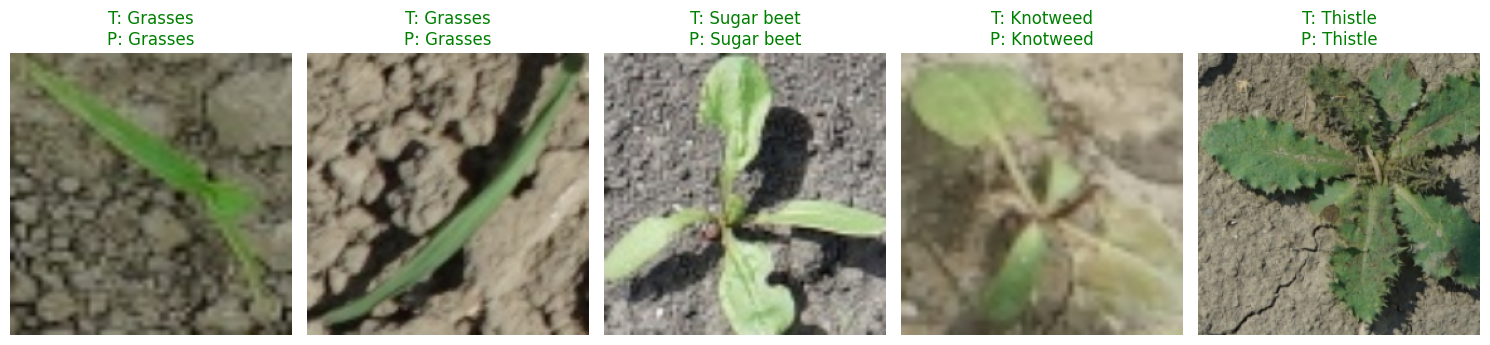

In [3]:
# !pip install opencv-python-headless tqdm --quiet  # Uncomment if needed

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# === PATHS ===
#dataset_path = Path("/content/drive/MyDrive/crop_and_weed")
dataset_path = Path("/content/crop_and_weed")
images_path = dataset_path / "images"
bboxes_path = dataset_path / "annotations" / "bboxes"
params_path = dataset_path / "annotations" / "params"

# === Define Fine24 Dataset ===
class Dataset:
    def __init__(self, labels):
        self.labels = {}
        self.mapping = {}
        for label_id, label in labels.items():
            if isinstance(label, tuple):
                self.labels[label_id] = (label[0], label[1], label_id) if len(label) > 1 else (label[0], (0, 0, 0))
            else:
                self.labels[label_id] = (label, (0, 0, 0))
            if len(label) > 2:
                for source_id in label[2]:
                    self.mapping[source_id] = label_id
        if len(self.mapping) == 0:
            self.mapping = {label: label for label in labels}

    def get_label_name(self, label_id):
        return self.labels[label_id][0] if label_id in self.labels else None

    def get_mapped_id(self, source_id):
        return self.mapping.get(source_id)

Fine24 = Dataset({
    0: ('Maize', (255, 0, 0), [1, 2, 3, 4, 5, 6]),
    1: ('Sugar beet', (255, 85, 0), [7, 8, 9, 10, 11, 12]),
    2: ('Soy', (42, 255, 0), [94]),
    3: ('Sunflower', (85, 0, 255), [24]),
    4: ('Potato', (0, 255, 85), [18]),
    5: ('Pea', (255, 170, 0), [13]),
    6: ('Bean', (255, 0, 170), [26, 27]),
    7: ('Pumpkin', (170, 255, 0), [15]),
    8: ('Grasses', (255, 226, 178), [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86]),
    9: ('Amaranth', (255, 245, 178), [32]),
    10: ('Goosefoot', (226, 255, 178), [29, 33, 37, 49]),
    11: ('Knotweed', (255, 207, 178), [30, 44, 66, 87, 89, 91]),
    12: ('Corn spurry', (233, 255, 178), [61]),
    13: ('Chickweed', (178, 195, 255), [79]),
    14: ('Solanales', (226, 255, 178), [34, 41, 52]),
    15: ('Potato weed', (207, 255, 178), [35]),
    16: ('Chamomile', (188, 255, 178), [36, 78]),
    17: ('Thistle', (178, 255, 207), [38, 39, 71, 72, 88]),
    18: ('Mercuries', (178, 226, 255), [42]),
    19: ('Geranium', (188, 178, 255), [45, 70]),
    20: ('Crucifer', (239, 255, 178), [47, 51, 54, 58, 60, 80, 83, 96]),
    21: ('Poppy', (214, 255, 178), [22, 63, 85]),
    22: ('Plantago', (255, 232, 178), [56, 57, 64, 77]),
    23: ('Labiate', (255, 212, 0), [50, 59, 67, 76])
})

# === STEP 1: Load image patches + labels ===
def load_patches():
    patches, labels = [], []

    for bbox_file in tqdm(sorted(bboxes_path.glob("*.csv"))):
        image_id = bbox_file.stem
        image_file = images_path / f"{image_id}.jpg"
        if not image_file.exists():
            continue

        image = cv2.imread(str(image_file))

        try:
            bboxes = pd.read_csv(bbox_file, header=None)
        except pd.errors.EmptyDataError:
            print(f"[Skip] Empty bbox file: {bbox_file}")
            continue

        if bboxes.empty:
            print(f"[Skip] No bounding boxes in: {bbox_file}")
            continue

        bboxes.columns = ["left", "top", "right", "bottom", "label_id", "stem_x", "stem_y"]

        for _, row in bboxes.iterrows():
            mapped_cls = Fine24.get_mapped_id(row['label_id'])
            if mapped_cls is None:
                continue

            crop = image[int(row["top"]):int(row["bottom"]), int(row["left"]):int(row["right"])]
            if crop.shape[0] < 10 or crop.shape[1] < 10:
                continue

            crop = cv2.resize(crop, (224, 224))
            patches.append(crop)
            labels.append(mapped_cls)

    return np.array(patches), np.array(labels)


print("🔍 Extracting image patches...")
X_img, y = load_patches()
print(f"✅ Loaded {len(X_img)} patches from {len(set(y))} fine classes.")

# === STEP 2: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X_img, y, test_size=0.2, random_state=42, stratify=y)
y_train_cat = to_categorical(y_train, num_classes=24)
y_test_cat = to_categorical(y_test, num_classes=24)

# === STEP 3: Define Model ===
print("🧠 Building classification model...")
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
output = Dense(24, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze backbone
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

# === STEP 4: Train ===
print("🚀 Training...")
datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.2, rotation_range=20)
history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=32), validation_data=(X_test, y_test_cat), epochs=5)

# === STEP 5: Evaluate ===
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"\n🎯 Final Test Accuracy: {acc:.4f}")

# === STEP 6: Visualize predictions ===
print("🔍 Sample predictions:")
plt.figure(figsize=(15, 4))
for i in range(5):
    idx = np.random.randint(len(X_test))
    img = X_test[idx]
    true_cls = y_test[idx]
    pred_cls = np.argmax(model.predict(np.expand_dims(img, axis=0)))
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"T: {Fine24.get_label_name(true_cls)}\nP: {Fine24.get_label_name(pred_cls)}",
              color='green' if pred_cls == true_cls else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()
